In [1]:

import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号


# from plotting_torch import newfig, savefig #从自定义的plotting_torch.py文件中导入了newfig和savefig函数。这两个函数用于创建和保存图形。这两个函数的定义在plotting_torch.py文件中

from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../..') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。
from util import *

In [2]:
torch.cuda.set_device(1) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
# implementation of PINNsformer
# paper: PINNsFormer: A Transformer-Based Framework For Physics-Informed Neural Networks
# link: https://arxiv.org/abs/2307.11833

import torch
import torch.nn as nn
import pdb

from util import get_clones

import torch
import torch.nn as nn
import torch.nn.functional as F
import math



class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6, elementwise_affine=True, memory_efficient=False):
        super().__init__()
        self.dim = dim
        self.eps = eps
        self.elementwise_affine = elementwise_affine
        if self.elementwise_affine:
            self.weight = nn.Parameter(torch.ones(dim))
        else:
            self.register_parameter('weight', None)

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        if self.weight is not None:
            output = output * self.weight
        return output

    def extra_repr(self) -> str:
        return f'dim={self.dim}, eps={self.eps}, elementwise_affine={self.elementwise_affine}'


#新东西
def lambda_init_fn(depth):
    return 0.8 - 0.6 * math.exp(-0.3 * depth)


#计算注意力的函数，这里查询的形状为(batch_size, h_head, 查询的序列长度, d_k)，键值的形状为(batch_size, h_head, 键值的序列长度, d_k)
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1) #获取query的最后一个维度的大小，即d_k，就是每个头的维度，其实是嵌入维度d_model除以头的数量h_head
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k) #点积注意力，查询形状为(batch_size, h_head, 查询的序列长度, d_k)，键的形状变换后为(batch_size, h_head, d_k, 键值的序列长度)，点积后得到的scores形状为(batch_size, h_head, 查询的序列长度, 键值的序列长度)，然后除以d_k的平方根进行缩放
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1) #进行softmax操作，dim=-1表示在最后一个维度上进行softmax
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn #返回乘上值的结果（即点积注意力，形状为(batch_size, h_head, 查询的序列长度, d_k)）和原始未乘值的结果

class DiffMultiHeadAttention(nn.Module):
    """
    Multi head attention module

    Args:
        h_head: 头的数量，differential transformer的头数量建议设置为baseline头数量的一半
        d_model: 数据的嵌入维度
        dropout: dropout概率
    """
    def __init__(self, h_head, d_model, depth, dropout=None): #初始化多头注意力模块，h_head是头的数量，d_model是数据的嵌入维度，dropout是dropout概率
        super(DiffMultiHeadAttention, self).__init__()
        assert d_model % h_head == 0
        self.h_head = h_head
        self.d_k = d_model // h_head //2 #数据的嵌入维度除以头的数量就是每个头的维度d_k,但是现在头的维度多除以2

        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)

        self.fc = nn.Linear(d_model, d_model)

        self.attn = None

        # depth就是当前layer的index
        self.lambda_init = lambda_init_fn(depth)
        self.lambda_q1 = nn.Parameter(torch.zeros(self.d_k, dtype=torch.float32).normal_(mean=0,std=0.1))
        self.lambda_k1 = nn.Parameter(torch.zeros(self.d_k, dtype=torch.float32).normal_(mean=0,std=0.1))
        self.lambda_q2 = nn.Parameter(torch.zeros(self.d_k, dtype=torch.float32).normal_(mean=0,std=0.1))
        self.lambda_k2 = nn.Parameter(torch.zeros(self.d_k, dtype=torch.float32).normal_(mean=0,std=0.1))
        #一种方法，未实现
        self.subln = RMSNorm(2 * self.d_k, eps=1e-5, elementwise_affine=True)
        # self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # Same mask applied to all h_head heads.
            mask = mask.unsqueeze(1)
        batch_size = query.size(0) #获取批量大小?
        
        # print ('Before transform query: ' + str(query.size())) # (batch_size, seq_length, d_model)        
        #有改动
        query = self.wq(query).view(batch_size, -1, 2 * self.h_head, self.d_k).transpose(1, 2) #query乘上wq矩阵，形状还是(batch_size, 查询的序列长度, d_model)  ，然后变形未(batch_size, 查询的序列长度, 2*h_head, d_k)，这里嵌入维度d_model被分成了2倍h_head个头，每个头的维度为d_k。交换维度1和2，得到的query形状为(batch_size, 2*h_head, 查询的序列长度, d_k)
        key   = self.wk(key).view(batch_size, -1, 2 * self.h_head, self.d_k).transpose(1, 2) #key乘上wk矩阵，形状还是(batch_size, 键值的序列长度, d_model)，然后变形未(batch_size, 键值的序列长度, 2*h_head, d_k)，这里嵌入维度d_model被分成了2*h_head个头，每个头的维度为d_k。交换维度1和2，得到的key形状为(batch_size, 2*h_head, 键值的序列长度, d_k)
        value = self.wv(value).view(batch_size, -1, self.h_head, 2 * self.d_k).transpose(1, 2) #value乘上wv矩阵，形状还是(batch_size, 键值的序列长度, d_model)，然后变形未(batch_size, 键值的序列长度, h_head, 2*d_k)，这里嵌入维度d_model被分成了h_head个头，每个头的维度为2*d_k。交换维度1和2，得到的value形状为(batch_size, h_head, 键值的序列长度, 2*d_k)


        attn_weights = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(self.d_k) #计算得到的权重矩阵形状为(batch_size, 2*h_head, 查询的序列长度, 键值的序列长度)

        attn_weights = F.softmax(attn_weights, dim=-1, dtype=torch.float32).type_as(
            attn_weights
        )#进行softmax操作，dim=-1表示在最后一个维度上进行softmax

        lambda_1 = torch.exp(torch.sum(self.lambda_q1 * self.lambda_k1, dim=-1).float()).type_as(query)
        lambda_2 = torch.exp(torch.sum(self.lambda_q2 * self.lambda_k2, dim=-1).float()).type_as(query)
        lambda_full = lambda_1 - lambda_2 + self.lambda_init #最终的λ

        attn_weights = attn_weights.view(batch_size, self.h_head, 2, query.size(2), key.size(2)) #将权重矩阵形状改为(batch_size, h_head, 2, 查询的序列长度, 键值的序列长度)
        attn_weights = attn_weights[:, :, 0] - lambda_full * attn_weights[:, :, 1] #最终的权重形状变为(batch_size, h_head, 查询的序列长度, 键值的序列长度)
    
        attn = torch.matmul(attn_weights, value) #计算注意力的输出，形状为(batch_size, h_head, 查询的序列长度, 2*d_k)
        attn = self.subln(attn) #进行RMSNorm归一化，形状不变
        attn = attn * (1 - self.lambda_init) #多的东西


        attn = attn.transpose(1, 2).contiguous().view(batch_size, -1, self.h_head * 2 * self.d_k) #不一样了，乘了2,先交换维度1和2，得到的x形状为(batch_size, 查询的序列长度, h_head, d_k)，然后变形为(batch_size, 查询的序列长度, h_head * d_k = d_model)，即将所有头的输出拼接在一起，形成一个新的查询序列
        attn = self.fc(attn) #经过全连接层，形状不变
        return attn, attn_weights #返回注意力的输出和注意力权重




#自定义激活函数Wavelet：w1 * sin(x) + w2 * cos(x)
class WaveAct(nn.Module):
    def __init__(self):
        super(WaveAct, self).__init__() 
        #自定义两个可学习参数w1和w2，初始化为1，训练过程中会更新这两个参数
        self.w1 = nn.Parameter(torch.ones(1), requires_grad=True)
        self.w2 = nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        return self.w1 * torch.sin(x)+ self.w2 * torch.cos(x)

#MLP组件，第一层形状为(d_model, d_ff)，第二层形状为(d_ff, d_ff)，第三层形状为(d_ff, d_model)，前两个使用自定义激活函数WaveAct
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=256):
        super(FeedForward, self).__init__() 
        self.linear = nn.Sequential(*[
            nn.Linear(d_model, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_model)
        ])

    def forward(self, x):
        return self.linear(x)




class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, depth):
        super(DecoderLayer, self).__init__()
        self.depth = depth #当前解码器层的深度，用于计算λ
        self.attn = DiffMultiHeadAttention(heads, d_model, self.depth) #多头注意力，设置嵌入维度为d_model，头数为heads，batch_first=True表示输入和输出tensor以(批量大小,序列长度,嵌入维度) 形式提供
        self.ff = FeedForward(d_model) #MLP组件，输入和输出的形状均为d_model，隐藏层的形状为d_ff默认
        self.act1 = WaveAct() #激活函数
        self.act2 = WaveAct() #激活函数

    def forward(self, x): #形状为(点的数量，序列长度，d_model)
        x2 = self.act1(x) #对输入x应用激活函数
        # pdb.set_trace()
        x = x + self.attn(x2,x2,x2)[0] #多头注意力机制，查询、键和值均为原始输入经过激活函数后的x2，然后使用残差连接原始输入得到自注意力的输出
        x2 = self.act2(x) #对自注意力的输出应用激活函数
        x = x + self.ff(x2) #将通过激活函数后的自注意力输出通过MLP组件后残差连接原始自注意力输出，得到编码器的输出
        return x 


#解码器层，包含多个堆叠的解码器架构
class Decoder(nn.Module):
    def __init__(self, d_model, N, heads): #参数N代表解码器的头数，N代表包含几个解码器，d_model是数据的嵌入维度（用于每个解码器），heads是头的数量
        super(Decoder, self).__init__()
        self.N = N
        # self.layers = get_clones(DecoderLayer(d_model, heads), N) #N个解码器
        self.layers = nn.ModuleList([DecoderLayer(d_model, heads, i) for i in range(N)]) #N个解码器层
        self.act = WaveAct()
        
    def forward(self, x): #输入一次通过N个解码器层，x的形状为(点的数量，序列长度，d_model)，e_outputs为编码器的输出，形状也是为(点的数量，序列长度，d_model)
        for i in range(self.N): #输入和编码器输出依次通过N个解码器
            x = self.layers[i](x) 
        return self.act(x) #解码器的输出要经过激活函数







class DNN(nn.Module):
    def __init__(self, d_out, d_model, d_hidden, N, heads): #接受参数为：d_out代表整个模型的输出的维度（就是最后的mlp层的输出维度），d_model代表每个点的特征嵌入维度，d_hidden代表最后的output layer模块中的隐藏层的维度，N代表编码器和解码器的层数，heads代表多头注意力机制的头数
        super(DNN, self).__init__()

        self.linear_emb = nn.Linear(2, d_model) #线性层，将输入的2维数据映射到d_model维度


        self.decoder = Decoder(d_model, N, heads) #解码器层

        #输出的mlp模块，包含三个线性层，前两个使用自定义激活函数WaveAct，最终将feature从d_model维度映射到d_hidden维度，最后将d_hidden维度映射到d_out维度
        self.linear_hidden = nn.Sequential(*[
            nn.Linear(d_model, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, 2),
        ])
        self.linear_out = nn.Sequential(*[
            WaveAct(),
            nn.Linear(2, d_out)
        ])

    def forward(self, x): #输入的x形状一般为(点的数量, 序列长度, 2)
        src = x #形状为(点的数量，序列长度，2)
        src = self.linear_emb(src) #特征向量通过第一个线性层，映射到高维，此时src的形状为(点的数量，序列长度，d_model)，d_model代表每个点的特征


        d_output = self.decoder(src) #解码器处理输入特征向量和编码后的输出，得到解码后的输出，形状为(点的数量，序列长度，d_model)
        output_hidden = self.linear_hidden(d_output) #解码后的输出通过输出的mlp模块，得到最终的预测结果。形状为(点的数量，序列长度，2)，d_out代表输出的维度
        output = self.linear_out(output_hidden) #形状为(点的数量，序列长度，d_out)，d_out代表输出的维度
        # pdb.set_trace()
        # raise Exception('stop')
        return output #(点的数量，序列长度，d_out)
    
    # 新增方法，获取最后一个隐藏层的输出
    def hidden_output(self, x):
        src = x #形状为(点的数量，序列长度，2)
        src = self.linear_emb(src) #特征向量通过第一个线性层，映射到高维，此时src的形状为(点的数量，序列长度，d_model)，d_model代表每个点的特征

        d_output = self.decoder(src) #解码器处理输入特征向量和编码后的输出，得到解码后的输出，形状为(点的数量，序列长度，d_model)
        output_hidden = self.linear_hidden(d_output) #解码后的输出通过输出的mlp模块，得到最终的预测结果。形状为(点的数量，序列长度，2)，d_out代表输出的维度
        # output = self.linear_out(output_hidden) #形状为(点的数量，序列长度，d_out)，d_out代表输出的维度
        # pdb.set_trace()
        # raise Exception('stop')
        return output_hidden #(点的数量，序列长度，2)

    
    # # #输入的x形状一般为(点的数量, 序列长度, 2)
    # def hidden_forward(self, x, num_cycles):
    #     src = x #形状为(点的数量，序列长度，1)
    #     # 将最后一个隐藏层的输出作为输入传递到第一个隐藏层中，重复num_cycles次
    #     for _ in range(num_cycles):
    #         src = self.linear_emb(src) #特征向量通过第一个线性层，映射到高维，此时src的形状为(点的数量，序列长度，d_model)，d_model代表每个点的特征

    #         e_outputs = self.encoder(src) #编码器处理输入特征向量，得到编码后的输出，形状为(点的数量，序列长度，d_model)
    #         d_output = self.decoder(src, e_outputs) #解码器处理输入特征向量和编码后的输出，得到解码后的输出，形状为(点的数量，序列长度，d_model)
    #         output_hidden = self.linear_hidden(d_output) #解码后的输出通过输出的mlp模块，得到最终的预测结果。形状为(点的数量，序列长度，1)，d_out代表输出的维度
    #         src = output_hidden #形状为(点的数量，序列长度，1)
    #     hidden_output = output_hidden
        
    #     return hidden_output


In [4]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, b_left, b_right, b_upper, b_lower, X_f, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        
        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)

        X_f = make_time_sequence(X_f, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 

        b_left = make_time_sequence(b_left, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)\n",
        b_right = make_time_sequence(b_right, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)\n",
        b_upper = make_time_sequence(b_upper, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)\n",
        b_lower = make_time_sequence(b_lower, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)\n",
        
        # data
        #配位点数据
        self.x_f = torch.tensor(X_f[:,:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:,:, 1:2], requires_grad=True).float().to(device)

        self.x_left = torch.tensor(b_left[:,:, 0:1], requires_grad=True).float().to(device) #(点的数量，序列长度，1)\n",
        self.t_left = torch.tensor(b_left[:,:, 1:2], requires_grad=True).float().to(device)
        self.x_right = torch.tensor(b_right[:,:, 0:1], requires_grad=True).float().to(device) 
        self.t_right = torch.tensor(b_right[:,:, 1:2], requires_grad=True).float().to(device)
        self.x_upper = torch.tensor(b_upper[:,:, 0:1], requires_grad=True).float().to(device) 
        self.t_upper = torch.tensor(b_upper[:,:, 1:2], requires_grad=True).float().to(device)
        self.x_lower = torch.tensor(b_lower[:,:, 0:1], requires_grad=True).float().to(device)
        self.t_lower = torch.tensor(b_lower[:,:, 1:2], requires_grad=True).float().to(device)
        
        
        # deep neural networks
        self.dnn = DNN(d_out=1, d_hidden=512, d_model=32, N=2, heads=4).to(device) 
        self.dnn.apply(self.init_weights) #初始化模型中线性层的权重和偏置
        
        # optimizers: using the same settings
        #创建优化器optimizer，使用LBFGS算法，具体每个参数意义见下方
        # self.optimizer_LBFGS = torch.optim.LBFGS(
        #     self.dnn.parameters(), #要优化的参数，这里返回的是一个生成器，包含了self.dnn中的所有参数（神经网络权重与偏置）
        #     lr=1.0,  #学习率设置为1
        #     max_iter=50000,  #最大迭代次数为50000
        #     max_eval=50000,  #最大评估次数为50000
        #     history_size=50, #历史大小为50，即用于计算Hessian矩阵近似的最近几步的信息
        #     # tolerance_grad=1e-10,  #优化的第一个停止条件，当梯度的L2范数小于1e-5时停止优化
        #     # tolerance_change=1.0 * np.finfo(float).eps, #优化的第二个停止条件，当优化的目标函数值的变化小于1.0 * np.finfo(float).eps时停止优化
        #     line_search_fn="strong_wolfe"       # 制定了用于一维搜索的方法，这里表示用强Wolfe条件
        # )
        self.optimizer_LBFGS = torch.optim.LBFGS(self.dnn.parameters(), line_search_fn='strong_wolfe') #使用LBFGS优化器，line_search_fn='strong_wolfe'表示使用强Wolfe线搜索方法

        #创建第二个优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())

        #创建第三个优化器，括号内为要优化的参数，使用SGD优化方法
        self.optimizer_SGD = torch.optim.SGD(self.dnn.parameters(), lr=0.01, momentum=0.9)

        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

    #初始化神经网络的线性层权重参数，使用Xavier初始化权重，偏置则初始化为0.01
    def init_weights(self, m):
        if isinstance(m, nn.Linear): #判断是否是线性层
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)
        
    #输入是两个(点的数量，序列长度，1)，输出(点的数量，序列长度，1)
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=-1))  #合并为(点的数量，序列长度，2)
        return u
    
    #输入是两个(点的数量，序列长度，1)
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t) #输出(点的数量，序列长度，1)
        
        #计算u关于t的梯度，也就是u关于t的导数，这里使用了pytorch的自动求导功能
        u_t = torch.autograd.grad(
            u, t,  #输入的张量，要计算u关于t的导数
            grad_outputs=torch.ones_like(u), #生成一个与u形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度

        
        f=u_t - 5 * u * (1-u) #计算f，定义见论文
        return f #(点的数量，序列长度，1)
    
    def loss_func(self):
        self.optimizer_LBFGS.zero_grad() #清除之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
        
        pred_upper = self.net_u(self.x_upper, self.t_upper) #输出(点的数量，序列长度，1)
        pred_lower = self.net_u(self.x_lower, self.t_lower) #输出(点的数量，序列长度，1)\n",
        pred_left = self.net_u(self.x_left, self.t_left) #输出(点的数量，序列长度，1)\n",
        f_pred = self.net_f(self.x_f, self.t_f) #输出(点的数量，序列长度，1)\n",

        #计算损失，共三项损失\n",
        loss_res = torch.mean(f_pred ** 2)
        loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
        loss_ic = torch.mean((pred_left[:,0] - torch.exp(- (self.x_left[:,0] - torch.pi)**2 / (2*(torch.pi/4)**2))) ** 2)

        loss = loss_res + loss_bc + loss_ic
        loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数

        self.iter += 1 #每调用一次损失函数，迭代次数加1

        #record the loss value
        self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

        return loss #返回loss

      
    
    def train(self, nIter, nIterLBFGS):
        self.dnn.train()#将神经网络设置为训练模式而不是评估模式
        #先使用Adam优化器优化nIter次\n",
        for epoch in tqdm(range(nIter), desc='Adam'):
            pred_upper = self.net_u(self.x_upper, self.t_upper) #输出(点的数量，序列长度，1)\n",
            pred_lower = self.net_u(self.x_lower, self.t_lower) #输出(点的数量，序列长度，1)\n",
            pred_left = self.net_u(self.x_left, self.t_left) #输出(点的数量，序列长度，1)\n",
            f_pred = self.net_f(self.x_f, self.t_f) #输出(点的数量，序列长度，1)\n",

            #计算损失，共三项损失
            loss_res = torch.mean(f_pred ** 2)
            loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
            loss_ic = torch.mean((pred_left[:,0] - torch.exp(- (self.x_left[:,0] - torch.pi)**2 / (2*(torch.pi/4)**2))) ** 2)

            loss = loss_res + loss_bc + loss_ic

            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）\n",
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数\n",
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化\n",

            #record the loss value\n",
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中\n",

        #Backward the optimize，使用LBFGS优化器进一步，注意这里虽然迭代了500次，但其实使用LBFGS优化器优化的次数不止500次\n",
        for i in tqdm(range(nIterLBFGS), desc='LBFGS'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式\n",
            self.optimizer_LBFGS.step(self.loss_func)  #使用之前的优化器self.optimizer，调用step方法(执行一步优化算法)，传入计算损失函数的方法self.loss_func，进行优化   \n",

 

  


    def predict(self, X): #形状(点的数量，2)
        X = make_time_sequence(X, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 
        x = torch.tensor(X[:,:, 0:1], dtype=torch.float32, requires_grad=True).to(device) #(点的数量，序列长度，1) 
        t = torch.tensor(X[:,:, 1:2], dtype=torch.float32, requires_grad=True).to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        with torch.no_grad():
            u = self.net_u(x, t) #形状从两个(点的数量，序列长度，1)变为(点的数量，序列长度，1)
            u = u[:,0:1].reshape(-1,1) #将u的形状从(点的数量，序列长度，1)变为(点的数量，1)
            u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上

        return u #u形状是(点的数量，1)，f形状是(点的数量，1)
    
    def residual(self, X): #形状(点的数量，2)
        X = make_time_sequence(X, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 
        x = torch.tensor(X[:,:, 0:1], dtype=torch.float32, requires_grad=True).to(device) #(点的数量，序列长度，1) 
        t = torch.tensor(X[:,:, 1:2], dtype=torch.float32, requires_grad=True).to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        
        f = self.net_f(x, t) #形状从两个(点的数量，序列长度，1)变为(点的数量，序列长度，1)
        f = torch.mean(f, dim=1).reshape(-1,1) #对f在序列长度维度上求平均，得到(点的数量，1)，即每个点的平均残差
        # f = f[:,0:1].reshape(-1,1) #将f的形状从(点的数量，序列长度，1)变为(点的数量，1)
        f = f.detach().cpu().numpy()
        return f #u形状是(点的数量，1)，f形状是(点的数量，1)
    

    def hidden_predict(self, X):#形状(点的数量，序列长度，2)
        x = torch.tensor(X[:,:, 0:1], requires_grad=True).float().to(device) #(点的数量，序列长度，1) 
        t = torch.tensor(X[:,:, 1:2], requires_grad=True).float().to(device)
        self.dnn.eval()
        with torch.no_grad():
            hidden_output = self.dnn.hidden_output(torch.cat([x, t], dim=-1)) #(点的数量，序列长度，2)
            hidden_output = hidden_output.detach().cpu().numpy()
        # hidden_output_x = hidden_output[:, 0]
        # hidden_output_t = hidden_output[:, 1]
        # hidden_output_x = hidden_output_x.detach().cpu().numpy()
        # hidden_output_t = hidden_output_t.detach().cpu().numpy()
        return hidden_output #(点的数量，序列长度，2)
    

In [5]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [6]:
#定义根据模型计算给定输入（点集中的点）的混沌度的函数，这个函数接受三个参数，分别是模型、输入数据和迭代次数
def calculate_chaos(model, X, num_iter): #输入是(点的数量，2)
    """
    计算模型混沌情况的函数。
    参数:
    - model: 用于预测的模型对象，必须有一个名为hidden_predict的方法。模型的hidden_predict为倒数第二层的输出，倒数第二层的维度必须和输入维度相同。
    - X: 输入数据，形状为(N_f_new, 2)，其中第一列为x0，第二列为t0。
    - num_iter: 计算混沌情况的迭代次数。
    返回:
    - distances: 每个采样点（与该采样点加上微扰比较）在最后一次迭代后的欧氏距离数组，形状为(N_f_new,)。
    """
    #对于所有的采样点
    X0 = X
    x0 = X[:, 0:1] #取X_f_train_new的第一列，赋值给x0，(N_f_new,1)形状
    t0 = X[:, 1:2] #取X_f_train_new的第二列，赋值给t0
    xs = []
    X0 = make_time_sequence(X0, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)
    X = model.hidden_predict(X0) #(点的数量，序列长度，2)
    
    for i in range(num_iter): #循环num_iter次
        X = model.hidden_predict(X) #(点的数量，序列长度，2)
        xs.append(X) #新添加(点的数量，序列长度，2)

    # 给所有采样点加上一个很小的扰动
    x1 = x0 + np.random.normal(0, 0.0001) #加上一个很小的扰动，(N_f_new,1)形状
    t1 = t0 + np.random.normal(0, 0.0001)
    # 利用x0{1}和t0{1}计算x{t1}和t{t1}，存储在xs1中
    xs1 = [] #初始化xs1
    X1 = np.concatenate((x1, t1), axis=1) #(N_f_new,2)形状
    X1 = make_time_sequence(X1, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)
    X1 = model.hidden_predict(X1) #(N_f_new,序列长度,2)

    for i in range(num_iter): #循环num_iter次
        X1 = model.hidden_predict(X1) #(N_f_new,序列长度,
        xs1.append(X1) #新添加(N_f_new,序列长度,2)

    

    # 计算最后一次迭代的隐藏层输出，即最后一次迭代的x和t,使用chunchaos要注释掉
    last_iter_xs = np.array(xs[-1]) #转换为数组，便于之后计算距离
    last_iter_xs1 = np.array(xs1[-1])
    distances = np.linalg.norm(last_iter_xs - last_iter_xs1, axis=(1,2))
    distances = distances.flatten()







    # #chunchaos方法
    # num_elements_to_average = 20
    # # 提取最后 20 个元素
    # last_20_xs = xs[-num_elements_to_average:] # 这是一个包含 20 个元素的列表
    # last_20_xs1 = xs1[-num_elements_to_average:] # 这是一个包含 20 个元素的列表
    # # 存储每个时间步（列表中的每个元素）的混沌度分数
    # step_chaos_scores = []
    # # 遍历最后 20 个元素,zip 将两个列表的对应元素配对
    # for step_xs, step_xs1 in zip(last_20_xs, last_20_xs1):
    #     # step_xs 和 step_xs1 都是形状为 (N_f_new, sequence_length, 2) 的数组/张量
    #     difference_step = step_xs - step_xs1 # 计算差异
    #     # 计算每个数据点在当前步的混沌度分数 (形状 (N_f_new,))
    #     # 假设使用 NumPy 进行计算
    #     step_scores = np.linalg.norm(difference_step, axis=(1, 2))
    #     # 将这 N_f_new 个分数添加到列表中
    #     step_chaos_scores.append(step_scores)

    # # step_chaos_scores 是一个包含 20 个元素的列表，每个元素都是形状为 (N_f_new,) 的 NumPy 数组
    # # 将列表转换成一个单一的 NumPy 数组，形状为 (20, N_f_new)
    # all_step_scores = np.stack(step_chaos_scores)
    # # 现在 all_step_scores 的形状是 (num_elements_to_average, N_f_new)
    # # axis 0 是时间步 (20)，axis 1 是原始数据点 (N_f_new)
    # # 计算最后 20 个时间步在每个数据点上的平均混沌度分数
    # # 沿着时间步轴 (axis=0) 求平均
    # distances = np.mean(all_step_scores, axis=0)
    # # 结果形状是 (N_f_new,)







    return distances

In [7]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子\n",
# seeds = [0]

N_f = 51*51

lb = np.array([0.0, 0.0])
ub = np.array([2 * np.pi, 1.0])

# Train PINNsformer
_, b_left, b_right, b_upper, b_lower = get_data([0,2*np.pi], [0,1], 51, 51) #51代表初值点、边界值点数量！！
X_star, _, _, _, _ = get_data([0,2*np.pi], [0,1], 101, 101) #生成测试数据，采样点数为101x101,这里的X_star就是res_test

error_u = [] #创建一个空列表，用于存储误差
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值

i = 0 #初始化i为0

nIter = 10000 #设置迭代次数为10000
nIterLBFGS = 500 #设置LBFGS迭代次数为500

def hh(x):
    return np.exp( - (x-np.pi)**2 / (2 * (np.pi/4)**2))

def u_ana(x,t):
    return hh(x) * np.exp(5*t) / ( hh(x) * np.exp(5*t) + 1 - hh(x))

for seed in seeds:
    set_seed(seed) #设置随机数种子
    # --- 1. 参数设置 ---
    nIter = 10000
    nIterLBFGS = 500
    # ... 其他参数 ...

    # --- 2. 初始化 ---
    N_f_1 = N_f // 20
    X_f_train = lb + (ub - lb) * lhs(2, N_f_1)

    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(b_left, b_right, b_upper, b_lower, X_f_train, lb, ub)

    # 【新】创建巨大、固定的候选点池
    N_f_candidate = N_f * 2
    X_f_candidate = lb + (ub - lb) * lhs(2, N_f_candidate)
    is_point_selected_mask = np.zeros(N_f_candidate, dtype=bool) #布尔掩码，形状是(N_f_candidate,)，初始值为False，表示所有点都未被选择
    

    # --- 3. 初始训练 ---
    start_time = time.time()
    model.train(nIter // 20, 0)

    # --- 4. 主动学习循环 ---
    # 计算总轮数,这里是19
    num_active_rounds = (nIter - nIter // 20) // (nIter // 20)
    # 每轮训练中记录的检查点数量，其实就是后面的T
    num_checkpoints_per_round = 10
    # 两次检查点之间的训练迭代次数
    epochs_between_checkpoints = (nIter // 20) // num_checkpoints_per_round

    # 用于存储每一轮最终预测的全局历史
    global_final_predictions = []

    for i in range(num_active_rounds):        
        # a. 训练并记录预测历史
        prediction_history = []
        # 记录当前模型在整个候选池上的预测输出
        
        for j in range(num_checkpoints_per_round):
            model.train(epochs_between_checkpoints, 0)
            
            # 记录当前模型在整个候选池上的预测输出
            predictions = model.predict(X_f_candidate) # 返回 (N, 1) 的Numpy数组
            # prediction_history.append(predictions.flatten()) # 存为一维数组，每个元素形状为 (N, ) 
            prediction_history.append(predictions) # 存为二维数组，每个元素形状为 (N, 1)
        local_prediction_history = prediction_history

        # b. 计算不稳定性分数 g(x) = Σ v_t * a_t(x)
        # 将历史记录转为矩阵 (T+1, N_candidates,1)
        local_history_matrix = np.array(local_prediction_history)
        T_local, num_candidates, _ = local_history_matrix.shape #T表示共存储了多少个模型的预测结果，num_candidates表示候选点的数量

        # 获取最终预测u_T(x)
        local_final_prediction = local_history_matrix[-1, :, :] # (N_candidates, 1) 的数组

        # 计算不一致性矩阵 a_t(x) = |u_t(x) - u_T(x)|
        # 利用 NumPy 的广播机制高效计算，具体为(T, N_candidates,1)-(N_candidates,1)（相当于用T个元素分别和最后一个元素相减）,最后得到的形状是(T, N_candidates)
        # disagreement_matrix_A = np.abs(prediction_history_matrix - final_prediction_vec)
        local_disagreement = np.linalg.norm(local_history_matrix - local_final_prediction, ord=2, axis=-1)

        # 计算时间权重向量 v_t = (t/T)^k
        t_local = np.arange(1, T_local + 1) #形状是(T,)的数组
        k_local = 1.0  # 权重指数，可以作为超参数调整
        v_local = (t_local / T_local) ** k_local #形状是(T,)

        # 计算最终不稳定性分数 g(x)
        # g = V^T * A (矩阵乘法概念)
        # 实际操作：将权重向量V变形以进行逐元素乘法，然后在时间轴上求和
        # v_local（也就是V）的形状是(T,)，local_disagreement（也就是A）的形状是(T, N_candidates)
        # V[:, np.newaxis] 将V变为 (T, 1)，可以与A进行广播乘法
        g_micro = np.sum(v_local[:, np.newaxis] * local_disagreement, axis=0) #求和前形状为 (T, N_candidates)，求和后形状为(N_candidates,)

        
        # c. 更新并计算【宏观不稳定性 g_macro】
        # ------------------------------------------------------------------
        # 将本轮的最终预测加入全局历史列表
        global_final_predictions.append(local_final_prediction)
        
        g_macro = np.zeros(num_candidates) # 如果历史太短，宏观不稳定性为0
        
        # 只有当全局历史足够长时（至少有两次最终预测），计算才有意义
        if len(global_final_predictions) > 1:
            global_history_matrix = np.array(global_final_predictions)
            T_global, _, _ = global_history_matrix.shape # T_global 是当前的主动学习轮数 i+1
            
            # 使用全局最新的预测作为基准
            global_final_prediction = global_history_matrix[-1, :, :]
            
            # 计算宏观不一致性
            global_disagreement = np.linalg.norm(global_history_matrix - global_final_prediction, ord=2, axis=-1)
            
            # 【宏观 t, k】
            t_global = np.arange(1, T_global + 1)
            k_macro = 2.0 # 宏观时间尺度上，可以给后期变化更大的惩罚，所以k可以更大
            v_global = (t_global / T_global) ** k_macro
            
            # 计算宏观不稳定性分数
            g_macro = np.sum(v_global[:, np.newaxis] * global_disagreement, axis=0)


        # d. 融合分数
        # ------------------------------------------------------------------
        # 在融合前，对两种分数进行归一化，使其尺度相当，避免其中一个主导
        # 这是一个很好的实践，可以防止数值问题
        if np.std(g_micro) > 1e-6:
            g_micro_norm = (g_micro - np.mean(g_micro)) / np.std(g_micro)
        else:
            g_micro_norm = np.zeros_like(g_micro)

        if np.std(g_macro) > 1e-6:
            g_macro_norm = (g_macro - np.mean(g_macro)) / np.std(g_macro)
        else:
            g_macro_norm = np.zeros_like(g_macro)
            
        # 设置融合权重
        w_micro = 0.5
        w_macro = 0.5
        
        instability_scores_g = w_micro * g_micro_norm + w_macro * g_macro_norm



        batch_size = N_f_candidate // 10 # 设置批处理大小为候选点数量的十分之一，避免显存爆炸
        all_residuals = [] # 创建一个空列表来存储每个批次的残差结果


        # 循环处理每个批次
        for i in range(0, N_f_candidate, batch_size):
            # 获取当前批次的数据
            X_batch = X_f_candidate[i : i + batch_size]
            
            # 对当前批次计算残差
            # model.residual 内部的计算量大大减小，不会爆显存了
            residual_batch = model.residual(X_batch) # 返回 (batch_size, 1) 的 NumPy 数组
            
            # 将当前批次的结果添加到列表中
            all_residuals.append(residual_batch)

        # 将所有批次的结果拼接成一个大的 NumPy 数组
        residual = np.vstack(all_residuals) # vstack 用于垂直堆叠

        # --- 后续处理不变 ---
        # 计算残差的绝对值
        abs_residual = np.abs(residual)
        # 将二维数组转换为一维数组
        abs_residual = abs_residual.flatten()



        #进行归一化
        epsilon = 1e-5
        
        norm_residual = np.linalg.norm(abs_residual)
        if norm_residual > epsilon:
            abs_residual = abs_residual / norm_residual
        else:
            abs_residual = np.zeros_like(abs_residual)
        # norm_distances = np.linalg.norm(distances)
        # if norm_distances > epsilon:
        #     distances = distances / norm_distances
        # else:
        #     distances = np.zeros_like(distances)

        norm_instability = np.linalg.norm(instability_scores_g)
        if norm_instability > epsilon:
            instability_scores_g = instability_scores_g / norm_instability
        else:
            instability_scores_g = np.zeros_like(instability_scores_g)

        xinxi = abs_residual + instability_scores_g #将残差和不稳定性分数相加，得到新的分数


        # e. 选择新的点
        # 屏蔽已选中的点，防止重复选择
        xinxi[is_point_selected_mask] = -1.0
        
        # 找出分数最高的 N_f_1 个点的索引
        topk_indices = np.argpartition(xinxi, -N_f_1)[-N_f_1:]
        
        # 提取新点
        X_f_train_topk = X_f_candidate[topk_indices]
        
        # f. 更新训练集和掩码
        X_f_train = np.vstack((X_f_train, X_f_train_topk))
        is_point_selected_mask[topk_indices] = True


        # e. 更新模型内部的配位点
        X_f = make_time_sequence(X_f_train, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 
        
        #配位点数据
        model.x_f = torch.tensor(X_f[:,:, 0:1], requires_grad=True).float().to(device)
        model.t_f = torch.tensor(X_f[:,:, 1:2], requires_grad=True).float().to(device)



    model.train(0,nIterLBFGS) #使用LBFGS训练500次


    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))


    #用训练好的模型进行预测，返回四个值（均为数组）  
    u_pred = model.predict(X_star).flatten()

    # u_pred = u_pred.reshape(101,101)

    u_star = u_ana(X_star[:,0], X_star[:,1])
    # .reshape(101,101)\n",


    #计算误差（基于2范数）        
    error_u.append(np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(u_star - u_pred))
    mse = np.mean((u_star - u_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error u : %e' % (np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE







    

/tmp/ipykernel_1066140/731132747.py:65: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<00:55,  9.07it/s]

Adam:   2%|▏         | 9/500 [00:00<00:10, 46.23it/s]

Adam:   3%|▎         | 16/500 [00:00<00:08, 56.19it/s]

Adam:   5%|▍         | 24/500 [00:00<00:07, 62.17it/s]

Adam:   6%|▋         | 32/500 [00:00<00:07, 66.05it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 68.06it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 69.23it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 70.00it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:06, 70.70it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:06, 71.20it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:05, 71.46it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:05, 72.03it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:05, 71.88it/s]

Adam:  21%|██        | 104/500 [00:01<00:05, 72.01it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:05, 72.18it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:05, 72.07it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:05, 72.03it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:05, 72.14it/s]

Adam:  29%|██▉       | 144/500 [00:02<00:04, 72.02it/s]

Adam:  30%|███       | 152/500 [00:02<00:04, 71.63it/s]

Adam:  32%|███▏      | 160/500 [00:02<00:04, 71.61it/s]

Adam:  34%|███▎      | 168/500 [00:02<00:04, 71.41it/s]

Adam:  35%|███▌      | 176/500 [00:02<00:04, 71.51it/s]

Adam:  37%|███▋      | 184/500 [00:02<00:04, 70.87it/s]

Adam:  38%|███▊      | 192/500 [00:02<00:04, 70.53it/s]

Adam:  40%|████      | 200/500 [00:02<00:04, 70.89it/s]

Adam:  42%|████▏     | 208/500 [00:03<00:04, 71.05it/s]

Adam:  43%|████▎     | 216/500 [00:03<00:04, 70.90it/s]

Adam:  45%|████▍     | 224/500 [00:03<00:03, 70.31it/s]

Adam:  46%|████▋     | 232/500 [00:03<00:03, 70.66it/s]

Adam:  48%|████▊     | 240/500 [00:03<00:03, 70.75it/s]

Adam:  50%|████▉     | 248/500 [00:03<00:03, 71.13it/s]

Adam:  51%|█████     | 256/500 [00:03<00:03, 71.20it/s]

Adam:  53%|█████▎    | 264/500 [00:03<00:03, 71.27it/s]

Adam:  54%|█████▍    | 272/500 [00:03<00:03, 71.42it/s]

Adam:  56%|█████▌    | 280/500 [00:04<00:03, 71.40it/s]

Adam:  58%|█████▊    | 288/500 [00:04<00:02, 71.29it/s]

Adam:  59%|█████▉    | 296/500 [00:04<00:02, 71.45it/s]

Adam:  61%|██████    | 304/500 [00:04<00:02, 71.54it/s]

Adam:  62%|██████▏   | 312/500 [00:04<00:02, 70.98it/s]

Adam:  64%|██████▍   | 320/500 [00:04<00:02, 71.03it/s]

Adam:  66%|██████▌   | 328/500 [00:04<00:02, 71.19it/s]

Adam:  67%|██████▋   | 336/500 [00:04<00:02, 70.27it/s]

Adam:  69%|██████▉   | 344/500 [00:04<00:02, 70.93it/s]

Adam:  70%|███████   | 352/500 [00:05<00:02, 71.21it/s]

Adam:  72%|███████▏  | 360/500 [00:05<00:01, 71.48it/s]

Adam:  74%|███████▎  | 368/500 [00:05<00:01, 71.70it/s]

Adam:  75%|███████▌  | 376/500 [00:05<00:01, 71.71it/s]

Adam:  77%|███████▋  | 384/500 [00:05<00:01, 71.51it/s]

Adam:  78%|███████▊  | 392/500 [00:05<00:01, 71.45it/s]

Adam:  80%|████████  | 400/500 [00:05<00:01, 71.46it/s]

Adam:  82%|████████▏ | 408/500 [00:05<00:01, 71.48it/s]

Adam:  83%|████████▎ | 416/500 [00:05<00:01, 71.68it/s]

Adam:  85%|████████▍ | 424/500 [00:06<00:01, 71.76it/s]

Adam:  86%|████████▋ | 432/500 [00:06<00:00, 71.58it/s]

Adam:  88%|████████▊ | 440/500 [00:06<00:00, 70.14it/s]

Adam:  90%|████████▉ | 448/500 [00:06<00:00, 70.72it/s]

Adam:  91%|█████████ | 456/500 [00:06<00:00, 71.11it/s]

Adam:  93%|█████████▎| 464/500 [00:06<00:00, 71.22it/s]

Adam:  94%|█████████▍| 472/500 [00:06<00:00, 71.46it/s]

Adam:  96%|█████████▌| 480/500 [00:06<00:00, 71.78it/s]

Adam:  98%|█████████▊| 488/500 [00:06<00:00, 72.05it/s]

Adam:  99%|█████████▉| 496/500 [00:07<00:00, 72.18it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 70.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:00, 73.28it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 67.75it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 69.49it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 70.68it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 71.21it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 71.33it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 70.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:00, 72.52it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 71.88it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 71.42it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 67.87it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 67.98it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 69.25it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 69.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:00, 72.21it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 72.49it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 72.06it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 71.95it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 71.99it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 71.89it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 71.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:00, 72.47it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 70.86it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 71.40it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 71.65it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 71.80it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 71.82it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 71.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:00, 72.51it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 72.00it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 69.72it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 70.49it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 69.95it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 70.73it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 70.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:00, 72.62it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 72.17it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 72.15it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 72.32it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 72.34it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 72.39it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 72.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:00, 71.29it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 70.88it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 71.14it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 71.65it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 71.92it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 72.12it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 71.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:00, 72.11it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 71.39it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 71.90it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 71.69it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 71.81it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 71.80it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 71.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:00, 71.38it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 71.37it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 72.08it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 72.35it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 72.59it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 72.26it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 72.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:00, 73.40it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 70.95it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 71.79it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 72.36it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 72.15it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 72.32it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 72.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:00, 71.61it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 71.45it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 71.37it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 71.34it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 71.68it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 70.76it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 70.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:00, 70.34it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 69.74it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 66.49it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 64.42it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 66.70it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 67.34it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 67.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 68.36it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 67.70it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 68.43it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 68.94it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 68.35it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 69.01it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 68.34it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 68.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 69.47it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 66.26it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 67.90it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 67.75it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 67.40it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 66.06it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 66.26it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 66.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:00, 70.59it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 71.03it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 70.31it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 70.96it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 70.54it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 68.93it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 69.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 56.99it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 64.54it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 49.33it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 52.20it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 57.13it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 60.68it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 63.26it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 58.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 69.97it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 67.51it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 65.83it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 65.55it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 61.93it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 60.20it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 62.32it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 62.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 69.50it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 68.38it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 67.99it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 66.89it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 66.19it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 66.63it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 64.89it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 65.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:00, 70.36it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 70.36it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 70.50it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 70.64it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 70.13it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 69.70it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 70.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 62.09it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 66.96it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 66.87it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 68.29it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 65.36it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 64.82it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 66.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 68.67it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 69.49it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 65.80it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 61.50it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 63.14it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 63.22it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 64.52it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 64.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 64.92it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 68.46it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 68.62it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 66.98it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 66.34it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 64.98it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 65.82it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 66.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 61.44it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 65.94it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 66.60it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 66.50it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 66.25it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 63.21it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 65.27it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 65.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 67.40it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 63.83it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 66.08it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 67.51it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 67.93it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 66.51it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 63.24it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 65.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 66.26it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 68.34it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 68.28it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 66.34it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 67.05it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 67.94it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 68.07it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 67.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 68.29it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 69.91it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 68.55it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 69.08it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 68.84it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 69.45it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 69.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:00, 70.86it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 70.62it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 70.70it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 67.41it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 65.70it/s]

Adam:  92%|█████████▏| 46/50 [00:00<00:00, 64.35it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 66.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 65.71it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 67.44it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 68.98it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 65.30it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 66.77it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 67.20it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 67.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 67.16it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 68.61it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 69.60it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 68.93it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 69.10it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 69.57it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 69.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:00, 70.49it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 67.16it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 68.01it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 66.31it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 67.72it/s]

Adam:  92%|█████████▏| 46/50 [00:00<00:00, 68.74it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 68.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:00, 64.01it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 67.14it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 68.87it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 64.07it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 65.55it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 65.51it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 63.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 69.71it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 69.52it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 67.86it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 67.42it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 63.13it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 62.76it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 64.46it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 65.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 68.13it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 63.80it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 66.16it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 67.17it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 67.89it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 63.86it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 63.02it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 64.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 70.00it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 69.41it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 69.03it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 68.92it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 68.77it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 69.26it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 69.41it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 69.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 64.45it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 67.42it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 63.73it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 65.47it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 61.11it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 63.21it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 64.50it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 64.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 50.40it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 59.55it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 63.32it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 64.71it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 65.87it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 66.88it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 65.59it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 64.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 63.93it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 61.39it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 63.35it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 64.84it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 66.18it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 65.31it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 60.90it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 62.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 52.83it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 54.68it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 52.81it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 52.55it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 53.21it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 52.61it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 50.67it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 51.28it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 52.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 54.50it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 52.90it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 55.28it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 55.40it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 49.24it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 50.29it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 50.79it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 51.16it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 51.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 53.12it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 52.72it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 49.76it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 50.76it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 51.01it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 49.25it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 50.66it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 50.75it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 50.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 51.19it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 53.35it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 49.81it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 49.97it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 49.37it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 49.32it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 49.67it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 49.88it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 50.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 52.30it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 50.64it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 48.29it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 48.85it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 49.49it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 49.80it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 49.77it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 49.94it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 49.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 51.76it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 53.02it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 51.94it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 51.29it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 51.97it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 51.68it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 52.38it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 51.95it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 51.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 49.83it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 50.48it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 53.17it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 49.54it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 49.56it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 48.22it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 47.58it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 47.86it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 48.05it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 48.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 53.25it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 51.61it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 49.08it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 49.76it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 49.03it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 48.65it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 47.80it/s]

Adam:  92%|█████████▏| 46/50 [00:00<00:00, 48.56it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 49.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 50.51it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 47.95it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 48.48it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 48.87it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 47.43it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 45.31it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 46.45it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 47.82it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 47.95it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 46.91it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 48.64it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 49.84it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 47.61it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 48.05it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 47.15it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 46.89it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 47.54it/s]

Adam:  92%|█████████▏| 46/50 [00:00<00:00, 46.82it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 49.56it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 50.05it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 50.49it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 50.35it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 47.15it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 47.76it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 45.64it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 48.00it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 48.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 48.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 49.44it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.60it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 44.41it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 47.07it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 48.04it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 49.14it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 49.63it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 49.80it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 48.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 52.51it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 51.43it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 50.87it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 50.61it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 50.19it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 49.86it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 48.71it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 49.35it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 50.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 48.74it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 49.41it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 44.30it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 47.05it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 45.21it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 45.93it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 47.72it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 46.19it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 45.62it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.88it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 48.12it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 47.98it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 46.43it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 45.37it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 46.12it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 46.43it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 47.24it/s]

Adam:  92%|█████████▏| 46/50 [00:00<00:00, 47.99it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 49.91it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 50.80it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 50.33it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 49.34it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 49.29it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 49.45it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 50.43it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 48.42it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 48.15it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 49.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 49.79it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 47.76it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 46.59it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 47.39it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 47.11it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 47.81it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 48.07it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 48.84it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 48.83it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 48.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 46.28it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 46.62it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 49.18it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 49.35it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 48.84it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 47.14it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 47.62it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 44.25it/s]

Adam:  92%|█████████▏| 46/50 [00:00<00:00, 45.66it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 56.90it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 51.16it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 48.24it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 48.23it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 48.25it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 46.67it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 47.20it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 48.52it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 47.19it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.98it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 47.99it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 47.45it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 48.49it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 48.83it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 48.53it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 49.43it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 49.73it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 48.90it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 48.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 49.44it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 48.45it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 48.17it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 47.51it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 46.53it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 46.26it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 46.38it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 46.82it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 47.16it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.42it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 49.29it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 48.21it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 47.23it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.41it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.42it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 39.12it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 38.40it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 40.88it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 42.72it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.08it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 49.60it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 47.61it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 45.14it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 45.16it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 45.49it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 45.89it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 46.33it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 46.53it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 45.05it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.27it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.65it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.93it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.95it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.40it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.32it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.77it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.99it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.28it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.96it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.75it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.63it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.71it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.49it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.90it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.89it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.78it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.74it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.58it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.59it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.54it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.66it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 35.23it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.02it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.59it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.32it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.17it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.74it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.69it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.21it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.62it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.46it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.17it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.61it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.38it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.03it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.87it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.57it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.49it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.72it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.70it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.65it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.74it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.74it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.66it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.60it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.61it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.62it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.47it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.61it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.63it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.70it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.59it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.61it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.48it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.60it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.57it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.27it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.25it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.70it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.49it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.51it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.62it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.54it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.61it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.68it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.71it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.72it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.17it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.09it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.96it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.10it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.29it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.37it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.28it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.46it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.42it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.90it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.19it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.36it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.45it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.59it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.62it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.50it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.30it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.62it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.21it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.52it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.53it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.03it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.84it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.78it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.72it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.73it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.69it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.50it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.00it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.82it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.38it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.23it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.46it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.37it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.22it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.30it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.48it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.69it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.59it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.76it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.92it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.27it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.39it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.10it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.52it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.47it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.42it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.42it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.47it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.47it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.01it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.16it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.14it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.08it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.64it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.16it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.13it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.97it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.51it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.49it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.11it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.05it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.20it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.04it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.76it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.17it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.00it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.34it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.02it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.69it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.80it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.19it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.47it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.36it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.72it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.96it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.00it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.16it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.86it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.28it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.18it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.91it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.47it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.73it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.60it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.63it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.85it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 31.58it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 32.10it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 32.30it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 32.23it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 32.16it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 33.10it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 33.54it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 33.22it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 33.04it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 32.92it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 32.72it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.27it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.67it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.40it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.73it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.57it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.58it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.58it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.71it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.41it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.45it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.59it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.46it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.27it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.81it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.60it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.68it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.38it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.86it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.22it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.81it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.76it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.84it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.67it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.36it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.98it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.18it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.10it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.56it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.47it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.43it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.22it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.37it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.32it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.47it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.40it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.45it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.71it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.78it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.73it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.75it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.07it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.13it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.96it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.97it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.06it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.39it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.95it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.89it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.57it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.43it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.91it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.63it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.11it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.60it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.95it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 32.01it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.22it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.42it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.59it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.63it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.24it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.09it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.73it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.24it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.25it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.44it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.18it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.99it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.28it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.66it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.06it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.54it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.91it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 31.52it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.01it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.65it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 30.79it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.84it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 30.50it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.70it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 31.34it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 31.41it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 31.37it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 31.26it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.63it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.87it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 28.07it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 29.37it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 29.98it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.22it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 30.20it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.55it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.81it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.92it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 30.92it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 31.11it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.18it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.85it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.13it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.19it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.14it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.06it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.78it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.51it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.50it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.99it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.81it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 29.68it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.41it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.97it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 30.21it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.47it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 30.52it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.82it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 31.46it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 31.48it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 31.86it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 31.69it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 31.44it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 30.77it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.23it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.66it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 28.27it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 29.73it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 30.33it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 30.51it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 30.53it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 30.71it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 30.82it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 28.87it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 29.54it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 30.00it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 31.03it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.00it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.09it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.06it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.97it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.90it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.05it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.72it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.13it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.35it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.84it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.40it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.20it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.87it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.82it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.61it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.17it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.77it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.05it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.61it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.89it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.26it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.46it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.96it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.25it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.96it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.16it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.24it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.09it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.91it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.55it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.50it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.59it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.62it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.58it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.29it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.10it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.40it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.36it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.00it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.02it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.57it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.33it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.90it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.90it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.85it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.42it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.09it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.80it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.65it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.94it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.05it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.99it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.57it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.28it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.23it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 32.53it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.27it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.06it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.10it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.11it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.85it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 29.21it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 28.86it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 28.92it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 28.92it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 28.80it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 28.94it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.75it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.18it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 28.48it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 28.62it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 28.78it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.98it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 28.18it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 28.49it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 28.60it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.93it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.59it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.08it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.56it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.99it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 28.28it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 28.69it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.85it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.46it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 28.65it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 28.66it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 28.78it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 28.94it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 29.85it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 29.62it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 29.42it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.81it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.75it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 25.53it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 26.81it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 27.63it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 28.10it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 28.35it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.09it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 29.10it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 29.06it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.03it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.10it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 28.87it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 28.80it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 28.52it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.83it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.22it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 29.26it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 28.96it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 29.04it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.01it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 27.53it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 28.22it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 28.56it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 26.96it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 27.66it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 28.11it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 28.52it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 28.60it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 28.88it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.01it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.91it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.65it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 28.95it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.09it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 29.02it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 29.18it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 29.19it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.89it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.89it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 29.09it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 29.09it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.11it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.17it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 30.63it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 29.78it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.67it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.07it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.41it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 29.36it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 29.42it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 29.34it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.23it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 28.91it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 28.36it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 28.59it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 28.79it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 28.92it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 29.04it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 29.21it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.22it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 29.09it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.08it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.14it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.28it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.51it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 29.16it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 29.05it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 28.84it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.36it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.47it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 28.50it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 28.46it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 28.47it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 28.61it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 28.54it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 28.50it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 28.51it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.61it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.23it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 28.54it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 28.56it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 28.59it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 28.62it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 28.71it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.28it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.26it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 28.37it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 28.54it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 28.57it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 28.63it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 28.68it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 28.55it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 28.69it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.44it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 28.71it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 28.52it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 28.41it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 28.49it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 28.56it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 28.28it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 28.06it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 28.23it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 28.38it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 28.35it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 28.40it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 28.46it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 28.24it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 28.43it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.43it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 28.90it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 28.75it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 28.68it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 28.69it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 28.59it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 28.63it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.49it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 28.61it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 28.36it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 28.64it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 28.35it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 28.33it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 28.30it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 28.39it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.88it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.08it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.89it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.92it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.77it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.84it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.73it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.51it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 27.39it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.33it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.25it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.45it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.13it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.12it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.36it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.44it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.23it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.92it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.91it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.98it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.87it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.83it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.89it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.46it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 27.61it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.83it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 28.44it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 28.01it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 27.85it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 27.88it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 27.86it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 27.88it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.31it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 26.80it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 27.13it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 27.48it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 27.61it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 27.60it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 27.59it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 27.32it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 27.40it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 27.61it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 27.68it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 27.67it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 27.72it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 27.75it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 27.73it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.15it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.21it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.92it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.92it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.87it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.77it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.85it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.48it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 27.61it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.65it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.59it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.66it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.60it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.39it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.50it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.62it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.96it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.88it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.45it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.61it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.45it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.64it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 28.43it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.87it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 27.79it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.72it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 27.74it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 27.72it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 27.62it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 27.74it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 27.82it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 27.80it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.43it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.03it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.95it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.92it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.91it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.80it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.06it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.97it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 26.50it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.89it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.10it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.36it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.58it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.54it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.62it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.69it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.07it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.78it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.73it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.66it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.43it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.56it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.40it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.92it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 26.98it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.86it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.96it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.13it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.20it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.23it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.12it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.20it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.44it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.06it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.67it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.63it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.56it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.42it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.40it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.11it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 27.11it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.23it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.34it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.33it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.42it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.86it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.92it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.11it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.76it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.67it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.14it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.54it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.89it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.04it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.22it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.76it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 27.03it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.07it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.22it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.41it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.56it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.56it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.52it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.52it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.81it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.51it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 28.12it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.78it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.77it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.65it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.55it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.72it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 27.98it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.59it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.47it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.35it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.25it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.07it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.05it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.14it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.20it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.68it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.72it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.57it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.47it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.53it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.46it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.41it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.92it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.86it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.79it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.51it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.00it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.00it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.27it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.36it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.66it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.33it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.91it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.65it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.50it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.53it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.54it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.57it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.24it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.69it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.96it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.09it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.67it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.15it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.62it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.63it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.40it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.08it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.78it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.48it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.41it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.46it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.59it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.22it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.29it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.37it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.04it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.20it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.28it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.34it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.41it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.13it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.80it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.27it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.93it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.74it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.78it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.67it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.68it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.39it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.38it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.36it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.41it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.54it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.58it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.55it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.52it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.21it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.59it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.19it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.53it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.63it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.94it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.04it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.24it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.03it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.06it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.33it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.40it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.57it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.19it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.20it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.36it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.15it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.98it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.47it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.20it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.94it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.89it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.62it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.55it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.30it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.29it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.39it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.34it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.38it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.30it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.33it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.44it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.05it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.79it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.86it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.73it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.00it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.13it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.12it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.14it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.05it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.05it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.00it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.06it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.91it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.94it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.92it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.94it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.69it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.50it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.74it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.48it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.25it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.01it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.02it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.08it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.72it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.82it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.04it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.05it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.11it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.09it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.02it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.08it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.41it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.28it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.06it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.21it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.30it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.08it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.21it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.19it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.96it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.81it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.65it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.73it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.92it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.98it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.12it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.08it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.88it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.51it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.16it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.66it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.53it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.37it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.81it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.75it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.84it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.03it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.42it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.17it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.09it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.88it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.35it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.10it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.29it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.88it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.98it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.06it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.20it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.29it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.29it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.36it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.07it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.13it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.23it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.12it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.08it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.14it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.00it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.04it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.97it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.20it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.48it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.19it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.20it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.09it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.20it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.14it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.05it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.17it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.27it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.21it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.24it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.89it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.71it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.85it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.96it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.55it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.90it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.50it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.53it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.38it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.32it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.31it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.70it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.95it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.01it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.04it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.11it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.97it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.85it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.90it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.98it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.61it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.07it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.22it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.78it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.52it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.48it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.36it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.08it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.11it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.14it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.25it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.15it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.09it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.88it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.05it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.14it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.67it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.31it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.31it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.24it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.06it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.05it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.01it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.80it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.79it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.87it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.92it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.02it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.08it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.91it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.95it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.69it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.52it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.88it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.69it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.53it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.42it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.24it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.09it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.28it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.53it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.70it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.76it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.90it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.03it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.83it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.86it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.80it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.35it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.29it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.81it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.70it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.72it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.78it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.50it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.67it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.67it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.76it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.75it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.79it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.78it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.52it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.57it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.63it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.37it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.45it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.13it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.96it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.82it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.65it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.28it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.50it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.65it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.67it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.63it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.68it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.83it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.61it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.70it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.72it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.37it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.98it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.80it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.62it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.44it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.57it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.38it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.33it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.45it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.50it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.62it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.70it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.76it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.49it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.25it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.00it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.22it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.80it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.91it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.78it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.71it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.87it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.07it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.28it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.25it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.01it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.86it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.74it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.60it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.38it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.47it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.47it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.60it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.64it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.44it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.19it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.18it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.13it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.96it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 23.78it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.78it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.79it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.88it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.98it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.75it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.76it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.75it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.80it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.17it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.43it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.31it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.07it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.10it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.06it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.98it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.70it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.83it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.85it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.56it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.71it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.58it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.82it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.85it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.86it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.63it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.58it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.37it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.30it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.16it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.10it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.05it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 23.85it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.93it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.89it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.86it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.90it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.69it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.78it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.71it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.75it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.53it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.25it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.21it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.05it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.96it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.01it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.93it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.78it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.84it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.94it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.99it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.83it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.69it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.73it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.89it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.97it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.36it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.39it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.23it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.19it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.13it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.13it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.17it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 23.93it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.93it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.00it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.99it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.09it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.84it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.84it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.91it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 23.95it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.29it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.60it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.26it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.98it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.03it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.04it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.98it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.64it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.67it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.64it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.70it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.73it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.54it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.52it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.45it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.35it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.01it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.95it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.64it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.52it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.38it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.14it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.25it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.15it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.26it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.33it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.27it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.33it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.13it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.19it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.16it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.27it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.15it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.37it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.84it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.69it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.68it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.64it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.59it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.27it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.23it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.33it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.25it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.22it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.99it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.08it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.15it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.28it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.67it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.70it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.53it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.52it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.52it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.60it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.56it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.32it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.40it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.40it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.35it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.34it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.17it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.30it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.46it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.49it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.37it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.66it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.14it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.34it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.26it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.33it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.40it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 24.34it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.91it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.54it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.37it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.89it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.68it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.88it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.02it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.05it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.85it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.43it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.09it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.00it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.91it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.90it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.88it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.57it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.59it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.58it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.60it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.49it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.57it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.60it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.65it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.67it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.27it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.95it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.89it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.82it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.79it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.77it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.80it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.63it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.59it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.62it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.37it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.22it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.35it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.46it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.46it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.54it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.48it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.44it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.08it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.85it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.79it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.57it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.63it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.42it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.51it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.64it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.63it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.44it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.57it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.50it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.51it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.54it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.53it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.47it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.18it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.05it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.91it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.84it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.65it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.52it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.56it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.61it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.55it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.39it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.51it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.56it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.45it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.47it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.31it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.26it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.01it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.91it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.77it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.79it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.77it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.40it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.44it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.54it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.63it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.42it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.51it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.60it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.66it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.65it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.65it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.70it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.75it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.74it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.69it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.77it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.79it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.50it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.53it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.50it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.53it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.27it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.33it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.35it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.37it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.39it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.55it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.16it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.67it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.52it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.42it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.37it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.36it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.03it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.02it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.12it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.11it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.94it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.06it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.09it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.15it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.16it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.74it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.92it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.72it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.60it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.47it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.24it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.27it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.97it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.11it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.00it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.01it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.93it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.08it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.05it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.11it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.14it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.92it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.96it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.77it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.63it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.59it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.45it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.30it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.93it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.89it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.96it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.09it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.93it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.05it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.15it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.09it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.15it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.39it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.75it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.59it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.41it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.35it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.34it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.30it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.15it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.70it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.47it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.30it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.95it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.92it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.90it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.90it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.94it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.41it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.48it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.51it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.59it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.59it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.51it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.29it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.34it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.33it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.33it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.17it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.32it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.34it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.22it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.22it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.34it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.58it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.14it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.85it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.75it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.72it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.68it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.39it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.50it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.45it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.48it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.29it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.35it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.43it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.47it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.47it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.51it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.68it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.41it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.95it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.70it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.62it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.60it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.41it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.45it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.46it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.52it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.27it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.39it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.39it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.30it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.29it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.39it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.37it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.78it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.75it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.65it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.57it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.61it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.21it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.25it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.31it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.26it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.11it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.28it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.41it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.43it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.48it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.52it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.02it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.08it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.90it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.76it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.70it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.67it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.46it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.51it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.42it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.24it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.01it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.86it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.04it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.12it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.20it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.34it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.92it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.99it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.78it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.67it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.69it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.71it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.45it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.40it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.43it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.45it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.22it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.20it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.15it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.15it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.20it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.21it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.06it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.56it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.33it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.30it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.28it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.29it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.05it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.08it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.12it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.21it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.06it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.12it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.17it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.18it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.83it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.88it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.19it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.95it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.40it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.19it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.09it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.11it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 20.63it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.78it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.96it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.98it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.87it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.00it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.02it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.07it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.93it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.96it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.59it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.47it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.22it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.23it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.13it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 20.89it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.99it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.01it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.02it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.87it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.04it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.15it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.12it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.11it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.08it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.66it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.84it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.43it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.38it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.28it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.20it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.38it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.93it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.60it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.29it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.92it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.87it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.79it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 20.76it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.74it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.79it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.07it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.98it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 20.24it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 20.29it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 20.21it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 20.24it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 20.10it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 20.19it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 20.20it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 20.14it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 20.27it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 20.21it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 20.25it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 20.27it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 20.16it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 20.20it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.20it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.38it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.83it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.59it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.50it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.43it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.41it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.19it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.22it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.11it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.21it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.28it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.32it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.28it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.21it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.24it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.30it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.93it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.80it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.54it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.47it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.40it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.33it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.15it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.26it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.06it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.14it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.22it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.17it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.22it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.26it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.31it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.26it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.90it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.55it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.45it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.45it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.44it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.42it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.15it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.19it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.01it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.12it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.19it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.21it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.28it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.20it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.21it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.21it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.17it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.60it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.36it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.32it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.26it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.26it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.12it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.13it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.01it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.06it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.12it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.17it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.19it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 20.13it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.20it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.11it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 20.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.34it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.54it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.47it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.38it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.36it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.16it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.95it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.09it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.92it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.90it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.88it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.88it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.91it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.90it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.46it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.49it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.73it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.89it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.83it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.79it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.24it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.74it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 19.63it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.73it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.89it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.92it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.58it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.63it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.81it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.68it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.81it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.94it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.96it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 19.96it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.99it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.04it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 20.01it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.96it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.52it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.22it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.13it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.06it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.96it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.88it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.87it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.69it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.88it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.89it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.61it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.57it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.68it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.82it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.92it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.91it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.98it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.99it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.96it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.94it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.96it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.41it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.25it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.17it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.10it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.10it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.81it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.85it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.92it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.69it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.72it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.74it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.75it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.88it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.98it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.97it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.00it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.99it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.98it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.73it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.60it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 20.41it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.18it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 20.11it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 20.11it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 20.60it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 20.67it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.15it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.01it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.78it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.73it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.70it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 19.69it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.67it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.57it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.62it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.61it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.62it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.69it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.82it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.68it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.31it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.32it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.35it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.35it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.33it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.15it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.25it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.03it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.10it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.18it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.13it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.22it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.26it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.94it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.01it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.06it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.18it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.19it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.17it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.18it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.18it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.17it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.03it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.76it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 19.19it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.22it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.33it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.29it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.13it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 18.85it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.98it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.91it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.06it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.25it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.33it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.29it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.20it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.32it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 19.36it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.37it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.30it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.21it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.30it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.38it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.64it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.72it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.53it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.41it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.41it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.41it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.41it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.39it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.13it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.16it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.02it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.15it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.26it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.24it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.22it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.29it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.28it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.31it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.24it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.27it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.30it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.26it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.22it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.28it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.14it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.74it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.61it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.49it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.44it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.38it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.40it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.40it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.15it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.20it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 19.07it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.19it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.28it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.28it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.28it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.30it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.35it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.32it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.24it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.26it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.25it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.21it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.25it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.32it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.93it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.59it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 19.48it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.45it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 19.35it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.27it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.19it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.25it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.21it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 19.03it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 19.16it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.05it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.10it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.10it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.11it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 19.17it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 19.22it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 19.21it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 19.29it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 19.30it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 19.29it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 19.23it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 19.16it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 19.21it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.38it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.56it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.40it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.28it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.32it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.33it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.28it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.37it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.21it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.25it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.90it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.93it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.91it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.80it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.90it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.89it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.89it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 18.98it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.07it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.06it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.11it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.18it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.19it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.20it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.90it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.72it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.49it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.30it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.29it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.31it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.23it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.22it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 19.00it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 19.07it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.91it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 19.00it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.06it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 19.10it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.15it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.19it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.25it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.18it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.12it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.00it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.99it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.95it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.99it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.80it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.27it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.65it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.47it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.37it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.34it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.30it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.27it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.20it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.99it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.93it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.78it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.81it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.92it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.95it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 19.04it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 19.06it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 19.11it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.11it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 19.08it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 19.04it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 19.04it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.04it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.02it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.97it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.26it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.53it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 19.17it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 19.11it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 19.21it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 19.18it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 19.08it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 19.13it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.87it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.97it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.79it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.95it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 19.00it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.79it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.79it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.86it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.92it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 19.00it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.97it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.97it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.98it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 19.04it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 19.13it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.10it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.84it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.47it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 19.29it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 19.18it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 19.17it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 19.15it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 19.15it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 19.20it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 19.13it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 20.33it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 19.53it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 19.37it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 19.13it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 19.01it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.97it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.90it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 18.82it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.83it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.80it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.82it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.78it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.67it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.71it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 19.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.19it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.20it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.31it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.30it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.36it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.48it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.39it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.35it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.34it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.14it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.98it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.14it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.25it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.32it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.32it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.33it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.45it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.39it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.36it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.37it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.30it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.40it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.37it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.45it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.15it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.36it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 18.74it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 18.19it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.31it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.38it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 18.26it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.28it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.28it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.31it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 17.97it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.12it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.11it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.29it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.32it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.40it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.39it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.43it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 18.45it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.39it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.41it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.40it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.29it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.38it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.33it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.57it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.96it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.65it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.50it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.49it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.43it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.35it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.38it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.44it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.23it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.01it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.13it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.27it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.25it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.26it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.36it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.39it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.28it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.36it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.29it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.35it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.33it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.44it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.39it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.48it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.52it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.93it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.68it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.61it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.47it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.48it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.45it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.42it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.43it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.15it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.01it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.97it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.10it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.24it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.23it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.36it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.38it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.37it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.36it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.40it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.29it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.27it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.32it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.40it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.39it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.60it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 18.96it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:02, 18.76it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:02, 18.63it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:02, 18.54it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:02, 18.39it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 18.43it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 18.29it/s]

Adam:  38%|███▊      | 19/50 [00:01<00:01, 18.38it/s]

Adam:  42%|████▏     | 21/50 [00:01<00:01, 17.95it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 18.07it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 18.19it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 18.28it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:01, 18.31it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:01, 18.32it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 18.31it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 18.32it/s]

Adam:  74%|███████▍  | 37/50 [00:02<00:00, 18.26it/s]

Adam:  78%|███████▊  | 39/50 [00:02<00:00, 18.33it/s]

Adam:  82%|████████▏ | 41/50 [00:02<00:00, 18.35it/s]

Adam:  86%|████████▌ | 43/50 [00:02<00:00, 18.37it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 18.32it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 18.36it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 18.35it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.35it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.74it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.56it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.57it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.55it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.54it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.48it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.43it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.29it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.14it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.90it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.96it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.08it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.08it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.19it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 18.18it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.16it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.14it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.15it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.16it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.09it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.09it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.09it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.06it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.03it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.62it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.62it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.30it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.26it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.16it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.20it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.22it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.21it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.19it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.97it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.79it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.65it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.67it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.78it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.92it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.97it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.92it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 17.94it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.97it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.96it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.91it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.74it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.83it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.83it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.96it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.33it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.65it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.47it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.32it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.17it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.17it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.21it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.17it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.15it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.95it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.82it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.90it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.97it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 17.95it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 17.95it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.95it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.00it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.10it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.03it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.09it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.11it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.12it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.15it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.00it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.94it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.46it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.32it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.16it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.24it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.18it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 18.11it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 18.19it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.12it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.05it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 17.88it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 17.79it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 17.85it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 17.91it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.01it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.02it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 17.99it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 18.05it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 18.05it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 18.06it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 18.08it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 18.08it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 18.10it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 18.12it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 18.13it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.17it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.27it/s]

Adam:   8%|▊         | 4/50 [00:00<00:02, 18.68it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 18.27it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:02, 18.09it/s]

Adam:  20%|██        | 10/50 [00:00<00:02, 18.04it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:02, 17.96it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:02, 17.92it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 18.05it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 18.02it/s]

Adam:  40%|████      | 20/50 [00:01<00:01, 18.34it/s]

Adam:  44%|████▍     | 22/50 [00:01<00:01, 18.36it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 18.27it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 18.25it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:01, 18.20it/s]

Adam:  60%|██████    | 30/50 [00:01<00:01, 18.16it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:01, 18.00it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 17.94it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 17.91it/s]

Adam:  76%|███████▌  | 38/50 [00:02<00:00, 17.91it/s]

Adam:  80%|████████  | 40/50 [00:02<00:00, 17.88it/s]

Adam:  84%|████████▍ | 42/50 [00:02<00:00, 17.85it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 17.85it/s]

Adam:  92%|█████████▏| 46/50 [00:02<00:00, 17.89it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 17.83it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 17.92it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 18.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:01<16:09,  1.94s/it]

LBFGS:   0%|          | 2/500 [00:04<19:15,  2.32s/it]

LBFGS:   1%|          | 3/500 [00:08<23:44,  2.87s/it]

LBFGS:   1%|          | 4/500 [00:12<28:59,  3.51s/it]

LBFGS:   1%|          | 5/500 [00:17<34:02,  4.13s/it]

LBFGS:   1%|          | 6/500 [00:23<38:31,  4.68s/it]

LBFGS:   1%|▏         | 7/500 [00:29<41:48,  5.09s/it]

LBFGS:   2%|▏         | 8/500 [00:35<44:31,  5.43s/it]

LBFGS:   2%|▏         | 9/500 [00:41<45:50,  5.60s/it]

LBFGS:   2%|▏         | 10/500 [00:47<47:17,  5.79s/it]

LBFGS:   2%|▏         | 11/500 [00:53<47:59,  5.89s/it]

LBFGS:   2%|▏         | 12/500 [00:59<48:20,  5.94s/it]

LBFGS:   3%|▎         | 13/500 [01:06<49:17,  6.07s/it]

LBFGS:   3%|▎         | 14/500 [01:12<49:06,  6.06s/it]

LBFGS:   3%|▎         | 15/500 [01:18<50:07,  6.20s/it]

LBFGS:   3%|▎         | 16/500 [01:25<50:15,  6.23s/it]

LBFGS:   3%|▎         | 17/500 [01:31<51:01,  6.34s/it]

LBFGS:   4%|▎         | 18/500 [01:37<50:31,  6.29s/it]

LBFGS:   4%|▍         | 19/500 [01:42<46:26,  5.79s/it]

LBFGS:   4%|▍         | 20/500 [01:47<43:32,  5.44s/it]

LBFGS:   4%|▍         | 21/500 [01:51<40:40,  5.10s/it]

LBFGS:   4%|▍         | 22/500 [01:56<39:31,  4.96s/it]

LBFGS:   5%|▍         | 23/500 [02:00<38:24,  4.83s/it]

LBFGS:   5%|▍         | 24/500 [02:05<37:58,  4.79s/it]

LBFGS:   5%|▌         | 25/500 [02:09<37:17,  4.71s/it]

LBFGS:   5%|▌         | 26/500 [02:14<36:54,  4.67s/it]

LBFGS:   5%|▌         | 27/500 [02:17<32:50,  4.17s/it]

LBFGS:   6%|▌         | 28/500 [02:19<28:50,  3.67s/it]

LBFGS:   6%|▌         | 29/500 [02:22<25:42,  3.27s/it]

LBFGS:   6%|▌         | 30/500 [02:24<23:24,  2.99s/it]

LBFGS:   6%|▌         | 31/500 [02:27<21:59,  2.81s/it]

LBFGS:   6%|▋         | 32/500 [02:29<20:47,  2.67s/it]

LBFGS:   7%|▋         | 33/500 [02:31<19:54,  2.56s/it]

LBFGS:   7%|▋         | 34/500 [02:34<19:29,  2.51s/it]

LBFGS:   7%|▋         | 35/500 [02:36<18:58,  2.45s/it]

LBFGS:   7%|▋         | 36/500 [02:38<18:36,  2.41s/it]

LBFGS:   7%|▋         | 37/500 [02:41<18:34,  2.41s/it]

LBFGS:   8%|▊         | 38/500 [02:43<18:26,  2.40s/it]

LBFGS:   8%|▊         | 39/500 [02:45<18:18,  2.38s/it]

LBFGS:   8%|▊         | 40/500 [02:48<18:08,  2.37s/it]

LBFGS:   8%|▊         | 41/500 [02:50<18:08,  2.37s/it]

LBFGS:   8%|▊         | 42/500 [02:53<18:29,  2.42s/it]

LBFGS:   9%|▊         | 43/500 [02:55<18:23,  2.41s/it]

LBFGS:   9%|▉         | 44/500 [02:57<18:30,  2.43s/it]

LBFGS:   9%|▉         | 45/500 [03:00<18:44,  2.47s/it]

LBFGS:   9%|▉         | 46/500 [03:03<18:46,  2.48s/it]

LBFGS:   9%|▉         | 47/500 [03:05<18:33,  2.46s/it]

LBFGS:  10%|▉         | 48/500 [03:07<18:21,  2.44s/it]

LBFGS:  10%|▉         | 49/500 [03:10<18:13,  2.42s/it]

LBFGS:  10%|█         | 50/500 [03:12<18:13,  2.43s/it]

LBFGS:  10%|█         | 51/500 [03:15<18:10,  2.43s/it]

LBFGS:  10%|█         | 52/500 [03:17<17:58,  2.41s/it]

LBFGS:  11%|█         | 53/500 [03:19<17:59,  2.42s/it]

LBFGS:  11%|█         | 54/500 [03:22<17:57,  2.42s/it]

LBFGS:  11%|█         | 55/500 [03:24<17:41,  2.39s/it]

LBFGS:  11%|█         | 56/500 [03:27<17:44,  2.40s/it]

LBFGS:  11%|█▏        | 57/500 [03:29<17:54,  2.43s/it]

LBFGS:  12%|█▏        | 58/500 [03:31<17:55,  2.43s/it]

LBFGS:  12%|█▏        | 59/500 [03:34<17:45,  2.42s/it]

LBFGS:  12%|█▏        | 60/500 [03:36<17:38,  2.41s/it]

LBFGS:  12%|█▏        | 61/500 [03:39<17:38,  2.41s/it]

LBFGS:  12%|█▏        | 62/500 [03:41<17:22,  2.38s/it]

LBFGS:  13%|█▎        | 63/500 [03:43<17:09,  2.35s/it]

LBFGS:  13%|█▎        | 64/500 [03:46<17:13,  2.37s/it]

LBFGS:  13%|█▎        | 65/500 [03:48<17:00,  2.35s/it]

LBFGS:  13%|█▎        | 66/500 [03:50<17:07,  2.37s/it]

LBFGS:  13%|█▎        | 67/500 [03:53<17:27,  2.42s/it]

LBFGS:  14%|█▎        | 68/500 [03:55<17:27,  2.42s/it]

LBFGS:  14%|█▍        | 69/500 [03:58<18:09,  2.53s/it]

LBFGS:  14%|█▍        | 70/500 [04:01<18:37,  2.60s/it]

LBFGS:  14%|█▍        | 71/500 [04:04<18:58,  2.65s/it]

LBFGS:  14%|█▍        | 72/500 [04:06<18:58,  2.66s/it]

LBFGS:  15%|█▍        | 73/500 [04:09<18:47,  2.64s/it]

LBFGS:  15%|█▍        | 74/500 [04:12<18:57,  2.67s/it]

LBFGS:  15%|█▌        | 75/500 [04:14<19:06,  2.70s/it]

LBFGS:  15%|█▌        | 76/500 [04:17<19:09,  2.71s/it]

LBFGS:  15%|█▌        | 77/500 [04:20<19:05,  2.71s/it]

LBFGS:  16%|█▌        | 78/500 [04:22<18:51,  2.68s/it]

LBFGS:  16%|█▌        | 79/500 [04:25<18:55,  2.70s/it]

LBFGS:  16%|█▌        | 80/500 [04:28<18:57,  2.71s/it]

LBFGS:  16%|█▌        | 81/500 [04:31<19:15,  2.76s/it]

LBFGS:  16%|█▋        | 82/500 [04:34<19:09,  2.75s/it]

LBFGS:  17%|█▋        | 83/500 [04:36<19:05,  2.75s/it]

LBFGS:  17%|█▋        | 84/500 [04:39<18:56,  2.73s/it]

LBFGS:  17%|█▋        | 85/500 [04:42<19:03,  2.76s/it]

LBFGS:  17%|█▋        | 86/500 [04:45<19:13,  2.79s/it]

LBFGS:  17%|█▋        | 87/500 [04:47<19:04,  2.77s/it]

LBFGS:  18%|█▊        | 88/500 [04:50<18:46,  2.73s/it]

LBFGS:  18%|█▊        | 89/500 [04:53<18:39,  2.72s/it]

LBFGS:  18%|█▊        | 90/500 [04:55<18:33,  2.72s/it]

LBFGS:  18%|█▊        | 91/500 [04:58<18:31,  2.72s/it]

LBFGS:  18%|█▊        | 92/500 [05:01<18:18,  2.69s/it]

LBFGS:  19%|█▊        | 93/500 [05:04<18:33,  2.74s/it]

LBFGS:  19%|█▉        | 94/500 [05:06<18:29,  2.73s/it]

LBFGS:  19%|█▉        | 95/500 [05:09<18:26,  2.73s/it]

LBFGS:  19%|█▉        | 96/500 [05:12<18:26,  2.74s/it]

LBFGS:  19%|█▉        | 97/500 [05:15<18:38,  2.78s/it]

LBFGS:  20%|█▉        | 98/500 [05:18<18:44,  2.80s/it]

LBFGS:  20%|█▉        | 99/500 [05:20<18:24,  2.76s/it]

LBFGS:  20%|██        | 100/500 [05:23<18:32,  2.78s/it]

LBFGS:  20%|██        | 101/500 [05:26<18:27,  2.78s/it]

LBFGS:  20%|██        | 102/500 [05:28<18:10,  2.74s/it]

LBFGS:  21%|██        | 103/500 [05:31<17:52,  2.70s/it]

LBFGS:  21%|██        | 104/500 [05:34<17:42,  2.68s/it]

LBFGS:  21%|██        | 105/500 [05:36<17:30,  2.66s/it]

LBFGS:  21%|██        | 106/500 [05:39<17:39,  2.69s/it]

LBFGS:  21%|██▏       | 107/500 [05:42<17:42,  2.70s/it]

LBFGS:  22%|██▏       | 108/500 [05:44<17:34,  2.69s/it]

LBFGS:  22%|██▏       | 109/500 [05:47<17:42,  2.72s/it]

LBFGS:  22%|██▏       | 110/500 [05:50<17:29,  2.69s/it]

LBFGS:  22%|██▏       | 111/500 [05:53<17:38,  2.72s/it]

LBFGS:  22%|██▏       | 112/500 [05:56<17:52,  2.76s/it]

LBFGS:  23%|██▎       | 113/500 [05:59<18:22,  2.85s/it]

LBFGS:  23%|██▎       | 114/500 [06:02<18:56,  2.94s/it]

LBFGS:  23%|██▎       | 115/500 [06:05<18:54,  2.95s/it]

LBFGS:  23%|██▎       | 116/500 [06:08<18:53,  2.95s/it]

LBFGS:  23%|██▎       | 117/500 [06:11<19:01,  2.98s/it]

LBFGS:  24%|██▎       | 118/500 [06:14<18:58,  2.98s/it]

LBFGS:  24%|██▍       | 119/500 [06:17<19:08,  3.02s/it]

LBFGS:  24%|██▍       | 120/500 [06:20<18:54,  2.98s/it]

LBFGS:  24%|██▍       | 121/500 [06:23<19:27,  3.08s/it]

LBFGS:  24%|██▍       | 122/500 [06:26<19:40,  3.12s/it]

LBFGS:  25%|██▍       | 123/500 [06:29<19:20,  3.08s/it]

LBFGS:  25%|██▍       | 124/500 [06:32<19:27,  3.11s/it]

LBFGS:  25%|██▌       | 125/500 [06:35<19:18,  3.09s/it]

LBFGS:  25%|██▌       | 126/500 [06:39<19:13,  3.09s/it]

LBFGS:  25%|██▌       | 127/500 [06:42<19:12,  3.09s/it]

LBFGS:  26%|██▌       | 128/500 [06:45<18:57,  3.06s/it]

LBFGS:  26%|██▌       | 129/500 [06:48<18:41,  3.02s/it]

LBFGS:  26%|██▌       | 130/500 [06:51<18:39,  3.02s/it]

LBFGS:  26%|██▌       | 131/500 [06:54<18:39,  3.03s/it]

LBFGS:  26%|██▋       | 132/500 [06:57<18:44,  3.05s/it]

LBFGS:  27%|██▋       | 133/500 [07:00<18:41,  3.06s/it]

LBFGS:  27%|██▋       | 134/500 [07:03<18:24,  3.02s/it]

LBFGS:  27%|██▋       | 135/500 [07:06<18:46,  3.09s/it]

LBFGS:  27%|██▋       | 136/500 [07:09<18:39,  3.07s/it]

LBFGS:  27%|██▋       | 137/500 [07:12<18:46,  3.10s/it]

LBFGS:  28%|██▊       | 138/500 [07:15<18:46,  3.11s/it]

LBFGS:  28%|██▊       | 139/500 [07:18<18:31,  3.08s/it]

LBFGS:  28%|██▊       | 140/500 [07:22<18:45,  3.13s/it]

LBFGS:  28%|██▊       | 141/500 [07:25<18:37,  3.11s/it]

LBFGS:  28%|██▊       | 142/500 [07:28<18:27,  3.09s/it]

LBFGS:  29%|██▊       | 143/500 [07:31<18:36,  3.13s/it]

LBFGS:  29%|██▉       | 144/500 [07:34<18:14,  3.07s/it]

LBFGS:  29%|██▉       | 145/500 [07:37<18:24,  3.11s/it]

LBFGS:  29%|██▉       | 146/500 [07:40<18:30,  3.14s/it]

LBFGS:  29%|██▉       | 147/500 [07:43<17:44,  3.02s/it]

LBFGS:  30%|██▉       | 148/500 [07:45<15:36,  2.66s/it]

LBFGS:  30%|██▉       | 149/500 [07:47<15:36,  2.67s/it]

LBFGS:  30%|███       | 150/500 [07:51<16:15,  2.79s/it]

LBFGS:  30%|███       | 151/500 [07:54<16:34,  2.85s/it]

LBFGS:  30%|███       | 152/500 [07:57<17:01,  2.93s/it]

LBFGS:  31%|███       | 153/500 [08:00<17:26,  3.02s/it]

LBFGS:  31%|███       | 154/500 [08:03<17:49,  3.09s/it]

LBFGS:  31%|███       | 155/500 [08:06<17:20,  3.02s/it]

LBFGS:  31%|███       | 156/500 [08:09<17:18,  3.02s/it]

LBFGS:  31%|███▏      | 157/500 [08:12<17:32,  3.07s/it]

LBFGS:  32%|███▏      | 158/500 [08:15<17:46,  3.12s/it]

LBFGS:  32%|███▏      | 159/500 [08:19<17:54,  3.15s/it]

LBFGS:  32%|███▏      | 160/500 [08:22<18:10,  3.21s/it]

LBFGS:  32%|███▏      | 161/500 [08:25<17:58,  3.18s/it]

LBFGS:  32%|███▏      | 162/500 [08:29<18:25,  3.27s/it]

LBFGS:  33%|███▎      | 163/500 [08:32<18:30,  3.29s/it]

LBFGS:  33%|███▎      | 164/500 [08:35<18:28,  3.30s/it]

LBFGS:  33%|███▎      | 165/500 [08:39<18:21,  3.29s/it]

LBFGS:  33%|███▎      | 166/500 [08:42<18:17,  3.29s/it]

LBFGS:  33%|███▎      | 167/500 [08:43<14:37,  2.63s/it]

LBFGS:  34%|███▎      | 168/500 [08:44<11:14,  2.03s/it]

LBFGS:  34%|███▍      | 169/500 [08:44<08:59,  1.63s/it]

LBFGS:  34%|███▍      | 170/500 [08:45<07:18,  1.33s/it]

LBFGS:  34%|███▍      | 171/500 [08:46<06:08,  1.12s/it]

LBFGS:  34%|███▍      | 172/500 [08:46<05:16,  1.04it/s]

LBFGS:  35%|███▍      | 173/500 [08:47<04:41,  1.16it/s]

LBFGS:  35%|███▍      | 174/500 [08:47<04:16,  1.27it/s]

LBFGS:  35%|███▌      | 175/500 [08:48<03:58,  1.36it/s]

LBFGS:  35%|███▌      | 176/500 [08:49<03:44,  1.44it/s]

LBFGS:  35%|███▌      | 177/500 [08:49<03:35,  1.50it/s]

LBFGS:  36%|███▌      | 178/500 [08:50<03:34,  1.50it/s]

LBFGS:  36%|███▌      | 179/500 [08:50<03:33,  1.50it/s]

LBFGS:  36%|███▌      | 180/500 [08:51<03:35,  1.49it/s]

LBFGS:  36%|███▌      | 181/500 [08:52<03:32,  1.50it/s]

LBFGS:  36%|███▋      | 182/500 [08:52<03:28,  1.53it/s]

LBFGS:  37%|███▋      | 183/500 [08:53<03:25,  1.54it/s]

LBFGS:  37%|███▋      | 184/500 [08:54<03:24,  1.55it/s]

LBFGS:  37%|███▋      | 185/500 [08:54<03:22,  1.56it/s]

LBFGS:  37%|███▋      | 186/500 [08:55<03:21,  1.56it/s]

LBFGS:  37%|███▋      | 187/500 [08:56<03:21,  1.55it/s]

LBFGS:  38%|███▊      | 188/500 [08:56<03:25,  1.52it/s]

LBFGS:  38%|███▊      | 189/500 [08:57<03:21,  1.54it/s]

LBFGS:  38%|███▊      | 190/500 [08:58<03:17,  1.57it/s]

LBFGS:  38%|███▊      | 191/500 [08:58<03:22,  1.53it/s]

LBFGS:  38%|███▊      | 192/500 [08:59<03:20,  1.54it/s]

LBFGS:  39%|███▊      | 193/500 [09:00<03:17,  1.55it/s]

LBFGS:  39%|███▉      | 194/500 [09:00<03:16,  1.56it/s]

LBFGS:  39%|███▉      | 195/500 [09:01<03:15,  1.56it/s]

LBFGS:  39%|███▉      | 196/500 [09:01<03:15,  1.56it/s]

LBFGS:  39%|███▉      | 197/500 [09:02<03:13,  1.57it/s]

LBFGS:  40%|███▉      | 198/500 [09:03<03:06,  1.62it/s]

LBFGS:  40%|███▉      | 199/500 [09:03<02:43,  1.84it/s]

LBFGS:  40%|████      | 200/500 [09:03<02:25,  2.06it/s]

LBFGS:  40%|████      | 201/500 [09:04<02:11,  2.27it/s]

LBFGS:  40%|████      | 202/500 [09:04<02:03,  2.42it/s]

LBFGS:  41%|████      | 203/500 [09:04<01:57,  2.53it/s]

LBFGS:  41%|████      | 204/500 [09:05<01:52,  2.64it/s]

LBFGS:  41%|████      | 205/500 [09:05<01:50,  2.67it/s]

LBFGS:  41%|████      | 206/500 [09:05<01:49,  2.69it/s]

LBFGS:  41%|████▏     | 207/500 [09:06<01:49,  2.67it/s]

LBFGS:  42%|████▏     | 208/500 [09:06<01:46,  2.73it/s]

LBFGS:  42%|████▏     | 209/500 [09:07<02:11,  2.21it/s]

LBFGS:  42%|████▏     | 210/500 [09:08<02:34,  1.88it/s]

LBFGS:  42%|████▏     | 211/500 [09:08<02:49,  1.71it/s]

LBFGS:  42%|████▏     | 212/500 [09:09<02:55,  1.64it/s]

LBFGS:  43%|████▎     | 213/500 [09:10<03:11,  1.50it/s]

LBFGS:  43%|████▎     | 214/500 [09:10<03:11,  1.49it/s]

LBFGS:  43%|████▎     | 215/500 [09:11<03:22,  1.41it/s]

LBFGS:  43%|████▎     | 216/500 [09:12<03:27,  1.37it/s]

LBFGS:  43%|████▎     | 217/500 [09:13<03:31,  1.34it/s]

LBFGS:  44%|████▎     | 218/500 [09:14<03:34,  1.32it/s]

LBFGS:  44%|████▍     | 219/500 [09:14<03:34,  1.31it/s]

LBFGS:  44%|████▍     | 220/500 [09:15<03:29,  1.34it/s]

LBFGS:  44%|████▍     | 221/500 [09:16<03:24,  1.37it/s]

LBFGS:  44%|████▍     | 222/500 [09:17<03:29,  1.33it/s]

LBFGS:  45%|████▍     | 223/500 [09:17<03:23,  1.36it/s]

LBFGS:  45%|████▍     | 224/500 [09:18<03:18,  1.39it/s]

LBFGS:  45%|████▌     | 225/500 [09:19<03:13,  1.42it/s]

LBFGS:  45%|████▌     | 226/500 [09:19<03:12,  1.43it/s]

LBFGS:  45%|████▌     | 227/500 [09:20<03:11,  1.42it/s]

LBFGS:  46%|████▌     | 228/500 [09:21<03:19,  1.36it/s]

LBFGS:  46%|████▌     | 229/500 [09:22<03:25,  1.32it/s]

LBFGS:  46%|████▌     | 230/500 [09:22<03:23,  1.32it/s]

LBFGS:  46%|████▌     | 231/500 [09:23<03:22,  1.33it/s]

LBFGS:  46%|████▋     | 232/500 [09:24<03:27,  1.29it/s]

LBFGS:  47%|████▋     | 233/500 [09:25<03:22,  1.32it/s]

LBFGS:  47%|████▋     | 234/500 [09:25<03:17,  1.35it/s]

LBFGS:  47%|████▋     | 235/500 [09:26<03:17,  1.34it/s]

LBFGS:  47%|████▋     | 236/500 [09:27<03:21,  1.31it/s]

LBFGS:  47%|████▋     | 237/500 [09:28<03:25,  1.28it/s]

LBFGS:  48%|████▊     | 238/500 [09:29<03:23,  1.29it/s]

LBFGS:  48%|████▊     | 239/500 [09:29<03:24,  1.28it/s]

LBFGS:  48%|████▊     | 240/500 [09:30<03:23,  1.28it/s]

LBFGS:  48%|████▊     | 241/500 [09:31<03:20,  1.29it/s]

LBFGS:  48%|████▊     | 242/500 [09:32<03:21,  1.28it/s]

LBFGS:  49%|████▊     | 243/500 [09:32<03:17,  1.30it/s]

LBFGS:  49%|████▉     | 244/500 [09:33<03:19,  1.28it/s]

LBFGS:  49%|████▉     | 245/500 [09:34<03:20,  1.27it/s]

LBFGS:  49%|████▉     | 246/500 [09:35<03:13,  1.31it/s]

LBFGS:  49%|████▉     | 247/500 [09:36<03:15,  1.29it/s]

LBFGS:  50%|████▉     | 248/500 [09:36<03:24,  1.23it/s]

LBFGS:  50%|████▉     | 249/500 [09:37<03:26,  1.22it/s]

LBFGS:  50%|█████     | 250/500 [09:38<03:23,  1.23it/s]

LBFGS:  50%|█████     | 251/500 [09:39<03:19,  1.25it/s]

LBFGS:  50%|█████     | 252/500 [09:40<03:28,  1.19it/s]

LBFGS:  51%|█████     | 253/500 [09:41<03:26,  1.20it/s]

LBFGS:  51%|█████     | 254/500 [09:41<03:22,  1.21it/s]

LBFGS:  51%|█████     | 255/500 [09:42<03:23,  1.21it/s]

LBFGS:  51%|█████     | 256/500 [09:43<03:23,  1.20it/s]

LBFGS:  51%|█████▏    | 257/500 [09:44<03:27,  1.17it/s]

LBFGS:  52%|█████▏    | 258/500 [09:45<03:21,  1.20it/s]

LBFGS:  52%|█████▏    | 259/500 [09:46<03:19,  1.21it/s]

LBFGS:  52%|█████▏    | 260/500 [09:46<03:13,  1.24it/s]

LBFGS:  52%|█████▏    | 261/500 [09:47<03:13,  1.24it/s]

LBFGS:  52%|█████▏    | 262/500 [09:48<03:17,  1.20it/s]

LBFGS:  53%|█████▎    | 263/500 [09:49<03:20,  1.18it/s]

LBFGS:  53%|█████▎    | 264/500 [09:50<03:25,  1.15it/s]

LBFGS:  53%|█████▎    | 265/500 [09:51<03:22,  1.16it/s]

LBFGS:  53%|█████▎    | 266/500 [09:52<03:21,  1.16it/s]

LBFGS:  53%|█████▎    | 267/500 [09:52<03:21,  1.16it/s]

LBFGS:  54%|█████▎    | 268/500 [09:53<03:23,  1.14it/s]

LBFGS:  54%|█████▍    | 269/500 [09:54<03:29,  1.10it/s]

LBFGS:  54%|█████▍    | 270/500 [09:55<03:28,  1.10it/s]

LBFGS:  54%|█████▍    | 271/500 [09:56<03:20,  1.14it/s]

LBFGS:  54%|█████▍    | 272/500 [09:57<03:21,  1.13it/s]

LBFGS:  55%|█████▍    | 273/500 [09:58<03:26,  1.10it/s]

LBFGS:  55%|█████▍    | 274/500 [09:59<03:27,  1.09it/s]

LBFGS:  55%|█████▌    | 275/500 [10:00<03:18,  1.14it/s]

LBFGS:  55%|█████▌    | 276/500 [10:00<03:15,  1.14it/s]

LBFGS:  55%|█████▌    | 277/500 [10:01<03:13,  1.15it/s]

LBFGS:  56%|█████▌    | 278/500 [10:02<03:12,  1.16it/s]

LBFGS:  56%|█████▌    | 279/500 [10:03<03:15,  1.13it/s]

LBFGS:  56%|█████▌    | 280/500 [10:04<03:26,  1.07it/s]

LBFGS:  56%|█████▌    | 281/500 [10:05<03:30,  1.04it/s]

LBFGS:  56%|█████▋    | 282/500 [10:06<03:27,  1.05it/s]

LBFGS:  57%|█████▋    | 283/500 [10:07<03:23,  1.07it/s]

LBFGS:  57%|█████▋    | 284/500 [10:08<03:20,  1.08it/s]

LBFGS:  57%|█████▋    | 285/500 [10:09<03:21,  1.07it/s]

LBFGS:  57%|█████▋    | 286/500 [10:10<03:21,  1.06it/s]

LBFGS:  57%|█████▋    | 287/500 [10:11<03:19,  1.07it/s]

LBFGS:  58%|█████▊    | 288/500 [10:12<03:24,  1.04it/s]

LBFGS:  58%|█████▊    | 289/500 [10:13<03:22,  1.04it/s]

LBFGS:  58%|█████▊    | 290/500 [10:14<03:21,  1.04it/s]

LBFGS:  58%|█████▊    | 291/500 [10:15<03:18,  1.05it/s]

LBFGS:  58%|█████▊    | 292/500 [10:15<03:09,  1.10it/s]

LBFGS:  59%|█████▊    | 293/500 [10:16<03:09,  1.09it/s]

LBFGS:  59%|█████▉    | 294/500 [10:17<03:18,  1.04it/s]

LBFGS:  59%|█████▉    | 295/500 [10:18<03:16,  1.04it/s]

LBFGS:  59%|█████▉    | 296/500 [10:19<03:20,  1.02it/s]

LBFGS:  59%|█████▉    | 297/500 [10:21<03:24,  1.01s/it]

LBFGS:  60%|█████▉    | 298/500 [10:21<03:20,  1.01it/s]

LBFGS:  60%|█████▉    | 299/500 [10:22<03:17,  1.02it/s]

LBFGS:  60%|██████    | 300/500 [10:23<03:17,  1.01it/s]

LBFGS:  60%|██████    | 301/500 [10:24<03:17,  1.01it/s]

LBFGS:  60%|██████    | 302/500 [10:25<03:15,  1.01it/s]

LBFGS:  61%|██████    | 303/500 [10:26<03:08,  1.05it/s]

LBFGS:  61%|██████    | 304/500 [10:27<03:08,  1.04it/s]

LBFGS:  61%|██████    | 305/500 [10:28<03:16,  1.01s/it]

LBFGS:  61%|██████    | 306/500 [10:29<03:14,  1.00s/it]

LBFGS:  61%|██████▏   | 307/500 [10:30<03:17,  1.03s/it]

LBFGS:  62%|██████▏   | 308/500 [10:32<03:20,  1.04s/it]

LBFGS:  62%|██████▏   | 309/500 [10:33<03:24,  1.07s/it]

LBFGS:  62%|██████▏   | 310/500 [10:34<03:28,  1.10s/it]

LBFGS:  62%|██████▏   | 311/500 [10:35<03:30,  1.11s/it]

LBFGS:  62%|██████▏   | 312/500 [10:36<03:28,  1.11s/it]

LBFGS:  63%|██████▎   | 313/500 [10:37<03:22,  1.08s/it]

LBFGS:  63%|██████▎   | 314/500 [10:38<03:25,  1.11s/it]

LBFGS:  63%|██████▎   | 315/500 [10:39<03:24,  1.10s/it]

LBFGS:  63%|██████▎   | 316/500 [10:40<03:19,  1.08s/it]

LBFGS:  63%|██████▎   | 317/500 [10:42<03:20,  1.09s/it]

LBFGS:  64%|██████▎   | 318/500 [10:43<03:22,  1.11s/it]

LBFGS:  64%|██████▍   | 319/500 [10:44<03:18,  1.10s/it]

LBFGS:  64%|██████▍   | 320/500 [10:45<03:17,  1.10s/it]

LBFGS:  64%|██████▍   | 321/500 [10:46<03:18,  1.11s/it]

LBFGS:  64%|██████▍   | 322/500 [10:47<03:17,  1.11s/it]

LBFGS:  65%|██████▍   | 323/500 [10:48<03:17,  1.11s/it]

LBFGS:  65%|██████▍   | 324/500 [10:49<03:11,  1.09s/it]

LBFGS:  65%|██████▌   | 325/500 [10:50<03:08,  1.08s/it]

LBFGS:  65%|██████▌   | 326/500 [10:51<03:01,  1.04s/it]

LBFGS:  65%|██████▌   | 327/500 [10:52<03:05,  1.07s/it]

LBFGS:  66%|██████▌   | 328/500 [10:53<03:05,  1.08s/it]

LBFGS:  66%|██████▌   | 329/500 [10:55<03:08,  1.10s/it]

LBFGS:  66%|██████▌   | 330/500 [10:56<03:07,  1.11s/it]

LBFGS:  66%|██████▌   | 331/500 [10:57<03:07,  1.11s/it]

LBFGS:  66%|██████▋   | 332/500 [10:58<03:04,  1.10s/it]

LBFGS:  67%|██████▋   | 333/500 [10:59<03:04,  1.11s/it]

LBFGS:  67%|██████▋   | 334/500 [11:00<03:04,  1.11s/it]

LBFGS:  67%|██████▋   | 335/500 [11:01<03:06,  1.13s/it]

LBFGS:  67%|██████▋   | 336/500 [11:02<03:03,  1.12s/it]

LBFGS:  67%|██████▋   | 337/500 [11:04<03:04,  1.13s/it]

LBFGS:  68%|██████▊   | 338/500 [11:05<02:58,  1.10s/it]

LBFGS:  68%|██████▊   | 339/500 [11:06<03:01,  1.13s/it]

LBFGS:  68%|██████▊   | 340/500 [11:07<02:58,  1.12s/it]

LBFGS:  68%|██████▊   | 341/500 [11:08<03:03,  1.15s/it]

LBFGS:  68%|██████▊   | 342/500 [11:09<03:08,  1.19s/it]

LBFGS:  69%|██████▊   | 343/500 [11:11<03:05,  1.18s/it]

LBFGS:  69%|██████▉   | 344/500 [11:12<03:06,  1.19s/it]

LBFGS:  69%|██████▉   | 345/500 [11:13<03:05,  1.20s/it]

LBFGS:  69%|██████▉   | 346/500 [11:14<03:07,  1.22s/it]

LBFGS:  69%|██████▉   | 347/500 [11:15<03:05,  1.21s/it]

LBFGS:  70%|██████▉   | 348/500 [11:17<03:10,  1.25s/it]

LBFGS:  70%|██████▉   | 349/500 [11:18<03:03,  1.22s/it]

LBFGS:  70%|███████   | 350/500 [11:19<03:02,  1.21s/it]

LBFGS:  70%|███████   | 351/500 [11:20<02:59,  1.20s/it]

LBFGS:  70%|███████   | 352/500 [11:22<02:58,  1.20s/it]

LBFGS:  71%|███████   | 353/500 [11:23<03:00,  1.23s/it]

LBFGS:  71%|███████   | 354/500 [11:24<03:04,  1.27s/it]

LBFGS:  71%|███████   | 355/500 [11:26<03:07,  1.29s/it]

LBFGS:  71%|███████   | 356/500 [11:27<03:01,  1.26s/it]

LBFGS:  71%|███████▏  | 357/500 [11:28<02:58,  1.25s/it]

LBFGS:  72%|███████▏  | 358/500 [11:29<02:59,  1.27s/it]

LBFGS:  72%|███████▏  | 359/500 [11:31<03:04,  1.31s/it]

LBFGS:  72%|███████▏  | 360/500 [11:32<03:04,  1.32s/it]

LBFGS:  72%|███████▏  | 361/500 [11:33<03:05,  1.33s/it]

LBFGS:  72%|███████▏  | 362/500 [11:35<03:04,  1.34s/it]

LBFGS:  73%|███████▎  | 363/500 [11:36<03:00,  1.32s/it]

LBFGS:  73%|███████▎  | 364/500 [11:37<03:00,  1.33s/it]

LBFGS:  73%|███████▎  | 365/500 [11:39<02:59,  1.33s/it]

LBFGS:  73%|███████▎  | 366/500 [11:40<03:05,  1.39s/it]

LBFGS:  73%|███████▎  | 367/500 [11:41<02:59,  1.35s/it]

LBFGS:  74%|███████▎  | 368/500 [11:43<02:56,  1.34s/it]

LBFGS:  74%|███████▍  | 369/500 [11:44<02:59,  1.37s/it]

LBFGS:  74%|███████▍  | 370/500 [11:46<02:55,  1.35s/it]

LBFGS:  74%|███████▍  | 371/500 [11:47<02:51,  1.33s/it]

LBFGS:  74%|███████▍  | 372/500 [11:48<02:52,  1.35s/it]

LBFGS:  75%|███████▍  | 373/500 [11:50<02:56,  1.39s/it]

LBFGS:  75%|███████▍  | 374/500 [11:51<02:56,  1.40s/it]

LBFGS:  75%|███████▌  | 375/500 [11:53<02:54,  1.40s/it]

LBFGS:  75%|███████▌  | 376/500 [11:54<02:54,  1.41s/it]

LBFGS:  75%|███████▌  | 377/500 [11:55<02:54,  1.42s/it]

LBFGS:  76%|███████▌  | 378/500 [11:57<02:49,  1.39s/it]

LBFGS:  76%|███████▌  | 379/500 [11:58<02:51,  1.42s/it]

LBFGS:  76%|███████▌  | 380/500 [12:00<02:54,  1.45s/it]

LBFGS:  76%|███████▌  | 381/500 [12:01<02:52,  1.45s/it]

LBFGS:  76%|███████▋  | 382/500 [12:03<02:50,  1.44s/it]

LBFGS:  77%|███████▋  | 383/500 [12:04<02:47,  1.43s/it]

LBFGS:  77%|███████▋  | 384/500 [12:05<02:42,  1.40s/it]

LBFGS:  77%|███████▋  | 385/500 [12:07<02:43,  1.42s/it]

LBFGS:  77%|███████▋  | 386/500 [12:08<02:36,  1.37s/it]

LBFGS:  77%|███████▋  | 387/500 [12:10<02:42,  1.44s/it]

LBFGS:  78%|███████▊  | 388/500 [12:11<02:43,  1.46s/it]

LBFGS:  78%|███████▊  | 389/500 [12:13<02:40,  1.45s/it]

LBFGS:  78%|███████▊  | 390/500 [12:14<02:43,  1.49s/it]

LBFGS:  78%|███████▊  | 391/500 [12:16<02:43,  1.50s/it]

LBFGS:  78%|███████▊  | 392/500 [12:17<02:41,  1.50s/it]

LBFGS:  79%|███████▊  | 393/500 [12:19<02:36,  1.46s/it]

LBFGS:  79%|███████▉  | 394/500 [12:20<02:37,  1.48s/it]

LBFGS:  79%|███████▉  | 395/500 [12:22<02:38,  1.51s/it]

LBFGS:  79%|███████▉  | 396/500 [12:23<02:37,  1.51s/it]

LBFGS:  79%|███████▉  | 397/500 [12:24<02:29,  1.45s/it]

LBFGS:  80%|███████▉  | 398/500 [12:26<02:24,  1.41s/it]

LBFGS:  80%|███████▉  | 399/500 [12:27<02:27,  1.46s/it]

LBFGS:  80%|████████  | 400/500 [12:29<02:26,  1.47s/it]

LBFGS:  80%|████████  | 401/500 [12:30<02:28,  1.50s/it]

LBFGS:  80%|████████  | 402/500 [12:32<02:29,  1.53s/it]

LBFGS:  81%|████████  | 403/500 [12:33<02:24,  1.49s/it]

LBFGS:  81%|████████  | 404/500 [12:35<02:27,  1.53s/it]

LBFGS:  81%|████████  | 405/500 [12:36<02:16,  1.44s/it]

LBFGS:  81%|████████  | 406/500 [12:38<02:15,  1.45s/it]

LBFGS:  81%|████████▏ | 407/500 [12:39<02:16,  1.47s/it]

LBFGS:  82%|████████▏ | 408/500 [12:41<02:18,  1.50s/it]

LBFGS:  82%|████████▏ | 409/500 [12:42<02:12,  1.45s/it]

LBFGS:  82%|████████▏ | 410/500 [12:44<02:16,  1.52s/it]

LBFGS:  82%|████████▏ | 411/500 [12:45<02:14,  1.51s/it]

LBFGS:  82%|████████▏ | 412/500 [12:47<02:09,  1.47s/it]

LBFGS:  83%|████████▎ | 413/500 [12:48<02:09,  1.49s/it]

LBFGS:  83%|████████▎ | 414/500 [12:50<02:09,  1.50s/it]

LBFGS:  83%|████████▎ | 415/500 [12:51<02:09,  1.52s/it]

LBFGS:  83%|████████▎ | 416/500 [12:53<02:06,  1.51s/it]

LBFGS:  83%|████████▎ | 417/500 [12:54<02:05,  1.52s/it]

LBFGS:  84%|████████▎ | 418/500 [12:56<02:05,  1.53s/it]

LBFGS:  84%|████████▍ | 419/500 [12:58<02:06,  1.56s/it]

LBFGS:  84%|████████▍ | 420/500 [12:59<02:05,  1.57s/it]

LBFGS:  84%|████████▍ | 421/500 [13:01<02:02,  1.56s/it]

LBFGS:  84%|████████▍ | 422/500 [13:02<02:02,  1.57s/it]

LBFGS:  85%|████████▍ | 423/500 [13:04<02:02,  1.59s/it]

LBFGS:  85%|████████▍ | 424/500 [13:05<01:58,  1.55s/it]

LBFGS:  85%|████████▌ | 425/500 [13:07<01:59,  1.59s/it]

LBFGS:  85%|████████▌ | 426/500 [13:08<01:49,  1.48s/it]

LBFGS:  85%|████████▌ | 427/500 [13:09<01:39,  1.36s/it]

LBFGS:  86%|████████▌ | 428/500 [13:10<01:27,  1.21s/it]

LBFGS:  86%|████████▌ | 429/500 [13:11<01:20,  1.13s/it]

LBFGS:  86%|████████▌ | 430/500 [13:12<01:15,  1.08s/it]

LBFGS:  86%|████████▌ | 431/500 [13:13<01:10,  1.02s/it]

LBFGS:  86%|████████▋ | 432/500 [13:14<01:07,  1.01it/s]

LBFGS:  87%|████████▋ | 433/500 [13:15<01:03,  1.05it/s]

LBFGS:  87%|████████▋ | 434/500 [13:16<01:01,  1.08it/s]

LBFGS:  87%|████████▋ | 435/500 [13:16<00:56,  1.14it/s]

LBFGS:  87%|████████▋ | 436/500 [13:17<00:55,  1.15it/s]

LBFGS:  87%|████████▋ | 437/500 [13:18<00:53,  1.18it/s]

LBFGS:  88%|████████▊ | 438/500 [13:19<00:51,  1.21it/s]

LBFGS:  88%|████████▊ | 439/500 [13:20<00:51,  1.19it/s]

LBFGS:  88%|████████▊ | 440/500 [13:20<00:49,  1.22it/s]

LBFGS:  88%|████████▊ | 441/500 [13:21<00:47,  1.25it/s]

LBFGS:  88%|████████▊ | 442/500 [13:22<00:46,  1.25it/s]

LBFGS:  89%|████████▊ | 443/500 [13:23<00:45,  1.26it/s]

LBFGS:  89%|████████▉ | 444/500 [13:24<00:45,  1.24it/s]

LBFGS:  89%|████████▉ | 445/500 [13:24<00:44,  1.23it/s]

LBFGS:  89%|████████▉ | 446/500 [13:25<00:44,  1.22it/s]

LBFGS:  89%|████████▉ | 447/500 [13:26<00:42,  1.23it/s]

LBFGS:  90%|████████▉ | 448/500 [13:27<00:41,  1.27it/s]

LBFGS:  90%|████████▉ | 449/500 [13:28<00:41,  1.22it/s]

LBFGS:  90%|█████████ | 450/500 [13:28<00:39,  1.26it/s]

LBFGS:  90%|█████████ | 451/500 [13:29<00:38,  1.26it/s]

LBFGS:  90%|█████████ | 452/500 [13:30<00:37,  1.27it/s]

LBFGS:  91%|█████████ | 453/500 [13:31<00:36,  1.27it/s]

LBFGS:  91%|█████████ | 454/500 [13:32<00:36,  1.26it/s]

LBFGS:  91%|█████████ | 455/500 [13:32<00:36,  1.23it/s]

LBFGS:  91%|█████████ | 456/500 [13:33<00:34,  1.26it/s]

LBFGS:  91%|█████████▏| 457/500 [13:34<00:33,  1.29it/s]

LBFGS:  92%|█████████▏| 458/500 [13:35<00:33,  1.27it/s]

LBFGS:  92%|█████████▏| 459/500 [13:36<00:32,  1.25it/s]

LBFGS:  92%|█████████▏| 460/500 [13:36<00:31,  1.26it/s]

LBFGS:  92%|█████████▏| 461/500 [13:37<00:31,  1.26it/s]

LBFGS:  92%|█████████▏| 462/500 [13:38<00:29,  1.29it/s]

LBFGS:  93%|█████████▎| 463/500 [13:39<00:28,  1.32it/s]

LBFGS:  93%|█████████▎| 464/500 [13:39<00:27,  1.29it/s]

LBFGS:  93%|█████████▎| 465/500 [13:40<00:27,  1.26it/s]

LBFGS:  93%|█████████▎| 466/500 [13:41<00:27,  1.24it/s]

LBFGS:  93%|█████████▎| 467/500 [13:42<00:27,  1.22it/s]

LBFGS:  94%|█████████▎| 468/500 [13:43<00:26,  1.22it/s]

LBFGS:  94%|█████████▍| 469/500 [13:44<00:25,  1.23it/s]

LBFGS:  94%|█████████▍| 470/500 [13:44<00:24,  1.24it/s]

LBFGS:  94%|█████████▍| 471/500 [13:45<00:23,  1.23it/s]

LBFGS:  94%|█████████▍| 472/500 [13:46<00:22,  1.25it/s]

LBFGS:  95%|█████████▍| 473/500 [13:47<00:21,  1.24it/s]

LBFGS:  95%|█████████▍| 474/500 [13:48<00:21,  1.23it/s]

LBFGS:  95%|█████████▌| 475/500 [13:48<00:20,  1.25it/s]

LBFGS:  95%|█████████▌| 476/500 [13:49<00:19,  1.25it/s]

LBFGS:  95%|█████████▌| 477/500 [13:50<00:18,  1.25it/s]

LBFGS:  96%|█████████▌| 478/500 [13:51<00:17,  1.26it/s]

LBFGS:  96%|█████████▌| 479/500 [13:52<00:16,  1.27it/s]

LBFGS:  96%|█████████▌| 480/500 [13:52<00:15,  1.29it/s]

LBFGS:  96%|█████████▌| 481/500 [13:53<00:14,  1.28it/s]

LBFGS:  96%|█████████▋| 482/500 [13:54<00:14,  1.27it/s]

LBFGS:  97%|█████████▋| 483/500 [13:55<00:13,  1.25it/s]

LBFGS:  97%|█████████▋| 484/500 [13:56<00:12,  1.24it/s]

LBFGS:  97%|█████████▋| 485/500 [13:56<00:12,  1.23it/s]

LBFGS:  97%|█████████▋| 486/500 [13:57<00:11,  1.23it/s]

LBFGS:  97%|█████████▋| 487/500 [13:58<00:10,  1.21it/s]

LBFGS:  98%|█████████▊| 488/500 [13:59<00:09,  1.21it/s]

LBFGS:  98%|█████████▊| 489/500 [14:00<00:09,  1.21it/s]

LBFGS:  98%|█████████▊| 490/500 [14:01<00:08,  1.21it/s]

LBFGS:  98%|█████████▊| 491/500 [14:01<00:07,  1.19it/s]

LBFGS:  98%|█████████▊| 492/500 [14:02<00:06,  1.21it/s]

LBFGS:  99%|█████████▊| 493/500 [14:03<00:05,  1.18it/s]

LBFGS:  99%|█████████▉| 494/500 [14:04<00:05,  1.19it/s]

LBFGS:  99%|█████████▉| 495/500 [14:05<00:04,  1.19it/s]

LBFGS:  99%|█████████▉| 496/500 [14:06<00:03,  1.16it/s]

LBFGS:  99%|█████████▉| 497/500 [14:06<00:02,  1.21it/s]

LBFGS: 100%|█████████▉| 498/500 [14:07<00:01,  1.21it/s]

LBFGS: 100%|█████████▉| 499/500 [14:08<00:00,  1.16it/s]

LBFGS: 100%|██████████| 500/500 [14:09<00:00,  1.19it/s]

LBFGS: 100%|██████████| 500/500 [14:09<00:00,  1.70s/it]


/tmp/ipykernel_1066140/731132747.py:65: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


Training time: 1177.4602
当前为第5201次循环，种子为0
Error u : 2.896542e-01
MAE: 7.934827e-02
MSE: 3.820661e-02


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:13, 37.56it/s]

Adam:   2%|▏         | 8/500 [00:00<00:12, 38.52it/s]

Adam:   2%|▏         | 12/500 [00:00<00:12, 38.34it/s]

Adam:   3%|▎         | 16/500 [00:00<00:12, 38.58it/s]

Adam:   4%|▍         | 20/500 [00:00<00:12, 37.61it/s]

Adam:   5%|▍         | 24/500 [00:00<00:13, 34.64it/s]

Adam:   6%|▌         | 28/500 [00:00<00:13, 34.12it/s]

Adam:   7%|▋         | 33/500 [00:00<00:13, 34.67it/s]

Adam:   8%|▊         | 38/500 [00:01<00:12, 37.45it/s]

Adam:   8%|▊         | 42/500 [00:01<00:12, 36.16it/s]

Adam:   9%|▉         | 46/500 [00:01<00:13, 34.79it/s]

Adam:  10%|█         | 50/500 [00:01<00:13, 33.46it/s]

Adam:  11%|█         | 54/500 [00:01<00:12, 34.35it/s]

Adam:  12%|█▏        | 58/500 [00:01<00:12, 35.27it/s]

Adam:  13%|█▎        | 63/500 [00:01<00:11, 37.25it/s]

Adam:  14%|█▎        | 68/500 [00:01<00:11, 37.90it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:11, 38.08it/s]

Adam:  15%|█▌        | 76/500 [00:02<00:11, 37.76it/s]

Adam:  16%|█▌        | 81/500 [00:02<00:10, 40.72it/s]

Adam:  17%|█▋        | 86/500 [00:02<00:10, 38.45it/s]

Adam:  18%|█▊        | 90/500 [00:02<00:10, 38.59it/s]

Adam:  19%|█▉        | 95/500 [00:02<00:10, 39.41it/s]

Adam:  20%|█▉        | 99/500 [00:02<00:10, 38.58it/s]

Adam:  21%|██        | 104/500 [00:02<00:10, 38.04it/s]

Adam:  22%|██▏       | 108/500 [00:02<00:10, 38.15it/s]

Adam:  22%|██▏       | 112/500 [00:03<00:10, 38.60it/s]

Adam:  23%|██▎       | 116/500 [00:03<00:09, 38.93it/s]

Adam:  24%|██▍       | 121/500 [00:03<00:09, 40.02it/s]

Adam:  25%|██▌       | 126/500 [00:03<00:09, 39.96it/s]

Adam:  26%|██▌       | 130/500 [00:03<00:09, 39.37it/s]

Adam:  27%|██▋       | 135/500 [00:03<00:08, 40.78it/s]

Adam:  28%|██▊       | 140/500 [00:03<00:08, 42.03it/s]

Adam:  29%|██▉       | 145/500 [00:03<00:08, 40.43it/s]

Adam:  30%|███       | 150/500 [00:03<00:09, 38.54it/s]

Adam:  31%|███       | 155/500 [00:04<00:08, 40.06it/s]

Adam:  32%|███▏      | 160/500 [00:04<00:08, 40.21it/s]

Adam:  33%|███▎      | 165/500 [00:04<00:09, 36.84it/s]

Adam:  34%|███▍      | 169/500 [00:04<00:08, 36.90it/s]

Adam:  35%|███▍      | 173/500 [00:04<00:09, 35.28it/s]

Adam:  36%|███▌      | 178/500 [00:04<00:08, 37.44it/s]

Adam:  36%|███▋      | 182/500 [00:04<00:08, 36.21it/s]

Adam:  37%|███▋      | 186/500 [00:04<00:08, 35.30it/s]

Adam:  38%|███▊      | 190/500 [00:05<00:08, 34.48it/s]

Adam:  39%|███▉      | 195/500 [00:05<00:08, 36.26it/s]

Adam:  40%|███▉      | 199/500 [00:05<00:08, 36.11it/s]

Adam:  41%|████      | 203/500 [00:05<00:08, 36.39it/s]

Adam:  42%|████▏     | 208/500 [00:05<00:07, 37.95it/s]

Adam:  42%|████▏     | 212/500 [00:05<00:07, 36.05it/s]

Adam:  43%|████▎     | 217/500 [00:05<00:07, 37.33it/s]

Adam:  44%|████▍     | 221/500 [00:05<00:07, 37.52it/s]

Adam:  45%|████▌     | 225/500 [00:05<00:07, 37.59it/s]

Adam:  46%|████▌     | 229/500 [00:06<00:07, 37.11it/s]

Adam:  47%|████▋     | 234/500 [00:06<00:06, 38.34it/s]

Adam:  48%|████▊     | 239/500 [00:06<00:06, 39.00it/s]

Adam:  49%|████▉     | 244/500 [00:06<00:06, 40.69it/s]

Adam:  50%|████▉     | 249/500 [00:06<00:06, 40.33it/s]

Adam:  51%|█████     | 254/500 [00:06<00:06, 40.99it/s]

Adam:  52%|█████▏    | 259/500 [00:06<00:05, 40.99it/s]

Adam:  53%|█████▎    | 264/500 [00:06<00:05, 39.38it/s]

Adam:  54%|█████▎    | 268/500 [00:07<00:06, 35.49it/s]

Adam:  55%|█████▍    | 273/500 [00:07<00:06, 37.61it/s]

Adam:  55%|█████▌    | 277/500 [00:07<00:05, 37.87it/s]

Adam:  56%|█████▌    | 281/500 [00:07<00:05, 37.08it/s]

Adam:  57%|█████▋    | 285/500 [00:07<00:05, 37.18it/s]

Adam:  58%|█████▊    | 289/500 [00:07<00:05, 37.44it/s]

Adam:  59%|█████▊    | 293/500 [00:07<00:05, 36.79it/s]

Adam:  60%|█████▉    | 298/500 [00:07<00:05, 38.76it/s]

Adam:  60%|██████    | 302/500 [00:08<00:05, 36.32it/s]

Adam:  61%|██████    | 306/500 [00:08<00:05, 36.37it/s]

Adam:  62%|██████▏   | 310/500 [00:08<00:05, 35.96it/s]

Adam:  63%|██████▎   | 315/500 [00:08<00:04, 37.94it/s]

Adam:  64%|██████▍   | 320/500 [00:08<00:04, 39.12it/s]

Adam:  65%|██████▌   | 325/500 [00:08<00:04, 39.89it/s]

Adam:  66%|██████▌   | 329/500 [00:08<00:04, 39.78it/s]

Adam:  67%|██████▋   | 334/500 [00:08<00:04, 40.77it/s]

Adam:  68%|██████▊   | 339/500 [00:08<00:04, 39.20it/s]

Adam:  69%|██████▊   | 343/500 [00:09<00:04, 37.87it/s]

Adam:  70%|██████▉   | 348/500 [00:09<00:03, 39.10it/s]

Adam:  70%|███████   | 352/500 [00:09<00:04, 36.66it/s]

Adam:  71%|███████   | 356/500 [00:09<00:03, 36.16it/s]

Adam:  72%|███████▏  | 361/500 [00:09<00:03, 38.43it/s]

Adam:  73%|███████▎  | 365/500 [00:09<00:03, 38.43it/s]

Adam:  74%|███████▍  | 369/500 [00:09<00:03, 37.95it/s]

Adam:  75%|███████▍  | 373/500 [00:09<00:03, 36.75it/s]

Adam:  75%|███████▌  | 377/500 [00:10<00:03, 35.07it/s]

Adam:  76%|███████▌  | 381/500 [00:10<00:03, 34.73it/s]

Adam:  77%|███████▋  | 386/500 [00:10<00:03, 35.93it/s]

Adam:  78%|███████▊  | 390/500 [00:10<00:03, 36.50it/s]

Adam:  79%|███████▉  | 395/500 [00:10<00:02, 36.54it/s]

Adam:  80%|████████  | 400/500 [00:10<00:02, 37.95it/s]

Adam:  81%|████████  | 404/500 [00:10<00:02, 35.58it/s]

Adam:  82%|████████▏ | 409/500 [00:10<00:02, 38.87it/s]

Adam:  83%|████████▎ | 414/500 [00:10<00:02, 40.11it/s]

Adam:  84%|████████▍ | 419/500 [00:11<00:02, 38.53it/s]

Adam:  85%|████████▍ | 423/500 [00:11<00:02, 38.47it/s]

Adam:  86%|████████▌ | 428/500 [00:11<00:01, 39.18it/s]

Adam:  86%|████████▋ | 432/500 [00:11<00:01, 38.78it/s]

Adam:  87%|████████▋ | 436/500 [00:11<00:01, 38.46it/s]

Adam:  88%|████████▊ | 440/500 [00:11<00:01, 37.85it/s]

Adam:  89%|████████▉ | 444/500 [00:11<00:01, 37.45it/s]

Adam:  90%|████████▉ | 449/500 [00:11<00:01, 39.02it/s]

Adam:  91%|█████████ | 453/500 [00:12<00:01, 36.06it/s]

Adam:  91%|█████████▏| 457/500 [00:12<00:01, 36.18it/s]

Adam:  92%|█████████▏| 462/500 [00:12<00:01, 37.89it/s]

Adam:  93%|█████████▎| 466/500 [00:12<00:00, 35.02it/s]

Adam:  94%|█████████▍| 470/500 [00:12<00:00, 36.31it/s]

Adam:  95%|█████████▍| 474/500 [00:12<00:00, 36.63it/s]

Adam:  96%|█████████▌| 478/500 [00:12<00:00, 34.98it/s]

Adam:  96%|█████████▋| 482/500 [00:12<00:00, 35.94it/s]

Adam:  97%|█████████▋| 487/500 [00:12<00:00, 37.60it/s]

Adam:  98%|█████████▊| 491/500 [00:13<00:00, 37.58it/s]

Adam:  99%|█████████▉| 495/500 [00:13<00:00, 35.79it/s]

Adam: 100%|█████████▉| 499/500 [00:13<00:00, 36.49it/s]

Adam: 100%|██████████| 500/500 [00:13<00:00, 37.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.15it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.68it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 38.28it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 35.96it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 36.94it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 38.13it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 38.13it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 36.87it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 38.11it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.25it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.92it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.22it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 31.87it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 32.81it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.52it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 37.59it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 38.16it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 36.44it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 38.54it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 37.41it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 36.79it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 35.83it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.09it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.62it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.66it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.00it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.25it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.28it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.87it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 36.84it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 35.88it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 35.79it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 36.70it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 34.70it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.51it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 33.82it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 33.33it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 36.82it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 34.53it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 38.39it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 38.20it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 40.93it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 40.86it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 42.59it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 40.50it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.14it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.57it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.78it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 41.39it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 38.96it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 41.05it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 40.98it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 43.35it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 44.97it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 46.07it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 46.96it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 37.92it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.13it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 40.65it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 42.42it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 41.54it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 46.60it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 47.44it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 46.95it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.29it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 47.11it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 49.43it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 48.02it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 47.53it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 47.82it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 48.13it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 46.73it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 47.14it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 46.40it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.60it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.76it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.30it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 36.75it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 36.21it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 38.34it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 42.77it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 44.40it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.54it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.36it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.14it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.20it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 45.70it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 46.61it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 47.25it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 46.25it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 44.27it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 44.90it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 51.93it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 51.80it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 47.91it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 48.09it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 48.55it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 46.74it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 43.60it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 45.22it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 46.65it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.17it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 49.88it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 50.39it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 52.90it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 50.20it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 49.31it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 47.64it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 48.13it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.81it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 48.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.74it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.58it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 45.00it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 48.69it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 47.49it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 48.40it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 51.15it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 48.35it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 46.65it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 51.63it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 53.78it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 50.72it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 50.49it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 49.36it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 47.95it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 48.69it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 44.21it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 48.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.47it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 45.08it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 48.05it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 52.02it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 50.17it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 46.58it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 46.12it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 44.45it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.80it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 55.20it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 51.10it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 48.85it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 43.38it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 43.64it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 40.17it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 44.22it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 44.67it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 43.06it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.89it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 40.31it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 41.26it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 42.87it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 48.12it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 47.41it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 45.53it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 45.47it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 45.52it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 46.64it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 45.91it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 50.70it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 48.90it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 46.54it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 44.47it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 46.77it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 44.53it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 44.79it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.28it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 48.09it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 48.48it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 46.76it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 46.64it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 43.00it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 42.04it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 44.12it/s]

Adam:  92%|█████████▏| 46/50 [00:00<00:00, 48.35it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 52.22it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 49.54it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 52.35it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 54.16it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 50.39it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 50.34it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 49.01it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 48.74it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 49.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.55it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 49.57it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 47.51it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 44.47it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 44.87it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 46.37it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 46.74it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 50.18it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 49.65it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.09it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 50.96it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 50.78it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 48.18it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 45.40it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 42.08it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 41.93it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 42.48it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 43.60it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.75it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 49.98it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 52.30it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 48.98it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 49.94it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 50.49it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 50.76it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 49.44it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 49.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 49.57it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 51.32it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 52.14it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 51.48it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 50.02it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 49.61it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 50.29it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 51.59it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 50.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.92it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 41.51it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 47.68it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 48.23it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 49.98it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 51.11it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 50.02it/s]

Adam:  92%|█████████▏| 46/50 [00:00<00:00, 45.69it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 54.56it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 50.70it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 47.23it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 48.71it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 45.11it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 46.31it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 46.27it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 46.31it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 45.85it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 47.06it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 48.57it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 51.66it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 47.10it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 46.81it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 49.54it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 48.51it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 49.31it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 48.90it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 48.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 53.39it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 48.63it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 47.37it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 43.88it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 43.53it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 45.41it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 46.49it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 45.56it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 48.69it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 52.78it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 45.56it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 48.62it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 48.31it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 47.51it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 46.67it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 47.00it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 47.80it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 46.23it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 48.12it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 52.94it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 51.82it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 50.81it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 48.99it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 49.22it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 49.76it/s]

Adam:  92%|█████████▏| 46/50 [00:00<00:00, 50.29it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 49.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 53.09it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 50.27it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 51.98it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 51.68it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 52.60it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 52.05it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 48.44it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 48.41it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 50.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 53.10it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 48.43it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 45.40it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 45.91it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 46.97it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 46.32it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 45.92it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 48.42it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 47.95it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.99it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 48.80it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 51.14it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 50.53it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 52.06it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 52.22it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 50.20it/s]

Adam:  92%|█████████▏| 46/50 [00:00<00:00, 48.95it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 50.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.28it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 44.04it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 44.40it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 45.96it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 47.10it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 46.89it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 46.20it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 46.45it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 46.34it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 55.18it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 54.99it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 51.44it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 47.82it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 47.52it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 47.90it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 46.78it/s]

Adam:  92%|█████████▏| 46/50 [00:00<00:00, 48.21it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 48.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.45it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 42.53it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 42.66it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 44.99it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 45.30it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 46.65it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 44.39it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 47.04it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 44.75it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.05it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 55.13it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 54.99it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 51.38it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 50.21it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 50.23it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 49.41it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 50.56it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 52.06it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 51.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 54.03it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 52.25it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 50.12it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 51.63it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 48.93it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 39.78it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 41.77it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 40.93it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 53.26it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 48.71it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 47.24it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 45.49it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 45.71it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 44.27it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 47.66it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 45.29it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 44.80it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.93it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.45it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 42.23it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 44.46it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 39.50it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 41.63it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 44.07it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 47.08it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 44.00it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.36it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 50.67it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 47.78it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 45.44it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 44.99it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 46.32it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 44.85it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 45.27it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 43.21it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 43.91it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 49.05it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 46.58it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.26it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 40.58it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 45.03it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 45.76it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 48.34it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 48.63it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 45.44it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 54.46it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 49.13it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 48.79it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 45.63it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 48.46it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 47.52it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 45.88it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 46.32it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 46.96it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.69it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.69it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 44.97it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 45.20it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 45.32it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 45.13it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 46.43it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 46.06it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 44.72it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.01it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 48.76it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 49.16it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 49.24it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 43.70it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 46.41it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 44.98it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 46.37it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 47.01it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 47.87it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 49.27it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 47.61it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 47.47it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 45.94it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 46.70it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 48.90it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 48.38it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 47.40it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 47.72it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 48.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.72it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 44.33it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 49.16it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 47.04it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 49.22it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 43.53it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 44.97it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 46.34it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 45.23it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 52.08it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 47.22it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 47.10it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 46.28it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 43.03it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 43.38it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 47.35it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 45.37it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 46.32it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.99it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 48.15it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 50.02it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 46.27it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 48.09it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 45.59it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 46.53it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 45.09it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 45.40it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 52.69it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 46.37it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 46.50it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 47.45it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 47.74it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 47.63it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 48.16it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 44.01it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 45.22it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 48.91it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 48.48it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 47.33it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 44.55it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 47.75it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 46.87it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 47.42it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 46.01it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 47.87it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.83it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 37.81it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.39it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 44.01it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 45.70it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 47.72it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 47.26it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 45.31it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 44.15it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 37.92it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 38.47it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.71it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.16it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.73it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 42.92it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 44.51it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 47.10it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 44.87it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.59it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.18it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.74it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 46.37it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 46.50it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 42.88it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 44.25it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 44.94it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 44.93it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.80it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 42.11it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 38.35it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 43.46it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.18it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 45.36it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 41.91it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 44.01it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 43.35it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.36it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 45.69it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 47.14it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 45.81it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 47.66it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 46.26it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 45.57it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 45.43it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 45.77it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.91it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 46.48it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 46.84it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 46.15it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 44.09it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 45.89it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 44.53it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 43.10it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 42.37it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 48.16it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.87it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 38.37it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.01it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 45.32it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 43.50it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 45.18it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 41.59it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 44.44it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 51.21it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 47.87it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 45.07it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 46.27it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 47.00it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 43.76it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 42.73it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 39.91it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 31.42it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.92it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 39.08it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 42.33it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 44.41it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 44.90it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 47.17it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 45.91it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 46.67it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 47.33it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.54it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.45it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 37.34it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 37.20it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 40.87it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 44.48it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 43.61it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 43.23it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 44.35it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.74it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.63it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 44.87it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.72it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 42.62it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 46.09it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 43.95it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 41.02it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 39.80it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.10it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 42.98it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 43.84it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 41.00it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 41.07it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 39.16it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 41.87it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 41.65it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 43.75it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.52it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.89it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.37it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.62it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 34.92it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 37.14it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 38.92it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 39.50it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 39.65it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 40.06it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 41.86it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 39.02it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 41.78it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 46.94it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 41.97it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 39.97it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 38.96it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 38.35it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 40.03it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 43.01it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.97it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 41.29it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.56it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.67it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.86it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 45.71it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 43.48it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 39.82it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 40.63it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.39it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.93it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.64it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 42.99it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 42.88it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 42.13it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 44.79it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 44.84it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 43.47it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 41.87it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.34it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.58it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 38.96it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 43.76it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 42.78it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 44.74it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 42.63it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 43.16it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 43.06it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 42.23it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 41.21it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 39.34it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.03it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 41.41it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 38.99it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 39.11it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 38.30it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 42.78it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 40.45it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 43.00it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 42.15it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.88it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 47.98it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 44.66it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 43.37it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 47.97it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 43.90it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 44.85it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 45.47it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 44.67it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 39.55it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 47.00it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 39.06it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.58it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.62it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 40.83it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 41.11it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 40.72it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 39.07it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.44it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 47.42it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 43.28it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 39.95it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 43.19it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 44.30it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 44.14it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 45.30it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 45.02it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.88it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 39.53it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 37.99it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 43.30it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 42.48it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 42.22it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 46.16it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 44.38it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 44.25it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.34it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 38.66it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 40.31it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 42.46it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 44.17it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 45.33it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 43.76it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 44.07it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 44.64it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 43.80it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.37it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.79it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 35.87it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 38.18it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 38.31it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 38.01it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 42.42it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 40.21it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 42.25it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 43.44it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.22it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 39.61it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.54it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 44.95it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 45.69it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 42.01it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 40.87it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 41.15it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 43.25it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.83it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.51it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.91it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 45.84it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 44.19it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 44.04it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 44.05it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 44.78it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 45.70it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 44.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.65it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.84it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 42.01it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 44.45it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 43.07it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 43.82it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 43.12it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 40.62it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 40.89it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 42.21it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 42.62it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.86it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.82it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 42.58it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 43.44it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 42.29it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 39.98it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 37.69it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 35.94it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 37.81it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 37.81it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.30it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 42.40it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 44.82it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 43.00it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 43.14it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 44.65it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 42.87it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 44.09it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 42.82it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 42.51it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.39it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 45.32it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 46.24it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.59it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 45.65it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 45.13it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 43.29it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 45.68it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 45.84it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.82it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 44.86it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 42.90it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 40.74it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 43.01it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 43.85it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 44.83it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 44.14it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 41.98it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 48.05it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.02it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.23it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 44.67it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 40.31it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 42.08it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 39.12it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 37.74it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 38.08it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 38.59it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.88it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.29it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.59it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.92it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 44.19it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 43.36it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 42.00it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 41.50it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 43.75it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.16it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.36it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 44.46it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.25it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 43.45it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.75it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 42.89it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 42.03it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 42.62it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 41.52it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.54it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.22it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 40.83it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 38.94it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 36.78it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 37.28it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 39.93it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 38.94it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 38.35it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 40.83it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 39.71it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.06it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.58it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.41it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 43.17it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.98it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 43.53it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 40.12it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 39.44it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 41.14it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.50it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 46.02it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 45.13it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 45.40it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.36it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 46.35it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 44.52it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 44.63it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 44.91it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 45.38it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.12it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.07it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 44.19it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.15it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 42.02it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 40.73it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 41.24it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 39.33it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 41.02it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.03it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.09it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 38.65it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 44.37it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.75it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 42.96it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.86it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 40.46it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 42.17it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 42.94it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.11it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.31it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 45.72it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.68it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.09it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 38.70it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 38.01it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 39.37it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 40.46it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 41.45it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 42.67it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 38.09it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.85it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.82it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 41.53it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 41.53it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 42.35it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 42.51it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 43.14it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 41.52it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.26it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.51it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 38.83it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 38.21it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 38.73it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.12it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 38.90it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 41.80it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 38.85it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 40.17it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 38.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.36it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 41.73it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.44it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 43.00it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.82it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 41.83it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 42.81it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 43.36it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 40.21it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.40it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 45.00it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 44.99it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 43.40it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.97it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 43.55it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 42.04it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 45.19it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 42.90it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.54it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.86it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.39it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.09it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 40.45it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 41.71it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 41.43it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 39.85it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 38.76it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.38it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.72it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 37.21it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 32.74it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 39.12it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.79it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.06it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 38.60it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 38.35it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 36.77it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 36.83it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.29it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.07it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 38.88it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 38.87it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.23it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 40.73it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 38.99it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 37.32it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 36.34it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 38.86it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.51it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.41it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.99it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 37.37it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 35.61it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.71it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 34.73it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 37.62it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 37.04it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 39.71it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 36.33it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.11it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 44.36it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.42it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 38.45it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 39.63it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 41.38it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 40.18it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 39.27it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 36.08it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.30it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.75it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.61it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 43.64it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 40.94it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 39.36it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 40.31it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 40.26it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 39.84it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 41.32it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 41.75it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.10it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.84it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 38.76it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 38.96it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 35.14it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 34.56it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 34.48it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 36.99it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 37.31it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 36.19it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 38.22it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.97it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.24it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 40.31it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 38.25it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 35.65it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 39.22it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 37.61it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 41.03it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.34it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 35.26it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 34.73it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.75it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 42.60it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 38.92it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 38.41it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 40.97it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 37.65it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.32it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 37.36it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 37.20it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 36.51it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 35.83it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.76it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 36.80it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 35.04it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 34.60it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 38.97it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 36.79it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 36.07it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 39.81it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 38.97it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 39.62it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 36.63it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 41.64it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 38.92it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 36.45it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 40.05it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 38.77it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 36.67it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 37.72it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 38.22it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 38.61it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.34it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 28.48it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 28.20it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.03it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.18it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.82it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.12it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.09it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.44it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.40it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 37.00it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 36.40it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.45it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 36.00it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 35.76it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 38.94it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 37.32it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 38.23it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 37.66it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 38.07it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 40.14it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 40.15it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.70it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 41.42it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 35.02it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 33.63it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 34.38it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 35.38it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 37.35it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 36.99it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.05it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 36.50it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 35.93it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.21it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 39.22it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.02it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.33it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.65it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 40.52it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 38.24it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 38.48it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 41.36it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.45it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 39.33it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.27it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.88it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 40.27it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 41.20it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 39.11it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 40.41it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 39.57it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 38.75it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 40.34it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.92it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.24it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.72it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.15it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.70it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 40.44it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 41.03it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 41.11it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 39.54it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 37.77it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.43it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.66it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 38.47it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 39.85it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 39.84it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 38.83it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.46it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 37.12it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 36.94it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 35.92it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 34.30it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.44it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.74it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.46it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.81it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 34.75it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.92it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.14it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 39.28it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 39.97it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 40.60it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.83it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.86it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 39.46it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.91it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 40.06it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 38.44it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 38.59it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 39.65it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 39.68it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 37.15it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 37.19it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.74it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.04it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 38.52it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 37.88it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 39.00it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 37.72it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 38.30it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 38.47it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 35.45it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 38.97it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 37.34it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 40.44it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.94it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.06it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 39.54it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 38.08it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 34.31it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 38.28it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 36.85it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 38.54it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 39.73it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 37.33it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 36.33it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.55it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 40.97it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 41.55it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 38.84it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 38.19it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 38.59it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 39.93it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 40.54it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 41.01it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 41.31it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.93it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 37.47it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 37.95it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 36.56it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 36.10it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 35.35it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 36.33it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 34.25it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 35.16it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 36.33it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 38.95it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.04it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.59it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.18it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 37.49it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 38.19it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 38.94it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 38.19it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 35.85it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.70it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 37.75it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.34it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.01it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.31it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 36.97it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 38.91it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 37.52it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 40.08it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 37.78it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 36.32it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 37.93it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 37.79it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.88it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 37.89it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 35.76it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 39.92it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.91it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.04it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 36.21it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.80it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.22it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.73it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 35.08it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 33.25it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 35.54it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 34.18it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 34.46it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 38.05it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 36.46it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 39.01it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 37.15it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 37.79it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 38.36it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.37it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.41it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 41.25it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 37.77it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 40.81it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 38.56it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.83it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 37.67it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 36.56it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 39.75it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 38.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.90it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 36.14it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 37.01it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 36.75it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 37.36it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 34.01it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 35.67it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 35.53it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 35.70it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 36.80it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 36.94it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.32it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.65it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 39.15it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 39.97it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 39.22it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 39.17it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 39.38it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 39.92it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 38.98it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 36.89it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 37.40it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 36.63it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.85it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 33.87it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 35.36it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 40.29it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 38.36it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 40.32it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 39.56it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 39.51it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 40.42it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 38.89it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.01it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.56it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.02it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 39.29it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 38.13it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 37.22it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 37.87it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 35.61it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 38.46it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 36.12it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 37.56it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 39.47it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 37.80it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 34.34it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 36.20it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.86it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 37.65it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 37.16it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 36.60it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 37.49it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 38.55it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 38.83it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.36it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.16it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.58it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.85it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 35.31it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 34.34it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.21it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 36.58it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 39.46it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 38.04it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 37.84it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 46.81it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 37.15it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 34.32it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 39.01it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 37.43it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 38.05it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 38.16it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 37.77it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 38.24it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 38.24it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 46.27it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.73it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.30it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 37.66it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.99it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.80it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.03it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 37.59it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.09it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 34.62it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.85it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.72it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 38.75it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 38.38it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 38.41it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 38.96it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 37.75it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 37.26it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 37.19it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 37.24it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 37.39it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 37.54it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 36.06it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.62it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.93it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.44it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 35.86it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.85it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 36.97it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 35.09it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 35.70it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 35.58it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.64it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 35.92it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 34.03it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.65it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.23it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.26it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.56it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 37.06it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 37.96it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 39.49it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 36.48it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 36.87it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 34.06it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 34.84it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 34.20it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.62it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.63it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.46it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.49it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.22it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.05it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.24it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.03it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.29it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.02it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.23it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.13it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.67it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.06it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 28.51it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.03it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.80it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.92it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.66it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.77it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.58it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.98it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.33it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.37it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.62it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.82it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 31.03it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 32.68it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 30.99it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 31.54it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 30.98it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 31.24it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 32.95it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 32.52it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 32.91it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 31.22it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.26it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.03it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.58it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 29.26it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.02it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 28.14it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.70it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 32.47it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 31.57it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 31.26it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.89it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 31.07it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 30.20it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.90it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.37it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.06it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.34it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.85it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.99it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.80it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 31.55it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.05it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.47it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.22it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.76it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.32it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.63it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 28.50it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.95it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 32.65it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 31.67it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 32.17it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 29.86it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.34it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.12it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.41it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 29.18it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.15it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.53it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.22it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.86it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.26it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.65it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.35it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.63it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.08it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.10it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.71it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.54it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.53it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.09it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.01it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.95it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.89it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.38it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.74it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.96it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.50it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.66it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.51it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.83it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.13it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.62it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.76it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.59it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.90it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.27it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.82it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.35it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.58it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.81it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.00it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.38it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.31it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.68it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.92it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.76it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.71it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.16it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.70it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.20it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 31.24it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.98it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 31.20it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 31.92it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.97it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.18it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.28it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 28.88it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 28.27it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.39it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 30.71it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.22it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.92it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.47it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 30.76it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 29.49it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.22it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.83it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.15it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.25it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.95it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.45it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.63it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.59it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.50it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.62it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 28.79it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 29.99it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.94it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.86it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 30.34it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 28.40it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 30.56it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.57it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 32.14it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 33.28it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 32.30it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 32.40it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 33.24it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 31.59it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.98it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.41it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 29.80it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 31.18it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 30.55it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 31.44it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 30.42it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 31.64it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 32.05it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 30.44it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 31.15it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 30.67it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.88it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.43it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.42it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.93it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.69it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.97it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.33it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.15it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.39it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.07it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.56it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.00it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.42it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.60it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.48it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.38it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.87it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.52it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.22it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.48it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.97it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.68it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.88it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.19it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.73it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.58it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.45it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.33it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.97it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.92it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.07it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.18it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.55it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.22it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.03it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 27.71it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 27.84it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 25.94it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.21it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.24it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.79it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.13it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.54it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.28it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.10it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.27it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 28.26it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 27.91it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 29.04it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 28.51it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.40it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.31it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 28.81it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.68it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.31it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 30.66it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.45it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 30.26it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.41it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.02it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.85it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 28.30it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 29.41it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.32it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.21it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.33it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.14it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 31.57it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 31.61it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.78it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.91it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.07it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.59it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 28.33it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.81it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.95it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.87it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.30it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 29.50it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 29.38it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 28.85it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.14it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.20it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.78it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 29.61it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.47it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.33it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 31.63it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 30.23it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.05it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.81it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.46it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.41it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.27it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.45it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.15it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.42it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.74it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.22it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 28.06it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 26.90it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.09it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.83it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.38it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 30.97it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 30.94it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 29.65it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 28.34it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 29.16it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 28.41it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 29.33it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 30.76it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 28.95it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 30.16it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 31.27it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.03it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.82it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.03it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.62it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.04it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.41it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.09it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 29.31it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 28.97it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 29.03it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 26.98it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 27.41it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 28.86it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.24it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.61it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 28.52it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.89it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 28.98it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.45it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.27it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 28.55it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 29.50it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 28.08it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 28.48it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 29.92it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 29.24it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.49it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 27.25it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 27.41it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 29.71it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 30.19it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 29.31it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.35it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 29.26it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.20it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 27.50it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 29.43it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 28.98it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.73it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.28it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 25.41it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 26.08it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 25.74it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 26.42it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 28.47it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.86it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 28.94it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 30.19it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 29.12it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.87it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.24it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 28.14it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.40it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.51it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 27.74it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 25.83it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.87it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 28.74it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.87it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 29.39it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 30.39it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 29.73it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 30.39it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 30.42it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 29.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.53it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.64it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 28.26it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.77it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.77it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.41it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 28.38it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.49it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.20it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 29.19it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 30.46it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 28.52it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.40it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.02it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 28.08it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 29.94it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 27.56it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 29.30it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 29.48it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.79it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.10it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.31it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.29it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 27.25it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 28.75it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.48it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 27.51it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.85it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.74it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.29it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 28.84it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 26.83it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 26.72it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 27.17it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 26.42it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 26.22it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 24.51it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.68it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.51it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.44it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 27.77it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 27.42it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.30it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 28.35it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 27.03it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 26.84it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 26.82it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 27.52it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:01, 26.11it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 26.69it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.99it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.76it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.13it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.84it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.40it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.29it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.29it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.05it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.78it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 28.58it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 27.25it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 28.89it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 28.18it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:01, 25.99it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 27.07it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 26.64it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 24.56it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 25.64it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.44it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.25it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.70it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 27.63it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.02it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.35it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.06it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 28.32it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 29.15it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.94it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 29.19it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 29.09it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 28.79it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 28.42it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 28.76it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 28.16it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 25.28it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.34it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.25it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.80it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 27.31it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 29.11it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 27.75it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 28.34it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 27.73it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 26.08it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 28.09it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.33it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.99it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.66it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.73it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 28.16it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.94it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.08it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 29.91it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.82it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 30.34it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 29.07it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.80it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 29.91it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 28.78it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 29.21it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 28.05it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 27.94it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 27.47it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.89it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.91it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.33it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.61it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.55it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.25it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.49it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 28.00it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 27.35it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 26.73it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 27.15it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 28.46it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 26.53it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 26.02it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 25.80it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.40it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.93it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.18it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.62it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.46it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.04it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.64it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.63it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.78it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 25.74it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 26.17it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 26.69it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 25.55it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 26.69it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 27.43it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 27.54it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 26.52it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.52it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 29.15it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.06it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.66it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.60it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.59it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.46it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.36it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.72it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 26.91it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 24.08it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 25.43it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 26.17it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 26.69it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 25.70it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 24.92it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.77it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.44it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.28it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.24it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.43it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.83it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.99it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.66it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.28it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.20it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.13it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.83it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.68it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.42it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.00it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.42it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.17it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 25.90it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 26.83it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 26.02it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 25.75it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 26.32it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.08it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 26.53it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 27.48it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.45it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 25.66it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 26.30it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 26.89it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 25.71it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 26.50it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 26.34it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.01it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.94it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.52it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.34it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.03it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.58it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.67it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.41it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.80it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.38it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.48it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.41it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.53it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.80it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.65it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.51it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.01it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.18it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.30it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.59it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.21it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.28it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.13it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.26it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.55it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.85it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.09it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.05it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.04it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.67it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.15it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.14it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 25.35it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 25.85it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 26.83it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 24.70it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 24.92it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:01, 26.32it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:00, 25.10it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 25.85it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 26.45it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 27.30it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 25.05it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 25.68it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 26.27it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 24.44it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 24.87it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.57it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.65it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.02it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.60it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.67it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.89it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.48it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.00it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.52it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.43it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.19it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.69it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.91it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.22it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.89it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.95it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 27.44it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 26.40it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 23.31it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 24.35it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 22.82it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 23.52it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 24.24it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 23.66it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 24.57it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 25.38it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 23.26it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 23.91it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 24.46it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 23.53it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 24.53it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.24it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.42it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.30it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.51it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.60it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.96it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.42it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.15it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.88it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.12it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.24it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 26.72it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 24.94it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 24.68it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 24.53it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 24.63it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.06it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.31it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.92it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.60it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.23it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.56it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.77it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.67it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.65it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.28it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.68it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.27it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.11it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.34it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.37it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.52it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.95it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.11it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.04it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.33it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.63it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.20it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.54it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.47it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.69it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.76it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.47it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.31it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.79it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.18it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.12it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 23.48it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.96it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 24.18it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 24.15it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 24.59it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 25.28it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 23.95it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:01, 24.71it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:00, 24.71it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 23.86it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 23.78it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 22.73it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 23.84it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 23.27it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 24.24it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 23.70it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.38it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.46it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.35it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.42it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.35it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.18it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.27it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.80it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.88it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.40it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.52it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.12it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.43it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.90it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.34it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.65it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.72it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.40it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.20it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.34it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.64it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.57it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.34it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 24.04it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.07it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.52it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.55it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.75it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.17it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.12it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.95it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.69it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.74it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.64it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.69it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.94it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.57it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.24it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.21it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 23.99it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.56it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.23it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.42it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.98it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.31it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.71it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.53it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 23.99it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.93it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.41it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.24it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.69it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.96it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.86it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.54it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 23.61it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.61it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.16it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.63it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.84it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.28it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.87it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.85it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.68it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.16it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.90it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.92it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.76it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 25.56it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 24.87it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 25.34it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 26.30it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 24.46it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 24.97it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 25.06it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 25.15it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 24.41it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 22.46it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 23.24it/s]

Adam:  98%|█████████▊| 49/50 [00:02<00:00, 23.15it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.07it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.68it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.05it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.44it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.08it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.41it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.16it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.26it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.74it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.69it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.84it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.39it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.35it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.32it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.31it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 25.33it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:01<10:36,  1.27s/it]

LBFGS:   0%|          | 2/500 [00:03<13:12,  1.59s/it]

LBFGS:   1%|          | 3/500 [00:05<15:17,  1.85s/it]

LBFGS:   1%|          | 4/500 [00:07<17:30,  2.12s/it]

LBFGS:   1%|          | 5/500 [00:10<20:00,  2.43s/it]

LBFGS:   1%|          | 6/500 [00:14<22:30,  2.73s/it]

LBFGS:   1%|▏         | 7/500 [00:17<24:07,  2.94s/it]

LBFGS:   2%|▏         | 8/500 [00:20<25:04,  3.06s/it]

LBFGS:   2%|▏         | 9/500 [00:24<25:39,  3.14s/it]

LBFGS:   2%|▏         | 10/500 [00:27<26:30,  3.25s/it]

LBFGS:   2%|▏         | 11/500 [00:30<26:58,  3.31s/it]

LBFGS:   2%|▏         | 12/500 [00:34<27:32,  3.39s/it]

LBFGS:   3%|▎         | 13/500 [00:38<28:00,  3.45s/it]

LBFGS:   3%|▎         | 14/500 [00:41<28:15,  3.49s/it]

LBFGS:   3%|▎         | 15/500 [00:45<28:46,  3.56s/it]

LBFGS:   3%|▎         | 16/500 [00:48<28:35,  3.54s/it]

LBFGS:   3%|▎         | 17/500 [00:52<29:06,  3.62s/it]

LBFGS:   4%|▎         | 18/500 [00:56<28:51,  3.59s/it]

LBFGS:   4%|▍         | 19/500 [00:59<28:45,  3.59s/it]

LBFGS:   4%|▍         | 20/500 [01:03<29:09,  3.64s/it]

LBFGS:   4%|▍         | 21/500 [01:07<29:34,  3.70s/it]

LBFGS:   4%|▍         | 22/500 [01:11<29:45,  3.74s/it]

LBFGS:   5%|▍         | 23/500 [01:15<29:44,  3.74s/it]

LBFGS:   5%|▍         | 24/500 [01:19<30:16,  3.82s/it]

LBFGS:   5%|▌         | 25/500 [01:23<31:03,  3.92s/it]

LBFGS:   5%|▌         | 26/500 [01:27<30:55,  3.92s/it]

LBFGS:   5%|▌         | 27/500 [01:31<31:24,  3.98s/it]

LBFGS:   6%|▌         | 28/500 [01:35<30:49,  3.92s/it]

LBFGS:   6%|▌         | 29/500 [01:38<30:46,  3.92s/it]

LBFGS:   6%|▌         | 30/500 [01:43<31:14,  3.99s/it]

LBFGS:   6%|▌         | 31/500 [01:47<31:53,  4.08s/it]

LBFGS:   6%|▋         | 32/500 [01:51<31:48,  4.08s/it]

LBFGS:   7%|▋         | 33/500 [01:55<31:56,  4.10s/it]

LBFGS:   7%|▋         | 34/500 [01:59<32:06,  4.13s/it]

LBFGS:   7%|▋         | 35/500 [02:04<32:17,  4.17s/it]

LBFGS:   7%|▋         | 36/500 [02:08<32:13,  4.17s/it]

LBFGS:   7%|▋         | 37/500 [02:12<32:49,  4.25s/it]

LBFGS:   8%|▊         | 38/500 [02:17<34:14,  4.45s/it]

LBFGS:   8%|▊         | 39/500 [02:22<34:14,  4.46s/it]

LBFGS:   8%|▊         | 40/500 [02:26<34:21,  4.48s/it]

LBFGS:   8%|▊         | 41/500 [02:31<35:04,  4.58s/it]

LBFGS:   8%|▊         | 42/500 [02:36<34:58,  4.58s/it]

LBFGS:   9%|▊         | 43/500 [02:40<35:20,  4.64s/it]

LBFGS:   9%|▉         | 44/500 [02:45<35:34,  4.68s/it]

LBFGS:   9%|▉         | 45/500 [02:50<36:03,  4.75s/it]

LBFGS:   9%|▉         | 46/500 [02:55<36:04,  4.77s/it]

LBFGS:   9%|▉         | 47/500 [02:58<31:54,  4.23s/it]

LBFGS:  10%|▉         | 48/500 [03:00<28:00,  3.72s/it]

LBFGS:  10%|▉         | 49/500 [03:03<25:15,  3.36s/it]

LBFGS:  10%|█         | 50/500 [03:05<23:01,  3.07s/it]

LBFGS:  10%|█         | 51/500 [03:07<21:13,  2.84s/it]

LBFGS:  10%|█         | 52/500 [03:10<19:55,  2.67s/it]

LBFGS:  11%|█         | 53/500 [03:12<19:00,  2.55s/it]

LBFGS:  11%|█         | 54/500 [03:14<18:32,  2.50s/it]

LBFGS:  11%|█         | 55/500 [03:17<18:02,  2.43s/it]

LBFGS:  11%|█         | 56/500 [03:19<17:36,  2.38s/it]

LBFGS:  11%|█▏        | 57/500 [03:21<17:20,  2.35s/it]

LBFGS:  12%|█▏        | 58/500 [03:24<17:19,  2.35s/it]

LBFGS:  12%|█▏        | 59/500 [03:26<17:07,  2.33s/it]

LBFGS:  12%|█▏        | 60/500 [03:28<17:01,  2.32s/it]

LBFGS:  12%|█▏        | 61/500 [03:30<16:58,  2.32s/it]

LBFGS:  12%|█▏        | 62/500 [03:33<17:06,  2.34s/it]

LBFGS:  13%|█▎        | 63/500 [03:35<17:07,  2.35s/it]

LBFGS:  13%|█▎        | 64/500 [03:38<17:05,  2.35s/it]

LBFGS:  13%|█▎        | 65/500 [03:40<17:03,  2.35s/it]

LBFGS:  13%|█▎        | 66/500 [03:42<17:07,  2.37s/it]

LBFGS:  13%|█▎        | 67/500 [03:45<17:30,  2.43s/it]

LBFGS:  14%|█▎        | 68/500 [03:47<16:10,  2.25s/it]

LBFGS:  14%|█▍        | 69/500 [03:48<14:45,  2.06s/it]

LBFGS:  14%|█▍        | 70/500 [03:50<14:29,  2.02s/it]

LBFGS:  14%|█▍        | 71/500 [03:53<15:52,  2.22s/it]

LBFGS:  14%|█▍        | 72/500 [03:56<17:15,  2.42s/it]

LBFGS:  15%|█▍        | 73/500 [03:59<18:20,  2.58s/it]

LBFGS:  15%|█▍        | 74/500 [04:02<18:53,  2.66s/it]

LBFGS:  15%|█▌        | 75/500 [04:05<19:20,  2.73s/it]

LBFGS:  15%|█▌        | 76/500 [04:07<19:35,  2.77s/it]

LBFGS:  15%|█▌        | 77/500 [04:10<19:20,  2.74s/it]

LBFGS:  16%|█▌        | 78/500 [04:13<19:46,  2.81s/it]

LBFGS:  16%|█▌        | 79/500 [04:16<19:52,  2.83s/it]

LBFGS:  16%|█▌        | 80/500 [04:19<19:58,  2.85s/it]

LBFGS:  16%|█▌        | 81/500 [04:22<20:09,  2.89s/it]

LBFGS:  16%|█▋        | 82/500 [04:25<20:14,  2.91s/it]

LBFGS:  17%|█▋        | 83/500 [04:28<20:22,  2.93s/it]

LBFGS:  17%|█▋        | 84/500 [04:31<20:41,  2.98s/it]

LBFGS:  17%|█▋        | 85/500 [04:34<20:29,  2.96s/it]

LBFGS:  17%|█▋        | 86/500 [04:37<21:08,  3.06s/it]

LBFGS:  17%|█▋        | 87/500 [04:40<21:13,  3.08s/it]

LBFGS:  18%|█▊        | 88/500 [04:43<21:05,  3.07s/it]

LBFGS:  18%|█▊        | 89/500 [04:47<21:31,  3.14s/it]

LBFGS:  18%|█▊        | 90/500 [04:50<21:39,  3.17s/it]

LBFGS:  18%|█▊        | 91/500 [04:53<21:32,  3.16s/it]

LBFGS:  18%|█▊        | 92/500 [04:56<22:13,  3.27s/it]

LBFGS:  19%|█▊        | 93/500 [05:00<22:23,  3.30s/it]

LBFGS:  19%|█▉        | 94/500 [05:03<21:59,  3.25s/it]

LBFGS:  19%|█▉        | 95/500 [05:06<22:08,  3.28s/it]

LBFGS:  19%|█▉        | 96/500 [05:10<22:41,  3.37s/it]

LBFGS:  19%|█▉        | 97/500 [05:13<22:38,  3.37s/it]

LBFGS:  20%|█▉        | 98/500 [05:17<22:39,  3.38s/it]

LBFGS:  20%|█▉        | 99/500 [05:20<22:24,  3.35s/it]

LBFGS:  20%|██        | 100/500 [05:23<22:12,  3.33s/it]

LBFGS:  20%|██        | 101/500 [05:27<22:26,  3.37s/it]

LBFGS:  20%|██        | 102/500 [05:30<22:22,  3.37s/it]

LBFGS:  21%|██        | 103/500 [05:34<22:34,  3.41s/it]

LBFGS:  21%|██        | 104/500 [05:37<23:17,  3.53s/it]

LBFGS:  21%|██        | 105/500 [05:41<23:15,  3.53s/it]

LBFGS:  21%|██        | 106/500 [05:45<23:34,  3.59s/it]

LBFGS:  21%|██▏       | 107/500 [05:49<24:21,  3.72s/it]

LBFGS:  22%|██▏       | 108/500 [05:53<24:30,  3.75s/it]

LBFGS:  22%|██▏       | 109/500 [05:56<24:48,  3.81s/it]

LBFGS:  22%|██▏       | 110/500 [06:00<24:54,  3.83s/it]

LBFGS:  22%|██▏       | 111/500 [06:04<25:12,  3.89s/it]

LBFGS:  22%|██▏       | 112/500 [06:08<24:28,  3.78s/it]

LBFGS:  23%|██▎       | 113/500 [06:12<25:00,  3.88s/it]

LBFGS:  23%|██▎       | 114/500 [06:16<24:50,  3.86s/it]

LBFGS:  23%|██▎       | 115/500 [06:20<24:43,  3.85s/it]

LBFGS:  23%|██▎       | 116/500 [06:24<25:04,  3.92s/it]

LBFGS:  23%|██▎       | 117/500 [06:28<25:20,  3.97s/it]

LBFGS:  24%|██▎       | 118/500 [06:32<25:20,  3.98s/it]

LBFGS:  24%|██▍       | 119/500 [06:36<25:16,  3.98s/it]

LBFGS:  24%|██▍       | 120/500 [06:40<25:58,  4.10s/it]

LBFGS:  24%|██▍       | 121/500 [06:45<26:41,  4.23s/it]

LBFGS:  24%|██▍       | 122/500 [06:49<26:17,  4.17s/it]

LBFGS:  25%|██▍       | 123/500 [06:53<26:39,  4.24s/it]

LBFGS:  25%|██▍       | 124/500 [06:58<27:19,  4.36s/it]

LBFGS:  25%|██▌       | 125/500 [07:02<27:13,  4.36s/it]

LBFGS:  25%|██▌       | 126/500 [07:07<27:30,  4.41s/it]

LBFGS:  25%|██▌       | 127/500 [07:12<28:21,  4.56s/it]

LBFGS:  26%|██▌       | 128/500 [07:17<29:18,  4.73s/it]

LBFGS:  26%|██▌       | 129/500 [07:22<29:51,  4.83s/it]

LBFGS:  26%|██▌       | 130/500 [07:27<29:51,  4.84s/it]

LBFGS:  26%|██▌       | 131/500 [07:32<30:56,  5.03s/it]

LBFGS:  26%|██▋       | 132/500 [07:37<30:17,  4.94s/it]

LBFGS:  27%|██▋       | 133/500 [07:42<30:52,  5.05s/it]

LBFGS:  27%|██▋       | 134/500 [07:47<30:53,  5.06s/it]

LBFGS:  27%|██▋       | 135/500 [07:52<31:07,  5.12s/it]

LBFGS:  27%|██▋       | 136/500 [07:58<31:23,  5.17s/it]

LBFGS:  27%|██▋       | 137/500 [08:04<32:40,  5.40s/it]

LBFGS:  28%|██▊       | 138/500 [08:09<31:43,  5.26s/it]

LBFGS:  28%|██▊       | 139/500 [08:12<28:30,  4.74s/it]

LBFGS:  28%|██▊       | 140/500 [08:15<25:08,  4.19s/it]

LBFGS:  28%|██▊       | 141/500 [08:18<22:22,  3.74s/it]

LBFGS:  28%|██▊       | 142/500 [08:20<20:18,  3.40s/it]

LBFGS:  29%|██▊       | 143/500 [08:23<19:17,  3.24s/it]

LBFGS:  29%|██▉       | 144/500 [08:26<18:12,  3.07s/it]

LBFGS:  29%|██▉       | 145/500 [08:29<17:49,  3.01s/it]

LBFGS:  29%|██▉       | 146/500 [08:32<17:56,  3.04s/it]

LBFGS:  29%|██▉       | 147/500 [08:35<17:06,  2.91s/it]

LBFGS:  30%|██▉       | 148/500 [08:37<16:46,  2.86s/it]

LBFGS:  30%|██▉       | 149/500 [08:40<16:36,  2.84s/it]

LBFGS:  30%|███       | 150/500 [08:43<16:10,  2.77s/it]

LBFGS:  30%|███       | 151/500 [08:46<16:14,  2.79s/it]

LBFGS:  30%|███       | 152/500 [08:48<16:05,  2.77s/it]

LBFGS:  31%|███       | 153/500 [08:51<15:51,  2.74s/it]

LBFGS:  31%|███       | 154/500 [08:54<16:01,  2.78s/it]

LBFGS:  31%|███       | 155/500 [08:56<15:51,  2.76s/it]

LBFGS:  31%|███       | 156/500 [08:59<15:36,  2.72s/it]

LBFGS:  31%|███▏      | 157/500 [09:02<15:37,  2.73s/it]

LBFGS:  32%|███▏      | 158/500 [09:05<15:50,  2.78s/it]

LBFGS:  32%|███▏      | 159/500 [09:08<15:58,  2.81s/it]

LBFGS:  32%|███▏      | 160/500 [09:10<15:57,  2.82s/it]

LBFGS:  32%|███▏      | 161/500 [09:13<15:51,  2.81s/it]

LBFGS:  32%|███▏      | 162/500 [09:16<15:39,  2.78s/it]

LBFGS:  33%|███▎      | 163/500 [09:19<15:32,  2.77s/it]

LBFGS:  33%|███▎      | 164/500 [09:21<15:29,  2.77s/it]

LBFGS:  33%|███▎      | 165/500 [09:24<15:46,  2.83s/it]

LBFGS:  33%|███▎      | 166/500 [09:27<16:01,  2.88s/it]

LBFGS:  33%|███▎      | 167/500 [09:30<16:07,  2.91s/it]

LBFGS:  34%|███▎      | 168/500 [09:33<16:09,  2.92s/it]

LBFGS:  34%|███▍      | 169/500 [09:36<15:46,  2.86s/it]

LBFGS:  34%|███▍      | 170/500 [09:39<15:29,  2.82s/it]

LBFGS:  34%|███▍      | 171/500 [09:42<15:16,  2.79s/it]

LBFGS:  34%|███▍      | 172/500 [09:44<15:09,  2.77s/it]

LBFGS:  35%|███▍      | 173/500 [09:47<15:02,  2.76s/it]

LBFGS:  35%|███▍      | 174/500 [09:50<15:08,  2.79s/it]

LBFGS:  35%|███▌      | 175/500 [09:53<15:17,  2.82s/it]

LBFGS:  35%|███▌      | 176/500 [09:55<15:06,  2.80s/it]

LBFGS:  35%|███▌      | 177/500 [09:58<14:55,  2.77s/it]

LBFGS:  36%|███▌      | 178/500 [10:01<14:39,  2.73s/it]

LBFGS:  36%|███▌      | 179/500 [10:04<14:33,  2.72s/it]

LBFGS:  36%|███▌      | 180/500 [10:06<14:41,  2.75s/it]

LBFGS:  36%|███▌      | 181/500 [10:09<14:46,  2.78s/it]

LBFGS:  36%|███▋      | 182/500 [10:12<14:51,  2.80s/it]

LBFGS:  37%|███▋      | 183/500 [10:15<14:39,  2.77s/it]

LBFGS:  37%|███▋      | 184/500 [10:17<14:27,  2.75s/it]

LBFGS:  37%|███▋      | 185/500 [10:20<14:21,  2.73s/it]

LBFGS:  37%|███▋      | 186/500 [10:23<14:29,  2.77s/it]

LBFGS:  37%|███▋      | 187/500 [10:26<14:26,  2.77s/it]

LBFGS:  38%|███▊      | 188/500 [10:29<14:51,  2.86s/it]

LBFGS:  38%|███▊      | 189/500 [10:32<14:42,  2.84s/it]

LBFGS:  38%|███▊      | 190/500 [10:34<14:28,  2.80s/it]

LBFGS:  38%|███▊      | 191/500 [10:37<14:19,  2.78s/it]

LBFGS:  38%|███▊      | 192/500 [10:40<14:22,  2.80s/it]

LBFGS:  39%|███▊      | 193/500 [10:43<14:05,  2.76s/it]

LBFGS:  39%|███▉      | 194/500 [10:45<14:01,  2.75s/it]

LBFGS:  39%|███▉      | 195/500 [10:48<14:27,  2.84s/it]

LBFGS:  39%|███▉      | 196/500 [10:51<14:23,  2.84s/it]

LBFGS:  39%|███▉      | 197/500 [10:53<12:52,  2.55s/it]

LBFGS:  40%|███▉      | 198/500 [10:55<11:31,  2.29s/it]

LBFGS:  40%|███▉      | 199/500 [10:57<10:45,  2.14s/it]

LBFGS:  40%|████      | 200/500 [11:00<12:11,  2.44s/it]

LBFGS:  40%|████      | 201/500 [11:03<13:03,  2.62s/it]

LBFGS:  40%|████      | 202/500 [11:05<13:08,  2.65s/it]

LBFGS:  41%|████      | 203/500 [11:08<13:11,  2.66s/it]

LBFGS:  41%|████      | 204/500 [11:11<13:30,  2.74s/it]

LBFGS:  41%|████      | 205/500 [11:14<13:43,  2.79s/it]

LBFGS:  41%|████      | 206/500 [11:17<13:57,  2.85s/it]

LBFGS:  41%|████▏     | 207/500 [11:20<13:49,  2.83s/it]

LBFGS:  42%|████▏     | 208/500 [11:23<14:14,  2.93s/it]

LBFGS:  42%|████▏     | 209/500 [11:26<14:05,  2.90s/it]

LBFGS:  42%|████▏     | 210/500 [11:29<14:02,  2.91s/it]

LBFGS:  42%|████▏     | 211/500 [11:32<14:14,  2.96s/it]

LBFGS:  42%|████▏     | 212/500 [11:35<14:20,  2.99s/it]

LBFGS:  43%|████▎     | 213/500 [11:38<14:39,  3.06s/it]

LBFGS:  43%|████▎     | 214/500 [11:41<14:46,  3.10s/it]

LBFGS:  43%|████▎     | 215/500 [11:44<14:46,  3.11s/it]

LBFGS:  43%|████▎     | 216/500 [11:47<14:25,  3.05s/it]

LBFGS:  43%|████▎     | 217/500 [11:51<14:51,  3.15s/it]

LBFGS:  44%|████▎     | 218/500 [11:54<15:21,  3.27s/it]

LBFGS:  44%|████▍     | 219/500 [11:57<15:02,  3.21s/it]

LBFGS:  44%|████▍     | 220/500 [12:00<14:50,  3.18s/it]

LBFGS:  44%|████▍     | 221/500 [12:04<15:03,  3.24s/it]

LBFGS:  44%|████▍     | 222/500 [12:07<15:16,  3.30s/it]

LBFGS:  45%|████▍     | 223/500 [12:10<15:15,  3.30s/it]

LBFGS:  45%|████▍     | 224/500 [12:14<15:15,  3.32s/it]

LBFGS:  45%|████▌     | 225/500 [12:17<15:09,  3.31s/it]

LBFGS:  45%|████▌     | 226/500 [12:21<15:17,  3.35s/it]

LBFGS:  45%|████▌     | 227/500 [12:24<15:15,  3.35s/it]

LBFGS:  46%|████▌     | 228/500 [12:28<15:30,  3.42s/it]

LBFGS:  46%|████▌     | 229/500 [12:31<15:24,  3.41s/it]

LBFGS:  46%|████▌     | 230/500 [12:35<15:47,  3.51s/it]

LBFGS:  46%|████▌     | 231/500 [12:38<15:42,  3.50s/it]

LBFGS:  46%|████▋     | 232/500 [12:42<15:32,  3.48s/it]

LBFGS:  47%|████▋     | 233/500 [12:45<15:44,  3.54s/it]

LBFGS:  47%|████▋     | 234/500 [12:49<15:50,  3.57s/it]

LBFGS:  47%|████▋     | 235/500 [12:53<16:23,  3.71s/it]

LBFGS:  47%|████▋     | 236/500 [12:57<16:11,  3.68s/it]

LBFGS:  47%|████▋     | 237/500 [13:00<16:28,  3.76s/it]

LBFGS:  48%|████▊     | 238/500 [13:04<16:34,  3.80s/it]

LBFGS:  48%|████▊     | 239/500 [13:08<16:35,  3.81s/it]

LBFGS:  48%|████▊     | 240/500 [13:12<16:57,  3.91s/it]

LBFGS:  48%|████▊     | 241/500 [13:16<17:01,  3.94s/it]

LBFGS:  48%|████▊     | 242/500 [13:20<16:58,  3.95s/it]

LBFGS:  49%|████▊     | 243/500 [13:24<16:57,  3.96s/it]

LBFGS:  49%|████▉     | 244/500 [13:28<16:59,  3.98s/it]

LBFGS:  49%|████▉     | 245/500 [13:32<17:04,  4.02s/it]

LBFGS:  49%|████▉     | 246/500 [13:37<17:11,  4.06s/it]

LBFGS:  49%|████▉     | 247/500 [13:41<17:02,  4.04s/it]

LBFGS:  50%|████▉     | 248/500 [13:45<16:56,  4.03s/it]

LBFGS:  50%|████▉     | 249/500 [13:49<17:16,  4.13s/it]

LBFGS:  50%|█████     | 250/500 [13:53<17:33,  4.22s/it]

LBFGS:  50%|█████     | 251/500 [13:58<17:34,  4.24s/it]

LBFGS:  50%|█████     | 252/500 [14:02<18:13,  4.41s/it]

LBFGS:  51%|█████     | 253/500 [14:07<17:47,  4.32s/it]

LBFGS:  51%|█████     | 254/500 [14:11<17:44,  4.33s/it]

LBFGS:  51%|█████     | 255/500 [14:16<18:00,  4.41s/it]

LBFGS:  51%|█████     | 256/500 [14:20<18:31,  4.55s/it]

LBFGS:  51%|█████▏    | 257/500 [14:25<18:34,  4.58s/it]

LBFGS:  52%|█████▏    | 258/500 [14:29<18:09,  4.50s/it]

LBFGS:  52%|█████▏    | 259/500 [14:34<18:42,  4.66s/it]

LBFGS:  52%|█████▏    | 260/500 [14:39<18:40,  4.67s/it]

LBFGS:  52%|█████▏    | 261/500 [14:44<19:19,  4.85s/it]

LBFGS:  52%|█████▏    | 262/500 [14:50<19:45,  4.98s/it]

LBFGS:  53%|█████▎    | 263/500 [14:54<18:23,  4.66s/it]

LBFGS:  53%|█████▎    | 264/500 [14:59<18:43,  4.76s/it]

LBFGS:  53%|█████▎    | 265/500 [15:03<18:44,  4.79s/it]

LBFGS:  53%|█████▎    | 266/500 [15:09<19:08,  4.91s/it]

LBFGS:  53%|█████▎    | 267/500 [15:12<17:44,  4.57s/it]

LBFGS:  54%|█████▎    | 268/500 [15:15<15:32,  4.02s/it]

LBFGS:  54%|█████▍    | 269/500 [15:18<13:48,  3.59s/it]

LBFGS:  54%|█████▍    | 270/500 [15:20<12:32,  3.27s/it]

LBFGS:  54%|█████▍    | 271/500 [15:23<11:35,  3.04s/it]

LBFGS:  54%|█████▍    | 272/500 [15:25<10:49,  2.85s/it]

LBFGS:  55%|█████▍    | 273/500 [15:28<10:15,  2.71s/it]

LBFGS:  55%|█████▍    | 274/500 [15:30<09:52,  2.62s/it]

LBFGS:  55%|█████▌    | 275/500 [15:33<09:47,  2.61s/it]

LBFGS:  55%|█████▌    | 276/500 [15:35<09:33,  2.56s/it]

LBFGS:  55%|█████▌    | 277/500 [15:37<09:25,  2.54s/it]

LBFGS:  56%|█████▌    | 278/500 [15:40<09:06,  2.46s/it]

LBFGS:  56%|█████▌    | 279/500 [15:42<09:05,  2.47s/it]

LBFGS:  56%|█████▌    | 280/500 [15:45<09:04,  2.48s/it]

LBFGS:  56%|█████▌    | 281/500 [15:45<06:54,  1.89s/it]

LBFGS:  56%|█████▋    | 282/500 [15:46<05:26,  1.50s/it]

LBFGS:  57%|█████▋    | 283/500 [15:46<04:14,  1.17s/it]

LBFGS:  57%|█████▋    | 284/500 [15:47<03:23,  1.06it/s]

LBFGS:  57%|█████▋    | 285/500 [15:47<02:48,  1.28it/s]

LBFGS:  57%|█████▋    | 286/500 [15:47<02:23,  1.49it/s]

LBFGS:  57%|█████▋    | 287/500 [15:48<02:05,  1.70it/s]

LBFGS:  58%|█████▊    | 288/500 [15:48<01:54,  1.86it/s]

LBFGS:  58%|█████▊    | 289/500 [15:49<01:48,  1.94it/s]

LBFGS:  58%|█████▊    | 290/500 [15:49<01:41,  2.07it/s]

LBFGS:  58%|█████▊    | 291/500 [15:50<01:35,  2.18it/s]

LBFGS:  58%|█████▊    | 292/500 [15:50<01:33,  2.23it/s]

LBFGS:  59%|█████▊    | 293/500 [15:50<01:31,  2.25it/s]

LBFGS:  59%|█████▉    | 294/500 [15:51<01:28,  2.32it/s]

LBFGS:  59%|█████▉    | 295/500 [15:51<01:26,  2.38it/s]

LBFGS:  59%|█████▉    | 296/500 [15:52<01:24,  2.42it/s]

LBFGS:  59%|█████▉    | 297/500 [15:52<01:24,  2.39it/s]

LBFGS:  60%|█████▉    | 298/500 [15:52<01:24,  2.39it/s]

LBFGS:  60%|█████▉    | 299/500 [15:53<01:22,  2.42it/s]

LBFGS:  60%|██████    | 300/500 [15:53<01:22,  2.43it/s]

LBFGS:  60%|██████    | 301/500 [15:54<01:23,  2.37it/s]

LBFGS:  60%|██████    | 302/500 [15:54<01:20,  2.45it/s]

LBFGS:  61%|██████    | 303/500 [15:55<01:21,  2.42it/s]

LBFGS:  61%|██████    | 304/500 [15:55<01:22,  2.37it/s]

LBFGS:  61%|██████    | 305/500 [15:55<01:21,  2.40it/s]

LBFGS:  61%|██████    | 306/500 [15:56<01:20,  2.40it/s]

LBFGS:  61%|██████▏   | 307/500 [15:56<01:21,  2.38it/s]

LBFGS:  62%|██████▏   | 308/500 [15:57<01:20,  2.38it/s]

LBFGS:  62%|██████▏   | 309/500 [15:57<01:18,  2.42it/s]

LBFGS:  62%|██████▏   | 310/500 [15:57<01:18,  2.42it/s]

LBFGS:  62%|██████▏   | 311/500 [15:58<01:17,  2.45it/s]

LBFGS:  62%|██████▏   | 312/500 [15:58<01:15,  2.47it/s]

LBFGS:  63%|██████▎   | 313/500 [15:59<01:16,  2.44it/s]

LBFGS:  63%|██████▎   | 314/500 [15:59<01:18,  2.38it/s]

LBFGS:  63%|██████▎   | 315/500 [15:59<01:16,  2.42it/s]

LBFGS:  63%|██████▎   | 316/500 [16:00<01:17,  2.37it/s]

LBFGS:  63%|██████▎   | 317/500 [16:00<01:19,  2.30it/s]

LBFGS:  64%|██████▎   | 318/500 [16:01<01:17,  2.36it/s]

LBFGS:  64%|██████▍   | 319/500 [16:01<01:16,  2.37it/s]

LBFGS:  64%|██████▍   | 320/500 [16:02<01:15,  2.39it/s]

LBFGS:  64%|██████▍   | 321/500 [16:02<01:13,  2.42it/s]

LBFGS:  64%|██████▍   | 322/500 [16:02<01:14,  2.38it/s]

LBFGS:  65%|██████▍   | 323/500 [16:03<01:14,  2.38it/s]

LBFGS:  65%|██████▍   | 324/500 [16:03<01:12,  2.41it/s]

LBFGS:  65%|██████▌   | 325/500 [16:04<01:13,  2.39it/s]

LBFGS:  65%|██████▌   | 326/500 [16:04<01:11,  2.43it/s]

LBFGS:  65%|██████▌   | 327/500 [16:05<01:10,  2.45it/s]

LBFGS:  66%|██████▌   | 328/500 [16:05<01:10,  2.44it/s]

LBFGS:  66%|██████▌   | 329/500 [16:05<01:10,  2.43it/s]

LBFGS:  66%|██████▌   | 330/500 [16:06<01:09,  2.45it/s]

LBFGS:  66%|██████▌   | 331/500 [16:06<01:09,  2.44it/s]

LBFGS:  66%|██████▋   | 332/500 [16:07<01:10,  2.38it/s]

LBFGS:  67%|██████▋   | 333/500 [16:07<01:09,  2.42it/s]

LBFGS:  67%|██████▋   | 334/500 [16:07<01:07,  2.45it/s]

LBFGS:  67%|██████▋   | 335/500 [16:08<01:08,  2.42it/s]

LBFGS:  67%|██████▋   | 336/500 [16:08<01:09,  2.35it/s]

LBFGS:  67%|██████▋   | 337/500 [16:09<01:07,  2.41it/s]

LBFGS:  68%|██████▊   | 338/500 [16:09<01:06,  2.43it/s]

LBFGS:  68%|██████▊   | 339/500 [16:09<01:07,  2.39it/s]

LBFGS:  68%|██████▊   | 340/500 [16:10<01:06,  2.41it/s]

LBFGS:  68%|██████▊   | 341/500 [16:10<01:06,  2.39it/s]

LBFGS:  68%|██████▊   | 342/500 [16:11<01:06,  2.37it/s]

LBFGS:  69%|██████▊   | 343/500 [16:11<01:05,  2.41it/s]

LBFGS:  69%|██████▉   | 344/500 [16:12<01:03,  2.45it/s]

LBFGS:  69%|██████▉   | 345/500 [16:12<01:02,  2.46it/s]

LBFGS:  69%|██████▉   | 346/500 [16:12<01:02,  2.45it/s]

LBFGS:  69%|██████▉   | 347/500 [16:13<01:01,  2.47it/s]

LBFGS:  70%|██████▉   | 348/500 [16:13<01:01,  2.45it/s]

LBFGS:  70%|██████▉   | 349/500 [16:14<01:02,  2.43it/s]

LBFGS:  70%|███████   | 350/500 [16:14<01:01,  2.45it/s]

LBFGS:  70%|███████   | 351/500 [16:14<01:00,  2.47it/s]

LBFGS:  70%|███████   | 352/500 [16:15<01:01,  2.40it/s]

LBFGS:  71%|███████   | 353/500 [16:15<01:00,  2.44it/s]

LBFGS:  71%|███████   | 354/500 [16:16<00:59,  2.45it/s]

LBFGS:  71%|███████   | 355/500 [16:16<00:58,  2.48it/s]

LBFGS:  71%|███████   | 356/500 [16:16<00:58,  2.44it/s]

LBFGS:  71%|███████▏  | 357/500 [16:17<00:58,  2.46it/s]

LBFGS:  72%|███████▏  | 358/500 [16:17<00:58,  2.44it/s]

LBFGS:  72%|███████▏  | 359/500 [16:18<00:58,  2.42it/s]

LBFGS:  72%|███████▏  | 360/500 [16:18<00:58,  2.39it/s]

LBFGS:  72%|███████▏  | 361/500 [16:18<00:56,  2.46it/s]

LBFGS:  72%|███████▏  | 362/500 [16:19<00:56,  2.44it/s]

LBFGS:  73%|███████▎  | 363/500 [16:19<00:56,  2.42it/s]

LBFGS:  73%|███████▎  | 364/500 [16:20<00:55,  2.45it/s]

LBFGS:  73%|███████▎  | 365/500 [16:20<00:55,  2.42it/s]

LBFGS:  73%|███████▎  | 366/500 [16:21<00:54,  2.46it/s]

LBFGS:  73%|███████▎  | 367/500 [16:21<00:53,  2.47it/s]

LBFGS:  74%|███████▎  | 368/500 [16:21<00:53,  2.45it/s]

LBFGS:  74%|███████▍  | 369/500 [16:22<00:53,  2.43it/s]

LBFGS:  74%|███████▍  | 370/500 [16:22<00:53,  2.42it/s]

LBFGS:  74%|███████▍  | 371/500 [16:23<00:52,  2.44it/s]

LBFGS:  74%|███████▍  | 372/500 [16:23<00:52,  2.46it/s]

LBFGS:  75%|███████▍  | 373/500 [16:23<00:51,  2.45it/s]

LBFGS:  75%|███████▍  | 374/500 [16:24<00:51,  2.45it/s]

LBFGS:  75%|███████▌  | 375/500 [16:24<00:51,  2.44it/s]

LBFGS:  75%|███████▌  | 376/500 [16:25<00:51,  2.40it/s]

LBFGS:  75%|███████▌  | 377/500 [16:25<00:51,  2.37it/s]

LBFGS:  76%|███████▌  | 378/500 [16:26<00:51,  2.38it/s]

LBFGS:  76%|███████▌  | 379/500 [16:26<00:50,  2.41it/s]

LBFGS:  76%|███████▌  | 380/500 [16:26<00:49,  2.44it/s]

LBFGS:  76%|███████▌  | 381/500 [16:27<00:48,  2.47it/s]

LBFGS:  76%|███████▋  | 382/500 [16:27<00:48,  2.45it/s]

LBFGS:  77%|███████▋  | 383/500 [16:28<00:48,  2.43it/s]

LBFGS:  77%|███████▋  | 384/500 [16:28<00:49,  2.34it/s]

LBFGS:  77%|███████▋  | 385/500 [16:28<00:48,  2.38it/s]

LBFGS:  77%|███████▋  | 386/500 [16:29<00:47,  2.42it/s]

LBFGS:  77%|███████▋  | 387/500 [16:29<00:46,  2.45it/s]

LBFGS:  78%|███████▊  | 388/500 [16:30<00:46,  2.43it/s]

LBFGS:  78%|███████▊  | 389/500 [16:30<00:45,  2.44it/s]

LBFGS:  78%|███████▊  | 390/500 [16:30<00:45,  2.43it/s]

LBFGS:  78%|███████▊  | 391/500 [16:31<00:44,  2.46it/s]

LBFGS:  78%|███████▊  | 392/500 [16:31<00:43,  2.47it/s]

LBFGS:  79%|███████▊  | 393/500 [16:32<00:43,  2.48it/s]

LBFGS:  79%|███████▉  | 394/500 [16:32<00:43,  2.45it/s]

LBFGS:  79%|███████▉  | 395/500 [16:32<00:42,  2.45it/s]

LBFGS:  79%|███████▉  | 396/500 [16:33<00:42,  2.43it/s]

LBFGS:  79%|███████▉  | 397/500 [16:33<00:42,  2.42it/s]

LBFGS:  80%|███████▉  | 398/500 [16:34<00:41,  2.43it/s]

LBFGS:  80%|███████▉  | 399/500 [16:34<00:41,  2.44it/s]

LBFGS:  80%|████████  | 400/500 [16:35<00:40,  2.46it/s]

LBFGS:  80%|████████  | 401/500 [16:35<00:40,  2.47it/s]

LBFGS:  80%|████████  | 402/500 [16:35<00:39,  2.46it/s]

LBFGS:  81%|████████  | 403/500 [16:36<00:39,  2.46it/s]

LBFGS:  81%|████████  | 404/500 [16:36<00:39,  2.44it/s]

LBFGS:  81%|████████  | 405/500 [16:37<00:38,  2.44it/s]

LBFGS:  81%|████████  | 406/500 [16:37<00:38,  2.43it/s]

LBFGS:  81%|████████▏ | 407/500 [16:37<00:37,  2.45it/s]

LBFGS:  82%|████████▏ | 408/500 [16:38<00:37,  2.45it/s]

LBFGS:  82%|████████▏ | 409/500 [16:38<00:37,  2.43it/s]

LBFGS:  82%|████████▏ | 410/500 [16:39<00:36,  2.44it/s]

LBFGS:  82%|████████▏ | 411/500 [16:39<00:36,  2.42it/s]

LBFGS:  82%|████████▏ | 412/500 [16:39<00:36,  2.42it/s]

LBFGS:  83%|████████▎ | 413/500 [16:40<00:35,  2.44it/s]

LBFGS:  83%|████████▎ | 414/500 [16:40<00:35,  2.46it/s]

LBFGS:  83%|████████▎ | 415/500 [16:41<00:34,  2.46it/s]

LBFGS:  83%|████████▎ | 416/500 [16:41<00:34,  2.41it/s]

LBFGS:  83%|████████▎ | 417/500 [16:42<00:35,  2.35it/s]

LBFGS:  84%|████████▎ | 418/500 [16:42<00:34,  2.35it/s]

LBFGS:  84%|████████▍ | 419/500 [16:42<00:34,  2.34it/s]

LBFGS:  84%|████████▍ | 420/500 [16:43<00:33,  2.39it/s]

LBFGS:  84%|████████▍ | 421/500 [16:43<00:32,  2.43it/s]

LBFGS:  84%|████████▍ | 422/500 [16:44<00:32,  2.41it/s]

LBFGS:  85%|████████▍ | 423/500 [16:44<00:31,  2.42it/s]

LBFGS:  85%|████████▍ | 424/500 [16:44<00:31,  2.44it/s]

LBFGS:  85%|████████▌ | 425/500 [16:45<00:30,  2.43it/s]

LBFGS:  85%|████████▌ | 426/500 [16:45<00:30,  2.42it/s]

LBFGS:  85%|████████▌ | 427/500 [16:46<00:30,  2.41it/s]

LBFGS:  86%|████████▌ | 428/500 [16:46<00:29,  2.44it/s]

LBFGS:  86%|████████▌ | 429/500 [16:46<00:29,  2.43it/s]

LBFGS:  86%|████████▌ | 430/500 [16:47<00:28,  2.43it/s]

LBFGS:  86%|████████▌ | 431/500 [16:47<00:27,  2.52it/s]

LBFGS:  86%|████████▋ | 432/500 [16:48<00:27,  2.46it/s]

LBFGS:  87%|████████▋ | 433/500 [16:48<00:27,  2.47it/s]

LBFGS:  87%|████████▋ | 434/500 [16:48<00:26,  2.49it/s]

LBFGS:  87%|████████▋ | 435/500 [16:49<00:25,  2.50it/s]

LBFGS:  87%|████████▋ | 436/500 [16:49<00:25,  2.47it/s]

LBFGS:  87%|████████▋ | 437/500 [16:50<00:25,  2.47it/s]

LBFGS:  88%|████████▊ | 438/500 [16:50<00:24,  2.48it/s]

LBFGS:  88%|████████▊ | 439/500 [16:51<00:24,  2.50it/s]

LBFGS:  88%|████████▊ | 440/500 [16:51<00:24,  2.47it/s]

LBFGS:  88%|████████▊ | 441/500 [16:51<00:23,  2.47it/s]

LBFGS:  88%|████████▊ | 442/500 [16:52<00:23,  2.44it/s]

LBFGS:  89%|████████▊ | 443/500 [16:52<00:23,  2.42it/s]

LBFGS:  89%|████████▉ | 444/500 [16:53<00:23,  2.43it/s]

LBFGS:  89%|████████▉ | 445/500 [16:53<00:22,  2.45it/s]

LBFGS:  89%|████████▉ | 446/500 [16:53<00:22,  2.42it/s]

LBFGS:  89%|████████▉ | 447/500 [16:54<00:22,  2.34it/s]

LBFGS:  90%|████████▉ | 448/500 [16:54<00:21,  2.38it/s]

LBFGS:  90%|████████▉ | 449/500 [16:55<00:21,  2.38it/s]

LBFGS:  90%|█████████ | 450/500 [16:55<00:20,  2.39it/s]

LBFGS:  90%|█████████ | 451/500 [16:56<00:20,  2.41it/s]

LBFGS:  90%|█████████ | 452/500 [16:56<00:19,  2.43it/s]

LBFGS:  91%|█████████ | 453/500 [16:56<00:19,  2.41it/s]

LBFGS:  91%|█████████ | 454/500 [16:57<00:18,  2.44it/s]

LBFGS:  91%|█████████ | 455/500 [16:57<00:18,  2.43it/s]

LBFGS:  91%|█████████ | 456/500 [16:58<00:17,  2.45it/s]

LBFGS:  91%|█████████▏| 457/500 [16:58<00:17,  2.45it/s]

LBFGS:  92%|█████████▏| 458/500 [16:58<00:17,  2.46it/s]

LBFGS:  92%|█████████▏| 459/500 [16:59<00:16,  2.47it/s]

LBFGS:  92%|█████████▏| 460/500 [16:59<00:16,  2.42it/s]

LBFGS:  92%|█████████▏| 461/500 [17:00<00:16,  2.38it/s]

LBFGS:  92%|█████████▏| 462/500 [17:00<00:15,  2.42it/s]

LBFGS:  93%|█████████▎| 463/500 [17:00<00:15,  2.44it/s]

LBFGS:  93%|█████████▎| 464/500 [17:01<00:14,  2.42it/s]

LBFGS:  93%|█████████▎| 465/500 [17:01<00:14,  2.44it/s]

LBFGS:  93%|█████████▎| 466/500 [17:02<00:13,  2.47it/s]

LBFGS:  93%|█████████▎| 467/500 [17:02<00:13,  2.45it/s]

LBFGS:  94%|█████████▎| 468/500 [17:02<00:12,  2.47it/s]

LBFGS:  94%|█████████▍| 469/500 [17:03<00:12,  2.45it/s]

LBFGS:  94%|█████████▍| 470/500 [17:03<00:12,  2.45it/s]

LBFGS:  94%|█████████▍| 471/500 [17:04<00:11,  2.45it/s]

LBFGS:  94%|█████████▍| 472/500 [17:04<00:11,  2.47it/s]

LBFGS:  95%|█████████▍| 473/500 [17:04<00:10,  2.49it/s]

LBFGS:  95%|█████████▍| 474/500 [17:05<00:10,  2.43it/s]

LBFGS:  95%|█████████▌| 475/500 [17:05<00:10,  2.41it/s]

LBFGS:  95%|█████████▌| 476/500 [17:06<00:09,  2.43it/s]

LBFGS:  95%|█████████▌| 477/500 [17:06<00:09,  2.43it/s]

LBFGS:  96%|█████████▌| 478/500 [17:07<00:09,  2.37it/s]

LBFGS:  96%|█████████▌| 479/500 [17:07<00:08,  2.42it/s]

LBFGS:  96%|█████████▌| 480/500 [17:07<00:08,  2.45it/s]

LBFGS:  96%|█████████▌| 481/500 [17:08<00:07,  2.40it/s]

LBFGS:  96%|█████████▋| 482/500 [17:08<00:07,  2.39it/s]

LBFGS:  97%|█████████▋| 483/500 [17:09<00:07,  2.36it/s]

LBFGS:  97%|█████████▋| 484/500 [17:09<00:06,  2.40it/s]

LBFGS:  97%|█████████▋| 485/500 [17:09<00:06,  2.41it/s]

LBFGS:  97%|█████████▋| 486/500 [17:10<00:05,  2.37it/s]

LBFGS:  97%|█████████▋| 487/500 [17:10<00:05,  2.39it/s]

LBFGS:  98%|█████████▊| 488/500 [17:11<00:05,  2.38it/s]

LBFGS:  98%|█████████▊| 489/500 [17:11<00:04,  2.42it/s]

LBFGS:  98%|█████████▊| 490/500 [17:12<00:04,  2.45it/s]

LBFGS:  98%|█████████▊| 491/500 [17:12<00:03,  2.47it/s]

LBFGS:  98%|█████████▊| 492/500 [17:12<00:03,  2.48it/s]

LBFGS:  99%|█████████▊| 493/500 [17:13<00:02,  2.36it/s]

LBFGS:  99%|█████████▉| 494/500 [17:13<00:02,  2.38it/s]

LBFGS:  99%|█████████▉| 495/500 [17:14<00:02,  2.30it/s]

LBFGS:  99%|█████████▉| 496/500 [17:14<00:01,  2.26it/s]

LBFGS:  99%|█████████▉| 497/500 [17:15<00:01,  2.19it/s]

LBFGS: 100%|█████████▉| 498/500 [17:15<00:00,  2.18it/s]

LBFGS: 100%|█████████▉| 499/500 [17:16<00:00,  2.20it/s]

LBFGS: 100%|██████████| 500/500 [17:16<00:00,  2.19it/s]

LBFGS: 100%|██████████| 500/500 [17:16<00:00,  2.07s/it]

Training time: 1313.1180
当前为第5201次循环，种子为1
Error u : 5.749170e-01
MAE: 2.271160e-01
MSE: 1.505182e-01


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 5/500 [00:00<00:11, 42.89it/s]

Adam:   2%|▏         | 10/500 [00:00<00:11, 40.85it/s]

Adam:   3%|▎         | 15/500 [00:00<00:11, 41.57it/s]

Adam:   4%|▍         | 20/500 [00:00<00:11, 40.69it/s]

Adam:   5%|▌         | 25/500 [00:00<00:11, 42.72it/s]

Adam:   6%|▌         | 30/500 [00:00<00:10, 43.73it/s]

Adam:   7%|▋         | 35/500 [00:00<00:11, 42.01it/s]

Adam:   8%|▊         | 40/500 [00:00<00:10, 42.74it/s]

Adam:   9%|▉         | 45/500 [00:01<00:10, 44.19it/s]

Adam:  10%|█         | 50/500 [00:01<00:09, 45.18it/s]

Adam:  11%|█         | 55/500 [00:01<00:09, 45.01it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:09, 44.92it/s]

Adam:  13%|█▎        | 65/500 [00:01<00:10, 41.50it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:10, 42.52it/s]

Adam:  15%|█▌        | 76/500 [00:01<00:09, 44.04it/s]

Adam:  16%|█▌        | 81/500 [00:01<00:09, 43.36it/s]

Adam:  17%|█▋        | 86/500 [00:01<00:09, 44.82it/s]

Adam:  18%|█▊        | 91/500 [00:02<00:08, 45.85it/s]

Adam:  19%|█▉        | 97/500 [00:02<00:08, 47.83it/s]

Adam:  20%|██        | 102/500 [00:02<00:08, 47.86it/s]

Adam:  22%|██▏       | 108/500 [00:02<00:07, 49.74it/s]

Adam:  23%|██▎       | 113/500 [00:02<00:08, 47.83it/s]

Adam:  24%|██▍       | 119/500 [00:02<00:07, 48.79it/s]

Adam:  25%|██▍       | 124/500 [00:02<00:07, 47.89it/s]

Adam:  26%|██▌       | 129/500 [00:02<00:07, 48.06it/s]

Adam:  27%|██▋       | 134/500 [00:02<00:07, 47.82it/s]

Adam:  28%|██▊       | 139/500 [00:03<00:07, 45.32it/s]

Adam:  29%|██▉       | 144/500 [00:03<00:07, 45.06it/s]

Adam:  30%|██▉       | 149/500 [00:03<00:08, 42.97it/s]

Adam:  31%|███       | 155/500 [00:03<00:07, 46.58it/s]

Adam:  32%|███▏      | 160/500 [00:03<00:07, 44.71it/s]

Adam:  33%|███▎      | 165/500 [00:03<00:07, 44.87it/s]

Adam:  34%|███▍      | 170/500 [00:03<00:07, 45.65it/s]

Adam:  35%|███▌      | 175/500 [00:03<00:07, 41.36it/s]

Adam:  36%|███▌      | 181/500 [00:04<00:07, 44.53it/s]

Adam:  37%|███▋      | 186/500 [00:04<00:07, 42.82it/s]

Adam:  38%|███▊      | 191/500 [00:04<00:07, 43.60it/s]

Adam:  39%|███▉      | 196/500 [00:04<00:07, 41.41it/s]

Adam:  40%|████      | 201/500 [00:04<00:06, 43.41it/s]

Adam:  41%|████      | 206/500 [00:04<00:06, 43.81it/s]

Adam:  42%|████▏     | 211/500 [00:04<00:06, 44.74it/s]

Adam:  43%|████▎     | 217/500 [00:04<00:05, 48.27it/s]

Adam:  44%|████▍     | 222/500 [00:04<00:06, 45.24it/s]

Adam:  45%|████▌     | 227/500 [00:05<00:06, 41.07it/s]

Adam:  46%|████▋     | 232/500 [00:05<00:06, 41.64it/s]

Adam:  47%|████▋     | 237/500 [00:05<00:06, 43.74it/s]

Adam:  48%|████▊     | 242/500 [00:05<00:06, 42.42it/s]

Adam:  50%|████▉     | 248/500 [00:05<00:05, 45.69it/s]

Adam:  51%|█████     | 253/500 [00:05<00:05, 45.34it/s]

Adam:  52%|█████▏    | 258/500 [00:05<00:05, 45.48it/s]

Adam:  53%|█████▎    | 263/500 [00:05<00:05, 42.05it/s]

Adam:  54%|█████▎    | 268/500 [00:06<00:05, 43.56it/s]

Adam:  55%|█████▍    | 273/500 [00:06<00:05, 44.47it/s]

Adam:  56%|█████▌    | 278/500 [00:06<00:04, 45.89it/s]

Adam:  57%|█████▋    | 283/500 [00:06<00:04, 46.04it/s]

Adam:  58%|█████▊    | 288/500 [00:06<00:04, 46.44it/s]

Adam:  59%|█████▊    | 293/500 [00:06<00:04, 46.11it/s]

Adam:  60%|█████▉    | 298/500 [00:06<00:04, 44.38it/s]

Adam:  61%|██████    | 303/500 [00:06<00:04, 45.41it/s]

Adam:  62%|██████▏   | 308/500 [00:06<00:04, 44.31it/s]

Adam:  63%|██████▎   | 313/500 [00:07<00:04, 44.80it/s]

Adam:  64%|██████▎   | 318/500 [00:07<00:04, 42.93it/s]

Adam:  65%|██████▍   | 323/500 [00:07<00:04, 40.70it/s]

Adam:  66%|██████▌   | 328/500 [00:07<00:04, 41.90it/s]

Adam:  67%|██████▋   | 334/500 [00:07<00:03, 44.48it/s]

Adam:  68%|██████▊   | 339/500 [00:07<00:03, 43.76it/s]

Adam:  69%|██████▉   | 345/500 [00:07<00:03, 45.85it/s]

Adam:  70%|███████   | 350/500 [00:07<00:03, 45.75it/s]

Adam:  71%|███████   | 355/500 [00:07<00:03, 44.28it/s]

Adam:  72%|███████▏  | 360/500 [00:08<00:03, 43.28it/s]

Adam:  73%|███████▎  | 365/500 [00:08<00:03, 44.13it/s]

Adam:  74%|███████▍  | 370/500 [00:08<00:02, 45.24it/s]

Adam:  75%|███████▌  | 375/500 [00:08<00:02, 43.96it/s]

Adam:  76%|███████▌  | 380/500 [00:08<00:02, 44.94it/s]

Adam:  77%|███████▋  | 386/500 [00:08<00:02, 46.25it/s]

Adam:  78%|███████▊  | 392/500 [00:08<00:02, 46.66it/s]

Adam:  80%|███████▉  | 398/500 [00:08<00:02, 46.89it/s]

Adam:  81%|████████  | 403/500 [00:09<00:02, 44.48it/s]

Adam:  82%|████████▏ | 409/500 [00:09<00:01, 46.26it/s]

Adam:  83%|████████▎ | 414/500 [00:09<00:01, 45.93it/s]

Adam:  84%|████████▍ | 419/500 [00:09<00:01, 45.47it/s]

Adam:  85%|████████▍ | 424/500 [00:09<00:01, 43.54it/s]

Adam:  86%|████████▌ | 430/500 [00:09<00:01, 45.34it/s]

Adam:  87%|████████▋ | 435/500 [00:09<00:01, 45.60it/s]

Adam:  88%|████████▊ | 440/500 [00:09<00:01, 46.30it/s]

Adam:  89%|████████▉ | 445/500 [00:09<00:01, 46.73it/s]

Adam:  90%|█████████ | 450/500 [00:10<00:01, 47.30it/s]

Adam:  91%|█████████ | 455/500 [00:10<00:01, 44.46it/s]

Adam:  92%|█████████▏| 460/500 [00:10<00:00, 43.63it/s]

Adam:  93%|█████████▎| 465/500 [00:10<00:00, 44.01it/s]

Adam:  94%|█████████▍| 470/500 [00:10<00:00, 43.94it/s]

Adam:  95%|█████████▌| 475/500 [00:10<00:00, 40.98it/s]

Adam:  96%|█████████▌| 481/500 [00:10<00:00, 43.69it/s]

Adam:  97%|█████████▋| 486/500 [00:10<00:00, 44.96it/s]

Adam:  98%|█████████▊| 491/500 [00:11<00:00, 45.57it/s]

Adam:  99%|█████████▉| 496/500 [00:11<00:00, 44.64it/s]

Adam: 100%|██████████| 500/500 [00:11<00:00, 44.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 57.89it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 54.18it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 51.06it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 48.79it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 45.84it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 49.56it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 44.27it/s]

Adam:  92%|█████████▏| 46/50 [00:00<00:00, 44.89it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 52.03it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 44.18it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 43.95it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 45.98it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 44.43it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 46.09it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 46.19it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 45.98it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 43.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 47.96it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 47.50it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 45.33it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 47.11it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 46.11it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 41.47it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 42.27it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 43.48it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 44.60it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.61it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 43.34it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 42.85it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 43.55it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 46.79it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 47.46it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 44.71it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 44.02it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 44.50it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.70it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.45it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.46it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 39.11it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.63it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.30it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 45.07it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 46.50it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 44.89it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 42.34it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.91it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.04it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.01it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.12it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 44.75it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 44.95it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 46.15it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 46.85it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 44.76it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 43.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.47it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.10it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 40.01it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 42.73it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 44.93it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 46.05it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 44.91it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 45.70it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 44.17it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 45.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.24it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 48.34it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 46.29it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 48.73it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 44.10it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 41.93it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 45.77it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 43.23it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 43.01it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 44.27it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.69it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 42.70it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 43.67it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 43.29it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 43.31it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 45.90it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 45.93it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 46.51it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 46.87it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.95it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.46it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.84it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.92it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.81it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.38it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 43.81it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 42.73it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 44.85it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 45.61it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.86it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.72it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 37.08it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 42.44it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 42.89it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 44.34it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 43.52it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 40.77it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 42.54it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 42.33it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 54.36it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 43.29it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 40.10it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 40.48it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 42.04it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 42.72it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 43.88it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 45.99it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 42.52it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.64it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 46.15it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.89it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 47.79it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 45.40it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 44.44it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 41.54it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 45.58it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 44.47it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 39.34it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.74it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.24it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 40.02it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 42.97it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 47.34it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 41.26it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 40.07it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 42.03it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.95it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 45.03it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.39it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.58it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 42.40it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 46.29it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 39.11it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 38.87it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 39.46it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.65it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 44.51it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 44.24it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 49.06it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 48.72it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 45.31it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 42.68it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 41.73it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 40.32it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 48.66it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 47.39it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 44.58it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 44.60it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 45.29it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 44.50it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 44.77it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 46.99it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 45.79it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 39.34it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 47.16it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 44.62it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 48.95it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 50.27it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 50.07it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 48.83it/s]

Adam:  92%|█████████▏| 46/50 [00:00<00:00, 49.63it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 48.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 39.78it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 43.47it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 45.29it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 43.93it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 48.28it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 48.13it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 44.18it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 44.31it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 41.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.96it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 49.04it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 48.03it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 47.62it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 48.21it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 43.85it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 42.29it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 40.14it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 41.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 49.17it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 49.02it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 47.24it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 45.71it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 46.28it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 42.01it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 41.44it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 41.81it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 43.77it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.93it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 41.72it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.13it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.50it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 45.71it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 38.78it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 39.31it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 39.34it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 40.30it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.48it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.32it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.58it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 43.25it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 41.29it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 42.56it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 43.73it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 44.71it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 42.67it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.27it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.68it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 50.56it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 49.88it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 48.68it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 47.69it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 47.45it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 46.29it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 46.13it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 45.84it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.84it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 47.51it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 47.32it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 45.34it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 44.32it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 43.66it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 44.60it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 45.45it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 45.56it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.43it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.73it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 44.77it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 46.78it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 43.72it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 45.19it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 44.52it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 46.43it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 43.71it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 44.47it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.34it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 45.06it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 44.65it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 44.32it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 44.14it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 45.48it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 46.21it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 42.29it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 45.84it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.71it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 48.36it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 42.17it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 45.28it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 47.28it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 47.42it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 45.25it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 46.92it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 47.75it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.81it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.82it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 41.04it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 42.72it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 46.41it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 46.47it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 45.35it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 42.76it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 43.03it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 42.90it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 50.87it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 50.56it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 49.36it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 45.30it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 44.78it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 46.02it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 45.80it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 46.20it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 44.23it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.38it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 46.40it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 41.44it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.53it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 44.02it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 45.39it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 43.47it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 46.56it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 46.95it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.81it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.81it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.53it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 39.74it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 42.21it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 45.13it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 47.92it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 43.12it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 46.82it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.06it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.64it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 40.51it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 39.62it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 41.83it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 43.32it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 43.31it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 41.92it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 39.61it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 39.33it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 39.40it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.59it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 48.17it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 44.86it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 45.42it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 43.18it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 46.80it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 46.04it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 45.27it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 45.41it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 37.03it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 41.94it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.44it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.04it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 42.73it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 41.22it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 44.96it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 42.43it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 41.75it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 46.99it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 46.05it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.49it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 42.75it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 43.61it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 41.91it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 44.46it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 43.97it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 45.44it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.23it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.63it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.78it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 43.47it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 44.81it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 42.45it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 45.65it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 47.82it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 45.80it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.24it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 36.40it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 38.77it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 44.49it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 42.08it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 41.98it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 42.04it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 45.62it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 45.90it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 37.74it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 46.72it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 42.28it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 42.07it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 44.08it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 43.40it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 43.34it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 43.97it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 45.90it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 46.79it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 45.88it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 47.44it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 45.86it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 43.59it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 41.72it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 43.42it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 42.09it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 42.47it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 52.43it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 42.56it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 41.10it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 42.04it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 39.81it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 42.67it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 43.46it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 39.92it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 41.93it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.71it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 39.21it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 42.04it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 41.54it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 41.02it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 41.35it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 43.52it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 45.30it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 45.53it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 46.71it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.94it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 46.96it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 43.24it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 43.19it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 42.13it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 44.79it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 44.68it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 45.99it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 43.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.40it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 39.98it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.50it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 44.14it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 39.25it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 40.04it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 41.86it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 38.09it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 37.91it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 38.45it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 50.36it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 50.13it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 47.05it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 46.21it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 47.22it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 44.94it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 44.39it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 45.94it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 44.28it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.41it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 45.91it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 46.45it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.60it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 41.19it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 42.01it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 40.18it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 40.96it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 42.43it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.61it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.05it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.76it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 39.60it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 39.11it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 41.33it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 40.34it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 41.12it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 43.57it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 39.55it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 38.17it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.49it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 49.35it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 49.42it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 46.06it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 44.11it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 41.11it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 45.06it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 43.39it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 41.91it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.49it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 48.66it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 45.78it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 47.34it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 47.22it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 46.34it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 46.45it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 45.99it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 48.06it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 49.23it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 49.21it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 47.24it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 48.10it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 45.15it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 41.07it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 42.56it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 44.11it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 44.92it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.37it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 45.34it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 44.75it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 43.43it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 42.22it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 42.83it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 43.81it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 43.00it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 38.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.62it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 52.29it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 44.60it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 46.04it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 45.48it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 45.83it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 44.17it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 44.54it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 42.53it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 44.29it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.86it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 38.77it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 43.14it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 43.92it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 44.36it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 41.80it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 41.45it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 41.53it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 42.65it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 41.10it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.97it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 37.79it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 41.35it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 39.85it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 42.42it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 43.13it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 45.43it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 43.97it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 45.46it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.20it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 45.65it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.11it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.44it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 45.41it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 44.21it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 45.82it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 45.96it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 44.06it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.64it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.71it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.23it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 40.65it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.42it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 42.08it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 42.67it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 42.89it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 40.94it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.56it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.95it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 44.22it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 45.12it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 44.04it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 44.95it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 44.59it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 39.34it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 40.55it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 37.47it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.84it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.96it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 37.71it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.24it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.45it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.26it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 36.46it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 38.34it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 41.28it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 43.25it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 41.66it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.03it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 41.21it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 42.10it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 42.68it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 44.49it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 43.94it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 42.51it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 40.58it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 42.60it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 42.82it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.26it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 44.42it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 39.71it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 40.26it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 42.09it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 40.13it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 40.48it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 41.11it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 41.80it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 41.81it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.53it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.96it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.18it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 38.11it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 37.33it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 40.84it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 39.30it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 35.63it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 38.51it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 39.70it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.23it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.88it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 36.65it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 41.55it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.86it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 42.28it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 40.26it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 36.28it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 36.13it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 37.83it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 37.14it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.24it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.25it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 45.42it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 43.65it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.66it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 42.45it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 41.02it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 41.89it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 39.73it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.50it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.91it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.71it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 38.01it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 41.04it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 41.35it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 43.07it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 43.87it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 41.12it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 41.94it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 41.72it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.44it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 43.20it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 43.37it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 43.63it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 41.24it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 41.68it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 42.46it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 41.55it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 38.56it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.26it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.58it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 38.35it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 39.87it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 40.13it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 41.31it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 42.54it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 41.61it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 40.82it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 40.48it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 38.62it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.64it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 41.09it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.02it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 39.09it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 40.86it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 42.97it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 41.79it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 39.65it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 40.30it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.43it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.69it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 43.33it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 43.42it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 43.13it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 44.49it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 43.13it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 45.44it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 41.39it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 43.24it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.10it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.72it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 44.94it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 44.95it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 44.39it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 44.10it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 44.19it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 41.95it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 39.63it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 39.51it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 39.95it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.76it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.68it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.75it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 40.92it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.23it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 36.45it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 38.68it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 38.80it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 38.80it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 38.66it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 36.48it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 39.99it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 39.30it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 38.31it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 37.76it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 40.31it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 39.34it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 38.88it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 40.34it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 40.17it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.13it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.06it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.39it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 37.56it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 34.06it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.08it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 35.62it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 35.46it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 38.07it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 39.28it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 40.65it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 38.95it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 33.69it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 39.72it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 39.80it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.27it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 36.55it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 36.48it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 34.18it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.95it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.69it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.59it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.72it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.10it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.96it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.93it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 38.86it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 38.50it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 36.56it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 37.53it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 39.42it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 40.23it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.89it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 39.95it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.97it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 37.05it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 39.60it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 39.92it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 37.32it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 35.70it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 36.29it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 34.43it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 38.29it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 46.79it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.23it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 37.88it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 38.54it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.79it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 40.06it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 37.80it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 40.07it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 39.18it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 35.75it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 52.36it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 39.94it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 38.37it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 38.64it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 38.25it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 37.27it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 34.97it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 35.45it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.70it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 34.41it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 35.61it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.24it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.82it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.17it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.09it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 38.65it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 38.28it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 37.15it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 40.25it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 40.28it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 36.86it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 36.65it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.92it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 41.86it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 41.93it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 38.95it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 39.68it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 37.65it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 36.55it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 39.74it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 38.56it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 41.18it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.88it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 36.98it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 35.34it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 38.30it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 39.16it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 39.02it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 37.20it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 37.19it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.34it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 39.04it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 37.06it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.11it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.74it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.24it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.40it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 39.99it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 40.17it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 37.35it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 36.50it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 37.95it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 39.90it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.95it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 38.91it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 38.09it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 37.55it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 37.54it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 35.27it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 36.71it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 39.30it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 40.01it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 37.63it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 36.11it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 36.35it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.10it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.75it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 35.06it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 38.10it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 33.85it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 34.83it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 36.12it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 36.33it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 37.49it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 36.92it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 34.01it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.36it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.48it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.11it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.88it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.33it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.81it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.67it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 36.40it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 36.28it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 36.54it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 36.30it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 36.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.13it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 41.83it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 37.50it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 37.44it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 36.79it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 35.65it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 38.58it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 37.54it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 37.60it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 37.44it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 36.71it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.36it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.82it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.23it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.83it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.15it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 34.28it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 35.33it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 34.86it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 33.15it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 36.90it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 34.63it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.27it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.78it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.88it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 39.60it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 38.35it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 38.53it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 40.92it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 39.07it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 35.57it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 36.48it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 37.10it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 36.77it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.03it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.34it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.03it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.26it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.68it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 37.91it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 34.50it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 35.38it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 32.56it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 32.82it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 33.52it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 35.11it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.30it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 39.21it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 38.10it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 40.19it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 40.19it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 40.16it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 40.24it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 39.80it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 37.87it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 40.23it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.99it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.12it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.77it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.68it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.78it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 37.05it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 36.50it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 36.75it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 37.68it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 39.00it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 39.80it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.53it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.80it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.03it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.78it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 37.84it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 37.27it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 37.01it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 36.50it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 36.30it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 34.12it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 37.22it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.37it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.91it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.16it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.93it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.04it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 36.11it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 36.33it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 35.58it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 36.56it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 37.59it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 37.48it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 38.39it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.95it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.09it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 37.75it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 35.10it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 35.55it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 35.70it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 34.55it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 35.81it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 33.44it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 33.81it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 32.61it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.81it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.02it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.44it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 35.51it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.09it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 36.69it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.29it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 37.50it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 38.07it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 39.59it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 38.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.27it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.62it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.42it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 37.26it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.44it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 36.15it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 35.83it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 35.78it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 34.03it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 34.87it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 38.20it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.53it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.34it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.26it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.21it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.62it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 37.84it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.32it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 37.82it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 37.25it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 35.14it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 31.77it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.82it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.99it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.89it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.69it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.79it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.81it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.44it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.34it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.25it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.05it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.63it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.34it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.18it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.24it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.35it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 38.13it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 37.02it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.61it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 36.54it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 36.39it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 37.81it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 38.32it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 37.52it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 37.59it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 27.36it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 35.42it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 36.46it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 38.07it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 37.57it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 37.67it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 33.49it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 34.06it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 34.90it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 36.61it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 36.57it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 29.76it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.25it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.80it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.93it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.37it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.29it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.15it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.65it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.26it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.93it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 35.66it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.32it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.00it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 33.68it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 31.45it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 30.45it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 30.43it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 30.33it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 31.25it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 31.07it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 31.93it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 32.05it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 32.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.73it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.12it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.21it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.80it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.43it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 38.44it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.85it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 34.63it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 33.81it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 32.91it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 33.43it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 37.05it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.66it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.60it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.37it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.34it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.06it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 34.78it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 34.61it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 33.36it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 34.73it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 32.71it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 34.35it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 34.70it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 34.68it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.69it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.10it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.43it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.27it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.63it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 38.78it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.80it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 38.94it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 38.35it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 38.20it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 36.21it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.34it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.69it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 32.63it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 32.68it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 31.37it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 33.04it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 32.89it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 34.19it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 33.72it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 32.15it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 32.48it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 34.14it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 34.86it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 27.96it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 27.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.27it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.20it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.64it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 36.35it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 35.83it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 34.64it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 31.51it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 32.52it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 32.69it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 32.62it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.44it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.94it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.25it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 38.18it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 37.45it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 36.63it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 36.18it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 33.12it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 34.72it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 33.11it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 34.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.45it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 39.72it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 35.45it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 36.19it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 34.87it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 34.73it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 36.55it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 36.49it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 35.31it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.87it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.27it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.28it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.62it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.80it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.63it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 28.73it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 27.61it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 29.12it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 29.35it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 32.83it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 32.85it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 32.72it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 33.39it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 32.59it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.98it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.78it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 33.90it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 34.29it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 30.60it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.22it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.10it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.54it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.94it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.27it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.37it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.28it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.62it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 26.96it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 27.64it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.66it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 29.39it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.69it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.49it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 33.40it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.05it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.46it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.72it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.31it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.87it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 32.08it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 33.93it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 35.36it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 35.73it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 34.23it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.27it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.76it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.57it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.22it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.95it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.30it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.69it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.46it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.02it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.66it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.77it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.34it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.17it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 31.20it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.66it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.39it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.89it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.72it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.29it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 37.81it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 37.07it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 36.02it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 31.28it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 31.83it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 33.31it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 33.91it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 34.56it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 34.22it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 34.13it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.20it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.91it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.90it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.75it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.01it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.95it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.46it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.52it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.25it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.70it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.79it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.77it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.92it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 32.16it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.44it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 31.17it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 29.87it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 32.13it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 33.50it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 35.26it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 33.01it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 33.20it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 33.05it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.56it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.66it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.65it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.03it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 34.00it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.47it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.58it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 35.08it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 35.27it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 36.21it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.90it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 34.22it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 34.77it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.05it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 33.52it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 32.31it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 34.45it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 32.65it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 34.82it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 34.42it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 34.41it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 32.68it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.54it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 32.69it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 32.16it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.26it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 31.02it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 30.48it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.13it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.08it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.43it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.04it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.70it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.54it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.37it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 35.06it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 35.26it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.28it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.18it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.67it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 35.53it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.14it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 36.61it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 35.64it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 36.45it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 36.90it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 34.72it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 34.81it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.62it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.64it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 31.10it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.71it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.71it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 33.34it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 33.37it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 32.23it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 33.38it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 34.28it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 32.45it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 34.16it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 34.99it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 29.48it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.79it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.54it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.79it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.42it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.60it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.43it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.06it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.57it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.60it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.92it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.50it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.67it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 34.04it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.28it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 32.90it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 32.55it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 29.97it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 31.00it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 29.44it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 31.31it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.90it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 32.56it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 31.05it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.71it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 31.67it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 32.11it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 32.57it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 32.72it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 33.44it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 33.32it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 32.78it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 32.65it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 34.05it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 33.73it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 31.33it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 34.98it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 33.73it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 32.52it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 33.58it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 35.28it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 34.32it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 35.72it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 32.11it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 31.45it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 32.83it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 29.97it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 32.35it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.89it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.09it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.49it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 26.81it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.30it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.06it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.34it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 34.02it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.49it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.47it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.29it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 35.83it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.88it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.95it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.95it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.66it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.29it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.28it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.98it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.37it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.72it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.62it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 35.86it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.73it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.44it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 38.56it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.08it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.48it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.40it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.49it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.21it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.25it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.12it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.69it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.63it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.54it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.70it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.58it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.92it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.52it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.54it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.13it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.60it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.35it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.32it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.74it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.34it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.97it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 33.53it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 33.08it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 35.23it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 34.26it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 33.45it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 34.71it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 34.22it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 33.62it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 33.53it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 33.24it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 30.49it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 25.80it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 26.66it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 29.18it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.07it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 28.94it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.13it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.45it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.48it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.69it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.45it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.39it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 33.21it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.49it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 31.35it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 32.39it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 34.67it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 33.64it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 35.09it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 32.57it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 34.27it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 33.45it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 33.43it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 31.87it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 32.49it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.33it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 28.95it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 27.76it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.29it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 30.04it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.10it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 30.90it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 29.78it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 31.34it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.04it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 31.91it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 31.62it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.86it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 29.07it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.41it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 34.05it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 33.36it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 33.20it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 32.55it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 31.89it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 30.83it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 31.39it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 33.88it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 33.53it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.13it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.69it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 28.40it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 29.96it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 31.84it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 32.00it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 31.83it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 31.73it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 27.75it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 26.47it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 28.96it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 29.94it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 30.79it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.78it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 31.95it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.19it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.95it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 28.68it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 29.77it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.65it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.25it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.94it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 28.25it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 28.09it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 29.45it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 31.42it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.25it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 29.02it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 30.70it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 27.20it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 32.88it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 32.67it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 31.20it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 28.76it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.68it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 28.50it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 29.58it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 29.90it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.39it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 28.61it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 33.07it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 31.86it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 31.77it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 31.84it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 31.95it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 30.65it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 29.70it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.52it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.71it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.50it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.95it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.75it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.72it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.62it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 32.90it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 34.56it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 31.47it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.93it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.34it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.31it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.36it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.97it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.90it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.24it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.49it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.00it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.39it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.89it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.17it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.29it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.69it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.87it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.43it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 29.61it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.28it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 32.55it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 30.46it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 32.04it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 28.54it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 31.07it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 31.03it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 32.64it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 31.99it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.74it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 29.71it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 30.22it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.69it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 33.91it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 34.12it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 31.55it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 31.46it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 33.27it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 32.07it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 29.56it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.46it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.65it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 30.70it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 32.37it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.30it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.19it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.86it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 31.96it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 31.27it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 33.22it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 32.71it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 32.17it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 31.70it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 29.46it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.22it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.78it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.66it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.26it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.85it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 31.10it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 28.55it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 33.68it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 32.71it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 32.52it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 31.81it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 31.82it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.36it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 29.99it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 29.96it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.89it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 34.24it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 30.18it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 32.29it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 30.11it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 31.95it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.54it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.54it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 27.97it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 28.99it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 29.70it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 30.05it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.86it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.24it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.43it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 30.75it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 31.99it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 31.79it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 31.52it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 31.86it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 31.74it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 32.99it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 32.35it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 31.87it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 31.49it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.38it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.73it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 25.87it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 27.46it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 27.16it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 27.11it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 28.51it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 29.63it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 29.11it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 29.57it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.14it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.92it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 28.32it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 30.41it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.97it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.97it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.57it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.42it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.86it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.65it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 28.57it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 28.60it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.54it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 29.72it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 31.84it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 33.38it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 30.96it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 31.46it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 31.12it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.84it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.28it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.89it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.89it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.18it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.26it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.49it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.32it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.18it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 28.81it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 28.10it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 26.90it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 29.02it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.70it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.48it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.51it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.71it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.29it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.17it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.09it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.13it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 28.26it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.45it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 28.31it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 28.52it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 27.53it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 27.21it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 28.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.57it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.54it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.89it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.20it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.52it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 26.54it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 26.19it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 24.66it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 27.20it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 27.48it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 28.59it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.10it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.95it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 28.86it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.61it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.13it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.32it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.03it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.32it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 28.78it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 30.48it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.38it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.39it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.46it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 30.36it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 28.29it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.82it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.95it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.58it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.46it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.70it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.87it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.82it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.56it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.05it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.68it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.35it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.31it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.65it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.76it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.23it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.73it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.53it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.78it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.42it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.83it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.53it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.89it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.68it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 29.31it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.73it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.65it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.40it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.20it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.09it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.22it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.34it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.08it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 28.60it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.32it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 29.69it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 29.19it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.63it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.66it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.42it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.77it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.85it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 28.96it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 28.83it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.30it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 32.84it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.73it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.12it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.73it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 29.68it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.87it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 32.29it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.07it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 32.02it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 30.25it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.54it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 32.09it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 31.71it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.06it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 32.03it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 31.69it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 33.44it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.20it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.75it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.40it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.18it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.13it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.99it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.20it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 32.45it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.80it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.67it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.00it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.19it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.32it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.14it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.67it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.01it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.20it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.82it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.08it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.12it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.11it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.88it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.59it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.76it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.19it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.27it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 30.04it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.23it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 30.24it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:01, 27.00it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 26.76it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 29.27it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 31.01it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 31.12it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 32.56it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 29.84it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.95it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.49it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.15it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.77it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.26it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.71it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.60it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.60it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 28.99it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 28.69it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.10it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.51it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 29.26it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 28.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.03it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.12it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.49it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 29.62it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 29.60it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 31.06it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 30.27it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 30.23it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 31.07it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 29.66it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 26.93it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.22it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 29.36it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.72it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.33it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.81it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.61it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.91it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 29.78it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 31.07it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 30.37it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.20it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.09it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 28.65it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 28.93it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 30.68it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.60it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.12it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.64it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.47it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.68it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 28.84it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 28.11it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 27.62it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 29.62it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.83it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 29.20it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 28.78it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 27.67it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 28.21it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.69it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.52it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.05it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.16it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.89it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 26.97it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 26.37it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 25.67it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 26.65it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 31.22it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 30.68it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 30.41it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 29.99it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 29.91it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.15it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.99it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.40it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.33it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 26.50it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:01, 24.79it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 27.55it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 29.57it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 28.39it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 31.19it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 30.81it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 30.56it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.07it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.79it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.92it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 28.24it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 29.25it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 27.02it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.82it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.74it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 28.83it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 28.40it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 27.38it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 29.39it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 26.64it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.91it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.35it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.59it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 26.64it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 29.37it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 29.57it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 31.96it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 32.10it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.26it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 27.40it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 26.30it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 27.08it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 28.27it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 28.60it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 28.88it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 28.73it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.34it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 27.26it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.97it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.99it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.89it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.91it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.93it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.63it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 27.81it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 29.51it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.58it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.55it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.35it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.79it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.33it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.62it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 28.60it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 29.08it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 28.08it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 28.54it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.74it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.80it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 26.84it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 28.83it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.10it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.02it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 29.56it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 28.29it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 28.55it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 26.51it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:01, 26.93it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 26.04it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 26.07it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 26.73it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 27.23it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 27.65it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 25.41it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 26.36it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 24.61it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.95it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.31it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.12it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.09it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.79it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.85it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 27.70it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 26.77it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 26.16it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 24.23it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 24.64it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 23.67it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 27.57it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 26.69it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 26.20it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 26.05it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.87it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.96it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.31it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.73it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.17it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.64it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.10it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.46it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.04it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 26.85it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 27.22it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.54it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.95it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 28.87it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 27.85it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.01it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.25it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 27.41it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 27.11it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 29.13it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 27.82it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 28.35it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 28.23it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 26.39it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 26.79it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 27.13it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 25.05it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 28.20it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.78it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.35it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.35it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 23.57it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 25.59it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 24.92it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.91it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.64it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.76it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 28.69it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.32it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.13it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 26.59it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 28.57it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.19it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.59it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.21it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.30it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.67it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 26.86it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 23.21it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 24.81it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 25.89it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 25.67it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 24.15it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 25.46it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.26it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 27.44it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 27.36it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.62it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 26.71it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 25.40it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 25.22it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 28.31it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 29.95it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 29.31it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.73it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 27.28it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 26.78it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 26.54it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 26.29it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 29.20it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 28.19it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 24.43it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.96it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.65it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.32it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 27.73it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 28.94it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 26.47it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:01, 25.90it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 25.90it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 25.84it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 28.05it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.23it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.93it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 27.76it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 27.47it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 26.46it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.46it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.08it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.96it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 28.99it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.05it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.71it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.42it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.63it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.92it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.31it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.81it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.54it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.66it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.53it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.34it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.48it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.17it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 29.21it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.24it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 29.13it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 28.40it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 28.10it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 28.50it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 30.21it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 26.37it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.34it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.58it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.94it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.90it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.77it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.11it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 26.25it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.21it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.38it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 27.57it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.84it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 28.21it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 26.48it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 26.02it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 25.61it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 26.32it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.91it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.36it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.90it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 24.89it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 27.61it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 26.33it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 25.80it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.77it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.56it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.80it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.87it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.79it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.69it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.36it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.44it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 27.67it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.58it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.66it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 27.97it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 26.63it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 26.31it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 26.84it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 25.57it/s]

Adam:  50%|█████     | 25/50 [00:00<00:01, 24.48it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 26.85it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.71it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.77it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.70it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.27it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.97it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.50it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.71it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.13it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.51it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 26.31it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 26.90it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 25.75it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:01, 26.28it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.54it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 28.14it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.00it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 27.53it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 26.36it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 26.18it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 27.99it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.19it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.17it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.82it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 28.22it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.54it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.86it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 28.67it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 28.47it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 28.33it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 28.25it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.17it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.85it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.17it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.30it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 28.20it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.56it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.20it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.49it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 29.45it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 27.40it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 26.61it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 28.46it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 27.53it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 27.46it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 29.46it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.45it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.90it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 27.33it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 26.81it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.89it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.74it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.85it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.72it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.61it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.59it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.53it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.01it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.30it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.44it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.73it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 25.93it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 25.69it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 27.93it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 29.13it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.64it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 28.96it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 28.45it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 27.06it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 26.40it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 26.32it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 25.60it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 25.28it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 25.28it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 24.04it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 26.40it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.53it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.58it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 28.21it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.95it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.79it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.03it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 27.15it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 29.35it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 30.44it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.99it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 26.39it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 26.13it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 25.70it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.57it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.37it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.98it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.20it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.41it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.71it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.77it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 29.05it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 25.19it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 26.14it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 24.46it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:01, 24.69it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.41it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 28.12it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 25.99it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 26.61it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 26.96it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 28.03it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 27.16it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.56it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:01<12:11,  1.47s/it]

LBFGS:   0%|          | 2/500 [00:03<13:38,  1.64s/it]

LBFGS:   1%|          | 3/500 [00:05<14:18,  1.73s/it]

LBFGS:   1%|          | 4/500 [00:07<16:04,  1.94s/it]

LBFGS:   1%|          | 5/500 [00:09<18:09,  2.20s/it]

LBFGS:   1%|          | 6/500 [00:12<19:11,  2.33s/it]

LBFGS:   1%|▏         | 7/500 [00:14<17:51,  2.17s/it]

LBFGS:   2%|▏         | 8/500 [00:16<16:56,  2.07s/it]

LBFGS:   2%|▏         | 9/500 [00:19<18:47,  2.30s/it]

LBFGS:   2%|▏         | 10/500 [00:22<20:52,  2.56s/it]

LBFGS:   2%|▏         | 11/500 [00:25<22:12,  2.73s/it]

LBFGS:   2%|▏         | 12/500 [00:28<23:07,  2.84s/it]

LBFGS:   3%|▎         | 13/500 [00:30<20:07,  2.48s/it]

LBFGS:   3%|▎         | 14/500 [00:31<17:42,  2.19s/it]

LBFGS:   3%|▎         | 15/500 [00:33<16:02,  1.98s/it]

LBFGS:   3%|▎         | 16/500 [00:36<19:14,  2.39s/it]

LBFGS:   3%|▎         | 17/500 [00:40<22:22,  2.78s/it]

LBFGS:   4%|▎         | 18/500 [00:43<24:49,  3.09s/it]

LBFGS:   4%|▍         | 19/500 [00:47<26:25,  3.30s/it]

LBFGS:   4%|▍         | 20/500 [00:51<27:22,  3.42s/it]

LBFGS:   4%|▍         | 21/500 [00:55<28:35,  3.58s/it]

LBFGS:   4%|▍         | 22/500 [00:59<30:16,  3.80s/it]

LBFGS:   5%|▍         | 23/500 [01:03<31:24,  3.95s/it]

LBFGS:   5%|▍         | 24/500 [01:08<32:24,  4.09s/it]

LBFGS:   5%|▌         | 25/500 [01:12<33:23,  4.22s/it]

LBFGS:   5%|▌         | 26/500 [01:17<34:16,  4.34s/it]

LBFGS:   5%|▌         | 27/500 [01:22<34:50,  4.42s/it]

LBFGS:   6%|▌         | 28/500 [01:26<35:05,  4.46s/it]

LBFGS:   6%|▌         | 29/500 [01:31<36:34,  4.66s/it]

LBFGS:   6%|▌         | 30/500 [01:36<37:28,  4.78s/it]

LBFGS:   6%|▌         | 31/500 [01:42<38:42,  4.95s/it]

LBFGS:   6%|▋         | 32/500 [01:47<39:31,  5.07s/it]

LBFGS:   7%|▋         | 33/500 [01:53<40:44,  5.23s/it]

LBFGS:   7%|▋         | 34/500 [01:58<41:16,  5.32s/it]

LBFGS:   7%|▋         | 35/500 [02:04<41:24,  5.34s/it]

LBFGS:   7%|▋         | 36/500 [02:09<42:22,  5.48s/it]

LBFGS:   7%|▋         | 37/500 [02:15<42:11,  5.47s/it]

LBFGS:   8%|▊         | 38/500 [02:21<44:03,  5.72s/it]

LBFGS:   8%|▊         | 39/500 [02:27<44:57,  5.85s/it]

LBFGS:   8%|▊         | 40/500 [02:34<45:49,  5.98s/it]

LBFGS:   8%|▊         | 41/500 [02:40<46:31,  6.08s/it]

LBFGS:   8%|▊         | 42/500 [02:46<47:12,  6.19s/it]

LBFGS:   9%|▊         | 43/500 [02:54<49:35,  6.51s/it]

LBFGS:   9%|▉         | 44/500 [03:01<51:03,  6.72s/it]

LBFGS:   9%|▉         | 45/500 [03:08<51:56,  6.85s/it]

LBFGS:   9%|▉         | 46/500 [03:15<53:24,  7.06s/it]

LBFGS:   9%|▉         | 47/500 [03:22<53:04,  7.03s/it]

LBFGS:  10%|▉         | 48/500 [03:29<52:41,  7.00s/it]

LBFGS:  10%|▉         | 49/500 [03:36<52:52,  7.03s/it]

LBFGS:  10%|█         | 50/500 [03:45<54:59,  7.33s/it]

LBFGS:  10%|█         | 51/500 [03:53<57:00,  7.62s/it]

LBFGS:  10%|█         | 52/500 [04:01<58:39,  7.86s/it]

LBFGS:  11%|█         | 53/500 [04:10<1:01:35,  8.27s/it]

LBFGS:  11%|█         | 54/500 [04:19<1:01:36,  8.29s/it]

LBFGS:  11%|█         | 55/500 [04:27<1:01:59,  8.36s/it]

LBFGS:  11%|█         | 56/500 [04:36<1:02:32,  8.45s/it]

LBFGS:  11%|█▏        | 57/500 [04:45<1:03:08,  8.55s/it]

LBFGS:  12%|█▏        | 58/500 [04:54<1:04:06,  8.70s/it]

LBFGS:  12%|█▏        | 59/500 [05:03<1:04:03,  8.72s/it]

LBFGS:  12%|█▏        | 60/500 [05:12<1:05:44,  8.96s/it]

LBFGS:  12%|█▏        | 61/500 [05:22<1:06:52,  9.14s/it]

LBFGS:  12%|█▏        | 62/500 [05:28<1:00:24,  8.28s/it]

LBFGS:  13%|█▎        | 63/500 [05:33<52:53,  7.26s/it]  

LBFGS:  13%|█▎        | 64/500 [05:38<47:46,  6.57s/it]

LBFGS:  13%|█▎        | 65/500 [05:42<43:31,  6.00s/it]

LBFGS:  13%|█▎        | 66/500 [05:47<40:52,  5.65s/it]

LBFGS:  13%|█▎        | 67/500 [05:50<34:54,  4.84s/it]

LBFGS:  14%|█▎        | 68/500 [05:53<30:02,  4.17s/it]

LBFGS:  14%|█▍        | 69/500 [05:55<26:15,  3.66s/it]

LBFGS:  14%|█▍        | 70/500 [05:58<23:18,  3.25s/it]

LBFGS:  14%|█▍        | 71/500 [06:00<21:14,  2.97s/it]

LBFGS:  14%|█▍        | 72/500 [06:02<19:55,  2.79s/it]

LBFGS:  15%|█▍        | 73/500 [06:05<19:02,  2.68s/it]

LBFGS:  15%|█▍        | 74/500 [06:07<18:26,  2.60s/it]

LBFGS:  15%|█▌        | 75/500 [06:10<18:00,  2.54s/it]

LBFGS:  15%|█▌        | 76/500 [06:12<17:40,  2.50s/it]

LBFGS:  15%|█▌        | 77/500 [06:14<17:24,  2.47s/it]

LBFGS:  16%|█▌        | 78/500 [06:17<17:19,  2.46s/it]

LBFGS:  16%|█▌        | 79/500 [06:19<17:07,  2.44s/it]

LBFGS:  16%|█▌        | 80/500 [06:21<16:52,  2.41s/it]

LBFGS:  16%|█▌        | 81/500 [06:24<16:53,  2.42s/it]

LBFGS:  16%|█▋        | 82/500 [06:26<16:34,  2.38s/it]

LBFGS:  17%|█▋        | 83/500 [06:29<16:39,  2.40s/it]

LBFGS:  17%|█▋        | 84/500 [06:31<16:24,  2.37s/it]

LBFGS:  17%|█▋        | 85/500 [06:33<16:34,  2.40s/it]

LBFGS:  17%|█▋        | 86/500 [06:36<16:25,  2.38s/it]

LBFGS:  17%|█▋        | 87/500 [06:38<16:17,  2.37s/it]

LBFGS:  18%|█▊        | 88/500 [06:41<16:25,  2.39s/it]

LBFGS:  18%|█▊        | 89/500 [06:43<16:21,  2.39s/it]

LBFGS:  18%|█▊        | 90/500 [06:45<16:13,  2.37s/it]

LBFGS:  18%|█▊        | 91/500 [06:48<16:13,  2.38s/it]

LBFGS:  18%|█▊        | 92/500 [06:50<16:16,  2.39s/it]

LBFGS:  19%|█▊        | 93/500 [06:53<16:24,  2.42s/it]

LBFGS:  19%|█▉        | 94/500 [06:55<16:24,  2.43s/it]

LBFGS:  19%|█▉        | 95/500 [06:57<16:05,  2.38s/it]

LBFGS:  19%|█▉        | 96/500 [07:00<16:16,  2.42s/it]

LBFGS:  19%|█▉        | 97/500 [07:02<16:09,  2.41s/it]

LBFGS:  20%|█▉        | 98/500 [07:05<16:29,  2.46s/it]

LBFGS:  20%|█▉        | 99/500 [07:07<16:21,  2.45s/it]

LBFGS:  20%|██        | 100/500 [07:10<16:36,  2.49s/it]

LBFGS:  20%|██        | 101/500 [07:12<16:24,  2.47s/it]

LBFGS:  20%|██        | 102/500 [07:15<16:13,  2.45s/it]

LBFGS:  21%|██        | 103/500 [07:17<16:07,  2.44s/it]

LBFGS:  21%|██        | 104/500 [07:19<15:53,  2.41s/it]

LBFGS:  21%|██        | 105/500 [07:22<15:54,  2.42s/it]

LBFGS:  21%|██        | 106/500 [07:24<15:50,  2.41s/it]

LBFGS:  21%|██▏       | 107/500 [07:27<15:59,  2.44s/it]

LBFGS:  22%|██▏       | 108/500 [07:29<15:57,  2.44s/it]

LBFGS:  22%|██▏       | 109/500 [07:32<16:02,  2.46s/it]

LBFGS:  22%|██▏       | 110/500 [07:34<15:54,  2.45s/it]

LBFGS:  22%|██▏       | 111/500 [07:36<15:51,  2.45s/it]

LBFGS:  22%|██▏       | 112/500 [07:39<15:51,  2.45s/it]

LBFGS:  23%|██▎       | 113/500 [07:42<16:03,  2.49s/it]

LBFGS:  23%|██▎       | 114/500 [07:44<16:00,  2.49s/it]

LBFGS:  23%|██▎       | 115/500 [07:46<15:43,  2.45s/it]

LBFGS:  23%|██▎       | 116/500 [07:49<15:22,  2.40s/it]

LBFGS:  23%|██▎       | 117/500 [07:51<15:30,  2.43s/it]

LBFGS:  24%|██▎       | 118/500 [07:53<15:15,  2.40s/it]

LBFGS:  24%|██▍       | 119/500 [07:56<15:13,  2.40s/it]

LBFGS:  24%|██▍       | 120/500 [07:58<15:10,  2.40s/it]

LBFGS:  24%|██▍       | 121/500 [08:01<15:04,  2.39s/it]

LBFGS:  24%|██▍       | 122/500 [08:03<14:51,  2.36s/it]

LBFGS:  25%|██▍       | 123/500 [08:05<15:07,  2.41s/it]

LBFGS:  25%|██▍       | 124/500 [08:08<14:55,  2.38s/it]

LBFGS:  25%|██▌       | 125/500 [08:10<14:53,  2.38s/it]

LBFGS:  25%|██▌       | 126/500 [08:13<15:05,  2.42s/it]

LBFGS:  25%|██▌       | 127/500 [08:15<14:58,  2.41s/it]

LBFGS:  26%|██▌       | 128/500 [08:18<15:22,  2.48s/it]

LBFGS:  26%|██▌       | 129/500 [08:21<16:10,  2.61s/it]

LBFGS:  26%|██▌       | 130/500 [08:23<16:10,  2.62s/it]

LBFGS:  26%|██▌       | 131/500 [08:26<16:07,  2.62s/it]

LBFGS:  26%|██▋       | 132/500 [08:29<16:12,  2.64s/it]

LBFGS:  27%|██▋       | 133/500 [08:31<16:34,  2.71s/it]

LBFGS:  27%|██▋       | 134/500 [08:34<16:38,  2.73s/it]

LBFGS:  27%|██▋       | 135/500 [08:37<16:28,  2.71s/it]

LBFGS:  27%|██▋       | 136/500 [08:40<16:30,  2.72s/it]

LBFGS:  27%|██▋       | 137/500 [08:43<16:48,  2.78s/it]

LBFGS:  28%|██▊       | 138/500 [08:45<16:53,  2.80s/it]

LBFGS:  28%|██▊       | 139/500 [08:48<16:35,  2.76s/it]

LBFGS:  28%|██▊       | 140/500 [08:51<16:30,  2.75s/it]

LBFGS:  28%|██▊       | 141/500 [08:53<16:22,  2.74s/it]

LBFGS:  28%|██▊       | 142/500 [08:56<16:16,  2.73s/it]

LBFGS:  29%|██▊       | 143/500 [08:59<16:23,  2.76s/it]

LBFGS:  29%|██▉       | 144/500 [09:02<16:22,  2.76s/it]

LBFGS:  29%|██▉       | 145/500 [09:05<16:24,  2.77s/it]

LBFGS:  29%|██▉       | 146/500 [09:07<16:25,  2.78s/it]

LBFGS:  29%|██▉       | 147/500 [09:10<16:21,  2.78s/it]

LBFGS:  30%|██▉       | 148/500 [09:13<16:05,  2.74s/it]

LBFGS:  30%|██▉       | 149/500 [09:15<15:51,  2.71s/it]

LBFGS:  30%|███       | 150/500 [09:18<15:41,  2.69s/it]

LBFGS:  30%|███       | 151/500 [09:21<16:05,  2.77s/it]

LBFGS:  30%|███       | 152/500 [09:24<16:07,  2.78s/it]

LBFGS:  31%|███       | 153/500 [09:27<15:52,  2.74s/it]

LBFGS:  31%|███       | 154/500 [09:29<15:40,  2.72s/it]

LBFGS:  31%|███       | 155/500 [09:32<15:36,  2.72s/it]

LBFGS:  31%|███       | 156/500 [09:35<15:30,  2.71s/it]

LBFGS:  31%|███▏      | 157/500 [09:38<15:52,  2.78s/it]

LBFGS:  32%|███▏      | 158/500 [09:40<15:35,  2.74s/it]

LBFGS:  32%|███▏      | 159/500 [09:43<15:23,  2.71s/it]

LBFGS:  32%|███▏      | 160/500 [09:45<15:19,  2.70s/it]

LBFGS:  32%|███▏      | 161/500 [09:48<15:32,  2.75s/it]

LBFGS:  32%|███▏      | 162/500 [09:51<14:46,  2.62s/it]

LBFGS:  33%|███▎      | 163/500 [09:54<15:06,  2.69s/it]

LBFGS:  33%|███▎      | 164/500 [09:56<14:52,  2.66s/it]

LBFGS:  33%|███▎      | 165/500 [09:59<14:49,  2.66s/it]

LBFGS:  33%|███▎      | 166/500 [10:01<14:56,  2.68s/it]

LBFGS:  33%|███▎      | 167/500 [10:04<15:00,  2.70s/it]

LBFGS:  34%|███▎      | 168/500 [10:07<14:54,  2.69s/it]

LBFGS:  34%|███▍      | 169/500 [10:10<14:42,  2.67s/it]

LBFGS:  34%|███▍      | 170/500 [10:12<15:05,  2.74s/it]

LBFGS:  34%|███▍      | 171/500 [10:15<14:51,  2.71s/it]

LBFGS:  34%|███▍      | 172/500 [10:18<15:06,  2.76s/it]

LBFGS:  35%|███▍      | 173/500 [10:21<15:25,  2.83s/it]

LBFGS:  35%|███▍      | 174/500 [10:24<15:41,  2.89s/it]

LBFGS:  35%|███▌      | 175/500 [10:27<15:16,  2.82s/it]

LBFGS:  35%|███▌      | 176/500 [10:30<15:26,  2.86s/it]

LBFGS:  35%|███▌      | 177/500 [10:33<15:43,  2.92s/it]

LBFGS:  36%|███▌      | 178/500 [10:34<12:39,  2.36s/it]

LBFGS:  36%|███▌      | 179/500 [10:34<09:33,  1.79s/it]

LBFGS:  36%|███▌      | 180/500 [10:35<07:23,  1.39s/it]

LBFGS:  36%|███▌      | 181/500 [10:35<05:53,  1.11s/it]

LBFGS:  36%|███▋      | 182/500 [10:36<04:52,  1.09it/s]

LBFGS:  37%|███▋      | 183/500 [10:36<04:07,  1.28it/s]

LBFGS:  37%|███▋      | 184/500 [10:36<03:37,  1.45it/s]

LBFGS:  37%|███▋      | 185/500 [10:37<03:14,  1.62it/s]

LBFGS:  37%|███▋      | 186/500 [10:37<02:58,  1.76it/s]

LBFGS:  37%|███▋      | 187/500 [10:38<02:50,  1.83it/s]

LBFGS:  38%|███▊      | 188/500 [10:38<02:44,  1.90it/s]

LBFGS:  38%|███▊      | 189/500 [10:39<02:36,  1.98it/s]

LBFGS:  38%|███▊      | 190/500 [10:39<02:31,  2.05it/s]

LBFGS:  38%|███▊      | 191/500 [10:40<02:27,  2.09it/s]

LBFGS:  38%|███▊      | 192/500 [10:40<02:26,  2.10it/s]

LBFGS:  39%|███▊      | 193/500 [10:41<02:23,  2.15it/s]

LBFGS:  39%|███▉      | 194/500 [10:41<02:22,  2.14it/s]

LBFGS:  39%|███▉      | 195/500 [10:42<02:21,  2.15it/s]

LBFGS:  39%|███▉      | 196/500 [10:42<02:21,  2.15it/s]

LBFGS:  39%|███▉      | 197/500 [10:42<02:20,  2.16it/s]

LBFGS:  40%|███▉      | 198/500 [10:43<02:19,  2.17it/s]

LBFGS:  40%|███▉      | 199/500 [10:43<02:18,  2.17it/s]

LBFGS:  40%|████      | 200/500 [10:44<02:18,  2.17it/s]

LBFGS:  40%|████      | 201/500 [10:44<02:15,  2.21it/s]

LBFGS:  40%|████      | 202/500 [10:45<02:17,  2.17it/s]

LBFGS:  41%|████      | 203/500 [10:45<02:16,  2.18it/s]

LBFGS:  41%|████      | 204/500 [10:46<02:15,  2.19it/s]

LBFGS:  41%|████      | 205/500 [10:46<02:18,  2.14it/s]

LBFGS:  41%|████      | 206/500 [10:47<02:16,  2.15it/s]

LBFGS:  41%|████▏     | 207/500 [10:47<02:16,  2.14it/s]

LBFGS:  42%|████▏     | 208/500 [10:48<02:13,  2.19it/s]

LBFGS:  42%|████▏     | 209/500 [10:48<02:13,  2.18it/s]

LBFGS:  42%|████▏     | 210/500 [10:48<02:12,  2.19it/s]

LBFGS:  42%|████▏     | 211/500 [10:49<02:11,  2.19it/s]

LBFGS:  42%|████▏     | 212/500 [10:49<02:10,  2.20it/s]

LBFGS:  43%|████▎     | 213/500 [10:50<02:10,  2.20it/s]

LBFGS:  43%|████▎     | 214/500 [10:50<02:08,  2.23it/s]

LBFGS:  43%|████▎     | 215/500 [10:51<02:07,  2.23it/s]

LBFGS:  43%|████▎     | 216/500 [10:51<02:08,  2.20it/s]

LBFGS:  43%|████▎     | 217/500 [10:52<02:09,  2.19it/s]

LBFGS:  44%|████▎     | 218/500 [10:52<02:08,  2.19it/s]

LBFGS:  44%|████▍     | 219/500 [10:53<02:08,  2.19it/s]

LBFGS:  44%|████▍     | 220/500 [10:53<02:07,  2.20it/s]

LBFGS:  44%|████▍     | 221/500 [10:53<02:10,  2.14it/s]

LBFGS:  44%|████▍     | 222/500 [10:54<02:10,  2.13it/s]

LBFGS:  45%|████▍     | 223/500 [10:54<02:06,  2.18it/s]

LBFGS:  45%|████▍     | 224/500 [10:55<02:07,  2.17it/s]

LBFGS:  45%|████▌     | 225/500 [10:55<02:09,  2.12it/s]

LBFGS:  45%|████▌     | 226/500 [10:56<02:07,  2.15it/s]

LBFGS:  45%|████▌     | 227/500 [10:56<02:05,  2.17it/s]

LBFGS:  46%|████▌     | 228/500 [10:57<02:03,  2.20it/s]

LBFGS:  46%|████▌     | 229/500 [10:57<02:06,  2.15it/s]

LBFGS:  46%|████▌     | 230/500 [10:58<02:03,  2.19it/s]

LBFGS:  46%|████▌     | 231/500 [10:58<02:02,  2.19it/s]

LBFGS:  46%|████▋     | 232/500 [10:59<02:03,  2.17it/s]

LBFGS:  47%|████▋     | 233/500 [10:59<02:02,  2.17it/s]

LBFGS:  47%|████▋     | 234/500 [10:59<02:02,  2.17it/s]

LBFGS:  47%|████▋     | 235/500 [11:00<01:58,  2.23it/s]

LBFGS:  47%|████▋     | 236/500 [11:00<01:59,  2.21it/s]

LBFGS:  47%|████▋     | 237/500 [11:01<01:59,  2.20it/s]

LBFGS:  48%|████▊     | 238/500 [11:01<02:00,  2.17it/s]

LBFGS:  48%|████▊     | 239/500 [11:02<02:02,  2.13it/s]

LBFGS:  48%|████▊     | 240/500 [11:02<01:59,  2.17it/s]

LBFGS:  48%|████▊     | 241/500 [11:03<01:58,  2.19it/s]

LBFGS:  48%|████▊     | 242/500 [11:03<01:57,  2.19it/s]

LBFGS:  49%|████▊     | 243/500 [11:04<01:58,  2.17it/s]

LBFGS:  49%|████▉     | 244/500 [11:04<01:57,  2.17it/s]

LBFGS:  49%|████▉     | 245/500 [11:05<01:58,  2.15it/s]

LBFGS:  49%|████▉     | 246/500 [11:05<01:58,  2.14it/s]

LBFGS:  49%|████▉     | 247/500 [11:05<01:55,  2.19it/s]

LBFGS:  50%|████▉     | 248/500 [11:06<01:55,  2.18it/s]

LBFGS:  50%|████▉     | 249/500 [11:06<01:54,  2.19it/s]

LBFGS:  50%|█████     | 250/500 [11:07<01:55,  2.16it/s]

LBFGS:  50%|█████     | 251/500 [11:07<01:54,  2.17it/s]

LBFGS:  50%|█████     | 252/500 [11:08<01:53,  2.18it/s]

LBFGS:  51%|█████     | 253/500 [11:08<01:52,  2.19it/s]

LBFGS:  51%|█████     | 254/500 [11:09<01:52,  2.20it/s]

LBFGS:  51%|█████     | 255/500 [11:09<01:52,  2.18it/s]

LBFGS:  51%|█████     | 256/500 [11:10<01:52,  2.17it/s]

LBFGS:  51%|█████▏    | 257/500 [11:10<01:51,  2.17it/s]

LBFGS:  52%|█████▏    | 258/500 [11:10<01:51,  2.17it/s]

LBFGS:  52%|█████▏    | 259/500 [11:11<01:50,  2.18it/s]

LBFGS:  52%|█████▏    | 260/500 [11:11<01:49,  2.19it/s]

LBFGS:  52%|█████▏    | 261/500 [11:12<01:50,  2.16it/s]

LBFGS:  52%|█████▏    | 262/500 [11:12<01:49,  2.17it/s]

LBFGS:  53%|█████▎    | 263/500 [11:13<01:49,  2.16it/s]

LBFGS:  53%|█████▎    | 264/500 [11:13<01:46,  2.21it/s]

LBFGS:  53%|█████▎    | 265/500 [11:14<01:46,  2.21it/s]

LBFGS:  53%|█████▎    | 266/500 [11:14<01:46,  2.19it/s]

LBFGS:  53%|█████▎    | 267/500 [11:15<01:46,  2.20it/s]

LBFGS:  54%|█████▎    | 268/500 [11:15<01:48,  2.13it/s]

LBFGS:  54%|█████▍    | 269/500 [11:16<01:47,  2.16it/s]

LBFGS:  54%|█████▍    | 270/500 [11:16<01:47,  2.14it/s]

LBFGS:  54%|█████▍    | 271/500 [11:16<01:45,  2.16it/s]

LBFGS:  54%|█████▍    | 272/500 [11:17<01:44,  2.18it/s]

LBFGS:  55%|█████▍    | 273/500 [11:17<01:45,  2.15it/s]

LBFGS:  55%|█████▍    | 274/500 [11:18<01:43,  2.19it/s]

LBFGS:  55%|█████▌    | 275/500 [11:18<01:40,  2.23it/s]

LBFGS:  55%|█████▌    | 276/500 [11:19<01:42,  2.18it/s]

LBFGS:  55%|█████▌    | 277/500 [11:19<01:43,  2.16it/s]

LBFGS:  56%|█████▌    | 278/500 [11:20<01:42,  2.17it/s]

LBFGS:  56%|█████▌    | 279/500 [11:20<01:41,  2.18it/s]

LBFGS:  56%|█████▌    | 280/500 [11:21<01:43,  2.13it/s]

LBFGS:  56%|█████▌    | 281/500 [11:21<01:40,  2.18it/s]

LBFGS:  56%|█████▋    | 282/500 [11:21<01:38,  2.22it/s]

LBFGS:  57%|█████▋    | 283/500 [11:22<01:37,  2.22it/s]

LBFGS:  57%|█████▋    | 284/500 [11:22<01:38,  2.19it/s]

LBFGS:  57%|█████▋    | 285/500 [11:23<01:38,  2.17it/s]

LBFGS:  57%|█████▋    | 286/500 [11:23<01:39,  2.16it/s]

LBFGS:  57%|█████▋    | 287/500 [11:24<01:38,  2.17it/s]

LBFGS:  58%|█████▊    | 288/500 [11:24<01:37,  2.18it/s]

LBFGS:  58%|█████▊    | 289/500 [11:25<01:36,  2.18it/s]

LBFGS:  58%|█████▊    | 290/500 [11:25<01:37,  2.16it/s]

LBFGS:  58%|█████▊    | 291/500 [11:26<01:38,  2.11it/s]

LBFGS:  58%|█████▊    | 292/500 [11:26<01:36,  2.16it/s]

LBFGS:  59%|█████▊    | 293/500 [11:27<01:34,  2.20it/s]

LBFGS:  59%|█████▉    | 294/500 [11:27<01:34,  2.18it/s]

LBFGS:  59%|█████▉    | 295/500 [11:27<01:33,  2.19it/s]

LBFGS:  59%|█████▉    | 296/500 [11:28<01:33,  2.19it/s]

LBFGS:  59%|█████▉    | 297/500 [11:28<01:32,  2.20it/s]

LBFGS:  60%|█████▉    | 298/500 [11:29<01:32,  2.19it/s]

LBFGS:  60%|█████▉    | 299/500 [11:29<01:31,  2.21it/s]

LBFGS:  60%|██████    | 300/500 [11:30<01:31,  2.17it/s]

LBFGS:  60%|██████    | 301/500 [11:30<01:31,  2.19it/s]

LBFGS:  60%|██████    | 302/500 [11:31<01:30,  2.19it/s]

LBFGS:  61%|██████    | 303/500 [11:31<01:29,  2.19it/s]

LBFGS:  61%|██████    | 304/500 [11:32<01:30,  2.17it/s]

LBFGS:  61%|██████    | 305/500 [11:32<01:28,  2.19it/s]

LBFGS:  61%|██████    | 306/500 [11:32<01:27,  2.21it/s]

LBFGS:  61%|██████▏   | 307/500 [11:33<01:28,  2.19it/s]

LBFGS:  62%|██████▏   | 308/500 [11:33<01:28,  2.17it/s]

LBFGS:  62%|██████▏   | 309/500 [11:34<01:27,  2.18it/s]

LBFGS:  62%|██████▏   | 310/500 [11:34<01:27,  2.17it/s]

LBFGS:  62%|██████▏   | 311/500 [11:35<01:28,  2.13it/s]

LBFGS:  62%|██████▏   | 312/500 [11:35<01:27,  2.15it/s]

LBFGS:  63%|██████▎   | 313/500 [11:36<01:25,  2.19it/s]

LBFGS:  63%|██████▎   | 314/500 [11:36<01:25,  2.17it/s]

LBFGS:  63%|██████▎   | 315/500 [11:37<01:23,  2.22it/s]

LBFGS:  63%|██████▎   | 316/500 [11:37<01:23,  2.22it/s]

LBFGS:  63%|██████▎   | 317/500 [11:38<01:21,  2.24it/s]

LBFGS:  64%|██████▎   | 318/500 [11:38<01:22,  2.20it/s]

LBFGS:  64%|██████▍   | 319/500 [11:38<01:22,  2.20it/s]

LBFGS:  64%|██████▍   | 320/500 [11:39<01:22,  2.18it/s]

LBFGS:  64%|██████▍   | 321/500 [11:39<01:20,  2.21it/s]

LBFGS:  64%|██████▍   | 322/500 [11:40<01:20,  2.20it/s]

LBFGS:  65%|██████▍   | 323/500 [11:40<01:20,  2.20it/s]

LBFGS:  65%|██████▍   | 324/500 [11:41<01:21,  2.17it/s]

LBFGS:  65%|██████▌   | 325/500 [11:41<01:20,  2.18it/s]

LBFGS:  65%|██████▌   | 326/500 [11:42<01:21,  2.15it/s]

LBFGS:  65%|██████▌   | 327/500 [11:42<01:20,  2.15it/s]

LBFGS:  66%|██████▌   | 328/500 [11:43<01:19,  2.17it/s]

LBFGS:  66%|██████▌   | 329/500 [11:43<01:18,  2.17it/s]

LBFGS:  66%|██████▌   | 330/500 [11:44<01:17,  2.19it/s]

LBFGS:  66%|██████▌   | 331/500 [11:44<01:17,  2.19it/s]

LBFGS:  66%|██████▋   | 332/500 [11:44<01:15,  2.23it/s]

LBFGS:  67%|██████▋   | 333/500 [11:45<01:16,  2.17it/s]

LBFGS:  67%|██████▋   | 334/500 [11:45<01:16,  2.18it/s]

LBFGS:  67%|██████▋   | 335/500 [11:46<01:14,  2.21it/s]

LBFGS:  67%|██████▋   | 336/500 [11:46<01:14,  2.21it/s]

LBFGS:  67%|██████▋   | 337/500 [11:47<01:13,  2.21it/s]

LBFGS:  68%|██████▊   | 338/500 [11:47<01:14,  2.18it/s]

LBFGS:  68%|██████▊   | 339/500 [11:48<01:14,  2.16it/s]

LBFGS:  68%|██████▊   | 340/500 [11:48<01:14,  2.15it/s]

LBFGS:  68%|██████▊   | 341/500 [11:49<01:14,  2.14it/s]

LBFGS:  68%|██████▊   | 342/500 [11:49<01:13,  2.16it/s]

LBFGS:  69%|██████▊   | 343/500 [11:49<01:13,  2.15it/s]

LBFGS:  69%|██████▉   | 344/500 [11:50<01:12,  2.16it/s]

LBFGS:  69%|██████▉   | 345/500 [11:50<01:12,  2.13it/s]

LBFGS:  69%|██████▉   | 346/500 [11:51<01:08,  2.23it/s]

LBFGS:  69%|██████▉   | 347/500 [11:51<01:02,  2.43it/s]

LBFGS:  70%|██████▉   | 348/500 [11:51<00:56,  2.67it/s]

LBFGS:  70%|██████▉   | 349/500 [11:52<00:53,  2.81it/s]

LBFGS:  70%|███████   | 350/500 [11:52<00:50,  2.98it/s]

LBFGS:  70%|███████   | 351/500 [11:52<00:49,  3.04it/s]

LBFGS:  70%|███████   | 352/500 [11:53<00:46,  3.16it/s]

LBFGS:  71%|███████   | 353/500 [11:53<00:45,  3.23it/s]

LBFGS:  71%|███████   | 354/500 [11:53<00:44,  3.27it/s]

LBFGS:  71%|███████   | 355/500 [11:54<00:44,  3.23it/s]

LBFGS:  71%|███████   | 356/500 [11:54<00:44,  3.23it/s]

LBFGS:  71%|███████▏  | 357/500 [11:54<00:43,  3.30it/s]

LBFGS:  72%|███████▏  | 358/500 [11:54<00:42,  3.33it/s]

LBFGS:  72%|███████▏  | 359/500 [11:55<00:42,  3.28it/s]

LBFGS:  72%|███████▏  | 360/500 [11:55<00:42,  3.33it/s]

LBFGS:  72%|███████▏  | 361/500 [11:55<00:45,  3.04it/s]

LBFGS:  72%|███████▏  | 362/500 [11:56<00:50,  2.71it/s]

LBFGS:  73%|███████▎  | 363/500 [11:56<00:55,  2.46it/s]

LBFGS:  73%|███████▎  | 364/500 [11:57<00:57,  2.35it/s]

LBFGS:  73%|███████▎  | 365/500 [11:57<00:59,  2.25it/s]

LBFGS:  73%|███████▎  | 366/500 [11:58<01:00,  2.21it/s]

LBFGS:  73%|███████▎  | 367/500 [11:58<01:01,  2.17it/s]

LBFGS:  74%|███████▎  | 368/500 [11:59<01:01,  2.13it/s]

LBFGS:  74%|███████▍  | 369/500 [11:59<01:02,  2.11it/s]

LBFGS:  74%|███████▍  | 370/500 [12:00<01:03,  2.06it/s]

LBFGS:  74%|███████▍  | 371/500 [12:00<01:02,  2.08it/s]

LBFGS:  74%|███████▍  | 372/500 [12:01<01:01,  2.09it/s]

LBFGS:  75%|███████▍  | 373/500 [12:01<01:01,  2.07it/s]

LBFGS:  75%|███████▍  | 374/500 [12:02<01:00,  2.09it/s]

LBFGS:  75%|███████▌  | 375/500 [12:02<00:59,  2.11it/s]

LBFGS:  75%|███████▌  | 376/500 [12:03<00:58,  2.12it/s]

LBFGS:  75%|███████▌  | 377/500 [12:03<00:59,  2.06it/s]

LBFGS:  76%|███████▌  | 378/500 [12:04<00:59,  2.06it/s]

LBFGS:  76%|███████▌  | 379/500 [12:04<00:58,  2.06it/s]

LBFGS:  76%|███████▌  | 380/500 [12:05<00:58,  2.05it/s]

LBFGS:  76%|███████▌  | 381/500 [12:05<00:57,  2.06it/s]

LBFGS:  76%|███████▋  | 382/500 [12:06<00:56,  2.08it/s]

LBFGS:  77%|███████▋  | 383/500 [12:06<00:56,  2.08it/s]

LBFGS:  77%|███████▋  | 384/500 [12:07<00:55,  2.08it/s]

LBFGS:  77%|███████▋  | 385/500 [12:07<00:55,  2.07it/s]

LBFGS:  77%|███████▋  | 386/500 [12:07<00:54,  2.08it/s]

LBFGS:  77%|███████▋  | 387/500 [12:08<00:54,  2.08it/s]

LBFGS:  78%|███████▊  | 388/500 [12:08<00:53,  2.11it/s]

LBFGS:  78%|███████▊  | 389/500 [12:09<00:52,  2.12it/s]

LBFGS:  78%|███████▊  | 390/500 [12:09<00:53,  2.07it/s]

LBFGS:  78%|███████▊  | 391/500 [12:10<00:51,  2.10it/s]

LBFGS:  78%|███████▊  | 392/500 [12:10<00:51,  2.10it/s]

LBFGS:  79%|███████▊  | 393/500 [12:11<00:51,  2.09it/s]

LBFGS:  79%|███████▉  | 394/500 [12:11<00:50,  2.12it/s]

LBFGS:  79%|███████▉  | 395/500 [12:12<00:49,  2.12it/s]

LBFGS:  79%|███████▉  | 396/500 [12:12<00:49,  2.10it/s]

LBFGS:  79%|███████▉  | 397/500 [12:13<00:49,  2.06it/s]

LBFGS:  80%|███████▉  | 398/500 [12:13<00:49,  2.06it/s]

LBFGS:  80%|███████▉  | 399/500 [12:14<00:48,  2.07it/s]

LBFGS:  80%|████████  | 400/500 [12:14<00:48,  2.07it/s]

LBFGS:  80%|████████  | 401/500 [12:15<00:47,  2.07it/s]

LBFGS:  80%|████████  | 402/500 [12:15<00:46,  2.10it/s]

LBFGS:  81%|████████  | 403/500 [12:16<00:46,  2.10it/s]

LBFGS:  81%|████████  | 404/500 [12:16<00:46,  2.05it/s]

LBFGS:  81%|████████  | 405/500 [12:17<00:46,  2.06it/s]

LBFGS:  81%|████████  | 406/500 [12:17<00:45,  2.06it/s]

LBFGS:  81%|████████▏ | 407/500 [12:18<00:45,  2.06it/s]

LBFGS:  82%|████████▏ | 408/500 [12:18<00:44,  2.05it/s]

LBFGS:  82%|████████▏ | 409/500 [12:19<00:43,  2.09it/s]

LBFGS:  82%|████████▏ | 410/500 [12:19<00:43,  2.06it/s]

LBFGS:  82%|████████▏ | 411/500 [12:19<00:42,  2.07it/s]

LBFGS:  82%|████████▏ | 412/500 [12:20<00:42,  2.07it/s]

LBFGS:  83%|████████▎ | 413/500 [12:20<00:41,  2.07it/s]

LBFGS:  83%|████████▎ | 414/500 [12:21<00:41,  2.05it/s]

LBFGS:  83%|████████▎ | 415/500 [12:21<00:41,  2.04it/s]

LBFGS:  83%|████████▎ | 416/500 [12:22<00:41,  2.05it/s]

LBFGS:  83%|████████▎ | 417/500 [12:22<00:41,  2.01it/s]

LBFGS:  84%|████████▎ | 418/500 [12:23<00:41,  2.00it/s]

LBFGS:  84%|████████▍ | 419/500 [12:23<00:40,  2.01it/s]

LBFGS:  84%|████████▍ | 420/500 [12:24<00:39,  2.03it/s]

LBFGS:  84%|████████▍ | 421/500 [12:24<00:39,  2.02it/s]

LBFGS:  84%|████████▍ | 422/500 [12:25<00:39,  1.98it/s]

LBFGS:  85%|████████▍ | 423/500 [12:25<00:39,  1.97it/s]

LBFGS:  85%|████████▍ | 424/500 [12:26<00:39,  1.95it/s]

LBFGS:  85%|████████▌ | 425/500 [12:27<00:38,  1.95it/s]

LBFGS:  85%|████████▌ | 426/500 [12:27<00:37,  1.97it/s]

LBFGS:  85%|████████▌ | 427/500 [12:28<00:36,  2.00it/s]

LBFGS:  86%|████████▌ | 428/500 [12:28<00:35,  2.00it/s]

LBFGS:  86%|████████▌ | 429/500 [12:28<00:35,  2.00it/s]

LBFGS:  86%|████████▌ | 430/500 [12:29<00:34,  2.02it/s]

LBFGS:  86%|████████▌ | 431/500 [12:29<00:34,  2.01it/s]

LBFGS:  86%|████████▋ | 432/500 [12:30<00:33,  2.00it/s]

LBFGS:  87%|████████▋ | 433/500 [12:31<00:33,  1.98it/s]

LBFGS:  87%|████████▋ | 434/500 [12:31<00:34,  1.93it/s]

LBFGS:  87%|████████▋ | 435/500 [12:32<00:34,  1.90it/s]

LBFGS:  87%|████████▋ | 436/500 [12:32<00:33,  1.91it/s]

LBFGS:  87%|████████▋ | 437/500 [12:33<00:32,  1.91it/s]

LBFGS:  88%|████████▊ | 438/500 [12:33<00:32,  1.90it/s]

LBFGS:  88%|████████▊ | 439/500 [12:34<00:32,  1.90it/s]

LBFGS:  88%|████████▊ | 440/500 [12:34<00:30,  1.95it/s]

LBFGS:  88%|████████▊ | 441/500 [12:35<00:30,  1.94it/s]

LBFGS:  88%|████████▊ | 442/500 [12:35<00:29,  1.94it/s]

LBFGS:  89%|████████▊ | 443/500 [12:36<00:28,  1.97it/s]

LBFGS:  89%|████████▉ | 444/500 [12:36<00:28,  1.95it/s]

LBFGS:  89%|████████▉ | 445/500 [12:37<00:27,  1.99it/s]

LBFGS:  89%|████████▉ | 446/500 [12:37<00:27,  1.95it/s]

LBFGS:  89%|████████▉ | 447/500 [12:38<00:27,  1.92it/s]

LBFGS:  90%|████████▉ | 448/500 [12:38<00:27,  1.90it/s]

LBFGS:  90%|████████▉ | 449/500 [12:39<00:26,  1.92it/s]

LBFGS:  90%|█████████ | 450/500 [12:39<00:25,  1.94it/s]

LBFGS:  90%|█████████ | 451/500 [12:40<00:24,  1.96it/s]

LBFGS:  90%|█████████ | 452/500 [12:40<00:24,  1.95it/s]

LBFGS:  91%|█████████ | 453/500 [12:41<00:24,  1.92it/s]

LBFGS:  91%|█████████ | 454/500 [12:41<00:24,  1.90it/s]

LBFGS:  91%|█████████ | 455/500 [12:42<00:23,  1.92it/s]

LBFGS:  91%|█████████ | 456/500 [12:42<00:22,  1.93it/s]

LBFGS:  91%|█████████▏| 457/500 [12:43<00:22,  1.95it/s]

LBFGS:  92%|█████████▏| 458/500 [12:43<00:21,  1.95it/s]

LBFGS:  92%|█████████▏| 459/500 [12:44<00:21,  1.91it/s]

LBFGS:  92%|█████████▏| 460/500 [12:45<00:20,  1.93it/s]

LBFGS:  92%|█████████▏| 461/500 [12:45<00:20,  1.93it/s]

LBFGS:  92%|█████████▏| 462/500 [12:46<00:19,  1.93it/s]

LBFGS:  93%|█████████▎| 463/500 [12:46<00:19,  1.93it/s]

LBFGS:  93%|█████████▎| 464/500 [12:47<00:18,  1.91it/s]

LBFGS:  93%|█████████▎| 465/500 [12:47<00:18,  1.92it/s]

LBFGS:  93%|█████████▎| 466/500 [12:48<00:17,  1.92it/s]

LBFGS:  93%|█████████▎| 467/500 [12:48<00:17,  1.89it/s]

LBFGS:  94%|█████████▎| 468/500 [12:49<00:16,  1.91it/s]

LBFGS:  94%|█████████▍| 469/500 [12:49<00:16,  1.91it/s]

LBFGS:  94%|█████████▍| 470/500 [12:50<00:15,  1.92it/s]

LBFGS:  94%|█████████▍| 471/500 [12:50<00:15,  1.91it/s]

LBFGS:  94%|█████████▍| 472/500 [12:51<00:14,  1.89it/s]

LBFGS:  95%|█████████▍| 473/500 [12:51<00:14,  1.89it/s]

LBFGS:  95%|█████████▍| 474/500 [12:52<00:14,  1.85it/s]

LBFGS:  95%|█████████▌| 475/500 [12:52<00:13,  1.87it/s]

LBFGS:  95%|█████████▌| 476/500 [12:53<00:12,  1.89it/s]

LBFGS:  95%|█████████▌| 477/500 [12:53<00:12,  1.92it/s]

LBFGS:  96%|█████████▌| 478/500 [12:54<00:11,  1.90it/s]

LBFGS:  96%|█████████▌| 479/500 [12:55<00:11,  1.86it/s]

LBFGS:  96%|█████████▌| 480/500 [12:55<00:10,  1.85it/s]

LBFGS:  96%|█████████▌| 481/500 [12:56<00:10,  1.85it/s]

LBFGS:  96%|█████████▋| 482/500 [12:56<00:09,  1.83it/s]

LBFGS:  97%|█████████▋| 483/500 [12:57<00:08,  1.89it/s]

LBFGS:  97%|█████████▋| 484/500 [12:57<00:08,  1.88it/s]

LBFGS:  97%|█████████▋| 485/500 [12:58<00:08,  1.81it/s]

LBFGS:  97%|█████████▋| 486/500 [12:58<00:07,  1.86it/s]

LBFGS:  97%|█████████▋| 487/500 [12:59<00:07,  1.85it/s]

LBFGS:  98%|█████████▊| 488/500 [12:59<00:06,  1.84it/s]

LBFGS:  98%|█████████▊| 489/500 [13:00<00:06,  1.83it/s]

LBFGS:  98%|█████████▊| 490/500 [13:01<00:05,  1.82it/s]

LBFGS:  98%|█████████▊| 491/500 [13:01<00:04,  1.82it/s]

LBFGS:  98%|█████████▊| 492/500 [13:02<00:04,  1.80it/s]

LBFGS:  99%|█████████▊| 493/500 [13:02<00:03,  1.79it/s]

LBFGS:  99%|█████████▉| 494/500 [13:03<00:03,  1.83it/s]

LBFGS:  99%|█████████▉| 495/500 [13:03<00:02,  1.87it/s]

LBFGS:  99%|█████████▉| 496/500 [13:04<00:02,  1.87it/s]

LBFGS:  99%|█████████▉| 497/500 [13:04<00:01,  1.89it/s]

LBFGS: 100%|█████████▉| 498/500 [13:05<00:01,  1.87it/s]

LBFGS: 100%|█████████▉| 499/500 [13:05<00:00,  1.84it/s]

LBFGS: 100%|██████████| 500/500 [13:06<00:00,  1.84it/s]

LBFGS: 100%|██████████| 500/500 [13:06<00:00,  1.57s/it]

Training time: 1071.2634
当前为第5201次循环，种子为12
Error u : 6.832401e-01
MAE: 2.844586e-01
MSE: 2.125815e-01


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<04:36,  1.80it/s]

Adam:   1%|          | 5/500 [00:00<00:51,  9.54it/s]

Adam:   2%|▏         | 10/500 [00:00<00:27, 17.82it/s]

Adam:   3%|▎         | 14/500 [00:00<00:21, 22.74it/s]

Adam:   4%|▍         | 20/500 [00:01<00:15, 30.71it/s]

Adam:   5%|▌         | 25/500 [00:01<00:14, 33.63it/s]

Adam:   6%|▌         | 30/500 [00:01<00:13, 35.81it/s]

Adam:   7%|▋         | 35/500 [00:01<00:12, 38.22it/s]

Adam:   8%|▊         | 40/500 [00:01<00:11, 39.68it/s]

Adam:   9%|▉         | 45/500 [00:01<00:11, 41.34it/s]

Adam:  10%|█         | 50/500 [00:01<00:11, 40.69it/s]

Adam:  11%|█         | 56/500 [00:01<00:10, 43.47it/s]

Adam:  12%|█▏        | 61/500 [00:01<00:10, 43.19it/s]

Adam:  13%|█▎        | 66/500 [00:02<00:10, 42.54it/s]

Adam:  14%|█▍        | 71/500 [00:02<00:10, 40.10it/s]

Adam:  15%|█▌        | 76/500 [00:02<00:10, 40.40it/s]

Adam:  16%|█▋        | 82/500 [00:02<00:09, 43.91it/s]

Adam:  17%|█▋        | 87/500 [00:02<00:09, 43.97it/s]

Adam:  18%|█▊        | 92/500 [00:02<00:09, 44.06it/s]

Adam:  19%|█▉        | 97/500 [00:02<00:08, 45.22it/s]

Adam:  21%|██        | 103/500 [00:02<00:08, 47.50it/s]

Adam:  22%|██▏       | 108/500 [00:03<00:08, 44.50it/s]

Adam:  23%|██▎       | 113/500 [00:03<00:08, 45.84it/s]

Adam:  24%|██▎       | 118/500 [00:03<00:08, 45.01it/s]

Adam:  25%|██▍       | 123/500 [00:03<00:08, 43.50it/s]

Adam:  26%|██▌       | 128/500 [00:03<00:08, 43.49it/s]

Adam:  27%|██▋       | 133/500 [00:03<00:08, 43.78it/s]

Adam:  28%|██▊       | 138/500 [00:03<00:08, 43.42it/s]

Adam:  29%|██▊       | 143/500 [00:03<00:08, 42.05it/s]

Adam:  30%|██▉       | 148/500 [00:03<00:08, 42.11it/s]

Adam:  31%|███       | 153/500 [00:04<00:08, 41.18it/s]

Adam:  32%|███▏      | 158/500 [00:04<00:08, 39.98it/s]

Adam:  33%|███▎      | 163/500 [00:04<00:08, 39.61it/s]

Adam:  33%|███▎      | 167/500 [00:04<00:08, 39.62it/s]

Adam:  34%|███▍      | 172/500 [00:04<00:07, 41.29it/s]

Adam:  35%|███▌      | 177/500 [00:04<00:08, 39.90it/s]

Adam:  36%|███▋      | 182/500 [00:04<00:07, 41.29it/s]

Adam:  37%|███▋      | 187/500 [00:04<00:08, 38.33it/s]

Adam:  38%|███▊      | 192/500 [00:05<00:07, 41.11it/s]

Adam:  39%|███▉      | 197/500 [00:05<00:07, 40.25it/s]

Adam:  40%|████      | 202/500 [00:05<00:07, 41.80it/s]

Adam:  41%|████▏     | 207/500 [00:05<00:07, 41.47it/s]

Adam:  43%|████▎     | 213/500 [00:05<00:06, 44.68it/s]

Adam:  44%|████▎     | 218/500 [00:05<00:06, 42.24it/s]

Adam:  45%|████▍     | 223/500 [00:05<00:06, 43.63it/s]

Adam:  46%|████▌     | 228/500 [00:05<00:06, 41.95it/s]

Adam:  47%|████▋     | 233/500 [00:06<00:06, 40.93it/s]

Adam:  48%|████▊     | 239/500 [00:06<00:05, 43.75it/s]

Adam:  49%|████▉     | 244/500 [00:06<00:06, 42.41it/s]

Adam:  50%|████▉     | 249/500 [00:06<00:05, 44.01it/s]

Adam:  51%|█████     | 254/500 [00:06<00:05, 44.01it/s]

Adam:  52%|█████▏    | 259/500 [00:06<00:05, 44.80it/s]

Adam:  53%|█████▎    | 264/500 [00:06<00:05, 42.87it/s]

Adam:  54%|█████▍    | 269/500 [00:06<00:05, 43.44it/s]

Adam:  55%|█████▍    | 274/500 [00:06<00:05, 40.98it/s]

Adam:  56%|█████▌    | 279/500 [00:07<00:05, 43.11it/s]

Adam:  57%|█████▋    | 284/500 [00:07<00:05, 40.87it/s]

Adam:  58%|█████▊    | 289/500 [00:07<00:05, 41.50it/s]

Adam:  59%|█████▉    | 294/500 [00:07<00:04, 41.58it/s]

Adam:  60%|█████▉    | 299/500 [00:07<00:04, 40.59it/s]

Adam:  61%|██████    | 304/500 [00:07<00:04, 41.94it/s]

Adam:  62%|██████▏   | 309/500 [00:07<00:04, 41.13it/s]

Adam:  63%|██████▎   | 314/500 [00:07<00:04, 39.45it/s]

Adam:  64%|██████▍   | 320/500 [00:08<00:04, 43.09it/s]

Adam:  65%|██████▌   | 325/500 [00:08<00:04, 43.65it/s]

Adam:  66%|██████▌   | 331/500 [00:08<00:03, 45.69it/s]

Adam:  67%|██████▋   | 336/500 [00:08<00:03, 43.68it/s]

Adam:  68%|██████▊   | 341/500 [00:08<00:03, 44.47it/s]

Adam:  69%|██████▉   | 346/500 [00:08<00:03, 42.60it/s]

Adam:  70%|███████   | 351/500 [00:08<00:03, 43.53it/s]

Adam:  71%|███████   | 356/500 [00:08<00:03, 42.12it/s]

Adam:  72%|███████▏  | 361/500 [00:09<00:03, 41.55it/s]

Adam:  73%|███████▎  | 366/500 [00:09<00:03, 41.52it/s]

Adam:  74%|███████▍  | 371/500 [00:09<00:02, 43.02it/s]

Adam:  75%|███████▌  | 376/500 [00:09<00:02, 43.36it/s]

Adam:  76%|███████▌  | 381/500 [00:09<00:02, 43.01it/s]

Adam:  77%|███████▋  | 386/500 [00:09<00:02, 42.87it/s]

Adam:  78%|███████▊  | 391/500 [00:09<00:02, 42.54it/s]

Adam:  79%|███████▉  | 396/500 [00:09<00:02, 43.98it/s]

Adam:  80%|████████  | 401/500 [00:09<00:02, 41.81it/s]

Adam:  81%|████████▏ | 407/500 [00:10<00:02, 44.25it/s]

Adam:  82%|████████▏ | 412/500 [00:10<00:02, 42.18it/s]

Adam:  83%|████████▎ | 417/500 [00:10<00:01, 41.87it/s]

Adam:  84%|████████▍ | 422/500 [00:10<00:01, 43.58it/s]

Adam:  85%|████████▌ | 427/500 [00:10<00:01, 44.21it/s]

Adam:  86%|████████▋ | 432/500 [00:10<00:01, 43.36it/s]

Adam:  87%|████████▋ | 437/500 [00:10<00:01, 40.93it/s]

Adam:  88%|████████▊ | 442/500 [00:10<00:01, 42.54it/s]

Adam:  89%|████████▉ | 447/500 [00:11<00:01, 41.74it/s]

Adam:  91%|█████████ | 453/500 [00:11<00:01, 44.54it/s]

Adam:  92%|█████████▏| 458/500 [00:11<00:01, 41.74it/s]

Adam:  93%|█████████▎| 463/500 [00:11<00:00, 42.64it/s]

Adam:  94%|█████████▎| 468/500 [00:11<00:00, 43.49it/s]

Adam:  95%|█████████▍| 473/500 [00:11<00:00, 43.61it/s]

Adam:  96%|█████████▌| 478/500 [00:11<00:00, 43.97it/s]

Adam:  97%|█████████▋| 483/500 [00:11<00:00, 45.06it/s]

Adam:  98%|█████████▊| 488/500 [00:11<00:00, 41.27it/s]

Adam:  99%|█████████▊| 493/500 [00:12<00:00, 42.03it/s]

Adam: 100%|█████████▉| 498/500 [00:12<00:00, 41.98it/s]

Adam: 100%|██████████| 500/500 [00:12<00:00, 40.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.87it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 37.42it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 40.30it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 40.08it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 41.97it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 41.30it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 45.48it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 41.06it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 41.36it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.34it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.80it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 44.12it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 42.17it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 42.91it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 42.73it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 43.52it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 41.47it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 40.97it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 42.91it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 41.36it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.09it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.54it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 37.77it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.16it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 40.18it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 39.15it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 41.37it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 41.62it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 42.25it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.35it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.75it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 41.32it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.87it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.20it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 42.14it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 41.18it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 43.49it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 42.16it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 42.89it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.81it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 48.23it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.12it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.32it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 39.60it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 38.78it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 41.20it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 40.25it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 39.42it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 40.08it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 38.02it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.20it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 47.88it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 45.08it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 46.01it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.51it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 42.65it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 42.13it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 45.94it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 44.47it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.88it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.55it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.77it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 43.20it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 42.66it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 41.52it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 41.77it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 42.72it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 42.61it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.59it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.37it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.17it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 38.66it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 37.85it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 36.90it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 36.90it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.25it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 35.19it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.54it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 35.05it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.87it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.42it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 39.91it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 38.51it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 38.42it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 37.13it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 37.74it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.01it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 37.64it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 37.51it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 39.14it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 37.37it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.44it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 42.47it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 40.51it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 42.91it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 42.06it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 41.72it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 39.10it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 40.07it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 38.91it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 39.18it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.87it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.92it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.23it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 39.95it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 41.82it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 41.14it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 43.38it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 38.58it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 39.95it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 40.07it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 46.09it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 44.20it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.97it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.50it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 42.25it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 40.22it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 38.96it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 37.14it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 39.07it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 39.85it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 49.96it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 45.04it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 48.81it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 44.99it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 45.75it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 46.06it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 45.67it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 46.32it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 42.35it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.80it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 39.85it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 39.16it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.04it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.16it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 43.88it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 42.91it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 40.84it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 42.98it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.93it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.83it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.07it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 41.85it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 38.00it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 37.39it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 37.21it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 39.09it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 39.08it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 38.41it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 36.94it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 37.59it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.02it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.03it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.86it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 38.17it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 41.12it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 40.17it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 41.47it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 43.15it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 41.97it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 41.65it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.28it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 39.75it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 37.09it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 38.71it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.17it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 40.35it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 42.74it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 43.22it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 43.62it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.04it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.70it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 38.52it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 37.18it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 39.34it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 39.55it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 38.66it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 39.09it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 38.95it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 38.27it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 39.50it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 38.38it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.42it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.25it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.26it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.17it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 42.72it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 44.11it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 42.33it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 43.35it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 41.35it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.03it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.47it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 46.44it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.43it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.46it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 40.28it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 40.47it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 39.81it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 41.29it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 39.92it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.47it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.21it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 41.06it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 38.45it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.91it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 38.43it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 40.15it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 40.26it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 40.72it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 39.50it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 38.66it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.56it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.68it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.50it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 39.75it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 40.05it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.66it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 40.67it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 38.95it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 39.11it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 36.51it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 48.33it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 37.12it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.00it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.73it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.09it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 40.97it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 40.42it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 43.04it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 42.45it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.44it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.49it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 41.81it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 42.33it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 39.71it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 41.29it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 40.58it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 38.38it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 38.49it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 39.76it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 40.40it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.18it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 38.63it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 39.82it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 37.53it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 39.57it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 39.01it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 39.17it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 40.43it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 40.79it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 40.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.47it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.59it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 40.04it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 39.33it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 42.62it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 43.02it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 40.85it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 41.96it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 40.97it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 42.70it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.49it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 38.40it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 37.19it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 40.84it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 42.23it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 40.39it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 39.57it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 36.61it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 38.95it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 40.01it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.61it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.93it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 38.62it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 38.12it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 37.43it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 37.87it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 35.47it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 33.86it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 36.26it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 38.74it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 38.68it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.56it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.89it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.22it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 38.59it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 37.65it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 37.85it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 39.19it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 38.12it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 39.10it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 37.42it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 37.86it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.95it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.56it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.67it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 38.25it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.72it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.37it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 40.39it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 39.65it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 39.43it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.71it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.30it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 39.22it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 40.79it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 39.93it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 38.88it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 38.76it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.20it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 37.14it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 36.63it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 38.73it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 38.37it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.42it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 35.18it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 39.29it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.73it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.45it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 36.31it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 37.30it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 36.10it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.85it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 38.39it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.03it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.94it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 41.94it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 40.21it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 43.23it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 41.55it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 42.52it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 40.10it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 39.07it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 37.94it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 38.97it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.34it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.14it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 39.70it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 39.59it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 38.59it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 39.08it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 39.12it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 38.61it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 36.99it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 35.10it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.95it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 42.75it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 41.68it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 39.87it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 37.56it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 36.79it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.47it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 34.98it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 37.70it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 37.16it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.50it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.08it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 39.27it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 38.90it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 37.83it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 36.08it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.64it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.88it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 37.44it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 37.55it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 39.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.01it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 39.59it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 36.95it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 39.45it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 41.12it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 38.43it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 38.54it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 36.40it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.58it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 37.57it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 35.53it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 39.05it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 36.21it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 38.36it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 38.40it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 37.62it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 37.55it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 38.04it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 40.16it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 38.50it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 38.28it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 37.89it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.22it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 37.45it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 40.30it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 37.64it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 38.68it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 39.85it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 39.64it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 38.40it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 37.11it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 38.96it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.67it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 38.56it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 37.92it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 39.96it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 38.26it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 37.49it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 36.78it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 35.88it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 37.01it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 37.14it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.84it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.93it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.73it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.97it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.58it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.65it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.99it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.72it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 36.94it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 36.85it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.78it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 37.82it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 38.38it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.01it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.42it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.51it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.12it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 38.75it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 37.47it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 38.38it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 38.67it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 37.02it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 35.70it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 37.46it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.52it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.76it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 37.03it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 36.04it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 36.85it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 40.33it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 37.53it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 37.78it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 36.96it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 37.29it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 37.62it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.31it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.71it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 39.59it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 39.01it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.39it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 36.16it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 37.12it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 35.50it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 35.39it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.52it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 37.31it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.96it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.08it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 39.46it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 38.59it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 39.00it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.47it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 38.43it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 37.53it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 40.09it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 39.72it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 39.29it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 41.79it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.41it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 41.98it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 38.77it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 38.03it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 39.58it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 37.69it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 40.03it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 40.41it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 34.24it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 35.53it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.47it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.15it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.82it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 41.71it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.30it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 37.22it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.78it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 38.85it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 37.99it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 37.92it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 38.12it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 36.35it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 37.23it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 38.05it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 37.08it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 38.65it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 37.44it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 40.04it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 41.95it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 40.11it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 42.41it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.11it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 39.42it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 37.46it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 39.41it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 41.37it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 39.86it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 37.15it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 38.14it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 37.90it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 36.73it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.02it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.92it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.26it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 38.14it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.83it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.03it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 37.32it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 38.60it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 38.70it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 38.61it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.08it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.02it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 38.77it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 33.31it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 33.64it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 34.93it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 34.59it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 36.06it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 34.24it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 34.51it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 34.19it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.28it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.75it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.63it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.51it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.96it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.78it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.35it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.57it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.62it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.95it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.25it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.25it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.28it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.09it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.32it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.51it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.58it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.72it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.95it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 36.17it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.53it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 36.40it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 35.30it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.43it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.82it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.64it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.40it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.42it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.68it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.63it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.01it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.25it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 36.05it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 34.08it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 32.90it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 33.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.12it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.21it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.84it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 36.20it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.51it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 34.79it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 34.48it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 35.80it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 38.87it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 38.33it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 36.94it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.33it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 28.87it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.53it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.52it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.67it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.86it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.68it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.16it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.65it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.28it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.86it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.50it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.78it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.29it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.47it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.55it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.60it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.65it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.24it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.69it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.85it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.09it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.00it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.59it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.00it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.48it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.62it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.01it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.17it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.91it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.31it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 31.40it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.69it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.84it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.49it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.71it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.69it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.28it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.98it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.07it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.87it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.34it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.18it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.92it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.24it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.94it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.43it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.71it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.24it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.72it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.40it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.60it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.40it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 35.39it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 34.37it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 33.55it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 34.05it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 35.13it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.60it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.50it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.12it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.88it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.53it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.61it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.65it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.89it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.23it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 36.26it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.08it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 32.69it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 33.40it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.45it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.36it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.81it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.43it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.80it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.19it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.34it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 31.43it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.34it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.79it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.42it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.50it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.11it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 39.94it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 36.22it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 34.87it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 34.95it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 33.80it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 34.12it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 34.49it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 33.57it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 33.07it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 32.38it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 32.82it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.26it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.25it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.35it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.53it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.10it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.17it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.08it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 31.27it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.01it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.38it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.57it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.38it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.59it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.86it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.58it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.15it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.91it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.95it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.22it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.83it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.04it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.12it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.37it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.54it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.90it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.09it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 32.58it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 31.90it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 32.48it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.59it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.48it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 29.65it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 31.55it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 31.19it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 31.68it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 32.97it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.82it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.86it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.59it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.15it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.13it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.82it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.37it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 30.35it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.19it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.60it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 33.24it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 33.85it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.95it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.26it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.68it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.12it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.50it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.23it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.59it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 31.81it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.95it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.22it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.17it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 29.93it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.25it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.47it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 34.66it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 31.98it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 32.75it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 31.97it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 31.56it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 31.68it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 31.78it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 33.64it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 34.91it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 33.46it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.40it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 32.69it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.71it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 29.12it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 31.84it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 31.98it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 32.04it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 32.55it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 32.48it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 32.83it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 32.20it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 31.78it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 29.79it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 28.78it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 32.91it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 31.27it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 32.88it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 31.99it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 30.86it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 30.40it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 32.06it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 32.85it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 31.81it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 31.18it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.73it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.54it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 28.37it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 29.66it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 29.14it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.38it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.53it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.87it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.47it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.38it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.31it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.34it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.32it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.32it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.50it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 30.59it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 32.43it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 31.63it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 31.05it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 34.32it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 31.69it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.71it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.88it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 30.43it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 30.96it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.35it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.95it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 28.53it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 28.40it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 30.16it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.41it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 31.13it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.56it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.46it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 31.34it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 32.35it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 31.15it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.58it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.89it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.84it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.96it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.17it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.81it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.84it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 32.49it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.35it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.22it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.12it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.99it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.08it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.35it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 28.33it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.48it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.51it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 33.90it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 32.74it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 32.59it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 32.25it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 32.34it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 32.31it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 33.56it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 32.67it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.52it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 32.30it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 34.22it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 34.63it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 33.08it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 32.07it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 31.38it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 30.73it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.89it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 31.21it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 31.54it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 30.76it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.35it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.03it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 29.93it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 28.48it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 28.86it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.63it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.81it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.55it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.64it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 32.59it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 33.71it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 33.84it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 34.34it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.42it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.05it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.50it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.35it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.43it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.64it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.89it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 30.63it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.78it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.40it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.91it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.35it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.82it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.28it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.17it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.56it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.12it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.12it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 31.78it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.48it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.11it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.93it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.03it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.11it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.11it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 29.58it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 29.35it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 28.91it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.16it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.54it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.62it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 29.19it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 27.49it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 29.04it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 31.12it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 30.53it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.36it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.05it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.07it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.20it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 29.97it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 29.78it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.44it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 27.58it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 28.07it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 28.39it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 29.30it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 29.19it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 30.78it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 30.51it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 27.56it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 28.67it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 32.52it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 28.38it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 29.26it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.18it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.76it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 29.55it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.54it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.10it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 29.87it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 29.91it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.63it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.94it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 31.24it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 33.70it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 32.75it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 32.34it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 32.51it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 31.02it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 30.85it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 32.46it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 30.75it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 29.62it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 29.66it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.76it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.08it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.53it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.76it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.94it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.17it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.41it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.86it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.61it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.96it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.96it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.54it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.95it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.90it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 29.72it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 29.53it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 28.59it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.70it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.14it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.45it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.93it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.37it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.75it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.55it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.81it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.60it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.60it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.56it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.38it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.78it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.79it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.22it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 28.79it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.80it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 31.06it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 28.94it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 28.81it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.05it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.07it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.76it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.75it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.31it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.21it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.13it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.22it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.34it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.05it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.74it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.20it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 29.98it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.86it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.30it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 28.45it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.16it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 31.89it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 31.31it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.86it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.52it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.40it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.80it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 30.94it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 30.72it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.11it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.05it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 29.90it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 32.10it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 29.66it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 28.90it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.18it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 28.43it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.31it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.45it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 29.33it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 28.87it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.88it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.06it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.47it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.59it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.63it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 28.52it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 26.60it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.12it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 29.05it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 26.39it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 28.82it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 29.85it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 30.37it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 29.94it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 28.52it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 28.15it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.19it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 28.24it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 29.98it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.13it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 29.01it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 29.69it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 30.10it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 28.88it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 27.35it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 27.81it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 28.10it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 26.79it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.08it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.84it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.53it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.19it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 28.40it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 28.58it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 28.75it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 27.81it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 27.32it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 28.71it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.73it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.28it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.29it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 27.45it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 28.33it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.99it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.14it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.82it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.96it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.68it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 28.15it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:01, 26.87it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 27.57it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 28.01it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.87it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 29.17it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.15it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 28.06it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 29.73it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.33it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.85it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.76it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 27.79it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 27.87it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.46it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.99it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.62it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.27it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 27.90it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.28it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 30.62it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 28.88it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.03it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 27.93it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 28.56it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 29.90it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 28.19it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.86it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.72it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 28.35it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.57it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.21it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.93it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 28.68it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 28.38it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.03it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.27it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.65it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.72it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.48it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.07it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.48it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 30.21it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 28.41it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 28.37it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 28.48it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 27.83it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 26.70it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 26.34it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 26.03it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.53it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.58it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.32it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 30.50it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 28.19it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.55it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 28.73it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.92it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 28.33it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.32it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 28.93it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 27.72it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 26.30it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 26.14it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 27.04it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.03it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 27.85it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 26.45it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 29.97it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 28.50it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 26.96it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 27.80it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 28.56it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.55it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.23it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.50it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 27.57it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 28.95it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.51it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 28.40it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 27.53it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.92it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.00it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 29.23it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.57it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 28.82it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 29.61it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.34it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.10it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.27it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 27.45it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 27.00it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 27.22it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.85it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.09it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.44it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 27.89it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 28.35it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 26.11it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 25.31it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 25.94it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 26.96it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 26.22it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 26.79it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 27.39it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 27.21it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 25.55it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 25.94it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.82it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.58it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 27.80it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.09it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 28.32it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.88it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 28.83it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.52it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 28.08it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.09it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 27.62it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 26.73it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 28.01it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 28.85it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 27.45it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.52it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.50it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.00it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.61it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 27.74it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 27.41it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.39it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 25.82it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 26.89it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.53it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 27.92it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 28.09it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 26.87it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 25.24it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 27.08it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.26it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.32it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 27.83it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 27.12it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.94it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.82it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.41it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.76it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 30.39it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 29.24it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.96it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.88it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 29.10it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 28.12it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.50it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 29.49it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 28.34it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 30.63it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.98it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 29.72it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 29.63it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.88it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 28.21it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 28.25it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 26.59it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 26.39it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 25.99it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 26.96it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 25.11it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 26.22it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.83it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 27.20it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 28.59it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 28.20it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 28.06it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.65it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.26it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 27.27it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.62it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 28.63it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 27.10it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 24.93it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 25.73it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 25.83it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.83it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.45it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 28.43it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 28.57it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 28.95it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 30.35it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 28.58it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 26.39it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 27.53it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 28.44it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.65it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.71it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 27.44it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 25.94it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.63it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.81it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 27.98it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 27.16it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 25.56it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 25.36it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 26.36it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:01, 26.37it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 26.82it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 27.12it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 26.78it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 27.41it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 26.38it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 27.37it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 27.29it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 27.80it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.26it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.56it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.05it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 29.83it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 29.58it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 28.66it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 28.01it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:01, 26.41it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 25.97it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 25.38it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 26.32it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 25.71it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 26.44it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 24.95it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 25.65it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.27it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.39it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.75it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.37it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.23it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.15it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.76it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.54it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.26it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 26.54it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 25.84it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 26.38it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 26.86it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 26.66it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 25.87it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 26.79it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.97it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.83it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.79it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.72it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.70it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.67it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.24it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 28.26it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.22it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 27.70it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 26.35it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 25.82it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 26.23it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 25.15it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 25.60it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 25.31it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 25.90it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.12it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 27.38it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 27.57it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 27.41it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 25.96it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 24.45it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 24.82it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 25.96it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 26.91it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.96it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.47it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.94it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.86it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.41it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.10it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.77it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.80it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.33it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 28.65it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 25.97it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 25.72it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 26.48it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 26.03it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 25.05it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 25.37it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 26.14it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 26.68it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 27.15it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 26.15it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 26.75it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.15it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.63it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.00it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.63it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.77it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.45it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.14it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.74it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.78it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.07it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.78it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.97it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.56it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.19it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.41it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.66it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 27.22it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.40it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.09it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.13it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.55it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.32it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 28.63it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.57it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 27.70it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 27.72it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 26.90it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 27.58it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 25.69it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 25.87it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.40it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.20it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.67it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.53it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.04it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.82it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.87it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.80it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.56it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.01it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 26.90it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 26.50it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 27.90it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 25.97it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.16it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.20it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 26.38it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.30it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.14it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.08it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.58it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 27.57it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 27.36it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 26.86it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.45it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 26.49it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 25.48it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 26.44it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 27.20it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 25.86it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 26.64it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 25.09it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.14it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.84it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.91it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.33it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.30it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.76it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.78it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.11it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 28.15it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 26.44it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 25.52it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 26.39it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 25.55it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 25.56it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 25.06it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 25.66it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.16it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.65it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.32it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 27.03it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 27.48it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 27.55it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 26.50it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 26.46it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 25.72it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 26.63it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 25.88it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 27.03it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 25.95it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.23it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.33it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.57it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 29.46it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 28.48it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 28.83it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 27.34it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 26.25it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 26.90it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 26.28it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.04it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 25.76it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 24.43it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 25.02it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 23.52it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 26.02it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 26.97it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.87it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.19it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 28.26it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 24.72it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 24.85it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 24.80it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 25.18it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 24.22it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:00, 26.73it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 27.33it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 26.48it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 26.72it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 25.57it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.88it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.22it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.73it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.71it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.48it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.53it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.19it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.86it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.17it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.27it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.27it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.15it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.17it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.29it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.41it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.75it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.33it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.75it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.46it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 29.66it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 23.19it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 26.41it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 25.61it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 26.25it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 25.12it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:01, 24.42it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:00, 24.33it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.49it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.87it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.53it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.54it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.27it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.23it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 26.83it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.10it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.87it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.25it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.45it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.15it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.22it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.46it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 26.66it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 27.44it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 26.14it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 26.06it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 26.22it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 27.17it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 26.97it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 26.28it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 25.90it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.49it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 27.12it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 28.02it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 26.90it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 25.15it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 24.00it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 24.57it/s]

Adam:  50%|█████     | 25/50 [00:00<00:01, 24.78it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 25.60it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 25.50it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 24.61it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 24.61it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 25.70it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 25.29it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 23.73it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 24.24it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.70it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.85it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.36it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.40it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.05it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.54it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.96it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.42it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.15it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.67it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.78it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.79it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.93it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.26it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.69it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.44it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.96it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 25.71it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 25.13it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 25.45it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 24.16it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 24.11it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 22.89it/s]

Adam:  50%|█████     | 25/50 [00:01<00:01, 23.94it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 25.32it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 26.83it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 25.66it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 25.62it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 25.71it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 25.31it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 25.52it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.41it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.49it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.68it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.42it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.61it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 24.49it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 26.48it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:01, 25.84it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:00, 25.19it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 24.03it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.80it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.61it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.32it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.21it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.19it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.29it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.07it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 24.99it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 27.21it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 27.29it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 27.91it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 26.21it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 25.82it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.46it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.32it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.12it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.99it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.81it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.30it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.48it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.34it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.22it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.93it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.05it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.43it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.06it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.87it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.65it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 26.51it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 25.95it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 27.79it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 26.03it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 25.98it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 26.76it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 27.46it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 26.84it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.67it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.17it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.83it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.02it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.16it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.04it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.45it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.70it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.93it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.25it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.54it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.25it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.16it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.61it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.34it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.50it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.82it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.91it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.96it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.74it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.68it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.91it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.55it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.25it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.35it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.81it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.44it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.61it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.67it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.89it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.29it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 21.52it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.20it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.88it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 21.54it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 21.96it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 22.18it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 23.58it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 22.74it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 23.29it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 23.16it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:00, 24.45it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 22.55it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 23.65it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 24.44it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 25.51it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 24.92it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 23.16it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 23.88it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.30it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.61it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.73it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.85it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.95it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.98it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.55it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.41it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.70it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.00it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.26it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.99it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.69it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.85it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.16it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.85it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.21it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.35it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 23.13it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 25.09it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 25.01it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 23.88it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 24.16it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 23.71it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:01, 23.05it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 23.89it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 23.16it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 23.75it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 23.13it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 23.31it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 22.11it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 22.71it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 22.53it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.01it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.24it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.65it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.72it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 28.21it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.82it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.29it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.01it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.30it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.64it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.38it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.85it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.67it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 26.11it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 26.19it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 26.14it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.03it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.12it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.07it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 28.09it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 29.64it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 29.03it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 30.17it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 29.16it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 31.45it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 30.87it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 29.04it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 30.61it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 28.90it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 29.66it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.80it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.39it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.05it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.10it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.53it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.37it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.57it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.92it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.56it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.60it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.01it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.19it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.70it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.13it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 29.05it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 31.11it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 31.58it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 33.50it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 32.92it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 32.81it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 30.62it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 29.78it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 31.97it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 30.65it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.94it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.14it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.89it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.53it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.07it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.97it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.84it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.99it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.44it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.74it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.41it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.51it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.82it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.40it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.43it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 28.55it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 31.63it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 32.98it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 32.23it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 33.60it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 32.40it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 32.98it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 31.83it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 33.79it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.10it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.77it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 27.79it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.64it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.06it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.11it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.16it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.13it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.00it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.14it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.05it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.16it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.33it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.17it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 34.95it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 32.27it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 31.92it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 31.79it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 29.95it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 33.35it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.97it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 32.28it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 31.76it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 30.80it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.45it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.37it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.24it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.73it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.26it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.68it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.36it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.96it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.50it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.10it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.29it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.06it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.95it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 32.78it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 30.58it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 31.74it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.56it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.84it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.55it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.34it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.33it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.99it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.77it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.28it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.80it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.92it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.16it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.73it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.10it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.43it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.18it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 31.99it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.45it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.21it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 32.58it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 31.78it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.27it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 26.27it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.21it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.67it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.84it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.78it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.33it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 33.62it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.36it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 34.94it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 33.83it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 34.71it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.43it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 31.41it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 32.77it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 34.43it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 34.27it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 34.12it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 35.08it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 32.54it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.58it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.19it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.47it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 32.97it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.39it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 33.83it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 35.21it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 32.86it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 34.24it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 32.67it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 34.29it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 32.84it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 34.04it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 33.04it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 34.20it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.32it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.46it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 33.11it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 35.04it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 31.65it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 30.71it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 32.67it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 33.19it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 33.35it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.91it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.09it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.05it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.27it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.18it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 28.02it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 28.68it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 28.78it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 30.32it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 29.37it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 28.90it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 28.29it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.51it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.04it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.07it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 28.85it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 30.25it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.80it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.68it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.38it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.10it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.52it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.75it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.32it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.70it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.96it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.87it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 32.13it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 31.47it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.35it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.54it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 33.12it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 29.16it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 30.49it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 31.82it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 31.97it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.92it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.08it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 32.57it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 32.73it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 33.67it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.91it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.83it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.56it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.67it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.21it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.44it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.41it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.20it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.71it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.95it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.72it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.63it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.41it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 33.23it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 34.77it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 35.33it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 33.77it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 34.36it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 35.93it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 34.97it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 35.07it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 33.28it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 34.12it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 31.37it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.09it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.93it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.51it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.61it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.23it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.21it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.33it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 33.72it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 30.53it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 30.51it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 31.48it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 29.30it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.00it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.10it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.56it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.90it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.80it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.20it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.09it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 34.01it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 32.59it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 33.22it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 32.50it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 33.49it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.16it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.09it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 30.33it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 32.08it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 31.55it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 32.96it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 32.19it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 33.35it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.09it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.81it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.51it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.19it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.88it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.52it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.13it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.79it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 27.92it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.54it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 28.39it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 28.03it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 26.84it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 28.74it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 28.27it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 29.06it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 30.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.49it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.87it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 31.13it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 32.94it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 34.07it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 30.04it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 31.90it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 33.13it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 34.06it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 30.74it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 33.01it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 32.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.41it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.03it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 32.00it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.32it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 32.18it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 32.75it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 29.34it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 29.35it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 28.26it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 30.83it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 29.12it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 28.18it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 29.66it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 28.32it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.21it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.99it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.79it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.09it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.83it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.39it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.24it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.21it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.28it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.52it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 32.90it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 32.96it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.56it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 27.25it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.14it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.12it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.06it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.02it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 28.10it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.86it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.21it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.20it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.94it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.46it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 29.71it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.11it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.83it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.80it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.33it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.72it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 26.36it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 28.41it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 28.91it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.20it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 31.57it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 29.75it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.98it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.90it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.15it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.20it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.66it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.54it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.24it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.25it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 33.51it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 32.47it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 30.11it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 29.28it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.67it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.86it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.25it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.07it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.68it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.00it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.24it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 32.30it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.51it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.98it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.79it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 29.66it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.19it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.92it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 27.73it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.68it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 27.76it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 27.22it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 28.60it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 27.33it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 27.19it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 27.78it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.89it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 28.84it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 28.57it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 28.12it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 29.88it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.41it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 32.67it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 32.05it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 31.02it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 31.63it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.73it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 30.13it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 28.90it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.23it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.04it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 28.66it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.59it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 29.00it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.60it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.54it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.29it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.78it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.37it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.72it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.08it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.69it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.05it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.99it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.29it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.22it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 28.63it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.63it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.96it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.06it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.34it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.16it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.13it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 28.59it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.69it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.10it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.45it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.66it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.42it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 27.16it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.66it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.72it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.57it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.30it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.05it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 28.50it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.73it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.67it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 27.45it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 27.47it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 27.00it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 28.26it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 26.00it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 27.25it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 25.81it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 27.97it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 28.00it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.70it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.43it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 31.03it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.84it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 31.38it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 29.25it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 29.42it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.75it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.88it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 26.14it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 30.75it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 29.76it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 30.93it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 28.16it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 29.58it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 29.20it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 28.80it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 30.12it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 31.13it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 30.96it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 26.54it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 27.88it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.22it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.98it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 28.36it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 29.01it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 31.15it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 31.16it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 31.57it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.58it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 30.03it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 30.85it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.06it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 33.24it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 29.32it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 29.39it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.01it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 28.83it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 26.15it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 27.98it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 27.40it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 27.69it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 27.27it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 27.91it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 29.66it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 29.31it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.88it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.40it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 30.64it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.30it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 28.60it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.87it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 33.33it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 31.54it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 32.02it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.73it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 31.61it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 28.35it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.10it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.81it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 28.04it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.72it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.46it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.40it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 29.35it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 28.55it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 28.22it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 28.63it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.09it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.51it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 29.00it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.62it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.33it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.30it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 27.62it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 28.19it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 28.28it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.65it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.58it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 28.92it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 28.63it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 28.70it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 30.01it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.72it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.73it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.60it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.30it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.53it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.85it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.18it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.35it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.95it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 28.67it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 28.63it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 28.89it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 28.68it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 29.90it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.44it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.54it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.69it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.34it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.97it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.76it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.55it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.31it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.97it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.04it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.26it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.39it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 26.18it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 27.63it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 28.50it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 28.85it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 28.87it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 28.62it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.52it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 27.60it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 30.13it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 26.71it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 26.62it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 26.98it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 26.42it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 26.88it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.13it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 29.59it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 28.49it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 28.10it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 26.89it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 26.69it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 26.23it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 28.01it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 27.19it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 27.39it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 28.06it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.33it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 30.22it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 29.37it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.99it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.61it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.61it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.59it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.65it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 27.88it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 28.57it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 27.01it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.44it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 28.94it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.94it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 28.85it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 29.77it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 30.38it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.18it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.26it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.17it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.33it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 27.09it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 27.72it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 28.00it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 29.43it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 28.18it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 28.09it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 26.94it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 26.33it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 26.10it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 29.37it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 28.74it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.11it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.67it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 28.06it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.27it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.98it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 29.82it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 28.62it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.61it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 28.28it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 28.37it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 28.10it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 29.33it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 28.79it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 30.24it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.61it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.85it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.16it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.45it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.28it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 27.92it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.99it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 30.64it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 31.26it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.76it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 31.05it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 29.89it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 30.53it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.91it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.78it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.09it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.91it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.22it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.86it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 26.88it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.48it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.93it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 29.56it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.54it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.27it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.22it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.25it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.32it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.65it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.90it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.32it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.02it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.70it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.96it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.43it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.62it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.76it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.17it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.57it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.00it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.72it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.53it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.66it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.24it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.77it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.71it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 26.21it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.17it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 25.68it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 25.40it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 28.79it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 27.26it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 28.67it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.73it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 28.79it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 26.09it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 25.26it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 24.89it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.60it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 28.51it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 29.66it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 30.55it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 29.41it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.27it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 28.14it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 29.31it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.80it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:01<09:55,  1.19s/it]

LBFGS:   0%|          | 2/500 [00:02<10:42,  1.29s/it]

LBFGS:   1%|          | 3/500 [00:04<12:23,  1.50s/it]

LBFGS:   1%|          | 4/500 [00:06<14:08,  1.71s/it]

LBFGS:   1%|          | 5/500 [00:08<16:21,  1.98s/it]

LBFGS:   1%|          | 6/500 [00:11<18:01,  2.19s/it]

LBFGS:   1%|▏         | 7/500 [00:13<19:03,  2.32s/it]

LBFGS:   2%|▏         | 8/500 [00:16<19:44,  2.41s/it]

LBFGS:   2%|▏         | 9/500 [00:19<20:12,  2.47s/it]

LBFGS:   2%|▏         | 10/500 [00:21<20:35,  2.52s/it]

LBFGS:   2%|▏         | 11/500 [00:24<20:47,  2.55s/it]

LBFGS:   2%|▏         | 12/500 [00:27<20:59,  2.58s/it]

LBFGS:   3%|▎         | 13/500 [00:29<21:10,  2.61s/it]

LBFGS:   3%|▎         | 14/500 [00:32<21:10,  2.61s/it]

LBFGS:   3%|▎         | 15/500 [00:35<21:15,  2.63s/it]

LBFGS:   3%|▎         | 16/500 [00:37<21:11,  2.63s/it]

LBFGS:   3%|▎         | 17/500 [00:40<21:14,  2.64s/it]

LBFGS:   4%|▎         | 18/500 [00:43<21:47,  2.71s/it]

LBFGS:   4%|▍         | 19/500 [00:45<21:44,  2.71s/it]

LBFGS:   4%|▍         | 20/500 [00:48<21:31,  2.69s/it]

LBFGS:   4%|▍         | 21/500 [00:51<21:21,  2.67s/it]

LBFGS:   4%|▍         | 22/500 [00:53<21:23,  2.68s/it]

LBFGS:   5%|▍         | 23/500 [00:55<19:18,  2.43s/it]

LBFGS:   5%|▍         | 24/500 [00:57<17:20,  2.19s/it]

LBFGS:   5%|▌         | 25/500 [00:58<15:52,  2.01s/it]

LBFGS:   5%|▌         | 26/500 [01:01<17:10,  2.17s/it]

LBFGS:   5%|▌         | 27/500 [01:04<18:29,  2.35s/it]

LBFGS:   6%|▌         | 28/500 [01:07<19:43,  2.51s/it]

LBFGS:   6%|▌         | 29/500 [01:09<20:03,  2.55s/it]

LBFGS:   6%|▌         | 30/500 [01:12<20:43,  2.65s/it]

LBFGS:   6%|▌         | 31/500 [01:15<21:04,  2.70s/it]

LBFGS:   6%|▋         | 32/500 [01:18<21:03,  2.70s/it]

LBFGS:   7%|▋         | 33/500 [01:21<21:27,  2.76s/it]

LBFGS:   7%|▋         | 34/500 [01:23<21:34,  2.78s/it]

LBFGS:   7%|▋         | 35/500 [01:26<21:35,  2.79s/it]

LBFGS:   7%|▋         | 36/500 [01:29<21:20,  2.76s/it]

LBFGS:   7%|▋         | 37/500 [01:32<21:23,  2.77s/it]

LBFGS:   8%|▊         | 38/500 [01:35<22:02,  2.86s/it]

LBFGS:   8%|▊         | 39/500 [01:38<22:21,  2.91s/it]

LBFGS:   8%|▊         | 40/500 [01:41<22:26,  2.93s/it]

LBFGS:   8%|▊         | 41/500 [01:44<22:15,  2.91s/it]

LBFGS:   8%|▊         | 42/500 [01:47<22:47,  2.99s/it]

LBFGS:   9%|▊         | 43/500 [01:50<22:38,  2.97s/it]

LBFGS:   9%|▉         | 44/500 [01:53<22:27,  2.95s/it]

LBFGS:   9%|▉         | 45/500 [01:56<22:35,  2.98s/it]

LBFGS:   9%|▉         | 46/500 [01:59<22:42,  3.00s/it]

LBFGS:   9%|▉         | 47/500 [02:02<22:46,  3.02s/it]

LBFGS:  10%|▉         | 48/500 [02:05<23:02,  3.06s/it]

LBFGS:  10%|▉         | 49/500 [02:08<23:11,  3.09s/it]

LBFGS:  10%|█         | 50/500 [02:11<23:30,  3.14s/it]

LBFGS:  10%|█         | 51/500 [02:15<24:02,  3.21s/it]

LBFGS:  10%|█         | 52/500 [02:18<24:03,  3.22s/it]

LBFGS:  11%|█         | 53/500 [02:21<24:28,  3.28s/it]

LBFGS:  11%|█         | 54/500 [02:25<24:35,  3.31s/it]

LBFGS:  11%|█         | 55/500 [02:28<24:56,  3.36s/it]

LBFGS:  11%|█         | 56/500 [02:32<24:45,  3.35s/it]

LBFGS:  11%|█▏        | 57/500 [02:35<24:39,  3.34s/it]

LBFGS:  12%|█▏        | 58/500 [02:38<24:23,  3.31s/it]

LBFGS:  12%|█▏        | 59/500 [02:41<24:00,  3.27s/it]

LBFGS:  12%|█▏        | 60/500 [02:45<24:23,  3.33s/it]

LBFGS:  12%|█▏        | 61/500 [02:48<24:31,  3.35s/it]

LBFGS:  12%|█▏        | 62/500 [02:52<24:38,  3.37s/it]

LBFGS:  13%|█▎        | 63/500 [02:55<24:24,  3.35s/it]

LBFGS:  13%|█▎        | 64/500 [02:58<24:50,  3.42s/it]

LBFGS:  13%|█▎        | 65/500 [03:02<25:08,  3.47s/it]

LBFGS:  13%|█▎        | 66/500 [03:06<25:18,  3.50s/it]

LBFGS:  13%|█▎        | 67/500 [03:10<26:03,  3.61s/it]

LBFGS:  14%|█▎        | 68/500 [03:13<26:39,  3.70s/it]

LBFGS:  14%|█▍        | 69/500 [03:17<26:27,  3.68s/it]

LBFGS:  14%|█▍        | 70/500 [03:21<26:46,  3.74s/it]

LBFGS:  14%|█▍        | 71/500 [03:25<27:15,  3.81s/it]

LBFGS:  14%|█▍        | 72/500 [03:29<27:19,  3.83s/it]

LBFGS:  15%|█▍        | 73/500 [03:33<27:25,  3.85s/it]

LBFGS:  15%|█▍        | 74/500 [03:37<27:46,  3.91s/it]

LBFGS:  15%|█▌        | 75/500 [03:41<27:48,  3.92s/it]

LBFGS:  15%|█▌        | 76/500 [03:45<28:05,  3.97s/it]

LBFGS:  15%|█▌        | 77/500 [03:49<28:32,  4.05s/it]

LBFGS:  16%|█▌        | 78/500 [03:53<28:50,  4.10s/it]

LBFGS:  16%|█▌        | 79/500 [03:57<29:04,  4.14s/it]

LBFGS:  16%|█▌        | 80/500 [04:02<28:52,  4.12s/it]

LBFGS:  16%|█▌        | 81/500 [04:06<28:46,  4.12s/it]

LBFGS:  16%|█▋        | 82/500 [04:10<29:25,  4.22s/it]

LBFGS:  17%|█▋        | 83/500 [04:15<29:59,  4.32s/it]

LBFGS:  17%|█▋        | 84/500 [04:19<29:25,  4.24s/it]

LBFGS:  17%|█▋        | 85/500 [04:23<29:46,  4.30s/it]

LBFGS:  17%|█▋        | 86/500 [04:28<29:59,  4.35s/it]

LBFGS:  17%|█▋        | 87/500 [04:32<30:10,  4.38s/it]

LBFGS:  18%|█▊        | 88/500 [04:36<30:01,  4.37s/it]

LBFGS:  18%|█▊        | 89/500 [04:41<30:09,  4.40s/it]

LBFGS:  18%|█▊        | 90/500 [04:45<30:13,  4.42s/it]

LBFGS:  18%|█▊        | 91/500 [04:50<30:39,  4.50s/it]

LBFGS:  18%|█▊        | 92/500 [04:55<30:47,  4.53s/it]

LBFGS:  19%|█▊        | 93/500 [04:59<30:58,  4.57s/it]

LBFGS:  19%|█▉        | 94/500 [05:04<31:57,  4.72s/it]

LBFGS:  19%|█▉        | 95/500 [05:10<32:40,  4.84s/it]

LBFGS:  19%|█▉        | 96/500 [05:14<32:10,  4.78s/it]

LBFGS:  19%|█▉        | 97/500 [05:18<29:16,  4.36s/it]

LBFGS:  20%|█▉        | 98/500 [05:20<26:16,  3.92s/it]

LBFGS:  20%|█▉        | 99/500 [05:23<24:12,  3.62s/it]

LBFGS:  20%|██        | 100/500 [05:26<22:33,  3.38s/it]

LBFGS:  20%|██        | 101/500 [05:29<21:10,  3.18s/it]

LBFGS:  20%|██        | 102/500 [05:32<20:16,  3.06s/it]

LBFGS:  21%|██        | 103/500 [05:34<19:40,  2.97s/it]

LBFGS:  21%|██        | 104/500 [05:37<19:08,  2.90s/it]

LBFGS:  21%|██        | 105/500 [05:40<19:10,  2.91s/it]

LBFGS:  21%|██        | 106/500 [05:43<19:30,  2.97s/it]

LBFGS:  21%|██▏       | 107/500 [05:46<18:56,  2.89s/it]

LBFGS:  22%|██▏       | 108/500 [05:49<18:36,  2.85s/it]

LBFGS:  22%|██▏       | 109/500 [05:51<18:12,  2.79s/it]

LBFGS:  22%|██▏       | 110/500 [05:54<18:22,  2.83s/it]

LBFGS:  22%|██▏       | 111/500 [05:57<18:09,  2.80s/it]

LBFGS:  22%|██▏       | 112/500 [06:00<18:04,  2.79s/it]

LBFGS:  23%|██▎       | 113/500 [06:03<17:59,  2.79s/it]

LBFGS:  23%|██▎       | 114/500 [06:05<17:51,  2.78s/it]

LBFGS:  23%|██▎       | 115/500 [06:08<17:55,  2.79s/it]

LBFGS:  23%|██▎       | 116/500 [06:11<18:10,  2.84s/it]

LBFGS:  23%|██▎       | 117/500 [06:14<18:06,  2.84s/it]

LBFGS:  24%|██▎       | 118/500 [06:17<18:26,  2.90s/it]

LBFGS:  24%|██▍       | 119/500 [06:20<18:07,  2.85s/it]

LBFGS:  24%|██▍       | 120/500 [06:22<17:46,  2.81s/it]

LBFGS:  24%|██▍       | 121/500 [06:26<19:00,  3.01s/it]

LBFGS:  24%|██▍       | 122/500 [06:26<14:21,  2.28s/it]

LBFGS:  25%|██▍       | 123/500 [06:27<11:02,  1.76s/it]

LBFGS:  25%|██▍       | 124/500 [06:28<08:42,  1.39s/it]

LBFGS:  25%|██▌       | 125/500 [06:28<07:02,  1.13s/it]

LBFGS:  25%|██▌       | 126/500 [06:29<05:52,  1.06it/s]

LBFGS:  25%|██▌       | 127/500 [06:29<05:04,  1.22it/s]

LBFGS:  26%|██▌       | 128/500 [06:30<04:33,  1.36it/s]

LBFGS:  26%|██▌       | 129/500 [06:30<04:08,  1.49it/s]

LBFGS:  26%|██▌       | 130/500 [06:31<03:52,  1.59it/s]

LBFGS:  26%|██▌       | 131/500 [06:31<03:41,  1.67it/s]

LBFGS:  26%|██▋       | 132/500 [06:32<03:29,  1.75it/s]

LBFGS:  27%|██▋       | 133/500 [06:32<03:25,  1.78it/s]

LBFGS:  27%|██▋       | 134/500 [06:33<03:19,  1.83it/s]

LBFGS:  27%|██▋       | 135/500 [06:33<03:18,  1.84it/s]

LBFGS:  27%|██▋       | 136/500 [06:34<03:14,  1.87it/s]

LBFGS:  27%|██▋       | 137/500 [06:34<03:14,  1.87it/s]

LBFGS:  28%|██▊       | 138/500 [06:35<03:17,  1.83it/s]

LBFGS:  28%|██▊       | 139/500 [06:35<03:14,  1.86it/s]

LBFGS:  28%|██▊       | 140/500 [06:36<03:14,  1.85it/s]

LBFGS:  28%|██▊       | 141/500 [06:37<03:11,  1.87it/s]

LBFGS:  28%|██▊       | 142/500 [06:37<03:13,  1.85it/s]

LBFGS:  29%|██▊       | 143/500 [06:38<03:07,  1.90it/s]

LBFGS:  29%|██▉       | 144/500 [06:38<03:08,  1.89it/s]

LBFGS:  29%|██▉       | 145/500 [06:39<03:07,  1.89it/s]

LBFGS:  29%|██▉       | 146/500 [06:39<03:05,  1.90it/s]

LBFGS:  29%|██▉       | 147/500 [06:40<03:06,  1.89it/s]

LBFGS:  30%|██▉       | 148/500 [06:40<03:06,  1.88it/s]

LBFGS:  30%|██▉       | 149/500 [06:41<03:06,  1.88it/s]

LBFGS:  30%|███       | 150/500 [06:41<03:02,  1.92it/s]

LBFGS:  30%|███       | 151/500 [06:42<03:03,  1.90it/s]

LBFGS:  30%|███       | 152/500 [06:42<03:02,  1.91it/s]

LBFGS:  31%|███       | 153/500 [06:43<03:03,  1.90it/s]

LBFGS:  31%|███       | 154/500 [06:43<03:03,  1.89it/s]

LBFGS:  31%|███       | 155/500 [06:44<03:03,  1.88it/s]

LBFGS:  31%|███       | 156/500 [06:44<03:02,  1.88it/s]

LBFGS:  31%|███▏      | 157/500 [06:45<03:00,  1.90it/s]

LBFGS:  32%|███▏      | 158/500 [06:45<03:00,  1.89it/s]

LBFGS:  32%|███▏      | 159/500 [06:46<02:59,  1.90it/s]

LBFGS:  32%|███▏      | 160/500 [06:47<02:59,  1.89it/s]

LBFGS:  32%|███▏      | 161/500 [06:47<02:59,  1.88it/s]

LBFGS:  32%|███▏      | 162/500 [06:48<02:59,  1.88it/s]

LBFGS:  33%|███▎      | 163/500 [06:48<02:59,  1.88it/s]

LBFGS:  33%|███▎      | 164/500 [06:49<02:57,  1.90it/s]

LBFGS:  33%|███▎      | 165/500 [06:49<02:57,  1.89it/s]

LBFGS:  33%|███▎      | 166/500 [06:50<02:55,  1.90it/s]

LBFGS:  33%|███▎      | 167/500 [06:50<02:56,  1.89it/s]

LBFGS:  34%|███▎      | 168/500 [06:51<02:56,  1.88it/s]

LBFGS:  34%|███▍      | 169/500 [06:51<02:54,  1.90it/s]

LBFGS:  34%|███▍      | 170/500 [06:52<02:54,  1.89it/s]

LBFGS:  34%|███▍      | 171/500 [06:52<02:52,  1.90it/s]

LBFGS:  34%|███▍      | 172/500 [06:53<02:53,  1.89it/s]

LBFGS:  35%|███▍      | 173/500 [06:53<02:53,  1.88it/s]

LBFGS:  35%|███▍      | 174/500 [06:54<02:53,  1.88it/s]

LBFGS:  35%|███▌      | 175/500 [06:54<02:51,  1.89it/s]

LBFGS:  35%|███▌      | 176/500 [06:55<02:51,  1.88it/s]

LBFGS:  35%|███▌      | 177/500 [06:56<02:49,  1.90it/s]

LBFGS:  36%|███▌      | 178/500 [06:56<02:50,  1.89it/s]

LBFGS:  36%|███▌      | 179/500 [06:57<02:50,  1.88it/s]

LBFGS:  36%|███▌      | 180/500 [06:57<02:50,  1.88it/s]

LBFGS:  36%|███▌      | 181/500 [06:58<02:48,  1.89it/s]

LBFGS:  36%|███▋      | 182/500 [06:58<02:48,  1.89it/s]

LBFGS:  37%|███▋      | 183/500 [06:59<02:48,  1.88it/s]

LBFGS:  37%|███▋      | 184/500 [06:59<02:46,  1.90it/s]

LBFGS:  37%|███▋      | 185/500 [07:00<02:48,  1.87it/s]

LBFGS:  37%|███▋      | 186/500 [07:00<02:47,  1.87it/s]

LBFGS:  37%|███▋      | 187/500 [07:01<02:46,  1.88it/s]

LBFGS:  38%|███▊      | 188/500 [07:01<02:44,  1.90it/s]

LBFGS:  38%|███▊      | 189/500 [07:02<02:44,  1.89it/s]

LBFGS:  38%|███▊      | 190/500 [07:02<02:42,  1.91it/s]

LBFGS:  38%|███▊      | 191/500 [07:03<02:42,  1.90it/s]

LBFGS:  38%|███▊      | 192/500 [07:03<02:43,  1.88it/s]

LBFGS:  39%|███▊      | 193/500 [07:04<02:43,  1.88it/s]

LBFGS:  39%|███▉      | 194/500 [07:05<02:41,  1.90it/s]

LBFGS:  39%|███▉      | 195/500 [07:05<02:41,  1.89it/s]

LBFGS:  39%|███▉      | 196/500 [07:06<02:40,  1.90it/s]

LBFGS:  39%|███▉      | 197/500 [07:06<02:40,  1.89it/s]

LBFGS:  40%|███▉      | 198/500 [07:07<02:40,  1.88it/s]

LBFGS:  40%|███▉      | 199/500 [07:07<02:40,  1.87it/s]

LBFGS:  40%|████      | 200/500 [07:08<02:38,  1.89it/s]

LBFGS:  40%|████      | 201/500 [07:08<02:36,  1.91it/s]

LBFGS:  40%|████      | 202/500 [07:09<02:37,  1.89it/s]

LBFGS:  41%|████      | 203/500 [07:09<02:35,  1.91it/s]

LBFGS:  41%|████      | 204/500 [07:10<02:36,  1.89it/s]

LBFGS:  41%|████      | 205/500 [07:10<02:36,  1.88it/s]

LBFGS:  41%|████      | 206/500 [07:11<02:34,  1.90it/s]

LBFGS:  41%|████▏     | 207/500 [07:11<02:35,  1.89it/s]

LBFGS:  42%|████▏     | 208/500 [07:12<02:33,  1.90it/s]

LBFGS:  42%|████▏     | 209/500 [07:12<02:34,  1.88it/s]

LBFGS:  42%|████▏     | 210/500 [07:13<02:34,  1.88it/s]

LBFGS:  42%|████▏     | 211/500 [07:14<02:33,  1.88it/s]

LBFGS:  42%|████▏     | 212/500 [07:14<02:31,  1.90it/s]

LBFGS:  43%|████▎     | 213/500 [07:15<02:32,  1.89it/s]

LBFGS:  43%|████▎     | 214/500 [07:15<02:30,  1.90it/s]

LBFGS:  43%|████▎     | 215/500 [07:16<02:30,  1.89it/s]

LBFGS:  43%|████▎     | 216/500 [07:16<02:31,  1.88it/s]

LBFGS:  43%|████▎     | 217/500 [07:17<02:30,  1.88it/s]

LBFGS:  44%|████▎     | 218/500 [07:17<02:28,  1.89it/s]

LBFGS:  44%|████▍     | 219/500 [07:18<02:27,  1.90it/s]

LBFGS:  44%|████▍     | 220/500 [07:18<02:27,  1.90it/s]

LBFGS:  44%|████▍     | 221/500 [07:19<02:27,  1.89it/s]

LBFGS:  44%|████▍     | 222/500 [07:19<02:27,  1.88it/s]

LBFGS:  45%|████▍     | 223/500 [07:20<02:27,  1.88it/s]

LBFGS:  45%|████▍     | 224/500 [07:20<02:26,  1.88it/s]

LBFGS:  45%|████▌     | 225/500 [07:21<02:25,  1.90it/s]

LBFGS:  45%|████▌     | 226/500 [07:21<02:25,  1.89it/s]

LBFGS:  45%|████▌     | 227/500 [07:22<02:25,  1.88it/s]

LBFGS:  46%|████▌     | 228/500 [07:23<02:25,  1.87it/s]

LBFGS:  46%|████▌     | 229/500 [07:23<02:25,  1.87it/s]

LBFGS:  46%|████▌     | 230/500 [07:24<02:24,  1.86it/s]

LBFGS:  46%|████▌     | 231/500 [07:24<02:22,  1.88it/s]

LBFGS:  46%|████▋     | 232/500 [07:25<02:22,  1.88it/s]

LBFGS:  47%|████▋     | 233/500 [07:25<02:20,  1.90it/s]

LBFGS:  47%|████▋     | 234/500 [07:26<02:20,  1.89it/s]

LBFGS:  47%|████▋     | 235/500 [07:26<02:20,  1.88it/s]

LBFGS:  47%|████▋     | 236/500 [07:27<02:20,  1.88it/s]

LBFGS:  47%|████▋     | 237/500 [07:27<02:20,  1.88it/s]

LBFGS:  48%|████▊     | 238/500 [07:28<02:18,  1.90it/s]

LBFGS:  48%|████▊     | 239/500 [07:28<02:18,  1.89it/s]

LBFGS:  48%|████▊     | 240/500 [07:29<02:16,  1.90it/s]

LBFGS:  48%|████▊     | 241/500 [07:29<02:16,  1.89it/s]

LBFGS:  48%|████▊     | 242/500 [07:30<02:16,  1.89it/s]

LBFGS:  49%|████▊     | 243/500 [07:30<02:16,  1.88it/s]

LBFGS:  49%|████▉     | 244/500 [07:31<02:15,  1.90it/s]

LBFGS:  49%|████▉     | 245/500 [07:32<02:15,  1.89it/s]

LBFGS:  49%|████▉     | 246/500 [07:32<02:15,  1.88it/s]

LBFGS:  49%|████▉     | 247/500 [07:33<02:14,  1.88it/s]

LBFGS:  50%|████▉     | 248/500 [07:33<02:13,  1.89it/s]

LBFGS:  50%|████▉     | 249/500 [07:34<02:11,  1.90it/s]

LBFGS:  50%|█████     | 250/500 [07:34<02:12,  1.89it/s]

LBFGS:  50%|█████     | 251/500 [07:35<02:12,  1.88it/s]

LBFGS:  50%|█████     | 252/500 [07:35<02:10,  1.90it/s]

LBFGS:  51%|█████     | 253/500 [07:36<02:10,  1.89it/s]

LBFGS:  51%|█████     | 254/500 [07:36<02:12,  1.86it/s]

LBFGS:  51%|█████     | 255/500 [07:37<02:10,  1.88it/s]

LBFGS:  51%|█████     | 256/500 [07:37<02:09,  1.88it/s]

LBFGS:  51%|█████▏    | 257/500 [07:38<02:08,  1.90it/s]

LBFGS:  52%|█████▏    | 258/500 [07:38<02:08,  1.89it/s]

LBFGS:  52%|█████▏    | 259/500 [07:39<02:08,  1.88it/s]

LBFGS:  52%|█████▏    | 260/500 [07:40<02:08,  1.87it/s]

LBFGS:  52%|█████▏    | 261/500 [07:40<02:07,  1.87it/s]

LBFGS:  52%|█████▏    | 262/500 [07:41<02:06,  1.89it/s]

LBFGS:  53%|█████▎    | 263/500 [07:41<02:05,  1.88it/s]

LBFGS:  53%|█████▎    | 264/500 [07:42<02:05,  1.88it/s]

LBFGS:  53%|█████▎    | 265/500 [07:42<02:04,  1.89it/s]

LBFGS:  53%|█████▎    | 266/500 [07:43<02:05,  1.86it/s]

LBFGS:  53%|█████▎    | 267/500 [07:43<02:03,  1.88it/s]

LBFGS:  54%|█████▎    | 268/500 [07:44<02:03,  1.88it/s]

LBFGS:  54%|█████▍    | 269/500 [07:44<02:01,  1.89it/s]

LBFGS:  54%|█████▍    | 270/500 [07:45<02:01,  1.89it/s]

LBFGS:  54%|█████▍    | 271/500 [07:45<02:01,  1.88it/s]

LBFGS:  54%|█████▍    | 272/500 [07:46<02:01,  1.88it/s]

LBFGS:  55%|█████▍    | 273/500 [07:46<01:59,  1.90it/s]

LBFGS:  55%|█████▍    | 274/500 [07:47<01:59,  1.89it/s]

LBFGS:  55%|█████▌    | 275/500 [07:47<01:58,  1.89it/s]

LBFGS:  55%|█████▌    | 276/500 [07:48<01:58,  1.88it/s]

LBFGS:  55%|█████▌    | 277/500 [07:49<01:57,  1.90it/s]

LBFGS:  56%|█████▌    | 278/500 [07:49<01:58,  1.87it/s]

LBFGS:  56%|█████▌    | 279/500 [07:50<01:56,  1.89it/s]

LBFGS:  56%|█████▌    | 280/500 [07:50<01:56,  1.88it/s]

LBFGS:  56%|█████▌    | 281/500 [07:51<01:55,  1.90it/s]

LBFGS:  56%|█████▋    | 282/500 [07:51<01:55,  1.89it/s]

LBFGS:  57%|█████▋    | 283/500 [07:52<01:55,  1.88it/s]

LBFGS:  57%|█████▋    | 284/500 [07:52<01:55,  1.88it/s]

LBFGS:  57%|█████▋    | 285/500 [07:53<01:54,  1.87it/s]

LBFGS:  57%|█████▋    | 286/500 [07:53<01:53,  1.89it/s]

LBFGS:  57%|█████▋    | 287/500 [07:54<01:53,  1.88it/s]

LBFGS:  58%|█████▊    | 288/500 [07:54<01:51,  1.90it/s]

LBFGS:  58%|█████▊    | 289/500 [07:55<01:51,  1.89it/s]

LBFGS:  58%|█████▊    | 290/500 [07:55<01:51,  1.88it/s]

LBFGS:  58%|█████▊    | 291/500 [07:56<01:51,  1.88it/s]

LBFGS:  58%|█████▊    | 292/500 [07:56<01:49,  1.89it/s]

LBFGS:  59%|█████▊    | 293/500 [07:57<01:49,  1.88it/s]

LBFGS:  59%|█████▉    | 294/500 [07:58<01:48,  1.90it/s]

LBFGS:  59%|█████▉    | 295/500 [07:58<01:48,  1.89it/s]

LBFGS:  59%|█████▉    | 296/500 [07:59<01:48,  1.88it/s]

LBFGS:  59%|█████▉    | 297/500 [07:59<01:48,  1.87it/s]

LBFGS:  60%|█████▉    | 298/500 [08:00<01:47,  1.88it/s]

LBFGS:  60%|█████▉    | 299/500 [08:00<01:46,  1.89it/s]

LBFGS:  60%|██████    | 300/500 [08:01<01:46,  1.88it/s]

LBFGS:  60%|██████    | 301/500 [08:01<01:44,  1.90it/s]

LBFGS:  60%|██████    | 302/500 [08:02<01:44,  1.89it/s]

LBFGS:  61%|██████    | 303/500 [08:02<01:44,  1.88it/s]

LBFGS:  61%|██████    | 304/500 [08:03<01:44,  1.88it/s]

LBFGS:  61%|██████    | 305/500 [08:03<01:42,  1.90it/s]

LBFGS:  61%|██████    | 306/500 [08:04<01:42,  1.89it/s]

LBFGS:  61%|██████▏   | 307/500 [08:04<01:41,  1.90it/s]

LBFGS:  62%|██████▏   | 308/500 [08:05<01:41,  1.90it/s]

LBFGS:  62%|██████▏   | 309/500 [08:05<01:41,  1.88it/s]

LBFGS:  62%|██████▏   | 310/500 [08:06<01:41,  1.88it/s]

LBFGS:  62%|██████▏   | 311/500 [08:07<01:39,  1.90it/s]

LBFGS:  62%|██████▏   | 312/500 [08:07<01:39,  1.89it/s]

LBFGS:  63%|██████▎   | 313/500 [08:08<01:38,  1.90it/s]

LBFGS:  63%|██████▎   | 314/500 [08:08<01:38,  1.89it/s]

LBFGS:  63%|██████▎   | 315/500 [08:09<01:38,  1.89it/s]

LBFGS:  63%|██████▎   | 316/500 [08:09<01:36,  1.90it/s]

LBFGS:  63%|██████▎   | 317/500 [08:10<01:37,  1.88it/s]

LBFGS:  64%|██████▎   | 318/500 [08:10<01:36,  1.88it/s]

LBFGS:  64%|██████▍   | 319/500 [08:11<01:36,  1.88it/s]

LBFGS:  64%|██████▍   | 320/500 [08:11<01:35,  1.89it/s]

LBFGS:  64%|██████▍   | 321/500 [08:12<01:36,  1.86it/s]

LBFGS:  64%|██████▍   | 322/500 [08:12<01:34,  1.88it/s]

LBFGS:  65%|██████▍   | 323/500 [08:13<01:34,  1.88it/s]

LBFGS:  65%|██████▍   | 324/500 [08:13<01:32,  1.90it/s]

LBFGS:  65%|██████▌   | 325/500 [08:14<01:32,  1.89it/s]

LBFGS:  65%|██████▌   | 326/500 [08:14<01:31,  1.90it/s]

LBFGS:  65%|██████▌   | 327/500 [08:15<01:31,  1.89it/s]

LBFGS:  66%|██████▌   | 328/500 [08:16<01:31,  1.88it/s]

LBFGS:  66%|██████▌   | 329/500 [08:16<01:31,  1.88it/s]

LBFGS:  66%|██████▌   | 330/500 [08:17<01:29,  1.90it/s]

LBFGS:  66%|██████▌   | 331/500 [08:17<01:29,  1.89it/s]

LBFGS:  66%|██████▋   | 332/500 [08:18<01:28,  1.90it/s]

LBFGS:  67%|██████▋   | 333/500 [08:18<01:28,  1.89it/s]

LBFGS:  67%|██████▋   | 334/500 [08:19<01:28,  1.87it/s]

LBFGS:  67%|██████▋   | 335/500 [08:19<01:27,  1.89it/s]

LBFGS:  67%|██████▋   | 336/500 [08:20<01:26,  1.90it/s]

LBFGS:  67%|██████▋   | 337/500 [08:20<01:26,  1.89it/s]

LBFGS:  68%|██████▊   | 338/500 [08:21<01:25,  1.89it/s]

LBFGS:  68%|██████▊   | 339/500 [08:21<01:24,  1.90it/s]

LBFGS:  68%|██████▊   | 340/500 [08:22<01:24,  1.89it/s]

LBFGS:  68%|██████▊   | 341/500 [08:22<01:25,  1.87it/s]

LBFGS:  68%|██████▊   | 342/500 [08:23<01:23,  1.89it/s]

LBFGS:  69%|██████▊   | 343/500 [08:24<01:23,  1.88it/s]

LBFGS:  69%|██████▉   | 344/500 [08:24<01:22,  1.90it/s]

LBFGS:  69%|██████▉   | 345/500 [08:25<01:21,  1.89it/s]

LBFGS:  69%|██████▉   | 346/500 [08:25<01:21,  1.88it/s]

LBFGS:  69%|██████▉   | 347/500 [08:25<01:13,  2.07it/s]

LBFGS:  70%|██████▉   | 348/500 [08:26<01:08,  2.23it/s]

LBFGS:  70%|██████▉   | 349/500 [08:26<01:03,  2.37it/s]

LBFGS:  70%|███████   | 350/500 [08:27<01:00,  2.49it/s]

LBFGS:  70%|███████   | 351/500 [08:27<00:58,  2.54it/s]

LBFGS:  70%|███████   | 352/500 [08:27<00:55,  2.65it/s]

LBFGS:  71%|███████   | 353/500 [08:28<00:54,  2.68it/s]

LBFGS:  71%|███████   | 354/500 [08:28<00:52,  2.77it/s]

LBFGS:  71%|███████   | 355/500 [08:28<00:53,  2.72it/s]

LBFGS:  71%|███████   | 356/500 [08:29<00:52,  2.76it/s]

LBFGS:  71%|███████▏  | 357/500 [08:29<00:50,  2.83it/s]

LBFGS:  72%|███████▏  | 358/500 [08:29<00:50,  2.84it/s]

LBFGS:  72%|███████▏  | 359/500 [08:30<00:50,  2.80it/s]

LBFGS:  72%|███████▏  | 360/500 [08:30<00:57,  2.42it/s]

LBFGS:  72%|███████▏  | 361/500 [08:31<01:03,  2.19it/s]

LBFGS:  72%|███████▏  | 362/500 [08:31<01:08,  2.02it/s]

LBFGS:  73%|███████▎  | 363/500 [08:32<01:08,  1.99it/s]

LBFGS:  73%|███████▎  | 364/500 [08:33<01:10,  1.92it/s]

LBFGS:  73%|███████▎  | 365/500 [08:33<01:11,  1.88it/s]

LBFGS:  73%|███████▎  | 366/500 [08:34<01:11,  1.87it/s]

LBFGS:  73%|███████▎  | 367/500 [08:34<01:11,  1.87it/s]

LBFGS:  74%|███████▎  | 368/500 [08:35<01:10,  1.88it/s]

LBFGS:  74%|███████▍  | 369/500 [08:35<01:09,  1.89it/s]

LBFGS:  74%|███████▍  | 370/500 [08:36<01:10,  1.84it/s]

LBFGS:  74%|███████▍  | 371/500 [08:36<01:09,  1.85it/s]

LBFGS:  74%|███████▍  | 372/500 [08:37<01:10,  1.81it/s]

LBFGS:  75%|███████▍  | 373/500 [08:37<01:09,  1.82it/s]

LBFGS:  75%|███████▍  | 374/500 [08:38<01:09,  1.81it/s]

LBFGS:  75%|███████▌  | 375/500 [08:39<01:09,  1.80it/s]

LBFGS:  75%|███████▌  | 376/500 [08:39<01:07,  1.84it/s]

LBFGS:  75%|███████▌  | 377/500 [08:40<01:07,  1.83it/s]

LBFGS:  76%|███████▌  | 378/500 [08:40<01:07,  1.80it/s]

LBFGS:  76%|███████▌  | 379/500 [08:41<01:06,  1.82it/s]

LBFGS:  76%|███████▌  | 380/500 [08:41<01:06,  1.81it/s]

LBFGS:  76%|███████▌  | 381/500 [08:42<01:06,  1.79it/s]

LBFGS:  76%|███████▋  | 382/500 [08:42<01:04,  1.82it/s]

LBFGS:  77%|███████▋  | 383/500 [08:43<01:05,  1.79it/s]

LBFGS:  77%|███████▋  | 384/500 [08:44<01:04,  1.81it/s]

LBFGS:  77%|███████▋  | 385/500 [08:44<01:03,  1.82it/s]

LBFGS:  77%|███████▋  | 386/500 [08:45<01:02,  1.83it/s]

LBFGS:  77%|███████▋  | 387/500 [08:45<01:02,  1.80it/s]

LBFGS:  78%|███████▊  | 388/500 [08:46<01:02,  1.78it/s]

LBFGS:  78%|███████▊  | 389/500 [08:46<01:01,  1.80it/s]

LBFGS:  78%|███████▊  | 390/500 [08:47<01:01,  1.78it/s]

LBFGS:  78%|███████▊  | 391/500 [08:47<01:01,  1.78it/s]

LBFGS:  78%|███████▊  | 392/500 [08:48<00:59,  1.82it/s]

LBFGS:  79%|███████▊  | 393/500 [08:49<00:59,  1.79it/s]

LBFGS:  79%|███████▉  | 394/500 [08:49<00:58,  1.80it/s]

LBFGS:  79%|███████▉  | 395/500 [08:50<00:58,  1.80it/s]

LBFGS:  79%|███████▉  | 396/500 [08:50<00:59,  1.76it/s]

LBFGS:  79%|███████▉  | 397/500 [08:51<00:58,  1.77it/s]

LBFGS:  80%|███████▉  | 398/500 [08:51<00:57,  1.78it/s]

LBFGS:  80%|███████▉  | 399/500 [08:52<00:56,  1.78it/s]

LBFGS:  80%|████████  | 400/500 [08:52<00:55,  1.81it/s]

LBFGS:  80%|████████  | 401/500 [08:53<00:55,  1.79it/s]

LBFGS:  80%|████████  | 402/500 [08:54<00:56,  1.75it/s]

LBFGS:  81%|████████  | 403/500 [08:54<00:55,  1.74it/s]

LBFGS:  81%|████████  | 404/500 [08:55<00:55,  1.73it/s]

LBFGS:  81%|████████  | 405/500 [08:55<00:55,  1.72it/s]

LBFGS:  81%|████████  | 406/500 [08:56<00:53,  1.75it/s]

LBFGS:  81%|████████▏ | 407/500 [08:57<00:53,  1.73it/s]

LBFGS:  82%|████████▏ | 408/500 [08:57<00:53,  1.71it/s]

LBFGS:  82%|████████▏ | 409/500 [08:58<00:52,  1.74it/s]

LBFGS:  82%|████████▏ | 410/500 [08:58<00:51,  1.75it/s]

LBFGS:  82%|████████▏ | 411/500 [08:59<00:51,  1.73it/s]

LBFGS:  82%|████████▏ | 412/500 [08:59<00:50,  1.74it/s]

LBFGS:  83%|████████▎ | 413/500 [09:00<00:50,  1.74it/s]

LBFGS:  83%|████████▎ | 414/500 [09:01<00:50,  1.71it/s]

LBFGS:  83%|████████▎ | 415/500 [09:01<00:48,  1.74it/s]

LBFGS:  83%|████████▎ | 416/500 [09:02<00:48,  1.75it/s]

LBFGS:  83%|████████▎ | 417/500 [09:02<00:46,  1.80it/s]

LBFGS:  84%|████████▎ | 418/500 [09:03<00:45,  1.78it/s]

LBFGS:  84%|████████▍ | 419/500 [09:03<00:45,  1.79it/s]

LBFGS:  84%|████████▍ | 420/500 [09:04<00:45,  1.76it/s]

LBFGS:  84%|████████▍ | 421/500 [09:04<00:44,  1.76it/s]

LBFGS:  84%|████████▍ | 422/500 [09:05<00:44,  1.76it/s]

LBFGS:  85%|████████▍ | 423/500 [09:06<00:44,  1.72it/s]

LBFGS:  85%|████████▍ | 424/500 [09:06<00:44,  1.71it/s]

LBFGS:  85%|████████▌ | 425/500 [09:07<00:44,  1.68it/s]

LBFGS:  85%|████████▌ | 426/500 [09:07<00:44,  1.66it/s]

LBFGS:  85%|████████▌ | 427/500 [09:08<00:44,  1.65it/s]

LBFGS:  86%|████████▌ | 428/500 [09:09<00:43,  1.64it/s]

LBFGS:  86%|████████▌ | 429/500 [09:09<00:43,  1.65it/s]

LBFGS:  86%|████████▌ | 430/500 [09:10<00:42,  1.67it/s]

LBFGS:  86%|████████▌ | 431/500 [09:11<00:41,  1.65it/s]

LBFGS:  86%|████████▋ | 432/500 [09:11<00:40,  1.67it/s]

LBFGS:  87%|████████▋ | 433/500 [09:12<00:40,  1.66it/s]

LBFGS:  87%|████████▋ | 434/500 [09:12<00:40,  1.64it/s]

LBFGS:  87%|████████▋ | 435/500 [09:13<00:39,  1.64it/s]

LBFGS:  87%|████████▋ | 436/500 [09:14<00:38,  1.66it/s]

LBFGS:  87%|████████▋ | 437/500 [09:14<00:38,  1.65it/s]

LBFGS:  88%|████████▊ | 438/500 [09:15<00:37,  1.64it/s]

LBFGS:  88%|████████▊ | 439/500 [09:15<00:37,  1.61it/s]

LBFGS:  88%|████████▊ | 440/500 [09:16<00:37,  1.62it/s]

LBFGS:  88%|████████▊ | 441/500 [09:17<00:36,  1.62it/s]

LBFGS:  88%|████████▊ | 442/500 [09:17<00:35,  1.65it/s]

LBFGS:  89%|████████▊ | 443/500 [09:18<00:34,  1.67it/s]

LBFGS:  89%|████████▉ | 444/500 [09:18<00:33,  1.69it/s]

LBFGS:  89%|████████▉ | 445/500 [09:19<00:32,  1.68it/s]

LBFGS:  89%|████████▉ | 446/500 [09:20<00:32,  1.67it/s]

LBFGS:  89%|████████▉ | 447/500 [09:20<00:31,  1.67it/s]

LBFGS:  90%|████████▉ | 448/500 [09:21<00:31,  1.65it/s]

LBFGS:  90%|████████▉ | 449/500 [09:21<00:30,  1.65it/s]

LBFGS:  90%|█████████ | 450/500 [09:22<00:30,  1.63it/s]

LBFGS:  90%|█████████ | 451/500 [09:23<00:29,  1.64it/s]

LBFGS:  90%|█████████ | 452/500 [09:23<00:29,  1.62it/s]

LBFGS:  91%|█████████ | 453/500 [09:24<00:28,  1.66it/s]

LBFGS:  91%|█████████ | 454/500 [09:24<00:27,  1.67it/s]

LBFGS:  91%|█████████ | 455/500 [09:25<00:26,  1.67it/s]

LBFGS:  91%|█████████ | 456/500 [09:26<00:26,  1.66it/s]

LBFGS:  91%|█████████▏| 457/500 [09:26<00:25,  1.66it/s]

LBFGS:  92%|█████████▏| 458/500 [09:27<00:25,  1.63it/s]

LBFGS:  92%|█████████▏| 459/500 [09:27<00:24,  1.66it/s]

LBFGS:  92%|█████████▏| 460/500 [09:28<00:24,  1.63it/s]

LBFGS:  92%|█████████▏| 461/500 [09:29<00:23,  1.65it/s]

LBFGS:  92%|█████████▏| 462/500 [09:29<00:23,  1.61it/s]

LBFGS:  93%|█████████▎| 463/500 [09:30<00:22,  1.62it/s]

LBFGS:  93%|█████████▎| 464/500 [09:31<00:22,  1.60it/s]

LBFGS:  93%|█████████▎| 465/500 [09:31<00:21,  1.61it/s]

LBFGS:  93%|█████████▎| 466/500 [09:32<00:21,  1.60it/s]

LBFGS:  93%|█████████▎| 467/500 [09:32<00:20,  1.61it/s]

LBFGS:  94%|█████████▎| 468/500 [09:33<00:19,  1.65it/s]

LBFGS:  94%|█████████▍| 469/500 [09:34<00:18,  1.66it/s]

LBFGS:  94%|█████████▍| 470/500 [09:34<00:18,  1.64it/s]

LBFGS:  94%|█████████▍| 471/500 [09:35<00:17,  1.63it/s]

LBFGS:  94%|█████████▍| 472/500 [09:36<00:17,  1.63it/s]

LBFGS:  95%|█████████▍| 473/500 [09:36<00:16,  1.66it/s]

LBFGS:  95%|█████████▍| 474/500 [09:37<00:15,  1.64it/s]

LBFGS:  95%|█████████▌| 475/500 [09:37<00:15,  1.64it/s]

LBFGS:  95%|█████████▌| 476/500 [09:38<00:14,  1.64it/s]

LBFGS:  95%|█████████▌| 477/500 [09:39<00:14,  1.63it/s]

LBFGS:  96%|█████████▌| 478/500 [09:39<00:13,  1.64it/s]

LBFGS:  96%|█████████▌| 479/500 [09:40<00:12,  1.65it/s]

LBFGS:  96%|█████████▌| 480/500 [09:40<00:12,  1.65it/s]

LBFGS:  96%|█████████▌| 481/500 [09:41<00:11,  1.64it/s]

LBFGS:  96%|█████████▋| 482/500 [09:42<00:11,  1.57it/s]

LBFGS:  97%|█████████▋| 483/500 [09:42<00:10,  1.57it/s]

LBFGS:  97%|█████████▋| 484/500 [09:43<00:10,  1.59it/s]

LBFGS:  97%|█████████▋| 485/500 [09:44<00:09,  1.56it/s]

LBFGS:  97%|█████████▋| 486/500 [09:44<00:08,  1.58it/s]

LBFGS:  97%|█████████▋| 487/500 [09:45<00:08,  1.57it/s]

LBFGS:  98%|█████████▊| 488/500 [09:45<00:07,  1.58it/s]

LBFGS:  98%|█████████▊| 489/500 [09:46<00:07,  1.56it/s]

LBFGS:  98%|█████████▊| 490/500 [09:47<00:06,  1.58it/s]

LBFGS:  98%|█████████▊| 491/500 [09:47<00:05,  1.56it/s]

LBFGS:  98%|█████████▊| 492/500 [09:48<00:05,  1.54it/s]

LBFGS:  99%|█████████▊| 493/500 [09:49<00:04,  1.55it/s]

LBFGS:  99%|█████████▉| 494/500 [09:49<00:03,  1.54it/s]

LBFGS:  99%|█████████▉| 495/500 [09:50<00:03,  1.55it/s]

LBFGS:  99%|█████████▉| 496/500 [09:51<00:02,  1.53it/s]

LBFGS:  99%|█████████▉| 497/500 [09:51<00:01,  1.57it/s]

LBFGS: 100%|█████████▉| 498/500 [09:52<00:01,  1.56it/s]

LBFGS: 100%|█████████▉| 499/500 [09:53<00:00,  1.62it/s]

LBFGS: 100%|██████████| 500/500 [09:53<00:00,  1.61it/s]

LBFGS: 100%|██████████| 500/500 [09:53<00:00,  1.19s/it]

Training time: 910.9288
当前为第5201次循环，种子为33
Error u : 5.622796e-01
MAE: 2.132191e-01
MSE: 1.439738e-01


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<04:37,  1.80it/s]

Adam:   1%|          | 4/500 [00:00<01:06,  7.44it/s]

Adam:   2%|▏         | 9/500 [00:00<00:29, 16.51it/s]

Adam:   3%|▎         | 15/500 [00:00<00:19, 24.99it/s]

Adam:   4%|▍         | 20/500 [00:01<00:16, 30.00it/s]

Adam:   5%|▍         | 24/500 [00:01<00:15, 31.56it/s]

Adam:   6%|▌         | 29/500 [00:01<00:13, 35.57it/s]

Adam:   7%|▋         | 34/500 [00:01<00:11, 39.22it/s]

Adam:   8%|▊         | 39/500 [00:01<00:11, 39.91it/s]

Adam:   9%|▉         | 44/500 [00:01<00:10, 41.67it/s]

Adam:  10%|▉         | 49/500 [00:01<00:10, 41.23it/s]

Adam:  11%|█         | 54/500 [00:01<00:10, 42.87it/s]

Adam:  12%|█▏        | 59/500 [00:01<00:10, 43.05it/s]

Adam:  13%|█▎        | 65/500 [00:02<00:09, 44.81it/s]

Adam:  14%|█▍        | 70/500 [00:02<00:09, 44.43it/s]

Adam:  15%|█▌        | 76/500 [00:02<00:09, 44.61it/s]

Adam:  16%|█▌        | 81/500 [00:02<00:09, 43.42it/s]

Adam:  17%|█▋        | 86/500 [00:02<00:09, 42.64it/s]

Adam:  18%|█▊        | 91/500 [00:02<00:09, 43.50it/s]

Adam:  19%|█▉        | 96/500 [00:02<00:09, 41.73it/s]

Adam:  20%|██        | 101/500 [00:02<00:09, 40.71it/s]

Adam:  21%|██        | 106/500 [00:03<00:09, 41.83it/s]

Adam:  22%|██▏       | 111/500 [00:03<00:09, 41.91it/s]

Adam:  23%|██▎       | 116/500 [00:03<00:09, 39.71it/s]

Adam:  24%|██▍       | 121/500 [00:03<00:09, 40.55it/s]

Adam:  25%|██▌       | 126/500 [00:03<00:08, 42.78it/s]

Adam:  26%|██▌       | 131/500 [00:03<00:08, 41.23it/s]

Adam:  27%|██▋       | 136/500 [00:03<00:08, 41.23it/s]

Adam:  28%|██▊       | 141/500 [00:03<00:09, 39.65it/s]

Adam:  29%|██▉       | 146/500 [00:04<00:09, 38.94it/s]

Adam:  30%|███       | 150/500 [00:04<00:09, 38.22it/s]

Adam:  31%|███       | 155/500 [00:04<00:08, 39.28it/s]

Adam:  32%|███▏      | 159/500 [00:04<00:08, 39.31it/s]

Adam:  33%|███▎      | 165/500 [00:04<00:07, 42.81it/s]

Adam:  34%|███▍      | 171/500 [00:04<00:07, 44.21it/s]

Adam:  35%|███▌      | 176/500 [00:04<00:07, 44.12it/s]

Adam:  36%|███▌      | 181/500 [00:04<00:07, 43.40it/s]

Adam:  37%|███▋      | 186/500 [00:04<00:07, 44.34it/s]

Adam:  38%|███▊      | 191/500 [00:05<00:07, 43.06it/s]

Adam:  39%|███▉      | 196/500 [00:05<00:07, 43.16it/s]

Adam:  40%|████      | 201/500 [00:05<00:06, 43.52it/s]

Adam:  41%|████      | 206/500 [00:05<00:06, 42.94it/s]

Adam:  42%|████▏     | 211/500 [00:05<00:06, 43.93it/s]

Adam:  43%|████▎     | 216/500 [00:05<00:06, 44.78it/s]

Adam:  44%|████▍     | 221/500 [00:05<00:06, 43.57it/s]

Adam:  45%|████▌     | 226/500 [00:05<00:06, 44.39it/s]

Adam:  46%|████▌     | 231/500 [00:05<00:06, 43.20it/s]

Adam:  47%|████▋     | 236/500 [00:06<00:05, 44.97it/s]

Adam:  48%|████▊     | 241/500 [00:06<00:06, 42.72it/s]

Adam:  49%|████▉     | 246/500 [00:06<00:05, 44.54it/s]

Adam:  50%|█████     | 251/500 [00:06<00:05, 44.33it/s]

Adam:  51%|█████     | 256/500 [00:06<00:05, 44.56it/s]

Adam:  52%|█████▏    | 261/500 [00:06<00:05, 42.79it/s]

Adam:  53%|█████▎    | 266/500 [00:06<00:05, 42.17it/s]

Adam:  54%|█████▍    | 271/500 [00:06<00:05, 42.35it/s]

Adam:  55%|█████▌    | 276/500 [00:07<00:05, 40.46it/s]

Adam:  56%|█████▌    | 281/500 [00:07<00:05, 39.88it/s]

Adam:  57%|█████▋    | 286/500 [00:07<00:05, 39.82it/s]

Adam:  58%|█████▊    | 290/500 [00:07<00:05, 38.38it/s]

Adam:  59%|█████▉    | 295/500 [00:07<00:05, 40.86it/s]

Adam:  60%|██████    | 300/500 [00:07<00:04, 40.56it/s]

Adam:  61%|██████    | 305/500 [00:07<00:04, 40.91it/s]

Adam:  62%|██████▏   | 310/500 [00:07<00:04, 41.47it/s]

Adam:  63%|██████▎   | 315/500 [00:07<00:04, 42.22it/s]

Adam:  64%|██████▍   | 320/500 [00:08<00:04, 38.83it/s]

Adam:  65%|██████▌   | 325/500 [00:08<00:04, 40.00it/s]

Adam:  66%|██████▌   | 330/500 [00:08<00:04, 41.04it/s]

Adam:  67%|██████▋   | 335/500 [00:08<00:04, 39.97it/s]

Adam:  68%|██████▊   | 340/500 [00:08<00:04, 39.54it/s]

Adam:  69%|██████▉   | 344/500 [00:08<00:04, 38.23it/s]

Adam:  70%|██████▉   | 348/500 [00:08<00:03, 38.31it/s]

Adam:  70%|███████   | 352/500 [00:08<00:03, 37.79it/s]

Adam:  71%|███████▏  | 357/500 [00:09<00:03, 40.58it/s]

Adam:  72%|███████▏  | 362/500 [00:09<00:03, 40.67it/s]

Adam:  73%|███████▎  | 367/500 [00:09<00:03, 43.05it/s]

Adam:  74%|███████▍  | 372/500 [00:09<00:03, 40.91it/s]

Adam:  75%|███████▌  | 377/500 [00:09<00:02, 42.78it/s]

Adam:  76%|███████▋  | 382/500 [00:09<00:02, 42.21it/s]

Adam:  77%|███████▋  | 387/500 [00:09<00:02, 43.71it/s]

Adam:  78%|███████▊  | 392/500 [00:09<00:02, 41.78it/s]

Adam:  80%|███████▉  | 398/500 [00:10<00:02, 44.66it/s]

Adam:  81%|████████  | 403/500 [00:10<00:02, 42.08it/s]

Adam:  82%|████████▏ | 408/500 [00:10<00:02, 38.11it/s]

Adam:  83%|████████▎ | 414/500 [00:10<00:02, 40.88it/s]

Adam:  84%|████████▍ | 419/500 [00:10<00:02, 39.68it/s]

Adam:  85%|████████▍ | 424/500 [00:10<00:01, 38.13it/s]

Adam:  86%|████████▌ | 429/500 [00:10<00:01, 40.54it/s]

Adam:  87%|████████▋ | 434/500 [00:10<00:01, 40.43it/s]

Adam:  88%|████████▊ | 439/500 [00:11<00:01, 40.16it/s]

Adam:  89%|████████▉ | 444/500 [00:11<00:01, 42.27it/s]

Adam:  90%|████████▉ | 449/500 [00:11<00:01, 40.74it/s]

Adam:  91%|█████████ | 454/500 [00:11<00:01, 42.80it/s]

Adam:  92%|█████████▏| 459/500 [00:11<00:00, 42.25it/s]

Adam:  93%|█████████▎| 464/500 [00:11<00:00, 42.99it/s]

Adam:  94%|█████████▍| 470/500 [00:11<00:00, 44.08it/s]

Adam:  95%|█████████▌| 475/500 [00:11<00:00, 42.82it/s]

Adam:  96%|█████████▌| 481/500 [00:12<00:00, 43.62it/s]

Adam:  97%|█████████▋| 486/500 [00:12<00:00, 43.99it/s]

Adam:  98%|█████████▊| 491/500 [00:12<00:00, 40.39it/s]

Adam:  99%|█████████▉| 496/500 [00:12<00:00, 40.97it/s]

Adam: 100%|██████████| 500/500 [00:12<00:00, 40.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.97it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.67it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 48.41it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 45.91it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 46.17it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 39.84it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 40.52it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 41.00it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 42.46it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.88it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 46.20it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.36it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 45.45it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 45.03it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 47.04it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 44.67it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 42.52it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 40.60it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.76it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.10it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.82it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.29it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 40.27it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.66it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 40.89it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 42.49it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 41.87it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.16it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.67it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.20it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 41.09it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 42.88it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 46.20it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 42.58it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 44.35it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 43.22it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 42.08it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.81it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.09it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.09it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 41.21it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 40.66it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.74it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 36.53it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 37.98it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 40.54it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 40.35it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 41.77it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.24it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.93it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 39.84it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 43.62it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 46.46it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 43.72it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 43.19it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 43.19it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 44.27it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.59it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 49.95it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.41it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.64it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.66it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.38it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 42.12it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 41.60it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 39.86it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 42.20it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.23it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.31it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 40.42it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 40.75it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 43.33it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 39.32it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 41.18it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 39.12it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 40.22it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 41.11it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 41.12it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.23it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.19it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 41.47it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.71it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 41.93it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 41.92it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 40.97it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 41.59it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 39.76it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 39.33it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.84it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 42.31it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 41.33it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 39.25it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 38.97it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 38.97it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 38.47it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 40.99it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 41.32it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 41.06it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.43it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.32it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.06it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.03it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 37.41it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 39.08it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 39.81it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 42.83it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 42.74it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 41.52it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.70it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.50it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.55it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 44.74it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 40.04it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.90it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 39.20it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 37.79it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 36.89it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 38.97it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.44it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 41.01it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 40.91it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 42.82it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 41.49it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 42.85it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 40.64it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 41.84it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 42.41it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 43.97it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.76it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.56it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.38it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.38it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.69it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.28it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 36.25it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 37.35it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 35.62it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 36.43it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 37.01it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.41it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.33it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 39.89it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 38.35it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 37.96it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 37.47it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 37.01it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 39.74it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 37.97it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 38.04it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 37.54it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.69it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.22it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.39it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.79it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 40.36it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 41.44it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 41.20it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 41.92it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 40.26it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.05it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.68it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 39.25it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 37.54it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 35.63it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 39.61it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 37.34it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 39.61it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 38.66it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 43.45it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 40.87it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.05it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.63it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 39.45it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 38.10it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 39.57it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 39.24it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 40.13it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 40.36it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 42.47it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 40.18it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.76it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 42.30it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 40.60it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 41.07it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 39.67it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 40.19it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 39.76it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 38.89it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 41.48it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 41.11it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.91it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 41.85it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 39.06it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 37.05it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 36.27it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 37.09it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 37.99it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 39.32it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 40.89it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 38.94it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.91it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.88it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.88it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.52it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.14it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.46it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 37.59it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 37.88it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 37.10it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 37.30it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 36.69it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.71it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.37it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 37.04it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.63it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 43.34it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 41.47it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 41.54it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 40.60it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 38.00it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 36.85it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 38.62it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.72it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 40.51it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 38.39it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 38.68it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 36.52it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 38.80it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 35.55it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 37.79it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.65it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 35.96it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 36.11it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.67it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.63it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 40.64it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 42.18it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 43.11it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 41.26it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 42.31it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 41.86it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 39.59it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 40.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.98it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 41.56it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 41.73it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 39.07it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 40.64it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 41.98it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 41.12it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 39.28it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 39.02it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 39.79it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.19it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 41.87it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 37.70it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 39.02it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 37.41it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 37.91it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 38.55it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 40.10it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 41.46it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 40.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.84it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 33.00it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.71it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 38.18it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 40.76it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 38.23it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 41.02it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 40.06it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 42.13it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 40.00it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.85it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.24it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 39.80it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 37.59it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 38.51it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 38.26it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.65it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 37.05it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 37.21it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 38.61it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 36.93it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 39.52it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 33.49it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 36.16it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 36.68it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 37.36it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 39.48it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 38.58it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 41.54it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 42.52it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 38.97it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.17it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.19it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.00it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 37.02it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 38.87it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 38.70it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 39.60it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 38.44it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 39.81it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 41.20it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.89it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.88it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.49it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 39.62it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 38.81it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 37.64it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 37.68it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 35.30it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 37.83it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 37.33it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 37.72it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 39.29it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.03it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 41.63it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 39.55it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 38.58it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 37.61it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 38.32it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 38.35it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 37.06it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 37.28it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 40.09it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 38.71it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.03it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 39.47it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 38.99it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 37.46it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 37.37it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 36.95it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 39.12it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 38.60it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 37.34it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 36.80it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 35.76it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 46.28it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 40.21it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.77it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 38.60it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 40.16it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 34.60it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 35.15it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 35.42it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 37.27it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 37.88it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.21it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 36.32it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 33.97it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 32.50it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 32.13it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 32.38it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 34.30it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 34.98it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 37.09it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 37.89it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 37.37it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.52it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.68it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.53it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.32it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 36.85it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 37.10it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 37.67it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 37.23it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 38.00it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 38.23it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 39.33it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.54it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 33.99it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 33.25it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 37.53it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 39.61it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 37.76it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 37.18it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 37.23it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 37.49it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 39.55it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 37.32it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.46it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 38.83it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.75it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.64it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.80it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 36.28it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 36.04it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 38.16it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 38.28it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 38.07it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 40.53it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.46it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.33it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.84it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.15it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.52it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 38.83it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 37.91it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 37.53it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 37.42it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 38.47it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 38.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.21it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 45.81it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.54it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 40.13it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 38.31it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 38.04it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 38.49it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 37.77it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 38.37it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 38.10it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 35.02it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.66it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 31.31it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.00it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.01it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 38.10it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 36.59it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.11it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 38.87it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 36.05it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 35.34it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 37.22it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.92it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 45.57it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.73it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 40.51it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.54it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 39.22it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 39.04it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 39.76it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 39.39it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 39.33it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.27it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.49it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.42it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.25it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.99it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 39.26it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 36.44it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 36.89it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 37.05it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 37.67it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 37.72it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 29.67it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.31it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.29it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.05it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.13it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.95it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.30it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 36.23it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.84it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 38.77it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 39.51it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.45it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.78it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.27it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 39.43it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 39.87it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.15it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 38.68it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 40.18it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 36.53it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 37.37it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 36.03it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.86it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 35.56it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 37.27it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 37.05it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 38.81it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 38.71it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 38.50it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 36.74it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 36.16it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 37.20it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 37.67it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.47it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.74it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.99it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.56it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 37.35it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.98it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 36.17it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 36.17it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 36.78it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 38.42it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 38.22it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.57it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.72it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 37.71it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 38.54it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 37.94it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 38.03it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 35.93it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 33.88it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 34.73it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 37.28it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 36.53it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 35.94it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.18it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 37.38it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 36.79it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 36.55it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 36.75it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 36.60it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 37.84it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 37.78it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 37.00it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 39.23it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 38.98it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.59it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 40.33it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 39.43it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 36.58it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 36.99it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 37.51it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.26it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 36.04it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 37.91it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 37.12it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 36.28it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.59it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 38.37it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.79it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.40it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 36.39it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.38it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.15it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.62it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.07it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.31it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.86it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.42it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.21it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.69it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 33.58it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 33.15it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 32.55it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 33.75it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 34.26it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 35.54it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 32.43it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 33.55it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 34.65it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 34.33it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.59it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.74it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.10it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.97it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.00it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.42it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.95it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.24it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.67it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.75it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.55it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.59it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.07it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.97it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.53it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.26it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 35.20it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 33.88it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 35.01it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 34.65it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 37.24it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 37.01it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 33.79it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.09it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.81it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 37.51it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 36.53it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 34.82it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 35.97it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 36.94it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 33.61it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 34.99it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 36.85it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 34.99it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 34.04it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.59it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.36it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.24it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.42it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.53it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.57it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.64it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 35.66it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 32.41it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 32.95it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 32.78it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 32.45it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 33.52it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.46it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.98it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.16it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.30it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.84it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.00it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.97it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.03it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.05it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.66it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.30it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.97it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.94it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 38.10it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 37.05it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 33.98it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 32.62it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 33.39it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 35.23it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 35.08it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 35.33it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 36.20it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 33.64it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 33.63it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.35it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.22it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 34.90it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 35.33it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 36.78it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 36.69it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 34.90it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 34.38it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 36.66it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 35.22it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.71it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.16it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 39.98it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 35.01it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 34.17it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 35.45it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 34.37it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 35.50it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 35.94it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 35.35it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 36.34it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 36.50it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.20it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.14it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.98it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.30it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.11it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.55it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.31it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.10it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 30.87it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.08it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 32.97it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 33.81it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 32.29it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.16it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.99it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.13it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.88it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.80it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.86it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.56it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.37it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.73it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.82it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.14it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.50it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.11it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.82it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.20it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.86it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.53it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.01it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.95it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.82it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.96it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.17it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.72it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.25it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.52it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 39.30it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.47it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.80it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 37.02it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.98it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.81it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 36.61it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 35.58it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.50it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.38it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.01it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.89it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 26.83it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 27.85it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.32it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 30.55it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.31it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 32.24it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 32.37it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 33.75it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 32.83it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 34.15it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 33.29it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 29.91it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 28.28it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 32.11it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 32.03it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 31.09it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 29.35it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 31.33it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.25it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 32.00it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 33.42it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 33.34it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 32.80it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.67it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.14it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.10it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.92it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.40it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.39it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.10it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.99it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.81it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.19it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.78it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.14it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.77it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 34.32it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 34.85it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 35.51it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 31.96it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 31.56it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 33.55it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 32.17it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 33.66it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 35.11it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 34.57it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 33.28it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.53it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 33.79it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 32.01it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 31.01it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 31.75it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 32.61it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 33.87it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 34.65it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 33.67it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 33.09it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 33.91it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 33.07it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.05it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.73it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.61it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.97it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.17it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.91it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.33it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 32.19it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.70it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.11it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.15it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.77it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.25it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.52it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.04it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.44it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.82it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.38it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.82it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 31.52it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.72it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.72it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.56it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.14it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.72it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.65it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 30.31it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 30.10it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 32.04it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 32.21it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 33.47it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 33.27it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 33.69it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 33.48it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 34.99it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 33.83it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.17it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.69it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.49it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.78it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.97it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.28it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.08it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.28it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 36.81it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 34.43it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.12it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 33.92it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 32.37it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.70it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.52it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.52it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.24it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.71it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.59it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.87it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.74it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.70it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.72it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.83it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.39it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.60it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.47it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.76it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.54it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.29it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.47it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.15it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 32.14it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.25it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.44it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.68it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.88it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.90it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 27.54it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 28.34it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 29.69it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 32.21it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 30.10it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 30.87it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 32.57it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 32.18it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 30.81it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 31.12it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.96it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.24it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.41it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.49it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.12it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.46it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.26it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.05it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.77it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.99it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.10it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.28it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.48it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 32.27it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 32.47it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.11it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.51it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.78it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.20it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.60it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.40it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.77it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.27it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.35it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.96it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.29it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.41it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.00it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.25it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.05it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.36it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.30it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.51it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.02it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.88it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.39it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.93it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.50it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.79it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.87it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.22it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.47it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.99it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.39it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.57it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.83it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.25it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.05it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.85it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.94it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 30.65it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 28.30it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 30.27it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 32.34it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 31.44it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 31.62it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 31.88it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 29.96it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 31.38it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 32.33it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.98it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.02it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 33.23it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 32.82it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 31.23it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 32.27it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 29.73it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 30.58it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.13it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 31.89it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 32.40it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 33.18it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 31.65it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.18it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.02it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 29.49it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 30.56it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 30.10it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 30.52it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 32.30it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 31.93it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 30.16it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 30.26it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 32.38it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 31.90it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.47it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.12it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.82it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.32it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.71it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 34.26it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 31.87it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 32.85it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 32.92it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 31.40it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 33.24it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 34.78it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 32.07it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 29.08it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.02it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.73it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.75it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.65it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.47it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.68it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.00it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.43it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.86it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 28.10it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 29.35it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.85it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 28.44it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.05it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.91it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.67it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.47it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.48it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.33it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.69it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.55it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.90it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.41it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.80it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 28.82it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.18it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.71it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 32.31it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 33.14it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 31.31it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.73it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.88it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 32.13it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 30.96it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 31.81it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.83it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 32.11it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 32.58it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 33.55it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 31.55it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 29.95it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 30.33it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.39it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.33it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.77it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 31.00it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 31.21it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.82it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 32.80it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.78it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 29.47it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 28.20it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 29.15it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 29.01it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 30.35it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 29.92it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 29.75it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 29.30it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 30.04it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 28.89it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.99it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.96it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.89it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.60it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.00it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.91it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.89it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 31.71it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.05it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.02it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.77it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.77it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.51it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.54it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.44it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 28.09it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 29.03it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 29.21it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 28.65it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 27.46it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 28.17it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.55it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.76it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 29.02it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 30.14it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.19it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.16it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.36it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.90it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 29.12it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 29.33it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 29.80it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 29.85it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 28.35it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 27.95it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.33it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 28.61it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 29.85it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 30.07it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.97it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 32.01it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 28.84it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 28.07it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 27.12it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.68it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 28.58it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 29.99it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.78it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.13it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.04it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.61it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 29.21it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 28.57it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.53it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.26it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.90it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.05it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.05it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 29.19it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 29.30it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 28.04it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 30.39it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 29.86it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 26.97it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 28.38it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.72it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.86it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.48it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 30.35it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 28.60it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.47it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.31it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 28.38it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 29.64it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.65it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.34it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.26it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 29.78it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 30.03it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.23it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.44it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 27.26it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 28.13it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 28.57it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 29.02it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.50it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.74it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 28.54it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 28.83it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 27.37it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.30it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 29.38it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 29.39it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.93it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.26it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.59it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 26.77it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 26.12it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 27.52it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 26.66it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:01, 26.16it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 27.26it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.21it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 27.42it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 27.88it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 29.24it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 27.36it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 27.97it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.37it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 28.58it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 27.10it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 29.47it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 29.74it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 29.71it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.24it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.10it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.31it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.02it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.04it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.42it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.31it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.11it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.25it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.50it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.01it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.05it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.97it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.64it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.17it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.28it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.45it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 28.80it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 29.32it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 28.04it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.33it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.90it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 27.54it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 27.78it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 27.02it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.58it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 28.55it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 28.76it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 28.15it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.30it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.14it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 28.32it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 27.84it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 28.07it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.65it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 28.75it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.62it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 29.00it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.47it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.44it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.83it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.40it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.15it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 28.17it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 27.27it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 26.95it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 26.55it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 27.25it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 27.84it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.27it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.47it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 29.99it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 29.83it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 27.42it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 26.79it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 28.85it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.42it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 28.42it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 29.16it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 29.37it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 27.29it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 26.25it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 26.99it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 27.56it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.94it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 28.31it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 29.73it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 29.43it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 27.43it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 28.44it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.14it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.38it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.65it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 28.55it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 27.99it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 27.39it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 27.82it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 28.31it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 27.31it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.74it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.99it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.36it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.94it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 28.27it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 30.57it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 29.11it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.43it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 28.93it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 28.15it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 29.67it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 28.72it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 28.72it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 27.98it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.20it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.37it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 29.28it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 28.78it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 26.83it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 27.20it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.80it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 29.65it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 27.48it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 27.33it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 26.82it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 26.40it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 26.35it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 27.27it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 26.21it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.53it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.28it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.67it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.56it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.36it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.40it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.81it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.42it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.69it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 27.20it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.75it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 27.84it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 27.05it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 26.74it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 26.40it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 27.04it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 27.38it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.63it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 26.83it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 25.86it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 27.89it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 29.13it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.83it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.40it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 26.96it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.39it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.10it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.61it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.83it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 28.23it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 28.86it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.63it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.33it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.70it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 30.76it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.93it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.41it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.42it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.00it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 26.76it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.32it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.06it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.36it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.10it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 27.44it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 28.08it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 28.34it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.27it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 31.01it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.40it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 28.96it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 28.19it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 29.61it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 28.64it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 28.35it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 28.54it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 28.53it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 28.36it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 29.04it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 29.37it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.60it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.90it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.53it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.99it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.04it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.39it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 30.01it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 28.48it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 28.70it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 28.06it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 26.95it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.08it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 29.10it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.67it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 28.10it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.27it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.95it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.47it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 29.07it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 26.83it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 27.53it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 28.36it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 28.02it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 26.52it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 27.00it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 27.65it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 27.52it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 26.88it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 27.05it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 27.09it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.15it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.33it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.21it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 29.08it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 26.77it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 25.90it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.03it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 26.32it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 28.01it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 28.54it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 28.56it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 27.97it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 28.53it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 29.48it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 28.56it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.43it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.86it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.14it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.79it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 28.64it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 26.14it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 26.44it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 25.84it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 26.93it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.50it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 28.27it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 28.40it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 27.71it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 27.71it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 27.68it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.80it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.33it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 27.15it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 28.49it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 27.34it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 30.01it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 29.47it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 29.11it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 27.35it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.29it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 27.33it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 27.74it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 26.50it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 26.98it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 27.30it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 27.63it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.32it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.18it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 28.19it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.93it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.81it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.15it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.11it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.82it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 27.42it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.38it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.23it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 27.34it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 27.95it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 26.80it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 25.85it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 26.41it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.41it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.68it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 29.36it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 29.77it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 27.40it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 28.20it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.75it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 27.36it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.99it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.08it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.85it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.99it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.20it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.95it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 27.62it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.69it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.37it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.42it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.92it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.09it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 27.05it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 26.25it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 25.27it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 25.30it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 25.89it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 25.45it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 25.17it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 25.46it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 26.27it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 25.92it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 26.51it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.98it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.04it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.01it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.74it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.80it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.60it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.33it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.69it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.46it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.69it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.97it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 27.39it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 25.84it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 26.69it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 27.04it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 27.77it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.14it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.58it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.92it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 27.59it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 26.30it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 25.37it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 26.54it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 28.45it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 27.75it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 27.15it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 25.86it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 25.83it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 26.41it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 27.08it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 24.59it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.06it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.56it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.27it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.86it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.08it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.23it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.08it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.61it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.02it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.78it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.92it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.53it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.81it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.02it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.71it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 26.90it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 27.22it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.72it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.78it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 27.05it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 28.18it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 26.47it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 25.55it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:01, 25.79it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 26.37it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 25.68it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 26.70it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 25.29it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.28it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.42it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.75it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.57it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.80it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.31it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.01it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.30it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.76it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.04it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.08it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.65it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.17it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.67it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.00it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 26.59it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 25.66it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 25.79it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 25.89it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 26.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.29it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.63it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.11it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.95it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.72it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.92it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.07it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.47it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.77it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.90it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.84it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.91it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.67it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.47it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.94it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.91it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.99it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.63it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.40it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.07it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 27.32it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 26.80it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 25.25it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 25.80it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 26.71it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 26.58it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 25.29it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 25.64it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 26.06it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 25.47it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 25.73it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.71it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.24it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.69it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.84it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.21it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.34it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 26.98it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.52it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 27.84it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 26.39it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 27.03it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 26.98it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 27.78it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 26.33it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 26.95it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.13it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.30it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.52it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.79it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.75it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.89it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.59it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.15it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.91it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.84it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.37it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.80it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.56it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.16it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.66it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 29.61it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.07it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.22it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.10it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 28.67it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 28.68it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.88it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.51it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 29.43it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 30.81it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 30.78it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 31.99it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 33.97it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 33.93it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.75it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.41it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.12it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.30it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.26it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.21it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.61it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.48it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.20it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.94it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 34.30it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 34.44it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.55it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.66it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.68it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.49it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.64it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.29it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.28it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.87it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.09it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.44it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 36.70it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 34.91it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.35it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 28.06it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.94it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 33.52it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 33.55it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.22it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 36.90it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.72it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 36.80it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 37.36it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.44it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.91it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.78it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.77it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.52it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.86it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.93it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.50it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 35.24it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 35.29it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 35.85it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 33.86it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 34.42it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 33.84it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.24it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.57it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.19it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 37.21it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.59it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 36.74it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 36.88it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 36.05it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 37.11it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 36.94it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 32.50it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.98it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.56it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 36.28it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 36.16it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 34.46it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 36.10it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 34.13it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 33.88it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 32.13it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 31.54it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 33.25it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.66it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.17it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.86it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.96it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.69it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.16it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.16it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.70it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.46it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.02it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.87it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.86it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.01it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.10it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.44it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.23it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.07it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.77it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.11it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.17it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.13it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 32.77it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 33.65it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 34.57it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.97it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.95it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.83it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.39it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.27it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.66it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.12it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.28it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.50it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.22it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.42it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.78it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.88it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 33.54it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 34.91it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 35.90it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 34.26it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 31.86it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 31.93it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 33.46it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 34.63it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 35.12it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 33.15it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 36.72it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.46it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.60it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.24it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 37.41it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.66it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.68it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 39.04it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 36.83it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 36.31it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.67it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 33.24it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.39it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.31it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.94it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 37.73it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 34.52it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 31.87it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 30.49it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 30.98it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 32.57it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 33.02it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 34.31it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 33.69it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.67it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 33.55it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 32.77it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.86it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.88it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 38.13it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 36.88it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 33.91it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 36.51it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 34.85it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 35.74it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.59it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.62it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 38.39it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 36.40it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 37.40it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 37.17it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 38.62it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 37.10it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 36.94it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 36.19it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 35.34it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 34.06it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.67it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.29it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.07it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 39.51it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.22it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 38.51it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 35.19it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 33.24it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 35.85it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 33.57it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 32.07it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.21it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.32it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.11it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.54it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.61it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.58it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 35.43it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 35.88it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 34.45it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 37.23it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 34.66it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.14it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 39.37it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 34.41it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 37.33it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 35.35it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 35.82it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 36.20it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 38.72it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 36.21it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 38.71it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 36.11it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.33it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 38.21it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.75it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 37.38it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 33.59it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 32.01it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 35.81it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 34.22it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 36.48it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 34.74it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 37.59it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.15it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.58it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.87it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.91it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.29it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.85it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 36.09it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 36.28it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 36.90it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 36.40it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 36.48it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 35.99it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.43it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 33.11it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 34.82it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 35.39it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 35.42it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 35.88it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 35.36it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 33.98it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 34.99it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 35.26it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 36.26it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 36.35it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.92it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.56it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.20it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.57it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.67it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.19it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.92it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.45it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.09it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.11it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.97it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.59it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.94it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 38.23it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.74it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.67it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 36.79it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.87it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 36.39it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 36.05it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 35.25it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.73it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.25it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.77it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.75it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 29.06it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 30.26it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 33.42it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 33.51it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 32.96it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 34.51it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 33.42it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 33.13it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 32.26it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 33.63it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 32.78it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.79it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.96it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 35.72it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 33.80it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 33.69it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 32.16it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 30.82it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 32.16it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 32.12it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 33.11it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 33.97it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 33.40it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.31it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.93it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.44it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.16it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.03it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.12it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.66it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 31.95it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.69it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.34it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.37it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.98it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.69it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 32.34it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.27it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.43it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 30.55it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.67it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.92it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 31.79it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 33.07it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 32.39it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 32.41it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 29.10it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.58it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.97it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 30.61it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 32.67it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 31.38it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 31.14it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 32.78it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 34.14it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 33.98it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 32.92it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 32.30it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 32.37it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.87it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.63it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.86it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 29.16it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 30.81it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 32.80it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 33.83it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 32.66it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 33.11it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 33.45it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 30.28it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 29.34it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 30.93it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.91it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.42it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.96it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.13it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.89it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.21it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.30it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.42it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.74it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.65it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.54it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.91it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.97it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.66it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 33.11it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 33.10it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 31.85it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 30.43it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 29.57it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 30.06it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 31.67it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 33.56it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 32.62it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 33.66it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.52it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.03it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 29.33it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 32.02it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 30.79it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 29.96it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 31.69it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 31.38it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 32.71it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 32.15it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 35.37it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 34.80it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.54it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.87it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.66it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.37it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.64it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.36it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.87it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.40it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.76it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.32it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.10it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.26it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.20it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.80it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.65it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 30.48it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 27.64it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 28.63it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 30.47it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 32.04it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 31.71it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 33.13it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 32.38it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 33.10it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 30.17it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.49it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 31.66it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 28.74it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 29.11it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 28.79it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 27.95it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.47it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.16it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.08it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.82it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 28.20it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 29.20it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 29.26it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.90it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.33it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 31.22it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.68it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 31.78it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 32.87it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.22it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.55it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 32.30it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.01it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.04it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.97it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.30it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.93it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.37it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.23it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.42it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.71it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.62it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.38it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.30it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 32.61it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 31.63it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 32.14it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 30.88it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.91it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.44it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 29.34it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 33.01it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 32.80it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 32.47it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 32.75it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 31.70it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 28.01it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 28.52it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 30.90it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 32.72it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.68it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.05it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.45it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 30.73it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 28.22it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 32.77it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 31.75it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 31.89it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 31.06it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.21it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.36it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 31.29it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 31.02it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.80it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 31.97it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 33.24it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.14it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 28.32it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.43it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.40it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.69it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.65it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.31it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.70it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 29.46it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.90it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.96it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.92it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.36it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.26it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.65it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.08it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.09it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.60it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.60it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.58it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.67it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.81it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.28it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 29.01it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.32it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 30.16it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 29.72it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 31.14it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.63it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.96it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.32it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.93it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.83it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.73it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.97it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.12it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.87it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.12it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.92it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.18it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.60it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 31.46it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 30.93it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 33.89it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.52it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 28.95it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 25.74it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 26.77it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 28.56it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 28.47it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 32.52it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 32.09it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.07it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 31.28it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.54it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 29.77it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 31.06it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.51it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.89it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.64it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 28.23it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.01it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.19it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.21it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.61it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 26.57it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 28.67it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 27.40it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 27.66it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 29.17it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 31.41it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.81it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.22it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 28.02it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 27.25it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 30.06it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 30.29it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 31.09it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 31.88it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 30.74it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 31.57it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 32.15it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 30.72it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 29.09it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 28.97it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.15it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.85it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.08it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 27.10it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.31it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 30.74it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 29.57it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 30.70it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 29.66it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 30.75it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 30.00it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.36it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.87it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.86it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.45it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.25it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.24it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.94it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.14it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.84it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.65it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.48it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.15it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.00it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.02it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.53it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.06it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.97it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.80it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.08it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.18it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.29it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.74it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 28.77it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 30.05it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.87it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 28.92it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 25.38it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 29.74it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 30.14it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 30.28it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 29.32it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 30.57it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 30.47it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 29.01it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 29.86it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 29.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.62it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.06it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.63it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 29.24it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 31.98it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 29.88it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 29.50it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 30.40it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 28.88it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 30.07it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 30.38it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 30.07it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 29.44it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.53it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.72it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.09it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.21it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.91it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 28.52it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.04it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.40it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.65it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.26it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.35it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.87it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 28.24it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.21it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 27.45it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.77it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.81it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.35it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.99it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.14it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.88it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.72it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.77it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.74it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 29.90it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.51it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.11it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.48it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.88it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.06it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.61it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.54it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.18it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.79it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.60it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.74it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 28.96it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.40it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.26it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.17it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.50it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 28.46it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 27.36it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 28.86it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 27.73it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 28.28it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 29.98it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.31it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.24it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 28.96it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 29.91it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.33it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 28.63it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.41it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.88it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.40it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 27.80it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 26.75it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 26.68it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 29.09it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.16it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.25it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 29.25it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.81it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 29.30it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.89it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.46it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.98it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 28.33it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 27.66it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.70it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 28.80it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 28.71it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 28.14it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.84it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.70it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.09it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.46it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 28.07it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 28.25it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.58it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 27.07it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 26.80it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 27.03it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 27.86it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 26.94it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.77it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 28.21it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.55it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.09it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.67it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 27.38it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 26.91it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 27.46it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 29.18it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 27.17it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.62it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 28.73it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 28.35it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.43it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.63it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 28.19it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 26.04it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.00it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 29.26it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 27.75it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 27.81it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.69it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.17it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.57it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 26.21it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 28.48it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 29.17it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 31.00it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 29.71it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 27.81it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 25.80it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 28.76it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.40it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 28.49it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 27.60it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 27.32it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.52it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 26.27it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.57it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 28.70it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 26.80it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 26.74it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 27.79it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 29.19it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 28.00it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 29.20it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.18it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 27.45it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 28.89it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.49it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.96it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 27.15it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 27.77it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 27.76it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 29.06it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 28.52it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 29.60it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.64it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 28.12it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.74it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 29.63it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 30.17it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.00it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.83it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.86it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.36it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.97it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.70it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.82it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.13it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 27.65it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 26.46it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 28.21it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.33it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.95it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 29.23it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 27.99it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.12it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 26.58it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 28.87it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 28.86it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 29.03it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.67it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.30it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.12it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 28.16it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 26.94it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 28.49it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 31.08it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 29.85it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.84it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:01<09:53,  1.19s/it]

LBFGS:   0%|          | 2/500 [00:02<10:38,  1.28s/it]

LBFGS:   1%|          | 3/500 [00:04<12:13,  1.48s/it]

LBFGS:   1%|          | 4/500 [00:06<14:14,  1.72s/it]

LBFGS:   1%|          | 5/500 [00:08<16:31,  2.00s/it]

LBFGS:   1%|          | 6/500 [00:11<18:40,  2.27s/it]

LBFGS:   1%|▏         | 7/500 [00:14<19:27,  2.37s/it]

LBFGS:   2%|▏         | 8/500 [00:16<20:09,  2.46s/it]

LBFGS:   2%|▏         | 9/500 [00:19<20:35,  2.52s/it]

LBFGS:   2%|▏         | 10/500 [00:22<20:51,  2.55s/it]

LBFGS:   2%|▏         | 11/500 [00:24<20:56,  2.57s/it]

LBFGS:   2%|▏         | 12/500 [00:27<21:09,  2.60s/it]

LBFGS:   3%|▎         | 13/500 [00:30<21:12,  2.61s/it]

LBFGS:   3%|▎         | 14/500 [00:32<21:09,  2.61s/it]

LBFGS:   3%|▎         | 15/500 [00:35<21:06,  2.61s/it]

LBFGS:   3%|▎         | 16/500 [00:37<21:10,  2.63s/it]

LBFGS:   3%|▎         | 17/500 [00:40<21:09,  2.63s/it]

LBFGS:   4%|▎         | 18/500 [00:43<21:11,  2.64s/it]

LBFGS:   4%|▍         | 19/500 [00:45<21:11,  2.64s/it]

LBFGS:   4%|▍         | 20/500 [00:48<21:10,  2.65s/it]

LBFGS:   4%|▍         | 21/500 [00:51<21:05,  2.64s/it]

LBFGS:   4%|▍         | 22/500 [00:53<21:01,  2.64s/it]

LBFGS:   5%|▍         | 23/500 [00:56<20:58,  2.64s/it]

LBFGS:   5%|▍         | 24/500 [00:59<21:07,  2.66s/it]

LBFGS:   5%|▌         | 25/500 [01:01<21:12,  2.68s/it]

LBFGS:   5%|▌         | 26/500 [01:04<21:19,  2.70s/it]

LBFGS:   5%|▌         | 27/500 [01:07<21:28,  2.72s/it]

LBFGS:   6%|▌         | 28/500 [01:10<21:18,  2.71s/it]

LBFGS:   6%|▌         | 29/500 [01:12<21:04,  2.69s/it]

LBFGS:   6%|▌         | 30/500 [01:15<21:10,  2.70s/it]

LBFGS:   6%|▌         | 31/500 [01:18<21:01,  2.69s/it]

LBFGS:   6%|▋         | 32/500 [01:20<20:55,  2.68s/it]

LBFGS:   7%|▋         | 33/500 [01:23<20:59,  2.70s/it]

LBFGS:   7%|▋         | 34/500 [01:26<20:59,  2.70s/it]

LBFGS:   7%|▋         | 35/500 [01:28<20:50,  2.69s/it]

LBFGS:   7%|▋         | 36/500 [01:31<20:43,  2.68s/it]

LBFGS:   7%|▋         | 37/500 [01:34<20:46,  2.69s/it]

LBFGS:   8%|▊         | 38/500 [01:36<20:40,  2.68s/it]

LBFGS:   8%|▊         | 39/500 [01:39<20:36,  2.68s/it]

LBFGS:   8%|▊         | 40/500 [01:42<20:37,  2.69s/it]

LBFGS:   8%|▊         | 41/500 [01:45<20:38,  2.70s/it]

LBFGS:   8%|▊         | 42/500 [01:47<20:40,  2.71s/it]

LBFGS:   9%|▊         | 43/500 [01:50<20:31,  2.69s/it]

LBFGS:   9%|▉         | 44/500 [01:53<20:29,  2.70s/it]

LBFGS:   9%|▉         | 45/500 [01:55<20:19,  2.68s/it]

LBFGS:   9%|▉         | 46/500 [01:58<20:15,  2.68s/it]

LBFGS:   9%|▉         | 47/500 [02:01<20:05,  2.66s/it]

LBFGS:  10%|▉         | 48/500 [02:03<20:04,  2.67s/it]

LBFGS:  10%|▉         | 49/500 [02:06<19:55,  2.65s/it]

LBFGS:  10%|█         | 50/500 [02:09<19:55,  2.66s/it]

LBFGS:  10%|█         | 51/500 [02:11<19:44,  2.64s/it]

LBFGS:  10%|█         | 52/500 [02:14<19:35,  2.62s/it]

LBFGS:  11%|█         | 53/500 [02:16<19:52,  2.67s/it]

LBFGS:  11%|█         | 54/500 [02:19<20:01,  2.69s/it]

LBFGS:  11%|█         | 55/500 [02:22<20:09,  2.72s/it]

LBFGS:  11%|█         | 56/500 [02:24<17:53,  2.42s/it]

LBFGS:  11%|█▏        | 57/500 [02:25<16:12,  2.19s/it]

LBFGS:  12%|█▏        | 58/500 [02:27<14:50,  2.01s/it]

LBFGS:  12%|█▏        | 59/500 [02:30<16:31,  2.25s/it]

LBFGS:  12%|█▏        | 60/500 [02:33<17:34,  2.40s/it]

LBFGS:  12%|█▏        | 61/500 [02:35<18:25,  2.52s/it]

LBFGS:  12%|█▏        | 62/500 [02:38<18:57,  2.60s/it]

LBFGS:  13%|█▎        | 63/500 [02:41<19:18,  2.65s/it]

LBFGS:  13%|█▎        | 64/500 [02:44<19:41,  2.71s/it]

LBFGS:  13%|█▎        | 65/500 [02:46<19:26,  2.68s/it]

LBFGS:  13%|█▎        | 66/500 [02:49<19:21,  2.68s/it]

LBFGS:  13%|█▎        | 67/500 [02:52<19:21,  2.68s/it]

LBFGS:  14%|█▎        | 68/500 [02:55<20:01,  2.78s/it]

LBFGS:  14%|█▍        | 69/500 [02:58<20:05,  2.80s/it]

LBFGS:  14%|█▍        | 70/500 [03:00<20:02,  2.80s/it]

LBFGS:  14%|█▍        | 71/500 [03:03<20:38,  2.89s/it]

LBFGS:  14%|█▍        | 72/500 [03:06<20:54,  2.93s/it]

LBFGS:  15%|█▍        | 73/500 [03:10<21:10,  2.98s/it]

LBFGS:  15%|█▍        | 74/500 [03:13<21:29,  3.03s/it]

LBFGS:  15%|█▌        | 75/500 [03:16<21:10,  2.99s/it]

LBFGS:  15%|█▌        | 76/500 [03:19<21:04,  2.98s/it]

LBFGS:  15%|█▌        | 77/500 [03:22<21:07,  3.00s/it]

LBFGS:  16%|█▌        | 78/500 [03:25<21:14,  3.02s/it]

LBFGS:  16%|█▌        | 79/500 [03:28<21:22,  3.05s/it]

LBFGS:  16%|█▌        | 80/500 [03:31<21:28,  3.07s/it]

LBFGS:  16%|█▌        | 81/500 [03:34<21:22,  3.06s/it]

LBFGS:  16%|█▋        | 82/500 [03:37<21:21,  3.07s/it]

LBFGS:  17%|█▋        | 83/500 [03:40<21:51,  3.14s/it]

LBFGS:  17%|█▋        | 84/500 [03:43<21:45,  3.14s/it]

LBFGS:  17%|█▋        | 85/500 [03:46<20:15,  2.93s/it]

LBFGS:  17%|█▋        | 86/500 [03:48<17:48,  2.58s/it]

LBFGS:  17%|█▋        | 87/500 [03:49<14:31,  2.11s/it]

LBFGS:  18%|█▊        | 88/500 [03:51<14:36,  2.13s/it]

LBFGS:  18%|█▊        | 89/500 [03:54<16:39,  2.43s/it]

LBFGS:  18%|█▊        | 90/500 [03:55<12:43,  1.86s/it]

LBFGS:  18%|█▊        | 91/500 [03:55<09:38,  1.41s/it]

LBFGS:  18%|█▊        | 92/500 [03:57<10:53,  1.60s/it]

LBFGS:  19%|█▊        | 93/500 [03:59<11:18,  1.67s/it]

LBFGS:  19%|█▉        | 94/500 [04:02<14:22,  2.12s/it]

LBFGS:  19%|█▉        | 95/500 [04:05<16:24,  2.43s/it]

LBFGS:  19%|█▉        | 96/500 [04:08<17:56,  2.66s/it]

LBFGS:  19%|█▉        | 97/500 [04:11<16:58,  2.53s/it]

LBFGS:  20%|█▉        | 98/500 [04:11<13:40,  2.04s/it]

LBFGS:  20%|█▉        | 99/500 [04:13<13:33,  2.03s/it]

LBFGS:  20%|██        | 100/500 [04:14<09:49,  1.47s/it]

LBFGS:  20%|██        | 101/500 [04:14<07:12,  1.08s/it]

LBFGS:  20%|██        | 102/500 [04:14<05:23,  1.23it/s]

LBFGS:  21%|██        | 103/500 [04:14<04:06,  1.61it/s]

LBFGS:  21%|██        | 104/500 [04:14<03:12,  2.06it/s]

LBFGS:  21%|██        | 105/500 [04:14<02:35,  2.54it/s]

LBFGS:  21%|██        | 106/500 [04:15<02:08,  3.07it/s]

LBFGS:  21%|██▏       | 107/500 [04:15<01:48,  3.63it/s]

LBFGS:  22%|██▏       | 108/500 [04:15<01:35,  4.12it/s]

LBFGS:  22%|██▏       | 109/500 [04:15<01:28,  4.44it/s]

LBFGS:  22%|██▏       | 110/500 [04:15<01:19,  4.88it/s]

LBFGS:  22%|██▏       | 111/500 [04:15<01:11,  5.41it/s]

LBFGS:  22%|██▏       | 112/500 [04:16<01:06,  5.84it/s]

LBFGS:  23%|██▎       | 113/500 [04:16<01:06,  5.81it/s]

LBFGS:  23%|██▎       | 114/500 [04:16<01:03,  6.12it/s]

LBFGS:  23%|██▎       | 115/500 [04:16<01:06,  5.82it/s]

LBFGS:  23%|██▎       | 116/500 [04:16<01:05,  5.82it/s]

LBFGS:  23%|██▎       | 117/500 [04:16<01:08,  5.57it/s]

LBFGS:  24%|██▎       | 118/500 [04:17<01:05,  5.80it/s]

LBFGS:  24%|██▍       | 119/500 [04:17<01:04,  5.90it/s]

LBFGS:  24%|██▍       | 120/500 [04:17<01:02,  6.06it/s]

LBFGS:  24%|██▍       | 121/500 [04:17<01:01,  6.15it/s]

LBFGS:  24%|██▍       | 122/500 [04:17<00:58,  6.43it/s]

LBFGS:  25%|██▍       | 123/500 [04:17<00:59,  6.29it/s]

LBFGS:  25%|██▍       | 124/500 [04:18<01:00,  6.26it/s]

LBFGS:  25%|██▌       | 125/500 [04:18<01:01,  6.12it/s]

LBFGS:  25%|██▌       | 126/500 [04:18<00:59,  6.24it/s]

LBFGS:  25%|██▌       | 127/500 [04:18<00:57,  6.45it/s]

LBFGS:  26%|██▌       | 128/500 [04:18<00:55,  6.65it/s]

LBFGS:  26%|██▌       | 129/500 [04:18<00:55,  6.70it/s]

LBFGS:  26%|██▌       | 130/500 [04:18<00:55,  6.67it/s]

LBFGS:  26%|██▌       | 131/500 [04:19<00:53,  6.85it/s]

LBFGS:  26%|██▋       | 132/500 [04:19<00:55,  6.62it/s]

LBFGS:  27%|██▋       | 133/500 [04:19<00:57,  6.40it/s]

LBFGS:  27%|██▋       | 134/500 [04:19<00:58,  6.31it/s]

LBFGS:  27%|██▋       | 135/500 [04:19<00:58,  6.23it/s]

LBFGS:  27%|██▋       | 136/500 [04:19<01:01,  5.87it/s]

LBFGS:  27%|██▋       | 137/500 [04:20<00:59,  6.14it/s]

LBFGS:  28%|██▊       | 138/500 [04:20<01:00,  6.01it/s]

LBFGS:  28%|██▊       | 139/500 [04:20<00:59,  6.09it/s]

LBFGS:  28%|██▊       | 140/500 [04:20<00:58,  6.13it/s]

LBFGS:  28%|██▊       | 141/500 [04:20<00:58,  6.13it/s]

LBFGS:  28%|██▊       | 142/500 [04:20<00:58,  6.08it/s]

LBFGS:  29%|██▊       | 143/500 [04:21<01:00,  5.87it/s]

LBFGS:  29%|██▉       | 144/500 [04:21<00:57,  6.20it/s]

LBFGS:  29%|██▉       | 145/500 [04:21<00:54,  6.50it/s]

LBFGS:  29%|██▉       | 146/500 [04:21<00:56,  6.24it/s]

LBFGS:  29%|██▉       | 147/500 [04:21<00:55,  6.31it/s]

LBFGS:  30%|██▉       | 148/500 [04:21<00:55,  6.35it/s]

LBFGS:  30%|██▉       | 149/500 [04:22<00:55,  6.33it/s]

LBFGS:  30%|███       | 150/500 [04:22<00:56,  6.23it/s]

LBFGS:  30%|███       | 151/500 [04:22<00:56,  6.16it/s]

LBFGS:  30%|███       | 152/500 [04:22<00:56,  6.17it/s]

LBFGS:  31%|███       | 153/500 [04:22<00:54,  6.40it/s]

LBFGS:  31%|███       | 154/500 [04:22<00:54,  6.29it/s]

LBFGS:  31%|███       | 155/500 [04:23<00:56,  6.16it/s]

LBFGS:  31%|███       | 156/500 [04:23<00:54,  6.28it/s]

LBFGS:  31%|███▏      | 157/500 [04:23<00:54,  6.30it/s]

LBFGS:  32%|███▏      | 158/500 [04:23<00:55,  6.13it/s]

LBFGS:  32%|███▏      | 159/500 [04:23<00:54,  6.26it/s]

LBFGS:  32%|███▏      | 160/500 [04:23<00:54,  6.24it/s]

LBFGS:  32%|███▏      | 161/500 [04:23<00:53,  6.28it/s]

LBFGS:  32%|███▏      | 162/500 [04:24<00:54,  6.17it/s]

LBFGS:  33%|███▎      | 163/500 [04:24<00:57,  5.81it/s]

LBFGS:  33%|███▎      | 164/500 [04:24<00:59,  5.68it/s]

LBFGS:  33%|███▎      | 165/500 [04:24<01:00,  5.53it/s]

LBFGS:  33%|███▎      | 166/500 [04:24<00:59,  5.65it/s]

LBFGS:  33%|███▎      | 167/500 [04:25<00:57,  5.84it/s]

LBFGS:  34%|███▎      | 168/500 [04:25<01:01,  5.44it/s]

LBFGS:  34%|███▍      | 169/500 [04:25<00:55,  6.01it/s]

LBFGS:  34%|███▍      | 170/500 [04:25<00:56,  5.86it/s]

LBFGS:  34%|███▍      | 171/500 [04:25<00:57,  5.69it/s]

LBFGS:  34%|███▍      | 172/500 [04:25<00:59,  5.53it/s]

LBFGS:  35%|███▍      | 173/500 [04:26<00:56,  5.83it/s]

LBFGS:  35%|███▍      | 174/500 [04:26<00:57,  5.71it/s]

LBFGS:  35%|███▌      | 175/500 [04:26<00:58,  5.59it/s]

LBFGS:  35%|███▌      | 176/500 [04:26<00:57,  5.66it/s]

LBFGS:  35%|███▌      | 177/500 [04:26<00:56,  5.70it/s]

LBFGS:  36%|███▌      | 178/500 [04:26<00:55,  5.78it/s]

LBFGS:  36%|███▌      | 179/500 [04:27<00:56,  5.67it/s]

LBFGS:  36%|███▌      | 180/500 [04:27<00:55,  5.73it/s]

LBFGS:  36%|███▌      | 181/500 [04:27<00:57,  5.56it/s]

LBFGS:  36%|███▋      | 182/500 [04:27<00:55,  5.73it/s]

LBFGS:  37%|███▋      | 183/500 [04:27<00:53,  5.94it/s]

LBFGS:  37%|███▋      | 184/500 [04:28<00:53,  5.94it/s]

LBFGS:  37%|███▋      | 185/500 [04:28<00:52,  6.02it/s]

LBFGS:  37%|███▋      | 186/500 [04:28<00:50,  6.21it/s]

LBFGS:  37%|███▋      | 187/500 [04:28<00:52,  6.00it/s]

LBFGS:  38%|███▊      | 188/500 [04:28<00:53,  5.89it/s]

LBFGS:  38%|███▊      | 189/500 [04:28<00:52,  5.93it/s]

LBFGS:  38%|███▊      | 190/500 [04:29<00:52,  5.89it/s]

LBFGS:  38%|███▊      | 191/500 [04:29<00:53,  5.81it/s]

LBFGS:  38%|███▊      | 192/500 [04:29<00:51,  5.93it/s]

LBFGS:  39%|███▊      | 193/500 [04:29<00:53,  5.77it/s]

LBFGS:  39%|███▉      | 194/500 [04:29<00:53,  5.67it/s]

LBFGS:  39%|███▉      | 195/500 [04:29<00:53,  5.69it/s]

LBFGS:  39%|███▉      | 196/500 [04:30<00:51,  5.96it/s]

LBFGS:  39%|███▉      | 197/500 [04:30<00:48,  6.29it/s]

LBFGS:  40%|███▉      | 198/500 [04:30<00:48,  6.28it/s]

LBFGS:  40%|███▉      | 199/500 [04:30<00:50,  5.98it/s]

LBFGS:  40%|████      | 200/500 [04:30<00:54,  5.55it/s]

LBFGS:  40%|████      | 201/500 [04:30<00:50,  5.92it/s]

LBFGS:  40%|████      | 202/500 [04:31<00:50,  5.95it/s]

LBFGS:  41%|████      | 203/500 [04:31<00:52,  5.66it/s]

LBFGS:  41%|████      | 204/500 [04:31<00:52,  5.63it/s]

LBFGS:  41%|████      | 205/500 [04:31<00:51,  5.78it/s]

LBFGS:  41%|████      | 206/500 [04:31<00:50,  5.86it/s]

LBFGS:  41%|████▏     | 207/500 [04:31<00:49,  5.97it/s]

LBFGS:  42%|████▏     | 208/500 [04:32<00:49,  5.95it/s]

LBFGS:  42%|████▏     | 209/500 [04:32<00:47,  6.13it/s]

LBFGS:  42%|████▏     | 210/500 [04:32<00:47,  6.14it/s]

LBFGS:  42%|████▏     | 211/500 [04:32<00:50,  5.74it/s]

LBFGS:  42%|████▏     | 212/500 [04:32<00:48,  5.91it/s]

LBFGS:  43%|████▎     | 213/500 [04:32<00:49,  5.81it/s]

LBFGS:  43%|████▎     | 214/500 [04:33<00:49,  5.80it/s]

LBFGS:  43%|████▎     | 215/500 [04:33<00:48,  5.92it/s]

LBFGS:  43%|████▎     | 216/500 [04:33<00:47,  5.97it/s]

LBFGS:  43%|████▎     | 217/500 [04:33<00:46,  6.03it/s]

LBFGS:  44%|████▎     | 218/500 [04:33<00:44,  6.40it/s]

LBFGS:  44%|████▍     | 219/500 [04:33<00:43,  6.49it/s]

LBFGS:  44%|████▍     | 220/500 [04:34<00:42,  6.53it/s]

LBFGS:  44%|████▍     | 221/500 [04:34<00:45,  6.16it/s]

LBFGS:  44%|████▍     | 222/500 [04:34<00:46,  5.97it/s]

LBFGS:  45%|████▍     | 223/500 [04:34<00:46,  5.98it/s]

LBFGS:  45%|████▍     | 224/500 [04:34<00:48,  5.64it/s]

LBFGS:  45%|████▌     | 225/500 [04:34<00:49,  5.56it/s]

LBFGS:  45%|████▌     | 226/500 [04:35<00:46,  5.86it/s]

LBFGS:  45%|████▌     | 227/500 [04:35<00:46,  5.92it/s]

LBFGS:  46%|████▌     | 228/500 [04:35<00:44,  6.16it/s]

LBFGS:  46%|████▌     | 229/500 [04:35<00:45,  5.93it/s]

LBFGS:  46%|████▌     | 230/500 [04:35<00:46,  5.80it/s]

LBFGS:  46%|████▌     | 231/500 [04:35<00:46,  5.75it/s]

LBFGS:  46%|████▋     | 232/500 [04:36<00:45,  5.86it/s]

LBFGS:  47%|████▋     | 233/500 [04:36<00:44,  6.04it/s]

LBFGS:  47%|████▋     | 234/500 [04:36<00:41,  6.48it/s]

LBFGS:  47%|████▋     | 235/500 [04:36<00:41,  6.37it/s]

LBFGS:  47%|████▋     | 236/500 [04:36<00:43,  6.01it/s]

LBFGS:  47%|████▋     | 237/500 [04:36<00:42,  6.16it/s]

LBFGS:  48%|████▊     | 238/500 [04:37<00:42,  6.11it/s]

LBFGS:  48%|████▊     | 239/500 [04:37<00:43,  5.96it/s]

LBFGS:  48%|████▊     | 240/500 [04:37<00:44,  5.80it/s]

LBFGS:  48%|████▊     | 241/500 [04:37<00:44,  5.83it/s]

LBFGS:  48%|████▊     | 242/500 [04:37<00:45,  5.72it/s]

LBFGS:  49%|████▊     | 243/500 [04:37<00:43,  5.97it/s]

LBFGS:  49%|████▉     | 244/500 [04:38<00:43,  5.85it/s]

LBFGS:  49%|████▉     | 245/500 [04:38<00:43,  5.80it/s]

LBFGS:  49%|████▉     | 246/500 [04:38<00:44,  5.65it/s]

LBFGS:  49%|████▉     | 247/500 [04:38<00:46,  5.50it/s]

LBFGS:  50%|████▉     | 248/500 [04:38<00:43,  5.79it/s]

LBFGS:  50%|████▉     | 249/500 [04:39<00:44,  5.63it/s]

LBFGS:  50%|█████     | 250/500 [04:39<00:47,  5.32it/s]

LBFGS:  50%|█████     | 251/500 [04:39<00:43,  5.67it/s]

LBFGS:  50%|█████     | 252/500 [04:39<00:44,  5.52it/s]

LBFGS:  51%|█████     | 253/500 [04:39<00:44,  5.61it/s]

LBFGS:  51%|█████     | 254/500 [04:39<00:43,  5.72it/s]

LBFGS:  51%|█████     | 255/500 [04:40<00:43,  5.68it/s]

LBFGS:  51%|█████     | 256/500 [04:40<00:43,  5.66it/s]

LBFGS:  51%|█████▏    | 257/500 [04:40<00:43,  5.61it/s]

LBFGS:  52%|█████▏    | 258/500 [04:40<00:43,  5.62it/s]

LBFGS:  52%|█████▏    | 259/500 [04:40<00:42,  5.65it/s]

LBFGS:  52%|█████▏    | 260/500 [04:40<00:42,  5.65it/s]

LBFGS:  52%|█████▏    | 261/500 [04:41<00:42,  5.58it/s]

LBFGS:  52%|█████▏    | 262/500 [04:41<00:44,  5.38it/s]

LBFGS:  53%|█████▎    | 263/500 [04:41<00:43,  5.42it/s]

LBFGS:  53%|█████▎    | 264/500 [04:41<00:43,  5.42it/s]

LBFGS:  53%|█████▎    | 265/500 [04:41<00:43,  5.40it/s]

LBFGS:  53%|█████▎    | 266/500 [04:42<00:43,  5.32it/s]

LBFGS:  53%|█████▎    | 267/500 [04:42<00:44,  5.29it/s]

LBFGS:  54%|█████▎    | 268/500 [04:42<00:43,  5.31it/s]

LBFGS:  54%|█████▍    | 269/500 [04:42<00:46,  5.01it/s]

LBFGS:  54%|█████▍    | 270/500 [04:42<00:44,  5.20it/s]

LBFGS:  54%|█████▍    | 271/500 [04:43<00:43,  5.28it/s]

LBFGS:  54%|█████▍    | 272/500 [04:43<00:42,  5.38it/s]

LBFGS:  55%|█████▍    | 273/500 [04:43<00:40,  5.59it/s]

LBFGS:  55%|█████▍    | 274/500 [04:43<00:40,  5.56it/s]

LBFGS:  55%|█████▌    | 275/500 [04:43<00:39,  5.69it/s]

LBFGS:  55%|█████▌    | 276/500 [04:43<00:38,  5.74it/s]

LBFGS:  55%|█████▌    | 277/500 [04:44<00:36,  6.08it/s]

LBFGS:  56%|█████▌    | 278/500 [04:44<00:37,  5.98it/s]

LBFGS:  56%|█████▌    | 279/500 [04:44<00:37,  5.86it/s]

LBFGS:  56%|█████▌    | 280/500 [04:44<00:37,  5.81it/s]

LBFGS:  56%|█████▌    | 281/500 [04:44<00:38,  5.68it/s]

LBFGS:  56%|█████▋    | 282/500 [04:44<00:38,  5.68it/s]

LBFGS:  57%|█████▋    | 283/500 [04:45<00:40,  5.42it/s]

LBFGS:  57%|█████▋    | 284/500 [04:45<00:39,  5.52it/s]

LBFGS:  57%|█████▋    | 285/500 [04:45<00:38,  5.61it/s]

LBFGS:  57%|█████▋    | 286/500 [04:45<00:39,  5.46it/s]

LBFGS:  57%|█████▋    | 287/500 [04:45<00:38,  5.56it/s]

LBFGS:  58%|█████▊    | 288/500 [04:46<00:37,  5.72it/s]

LBFGS:  58%|█████▊    | 289/500 [04:46<00:39,  5.41it/s]

LBFGS:  58%|█████▊    | 290/500 [04:46<00:36,  5.76it/s]

LBFGS:  58%|█████▊    | 291/500 [04:46<00:33,  6.17it/s]

LBFGS:  58%|█████▊    | 292/500 [04:46<00:36,  5.76it/s]

LBFGS:  59%|█████▊    | 293/500 [04:46<00:36,  5.62it/s]

LBFGS:  59%|█████▉    | 294/500 [04:47<00:35,  5.85it/s]

LBFGS:  59%|█████▉    | 295/500 [04:47<00:34,  5.93it/s]

LBFGS:  59%|█████▉    | 296/500 [04:47<00:36,  5.63it/s]

LBFGS:  59%|█████▉    | 297/500 [04:47<00:35,  5.67it/s]

LBFGS:  60%|█████▉    | 298/500 [04:47<00:35,  5.71it/s]

LBFGS:  60%|█████▉    | 299/500 [04:47<00:35,  5.60it/s]

LBFGS:  60%|██████    | 300/500 [04:48<00:33,  6.01it/s]

LBFGS:  60%|██████    | 301/500 [04:48<00:32,  6.19it/s]

LBFGS:  60%|██████    | 302/500 [04:48<00:33,  5.97it/s]

LBFGS:  61%|██████    | 303/500 [04:48<00:33,  5.92it/s]

LBFGS:  61%|██████    | 304/500 [04:48<00:33,  5.94it/s]

LBFGS:  61%|██████    | 305/500 [04:48<00:33,  5.81it/s]

LBFGS:  61%|██████    | 306/500 [04:49<00:31,  6.18it/s]

LBFGS:  61%|██████▏   | 307/500 [04:49<00:30,  6.42it/s]

LBFGS:  62%|██████▏   | 308/500 [04:49<00:28,  6.85it/s]

LBFGS:  62%|██████▏   | 309/500 [04:49<00:28,  6.70it/s]

LBFGS:  62%|██████▏   | 310/500 [04:49<00:29,  6.36it/s]

LBFGS:  62%|██████▏   | 311/500 [04:49<00:32,  5.90it/s]

LBFGS:  62%|██████▏   | 312/500 [04:50<00:33,  5.63it/s]

LBFGS:  63%|██████▎   | 313/500 [04:50<00:33,  5.60it/s]

LBFGS:  63%|██████▎   | 314/500 [04:50<00:35,  5.30it/s]

LBFGS:  63%|██████▎   | 315/500 [04:50<00:33,  5.49it/s]

LBFGS:  63%|██████▎   | 316/500 [04:50<00:32,  5.58it/s]

LBFGS:  63%|██████▎   | 317/500 [04:50<00:31,  5.88it/s]

LBFGS:  64%|██████▎   | 318/500 [04:51<00:31,  5.79it/s]

LBFGS:  64%|██████▍   | 319/500 [04:51<00:30,  6.00it/s]

LBFGS:  64%|██████▍   | 320/500 [04:51<00:30,  5.98it/s]

LBFGS:  64%|██████▍   | 321/500 [04:51<00:29,  6.03it/s]

LBFGS:  64%|██████▍   | 322/500 [04:51<00:31,  5.73it/s]

LBFGS:  65%|██████▍   | 323/500 [04:51<00:30,  5.86it/s]

LBFGS:  65%|██████▍   | 324/500 [04:52<00:29,  5.89it/s]

LBFGS:  65%|██████▌   | 325/500 [04:52<00:29,  6.01it/s]

LBFGS:  65%|██████▌   | 326/500 [04:52<00:30,  5.70it/s]

LBFGS:  65%|██████▌   | 327/500 [04:52<00:31,  5.45it/s]

LBFGS:  66%|██████▌   | 328/500 [04:52<00:31,  5.46it/s]

LBFGS:  66%|██████▌   | 329/500 [04:53<00:31,  5.39it/s]

LBFGS:  66%|██████▌   | 330/500 [04:53<00:31,  5.32it/s]

LBFGS:  66%|██████▌   | 331/500 [04:53<00:31,  5.43it/s]

LBFGS:  66%|██████▋   | 332/500 [04:53<00:30,  5.56it/s]

LBFGS:  67%|██████▋   | 333/500 [04:53<00:29,  5.57it/s]

LBFGS:  67%|██████▋   | 334/500 [04:53<00:29,  5.54it/s]

LBFGS:  67%|██████▋   | 335/500 [04:54<00:31,  5.24it/s]

LBFGS:  67%|██████▋   | 336/500 [04:54<00:32,  5.09it/s]

LBFGS:  67%|██████▋   | 337/500 [04:54<00:30,  5.35it/s]

LBFGS:  68%|██████▊   | 338/500 [04:54<00:29,  5.41it/s]

LBFGS:  68%|██████▊   | 339/500 [04:54<00:28,  5.59it/s]

LBFGS:  68%|██████▊   | 340/500 [04:55<00:28,  5.63it/s]

LBFGS:  68%|██████▊   | 341/500 [04:55<00:28,  5.64it/s]

LBFGS:  68%|██████▊   | 342/500 [04:55<00:27,  5.66it/s]

LBFGS:  69%|██████▊   | 343/500 [04:55<00:28,  5.45it/s]

LBFGS:  69%|██████▉   | 344/500 [04:55<00:28,  5.47it/s]

LBFGS:  69%|██████▉   | 345/500 [04:56<00:28,  5.44it/s]

LBFGS:  69%|██████▉   | 346/500 [04:56<00:28,  5.40it/s]

LBFGS:  69%|██████▉   | 347/500 [04:56<00:28,  5.35it/s]

LBFGS:  70%|██████▉   | 348/500 [04:56<00:27,  5.51it/s]

LBFGS:  70%|██████▉   | 349/500 [04:56<00:25,  5.85it/s]

LBFGS:  70%|███████   | 350/500 [04:56<00:26,  5.76it/s]

LBFGS:  70%|███████   | 351/500 [04:57<00:25,  5.93it/s]

LBFGS:  70%|███████   | 352/500 [04:57<00:24,  5.96it/s]

LBFGS:  71%|███████   | 353/500 [04:57<00:25,  5.77it/s]

LBFGS:  71%|███████   | 354/500 [04:57<00:24,  5.98it/s]

LBFGS:  71%|███████   | 355/500 [04:57<00:23,  6.08it/s]

LBFGS:  71%|███████   | 356/500 [04:57<00:24,  5.92it/s]

LBFGS:  71%|███████▏  | 357/500 [04:58<00:26,  5.34it/s]

LBFGS:  72%|███████▏  | 358/500 [04:58<00:26,  5.38it/s]

LBFGS:  72%|███████▏  | 359/500 [04:58<00:25,  5.53it/s]

LBFGS:  72%|███████▏  | 360/500 [04:58<00:24,  5.68it/s]

LBFGS:  72%|███████▏  | 361/500 [04:58<00:25,  5.36it/s]

LBFGS:  72%|███████▏  | 362/500 [04:58<00:24,  5.62it/s]

LBFGS:  73%|███████▎  | 363/500 [04:59<00:25,  5.41it/s]

LBFGS:  73%|███████▎  | 364/500 [04:59<00:25,  5.41it/s]

LBFGS:  73%|███████▎  | 365/500 [04:59<00:24,  5.62it/s]

LBFGS:  73%|███████▎  | 366/500 [04:59<00:24,  5.55it/s]

LBFGS:  73%|███████▎  | 367/500 [04:59<00:24,  5.37it/s]

LBFGS:  74%|███████▎  | 368/500 [05:00<00:24,  5.39it/s]

LBFGS:  74%|███████▍  | 369/500 [05:00<00:23,  5.68it/s]

LBFGS:  74%|███████▍  | 370/500 [05:00<00:22,  5.66it/s]

LBFGS:  74%|███████▍  | 371/500 [05:00<00:22,  5.72it/s]

LBFGS:  74%|███████▍  | 372/500 [05:00<00:22,  5.65it/s]

LBFGS:  75%|███████▍  | 373/500 [05:00<00:22,  5.54it/s]

LBFGS:  75%|███████▍  | 374/500 [05:01<00:21,  5.78it/s]

LBFGS:  75%|███████▌  | 375/500 [05:01<00:21,  5.87it/s]

LBFGS:  75%|███████▌  | 376/500 [05:01<00:21,  5.65it/s]

LBFGS:  75%|███████▌  | 377/500 [05:01<00:21,  5.64it/s]

LBFGS:  76%|███████▌  | 378/500 [05:01<00:22,  5.52it/s]

LBFGS:  76%|███████▌  | 379/500 [05:02<00:21,  5.58it/s]

LBFGS:  76%|███████▌  | 380/500 [05:02<00:22,  5.45it/s]

LBFGS:  76%|███████▌  | 381/500 [05:02<00:22,  5.33it/s]

LBFGS:  76%|███████▋  | 382/500 [05:02<00:22,  5.32it/s]

LBFGS:  77%|███████▋  | 383/500 [05:02<00:23,  4.96it/s]

LBFGS:  77%|███████▋  | 384/500 [05:02<00:20,  5.53it/s]

LBFGS:  77%|███████▋  | 385/500 [05:03<00:19,  5.78it/s]

LBFGS:  77%|███████▋  | 386/500 [05:03<00:20,  5.49it/s]

LBFGS:  77%|███████▋  | 387/500 [05:03<00:21,  5.23it/s]

LBFGS:  78%|███████▊  | 388/500 [05:03<00:19,  5.61it/s]

LBFGS:  78%|███████▊  | 389/500 [05:03<00:19,  5.79it/s]

LBFGS:  78%|███████▊  | 390/500 [05:04<00:18,  6.07it/s]

LBFGS:  78%|███████▊  | 391/500 [05:04<00:17,  6.17it/s]

LBFGS:  78%|███████▊  | 392/500 [05:04<00:17,  6.06it/s]

LBFGS:  79%|███████▊  | 393/500 [05:04<00:18,  5.93it/s]

LBFGS:  79%|███████▉  | 394/500 [05:04<00:17,  6.16it/s]

LBFGS:  79%|███████▉  | 395/500 [05:04<00:17,  5.91it/s]

LBFGS:  79%|███████▉  | 396/500 [05:05<00:17,  5.81it/s]

LBFGS:  79%|███████▉  | 397/500 [05:05<00:18,  5.46it/s]

LBFGS:  80%|███████▉  | 398/500 [05:05<00:18,  5.51it/s]

LBFGS:  80%|███████▉  | 399/500 [05:05<00:19,  5.28it/s]

LBFGS:  80%|████████  | 400/500 [05:05<00:18,  5.29it/s]

LBFGS:  80%|████████  | 401/500 [05:06<00:19,  5.10it/s]

LBFGS:  80%|████████  | 402/500 [05:06<00:19,  4.92it/s]

LBFGS:  81%|████████  | 403/500 [05:06<00:20,  4.83it/s]

LBFGS:  81%|████████  | 404/500 [05:06<00:19,  4.96it/s]

LBFGS:  81%|████████  | 405/500 [05:06<00:19,  4.85it/s]

LBFGS:  81%|████████  | 406/500 [05:07<00:18,  5.05it/s]

LBFGS:  81%|████████▏ | 407/500 [05:07<00:18,  5.14it/s]

LBFGS:  82%|████████▏ | 408/500 [05:07<00:17,  5.19it/s]

LBFGS:  82%|████████▏ | 409/500 [05:07<00:17,  5.22it/s]

LBFGS:  82%|████████▏ | 410/500 [05:07<00:17,  5.26it/s]

LBFGS:  82%|████████▏ | 411/500 [05:07<00:16,  5.42it/s]

LBFGS:  82%|████████▏ | 412/500 [05:08<00:15,  5.50it/s]

LBFGS:  83%|████████▎ | 413/500 [05:08<00:15,  5.55it/s]

LBFGS:  83%|████████▎ | 414/500 [05:08<00:15,  5.66it/s]

LBFGS:  83%|████████▎ | 415/500 [05:08<00:15,  5.45it/s]

LBFGS:  83%|████████▎ | 416/500 [05:08<00:15,  5.31it/s]

LBFGS:  83%|████████▎ | 417/500 [05:09<00:15,  5.23it/s]

LBFGS:  84%|████████▎ | 418/500 [05:09<00:16,  5.07it/s]

LBFGS:  84%|████████▍ | 419/500 [05:09<00:16,  4.97it/s]

LBFGS:  84%|████████▍ | 420/500 [05:09<00:15,  5.09it/s]

LBFGS:  84%|████████▍ | 421/500 [05:09<00:15,  5.00it/s]

LBFGS:  84%|████████▍ | 422/500 [05:10<00:15,  4.95it/s]

LBFGS:  85%|████████▍ | 423/500 [05:10<00:15,  4.96it/s]

LBFGS:  85%|████████▍ | 424/500 [05:10<00:15,  4.95it/s]

LBFGS:  85%|████████▌ | 425/500 [05:10<00:14,  5.05it/s]

LBFGS:  85%|████████▌ | 426/500 [05:10<00:14,  5.02it/s]

LBFGS:  85%|████████▌ | 427/500 [05:11<00:14,  4.96it/s]

LBFGS:  86%|████████▌ | 428/500 [05:11<00:14,  5.02it/s]

LBFGS:  86%|████████▌ | 429/500 [05:11<00:13,  5.10it/s]

LBFGS:  86%|████████▌ | 430/500 [05:11<00:13,  5.04it/s]

LBFGS:  86%|████████▌ | 431/500 [05:11<00:13,  5.15it/s]

LBFGS:  86%|████████▋ | 432/500 [05:12<00:12,  5.50it/s]

LBFGS:  87%|████████▋ | 433/500 [05:12<00:12,  5.57it/s]

LBFGS:  87%|████████▋ | 434/500 [05:12<00:12,  5.49it/s]

LBFGS:  87%|████████▋ | 435/500 [05:12<00:11,  5.70it/s]

LBFGS:  87%|████████▋ | 436/500 [05:12<00:11,  5.51it/s]

LBFGS:  87%|████████▋ | 437/500 [05:12<00:11,  5.46it/s]

LBFGS:  88%|████████▊ | 438/500 [05:13<00:11,  5.27it/s]

LBFGS:  88%|████████▊ | 439/500 [05:13<00:11,  5.49it/s]

LBFGS:  88%|████████▊ | 440/500 [05:13<00:10,  5.56it/s]

LBFGS:  88%|████████▊ | 441/500 [05:13<00:10,  5.47it/s]

LBFGS:  88%|████████▊ | 442/500 [05:13<00:10,  5.33it/s]

LBFGS:  89%|████████▊ | 443/500 [05:14<00:10,  5.32it/s]

LBFGS:  89%|████████▉ | 444/500 [05:14<00:10,  5.17it/s]

LBFGS:  89%|████████▉ | 445/500 [05:14<00:10,  5.32it/s]

LBFGS:  89%|████████▉ | 446/500 [05:14<00:09,  5.48it/s]

LBFGS:  89%|████████▉ | 447/500 [05:14<00:10,  5.22it/s]

LBFGS:  90%|████████▉ | 448/500 [05:15<00:10,  5.12it/s]

LBFGS:  90%|████████▉ | 449/500 [05:15<00:09,  5.24it/s]

LBFGS:  90%|█████████ | 450/500 [05:15<00:08,  5.67it/s]

LBFGS:  90%|█████████ | 451/500 [05:15<00:08,  5.76it/s]

LBFGS:  90%|█████████ | 452/500 [05:15<00:08,  5.90it/s]

LBFGS:  91%|█████████ | 453/500 [05:15<00:08,  5.86it/s]

LBFGS:  91%|█████████ | 454/500 [05:16<00:08,  5.61it/s]

LBFGS:  91%|█████████ | 455/500 [05:16<00:07,  5.88it/s]

LBFGS:  91%|█████████ | 456/500 [05:16<00:07,  5.84it/s]

LBFGS:  91%|█████████▏| 457/500 [05:16<00:07,  5.77it/s]

LBFGS:  92%|█████████▏| 458/500 [05:16<00:07,  5.67it/s]

LBFGS:  92%|█████████▏| 459/500 [05:16<00:06,  6.13it/s]

LBFGS:  92%|█████████▏| 460/500 [05:17<00:06,  5.74it/s]

LBFGS:  92%|█████████▏| 461/500 [05:17<00:07,  5.50it/s]

LBFGS:  92%|█████████▏| 462/500 [05:17<00:06,  5.87it/s]

LBFGS:  93%|█████████▎| 463/500 [05:17<00:06,  5.89it/s]

LBFGS:  93%|█████████▎| 464/500 [05:17<00:06,  5.59it/s]

LBFGS:  93%|█████████▎| 465/500 [05:17<00:06,  5.75it/s]

LBFGS:  93%|█████████▎| 466/500 [05:18<00:05,  5.83it/s]

LBFGS:  93%|█████████▎| 467/500 [05:18<00:05,  5.63it/s]

LBFGS:  94%|█████████▎| 468/500 [05:18<00:05,  5.82it/s]

LBFGS:  94%|█████████▍| 469/500 [05:18<00:05,  5.53it/s]

LBFGS:  94%|█████████▍| 470/500 [05:18<00:05,  5.36it/s]

LBFGS:  94%|█████████▍| 471/500 [05:19<00:05,  5.33it/s]

LBFGS:  94%|█████████▍| 472/500 [05:19<00:05,  5.13it/s]

LBFGS:  95%|█████████▍| 473/500 [05:19<00:05,  5.15it/s]

LBFGS:  95%|█████████▍| 474/500 [05:19<00:05,  5.06it/s]

LBFGS:  95%|█████████▌| 475/500 [05:19<00:04,  5.07it/s]

LBFGS:  95%|█████████▌| 476/500 [05:20<00:04,  5.39it/s]

LBFGS:  95%|█████████▌| 477/500 [05:20<00:04,  5.33it/s]

LBFGS:  96%|█████████▌| 478/500 [05:20<00:04,  5.22it/s]

LBFGS:  96%|█████████▌| 479/500 [05:20<00:04,  5.02it/s]

LBFGS:  96%|█████████▌| 480/500 [05:20<00:04,  4.94it/s]

LBFGS:  96%|█████████▌| 481/500 [05:20<00:03,  5.29it/s]

LBFGS:  96%|█████████▋| 482/500 [05:21<00:03,  5.28it/s]

LBFGS:  97%|█████████▋| 483/500 [05:21<00:03,  5.29it/s]

LBFGS:  97%|█████████▋| 484/500 [05:21<00:03,  5.03it/s]

LBFGS:  97%|█████████▋| 485/500 [05:21<00:03,  4.97it/s]

LBFGS:  97%|█████████▋| 486/500 [05:22<00:02,  4.85it/s]

LBFGS:  97%|█████████▋| 487/500 [05:22<00:02,  4.76it/s]

LBFGS:  98%|█████████▊| 488/500 [05:22<00:02,  4.98it/s]

LBFGS:  98%|█████████▊| 489/500 [05:22<00:02,  4.72it/s]

LBFGS:  98%|█████████▊| 490/500 [05:22<00:02,  4.65it/s]

LBFGS:  98%|█████████▊| 491/500 [05:23<00:01,  4.98it/s]

LBFGS:  98%|█████████▊| 492/500 [05:23<00:01,  4.92it/s]

LBFGS:  99%|█████████▊| 493/500 [05:23<00:01,  4.88it/s]

LBFGS:  99%|█████████▉| 494/500 [05:23<00:01,  4.98it/s]

LBFGS:  99%|█████████▉| 495/500 [05:23<00:00,  5.24it/s]

LBFGS:  99%|█████████▉| 496/500 [05:23<00:00,  5.57it/s]

LBFGS:  99%|█████████▉| 497/500 [05:24<00:00,  5.46it/s]

LBFGS: 100%|█████████▉| 498/500 [05:24<00:00,  5.57it/s]

LBFGS: 100%|█████████▉| 499/500 [05:24<00:00,  5.52it/s]

LBFGS: 100%|██████████| 500/500 [05:24<00:00,  5.56it/s]

LBFGS: 100%|██████████| 500/500 [05:24<00:00,  1.54it/s]

Training time: 632.4409
当前为第5201次循环，种子为123
Error u : 1.073614e-01
MAE: 1.463922e-02
MSE: 5.248986e-03


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:13, 36.25it/s]

Adam:   2%|▏         | 9/500 [00:00<00:12, 39.55it/s]

Adam:   3%|▎         | 13/500 [00:00<00:12, 39.02it/s]

Adam:   3%|▎         | 17/500 [00:00<00:12, 38.22it/s]

Adam:   4%|▍         | 22/500 [00:00<00:12, 38.96it/s]

Adam:   5%|▌         | 27/500 [00:00<00:12, 38.12it/s]

Adam:   6%|▌         | 31/500 [00:00<00:12, 37.94it/s]

Adam:   7%|▋         | 36/500 [00:00<00:11, 39.97it/s]

Adam:   8%|▊         | 41/500 [00:01<00:11, 39.60it/s]

Adam:   9%|▉         | 45/500 [00:01<00:11, 38.17it/s]

Adam:  10%|▉         | 49/500 [00:01<00:11, 38.04it/s]

Adam:  11%|█         | 53/500 [00:01<00:11, 37.56it/s]

Adam:  11%|█▏        | 57/500 [00:01<00:11, 36.94it/s]

Adam:  12%|█▏        | 61/500 [00:01<00:12, 36.32it/s]

Adam:  13%|█▎        | 65/500 [00:01<00:12, 35.94it/s]

Adam:  14%|█▍        | 69/500 [00:01<00:12, 35.43it/s]

Adam:  15%|█▍        | 74/500 [00:01<00:11, 37.40it/s]

Adam:  16%|█▌        | 78/500 [00:02<00:11, 37.75it/s]

Adam:  16%|█▋        | 82/500 [00:02<00:11, 36.82it/s]

Adam:  17%|█▋        | 87/500 [00:02<00:10, 38.26it/s]

Adam:  18%|█▊        | 92/500 [00:02<00:10, 38.99it/s]

Adam:  19%|█▉        | 97/500 [00:02<00:09, 41.66it/s]

Adam:  20%|██        | 102/500 [00:02<00:09, 39.83it/s]

Adam:  21%|██▏       | 107/500 [00:02<00:09, 40.14it/s]

Adam:  22%|██▏       | 112/500 [00:02<00:10, 37.70it/s]

Adam:  23%|██▎       | 116/500 [00:03<00:10, 37.93it/s]

Adam:  24%|██▍       | 120/500 [00:03<00:10, 37.59it/s]

Adam:  25%|██▍       | 124/500 [00:03<00:10, 37.54it/s]

Adam:  26%|██▌       | 129/500 [00:03<00:09, 38.68it/s]

Adam:  27%|██▋       | 133/500 [00:03<00:09, 38.26it/s]

Adam:  27%|██▋       | 137/500 [00:03<00:09, 36.58it/s]

Adam:  28%|██▊       | 142/500 [00:03<00:09, 38.26it/s]

Adam:  29%|██▉       | 147/500 [00:03<00:09, 37.16it/s]

Adam:  30%|███       | 151/500 [00:03<00:09, 36.65it/s]

Adam:  31%|███       | 156/500 [00:04<00:09, 38.03it/s]

Adam:  32%|███▏      | 160/500 [00:04<00:08, 38.44it/s]

Adam:  33%|███▎      | 164/500 [00:04<00:08, 37.73it/s]

Adam:  34%|███▎      | 168/500 [00:04<00:08, 37.74it/s]

Adam:  35%|███▍      | 173/500 [00:04<00:08, 37.93it/s]

Adam:  35%|███▌      | 177/500 [00:04<00:08, 36.44it/s]

Adam:  36%|███▌      | 181/500 [00:04<00:08, 36.58it/s]

Adam:  37%|███▋      | 185/500 [00:04<00:08, 37.04it/s]

Adam:  38%|███▊      | 189/500 [00:05<00:08, 35.86it/s]

Adam:  39%|███▊      | 193/500 [00:05<00:08, 35.99it/s]

Adam:  39%|███▉      | 197/500 [00:05<00:08, 34.60it/s]

Adam:  40%|████      | 201/500 [00:05<00:08, 34.16it/s]

Adam:  41%|████      | 205/500 [00:05<00:08, 35.56it/s]

Adam:  42%|████▏     | 209/500 [00:05<00:08, 34.94it/s]

Adam:  43%|████▎     | 214/500 [00:05<00:08, 35.30it/s]

Adam:  44%|████▎     | 218/500 [00:05<00:07, 35.88it/s]

Adam:  44%|████▍     | 222/500 [00:05<00:08, 34.19it/s]

Adam:  45%|████▌     | 226/500 [00:06<00:07, 34.81it/s]

Adam:  46%|████▌     | 230/500 [00:06<00:07, 34.98it/s]

Adam:  47%|████▋     | 235/500 [00:06<00:07, 37.16it/s]

Adam:  48%|████▊     | 239/500 [00:06<00:07, 36.43it/s]

Adam:  49%|████▊     | 243/500 [00:06<00:07, 36.12it/s]

Adam:  49%|████▉     | 247/500 [00:06<00:07, 35.79it/s]

Adam:  50%|█████     | 251/500 [00:06<00:06, 35.83it/s]

Adam:  51%|█████     | 256/500 [00:06<00:06, 37.63it/s]

Adam:  52%|█████▏    | 260/500 [00:06<00:06, 37.93it/s]

Adam:  53%|█████▎    | 265/500 [00:07<00:05, 39.52it/s]

Adam:  54%|█████▍    | 269/500 [00:07<00:05, 39.29it/s]

Adam:  55%|█████▍    | 273/500 [00:07<00:05, 39.12it/s]

Adam:  55%|█████▌    | 277/500 [00:07<00:05, 37.53it/s]

Adam:  56%|█████▌    | 281/500 [00:07<00:05, 37.45it/s]

Adam:  57%|█████▋    | 287/500 [00:07<00:05, 40.94it/s]

Adam:  58%|█████▊    | 292/500 [00:07<00:05, 38.46it/s]

Adam:  59%|█████▉    | 296/500 [00:07<00:05, 37.47it/s]

Adam:  60%|██████    | 300/500 [00:08<00:05, 36.67it/s]

Adam:  61%|██████    | 305/500 [00:08<00:05, 38.45it/s]

Adam:  62%|██████▏   | 310/500 [00:08<00:04, 39.84it/s]

Adam:  63%|██████▎   | 314/500 [00:08<00:04, 39.00it/s]

Adam:  64%|██████▎   | 318/500 [00:08<00:04, 38.58it/s]

Adam:  64%|██████▍   | 322/500 [00:08<00:04, 38.40it/s]

Adam:  65%|██████▌   | 327/500 [00:08<00:04, 39.38it/s]

Adam:  66%|██████▌   | 331/500 [00:08<00:04, 38.54it/s]

Adam:  67%|██████▋   | 335/500 [00:08<00:04, 38.04it/s]

Adam:  68%|██████▊   | 340/500 [00:09<00:04, 37.97it/s]

Adam:  69%|██████▉   | 344/500 [00:09<00:04, 38.03it/s]

Adam:  70%|██████▉   | 349/500 [00:09<00:03, 40.83it/s]

Adam:  71%|███████   | 354/500 [00:09<00:03, 42.06it/s]

Adam:  72%|███████▏  | 359/500 [00:09<00:03, 40.29it/s]

Adam:  73%|███████▎  | 364/500 [00:09<00:03, 39.22it/s]

Adam:  74%|███████▎  | 368/500 [00:09<00:03, 38.33it/s]

Adam:  74%|███████▍  | 372/500 [00:09<00:03, 37.06it/s]

Adam:  76%|███████▌  | 378/500 [00:09<00:02, 40.69it/s]

Adam:  77%|███████▋  | 383/500 [00:10<00:02, 39.45it/s]

Adam:  78%|███████▊  | 388/500 [00:10<00:02, 39.96it/s]

Adam:  79%|███████▊  | 393/500 [00:10<00:02, 38.20it/s]

Adam:  80%|███████▉  | 398/500 [00:10<00:02, 40.61it/s]

Adam:  81%|████████  | 403/500 [00:10<00:02, 39.22it/s]

Adam:  81%|████████▏ | 407/500 [00:10<00:02, 39.17it/s]

Adam:  82%|████████▏ | 412/500 [00:10<00:02, 38.70it/s]

Adam:  83%|████████▎ | 416/500 [00:10<00:02, 36.74it/s]

Adam:  84%|████████▍ | 420/500 [00:11<00:02, 36.84it/s]

Adam:  85%|████████▍ | 424/500 [00:11<00:02, 35.60it/s]

Adam:  86%|████████▌ | 428/500 [00:11<00:02, 34.81it/s]

Adam:  86%|████████▋ | 432/500 [00:11<00:01, 34.59it/s]

Adam:  87%|████████▋ | 436/500 [00:11<00:01, 35.85it/s]

Adam:  88%|████████▊ | 440/500 [00:11<00:01, 35.45it/s]

Adam:  89%|████████▉ | 445/500 [00:11<00:01, 38.23it/s]

Adam:  90%|████████▉ | 449/500 [00:11<00:01, 38.33it/s]

Adam:  91%|█████████ | 453/500 [00:12<00:01, 36.83it/s]

Adam:  91%|█████████▏| 457/500 [00:12<00:01, 37.26it/s]

Adam:  92%|█████████▏| 461/500 [00:12<00:01, 37.93it/s]

Adam:  93%|█████████▎| 465/500 [00:12<00:00, 36.02it/s]

Adam:  94%|█████████▍| 469/500 [00:12<00:00, 34.69it/s]

Adam:  95%|█████████▍| 474/500 [00:12<00:00, 36.64it/s]

Adam:  96%|█████████▌| 478/500 [00:12<00:00, 35.80it/s]

Adam:  96%|█████████▋| 482/500 [00:12<00:00, 36.30it/s]

Adam:  97%|█████████▋| 487/500 [00:12<00:00, 38.27it/s]

Adam:  98%|█████████▊| 491/500 [00:13<00:00, 37.72it/s]

Adam:  99%|█████████▉| 495/500 [00:13<00:00, 35.63it/s]

Adam: 100%|█████████▉| 499/500 [00:13<00:00, 35.01it/s]

Adam: 100%|██████████| 500/500 [00:13<00:00, 37.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.65it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 36.65it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 39.19it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 40.85it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 37.63it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 37.74it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 37.33it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 38.68it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 35.27it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 37.77it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.84it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 35.37it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 39.66it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 40.94it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 36.47it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 37.57it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 38.00it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 37.79it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 36.84it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 33.30it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.60it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.19it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 37.72it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 35.33it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 37.95it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 36.66it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 36.70it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 37.94it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 37.20it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 38.95it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 38.01it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 37.76it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.43it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.26it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.62it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.66it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 36.11it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 38.13it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 35.78it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 40.60it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 39.77it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 36.43it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.12it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 37.41it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 36.55it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 35.14it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 36.21it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 37.23it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 35.82it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 35.88it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 35.17it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 38.08it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 36.82it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.57it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.58it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.84it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.78it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 36.53it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 38.79it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 37.06it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 36.19it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 37.21it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 35.56it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 36.65it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.29it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.49it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.92it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.50it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.00it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.63it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 37.32it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.62it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 38.32it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 38.37it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 40.43it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 38.09it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.23it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 35.88it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 37.05it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 37.80it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 38.20it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 38.56it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 36.94it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 36.52it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 35.82it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 36.28it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 38.61it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 39.70it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 44.50it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 41.28it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.29it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.06it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 37.99it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 39.38it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 39.34it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 38.26it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 37.56it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.28it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 35.50it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 33.39it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 34.90it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 33.72it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 33.68it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 34.39it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 35.49it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 35.89it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 36.90it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 38.20it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.43it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.55it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.83it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.40it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.98it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.50it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.83it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.47it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.73it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.93it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 35.58it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 36.09it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.21it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.62it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.35it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 38.81it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 38.92it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 39.05it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 37.35it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 35.92it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 36.29it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 39.48it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 34.37it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.62it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.08it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.72it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 38.38it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 38.23it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 41.50it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.55it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 38.68it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 38.80it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 36.50it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 36.92it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.63it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 40.75it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 39.08it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 33.86it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 35.49it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 36.37it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 36.65it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 34.59it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 36.48it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 35.42it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 35.89it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 37.24it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.78it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.31it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 38.88it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 38.59it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.08it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.61it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 37.87it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 37.66it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 36.08it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 37.00it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.17it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.08it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 37.21it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 37.10it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 35.90it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.80it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 35.51it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 38.65it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 38.15it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 37.00it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 38.02it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.94it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.57it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 39.29it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 37.68it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.68it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 37.15it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 36.79it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 38.21it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 36.86it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 35.73it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 37.43it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.44it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 38.56it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 37.06it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 37.70it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.15it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.91it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 36.03it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 34.93it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 37.92it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 37.06it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 37.21it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.65it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 39.18it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 38.77it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 33.99it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 36.86it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 35.93it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 37.73it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 39.62it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 38.12it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 38.31it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.12it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.87it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 35.46it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 33.74it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 37.26it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 37.58it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.45it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.71it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 38.26it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 38.21it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 37.85it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 37.40it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.28it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.20it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.13it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.50it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 39.62it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 39.19it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 36.67it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 36.34it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 35.59it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 36.13it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 36.91it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 37.06it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.18it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.58it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 36.71it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 36.10it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 34.79it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.09it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.87it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 36.57it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 37.59it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 39.98it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 39.27it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 34.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 38.73it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 35.24it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 38.40it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 40.00it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 37.16it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 36.97it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 37.68it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 37.44it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 36.22it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 37.24it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 37.93it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.21it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.80it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.09it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.66it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.17it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 37.86it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 37.46it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 36.58it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 36.43it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 37.07it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 36.68it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.67it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.93it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.91it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 36.43it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 34.92it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 36.94it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 37.11it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 35.47it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 36.89it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 37.72it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 37.88it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 37.54it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.24it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 40.78it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 39.37it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 41.73it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 39.92it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 38.49it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 37.41it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 37.92it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 37.72it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 36.98it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.17it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.63it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.99it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.70it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.51it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.59it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.77it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.79it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.55it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.93it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.61it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 36.78it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.22it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.63it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.18it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.61it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.75it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 35.94it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.68it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 36.52it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 33.76it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 33.53it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.16it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 36.04it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.24it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.81it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.07it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 38.14it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 38.23it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 37.52it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 36.81it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 37.70it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 37.18it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 36.29it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 39.72it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.35it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.02it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.21it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 38.48it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 35.28it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 34.57it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 35.57it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 34.82it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 36.01it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 35.83it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 35.84it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 34.43it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.21it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.07it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.79it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.28it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.32it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.71it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.42it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.77it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.59it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 36.91it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 36.68it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 36.84it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 35.54it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.40it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 40.16it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 40.49it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 37.15it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 36.62it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 35.55it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 35.91it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 35.63it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 34.66it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 36.02it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.59it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.44it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 31.68it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 32.92it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 32.58it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 34.48it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 38.73it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 36.20it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.68it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.96it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.66it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 37.61it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.32it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.29it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.24it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.19it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.36it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.75it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.48it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.52it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 37.65it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 39.73it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 37.95it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 36.84it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.66it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 28.99it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.10it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.85it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.36it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.78it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 35.37it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 37.58it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 37.89it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 36.40it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 35.24it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.61it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.54it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.68it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.86it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.22it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.21it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 37.70it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 36.57it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 37.94it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 39.33it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 37.89it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.03it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 41.91it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 37.24it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 36.12it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 36.15it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 34.96it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 37.82it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 37.77it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.17it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 35.44it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.43it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.20it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 32.16it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 34.81it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 35.60it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 36.50it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 36.22it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 37.28it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 36.01it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 36.64it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.20it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.23it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.30it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.24it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.90it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.41it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 38.65it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 38.35it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.83it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 35.27it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 36.17it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 35.65it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.07it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 36.17it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 34.83it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.36it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.26it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 32.77it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 34.14it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 33.90it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.28it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.61it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.74it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.49it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.08it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.97it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.34it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.60it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 39.07it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.42it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.12it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 38.79it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 39.83it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 37.36it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 37.76it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 37.68it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 38.14it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 37.10it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.99it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.11it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.47it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.15it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.53it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.56it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.68it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.33it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.29it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.75it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 35.44it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 35.15it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.77it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 33.53it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.91it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 37.45it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.49it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.33it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.67it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.76it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 36.37it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.57it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 35.50it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.22it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.00it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.09it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 36.52it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 36.99it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 34.79it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 33.15it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.38it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 36.05it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.60it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 36.28it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 38.26it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.24it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.95it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.96it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 37.45it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.32it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.34it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 36.59it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 37.61it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 36.16it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 36.36it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 39.16it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.48it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.84it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.47it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.55it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 38.52it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 36.02it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 37.17it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 37.01it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 36.13it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 34.63it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 33.60it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 34.68it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 29.17it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.59it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 36.40it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 37.36it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.38it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 36.57it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 34.91it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 36.01it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 35.52it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 32.70it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 34.16it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 35.54it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.98it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.52it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.91it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 40.21it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 40.18it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 41.17it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 38.38it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 35.47it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.44it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 35.48it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.15it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.62it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 37.40it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 38.31it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 38.46it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 38.98it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 35.61it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 34.85it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 32.28it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 33.45it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 34.31it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 33.77it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.89it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.71it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.14it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.25it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 36.02it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.75it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 36.92it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 36.99it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.55it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 37.58it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 35.60it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 35.19it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.73it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.75it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.51it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.47it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.24it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.19it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.35it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 32.38it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.85it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.93it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.49it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 29.39it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.11it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.94it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.10it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.96it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.29it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.37it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.51it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.21it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.76it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.59it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.24it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.24it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.08it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.51it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.91it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.46it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.76it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.37it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.68it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.90it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.95it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.92it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.92it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.23it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.50it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 34.17it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 32.27it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 33.50it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 31.74it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 33.17it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 33.84it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 33.30it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 33.91it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 33.13it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 32.22it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 33.26it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.32it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 31.94it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.25it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.52it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 36.29it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.14it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 38.25it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 37.41it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 36.97it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 36.97it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 38.71it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.78it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.27it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 37.07it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 34.18it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 37.10it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 37.64it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 39.44it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 39.12it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 40.21it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 39.63it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 41.00it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.22it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 41.57it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 36.86it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 40.66it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 39.61it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 39.53it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 40.95it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 41.07it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 43.50it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 39.79it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.12it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 40.87it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 42.96it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 41.34it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 41.22it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 43.34it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 43.88it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 41.04it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 38.32it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 39.91it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 37.23it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.55it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.17it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 45.49it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 45.13it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 46.49it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 47.25it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 46.45it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 45.82it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.77it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.74it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.06it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.93it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 41.12it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 42.69it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 39.90it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 39.66it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 40.00it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.54it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 49.28it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 36.78it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 36.38it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 38.73it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 38.83it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 38.13it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 41.63it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 42.93it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 42.26it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 40.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.78it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 39.52it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 39.64it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 38.31it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 40.77it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 39.02it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 37.94it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 41.19it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 42.90it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 43.84it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.35it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.89it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 45.14it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 44.44it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 45.48it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 44.42it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 44.27it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 42.77it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 44.52it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.37it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.99it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 47.92it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 44.74it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 47.14it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 47.01it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 45.18it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 45.93it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 46.80it/s]

Adam:  92%|█████████▏| 46/50 [00:00<00:00, 46.74it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 48.53it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 48.19it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.73it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 40.72it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 41.98it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 41.98it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 44.56it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 43.72it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 43.79it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.43it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 38.64it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 38.84it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 44.56it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 44.60it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 45.51it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 44.92it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 43.77it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 45.20it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 45.03it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.47it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 39.77it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 41.37it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.06it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 40.90it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 42.51it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 40.31it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 40.42it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 36.85it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.08it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 39.48it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.06it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 37.52it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 40.15it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 41.82it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 41.40it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 42.69it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 44.20it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.17it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.33it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 39.28it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 38.83it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 41.91it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 41.81it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 43.59it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 44.83it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 43.97it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 45.24it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.78it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 46.07it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 41.56it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 40.98it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.46it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 43.95it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 42.77it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 44.00it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 45.57it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.98it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.67it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 39.26it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.66it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.14it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.29it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 39.41it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 41.19it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 40.83it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 39.44it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 36.71it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 48.31it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 48.42it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 46.17it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 46.20it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 45.41it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 41.43it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 43.29it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 44.84it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 43.51it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.54it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 41.97it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 41.11it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 43.35it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 44.32it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 45.59it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 43.77it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 41.89it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 43.43it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 43.29it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.30it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 44.06it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 45.72it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 42.24it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 41.74it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 39.63it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 41.27it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 42.39it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 43.83it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 43.34it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.94it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 39.29it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 41.96it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 42.40it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 43.51it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 42.44it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 41.51it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 39.60it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 39.55it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 41.85it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.27it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 44.34it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 45.34it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 43.00it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 42.17it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.54it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 38.17it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 41.34it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 43.00it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.12it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 37.72it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.93it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 43.30it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 41.16it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 37.98it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 34.03it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 32.24it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 36.16it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 36.93it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 49.68it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 44.05it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 41.76it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.36it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 45.16it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 42.11it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 42.77it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 43.09it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 39.61it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.04it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 41.05it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.76it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 43.94it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 43.84it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 44.76it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 45.89it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 44.01it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 46.17it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 48.57it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 47.40it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 46.87it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 45.59it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 46.39it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 42.09it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 43.13it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 43.12it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 45.03it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.73it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.16it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 40.29it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 39.52it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 38.57it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 38.62it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 36.13it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 37.00it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 38.93it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 36.45it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.20it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.67it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 38.39it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 38.31it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 36.60it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 42.60it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 40.68it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 40.20it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 42.07it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 42.18it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 40.14it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.20it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.67it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.12it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 37.20it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.24it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 39.69it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 37.40it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 36.22it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 38.84it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 40.68it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 40.16it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.57it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.52it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 41.32it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 39.81it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 40.12it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 42.63it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 41.58it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 42.68it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 43.50it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.75it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.25it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.94it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 44.24it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 43.67it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 41.16it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 41.29it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 38.55it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 38.53it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 39.64it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 37.62it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.34it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.70it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.68it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.53it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.32it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 36.62it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 39.09it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 40.70it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 40.29it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 42.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.34it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 44.01it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.32it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 43.98it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 44.28it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 45.01it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 42.70it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 41.92it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 45.47it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 49.68it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 45.69it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.49it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.02it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 42.79it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 41.49it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 41.94it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 41.44it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 39.66it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.96it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 46.92it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 41.59it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 41.98it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 39.68it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 39.53it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 41.50it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 38.53it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 40.69it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 40.30it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 40.87it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.52it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.62it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 38.74it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 38.53it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 40.75it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 39.60it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 38.73it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 41.82it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 41.84it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 41.92it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.49it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 40.78it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 38.94it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 38.42it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 40.67it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 39.51it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 39.26it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 36.60it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.70it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 37.58it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 38.15it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 46.64it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 39.89it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.05it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 38.64it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.73it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.63it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 40.37it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 41.07it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 41.20it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.16it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.10it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 35.47it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 36.88it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 37.50it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 39.55it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 39.75it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 41.94it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 41.85it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 42.16it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 42.83it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.76it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 43.65it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 42.87it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 43.51it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 43.75it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 40.66it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 38.65it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 40.22it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 39.28it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 40.54it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.70it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 41.67it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.43it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 39.14it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.98it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 38.39it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 38.98it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 38.84it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 40.04it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 40.09it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 39.96it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 41.85it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.07it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 37.88it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.48it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 37.72it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 38.80it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 41.18it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 41.92it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.88it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.46it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.42it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.12it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 39.24it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 38.27it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 41.42it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 40.53it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 40.44it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 40.57it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.69it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.63it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 42.86it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 40.98it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 39.09it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 39.89it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 39.25it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 40.58it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 38.94it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 39.97it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 38.51it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.15it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 43.42it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 40.26it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 40.34it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 42.73it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 41.44it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 41.23it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 42.28it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 41.60it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.42it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.05it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 38.23it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 41.34it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 40.16it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 40.27it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 42.31it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 38.04it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 37.37it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 36.18it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 38.22it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 37.15it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.30it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.35it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 40.49it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 42.02it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 40.48it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 42.71it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 37.92it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 37.88it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 40.29it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.08it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 39.48it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 39.58it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 37.44it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 38.28it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 39.98it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 39.66it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 38.29it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 37.03it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 37.63it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 36.21it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.48it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.46it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 39.38it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 38.57it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 38.51it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 37.52it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 37.50it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 39.09it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.62it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.48it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.28it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.83it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.26it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 38.68it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 38.06it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 38.55it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 36.33it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 39.47it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 40.20it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 37.00it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 39.76it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 36.05it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 31.35it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 36.32it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 35.67it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 38.06it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 39.69it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 38.92it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 37.54it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 36.85it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 36.77it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 39.57it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.84it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 40.64it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 35.90it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 39.98it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.02it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 40.32it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 40.76it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 39.66it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 38.76it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 39.90it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.87it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.11it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.13it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 39.84it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 40.86it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 41.43it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 41.60it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 40.01it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 40.85it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.99it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 37.38it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.18it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 39.97it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 41.28it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 42.02it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 42.50it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 42.90it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 40.24it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.84it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.05it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.25it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 38.58it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 39.06it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.20it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.67it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 38.69it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 38.50it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 39.58it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 39.28it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.14it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 39.90it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 38.40it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 35.17it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 36.79it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.48it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 37.72it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 36.24it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 38.25it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 37.59it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 39.35it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 37.28it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.14it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.00it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 39.38it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 39.51it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 36.53it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 36.72it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 35.63it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 36.37it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 36.63it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 37.21it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 39.02it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.83it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.73it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 38.28it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 36.63it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 40.14it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 38.34it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 39.32it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 37.90it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 37.77it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 36.92it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 37.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.00it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.18it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.09it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.19it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 40.45it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 40.38it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 38.68it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 38.57it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 40.49it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 39.86it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.65it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 41.90it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 38.88it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 41.16it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 37.33it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.02it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 36.30it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 37.12it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 38.51it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 36.37it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.03it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.17it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 40.58it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 35.11it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 33.98it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 34.71it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 33.65it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 33.93it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 37.98it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 36.54it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 39.93it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 36.80it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.27it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.38it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 40.32it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 38.09it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 35.62it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 35.84it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 35.99it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 35.74it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.50it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 35.95it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.30it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.64it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.67it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.33it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 36.71it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 39.41it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 37.54it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 33.29it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 36.01it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 36.12it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 38.40it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 36.49it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.87it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.49it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 34.90it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 36.49it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.74it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 34.51it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 35.46it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 34.07it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 34.31it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 34.13it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 34.38it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.92it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 41.69it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 41.85it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.63it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 41.85it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 40.12it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 41.32it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 40.59it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 40.78it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.90it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.13it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 42.57it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 38.74it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 39.39it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 37.31it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 36.74it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 39.47it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 37.73it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 38.90it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 39.76it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.28it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 37.70it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 37.70it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 36.28it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 37.30it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 33.85it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 35.59it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 36.60it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 39.09it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 37.92it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 34.69it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.18it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 37.79it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 32.64it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 33.81it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 36.26it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 36.55it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 35.51it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 37.63it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 35.64it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 37.02it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 37.78it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.14it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 40.68it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 35.24it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 35.52it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 35.84it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 37.67it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 37.95it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 34.82it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.21it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 37.18it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 34.38it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.92it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 39.98it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 38.68it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 38.91it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 38.56it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 39.97it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 38.42it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 38.79it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 38.06it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 38.85it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.61it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.26it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 39.91it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 38.44it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 40.34it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 37.79it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 38.81it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 39.08it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 39.65it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 38.66it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 38.78it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 38.21it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.39it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 41.88it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 39.03it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 36.25it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 39.22it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 36.77it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 40.07it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 36.86it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.62it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 36.12it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 34.09it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.06it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.51it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.95it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.85it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 36.58it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 37.46it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 38.77it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 37.32it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 36.47it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 36.73it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 37.11it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.18it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 40.69it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 39.38it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 38.86it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 39.06it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 39.85it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 37.86it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 37.16it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 37.30it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 36.20it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 35.34it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.38it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 38.91it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.13it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 38.39it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.48it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 37.95it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 36.76it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 38.33it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 38.49it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 36.50it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 33.62it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.82it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.86it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.17it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 37.36it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.57it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 38.81it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 37.11it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 36.89it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 37.27it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 39.46it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 37.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.83it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.44it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.71it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.91it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.91it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.51it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.32it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 35.36it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 33.99it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 32.87it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 34.56it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.24it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.26it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 37.29it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 34.77it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 36.03it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.52it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 37.52it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 36.22it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 34.83it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 36.93it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 36.18it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 36.14it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.45it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 35.28it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 38.33it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 37.04it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 35.73it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 36.83it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 37.12it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 37.13it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 37.05it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 38.46it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 37.29it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.82it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.64it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.76it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 37.08it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 37.32it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.07it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 36.79it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 36.96it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 37.13it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 36.69it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 36.96it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 36.51it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.45it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 39.86it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 34.24it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 35.45it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 33.64it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 33.95it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 35.40it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 35.28it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 35.54it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 36.18it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 36.56it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.29it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.47it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.25it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 35.11it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 32.91it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 33.96it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 33.21it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 34.47it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 33.69it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 34.88it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 35.43it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.16it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 38.64it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 34.00it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 38.85it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 38.39it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 36.69it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 34.50it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 35.03it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 35.89it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 36.69it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 34.53it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 35.15it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.86it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.91it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.12it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 35.95it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 35.61it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 33.73it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 37.29it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 35.07it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 34.51it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 36.36it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.96it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.39it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.57it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.70it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.28it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 34.92it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 31.89it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 32.74it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 33.68it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 32.89it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 36.49it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 35.01it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.26it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 39.33it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.66it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 39.68it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 35.91it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 32.80it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 34.51it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 34.69it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 33.42it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 34.09it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 35.16it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.89it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.74it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 39.02it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 38.55it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 37.82it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 35.47it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.25it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 33.81it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 34.94it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 34.57it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 36.57it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 34.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.17it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.67it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 34.69it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 35.31it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 35.74it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 35.51it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 33.58it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 33.75it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 33.19it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 33.15it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.28it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.54it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.43it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.52it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.48it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.19it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 33.30it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 34.17it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 35.03it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 35.55it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 36.19it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 36.33it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 35.72it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.87it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.02it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.34it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.62it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.79it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.24it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.57it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.54it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.40it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.16it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.61it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.28it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.38it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.03it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.82it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.27it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.83it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.82it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.41it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.60it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.71it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.35it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.69it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.65it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.67it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 32.71it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 32.91it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 32.64it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 33.86it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 32.83it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 34.41it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 32.88it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.37it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.25it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.31it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.99it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.21it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.46it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.32it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 35.49it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 35.18it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 34.51it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 35.06it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 35.60it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 35.91it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 31.65it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 33.39it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.04it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.74it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.04it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.81it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.82it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.44it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.36it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.10it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 31.71it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.22it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.65it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.80it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 35.93it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.85it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.19it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.07it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.31it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.74it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.47it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.78it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 36.20it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 36.44it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 36.02it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 36.12it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 36.86it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.23it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.86it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 37.30it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 34.55it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 35.72it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 34.71it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 32.50it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 30.71it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 32.90it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 32.74it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 33.30it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 33.94it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.20it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.02it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.17it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.23it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.78it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.26it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.27it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.65it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.58it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.24it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.46it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.57it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.77it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.46it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 35.42it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 35.31it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 34.80it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 33.36it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 36.62it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 36.34it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 36.33it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 36.28it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 36.16it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.07it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.59it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.28it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.90it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 35.37it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 34.83it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 34.51it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 34.93it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 36.13it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 34.96it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 34.22it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 32.57it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.99it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.63it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.85it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.69it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.08it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.64it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.56it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 35.91it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 33.94it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 34.90it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 34.58it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 31.67it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.87it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.53it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.10it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.76it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.06it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.02it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.22it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.44it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.58it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.56it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.80it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.43it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.86it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.07it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.35it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.26it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.39it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.95it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.00it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.89it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.28it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.48it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.69it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.12it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.00it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.28it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.45it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.08it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 38.36it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.08it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.70it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 34.73it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 32.62it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 32.24it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 32.67it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 31.92it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.53it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.58it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.47it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.06it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.38it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.66it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.68it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 36.97it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.62it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.38it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.18it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 35.85it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 34.00it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.21it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.39it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 34.88it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 35.22it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 36.99it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 36.85it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 37.57it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 37.04it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 36.67it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 36.51it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 34.52it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.41it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.76it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.99it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.61it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 36.11it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.28it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.24it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 30.65it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.12it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.19it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.96it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.38it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.43it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 33.55it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 32.82it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 33.39it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 28.46it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 29.78it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 31.19it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 32.15it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 33.34it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 34.58it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 35.37it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.11it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.70it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.32it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.40it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.46it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.54it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.83it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.13it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.39it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.34it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.23it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.60it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.24it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.56it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 34.31it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 37.35it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 34.32it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 32.00it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 30.38it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 29.54it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 27.81it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 31.57it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 30.92it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.61it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.59it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.42it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.72it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.39it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.10it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.77it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.92it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 36.22it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 33.81it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 36.11it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 32.45it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.39it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.80it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.37it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 35.88it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 35.56it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.04it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 36.92it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 34.49it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 36.61it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 32.93it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 31.26it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.51it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 31.15it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 32.88it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.58it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.80it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.29it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.57it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 31.38it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.67it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.23it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 34.23it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 31.17it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.52it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 28.79it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 28.21it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.31it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 31.12it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 31.94it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 31.31it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.82it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 31.71it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.97it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.88it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.18it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.86it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.71it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.53it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.05it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.50it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.05it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.71it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.92it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.08it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.22it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.38it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.54it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.08it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.84it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.68it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.56it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.42it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.60it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.60it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.01it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.11it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.34it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.72it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.05it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.89it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.79it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.53it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.35it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.74it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.43it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.65it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.54it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 28.70it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 28.70it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 30.68it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 31.05it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.02it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.22it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.09it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.15it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.26it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.38it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.33it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.49it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.75it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 32.49it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.94it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 30.71it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 29.72it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.77it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.91it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.44it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.05it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.61it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.57it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.93it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 30.65it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.48it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.99it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.24it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.74it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.57it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.56it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 28.80it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 27.80it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 30.41it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 29.68it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 31.90it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 29.76it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 31.86it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 30.74it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 31.33it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 31.68it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.39it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.38it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.68it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.19it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.24it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.38it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.96it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.59it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.92it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.31it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.63it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.12it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 29.23it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.66it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.86it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.78it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.80it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.63it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.98it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.39it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.16it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.89it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.09it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.67it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.97it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.42it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.71it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.59it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.60it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.37it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.69it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.70it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.03it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.59it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.85it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.56it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.05it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.59it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.59it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.62it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.15it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.24it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.54it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.49it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.53it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.86it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.46it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.49it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.17it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.44it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 31.61it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 32.56it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 32.64it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 31.90it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 32.08it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 31.42it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 32.09it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 32.05it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 32.45it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 31.20it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 31.27it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.35it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.42it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.35it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.49it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.55it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.69it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.81it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.60it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.16it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.95it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 28.73it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 28.14it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.78it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.83it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.98it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.90it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.36it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.55it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.17it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.04it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.19it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.42it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.07it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.36it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.15it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.06it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 31.71it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 27.92it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.46it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 29.26it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 31.71it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.57it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.99it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.72it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 31.15it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 28.95it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 28.34it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.59it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 29.63it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.96it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 28.70it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.73it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.20it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.35it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.49it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 32.46it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.26it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.75it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.81it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 29.20it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.90it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 29.43it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 33.37it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 30.85it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 32.18it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 29.20it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.37it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 29.94it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 30.55it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 27.17it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 26.69it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 27.35it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 27.53it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.04it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.30it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 28.52it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.12it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.09it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.47it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.62it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.91it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.07it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.16it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.07it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.89it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 28.27it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.24it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 29.02it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 28.24it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 28.35it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 28.66it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 29.31it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.27it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 32.53it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.78it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 31.22it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 31.38it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 32.67it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 31.34it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.44it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.85it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.87it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.22it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.99it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.25it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.42it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.04it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.81it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.18it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.62it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 29.19it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.00it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.02it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.98it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.94it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.70it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.25it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.32it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.91it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.70it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.82it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 28.29it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 28.52it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 28.00it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.77it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.12it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.01it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.20it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 27.89it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.65it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.09it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.34it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.42it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 28.26it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 28.05it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 28.77it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.31it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 28.41it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.69it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.75it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.19it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 28.90it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.38it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.65it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.40it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.23it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.31it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 28.22it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 28.77it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.21it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.12it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.18it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 28.97it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.67it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.18it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 28.15it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 28.39it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.34it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.31it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 30.14it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 32.26it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:01<08:22,  1.01s/it]

LBFGS:   0%|          | 2/500 [00:02<09:32,  1.15s/it]

LBFGS:   1%|          | 3/500 [00:03<11:01,  1.33s/it]

LBFGS:   1%|          | 4/500 [00:05<12:39,  1.53s/it]

LBFGS:   1%|          | 5/500 [00:07<14:46,  1.79s/it]

LBFGS:   1%|          | 6/500 [00:10<16:18,  1.98s/it]

LBFGS:   1%|▏         | 7/500 [00:12<17:05,  2.08s/it]

LBFGS:   2%|▏         | 8/500 [00:14<17:55,  2.19s/it]

LBFGS:   2%|▏         | 9/500 [00:17<18:22,  2.25s/it]

LBFGS:   2%|▏         | 10/500 [00:19<18:59,  2.32s/it]

LBFGS:   2%|▏         | 11/500 [00:22<19:09,  2.35s/it]

LBFGS:   2%|▏         | 12/500 [00:24<19:06,  2.35s/it]

LBFGS:   3%|▎         | 13/500 [00:26<18:57,  2.34s/it]

LBFGS:   3%|▎         | 14/500 [00:29<19:12,  2.37s/it]

LBFGS:   3%|▎         | 15/500 [00:31<19:04,  2.36s/it]

LBFGS:   3%|▎         | 16/500 [00:34<19:29,  2.42s/it]

LBFGS:   3%|▎         | 17/500 [00:36<19:23,  2.41s/it]

LBFGS:   4%|▎         | 18/500 [00:38<19:11,  2.39s/it]

LBFGS:   4%|▍         | 19/500 [00:41<19:27,  2.43s/it]

LBFGS:   4%|▍         | 20/500 [00:44<19:49,  2.48s/it]

LBFGS:   4%|▍         | 21/500 [00:46<19:22,  2.43s/it]

LBFGS:   4%|▍         | 22/500 [00:48<19:33,  2.45s/it]

LBFGS:   5%|▍         | 23/500 [00:51<19:26,  2.45s/it]

LBFGS:   5%|▍         | 24/500 [00:53<19:25,  2.45s/it]

LBFGS:   5%|▌         | 25/500 [00:56<19:25,  2.45s/it]

LBFGS:   5%|▌         | 26/500 [00:58<19:39,  2.49s/it]

LBFGS:   5%|▌         | 27/500 [01:01<19:31,  2.48s/it]

LBFGS:   6%|▌         | 28/500 [01:03<19:36,  2.49s/it]

LBFGS:   6%|▌         | 29/500 [01:06<19:19,  2.46s/it]

LBFGS:   6%|▌         | 30/500 [01:08<19:17,  2.46s/it]

LBFGS:   6%|▌         | 31/500 [01:11<19:41,  2.52s/it]

LBFGS:   6%|▋         | 32/500 [01:13<19:15,  2.47s/it]

LBFGS:   7%|▋         | 33/500 [01:16<19:09,  2.46s/it]

LBFGS:   7%|▋         | 34/500 [01:18<19:15,  2.48s/it]

LBFGS:   7%|▋         | 35/500 [01:21<19:09,  2.47s/it]

LBFGS:   7%|▋         | 36/500 [01:23<18:52,  2.44s/it]

LBFGS:   7%|▋         | 37/500 [01:25<18:55,  2.45s/it]

LBFGS:   8%|▊         | 38/500 [01:28<19:10,  2.49s/it]

LBFGS:   8%|▊         | 39/500 [01:31<19:25,  2.53s/it]

LBFGS:   8%|▊         | 40/500 [01:33<19:24,  2.53s/it]

LBFGS:   8%|▊         | 41/500 [01:36<18:59,  2.48s/it]

LBFGS:   8%|▊         | 42/500 [01:38<18:42,  2.45s/it]

LBFGS:   9%|▊         | 43/500 [01:40<18:40,  2.45s/it]

LBFGS:   9%|▉         | 44/500 [01:43<18:54,  2.49s/it]

LBFGS:   9%|▉         | 45/500 [01:45<18:33,  2.45s/it]

LBFGS:   9%|▉         | 46/500 [01:48<18:29,  2.44s/it]

LBFGS:   9%|▉         | 47/500 [01:50<18:17,  2.42s/it]

LBFGS:  10%|▉         | 48/500 [01:52<16:43,  2.22s/it]

LBFGS:  10%|▉         | 49/500 [01:53<15:18,  2.04s/it]

LBFGS:  10%|█         | 50/500 [01:56<17:24,  2.32s/it]

LBFGS:  10%|█         | 51/500 [01:59<18:33,  2.48s/it]

LBFGS:  10%|█         | 52/500 [02:02<19:30,  2.61s/it]

LBFGS:  11%|█         | 53/500 [02:05<20:30,  2.75s/it]

LBFGS:  11%|█         | 54/500 [02:08<20:58,  2.82s/it]

LBFGS:  11%|█         | 55/500 [02:11<21:45,  2.93s/it]

LBFGS:  11%|█         | 56/500 [02:14<21:57,  2.97s/it]

LBFGS:  11%|█▏        | 57/500 [02:18<22:13,  3.01s/it]

LBFGS:  12%|█▏        | 58/500 [02:21<22:12,  3.02s/it]

LBFGS:  12%|█▏        | 59/500 [02:24<22:37,  3.08s/it]

LBFGS:  12%|█▏        | 60/500 [02:27<22:23,  3.05s/it]

LBFGS:  12%|█▏        | 61/500 [02:30<22:24,  3.06s/it]

LBFGS:  12%|█▏        | 62/500 [02:33<22:45,  3.12s/it]

LBFGS:  13%|█▎        | 63/500 [02:37<23:20,  3.21s/it]

LBFGS:  13%|█▎        | 64/500 [02:40<23:15,  3.20s/it]

LBFGS:  13%|█▎        | 65/500 [02:43<23:14,  3.21s/it]

LBFGS:  13%|█▎        | 66/500 [02:47<23:51,  3.30s/it]

LBFGS:  13%|█▎        | 67/500 [02:50<23:40,  3.28s/it]

LBFGS:  14%|█▎        | 68/500 [02:53<23:55,  3.32s/it]

LBFGS:  14%|█▍        | 69/500 [02:57<24:09,  3.36s/it]

LBFGS:  14%|█▍        | 70/500 [03:00<23:59,  3.35s/it]

LBFGS:  14%|█▍        | 71/500 [03:03<23:30,  3.29s/it]

LBFGS:  14%|█▍        | 72/500 [03:07<24:13,  3.40s/it]

LBFGS:  15%|█▍        | 73/500 [03:10<23:48,  3.34s/it]

LBFGS:  15%|█▍        | 74/500 [03:13<24:00,  3.38s/it]

LBFGS:  15%|█▌        | 75/500 [03:17<23:34,  3.33s/it]

LBFGS:  15%|█▌        | 76/500 [03:20<23:45,  3.36s/it]

LBFGS:  15%|█▌        | 77/500 [03:24<24:24,  3.46s/it]

LBFGS:  16%|█▌        | 78/500 [03:28<24:56,  3.55s/it]

LBFGS:  16%|█▌        | 79/500 [03:31<24:23,  3.48s/it]

LBFGS:  16%|█▌        | 80/500 [03:34<24:32,  3.51s/it]

LBFGS:  16%|█▌        | 81/500 [03:38<25:19,  3.63s/it]

LBFGS:  16%|█▋        | 82/500 [03:42<25:01,  3.59s/it]

LBFGS:  17%|█▋        | 83/500 [03:46<25:19,  3.64s/it]

LBFGS:  17%|█▋        | 84/500 [03:49<25:17,  3.65s/it]

LBFGS:  17%|█▋        | 85/500 [03:53<26:11,  3.79s/it]

LBFGS:  17%|█▋        | 86/500 [03:57<26:23,  3.83s/it]

LBFGS:  17%|█▋        | 87/500 [04:01<26:51,  3.90s/it]

LBFGS:  18%|█▊        | 88/500 [04:05<26:39,  3.88s/it]

LBFGS:  18%|█▊        | 89/500 [04:09<26:44,  3.90s/it]

LBFGS:  18%|█▊        | 90/500 [04:13<26:50,  3.93s/it]

LBFGS:  18%|█▊        | 91/500 [04:17<27:23,  4.02s/it]

LBFGS:  18%|█▊        | 92/500 [04:21<27:14,  4.00s/it]

LBFGS:  19%|█▊        | 93/500 [04:25<27:20,  4.03s/it]

LBFGS:  19%|█▉        | 94/500 [04:30<28:17,  4.18s/it]

LBFGS:  19%|█▉        | 95/500 [04:34<27:36,  4.09s/it]

LBFGS:  19%|█▉        | 96/500 [04:38<28:08,  4.18s/it]

LBFGS:  19%|█▉        | 97/500 [04:42<27:38,  4.11s/it]

LBFGS:  20%|█▉        | 98/500 [04:47<28:26,  4.25s/it]

LBFGS:  20%|█▉        | 99/500 [04:51<28:25,  4.25s/it]

LBFGS:  20%|██        | 100/500 [04:55<28:40,  4.30s/it]

LBFGS:  20%|██        | 101/500 [05:00<28:44,  4.32s/it]

LBFGS:  20%|██        | 102/500 [05:04<28:54,  4.36s/it]

LBFGS:  21%|██        | 103/500 [05:09<30:04,  4.55s/it]

LBFGS:  21%|██        | 104/500 [05:14<30:34,  4.63s/it]

LBFGS:  21%|██        | 105/500 [05:19<30:53,  4.69s/it]

LBFGS:  21%|██        | 106/500 [05:23<30:01,  4.57s/it]

LBFGS:  21%|██▏       | 107/500 [05:28<30:53,  4.72s/it]

LBFGS:  22%|██▏       | 108/500 [05:33<31:14,  4.78s/it]

LBFGS:  22%|██▏       | 109/500 [05:38<31:46,  4.88s/it]

LBFGS:  22%|██▏       | 110/500 [05:43<32:02,  4.93s/it]

LBFGS:  22%|██▏       | 111/500 [05:48<32:07,  4.95s/it]

LBFGS:  22%|██▏       | 112/500 [05:53<31:51,  4.93s/it]

LBFGS:  23%|██▎       | 113/500 [05:58<32:21,  5.02s/it]

LBFGS:  23%|██▎       | 114/500 [06:04<32:41,  5.08s/it]

LBFGS:  23%|██▎       | 115/500 [06:08<32:01,  4.99s/it]

LBFGS:  23%|██▎       | 116/500 [06:12<28:33,  4.46s/it]

LBFGS:  23%|██▎       | 117/500 [06:14<24:53,  3.90s/it]

LBFGS:  24%|██▎       | 118/500 [06:17<22:40,  3.56s/it]

LBFGS:  24%|██▍       | 119/500 [06:20<21:19,  3.36s/it]

LBFGS:  24%|██▍       | 120/500 [06:23<20:14,  3.20s/it]

LBFGS:  24%|██▍       | 121/500 [06:25<19:16,  3.05s/it]

LBFGS:  24%|██▍       | 122/500 [06:28<18:58,  3.01s/it]

LBFGS:  25%|██▍       | 123/500 [06:31<18:23,  2.93s/it]

LBFGS:  25%|██▍       | 124/500 [06:34<18:07,  2.89s/it]

LBFGS:  25%|██▌       | 125/500 [06:36<17:31,  2.80s/it]

LBFGS:  25%|██▌       | 126/500 [06:39<17:43,  2.84s/it]

LBFGS:  25%|██▌       | 127/500 [06:42<17:42,  2.85s/it]

LBFGS:  26%|██▌       | 128/500 [06:45<17:58,  2.90s/it]

LBFGS:  26%|██▌       | 129/500 [06:48<17:40,  2.86s/it]

LBFGS:  26%|██▌       | 130/500 [06:51<17:45,  2.88s/it]

LBFGS:  26%|██▌       | 131/500 [06:54<17:40,  2.87s/it]

LBFGS:  26%|██▋       | 132/500 [06:57<17:50,  2.91s/it]

LBFGS:  27%|██▋       | 133/500 [07:00<17:25,  2.85s/it]

LBFGS:  27%|██▋       | 134/500 [07:02<17:23,  2.85s/it]

LBFGS:  27%|██▋       | 135/500 [07:05<17:04,  2.81s/it]

LBFGS:  27%|██▋       | 136/500 [07:08<17:08,  2.83s/it]

LBFGS:  27%|██▋       | 137/500 [07:11<17:08,  2.83s/it]

LBFGS:  28%|██▊       | 138/500 [07:14<17:13,  2.85s/it]

LBFGS:  28%|██▊       | 139/500 [07:17<17:06,  2.84s/it]

LBFGS:  28%|██▊       | 140/500 [07:19<16:53,  2.81s/it]

LBFGS:  28%|██▊       | 141/500 [07:22<17:18,  2.89s/it]

LBFGS:  28%|██▊       | 142/500 [07:25<17:25,  2.92s/it]

LBFGS:  29%|██▊       | 143/500 [07:28<17:16,  2.90s/it]

LBFGS:  29%|██▉       | 144/500 [07:31<17:24,  2.93s/it]

LBFGS:  29%|██▉       | 145/500 [07:34<17:16,  2.92s/it]

LBFGS:  29%|██▉       | 146/500 [07:37<17:05,  2.90s/it]

LBFGS:  29%|██▉       | 147/500 [07:40<17:06,  2.91s/it]

LBFGS:  30%|██▉       | 148/500 [07:43<17:06,  2.92s/it]

LBFGS:  30%|██▉       | 149/500 [07:46<16:56,  2.90s/it]

LBFGS:  30%|███       | 150/500 [07:49<17:00,  2.91s/it]

LBFGS:  30%|███       | 151/500 [07:51<16:48,  2.89s/it]

LBFGS:  30%|███       | 152/500 [07:53<15:00,  2.59s/it]

LBFGS:  31%|███       | 153/500 [07:55<13:24,  2.32s/it]

LBFGS:  31%|███       | 154/500 [07:57<12:17,  2.13s/it]

LBFGS:  31%|███       | 155/500 [07:59<13:14,  2.30s/it]

LBFGS:  31%|███       | 156/500 [08:02<14:13,  2.48s/it]

LBFGS:  31%|███▏      | 157/500 [08:05<15:13,  2.66s/it]

LBFGS:  32%|███▏      | 158/500 [08:08<15:30,  2.72s/it]

LBFGS:  32%|███▏      | 159/500 [08:11<15:55,  2.80s/it]

LBFGS:  32%|███▏      | 160/500 [08:14<15:57,  2.82s/it]

LBFGS:  32%|███▏      | 161/500 [08:17<16:05,  2.85s/it]

LBFGS:  32%|███▏      | 162/500 [08:20<16:14,  2.88s/it]

LBFGS:  33%|███▎      | 163/500 [08:23<16:33,  2.95s/it]

LBFGS:  33%|███▎      | 164/500 [08:26<16:43,  2.99s/it]

LBFGS:  33%|███▎      | 165/500 [08:29<16:33,  2.96s/it]

LBFGS:  33%|███▎      | 166/500 [08:32<16:41,  3.00s/it]

LBFGS:  33%|███▎      | 167/500 [08:35<17:00,  3.06s/it]

LBFGS:  34%|███▎      | 168/500 [08:39<17:04,  3.08s/it]

LBFGS:  34%|███▍      | 169/500 [08:42<17:14,  3.12s/it]

LBFGS:  34%|███▍      | 170/500 [08:45<17:31,  3.19s/it]

LBFGS:  34%|███▍      | 171/500 [08:48<17:26,  3.18s/it]

LBFGS:  34%|███▍      | 172/500 [08:51<17:11,  3.15s/it]

LBFGS:  35%|███▍      | 173/500 [08:55<17:26,  3.20s/it]

LBFGS:  35%|███▍      | 174/500 [08:58<17:32,  3.23s/it]

LBFGS:  35%|███▌      | 175/500 [09:01<17:32,  3.24s/it]

LBFGS:  35%|███▌      | 176/500 [09:04<17:36,  3.26s/it]

LBFGS:  35%|███▌      | 177/500 [09:08<17:47,  3.31s/it]

LBFGS:  36%|███▌      | 178/500 [09:11<17:45,  3.31s/it]

LBFGS:  36%|███▌      | 179/500 [09:15<17:54,  3.35s/it]

LBFGS:  36%|███▌      | 180/500 [09:18<18:08,  3.40s/it]

LBFGS:  36%|███▌      | 181/500 [09:21<17:48,  3.35s/it]

LBFGS:  36%|███▋      | 182/500 [09:25<17:53,  3.38s/it]

LBFGS:  37%|███▋      | 183/500 [09:29<18:21,  3.47s/it]

LBFGS:  37%|███▋      | 184/500 [09:32<18:32,  3.52s/it]

LBFGS:  37%|███▋      | 185/500 [09:36<18:56,  3.61s/it]

LBFGS:  37%|███▋      | 186/500 [09:40<19:04,  3.64s/it]

LBFGS:  37%|███▋      | 187/500 [09:43<19:00,  3.64s/it]

LBFGS:  38%|███▊      | 188/500 [09:47<19:20,  3.72s/it]

LBFGS:  38%|███▊      | 189/500 [09:51<19:38,  3.79s/it]

LBFGS:  38%|███▊      | 190/500 [09:55<19:34,  3.79s/it]

LBFGS:  38%|███▊      | 191/500 [09:59<19:28,  3.78s/it]

LBFGS:  38%|███▊      | 192/500 [10:02<19:15,  3.75s/it]

LBFGS:  39%|███▊      | 193/500 [10:07<19:54,  3.89s/it]

LBFGS:  39%|███▉      | 194/500 [10:11<19:57,  3.91s/it]

LBFGS:  39%|███▉      | 195/500 [10:14<19:44,  3.88s/it]

LBFGS:  39%|███▉      | 196/500 [10:18<19:17,  3.81s/it]

LBFGS:  39%|███▉      | 197/500 [10:22<19:15,  3.81s/it]

LBFGS:  40%|███▉      | 198/500 [10:26<19:18,  3.83s/it]

LBFGS:  40%|███▉      | 199/500 [10:30<20:09,  4.02s/it]

LBFGS:  40%|████      | 200/500 [10:34<19:55,  3.99s/it]

LBFGS:  40%|████      | 201/500 [10:38<20:19,  4.08s/it]

LBFGS:  40%|████      | 202/500 [10:43<20:44,  4.18s/it]

LBFGS:  41%|████      | 203/500 [10:47<21:03,  4.25s/it]

LBFGS:  41%|████      | 204/500 [10:52<21:00,  4.26s/it]

LBFGS:  41%|████      | 205/500 [10:56<21:25,  4.36s/it]

LBFGS:  41%|████      | 206/500 [11:01<21:36,  4.41s/it]

LBFGS:  41%|████▏     | 207/500 [11:05<21:48,  4.47s/it]

LBFGS:  42%|████▏     | 208/500 [11:10<21:48,  4.48s/it]

LBFGS:  42%|████▏     | 209/500 [11:14<21:56,  4.52s/it]

LBFGS:  42%|████▏     | 210/500 [11:19<21:53,  4.53s/it]

LBFGS:  42%|████▏     | 211/500 [11:24<22:05,  4.59s/it]

LBFGS:  42%|████▏     | 212/500 [11:29<22:47,  4.75s/it]

LBFGS:  43%|████▎     | 213/500 [11:33<22:35,  4.72s/it]

LBFGS:  43%|████▎     | 214/500 [11:38<22:27,  4.71s/it]

LBFGS:  43%|████▎     | 215/500 [11:43<22:48,  4.80s/it]

LBFGS:  43%|████▎     | 216/500 [11:49<23:35,  4.99s/it]

LBFGS:  43%|████▎     | 217/500 [11:53<22:42,  4.81s/it]

LBFGS:  44%|████▎     | 218/500 [11:58<22:23,  4.76s/it]

LBFGS:  44%|████▍     | 219/500 [12:02<22:19,  4.77s/it]

LBFGS:  44%|████▍     | 220/500 [12:07<22:17,  4.78s/it]

LBFGS:  44%|████▍     | 221/500 [12:12<21:58,  4.73s/it]

LBFGS:  44%|████▍     | 222/500 [12:15<19:23,  4.18s/it]

LBFGS:  45%|████▍     | 223/500 [12:17<17:01,  3.69s/it]

LBFGS:  45%|████▍     | 224/500 [12:20<15:29,  3.37s/it]

LBFGS:  45%|████▌     | 225/500 [12:22<13:59,  3.05s/it]

LBFGS:  45%|████▌     | 226/500 [12:25<13:15,  2.90s/it]

LBFGS:  45%|████▌     | 227/500 [12:27<12:37,  2.78s/it]

LBFGS:  46%|████▌     | 228/500 [12:30<12:10,  2.68s/it]

LBFGS:  46%|████▌     | 229/500 [12:32<11:50,  2.62s/it]

LBFGS:  46%|████▌     | 230/500 [12:35<11:37,  2.58s/it]

LBFGS:  46%|████▌     | 231/500 [12:37<11:28,  2.56s/it]

LBFGS:  46%|████▋     | 232/500 [12:40<11:13,  2.51s/it]

LBFGS:  47%|████▋     | 233/500 [12:42<11:07,  2.50s/it]

LBFGS:  47%|████▋     | 234/500 [12:44<10:58,  2.47s/it]

LBFGS:  47%|████▋     | 235/500 [12:47<11:02,  2.50s/it]

LBFGS:  47%|████▋     | 236/500 [12:50<11:00,  2.50s/it]

LBFGS:  47%|████▋     | 237/500 [12:52<11:00,  2.51s/it]

LBFGS:  48%|████▊     | 238/500 [12:55<11:06,  2.54s/it]

LBFGS:  48%|████▊     | 239/500 [12:57<11:06,  2.55s/it]

LBFGS:  48%|████▊     | 240/500 [13:00<10:52,  2.51s/it]

LBFGS:  48%|████▊     | 241/500 [13:02<10:50,  2.51s/it]

LBFGS:  48%|████▊     | 242/500 [13:05<10:46,  2.51s/it]

LBFGS:  49%|████▊     | 243/500 [13:07<10:53,  2.54s/it]

LBFGS:  49%|████▉     | 244/500 [13:10<10:57,  2.57s/it]

LBFGS:  49%|████▉     | 245/500 [13:12<10:48,  2.54s/it]

LBFGS:  49%|████▉     | 246/500 [13:15<10:36,  2.50s/it]

LBFGS:  49%|████▉     | 247/500 [13:17<10:41,  2.54s/it]

LBFGS:  50%|████▉     | 248/500 [13:20<10:37,  2.53s/it]

LBFGS:  50%|████▉     | 249/500 [13:22<10:28,  2.50s/it]

LBFGS:  50%|█████     | 250/500 [13:25<10:22,  2.49s/it]

LBFGS:  50%|█████     | 251/500 [13:27<10:14,  2.47s/it]

LBFGS:  50%|█████     | 252/500 [13:30<10:12,  2.47s/it]

LBFGS:  51%|█████     | 253/500 [13:32<10:07,  2.46s/it]

LBFGS:  51%|█████     | 254/500 [13:35<10:04,  2.46s/it]

LBFGS:  51%|█████     | 255/500 [13:37<10:13,  2.50s/it]

LBFGS:  51%|█████     | 256/500 [13:40<10:12,  2.51s/it]

LBFGS:  51%|█████▏    | 257/500 [13:42<09:55,  2.45s/it]

LBFGS:  52%|█████▏    | 258/500 [13:44<09:42,  2.41s/it]

LBFGS:  52%|█████▏    | 259/500 [13:47<09:51,  2.45s/it]

LBFGS:  52%|█████▏    | 260/500 [13:49<09:49,  2.46s/it]

LBFGS:  52%|█████▏    | 261/500 [13:52<09:57,  2.50s/it]

LBFGS:  52%|█████▏    | 262/500 [13:55<09:54,  2.50s/it]

LBFGS:  53%|█████▎    | 263/500 [13:57<09:47,  2.48s/it]

LBFGS:  53%|█████▎    | 264/500 [13:59<09:46,  2.49s/it]

LBFGS:  53%|█████▎    | 265/500 [14:02<09:46,  2.50s/it]

LBFGS:  53%|█████▎    | 266/500 [14:04<09:40,  2.48s/it]

LBFGS:  53%|█████▎    | 267/500 [14:07<09:38,  2.48s/it]

LBFGS:  54%|█████▎    | 268/500 [14:10<09:47,  2.53s/it]

LBFGS:  54%|█████▍    | 269/500 [14:12<10:06,  2.62s/it]

LBFGS:  54%|█████▍    | 270/500 [14:15<10:32,  2.75s/it]

LBFGS:  54%|█████▍    | 271/500 [14:18<10:36,  2.78s/it]

LBFGS:  54%|█████▍    | 272/500 [14:21<10:43,  2.82s/it]

LBFGS:  55%|█████▍    | 273/500 [14:24<10:42,  2.83s/it]

LBFGS:  55%|█████▍    | 274/500 [14:27<10:43,  2.85s/it]

LBFGS:  55%|█████▌    | 275/500 [14:30<10:36,  2.83s/it]

LBFGS:  55%|█████▌    | 276/500 [14:33<10:40,  2.86s/it]

LBFGS:  55%|█████▌    | 277/500 [14:36<10:39,  2.87s/it]

LBFGS:  56%|█████▌    | 278/500 [14:38<10:22,  2.80s/it]

LBFGS:  56%|█████▌    | 279/500 [14:41<10:22,  2.82s/it]

LBFGS:  56%|█████▌    | 280/500 [14:44<10:05,  2.75s/it]

LBFGS:  56%|█████▌    | 281/500 [14:46<10:08,  2.78s/it]

LBFGS:  56%|█████▋    | 282/500 [14:49<10:01,  2.76s/it]

LBFGS:  57%|█████▋    | 283/500 [14:52<09:51,  2.72s/it]

LBFGS:  57%|█████▋    | 284/500 [14:55<09:49,  2.73s/it]

LBFGS:  57%|█████▋    | 285/500 [14:57<09:49,  2.74s/it]

LBFGS:  57%|█████▋    | 286/500 [15:00<09:43,  2.73s/it]

LBFGS:  57%|█████▋    | 287/500 [15:03<09:36,  2.71s/it]

LBFGS:  58%|█████▊    | 288/500 [15:06<09:54,  2.80s/it]

LBFGS:  58%|█████▊    | 289/500 [15:09<09:58,  2.83s/it]

LBFGS:  58%|█████▊    | 290/500 [15:11<09:54,  2.83s/it]

LBFGS:  58%|█████▊    | 291/500 [15:14<09:52,  2.83s/it]

LBFGS:  58%|█████▊    | 292/500 [15:17<09:54,  2.86s/it]

LBFGS:  59%|█████▊    | 293/500 [15:20<09:52,  2.86s/it]

LBFGS:  59%|█████▉    | 294/500 [15:23<09:47,  2.85s/it]

LBFGS:  59%|█████▉    | 295/500 [15:26<09:35,  2.81s/it]

LBFGS:  59%|█████▉    | 296/500 [15:29<09:41,  2.85s/it]

LBFGS:  59%|█████▉    | 297/500 [15:31<09:37,  2.85s/it]

LBFGS:  60%|█████▉    | 298/500 [15:34<09:40,  2.88s/it]

LBFGS:  60%|█████▉    | 299/500 [15:37<09:36,  2.87s/it]

LBFGS:  60%|██████    | 300/500 [15:40<09:26,  2.83s/it]

LBFGS:  60%|██████    | 301/500 [15:43<09:34,  2.89s/it]

LBFGS:  60%|██████    | 302/500 [15:46<09:28,  2.87s/it]

LBFGS:  61%|██████    | 303/500 [15:49<09:16,  2.82s/it]

LBFGS:  61%|██████    | 304/500 [15:51<09:09,  2.80s/it]

LBFGS:  61%|██████    | 305/500 [15:54<09:18,  2.86s/it]

LBFGS:  61%|██████    | 306/500 [15:57<09:13,  2.85s/it]

LBFGS:  61%|██████▏   | 307/500 [16:00<09:03,  2.82s/it]

LBFGS:  62%|██████▏   | 308/500 [16:02<08:47,  2.75s/it]

LBFGS:  62%|██████▏   | 309/500 [16:05<08:43,  2.74s/it]

LBFGS:  62%|██████▏   | 310/500 [16:08<08:38,  2.73s/it]

LBFGS:  62%|██████▏   | 311/500 [16:11<08:39,  2.75s/it]

LBFGS:  62%|██████▏   | 312/500 [16:14<08:48,  2.81s/it]

LBFGS:  63%|██████▎   | 313/500 [16:16<08:39,  2.78s/it]

LBFGS:  63%|██████▎   | 314/500 [16:19<08:32,  2.75s/it]

LBFGS:  63%|██████▎   | 315/500 [16:22<08:29,  2.76s/it]

LBFGS:  63%|██████▎   | 316/500 [16:25<08:43,  2.84s/it]

LBFGS:  63%|██████▎   | 317/500 [16:28<08:56,  2.93s/it]

LBFGS:  64%|██████▎   | 318/500 [16:30<08:14,  2.72s/it]

LBFGS:  64%|██████▍   | 319/500 [16:32<07:38,  2.53s/it]

LBFGS:  64%|██████▍   | 320/500 [16:35<07:50,  2.62s/it]

LBFGS:  64%|██████▍   | 321/500 [16:39<08:32,  2.86s/it]

LBFGS:  64%|██████▍   | 322/500 [16:42<08:52,  2.99s/it]

LBFGS:  65%|██████▍   | 323/500 [16:45<08:56,  3.03s/it]

LBFGS:  65%|██████▍   | 324/500 [16:48<09:20,  3.19s/it]

LBFGS:  65%|██████▌   | 325/500 [16:52<09:30,  3.26s/it]

LBFGS:  65%|██████▌   | 326/500 [16:55<09:37,  3.32s/it]

LBFGS:  65%|██████▌   | 327/500 [16:59<09:40,  3.35s/it]

LBFGS:  66%|██████▌   | 328/500 [17:02<09:53,  3.45s/it]

LBFGS:  66%|██████▌   | 329/500 [17:06<09:45,  3.42s/it]

LBFGS:  66%|██████▌   | 330/500 [17:09<09:43,  3.43s/it]

LBFGS:  66%|██████▌   | 331/500 [17:13<09:47,  3.47s/it]

LBFGS:  66%|██████▋   | 332/500 [17:17<10:19,  3.69s/it]

LBFGS:  67%|██████▋   | 333/500 [17:21<10:23,  3.73s/it]

LBFGS:  67%|██████▋   | 334/500 [17:25<10:25,  3.77s/it]

LBFGS:  67%|██████▋   | 335/500 [17:28<10:06,  3.68s/it]

LBFGS:  67%|██████▋   | 336/500 [17:32<10:11,  3.73s/it]

LBFGS:  67%|██████▋   | 337/500 [17:36<10:09,  3.74s/it]

LBFGS:  68%|██████▊   | 338/500 [17:40<10:21,  3.84s/it]

LBFGS:  68%|██████▊   | 339/500 [17:44<10:08,  3.78s/it]

LBFGS:  68%|██████▊   | 340/500 [17:47<10:04,  3.78s/it]

LBFGS:  68%|██████▊   | 341/500 [17:51<10:04,  3.80s/it]

LBFGS:  68%|██████▊   | 342/500 [17:55<09:58,  3.79s/it]

LBFGS:  69%|██████▊   | 343/500 [17:57<08:15,  3.15s/it]

LBFGS:  69%|██████▉   | 344/500 [17:57<06:14,  2.40s/it]

LBFGS:  69%|██████▉   | 345/500 [17:58<04:50,  1.87s/it]

LBFGS:  69%|██████▉   | 346/500 [17:59<03:50,  1.50s/it]

LBFGS:  69%|██████▉   | 347/500 [17:59<03:07,  1.22s/it]

LBFGS:  70%|██████▉   | 348/500 [18:00<02:38,  1.04s/it]

LBFGS:  70%|██████▉   | 349/500 [18:00<02:19,  1.08it/s]

LBFGS:  70%|███████   | 350/500 [18:01<02:04,  1.21it/s]

LBFGS:  70%|███████   | 351/500 [18:02<01:54,  1.30it/s]

LBFGS:  70%|███████   | 352/500 [18:02<01:48,  1.37it/s]

LBFGS:  71%|███████   | 353/500 [18:03<01:42,  1.44it/s]

LBFGS:  71%|███████   | 354/500 [18:03<01:38,  1.49it/s]

LBFGS:  71%|███████   | 355/500 [18:04<01:33,  1.54it/s]

LBFGS:  71%|███████   | 356/500 [18:05<01:29,  1.61it/s]

LBFGS:  71%|███████▏  | 357/500 [18:05<01:28,  1.61it/s]

LBFGS:  72%|███████▏  | 358/500 [18:06<01:28,  1.61it/s]

LBFGS:  72%|███████▏  | 359/500 [18:06<01:27,  1.62it/s]

LBFGS:  72%|███████▏  | 360/500 [18:07<01:26,  1.62it/s]

LBFGS:  72%|███████▏  | 361/500 [18:08<01:25,  1.62it/s]

LBFGS:  72%|███████▏  | 362/500 [18:08<01:25,  1.61it/s]

LBFGS:  73%|███████▎  | 363/500 [18:09<01:24,  1.62it/s]

LBFGS:  73%|███████▎  | 364/500 [18:10<01:26,  1.58it/s]

LBFGS:  73%|███████▎  | 365/500 [18:10<01:25,  1.58it/s]

LBFGS:  73%|███████▎  | 366/500 [18:11<01:24,  1.59it/s]

LBFGS:  73%|███████▎  | 367/500 [18:11<01:23,  1.59it/s]

LBFGS:  74%|███████▎  | 368/500 [18:12<01:23,  1.58it/s]

LBFGS:  74%|███████▍  | 369/500 [18:13<01:22,  1.58it/s]

LBFGS:  74%|███████▍  | 370/500 [18:13<01:21,  1.59it/s]

LBFGS:  74%|███████▍  | 371/500 [18:14<01:19,  1.63it/s]

LBFGS:  74%|███████▍  | 372/500 [18:15<01:19,  1.62it/s]

LBFGS:  75%|███████▍  | 373/500 [18:15<01:18,  1.62it/s]

LBFGS:  75%|███████▍  | 374/500 [18:16<01:20,  1.57it/s]

LBFGS:  75%|███████▌  | 375/500 [18:16<01:17,  1.61it/s]

LBFGS:  75%|███████▌  | 376/500 [18:17<01:18,  1.58it/s]

LBFGS:  75%|███████▌  | 377/500 [18:18<01:19,  1.55it/s]

LBFGS:  76%|███████▌  | 378/500 [18:18<01:19,  1.54it/s]

LBFGS:  76%|███████▌  | 379/500 [18:19<01:17,  1.55it/s]

LBFGS:  76%|███████▌  | 380/500 [18:20<01:16,  1.56it/s]

LBFGS:  76%|███████▌  | 381/500 [18:20<01:15,  1.58it/s]

LBFGS:  76%|███████▋  | 382/500 [18:21<01:15,  1.57it/s]

LBFGS:  77%|███████▋  | 383/500 [18:22<01:14,  1.58it/s]

LBFGS:  77%|███████▋  | 384/500 [18:22<01:13,  1.59it/s]

LBFGS:  77%|███████▋  | 385/500 [18:23<01:11,  1.60it/s]

LBFGS:  77%|███████▋  | 386/500 [18:24<01:12,  1.56it/s]

LBFGS:  77%|███████▋  | 387/500 [18:24<01:12,  1.57it/s]

LBFGS:  78%|███████▊  | 388/500 [18:25<01:12,  1.54it/s]

LBFGS:  78%|███████▊  | 389/500 [18:26<01:12,  1.52it/s]

LBFGS:  78%|███████▊  | 390/500 [18:26<01:12,  1.52it/s]

LBFGS:  78%|███████▊  | 391/500 [18:27<01:11,  1.52it/s]

LBFGS:  78%|███████▊  | 392/500 [18:28<01:13,  1.47it/s]

LBFGS:  79%|███████▊  | 393/500 [18:28<01:12,  1.48it/s]

LBFGS:  79%|███████▉  | 394/500 [18:29<01:10,  1.49it/s]

LBFGS:  79%|███████▉  | 395/500 [18:30<01:09,  1.52it/s]

LBFGS:  79%|███████▉  | 396/500 [18:30<01:09,  1.49it/s]

LBFGS:  79%|███████▉  | 397/500 [18:31<01:09,  1.49it/s]

LBFGS:  80%|███████▉  | 398/500 [18:32<01:08,  1.49it/s]

LBFGS:  80%|███████▉  | 399/500 [18:32<01:07,  1.50it/s]

LBFGS:  80%|████████  | 400/500 [18:33<01:06,  1.51it/s]

LBFGS:  80%|████████  | 401/500 [18:34<01:06,  1.49it/s]

LBFGS:  80%|████████  | 402/500 [18:34<01:05,  1.49it/s]

LBFGS:  81%|████████  | 403/500 [18:35<01:05,  1.49it/s]

LBFGS:  81%|████████  | 404/500 [18:36<01:03,  1.51it/s]

LBFGS:  81%|████████  | 405/500 [18:36<01:03,  1.49it/s]

LBFGS:  81%|████████  | 406/500 [18:37<01:03,  1.47it/s]

LBFGS:  81%|████████▏ | 407/500 [18:38<01:01,  1.51it/s]

LBFGS:  82%|████████▏ | 408/500 [18:38<01:00,  1.51it/s]

LBFGS:  82%|████████▏ | 409/500 [18:39<01:00,  1.51it/s]

LBFGS:  82%|████████▏ | 410/500 [18:40<01:00,  1.49it/s]

LBFGS:  82%|████████▏ | 411/500 [18:40<00:59,  1.49it/s]

LBFGS:  82%|████████▏ | 412/500 [18:41<00:59,  1.48it/s]

LBFGS:  83%|████████▎ | 413/500 [18:42<00:59,  1.47it/s]

LBFGS:  83%|████████▎ | 414/500 [18:42<00:58,  1.47it/s]

LBFGS:  83%|████████▎ | 415/500 [18:43<00:56,  1.51it/s]

LBFGS:  83%|████████▎ | 416/500 [18:44<00:55,  1.51it/s]

LBFGS:  83%|████████▎ | 417/500 [18:44<00:54,  1.53it/s]

LBFGS:  84%|████████▎ | 418/500 [18:45<00:52,  1.58it/s]

LBFGS:  84%|████████▍ | 419/500 [18:45<00:51,  1.58it/s]

LBFGS:  84%|████████▍ | 420/500 [18:46<00:51,  1.55it/s]

LBFGS:  84%|████████▍ | 421/500 [18:47<00:51,  1.54it/s]

LBFGS:  84%|████████▍ | 422/500 [18:47<00:49,  1.57it/s]

LBFGS:  85%|████████▍ | 423/500 [18:48<00:49,  1.56it/s]

LBFGS:  85%|████████▍ | 424/500 [18:49<00:49,  1.54it/s]

LBFGS:  85%|████████▌ | 425/500 [18:49<00:48,  1.54it/s]

LBFGS:  85%|████████▌ | 426/500 [18:50<00:47,  1.55it/s]

LBFGS:  85%|████████▌ | 427/500 [18:51<00:47,  1.54it/s]

LBFGS:  86%|████████▌ | 428/500 [18:51<00:46,  1.56it/s]

LBFGS:  86%|████████▌ | 429/500 [18:52<00:45,  1.55it/s]

LBFGS:  86%|████████▌ | 430/500 [18:53<00:45,  1.53it/s]

LBFGS:  86%|████████▌ | 431/500 [18:53<00:45,  1.53it/s]

LBFGS:  86%|████████▋ | 432/500 [18:54<00:44,  1.52it/s]

LBFGS:  87%|████████▋ | 433/500 [18:55<00:43,  1.53it/s]

LBFGS:  87%|████████▋ | 434/500 [18:55<00:43,  1.52it/s]

LBFGS:  87%|████████▋ | 435/500 [18:56<00:42,  1.52it/s]

LBFGS:  87%|████████▋ | 436/500 [18:57<00:42,  1.50it/s]

LBFGS:  87%|████████▋ | 437/500 [18:57<00:41,  1.51it/s]

LBFGS:  88%|████████▊ | 438/500 [18:58<00:40,  1.54it/s]

LBFGS:  88%|████████▊ | 439/500 [18:58<00:39,  1.54it/s]

LBFGS:  88%|████████▊ | 440/500 [18:59<00:38,  1.55it/s]

LBFGS:  88%|████████▊ | 441/500 [19:00<00:38,  1.54it/s]

LBFGS:  88%|████████▊ | 442/500 [19:00<00:37,  1.54it/s]

LBFGS:  89%|████████▊ | 443/500 [19:01<00:36,  1.54it/s]

LBFGS:  89%|████████▉ | 444/500 [19:02<00:36,  1.55it/s]

LBFGS:  89%|████████▉ | 445/500 [19:02<00:36,  1.52it/s]

LBFGS:  89%|████████▉ | 446/500 [19:03<00:35,  1.54it/s]

LBFGS:  89%|████████▉ | 447/500 [19:04<00:34,  1.53it/s]

LBFGS:  90%|████████▉ | 448/500 [19:04<00:34,  1.52it/s]

LBFGS:  90%|████████▉ | 449/500 [19:05<00:33,  1.52it/s]

LBFGS:  90%|█████████ | 450/500 [19:06<00:32,  1.52it/s]

LBFGS:  90%|█████████ | 451/500 [19:06<00:32,  1.50it/s]

LBFGS:  90%|█████████ | 452/500 [19:07<00:30,  1.56it/s]

LBFGS:  91%|█████████ | 453/500 [19:08<00:30,  1.54it/s]

LBFGS:  91%|█████████ | 454/500 [19:08<00:30,  1.53it/s]

LBFGS:  91%|█████████ | 455/500 [19:09<00:29,  1.51it/s]

LBFGS:  91%|█████████ | 456/500 [19:10<00:29,  1.51it/s]

LBFGS:  91%|█████████▏| 457/500 [19:10<00:29,  1.47it/s]

LBFGS:  92%|█████████▏| 458/500 [19:11<00:28,  1.45it/s]

LBFGS:  92%|█████████▏| 459/500 [19:12<00:28,  1.46it/s]

LBFGS:  92%|█████████▏| 460/500 [19:12<00:27,  1.47it/s]

LBFGS:  92%|█████████▏| 461/500 [19:13<00:26,  1.45it/s]

LBFGS:  92%|█████████▏| 462/500 [19:14<00:25,  1.47it/s]

LBFGS:  93%|█████████▎| 463/500 [19:14<00:24,  1.50it/s]

LBFGS:  93%|█████████▎| 464/500 [19:15<00:23,  1.53it/s]

LBFGS:  93%|█████████▎| 465/500 [19:16<00:23,  1.52it/s]

LBFGS:  93%|█████████▎| 466/500 [19:16<00:22,  1.50it/s]

LBFGS:  93%|█████████▎| 467/500 [19:17<00:22,  1.48it/s]

LBFGS:  94%|█████████▎| 468/500 [19:18<00:21,  1.49it/s]

LBFGS:  94%|█████████▍| 469/500 [19:18<00:20,  1.52it/s]

LBFGS:  94%|█████████▍| 470/500 [19:19<00:20,  1.50it/s]

LBFGS:  94%|█████████▍| 471/500 [19:20<00:19,  1.48it/s]

LBFGS:  94%|█████████▍| 472/500 [19:20<00:19,  1.47it/s]

LBFGS:  95%|█████████▍| 473/500 [19:21<00:18,  1.49it/s]

LBFGS:  95%|█████████▍| 474/500 [19:22<00:17,  1.45it/s]

LBFGS:  95%|█████████▌| 475/500 [19:22<00:16,  1.48it/s]

LBFGS:  95%|█████████▌| 476/500 [19:23<00:16,  1.46it/s]

LBFGS:  95%|█████████▌| 477/500 [19:24<00:15,  1.46it/s]

LBFGS:  96%|█████████▌| 478/500 [19:25<00:15,  1.46it/s]

LBFGS:  96%|█████████▌| 479/500 [19:25<00:14,  1.46it/s]

LBFGS:  96%|█████████▌| 480/500 [19:26<00:13,  1.49it/s]

LBFGS:  96%|█████████▌| 481/500 [19:27<00:12,  1.53it/s]

LBFGS:  96%|█████████▋| 482/500 [19:27<00:11,  1.50it/s]

LBFGS:  97%|█████████▋| 483/500 [19:28<00:11,  1.49it/s]

LBFGS:  97%|█████████▋| 484/500 [19:29<00:10,  1.46it/s]

LBFGS:  97%|█████████▋| 485/500 [19:29<00:10,  1.49it/s]

LBFGS:  97%|█████████▋| 486/500 [19:30<00:09,  1.50it/s]

LBFGS:  97%|█████████▋| 487/500 [19:31<00:08,  1.49it/s]

LBFGS:  98%|█████████▊| 488/500 [19:31<00:07,  1.51it/s]

LBFGS:  98%|█████████▊| 489/500 [19:32<00:07,  1.45it/s]

LBFGS:  98%|█████████▊| 490/500 [19:33<00:06,  1.44it/s]

LBFGS:  98%|█████████▊| 491/500 [19:33<00:06,  1.46it/s]

LBFGS:  98%|█████████▊| 492/500 [19:34<00:05,  1.44it/s]

LBFGS:  99%|█████████▊| 493/500 [19:35<00:04,  1.43it/s]

LBFGS:  99%|█████████▉| 494/500 [19:35<00:04,  1.47it/s]

LBFGS:  99%|█████████▉| 495/500 [19:36<00:03,  1.47it/s]

LBFGS:  99%|█████████▉| 496/500 [19:37<00:02,  1.47it/s]

LBFGS:  99%|█████████▉| 497/500 [19:37<00:02,  1.48it/s]

LBFGS: 100%|█████████▉| 498/500 [19:38<00:01,  1.47it/s]

LBFGS: 100%|█████████▉| 499/500 [19:39<00:00,  1.44it/s]

LBFGS: 100%|██████████| 500/500 [19:40<00:00,  1.45it/s]

LBFGS: 100%|██████████| 500/500 [19:40<00:00,  2.36s/it]

Training time: 1458.3214
当前为第5201次循环，种子为321
Error u : 9.430538e-01
MAE: 4.914881e-01
MSE: 4.049970e-01


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 4/500 [00:00<00:13, 36.42it/s]

Adam:   2%|▏         | 8/500 [00:00<00:13, 37.79it/s]

Adam:   3%|▎         | 13/500 [00:00<00:12, 40.27it/s]

Adam:   4%|▎         | 18/500 [00:00<00:12, 39.65it/s]

Adam:   4%|▍         | 22/500 [00:00<00:12, 36.82it/s]

Adam:   5%|▌         | 26/500 [00:00<00:13, 35.93it/s]

Adam:   6%|▌         | 30/500 [00:00<00:13, 35.07it/s]

Adam:   7%|▋         | 34/500 [00:00<00:12, 36.21it/s]

Adam:   8%|▊         | 39/500 [00:01<00:11, 39.63it/s]

Adam:   9%|▊         | 43/500 [00:01<00:12, 35.31it/s]

Adam:   9%|▉         | 47/500 [00:01<00:13, 34.20it/s]

Adam:  10%|█         | 52/500 [00:01<00:12, 35.10it/s]

Adam:  11%|█         | 56/500 [00:01<00:12, 34.46it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:12, 34.83it/s]

Adam:  13%|█▎        | 64/500 [00:01<00:12, 35.82it/s]

Adam:  14%|█▎        | 68/500 [00:01<00:12, 35.34it/s]

Adam:  14%|█▍        | 72/500 [00:02<00:12, 33.01it/s]

Adam:  15%|█▌        | 76/500 [00:02<00:12, 34.56it/s]

Adam:  16%|█▌        | 80/500 [00:02<00:11, 35.40it/s]

Adam:  17%|█▋        | 84/500 [00:02<00:11, 35.03it/s]

Adam:  18%|█▊        | 89/500 [00:02<00:11, 36.60it/s]

Adam:  19%|█▊        | 93/500 [00:02<00:12, 32.36it/s]

Adam:  19%|█▉        | 97/500 [00:02<00:11, 33.95it/s]

Adam:  20%|██        | 101/500 [00:02<00:11, 35.27it/s]

Adam:  21%|██        | 105/500 [00:02<00:11, 35.34it/s]

Adam:  22%|██▏       | 109/500 [00:03<00:10, 36.09it/s]

Adam:  23%|██▎       | 114/500 [00:03<00:10, 38.25it/s]

Adam:  24%|██▎       | 118/500 [00:03<00:10, 37.11it/s]

Adam:  25%|██▍       | 123/500 [00:03<00:09, 38.86it/s]

Adam:  25%|██▌       | 127/500 [00:03<00:09, 37.69it/s]

Adam:  26%|██▌       | 131/500 [00:03<00:09, 38.22it/s]

Adam:  27%|██▋       | 136/500 [00:03<00:09, 38.87it/s]

Adam:  28%|██▊       | 140/500 [00:03<00:09, 38.19it/s]

Adam:  29%|██▉       | 144/500 [00:03<00:09, 36.68it/s]

Adam:  30%|██▉       | 148/500 [00:04<00:09, 36.16it/s]

Adam:  31%|███       | 153/500 [00:04<00:09, 37.92it/s]

Adam:  31%|███▏      | 157/500 [00:04<00:09, 37.68it/s]

Adam:  32%|███▏      | 161/500 [00:04<00:09, 35.28it/s]

Adam:  33%|███▎      | 165/500 [00:04<00:09, 35.20it/s]

Adam:  34%|███▍      | 169/500 [00:04<00:09, 34.54it/s]

Adam:  35%|███▍      | 173/500 [00:04<00:09, 35.77it/s]

Adam:  35%|███▌      | 177/500 [00:04<00:09, 35.77it/s]

Adam:  36%|███▌      | 181/500 [00:05<00:08, 36.83it/s]

Adam:  37%|███▋      | 185/500 [00:05<00:08, 37.65it/s]

Adam:  38%|███▊      | 189/500 [00:05<00:08, 38.24it/s]

Adam:  39%|███▉      | 194/500 [00:05<00:07, 38.87it/s]

Adam:  40%|███▉      | 198/500 [00:05<00:07, 38.49it/s]

Adam:  40%|████      | 202/500 [00:05<00:08, 34.92it/s]

Adam:  41%|████      | 206/500 [00:05<00:08, 33.55it/s]

Adam:  42%|████▏     | 210/500 [00:05<00:09, 31.15it/s]

Adam:  43%|████▎     | 214/500 [00:05<00:08, 32.78it/s]

Adam:  44%|████▍     | 219/500 [00:06<00:08, 34.35it/s]

Adam:  45%|████▍     | 223/500 [00:06<00:07, 35.55it/s]

Adam:  45%|████▌     | 227/500 [00:06<00:07, 35.63it/s]

Adam:  46%|████▌     | 231/500 [00:06<00:07, 35.64it/s]

Adam:  47%|████▋     | 235/500 [00:06<00:07, 35.03it/s]

Adam:  48%|████▊     | 239/500 [00:06<00:07, 35.95it/s]

Adam:  49%|████▊     | 243/500 [00:06<00:07, 34.58it/s]

Adam:  49%|████▉     | 247/500 [00:06<00:07, 34.92it/s]

Adam:  50%|█████     | 251/500 [00:06<00:07, 35.18it/s]

Adam:  51%|█████     | 255/500 [00:07<00:06, 35.68it/s]

Adam:  52%|█████▏    | 259/500 [00:07<00:06, 34.97it/s]

Adam:  53%|█████▎    | 263/500 [00:07<00:06, 36.17it/s]

Adam:  53%|█████▎    | 267/500 [00:07<00:06, 34.22it/s]

Adam:  54%|█████▍    | 271/500 [00:07<00:07, 32.20it/s]

Adam:  55%|█████▌    | 275/500 [00:07<00:06, 32.98it/s]

Adam:  56%|█████▌    | 279/500 [00:07<00:06, 33.78it/s]

Adam:  57%|█████▋    | 283/500 [00:07<00:06, 33.54it/s]

Adam:  58%|█████▊    | 288/500 [00:08<00:05, 37.32it/s]

Adam:  59%|█████▊    | 293/500 [00:08<00:05, 38.82it/s]

Adam:  59%|█████▉    | 297/500 [00:08<00:05, 36.63it/s]

Adam:  60%|██████    | 301/500 [00:08<00:05, 36.14it/s]

Adam:  61%|██████    | 305/500 [00:08<00:05, 35.63it/s]

Adam:  62%|██████▏   | 309/500 [00:08<00:05, 35.99it/s]

Adam:  63%|██████▎   | 314/500 [00:08<00:05, 37.12it/s]

Adam:  64%|██████▍   | 319/500 [00:08<00:04, 37.76it/s]

Adam:  65%|██████▍   | 323/500 [00:09<00:04, 36.33it/s]

Adam:  66%|██████▌   | 328/500 [00:09<00:04, 38.24it/s]

Adam:  66%|██████▋   | 332/500 [00:09<00:04, 38.17it/s]

Adam:  67%|██████▋   | 336/500 [00:09<00:04, 37.00it/s]

Adam:  68%|██████▊   | 341/500 [00:09<00:04, 38.34it/s]

Adam:  69%|██████▉   | 346/500 [00:09<00:03, 39.40it/s]

Adam:  70%|███████   | 351/500 [00:09<00:03, 39.22it/s]

Adam:  71%|███████   | 356/500 [00:09<00:03, 40.51it/s]

Adam:  72%|███████▏  | 361/500 [00:09<00:03, 37.92it/s]

Adam:  73%|███████▎  | 366/500 [00:10<00:03, 38.41it/s]

Adam:  74%|███████▍  | 370/500 [00:10<00:03, 36.92it/s]

Adam:  75%|███████▍  | 374/500 [00:10<00:03, 36.02it/s]

Adam:  76%|███████▌  | 379/500 [00:10<00:03, 37.06it/s]

Adam:  77%|███████▋  | 384/500 [00:10<00:03, 38.17it/s]

Adam:  78%|███████▊  | 388/500 [00:10<00:03, 36.91it/s]

Adam:  78%|███████▊  | 392/500 [00:10<00:02, 36.85it/s]

Adam:  79%|███████▉  | 396/500 [00:10<00:02, 36.04it/s]

Adam:  80%|████████  | 400/500 [00:11<00:02, 36.95it/s]

Adam:  81%|████████  | 404/500 [00:11<00:02, 36.54it/s]

Adam:  82%|████████▏ | 408/500 [00:11<00:02, 35.61it/s]

Adam:  82%|████████▏ | 412/500 [00:11<00:02, 34.84it/s]

Adam:  83%|████████▎ | 416/500 [00:11<00:02, 35.46it/s]

Adam:  84%|████████▍ | 420/500 [00:11<00:02, 36.57it/s]

Adam:  85%|████████▍ | 424/500 [00:11<00:02, 35.10it/s]

Adam:  86%|████████▌ | 428/500 [00:11<00:02, 35.55it/s]

Adam:  86%|████████▋ | 432/500 [00:11<00:01, 34.04it/s]

Adam:  87%|████████▋ | 436/500 [00:12<00:01, 35.02it/s]

Adam:  88%|████████▊ | 440/500 [00:12<00:01, 35.32it/s]

Adam:  89%|████████▉ | 444/500 [00:12<00:01, 34.48it/s]

Adam:  90%|████████▉ | 448/500 [00:12<00:01, 33.50it/s]

Adam:  90%|█████████ | 452/500 [00:12<00:01, 33.55it/s]

Adam:  91%|█████████ | 456/500 [00:12<00:01, 34.20it/s]

Adam:  92%|█████████▏| 460/500 [00:12<00:01, 34.61it/s]

Adam:  93%|█████████▎| 464/500 [00:12<00:01, 33.15it/s]

Adam:  94%|█████████▎| 468/500 [00:13<00:00, 34.83it/s]

Adam:  94%|█████████▍| 472/500 [00:13<00:00, 36.01it/s]

Adam:  95%|█████████▌| 476/500 [00:13<00:00, 35.39it/s]

Adam:  96%|█████████▌| 480/500 [00:13<00:00, 34.43it/s]

Adam:  97%|█████████▋| 484/500 [00:13<00:00, 34.91it/s]

Adam:  98%|█████████▊| 488/500 [00:13<00:00, 34.23it/s]

Adam:  98%|█████████▊| 492/500 [00:13<00:00, 34.87it/s]

Adam:  99%|█████████▉| 496/500 [00:13<00:00, 33.15it/s]

Adam: 100%|██████████| 500/500 [00:13<00:00, 35.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.53it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 36.60it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 39.53it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.58it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.34it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.23it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 38.07it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 37.36it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 37.34it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 39.66it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.31it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.33it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.68it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.08it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 37.58it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.41it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 36.45it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 35.19it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 35.04it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 35.53it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 36.70it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 35.92it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.72it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.78it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 35.93it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 35.23it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 36.22it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 34.74it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 34.80it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 33.77it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 34.09it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 35.95it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 35.04it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 35.15it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.10it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.84it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.24it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.37it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 37.63it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 38.43it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 35.93it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 34.66it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 35.50it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 35.00it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 37.26it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.28it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.50it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.33it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.43it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.13it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.97it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 36.10it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.35it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 36.72it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 40.26it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 38.08it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.26it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.72it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.92it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.34it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 36.59it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.18it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 37.39it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 37.95it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 37.21it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.24it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 37.81it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.20it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.72it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.85it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.34it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.90it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.17it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 38.46it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 37.59it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 35.49it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 36.75it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 35.57it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.60it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.87it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.78it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.07it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 37.96it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.95it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.28it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.67it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.35it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.51it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.86it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 39.34it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.40it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.34it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.67it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 38.78it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 36.45it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.98it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 38.07it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 39.90it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 38.45it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 36.92it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 35.91it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 39.16it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.90it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.00it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.15it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.88it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.45it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.52it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.23it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.08it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 37.10it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 37.74it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 38.20it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 37.44it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.07it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 33.22it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.77it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.67it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.74it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.04it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 34.02it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 33.27it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 34.98it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 33.12it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 32.73it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 34.34it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.99it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.61it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.73it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.45it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 38.81it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 38.22it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 34.29it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 35.40it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 35.76it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 36.69it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 35.89it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 33.85it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.27it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.39it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.32it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.85it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.31it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.26it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.08it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 34.73it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 34.77it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.77it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 36.51it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 35.52it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.05it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.09it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 36.31it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 39.15it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 37.06it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 33.87it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 34.15it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 33.25it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 34.40it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 34.29it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 35.22it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.16it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 34.30it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 33.41it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 37.84it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 38.14it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 36.28it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 36.90it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 36.90it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 36.73it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 36.62it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 38.59it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.81it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 34.30it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.96it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.70it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.75it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.10it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.19it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.04it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.19it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.79it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.78it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.17it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.99it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 37.65it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 37.66it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 36.34it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 34.63it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.41it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 37.08it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 36.82it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 36.42it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 36.04it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 34.33it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.15it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.76it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.72it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 37.96it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 38.52it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 38.82it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 36.67it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 38.97it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 39.33it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 38.90it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 38.63it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.41it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.38it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.78it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.22it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.25it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 37.88it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 37.96it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 36.96it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 37.52it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 37.73it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.86it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 39.25it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.40it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 39.15it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 40.49it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.77it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 39.64it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 36.80it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 36.35it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 37.60it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 37.71it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.51it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.45it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 37.79it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 37.03it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 36.48it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 34.99it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 33.97it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 33.58it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 34.57it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 33.19it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 32.72it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.27it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.56it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 32.66it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 33.40it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 29.19it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 28.96it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 28.73it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 30.31it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 31.83it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 33.20it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 32.71it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 32.82it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.77it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.00it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.17it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.12it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.78it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.32it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.01it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.45it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.29it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.57it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.79it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.60it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.14it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.26it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.82it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.72it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.07it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.30it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.78it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.23it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.61it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.60it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.91it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.17it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.59it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.28it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.15it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.60it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.64it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.08it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.23it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.66it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.06it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.53it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.80it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.16it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.86it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.73it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.75it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.09it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.02it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.56it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.07it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.25it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.02it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.97it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.87it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.69it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.87it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.79it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.43it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.29it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.99it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.87it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.91it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.45it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.57it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.03it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.31it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.97it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.11it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.88it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.23it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.88it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.68it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.95it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.12it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.81it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.38it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.38it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.97it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.67it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.78it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.08it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 33.75it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 30.25it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 31.20it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 31.88it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 32.85it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 33.60it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 32.53it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 34.35it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 31.99it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 31.83it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 31.23it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.77it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.04it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.02it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.08it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.73it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.86it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.26it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.13it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.53it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.18it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.70it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.87it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.82it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.25it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.77it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.78it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.59it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.34it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 30.54it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.07it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.49it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.55it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.50it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.25it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 31.71it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 29.90it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.75it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 31.27it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 31.48it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.82it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.88it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 31.31it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.90it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 30.28it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 29.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.15it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.86it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.64it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.73it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.48it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.91it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.11it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.80it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.20it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.84it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.08it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.59it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.95it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 31.28it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 30.94it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 31.63it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 30.63it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.84it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.33it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 29.13it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 29.66it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 30.52it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 29.64it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 29.89it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 29.15it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.27it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.26it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.89it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.16it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.10it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.47it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.67it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.42it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.73it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.38it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.50it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.62it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.29it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.89it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.68it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.60it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.65it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.98it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.64it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.36it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.10it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.59it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.57it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.87it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.94it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.24it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.78it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.44it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.75it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.01it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.09it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.44it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.80it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.79it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.55it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.04it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.50it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 31.92it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 32.43it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 29.02it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 29.78it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 27.26it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.03it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.86it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 28.77it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 30.51it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 31.89it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 31.60it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.08it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.59it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.73it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.71it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.24it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.76it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.94it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.92it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 31.66it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.49it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.35it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.99it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.52it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.11it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.70it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.06it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.27it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.51it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.69it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.35it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.46it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.62it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.69it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.59it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.52it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.14it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.81it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 29.87it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 31.70it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 32.00it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 32.62it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 31.47it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 31.33it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 31.53it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 32.10it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 31.56it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 31.70it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.10it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.59it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 28.93it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 29.29it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 29.49it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 28.78it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 28.74it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.16it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.48it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.24it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.87it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 31.49it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 31.84it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 31.23it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.18it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 28.74it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.84it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.48it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 28.10it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.64it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.98it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.15it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.18it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.88it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.87it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 29.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.18it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.65it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.43it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.74it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.20it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.22it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.61it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.74it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.73it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.40it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.97it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.80it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.79it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.38it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.62it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.54it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.27it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.87it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.72it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.30it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.43it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 29.70it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 29.76it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 29.81it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.71it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 31.72it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 30.64it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.60it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 31.42it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 31.78it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 30.13it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 29.90it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.33it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 28.98it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.26it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.42it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.85it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.02it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.33it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.83it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.33it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.66it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.36it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.51it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.20it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.14it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.21it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 27.74it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 29.86it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.24it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 31.20it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 32.21it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.84it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.09it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.35it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.55it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 28.50it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 28.02it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.31it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.36it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.67it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.59it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.94it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.58it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 29.65it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 31.77it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 30.89it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 28.83it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 28.86it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 29.70it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 31.18it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 30.24it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 30.86it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 30.70it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 30.83it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.06it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.67it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 29.94it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 29.27it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 30.15it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 30.36it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 31.25it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 30.23it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 29.13it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 28.81it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.44it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.12it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.24it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.85it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 29.84it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.90it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.63it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.51it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.19it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.63it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.03it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 26.64it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.48it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.45it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 27.77it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 27.82it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 28.40it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 27.92it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 26.72it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.75it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.68it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.06it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.32it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.37it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.13it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.10it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.67it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.09it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.56it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.26it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.26it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.85it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.63it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.71it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.85it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.51it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.28it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 29.21it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 29.08it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 29.17it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 28.14it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 28.47it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 27.81it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 28.36it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 28.80it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.04it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 28.99it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 28.47it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 28.71it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 27.49it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.16it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.89it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.97it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.56it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.15it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.94it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.24it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.25it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.05it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.90it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.76it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.14it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.75it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.69it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.80it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.05it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.00it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.29it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 28.10it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 26.64it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 25.86it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.77it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 28.90it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 28.93it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.10it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 28.60it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 28.01it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 28.15it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 27.71it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 28.67it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 29.13it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.93it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 28.42it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 27.16it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 25.52it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 23.14it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 24.06it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:01, 25.37it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 23.91it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 24.60it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 25.36it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 26.32it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 26.58it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 26.13it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 26.31it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 26.45it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.10it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.59it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.44it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.79it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.11it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.80it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.61it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.21it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.46it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.23it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.09it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.21it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.26it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 26.59it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 27.07it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 26.07it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.23it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.26it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.42it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.99it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.49it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.07it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.31it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.51it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.10it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.59it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.87it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 28.34it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 26.24it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 27.11it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 28.65it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 27.96it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.14it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.95it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.78it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 29.08it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 29.12it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 27.74it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 26.53it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 26.68it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 26.32it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 27.53it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 26.95it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 27.09it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 26.55it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 26.94it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 27.24it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 26.69it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.80it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.64it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.44it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 28.15it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.03it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.14it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.91it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.78it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.96it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.98it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.51it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.84it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.87it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.61it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 26.94it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 25.78it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.32it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.62it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.53it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 29.15it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 32.21it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 33.24it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 34.07it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 33.01it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 33.86it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 34.62it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 34.78it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 32.69it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 32.93it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 33.01it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.98it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.52it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.39it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.22it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.55it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.36it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.07it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.37it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.59it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.70it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.12it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.34it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.42it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.04it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.93it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.17it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.83it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.55it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.66it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.47it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.38it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 36.06it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 37.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.50it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 33.00it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.32it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.18it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.37it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.91it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 37.03it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 35.59it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 35.25it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.41it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 35.93it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.38it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.81it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.78it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 37.66it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.23it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 37.04it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 36.30it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 34.42it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 33.60it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 33.99it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 35.92it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.72it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.41it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 41.73it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 40.44it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 39.19it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 39.00it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 39.71it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 40.10it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 38.35it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 37.05it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 37.69it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.95it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.08it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.10it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.11it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.05it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.62it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 36.60it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 39.69it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 37.21it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.71it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 38.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.38it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.89it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 39.52it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 36.69it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 37.16it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 35.85it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 36.55it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 37.06it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 36.56it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 38.68it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 35.53it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 35.37it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 39.91it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 33.83it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 34.37it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 35.70it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 37.76it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 40.09it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 38.81it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 40.12it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 40.29it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 39.63it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.73it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 38.74it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 37.86it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 39.14it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 38.40it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 37.93it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 36.35it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 37.00it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 36.38it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 37.25it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 35.44it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.36it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.06it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 32.53it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 32.26it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 33.88it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 33.92it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 35.42it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 35.80it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 35.95it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 38.15it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 37.00it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 39.70it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 37.16it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.41it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.40it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 37.51it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 36.41it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 38.25it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 37.21it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 37.46it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 40.90it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 40.06it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 38.10it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.67it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.23it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 39.30it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 39.88it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 37.33it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 38.06it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 39.26it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 37.77it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 39.03it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 37.95it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 38.08it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.12it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 38.35it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.90it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 37.17it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 39.61it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 37.82it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.17it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 37.97it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 37.03it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 37.47it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 39.37it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.69it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 36.22it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 38.25it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 35.90it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 36.33it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 34.43it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 36.69it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 36.28it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 38.31it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 37.86it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 36.62it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.98it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.17it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.27it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 38.31it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 38.25it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.89it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 39.09it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 37.18it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 39.03it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 38.83it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 34.18it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 34.63it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 36.82it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 32.75it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 34.34it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 37.12it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 36.64it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 38.94it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 37.15it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 38.61it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 36.57it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.52it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.37it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 31.74it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.83it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.67it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 37.12it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.26it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.83it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.97it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.08it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.45it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 36.50it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.93it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.75it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.80it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.88it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 35.85it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 35.95it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 34.81it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 35.96it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 35.48it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 35.74it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 36.15it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 35.60it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.42it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.14it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.21it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 37.41it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.82it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.73it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 38.66it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 37.29it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 36.38it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 36.57it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 34.36it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.24it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.84it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.71it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.06it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.12it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.55it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.34it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.47it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.17it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.14it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.58it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 35.70it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.00it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.02it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.32it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.85it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 38.17it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 36.24it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 37.20it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 36.39it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 34.79it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 36.03it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 35.70it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.17it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.39it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 36.94it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 36.72it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 33.11it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 34.57it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 34.87it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 35.86it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 33.85it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 35.02it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 36.01it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 35.54it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 38.53it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 36.43it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 36.46it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 31.95it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 33.81it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 35.46it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 36.00it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 36.08it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 32.83it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 33.11it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 33.57it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.86it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.08it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.70it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.76it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 37.65it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 35.71it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.21it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 33.42it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 33.06it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 34.43it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 33.13it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 33.39it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 31.92it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.48it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.29it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 36.97it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 37.24it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 33.42it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 36.27it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 33.89it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 36.20it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.49it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 35.01it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.76it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 38.36it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.04it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 37.08it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 35.01it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 36.82it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 38.25it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 36.42it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 36.99it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 36.87it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 35.01it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.45it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 39.64it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 38.79it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 36.46it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.94it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.97it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 36.40it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 36.85it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 34.24it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 34.80it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 32.15it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.02it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.75it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.21it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.25it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.91it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 35.00it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 34.17it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 36.58it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 35.66it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 36.04it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 35.97it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 34.43it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.73it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.27it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.51it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.75it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.16it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.49it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.03it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.98it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.01it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.03it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 36.83it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 36.50it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 35.53it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.02it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 33.16it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 36.10it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 35.34it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 34.38it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 32.44it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 33.36it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 32.03it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.87it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 37.15it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 35.41it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 34.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.88it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 32.10it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.85it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 31.00it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 32.84it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 34.51it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 36.04it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 33.10it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 34.52it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 32.53it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 32.52it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 31.12it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.29it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.91it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.28it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.88it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.93it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.82it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.35it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.36it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.54it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.75it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.55it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.36it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.08it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 33.18it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 34.65it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 33.07it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 34.04it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 33.12it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 34.78it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 31.98it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 32.13it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.45it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.40it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 34.84it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.49it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.06it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.85it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.03it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.28it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.94it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.44it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.14it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.54it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.48it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.92it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.74it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.94it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 35.07it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 35.84it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 33.84it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 34.98it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 37.21it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 35.17it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 36.34it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 37.13it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 33.68it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 34.78it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.21it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.71it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.69it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.69it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.68it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.37it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.70it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.83it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.21it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 36.82it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 35.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.18it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 39.97it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 34.03it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 34.95it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 29.89it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 32.21it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 31.19it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 32.26it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 33.46it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 33.41it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 34.19it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 32.60it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 33.93it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.67it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 33.53it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 35.01it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 33.58it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 32.68it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 32.20it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 32.82it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 31.74it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 32.07it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 33.86it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 32.75it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 33.69it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.47it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.42it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.20it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.51it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.26it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.78it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.28it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.84it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.13it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.46it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.90it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.03it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.82it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 33.42it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 33.88it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 29.95it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 31.75it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.04it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 31.41it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 31.54it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.94it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.13it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 30.90it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 30.51it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.80it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.07it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 30.16it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 31.41it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 32.25it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 33.99it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 33.92it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 31.58it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 31.55it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 29.01it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 30.91it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 30.62it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.32it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.60it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.58it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.91it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 33.67it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 31.46it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 31.03it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 30.94it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 29.92it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.35it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 29.50it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 29.15it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 29.52it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 31.30it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.14it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.29it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.02it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.26it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.05it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.28it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.34it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.48it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 28.20it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 31.15it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 33.35it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 32.78it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.54it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 32.85it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 32.23it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 34.74it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 32.20it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 32.34it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 30.87it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 32.28it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.66it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 32.95it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 33.63it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 32.00it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.88it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.73it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.08it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 36.03it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.60it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.66it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.08it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.11it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.68it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.85it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.42it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.29it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 32.26it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 33.12it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 32.34it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 32.58it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 33.96it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 32.06it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 32.52it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.86it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 31.49it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 31.03it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 32.20it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.86it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.36it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.65it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.14it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.60it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.05it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.92it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.43it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.73it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.06it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.96it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 34.02it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.56it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 33.57it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 34.16it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 32.62it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 32.84it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 31.42it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 32.42it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 33.43it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 32.10it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 32.51it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 32.06it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.75it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.69it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.82it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.60it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.37it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.28it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.94it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.02it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 31.97it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.23it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.82it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.14it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.18it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.76it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.06it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.80it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.72it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 32.84it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 32.49it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 34.27it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 32.27it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 31.39it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 32.33it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 31.10it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 31.41it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.70it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 31.95it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 30.69it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.52it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 31.81it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 28.99it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.27it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 31.28it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.83it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.89it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 29.34it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 30.46it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.60it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.67it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.07it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.95it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.46it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.00it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.60it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 32.25it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.80it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.40it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.72it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.91it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.14it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.64it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.17it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.93it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.54it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.54it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.55it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.92it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.94it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.78it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.42it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.03it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.21it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.35it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.68it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.65it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.28it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.51it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.99it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.17it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.62it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.43it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.07it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.25it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.43it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.60it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 29.41it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 29.34it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 30.41it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 31.10it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 29.38it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 30.62it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 27.76it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 27.63it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 30.22it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 30.22it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 30.20it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.60it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.76it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.99it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.37it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.46it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.35it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.66it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.05it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.34it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.83it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.73it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.24it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.02it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.54it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.46it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.76it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.59it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.39it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.75it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.78it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.50it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.04it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.35it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.53it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.61it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.79it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.69it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 28.49it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 28.61it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.25it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.05it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.61it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.81it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.47it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 29.52it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 29.86it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 28.84it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 28.92it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.48it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 28.42it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 29.05it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 31.15it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 30.42it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 31.24it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 30.53it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 28.91it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.66it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.88it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 27.93it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 29.44it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.11it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.61it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 28.56it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.57it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.65it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.75it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 28.63it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.36it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 27.19it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 28.84it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 27.81it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 28.37it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 29.22it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.17it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.47it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.43it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.23it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.94it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.78it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.67it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 28.64it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 27.70it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 29.39it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 29.75it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 29.42it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 30.00it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.32it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.04it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.83it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 30.82it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 29.80it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 30.14it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.61it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 28.11it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.24it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 28.24it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 27.82it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 28.88it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 29.20it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 27.90it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.54it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 28.34it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.59it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 28.64it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.99it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.84it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.89it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 28.21it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 28.97it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.16it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 29.13it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 30.10it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.42it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.08it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.12it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.21it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 28.75it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 28.64it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 28.52it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 29.64it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.25it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 28.48it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.81it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 28.83it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 27.50it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.13it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.28it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 28.52it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.06it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 29.35it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.54it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.84it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 29.09it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 29.16it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 28.86it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.66it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.68it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 28.65it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 29.91it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.74it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.65it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 30.59it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 31.31it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 30.21it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.54it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 31.19it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 29.94it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 27.98it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.41it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 30.30it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 30.90it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.46it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.32it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.28it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.70it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.87it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.35it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.39it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.97it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.82it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.65it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.74it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 29.74it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.49it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.09it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.74it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 27.89it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 28.06it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 28.53it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 28.20it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.04it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.18it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 28.53it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 27.81it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 28.38it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 28.61it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 29.25it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.43it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.98it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.62it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.36it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 29.88it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 28.27it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 28.30it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 28.27it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 26.98it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 25.38it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 27.70it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 28.67it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.27it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.13it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.30it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 28.94it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.32it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.91it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 27.56it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 27.28it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 28.08it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 26.05it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 27.55it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.48it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.48it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 28.68it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 28.80it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 27.54it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 27.90it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 28.36it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.92it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 27.40it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 25.37it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 26.87it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 27.55it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 26.70it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 26.73it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 26.82it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 25.85it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 26.41it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 28.05it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 26.12it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 27.09it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 27.63it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.81it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.02it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.31it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.32it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.20it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.30it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.94it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.78it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 29.03it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 27.76it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 26.91it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 26.88it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 28.20it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.96it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 28.41it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.94it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.55it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 29.53it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 28.16it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 28.38it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 28.72it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 28.20it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.22it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.64it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.02it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.60it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 28.72it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 28.73it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 28.70it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 25.60it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 25.70it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 24.77it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.87it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 28.86it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 25.34it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.51it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.46it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.71it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 28.15it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 28.06it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 28.22it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 27.94it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 28.06it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.84it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.38it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 28.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.33it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.82it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.12it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 28.15it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.71it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.88it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 29.00it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 28.89it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 26.12it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 26.58it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 26.94it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 25.94it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 26.76it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 28.22it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 28.50it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.38it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.66it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.91it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 28.05it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 28.25it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 29.44it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.86it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 28.89it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 29.41it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.52it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 28.70it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 27.69it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 27.98it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 27.90it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 28.26it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.66it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.64it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.95it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.14it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.21it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.43it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.24it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 23.83it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.18it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.59it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 26.70it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 26.65it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 27.73it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 27.17it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 26.12it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.93it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 28.72it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 25.21it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 27.43it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 28.41it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.33it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 28.39it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 28.42it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 28.71it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 26.66it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 28.18it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 28.63it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 27.37it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 27.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.59it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 27.03it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 28.21it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 27.08it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 26.09it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 26.31it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 26.55it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 25.61it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 26.53it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 27.17it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.21it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 25.94it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 26.53it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 26.60it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 22.22it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 23.45it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 24.43it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.58it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.70it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.02it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 28.51it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 28.27it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 27.46it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 27.80it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 27.96it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 26.74it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.69it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.69it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.41it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.66it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.21it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.23it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.58it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.17it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.54it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.84it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.94it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.03it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 26.56it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 26.00it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 26.22it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 25.42it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 26.12it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 26.30it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 25.12it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 26.29it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 27.40it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.84it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.08it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.89it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.09it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 26.73it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 26.98it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 27.42it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 25.20it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 26.32it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.13it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 26.89it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 26.39it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 27.31it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 27.07it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 26.17it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.56it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.15it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 27.44it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 26.98it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 27.82it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 26.50it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 27.37it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 27.95it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 28.54it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 26.99it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 27.44it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 28.18it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.47it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.09it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.81it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.40it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.32it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 25.97it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 25.59it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 25.34it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 24.97it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 26.23it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.60it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.36it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 26.84it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 28.42it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 26.30it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 26.89it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.78it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.92it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.43it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.16it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.09it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.55it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.45it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.57it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.30it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.68it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.61it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.15it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 27.45it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 25.85it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 26.27it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 27.04it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 25.69it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 26.04it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.00it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.43it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.87it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.58it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.97it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.33it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.54it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.17it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.72it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.36it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.66it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.67it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.43it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.28it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.42it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.28it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.79it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.32it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.67it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.02it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.62it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.12it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.55it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.58it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.56it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.72it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.05it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.45it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.35it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.51it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.81it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.17it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.36it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.75it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.77it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.52it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.38it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.80it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.80it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.18it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.42it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.36it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.27it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.90it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.02it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.07it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.38it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.23it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.05it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.43it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.27it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.85it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.71it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.74it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.71it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.95it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.60it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.88it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.94it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.87it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.88it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.35it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.91it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.30it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.28it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.34it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.68it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.72it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.43it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.14it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.90it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.76it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.94it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.09it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.21it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.78it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.49it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.09it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.30it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.34it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.52it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.65it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.71it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.60it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.62it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 26.00it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.78it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 26.86it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.27it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.96it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.59it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.87it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.46it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.20it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.19it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.65it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.57it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.03it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.79it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.55it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.36it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.83it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 27.19it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.59it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.25it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.46it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.18it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.23it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.12it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.20it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.73it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.14it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.81it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.64it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.77it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.78it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.67it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.44it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.47it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.88it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.30it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.73it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.53it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.24it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.20it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.64it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.82it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.83it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.29it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.53it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 26.88it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 26.56it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:01, 26.74it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 26.05it/s]

Adam:  56%|█████▌    | 28/50 [00:01<00:00, 26.36it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 25.01it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 24.94it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 25.94it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 26.01it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 24.95it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 25.32it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 26.03it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 17.67it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 21.96it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 24.52it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 25.85it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 26.46it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 25.64it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 26.51it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:01, 26.88it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:00, 25.52it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 25.47it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 25.70it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 26.12it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 24.95it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 24.86it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 25.14it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 24.63it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 24.03it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.54it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.48it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.68it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.86it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.78it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.73it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.89it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.94it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.77it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.13it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.11it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.20it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.31it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.16it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.07it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.48it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.80it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.16it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.68it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.61it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.28it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.15it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.21it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.10it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.34it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.27it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 25.42it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.10it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.77it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.66it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.93it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.67it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.71it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.79it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.63it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.54it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.71it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.29it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.30it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.76it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.14it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.31it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.64it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.77it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.97it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.06it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.72it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.98it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.72it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.35it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 26.40it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.21it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.37it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.17it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.11it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.37it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.00it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.12it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.51it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.37it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.93it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.71it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 25.50it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.73it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.02it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.98it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.45it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.09it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.77it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.62it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.39it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.79it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.63it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.09it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.45it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.13it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.14it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 25.18it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 23.59it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.01it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.89it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.93it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.08it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.74it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.72it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.44it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.57it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.48it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.77it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.46it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.97it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.96it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.52it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.21it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.67it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.04it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.47it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.75it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.49it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.74it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.29it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.92it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.89it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.66it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.88it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.90it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.40it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.33it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.16it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.52it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 24.54it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.46it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.81it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.12it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.73it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.54it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.21it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.76it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.03it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.69it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.10it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.97it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.51it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.39it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.07it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.87it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.12it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.43it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.99it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.97it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.87it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.39it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.69it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.83it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.45it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.94it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.47it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.40it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.59it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 25.25it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.19it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.85it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 23.93it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.27it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.43it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.65it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.25it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.94it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.62it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 25.08it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 23.91it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.05it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 24.21it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.45it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.01it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.18it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.78it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.91it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.71it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.69it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.81it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.78it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.92it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.96it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.04it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.39it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.40it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.58it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.07it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.71it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.33it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.82it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 25.08it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.07it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.53it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.99it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.69it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.95it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 24.24it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.68it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.94it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.30it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.28it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.61it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.69it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.10it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.23it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.96it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.85it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.21it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 24.99it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.03it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.39it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.82it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.85it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.79it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.76it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.89it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.55it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.19it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.12it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.41it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.79it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.69it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 24.03it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.65it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 24.35it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.64it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.99it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.43it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 25.05it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.37it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.57it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.99it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 24.57it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.89it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.86it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.59it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.48it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.06it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.08it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 24.73it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.87it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 24.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.76it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.51it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.51it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.78it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.77it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 24.50it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.10it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.34it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.83it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.56it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.85it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.54it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.55it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.23it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.00it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.99it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.20it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.58it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.67it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.93it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.78it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.75it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.12it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.84it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 24.67it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.57it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 24.08it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.40it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.68it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.11it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.20it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.89it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 19.50it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 22.16it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 23.50it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 24.09it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 22.42it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 22.14it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 21.17it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 22.69it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 23.35it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 23.78it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 22.04it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 22.91it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 22.67it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 22.62it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 22.80it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 23.50it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.98it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.31it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.52it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.35it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.92it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.87it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.28it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.78it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.95it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.79it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.49it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.98it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.90it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 23.80it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.99it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.30it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.69it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.59it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.30it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.51it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.70it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.24it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.85it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.17it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.06it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.90it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.76it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.83it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.38it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.42it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.25it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.53it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.61it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 20.65it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.74it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.56it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 21.19it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.11it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.80it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.14it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.60it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.42it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.10it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.74it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 24.05it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 24.25it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.25it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.62it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 23.90it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.66it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 23.95it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.01it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.60it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.25it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.77it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 24.07it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.77it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.06it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.00it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.28it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.79it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.94it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.79it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.76it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.85it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.07it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.66it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.74it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.31it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.75it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.61it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.23it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.82it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.45it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.72it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.08it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.99it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.66it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.14it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 22.25it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.57it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.98it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.34it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.66it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.43it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 24.35it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.21it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.87it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.32it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.35it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.43it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.22it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.06it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.74it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.30it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 23.81it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.84it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.54it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.15it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.77it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.02it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.23it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.23it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.02it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.56it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.80it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 23.32it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.08it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.22it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.46it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.48it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.36it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.02it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.91it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 22.94it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.83it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.07it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.52it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.79it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.06it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.26it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.08it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.40it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.22it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.01it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.53it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.87it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.16it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.80it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.98it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.26it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.30it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.01it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.27it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.90it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.45it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.26it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.22it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.05it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.56it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.44it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.63it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.88it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.47it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.62it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.76it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.19it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.16it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 20.88it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.90it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.70it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.06it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.50it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.78it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.41it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.88it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.26it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.81it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 23.09it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.80it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.94it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.35it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 20.59it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.19it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.80it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.74it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.50it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.02it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.36it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 23.30it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.81it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 23.43it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 23.20it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.38it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.82it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.17it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.00it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.68it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.99it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.35it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.20it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.76it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.84it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.48it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.12it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.24it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 20.85it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 20.63it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 20.19it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 21.26it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.81it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.67it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.24it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.81it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.52it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 20.84it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.40it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.89it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.98it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.84it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.11it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 21.24it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.97it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.23it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.67it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 20.80it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.32it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 20.58it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.10it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.63it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 21.70it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 23.08it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 23.42it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 22.08it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 22.63it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 23.10it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 23.56it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.17it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.11it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.77it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.92it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.55it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.54it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.19it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.07it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.41it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.38it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 22.39it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.97it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 23.20it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 23.43it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 22.13it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 22.59it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 22.67it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 22.64it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 22.30it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 22.62it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.93it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 21.66it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 21.66it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 22.23it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 22.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 19.75it/s]

Adam:  10%|█         | 5/50 [00:00<00:02, 19.81it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 21.66it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 20.46it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 21.00it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 21.20it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 21.80it/s]

Adam:  46%|████▌     | 23/50 [00:01<00:01, 21.05it/s]

Adam:  52%|█████▏    | 26/50 [00:01<00:01, 22.29it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 22.75it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 22.11it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 22.31it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 21.64it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 22.24it/s]

Adam:  88%|████████▊ | 44/50 [00:02<00:00, 21.65it/s]

Adam:  94%|█████████▍| 47/50 [00:02<00:00, 22.23it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 23.02it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.29it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:02, 19.78it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 21.36it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 22.22it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 21.97it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 21.01it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 21.59it/s]

Adam:  48%|████▊     | 24/50 [00:01<00:01, 21.69it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:01, 20.38it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 21.28it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 21.92it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 21.44it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 22.12it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 22.58it/s]

Adam:  90%|█████████ | 45/50 [00:02<00:00, 22.92it/s]

Adam:  96%|█████████▌| 48/50 [00:02<00:00, 21.45it/s]

Adam: 100%|██████████| 50/50 [00:02<00:00, 21.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:01<14:02,  1.69s/it]

LBFGS:   0%|          | 2/500 [00:03<15:55,  1.92s/it]

LBFGS:   1%|          | 3/500 [00:06<19:29,  2.35s/it]

LBFGS:   1%|          | 4/500 [00:10<24:01,  2.91s/it]

LBFGS:   1%|          | 5/500 [00:14<28:00,  3.40s/it]

LBFGS:   1%|          | 6/500 [00:19<31:06,  3.78s/it]

LBFGS:   1%|▏         | 7/500 [00:23<32:40,  3.98s/it]

LBFGS:   2%|▏         | 8/500 [00:28<34:44,  4.24s/it]

LBFGS:   2%|▏         | 9/500 [00:33<35:49,  4.38s/it]

LBFGS:   2%|▏         | 10/500 [00:37<35:34,  4.36s/it]

LBFGS:   2%|▏         | 11/500 [00:40<31:44,  3.89s/it]

LBFGS:   2%|▏         | 12/500 [00:42<28:07,  3.46s/it]

LBFGS:   3%|▎         | 13/500 [00:44<25:14,  3.11s/it]

LBFGS:   3%|▎         | 14/500 [00:47<23:17,  2.88s/it]

LBFGS:   3%|▎         | 15/500 [00:49<22:24,  2.77s/it]

LBFGS:   3%|▎         | 16/500 [00:52<21:37,  2.68s/it]

LBFGS:   3%|▎         | 17/500 [00:54<20:40,  2.57s/it]

LBFGS:   4%|▎         | 18/500 [00:56<19:59,  2.49s/it]

LBFGS:   4%|▍         | 19/500 [00:59<19:44,  2.46s/it]

LBFGS:   4%|▍         | 20/500 [01:01<19:17,  2.41s/it]

LBFGS:   4%|▍         | 21/500 [01:04<19:12,  2.41s/it]

LBFGS:   4%|▍         | 22/500 [01:06<19:10,  2.41s/it]

LBFGS:   5%|▍         | 23/500 [01:08<19:01,  2.39s/it]

LBFGS:   5%|▍         | 24/500 [01:11<18:47,  2.37s/it]

LBFGS:   5%|▌         | 25/500 [01:13<18:37,  2.35s/it]

LBFGS:   5%|▌         | 26/500 [01:15<18:47,  2.38s/it]

LBFGS:   5%|▌         | 27/500 [01:18<18:40,  2.37s/it]

LBFGS:   6%|▌         | 28/500 [01:20<18:36,  2.37s/it]

LBFGS:   6%|▌         | 29/500 [01:22<18:42,  2.38s/it]

LBFGS:   6%|▌         | 30/500 [01:25<18:28,  2.36s/it]

LBFGS:   6%|▌         | 31/500 [01:27<18:21,  2.35s/it]

LBFGS:   6%|▋         | 32/500 [01:29<18:18,  2.35s/it]

LBFGS:   7%|▋         | 33/500 [01:32<18:12,  2.34s/it]

LBFGS:   7%|▋         | 34/500 [01:34<18:05,  2.33s/it]

LBFGS:   7%|▋         | 35/500 [01:37<18:30,  2.39s/it]

LBFGS:   7%|▋         | 36/500 [01:39<18:35,  2.40s/it]

LBFGS:   7%|▋         | 37/500 [01:41<18:39,  2.42s/it]

LBFGS:   8%|▊         | 38/500 [01:44<18:26,  2.39s/it]

LBFGS:   8%|▊         | 39/500 [01:46<18:23,  2.39s/it]

LBFGS:   8%|▊         | 40/500 [01:49<18:10,  2.37s/it]

LBFGS:   8%|▊         | 41/500 [01:51<18:21,  2.40s/it]

LBFGS:   8%|▊         | 42/500 [01:54<18:37,  2.44s/it]

LBFGS:   9%|▊         | 43/500 [01:56<18:32,  2.43s/it]

LBFGS:   9%|▉         | 44/500 [01:58<18:13,  2.40s/it]

LBFGS:   9%|▉         | 45/500 [02:01<17:59,  2.37s/it]

LBFGS:   9%|▉         | 46/500 [02:03<17:45,  2.35s/it]

LBFGS:   9%|▉         | 47/500 [02:05<17:50,  2.36s/it]

LBFGS:  10%|▉         | 48/500 [02:08<17:51,  2.37s/it]

LBFGS:  10%|▉         | 49/500 [02:10<18:18,  2.44s/it]

LBFGS:  10%|█         | 50/500 [02:13<18:02,  2.40s/it]

LBFGS:  10%|█         | 51/500 [02:15<18:03,  2.41s/it]

LBFGS:  10%|█         | 52/500 [02:17<17:43,  2.37s/it]

LBFGS:  11%|█         | 53/500 [02:20<17:33,  2.36s/it]

LBFGS:  11%|█         | 54/500 [02:22<17:27,  2.35s/it]

LBFGS:  11%|█         | 55/500 [02:24<17:26,  2.35s/it]

LBFGS:  11%|█         | 56/500 [02:27<17:27,  2.36s/it]

LBFGS:  11%|█▏        | 57/500 [02:29<17:51,  2.42s/it]

LBFGS:  12%|█▏        | 58/500 [02:32<17:37,  2.39s/it]

LBFGS:  12%|█▏        | 59/500 [02:34<17:41,  2.41s/it]

LBFGS:  12%|█▏        | 60/500 [02:36<17:43,  2.42s/it]

LBFGS:  12%|█▏        | 61/500 [02:39<17:29,  2.39s/it]

LBFGS:  12%|█▏        | 62/500 [02:41<17:31,  2.40s/it]

LBFGS:  13%|█▎        | 63/500 [02:44<17:20,  2.38s/it]

LBFGS:  13%|█▎        | 64/500 [02:46<17:08,  2.36s/it]

LBFGS:  13%|█▎        | 65/500 [02:48<16:03,  2.21s/it]

LBFGS:  13%|█▎        | 66/500 [02:50<16:16,  2.25s/it]

LBFGS:  13%|█▎        | 67/500 [02:52<16:18,  2.26s/it]

LBFGS:  14%|█▎        | 68/500 [02:55<16:41,  2.32s/it]

LBFGS:  14%|█▍        | 69/500 [02:57<16:42,  2.33s/it]

LBFGS:  14%|█▍        | 70/500 [02:59<16:37,  2.32s/it]

LBFGS:  14%|█▍        | 71/500 [03:02<16:47,  2.35s/it]

LBFGS:  14%|█▍        | 72/500 [03:04<16:50,  2.36s/it]

LBFGS:  15%|█▍        | 73/500 [03:07<16:53,  2.37s/it]

LBFGS:  15%|█▍        | 74/500 [03:09<16:47,  2.37s/it]

LBFGS:  15%|█▌        | 75/500 [03:10<14:22,  2.03s/it]

LBFGS:  15%|█▌        | 76/500 [03:10<10:33,  1.50s/it]

LBFGS:  15%|█▌        | 77/500 [03:13<12:22,  1.76s/it]

LBFGS:  16%|█▌        | 78/500 [03:14<10:22,  1.47s/it]

LBFGS:  16%|█▌        | 79/500 [03:16<12:38,  1.80s/it]

LBFGS:  16%|█▌        | 80/500 [03:18<12:45,  1.82s/it]

LBFGS:  16%|█▌        | 81/500 [03:20<13:50,  1.98s/it]

LBFGS:  16%|█▋        | 82/500 [03:22<12:21,  1.77s/it]

LBFGS:  17%|█▋        | 83/500 [03:22<09:43,  1.40s/it]

LBFGS:  17%|█▋        | 84/500 [03:25<11:50,  1.71s/it]

LBFGS:  17%|█▋        | 85/500 [03:25<08:47,  1.27s/it]

LBFGS:  17%|█▋        | 86/500 [03:27<10:55,  1.58s/it]

LBFGS:  17%|█▋        | 87/500 [03:29<11:14,  1.63s/it]

LBFGS:  18%|█▊        | 88/500 [03:30<10:48,  1.57s/it]

LBFGS:  18%|█▊        | 89/500 [03:33<12:18,  1.80s/it]

LBFGS:  18%|█▊        | 90/500 [03:35<13:34,  1.99s/it]

LBFGS:  18%|█▊        | 91/500 [03:36<10:16,  1.51s/it]

LBFGS:  18%|█▊        | 92/500 [03:36<07:27,  1.10s/it]

LBFGS:  19%|█▊        | 93/500 [03:37<08:47,  1.30s/it]

LBFGS:  19%|█▉        | 94/500 [03:39<09:15,  1.37s/it]

LBFGS:  19%|█▉        | 95/500 [03:40<07:30,  1.11s/it]

LBFGS:  19%|█▉        | 96/500 [03:41<07:44,  1.15s/it]

LBFGS:  19%|█▉        | 97/500 [03:42<08:07,  1.21s/it]

LBFGS:  20%|█▉        | 98/500 [03:42<05:52,  1.14it/s]

LBFGS:  20%|█▉        | 99/500 [03:42<04:19,  1.55it/s]

LBFGS:  20%|██        | 100/500 [03:42<03:14,  2.06it/s]

LBFGS:  20%|██        | 101/500 [03:43<02:29,  2.67it/s]

LBFGS:  20%|██        | 102/500 [03:43<01:57,  3.39it/s]

LBFGS:  21%|██        | 103/500 [03:43<01:37,  4.07it/s]

LBFGS:  21%|██        | 104/500 [03:43<01:21,  4.88it/s]

LBFGS:  21%|██        | 105/500 [03:43<01:09,  5.65it/s]

LBFGS:  21%|██        | 106/500 [03:43<01:01,  6.36it/s]

LBFGS:  22%|██▏       | 108/500 [03:43<00:51,  7.63it/s]

LBFGS:  22%|██▏       | 109/500 [03:43<00:49,  7.95it/s]

LBFGS:  22%|██▏       | 110/500 [03:44<00:47,  8.19it/s]

LBFGS:  22%|██▏       | 111/500 [03:44<00:46,  8.38it/s]

LBFGS:  22%|██▏       | 112/500 [03:44<00:45,  8.54it/s]

LBFGS:  23%|██▎       | 113/500 [03:44<00:46,  8.26it/s]

LBFGS:  23%|██▎       | 114/500 [03:44<00:47,  8.10it/s]

LBFGS:  23%|██▎       | 115/500 [03:44<00:45,  8.53it/s]

LBFGS:  23%|██▎       | 116/500 [03:44<00:45,  8.51it/s]

LBFGS:  23%|██▎       | 117/500 [03:44<00:44,  8.63it/s]

LBFGS:  24%|██▎       | 118/500 [03:44<00:44,  8.66it/s]

LBFGS:  24%|██▍       | 119/500 [03:45<00:43,  8.80it/s]

LBFGS:  24%|██▍       | 120/500 [03:45<00:42,  8.86it/s]

LBFGS:  24%|██▍       | 121/500 [03:45<00:42,  8.88it/s]

LBFGS:  24%|██▍       | 122/500 [03:45<00:42,  8.97it/s]

LBFGS:  25%|██▍       | 123/500 [03:45<00:41,  8.98it/s]

LBFGS:  25%|██▍       | 124/500 [03:45<00:41,  8.98it/s]

LBFGS:  25%|██▌       | 125/500 [03:45<00:41,  8.95it/s]

LBFGS:  25%|██▌       | 126/500 [03:45<00:41,  8.98it/s]

LBFGS:  25%|██▌       | 127/500 [03:45<00:41,  9.00it/s]

LBFGS:  26%|██▌       | 128/500 [03:46<00:41,  9.03it/s]

LBFGS:  26%|██▌       | 129/500 [03:46<00:41,  9.02it/s]

LBFGS:  26%|██▌       | 130/500 [03:46<00:43,  8.58it/s]

LBFGS:  26%|██▌       | 131/500 [03:46<00:42,  8.70it/s]

LBFGS:  26%|██▋       | 132/500 [03:46<00:41,  8.80it/s]

LBFGS:  27%|██▋       | 133/500 [03:46<00:41,  8.83it/s]

LBFGS:  27%|██▋       | 134/500 [03:46<00:41,  8.85it/s]

LBFGS:  27%|██▋       | 136/500 [03:46<00:40,  8.94it/s]

LBFGS:  27%|██▋       | 137/500 [03:47<00:42,  8.59it/s]

LBFGS:  28%|██▊       | 138/500 [03:47<00:42,  8.57it/s]

LBFGS:  28%|██▊       | 139/500 [03:47<00:40,  8.89it/s]

LBFGS:  28%|██▊       | 140/500 [03:47<00:39,  9.13it/s]

LBFGS:  28%|██▊       | 141/500 [03:47<00:39,  9.09it/s]

LBFGS:  28%|██▊       | 142/500 [03:47<00:39,  9.05it/s]

LBFGS:  29%|██▊       | 143/500 [03:47<00:39,  9.02it/s]

LBFGS:  29%|██▉       | 144/500 [03:47<00:39,  9.02it/s]

LBFGS:  29%|██▉       | 145/500 [03:48<00:41,  8.59it/s]

LBFGS:  29%|██▉       | 146/500 [03:48<00:40,  8.69it/s]

LBFGS:  30%|██▉       | 148/500 [03:48<00:38,  9.21it/s]

LBFGS:  30%|██▉       | 149/500 [03:48<00:38,  9.15it/s]

LBFGS:  30%|███       | 150/500 [03:48<00:40,  8.73it/s]

LBFGS:  30%|███       | 151/500 [03:48<00:39,  8.76it/s]

LBFGS:  30%|███       | 152/500 [03:48<00:39,  8.82it/s]

LBFGS:  31%|███       | 153/500 [03:48<00:39,  8.86it/s]

LBFGS:  31%|███       | 155/500 [03:49<00:37,  9.29it/s]

LBFGS:  31%|███       | 156/500 [03:49<00:37,  9.23it/s]

LBFGS:  31%|███▏      | 157/500 [03:49<00:38,  8.81it/s]

LBFGS:  32%|███▏      | 158/500 [03:49<00:38,  8.89it/s]

LBFGS:  32%|███▏      | 159/500 [03:49<00:40,  8.48it/s]

LBFGS:  32%|███▏      | 160/500 [03:49<00:39,  8.61it/s]

LBFGS:  32%|███▏      | 161/500 [03:49<00:38,  8.70it/s]

LBFGS:  32%|███▏      | 162/500 [03:49<00:38,  8.75it/s]

LBFGS:  33%|███▎      | 163/500 [03:50<00:40,  8.41it/s]

LBFGS:  33%|███▎      | 164/500 [03:50<00:38,  8.77it/s]

LBFGS:  33%|███▎      | 166/500 [03:50<00:36,  9.11it/s]

LBFGS:  33%|███▎      | 167/500 [03:50<00:36,  9.07it/s]

LBFGS:  34%|███▎      | 168/500 [03:50<00:38,  8.65it/s]

LBFGS:  34%|███▍      | 169/500 [03:50<00:37,  8.73it/s]

LBFGS:  34%|███▍      | 170/500 [03:50<00:37,  8.80it/s]

LBFGS:  34%|███▍      | 171/500 [03:50<00:37,  8.83it/s]

LBFGS:  34%|███▍      | 172/500 [03:51<00:36,  8.89it/s]

LBFGS:  35%|███▍      | 173/500 [03:51<00:36,  9.08it/s]

LBFGS:  35%|███▌      | 175/500 [03:51<00:34,  9.36it/s]

LBFGS:  35%|███▌      | 176/500 [03:51<00:35,  9.25it/s]

LBFGS:  35%|███▌      | 177/500 [03:51<00:35,  9.18it/s]

LBFGS:  36%|███▌      | 178/500 [03:51<00:36,  8.73it/s]

LBFGS:  36%|███▌      | 179/500 [03:51<00:36,  8.85it/s]

LBFGS:  36%|███▌      | 180/500 [03:51<00:37,  8.47it/s]

LBFGS:  36%|███▌      | 181/500 [03:52<00:37,  8.49it/s]

LBFGS:  36%|███▋      | 182/500 [03:52<00:36,  8.61it/s]

LBFGS:  37%|███▋      | 183/500 [03:52<00:36,  8.70it/s]

LBFGS:  37%|███▋      | 184/500 [03:52<00:35,  8.78it/s]

LBFGS:  37%|███▋      | 185/500 [03:52<00:35,  8.84it/s]

LBFGS:  37%|███▋      | 186/500 [03:52<00:35,  8.89it/s]

LBFGS:  37%|███▋      | 187/500 [03:52<00:36,  8.49it/s]

LBFGS:  38%|███▊      | 188/500 [03:52<00:36,  8.64it/s]

LBFGS:  38%|███▊      | 189/500 [03:52<00:34,  9.00it/s]

LBFGS:  38%|███▊      | 190/500 [03:53<00:33,  9.25it/s]

LBFGS:  38%|███▊      | 191/500 [03:53<00:33,  9.19it/s]

LBFGS:  38%|███▊      | 192/500 [03:53<00:33,  9.11it/s]

LBFGS:  39%|███▊      | 193/500 [03:53<00:33,  9.06it/s]

LBFGS:  39%|███▉      | 194/500 [03:53<00:33,  9.04it/s]

LBFGS:  39%|███▉      | 195/500 [03:53<00:33,  9.02it/s]

LBFGS:  39%|███▉      | 196/500 [03:53<00:33,  9.01it/s]

LBFGS:  39%|███▉      | 197/500 [03:53<00:33,  9.00it/s]

LBFGS:  40%|███▉      | 198/500 [03:53<00:33,  9.00it/s]

LBFGS:  40%|███▉      | 199/500 [03:54<00:33,  8.99it/s]

LBFGS:  40%|████      | 200/500 [03:54<00:35,  8.56it/s]

LBFGS:  40%|████      | 201/500 [03:54<00:36,  8.22it/s]

LBFGS:  40%|████      | 202/500 [03:54<00:35,  8.33it/s]

LBFGS:  41%|████      | 203/500 [03:54<00:34,  8.53it/s]

LBFGS:  41%|████      | 204/500 [03:54<00:34,  8.66it/s]

LBFGS:  41%|████      | 205/500 [03:54<00:33,  8.76it/s]

LBFGS:  41%|████      | 206/500 [03:54<00:33,  8.82it/s]

LBFGS:  41%|████▏     | 207/500 [03:55<00:33,  8.87it/s]

LBFGS:  42%|████▏     | 208/500 [03:55<00:34,  8.51it/s]

LBFGS:  42%|████▏     | 209/500 [03:55<00:33,  8.60it/s]

LBFGS:  42%|████▏     | 210/500 [03:55<00:33,  8.71it/s]

LBFGS:  42%|████▏     | 211/500 [03:55<00:32,  8.76it/s]

LBFGS:  42%|████▏     | 212/500 [03:55<00:32,  8.83it/s]

LBFGS:  43%|████▎     | 213/500 [03:55<00:32,  8.81it/s]

LBFGS:  43%|████▎     | 214/500 [03:55<00:32,  8.87it/s]

LBFGS:  43%|████▎     | 215/500 [03:55<00:32,  8.88it/s]

LBFGS:  43%|████▎     | 216/500 [03:56<00:31,  8.91it/s]

LBFGS:  43%|████▎     | 217/500 [03:56<00:31,  8.94it/s]

LBFGS:  44%|████▎     | 218/500 [03:56<00:32,  8.59it/s]

LBFGS:  44%|████▍     | 219/500 [03:56<00:31,  8.95it/s]

LBFGS:  44%|████▍     | 220/500 [03:56<00:32,  8.63it/s]

LBFGS:  44%|████▍     | 222/500 [03:56<00:31,  8.86it/s]

LBFGS:  45%|████▍     | 223/500 [03:56<00:31,  8.88it/s]

LBFGS:  45%|████▍     | 224/500 [03:56<00:30,  8.91it/s]

LBFGS:  45%|████▌     | 225/500 [03:57<00:30,  8.92it/s]

LBFGS:  45%|████▌     | 226/500 [03:57<00:30,  8.93it/s]

LBFGS:  45%|████▌     | 227/500 [03:57<00:30,  8.94it/s]

LBFGS:  46%|████▌     | 228/500 [03:57<00:31,  8.56it/s]

LBFGS:  46%|████▌     | 229/500 [03:57<00:31,  8.67it/s]

LBFGS:  46%|████▌     | 230/500 [03:57<00:30,  8.77it/s]

LBFGS:  46%|████▋     | 232/500 [03:57<00:28,  9.25it/s]

LBFGS:  47%|████▋     | 233/500 [03:57<00:29,  9.20it/s]

LBFGS:  47%|████▋     | 234/500 [03:58<00:29,  9.14it/s]

LBFGS:  47%|████▋     | 235/500 [03:58<00:29,  9.10it/s]

LBFGS:  47%|████▋     | 236/500 [03:58<00:29,  9.06it/s]

LBFGS:  47%|████▋     | 237/500 [03:58<00:29,  9.06it/s]

LBFGS:  48%|████▊     | 238/500 [03:58<00:30,  8.63it/s]

LBFGS:  48%|████▊     | 239/500 [03:58<00:29,  8.72it/s]

LBFGS:  48%|████▊     | 240/500 [03:58<00:30,  8.56it/s]

LBFGS:  48%|████▊     | 242/500 [03:58<00:28,  9.04it/s]

LBFGS:  49%|████▊     | 243/500 [03:59<00:28,  9.03it/s]

LBFGS:  49%|████▉     | 244/500 [03:59<00:29,  8.62it/s]

LBFGS:  49%|████▉     | 245/500 [03:59<00:29,  8.71it/s]

LBFGS:  49%|████▉     | 246/500 [03:59<00:28,  8.77it/s]

LBFGS:  49%|████▉     | 247/500 [03:59<00:28,  8.83it/s]

LBFGS:  50%|████▉     | 248/500 [03:59<00:28,  8.87it/s]

LBFGS:  50%|████▉     | 249/500 [03:59<00:28,  8.89it/s]

LBFGS:  50%|█████     | 250/500 [03:59<00:28,  8.92it/s]

LBFGS:  50%|█████     | 251/500 [03:59<00:27,  8.94it/s]

LBFGS:  50%|█████     | 252/500 [04:00<00:27,  8.95it/s]

LBFGS:  51%|█████     | 253/500 [04:00<00:27,  8.97it/s]

LBFGS:  51%|█████     | 254/500 [04:00<00:27,  8.98it/s]

LBFGS:  51%|█████     | 255/500 [04:00<00:27,  8.97it/s]

LBFGS:  51%|█████     | 256/500 [04:00<00:27,  8.98it/s]

LBFGS:  51%|█████▏    | 257/500 [04:00<00:28,  8.65it/s]

LBFGS:  52%|█████▏    | 258/500 [04:00<00:27,  8.88it/s]

LBFGS:  52%|█████▏    | 259/500 [04:00<00:27,  8.72it/s]

LBFGS:  52%|█████▏    | 260/500 [04:01<00:27,  8.77it/s]

LBFGS:  52%|█████▏    | 261/500 [04:01<00:27,  8.82it/s]

LBFGS:  52%|█████▏    | 262/500 [04:01<00:26,  8.85it/s]

LBFGS:  53%|█████▎    | 263/500 [04:01<00:26,  8.89it/s]

LBFGS:  53%|█████▎    | 264/500 [04:01<00:26,  8.92it/s]

LBFGS:  53%|█████▎    | 265/500 [04:01<00:26,  8.97it/s]

LBFGS:  53%|█████▎    | 266/500 [04:01<00:26,  8.98it/s]

LBFGS:  53%|█████▎    | 267/500 [04:01<00:25,  8.97it/s]

LBFGS:  54%|█████▎    | 268/500 [04:01<00:25,  8.97it/s]

LBFGS:  54%|█████▍    | 269/500 [04:02<00:26,  8.56it/s]

LBFGS:  54%|█████▍    | 270/500 [04:02<00:26,  8.68it/s]

LBFGS:  54%|█████▍    | 271/500 [04:02<00:26,  8.75it/s]

LBFGS:  55%|█████▍    | 273/500 [04:02<00:24,  9.26it/s]

LBFGS:  55%|█████▍    | 274/500 [04:02<00:25,  8.83it/s]

LBFGS:  55%|█████▌    | 275/500 [04:02<00:26,  8.53it/s]

LBFGS:  55%|█████▌    | 276/500 [04:02<00:25,  8.87it/s]

LBFGS:  55%|█████▌    | 277/500 [04:02<00:24,  9.07it/s]

LBFGS:  56%|█████▌    | 278/500 [04:03<00:24,  9.10it/s]

LBFGS:  56%|█████▌    | 279/500 [04:03<00:24,  9.04it/s]

LBFGS:  56%|█████▌    | 281/500 [04:03<00:23,  9.40it/s]

LBFGS:  56%|█████▋    | 282/500 [04:03<00:23,  9.31it/s]

LBFGS:  57%|█████▋    | 283/500 [04:03<00:23,  9.22it/s]

LBFGS:  57%|█████▋    | 284/500 [04:03<00:24,  8.73it/s]

LBFGS:  57%|█████▋    | 285/500 [04:03<00:24,  8.80it/s]

LBFGS:  57%|█████▋    | 286/500 [04:03<00:24,  8.83it/s]

LBFGS:  57%|█████▋    | 287/500 [04:04<00:25,  8.42it/s]

LBFGS:  58%|█████▊    | 288/500 [04:04<00:24,  8.55it/s]

LBFGS:  58%|█████▊    | 289/500 [04:04<00:24,  8.62it/s]

LBFGS:  58%|█████▊    | 290/500 [04:04<00:24,  8.70it/s]

LBFGS:  58%|█████▊    | 291/500 [04:04<00:24,  8.38it/s]

LBFGS:  58%|█████▊    | 292/500 [04:04<00:24,  8.55it/s]

LBFGS:  59%|█████▊    | 293/500 [04:04<00:23,  8.66it/s]

LBFGS:  59%|█████▉    | 294/500 [04:04<00:23,  8.76it/s]

LBFGS:  59%|█████▉    | 295/500 [04:04<00:23,  8.80it/s]

LBFGS:  59%|█████▉    | 296/500 [04:05<00:23,  8.85it/s]

LBFGS:  60%|█████▉    | 298/500 [04:05<00:21,  9.32it/s]

LBFGS:  60%|█████▉    | 299/500 [04:05<00:21,  9.22it/s]

LBFGS:  60%|██████    | 300/500 [04:05<00:21,  9.13it/s]

LBFGS:  60%|██████    | 301/500 [04:05<00:21,  9.12it/s]

LBFGS:  60%|██████    | 302/500 [04:05<00:22,  8.68it/s]

LBFGS:  61%|██████    | 304/500 [04:05<00:22,  8.87it/s]

LBFGS:  61%|██████    | 305/500 [04:06<00:21,  8.88it/s]

LBFGS:  61%|██████    | 306/500 [04:06<00:21,  8.90it/s]

LBFGS:  61%|██████▏   | 307/500 [04:06<00:21,  8.91it/s]

LBFGS:  62%|██████▏   | 308/500 [04:06<00:21,  8.93it/s]

LBFGS:  62%|██████▏   | 309/500 [04:06<00:22,  8.51it/s]

LBFGS:  62%|██████▏   | 310/500 [04:06<00:22,  8.64it/s]

LBFGS:  62%|██████▏   | 311/500 [04:06<00:21,  8.72it/s]

LBFGS:  62%|██████▏   | 312/500 [04:06<00:21,  8.59it/s]

LBFGS:  63%|██████▎   | 313/500 [04:07<00:23,  7.94it/s]

LBFGS:  63%|██████▎   | 315/500 [04:07<00:21,  8.72it/s]

LBFGS:  63%|██████▎   | 316/500 [04:07<00:20,  8.79it/s]

LBFGS:  63%|██████▎   | 317/500 [04:07<00:20,  8.93it/s]

LBFGS:  64%|██████▍   | 319/500 [04:07<00:19,  9.29it/s]

LBFGS:  64%|██████▍   | 320/500 [04:07<00:20,  8.88it/s]

LBFGS:  64%|██████▍   | 321/500 [04:07<00:20,  8.90it/s]

LBFGS:  64%|██████▍   | 322/500 [04:07<00:19,  8.93it/s]

LBFGS:  65%|██████▍   | 323/500 [04:08<00:19,  8.95it/s]

LBFGS:  65%|██████▍   | 324/500 [04:08<00:19,  8.96it/s]

LBFGS:  65%|██████▌   | 325/500 [04:08<00:20,  8.53it/s]

LBFGS:  65%|██████▌   | 326/500 [04:08<00:20,  8.65it/s]

LBFGS:  65%|██████▌   | 327/500 [04:08<00:19,  8.73it/s]

LBFGS:  66%|██████▌   | 328/500 [04:08<00:19,  8.80it/s]

LBFGS:  66%|██████▌   | 329/500 [04:08<00:18,  9.12it/s]

LBFGS:  66%|██████▌   | 330/500 [04:08<00:19,  8.91it/s]

LBFGS:  66%|██████▌   | 331/500 [04:09<00:18,  8.92it/s]

LBFGS:  66%|██████▋   | 332/500 [04:09<00:18,  8.95it/s]

LBFGS:  67%|██████▋   | 333/500 [04:09<00:19,  8.57it/s]

LBFGS:  67%|██████▋   | 334/500 [04:09<00:18,  8.86it/s]

LBFGS:  67%|██████▋   | 336/500 [04:09<00:17,  9.21it/s]

LBFGS:  67%|██████▋   | 337/500 [04:09<00:17,  9.15it/s]

LBFGS:  68%|██████▊   | 338/500 [04:09<00:17,  9.09it/s]

LBFGS:  68%|██████▊   | 339/500 [04:09<00:18,  8.67it/s]

LBFGS:  68%|██████▊   | 340/500 [04:10<00:18,  8.75it/s]

LBFGS:  68%|██████▊   | 341/500 [04:10<00:18,  8.82it/s]

LBFGS:  68%|██████▊   | 342/500 [04:10<00:17,  8.85it/s]

LBFGS:  69%|██████▊   | 343/500 [04:10<00:17,  8.89it/s]

LBFGS:  69%|██████▉   | 344/500 [04:10<00:17,  8.97it/s]

LBFGS:  69%|██████▉   | 345/500 [04:10<00:18,  8.52it/s]

LBFGS:  69%|██████▉   | 346/500 [04:10<00:17,  8.64it/s]

LBFGS:  69%|██████▉   | 347/500 [04:10<00:17,  8.74it/s]

LBFGS:  70%|██████▉   | 348/500 [04:10<00:18,  8.38it/s]

LBFGS:  70%|███████   | 350/500 [04:11<00:16,  9.02it/s]

LBFGS:  70%|███████   | 351/500 [04:11<00:16,  8.99it/s]

LBFGS:  70%|███████   | 352/500 [04:11<00:16,  8.98it/s]

LBFGS:  71%|███████   | 353/500 [04:11<00:16,  8.98it/s]

LBFGS:  71%|███████   | 354/500 [04:11<00:17,  8.51it/s]

LBFGS:  71%|███████   | 355/500 [04:11<00:16,  8.68it/s]

LBFGS:  71%|███████   | 356/500 [04:11<00:16,  8.82it/s]

LBFGS:  71%|███████▏  | 357/500 [04:11<00:16,  8.88it/s]

LBFGS:  72%|███████▏  | 358/500 [04:12<00:15,  8.92it/s]

LBFGS:  72%|███████▏  | 359/500 [04:12<00:15,  8.95it/s]

LBFGS:  72%|███████▏  | 360/500 [04:12<00:15,  8.96it/s]

LBFGS:  72%|███████▏  | 361/500 [04:12<00:15,  8.93it/s]

LBFGS:  72%|███████▏  | 362/500 [04:12<00:15,  8.97it/s]

LBFGS:  73%|███████▎  | 363/500 [04:12<00:15,  8.99it/s]

LBFGS:  73%|███████▎  | 364/500 [04:12<00:15,  8.99it/s]

LBFGS:  73%|███████▎  | 365/500 [04:12<00:15,  8.99it/s]

LBFGS:  73%|███████▎  | 366/500 [04:12<00:15,  8.48it/s]

LBFGS:  73%|███████▎  | 367/500 [04:13<00:15,  8.63it/s]

LBFGS:  74%|███████▎  | 368/500 [04:13<00:15,  8.76it/s]

LBFGS:  74%|███████▍  | 369/500 [04:13<00:14,  9.07it/s]

LBFGS:  74%|███████▍  | 371/500 [04:13<00:13,  9.28it/s]

LBFGS:  74%|███████▍  | 372/500 [04:13<00:13,  9.21it/s]

LBFGS:  75%|███████▍  | 373/500 [04:13<00:13,  9.20it/s]

LBFGS:  75%|███████▍  | 374/500 [04:13<00:13,  9.12it/s]

LBFGS:  75%|███████▌  | 375/500 [04:13<00:14,  8.68it/s]

LBFGS:  75%|███████▌  | 376/500 [04:14<00:14,  8.59it/s]

LBFGS:  75%|███████▌  | 377/500 [04:14<00:14,  8.72it/s]

LBFGS:  76%|███████▌  | 378/500 [04:14<00:14,  8.34it/s]

LBFGS:  76%|███████▌  | 379/500 [04:14<00:14,  8.53it/s]

LBFGS:  76%|███████▌  | 381/500 [04:14<00:13,  9.10it/s]

LBFGS:  76%|███████▋  | 382/500 [04:14<00:12,  9.08it/s]

LBFGS:  77%|███████▋  | 383/500 [04:14<00:12,  9.05it/s]

LBFGS:  77%|███████▋  | 384/500 [04:14<00:12,  9.03it/s]

LBFGS:  77%|███████▋  | 385/500 [04:15<00:12,  9.00it/s]

LBFGS:  77%|███████▋  | 386/500 [04:15<00:13,  8.57it/s]

LBFGS:  77%|███████▋  | 387/500 [04:15<00:13,  8.67it/s]

LBFGS:  78%|███████▊  | 388/500 [04:15<00:13,  8.38it/s]

LBFGS:  78%|███████▊  | 389/500 [04:15<00:13,  8.51it/s]

LBFGS:  78%|███████▊  | 390/500 [04:15<00:12,  8.67it/s]

LBFGS:  78%|███████▊  | 391/500 [04:15<00:12,  8.75it/s]

LBFGS:  78%|███████▊  | 392/500 [04:15<00:12,  8.84it/s]

LBFGS:  79%|███████▊  | 393/500 [04:16<00:11,  8.96it/s]

LBFGS:  79%|███████▉  | 394/500 [04:16<00:11,  8.96it/s]

LBFGS:  79%|███████▉  | 395/500 [04:16<00:11,  8.99it/s]

LBFGS:  79%|███████▉  | 396/500 [04:16<00:11,  9.01it/s]

LBFGS:  79%|███████▉  | 397/500 [04:16<00:11,  8.99it/s]

LBFGS:  80%|███████▉  | 398/500 [04:16<00:11,  8.96it/s]

LBFGS:  80%|███████▉  | 399/500 [04:16<00:11,  8.95it/s]

LBFGS:  80%|████████  | 400/500 [04:16<00:11,  8.80it/s]

LBFGS:  80%|████████  | 401/500 [04:16<00:11,  8.40it/s]

LBFGS:  80%|████████  | 402/500 [04:17<00:11,  8.55it/s]

LBFGS:  81%|████████  | 403/500 [04:17<00:11,  8.27it/s]

LBFGS:  81%|████████  | 405/500 [04:17<00:10,  8.93it/s]

LBFGS:  81%|████████  | 406/500 [04:17<00:10,  8.94it/s]

LBFGS:  81%|████████▏ | 407/500 [04:17<00:10,  8.95it/s]

LBFGS:  82%|████████▏ | 408/500 [04:17<00:10,  8.45it/s]

LBFGS:  82%|████████▏ | 409/500 [04:17<00:10,  8.78it/s]

LBFGS:  82%|████████▏ | 410/500 [04:17<00:10,  8.82it/s]

LBFGS:  82%|████████▏ | 411/500 [04:18<00:10,  8.84it/s]

LBFGS:  82%|████████▏ | 412/500 [04:18<00:10,  8.33it/s]

LBFGS:  83%|████████▎ | 414/500 [04:18<00:09,  8.67it/s]

LBFGS:  83%|████████▎ | 415/500 [04:18<00:09,  8.71it/s]

LBFGS:  83%|████████▎ | 416/500 [04:18<00:09,  8.77it/s]

LBFGS:  83%|████████▎ | 417/500 [04:18<00:09,  8.81it/s]

LBFGS:  84%|████████▎ | 418/500 [04:18<00:09,  8.85it/s]

LBFGS:  84%|████████▍ | 419/500 [04:18<00:09,  8.88it/s]

LBFGS:  84%|████████▍ | 420/500 [04:19<00:08,  8.90it/s]

LBFGS:  84%|████████▍ | 421/500 [04:19<00:08,  8.91it/s]

LBFGS:  84%|████████▍ | 422/500 [04:19<00:08,  8.96it/s]

LBFGS:  85%|████████▍ | 423/500 [04:19<00:08,  8.95it/s]

LBFGS:  85%|████████▍ | 424/500 [04:19<00:08,  8.94it/s]

LBFGS:  85%|████████▌ | 425/500 [04:19<00:08,  8.50it/s]

LBFGS:  85%|████████▌ | 426/500 [04:19<00:08,  8.62it/s]

LBFGS:  86%|████████▌ | 428/500 [04:20<00:08,  8.82it/s]

LBFGS:  86%|████████▌ | 429/500 [04:20<00:08,  8.85it/s]

LBFGS:  86%|████████▌ | 430/500 [04:20<00:07,  8.89it/s]

LBFGS:  86%|████████▌ | 431/500 [04:20<00:07,  8.89it/s]

LBFGS:  86%|████████▋ | 432/500 [04:20<00:07,  8.95it/s]

LBFGS:  87%|████████▋ | 433/500 [04:20<00:07,  8.95it/s]

LBFGS:  87%|████████▋ | 434/500 [04:20<00:07,  8.96it/s]

LBFGS:  87%|████████▋ | 435/500 [04:20<00:07,  8.97it/s]

LBFGS:  87%|████████▋ | 437/500 [04:20<00:06,  9.38it/s]

LBFGS:  88%|████████▊ | 438/500 [04:21<00:06,  9.28it/s]

LBFGS:  88%|████████▊ | 439/500 [04:21<00:06,  9.21it/s]

LBFGS:  88%|████████▊ | 440/500 [04:21<00:06,  9.14it/s]

LBFGS:  88%|████████▊ | 441/500 [04:21<00:06,  8.70it/s]

LBFGS:  88%|████████▊ | 442/500 [04:21<00:06,  8.41it/s]

LBFGS:  89%|████████▊ | 443/500 [04:21<00:06,  8.22it/s]

LBFGS:  89%|████████▉ | 444/500 [04:21<00:06,  8.14it/s]

LBFGS:  89%|████████▉ | 445/500 [04:21<00:06,  8.37it/s]

LBFGS:  89%|████████▉ | 446/500 [04:22<00:06,  8.11it/s]

LBFGS:  89%|████████▉ | 447/500 [04:22<00:06,  8.34it/s]

LBFGS:  90%|████████▉ | 448/500 [04:22<00:06,  8.10it/s]

LBFGS:  90%|█████████ | 450/500 [04:22<00:06,  8.20it/s]

LBFGS:  90%|█████████ | 451/500 [04:22<00:05,  8.37it/s]

LBFGS:  90%|█████████ | 452/500 [04:22<00:05,  8.50it/s]

LBFGS:  91%|█████████ | 453/500 [04:22<00:05,  8.61it/s]

LBFGS:  91%|█████████ | 454/500 [04:23<00:05,  8.70it/s]

LBFGS:  91%|█████████ | 455/500 [04:23<00:05,  8.77it/s]

LBFGS:  91%|█████████ | 456/500 [04:23<00:04,  8.82it/s]

LBFGS:  91%|█████████▏| 457/500 [04:23<00:04,  8.87it/s]

LBFGS:  92%|█████████▏| 458/500 [04:23<00:04,  8.86it/s]

LBFGS:  92%|█████████▏| 459/500 [04:23<00:04,  8.89it/s]

LBFGS:  92%|█████████▏| 460/500 [04:23<00:04,  8.83it/s]

LBFGS:  92%|█████████▏| 461/500 [04:23<00:04,  8.85it/s]

LBFGS:  92%|█████████▏| 462/500 [04:23<00:04,  8.75it/s]

LBFGS:  93%|█████████▎| 463/500 [04:24<00:04,  8.74it/s]

LBFGS:  93%|█████████▎| 464/500 [04:24<00:04,  8.77it/s]

LBFGS:  93%|█████████▎| 465/500 [04:24<00:04,  8.42it/s]

LBFGS:  93%|█████████▎| 467/500 [04:24<00:03,  9.08it/s]

LBFGS:  94%|█████████▎| 468/500 [04:24<00:03,  9.06it/s]

LBFGS:  94%|█████████▍| 469/500 [04:24<00:03,  8.63it/s]

LBFGS:  94%|█████████▍| 470/500 [04:24<00:03,  8.72it/s]

LBFGS:  94%|█████████▍| 471/500 [04:24<00:03,  8.86it/s]

LBFGS:  94%|█████████▍| 472/500 [04:25<00:03,  8.90it/s]

LBFGS:  95%|█████████▍| 473/500 [04:25<00:03,  8.93it/s]

LBFGS:  95%|█████████▍| 474/500 [04:25<00:02,  8.95it/s]

LBFGS:  95%|█████████▌| 475/500 [04:25<00:02,  8.95it/s]

LBFGS:  95%|█████████▌| 476/500 [04:25<00:02,  8.97it/s]

LBFGS:  95%|█████████▌| 477/500 [04:25<00:02,  8.57it/s]

LBFGS:  96%|█████████▌| 478/500 [04:25<00:02,  8.68it/s]

LBFGS:  96%|█████████▌| 479/500 [04:25<00:02,  8.75it/s]

LBFGS:  96%|█████████▌| 480/500 [04:25<00:02,  8.84it/s]

LBFGS:  96%|█████████▌| 481/500 [04:26<00:02,  8.85it/s]

LBFGS:  96%|█████████▋| 482/500 [04:26<00:02,  8.90it/s]

LBFGS:  97%|█████████▋| 483/500 [04:26<00:01,  9.07it/s]

LBFGS:  97%|█████████▋| 485/500 [04:26<00:01,  9.34it/s]

LBFGS:  97%|█████████▋| 486/500 [04:26<00:01,  9.23it/s]

LBFGS:  97%|█████████▋| 487/500 [04:26<00:01,  9.15it/s]

LBFGS:  98%|█████████▊| 488/500 [04:26<00:01,  9.11it/s]

LBFGS:  98%|█████████▊| 489/500 [04:26<00:01,  9.07it/s]

LBFGS:  98%|█████████▊| 490/500 [04:27<00:01,  8.61it/s]

LBFGS:  98%|█████████▊| 491/500 [04:27<00:01,  8.68it/s]

LBFGS:  98%|█████████▊| 492/500 [04:27<00:00,  8.76it/s]

LBFGS:  99%|█████████▊| 493/500 [04:27<00:00,  8.81it/s]

LBFGS:  99%|█████████▉| 494/500 [04:27<00:00,  8.86it/s]

LBFGS:  99%|█████████▉| 495/500 [04:27<00:00,  8.89it/s]

LBFGS:  99%|█████████▉| 496/500 [04:27<00:00,  8.94it/s]

LBFGS:  99%|█████████▉| 497/500 [04:27<00:00,  8.97it/s]

LBFGS: 100%|█████████▉| 498/500 [04:27<00:00,  8.98it/s]

LBFGS: 100%|█████████▉| 499/500 [04:28<00:00,  8.98it/s]

LBFGS: 100%|██████████| 500/500 [04:28<00:00,  8.98it/s]

LBFGS: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s]

Training time: 607.6178
当前为第5201次循环，种子为1234
Error u : 2.120936e-01
MAE: 3.145118e-02
MSE: 2.048490e-02


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 5/500 [00:00<00:10, 46.18it/s]

Adam:   2%|▏         | 10/500 [00:00<00:10, 47.65it/s]

Adam:   3%|▎         | 16/500 [00:00<00:09, 49.09it/s]

Adam:   4%|▍         | 22/500 [00:00<00:09, 50.44it/s]

Adam:   6%|▌         | 28/500 [00:00<00:09, 48.29it/s]

Adam:   7%|▋         | 33/500 [00:00<00:09, 48.24it/s]

Adam:   8%|▊         | 39/500 [00:00<00:09, 49.81it/s]

Adam:   9%|▉         | 44/500 [00:00<00:09, 48.87it/s]

Adam:  10%|▉         | 49/500 [00:01<00:09, 48.21it/s]

Adam:  11%|█         | 54/500 [00:01<00:09, 45.31it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:09, 47.12it/s]

Adam:  13%|█▎        | 66/500 [00:01<00:08, 49.83it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:08, 49.47it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:09, 46.50it/s]

Adam:  17%|█▋        | 83/500 [00:01<00:08, 48.38it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:08, 48.04it/s]

Adam:  19%|█▊        | 93/500 [00:01<00:08, 46.09it/s]

Adam:  20%|█▉        | 99/500 [00:02<00:08, 47.11it/s]

Adam:  21%|██        | 105/500 [00:02<00:08, 48.07it/s]

Adam:  22%|██▏       | 110/500 [00:02<00:08, 47.14it/s]

Adam:  23%|██▎       | 116/500 [00:02<00:07, 48.21it/s]

Adam:  24%|██▍       | 121/500 [00:02<00:08, 47.37it/s]

Adam:  25%|██▌       | 126/500 [00:02<00:07, 47.48it/s]

Adam:  26%|██▋       | 132/500 [00:02<00:07, 48.25it/s]

Adam:  27%|██▋       | 137/500 [00:02<00:07, 45.83it/s]

Adam:  29%|██▊       | 143/500 [00:02<00:07, 47.90it/s]

Adam:  30%|██▉       | 149/500 [00:03<00:07, 49.15it/s]

Adam:  31%|███       | 155/500 [00:03<00:07, 48.37it/s]

Adam:  32%|███▏      | 161/500 [00:03<00:06, 50.19it/s]

Adam:  33%|███▎      | 167/500 [00:03<00:06, 49.60it/s]

Adam:  34%|███▍      | 172/500 [00:03<00:06, 49.21it/s]

Adam:  36%|███▌      | 178/500 [00:03<00:06, 49.50it/s]

Adam:  37%|███▋      | 184/500 [00:03<00:06, 50.88it/s]

Adam:  38%|███▊      | 190/500 [00:03<00:05, 51.82it/s]

Adam:  39%|███▉      | 196/500 [00:04<00:05, 52.92it/s]

Adam:  40%|████      | 202/500 [00:04<00:05, 51.61it/s]

Adam:  42%|████▏     | 208/500 [00:04<00:06, 48.60it/s]

Adam:  43%|████▎     | 214/500 [00:04<00:05, 48.71it/s]

Adam:  44%|████▍     | 219/500 [00:04<00:05, 48.27it/s]

Adam:  45%|████▌     | 225/500 [00:04<00:05, 48.94it/s]

Adam:  46%|████▌     | 230/500 [00:04<00:05, 47.21it/s]

Adam:  47%|████▋     | 235/500 [00:04<00:05, 46.57it/s]

Adam:  48%|████▊     | 241/500 [00:04<00:05, 47.96it/s]

Adam:  49%|████▉     | 247/500 [00:05<00:05, 48.40it/s]

Adam:  51%|█████     | 253/500 [00:05<00:04, 51.02it/s]

Adam:  52%|█████▏    | 259/500 [00:05<00:04, 51.64it/s]

Adam:  53%|█████▎    | 265/500 [00:05<00:04, 53.37it/s]

Adam:  54%|█████▍    | 271/500 [00:05<00:04, 52.96it/s]

Adam:  55%|█████▌    | 277/500 [00:05<00:04, 50.47it/s]

Adam:  57%|█████▋    | 283/500 [00:05<00:04, 49.23it/s]

Adam:  58%|█████▊    | 288/500 [00:05<00:04, 49.02it/s]

Adam:  59%|█████▊    | 293/500 [00:05<00:04, 49.11it/s]

Adam:  60%|█████▉    | 298/500 [00:06<00:04, 49.18it/s]

Adam:  61%|██████    | 303/500 [00:06<00:04, 47.34it/s]

Adam:  62%|██████▏   | 309/500 [00:06<00:03, 49.07it/s]

Adam:  63%|██████▎   | 314/500 [00:06<00:03, 48.84it/s]

Adam:  64%|██████▍   | 319/500 [00:06<00:03, 48.85it/s]

Adam:  65%|██████▍   | 324/500 [00:06<00:03, 45.42it/s]

Adam:  66%|██████▌   | 329/500 [00:06<00:03, 45.76it/s]

Adam:  67%|██████▋   | 335/500 [00:06<00:03, 48.20it/s]

Adam:  68%|██████▊   | 341/500 [00:06<00:03, 50.77it/s]

Adam:  69%|██████▉   | 347/500 [00:07<00:03, 50.66it/s]

Adam:  71%|███████   | 353/500 [00:07<00:03, 47.06it/s]

Adam:  72%|███████▏  | 359/500 [00:07<00:02, 47.70it/s]

Adam:  73%|███████▎  | 365/500 [00:07<00:02, 47.75it/s]

Adam:  74%|███████▍  | 370/500 [00:07<00:02, 44.20it/s]

Adam:  75%|███████▌  | 375/500 [00:07<00:02, 45.00it/s]

Adam:  76%|███████▌  | 381/500 [00:07<00:02, 46.52it/s]

Adam:  77%|███████▋  | 387/500 [00:07<00:02, 46.34it/s]

Adam:  79%|███████▊  | 393/500 [00:08<00:02, 46.33it/s]

Adam:  80%|███████▉  | 399/500 [00:08<00:02, 46.48it/s]

Adam:  81%|████████  | 405/500 [00:08<00:01, 48.11it/s]

Adam:  82%|████████▏ | 410/500 [00:08<00:01, 47.00it/s]

Adam:  83%|████████▎ | 415/500 [00:08<00:01, 46.40it/s]

Adam:  84%|████████▍ | 421/500 [00:08<00:01, 46.88it/s]

Adam:  85%|████████▌ | 427/500 [00:08<00:01, 46.58it/s]

Adam:  87%|████████▋ | 433/500 [00:08<00:01, 48.54it/s]

Adam:  88%|████████▊ | 438/500 [00:09<00:01, 48.14it/s]

Adam:  89%|████████▊ | 443/500 [00:09<00:01, 47.66it/s]

Adam:  90%|████████▉ | 449/500 [00:09<00:01, 47.02it/s]

Adam:  91%|█████████ | 455/500 [00:09<00:00, 49.53it/s]

Adam:  92%|█████████▏| 460/500 [00:09<00:00, 48.07it/s]

Adam:  93%|█████████▎| 466/500 [00:09<00:00, 48.68it/s]

Adam:  94%|█████████▍| 472/500 [00:09<00:00, 47.81it/s]

Adam:  96%|█████████▌| 478/500 [00:09<00:00, 48.33it/s]

Adam:  97%|█████████▋| 483/500 [00:10<00:00, 45.00it/s]

Adam:  98%|█████████▊| 488/500 [00:10<00:00, 44.83it/s]

Adam:  99%|█████████▊| 493/500 [00:10<00:00, 44.47it/s]

Adam: 100%|█████████▉| 498/500 [00:10<00:00, 44.33it/s]

Adam: 100%|██████████| 500/500 [00:10<00:00, 48.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 53.14it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 48.88it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 48.12it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 46.71it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 46.43it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 47.69it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 50.55it/s]

Adam:  92%|█████████▏| 46/50 [00:00<00:00, 49.08it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 49.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 49.82it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.35it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.76it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 45.22it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 47.44it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 47.87it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 49.37it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 47.04it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 46.01it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 45.72it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 48.77it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 50.18it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 48.98it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 49.16it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 50.59it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 49.51it/s]

Adam:  92%|█████████▏| 46/50 [00:00<00:00, 47.66it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 48.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.94it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 45.71it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 45.57it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 45.33it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.59it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 45.18it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 45.26it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 48.62it/s]

Adam:  92%|█████████▏| 46/50 [00:00<00:00, 48.89it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 49.75it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 46.53it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 46.19it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 46.92it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 45.72it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 48.02it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 50.11it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 43.89it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.10it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 49.81it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 48.34it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 47.80it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 45.59it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.08it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 43.98it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 46.03it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 49.37it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 48.65it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 50.62it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 43.21it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 45.27it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 48.27it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 50.01it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 48.84it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 48.78it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 48.94it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 48.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 49.87it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 53.39it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 52.66it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 55.03it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 49.23it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 48.65it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 47.43it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 46.27it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.72it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 48.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 49.46it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 53.34it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 49.24it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 48.89it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 47.78it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 45.99it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 46.75it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 47.29it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 49.29it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 48.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.62it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 45.63it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 46.66it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 47.21it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 48.51it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 45.92it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 46.87it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 47.45it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 47.33it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.42it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 45.57it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 44.74it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 46.09it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 48.24it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 46.08it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 46.51it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 48.45it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 48.09it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.18it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.83it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 38.53it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 43.83it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 43.82it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 42.81it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 40.32it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 41.72it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 43.86it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.87it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 51.12it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 47.73it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 48.24it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 50.26it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 48.04it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 47.56it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 44.47it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 47.45it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.74it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.31it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 48.84it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 49.85it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 47.07it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 50.16it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 49.42it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 49.02it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 47.14it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 48.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.05it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 52.74it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 51.61it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 53.61it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 52.57it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 50.77it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 49.79it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 51.86it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 51.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.11it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 39.78it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 44.81it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 49.19it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 49.44it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 45.83it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 45.37it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 46.45it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 49.45it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 51.40it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 53.69it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 52.22it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 49.13it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 51.24it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 50.24it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 51.18it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 49.03it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 49.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 54.62it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 52.94it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 48.73it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 46.68it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 43.30it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 45.97it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 48.54it/s]

Adam:  92%|█████████▏| 46/50 [00:00<00:00, 51.51it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 48.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.79it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 49.34it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 50.27it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 47.58it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 45.22it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 45.73it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 48.22it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 50.47it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.79it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 39.29it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 42.80it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 39.61it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 45.11it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 48.19it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 47.00it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 45.82it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 49.77it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.20it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.16it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 46.91it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 44.32it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 48.30it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 48.39it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 48.34it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 46.66it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 48.25it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.57it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 43.73it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 48.83it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 44.28it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.39it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 46.89it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 45.40it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 45.08it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 45.56it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 49.09it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 53.49it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 52.58it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 48.36it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 49.57it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 51.69it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 50.70it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 47.38it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 46.94it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.77it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 46.20it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 44.02it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 44.63it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 46.14it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 44.96it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 45.10it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 47.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 49.52it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 50.93it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 48.53it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 49.00it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 46.85it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 48.15it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 45.69it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 46.30it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.54it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.26it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 51.85it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 48.12it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 46.62it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 46.41it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 42.08it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 40.31it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 41.02it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 44.44it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 51.50it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 49.36it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 44.67it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 46.19it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 48.00it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 50.15it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 49.83it/s]

Adam:  92%|█████████▏| 46/50 [00:00<00:00, 51.06it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 49.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 54.94it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 51.67it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 51.29it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 53.69it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 53.04it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 51.28it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 51.34it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 52.03it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 52.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 51.70it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 51.00it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 50.26it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 46.97it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 46.38it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 49.51it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 47.99it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 46.96it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.75it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 48.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 52.88it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 49.27it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 49.93it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 45.68it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 48.59it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 46.24it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 48.01it/s]

Adam:  92%|█████████▏| 46/50 [00:00<00:00, 47.63it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 48.70it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 46.58it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 44.84it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 46.23it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 49.23it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 48.86it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 48.48it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 50.85it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 52.23it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 49.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 52.34it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 46.73it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 43.29it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 42.68it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 46.84it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 47.78it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 48.85it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 47.68it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.60it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.05it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 45.99it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 47.00it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 49.94it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 49.36it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 50.46it/s]

Adam:  92%|█████████▏| 46/50 [00:00<00:00, 49.17it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 48.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.43it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 45.45it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 49.71it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 46.70it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 49.58it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 48.99it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 50.84it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 51.01it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 48.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.62it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 49.58it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 47.51it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 48.50it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 48.94it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 47.07it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 47.75it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 48.17it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 49.92it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 48.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.05it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.82it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 44.39it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 47.91it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 47.98it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 49.31it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 47.06it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 43.95it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 45.77it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.09it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 44.84it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 46.81it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 47.35it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 48.06it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 50.10it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 48.47it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 48.61it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 48.72it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 52.63it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 48.52it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 47.59it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 49.70it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 49.36it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 48.65it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 49.09it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 51.07it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 49.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.95it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 50.81it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 45.49it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 44.14it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 42.57it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 43.68it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 44.96it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 44.67it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 43.23it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.53it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 47.28it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.01it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 48.47it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 46.20it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 45.07it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 46.88it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 47.76it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 49.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.93it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 45.59it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 46.84it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 44.55it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 44.14it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 42.63it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 43.74it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 47.19it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 43.36it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 46.51it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 47.18it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 46.18it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 47.79it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 46.49it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 46.14it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 45.00it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 45.64it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 49.14it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 50.81it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 44.38it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 45.81it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 46.90it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 46.76it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 46.68it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 47.31it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 50.15it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.75it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.18it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 48.81it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 45.28it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 44.75it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 49.86it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 48.25it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 46.63it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 48.60it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 44.99it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.73it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.24it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.36it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.59it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 42.00it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 46.61it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 48.45it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 48.52it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 46.40it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 51.81it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 51.82it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 49.00it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 45.92it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 50.12it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 49.58it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 49.20it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 51.82it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 49.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 49.94it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 52.72it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 51.04it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 50.12it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 52.33it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 52.47it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 51.18it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 52.18it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 51.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.97it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 47.50it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 49.87it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 47.60it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 44.24it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 44.36it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 45.50it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 46.58it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 46.72it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.77it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 38.18it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 46.84it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 43.85it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 46.47it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 48.93it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 47.69it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 46.94it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 47.01it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 49.98it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 53.34it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 48.71it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 46.35it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 41.74it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 40.96it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 44.81it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 45.46it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 45.79it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.55it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.23it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.83it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 45.28it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 42.89it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 42.15it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 43.44it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 41.90it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 40.00it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.81it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.94it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.38it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 47.38it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 44.82it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 44.16it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 46.42it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 46.46it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 43.85it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 43.36it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.10it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 41.32it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 40.95it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 37.96it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 42.19it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 44.44it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 43.90it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 41.47it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 41.47it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.41it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.93it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 41.71it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 39.74it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 42.58it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 41.01it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 39.34it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 41.25it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 42.44it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 38.80it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.03it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.05it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 46.32it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 44.22it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 43.54it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 48.33it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 46.28it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 43.29it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 40.51it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.24it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.33it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 42.35it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 42.47it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 43.15it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 44.05it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 40.92it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 42.38it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 41.32it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 42.31it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.68it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.33it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 42.07it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 44.59it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 43.41it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 43.42it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 43.96it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 44.46it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 44.89it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 42.80it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 49.63it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.59it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.75it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 43.70it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 45.45it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 46.84it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 46.13it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 45.53it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 46.23it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.31it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 49.27it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 44.38it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 44.57it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 43.81it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 46.54it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 45.55it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 46.14it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 48.34it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.74it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.33it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 39.38it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 39.43it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 42.24it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 46.11it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 44.48it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 43.55it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 43.72it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 42.61it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.01it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.67it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.95it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 41.17it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 40.84it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 40.75it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 39.96it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 38.83it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 38.62it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 39.46it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 49.70it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 45.70it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 49.97it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 42.58it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 42.43it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 42.51it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 40.22it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 41.54it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 43.44it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 51.87it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 45.01it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 42.17it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 41.31it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 43.21it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 46.31it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 44.86it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 44.18it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.50it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.62it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.84it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 42.78it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 42.52it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 41.94it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 41.65it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 39.50it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 42.28it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 41.98it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 42.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 44.45it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 45.98it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 46.42it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 46.82it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 47.72it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 46.70it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 46.86it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 43.30it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 41.81it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.72it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.72it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 38.76it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 41.98it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 40.41it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 40.79it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 42.34it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 43.91it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 43.17it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 43.88it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.85it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.00it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.75it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 37.81it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 41.01it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 41.41it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 43.40it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 44.06it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 42.93it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 43.07it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.95it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 40.66it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 43.71it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 44.54it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 41.83it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 42.46it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 44.06it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 43.70it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 44.54it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 43.69it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 48.35it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 45.56it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 45.18it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 45.09it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 45.64it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 44.43it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 46.34it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 46.34it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 45.19it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 46.87it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 44.62it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 47.43it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 47.00it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 45.80it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 44.50it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 44.89it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 46.04it/s]

Adam:  92%|█████████▏| 46/50 [00:00<00:00, 46.86it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.12it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.09it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 36.86it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 40.98it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 39.57it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 39.67it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 39.46it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 40.80it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 40.66it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 43.10it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.33it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.88it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.89it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 40.56it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.82it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 40.89it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 39.56it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 41.05it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 42.23it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.47it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 51.60it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 42.82it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 38.86it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 37.72it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.67it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.15it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 40.54it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 38.97it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 39.08it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 49.27it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 46.35it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.19it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 44.26it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.93it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 43.74it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 44.10it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 44.99it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 45.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 39.97it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 48.61it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 46.53it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 44.80it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 43.15it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 43.43it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 40.43it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 39.90it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 42.34it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 48.37it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 47.58it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 44.23it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 45.98it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 42.11it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 40.63it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 41.09it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 43.21it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 42.71it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.71it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.33it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 41.63it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 41.73it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 42.84it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 39.96it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 39.88it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 37.61it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 38.53it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 40.41it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 40.20it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.18it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.19it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.38it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 43.35it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.31it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 43.45it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 40.21it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 38.16it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 41.88it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 49.19it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 48.15it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.32it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 45.04it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.74it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 43.37it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 44.86it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 42.45it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 42.80it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.15it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 53.07it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 48.08it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 44.87it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 38.88it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 38.72it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.95it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 40.12it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 42.41it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 43.69it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.10it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.88it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.22it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 37.58it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 40.89it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 39.11it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 39.99it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 40.69it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 41.23it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 40.31it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.59it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.79it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 37.47it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 44.54it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.17it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 38.24it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 33.85it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 36.97it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 39.82it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 41.61it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 40.93it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.15it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 43.47it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 38.79it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 38.75it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 36.69it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 39.65it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 41.50it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 39.96it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 40.01it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 41.25it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.77it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 44.76it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 41.31it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.96it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 40.67it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 42.13it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 41.89it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 43.44it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 43.18it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.03it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 46.82it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 41.51it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 41.25it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.84it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 40.58it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.74it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 40.66it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 39.84it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 40.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.75it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.64it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.89it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 40.17it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 42.62it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 41.48it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 42.97it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 39.32it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 40.80it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.10it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 41.86it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 43.47it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 41.04it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 42.47it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 43.82it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 44.50it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 42.12it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 41.88it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 39.88it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.37it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.92it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 37.23it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 36.60it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 35.25it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 36.37it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 35.88it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 38.56it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 40.03it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 40.52it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 41.78it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.06it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 41.90it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 43.55it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 41.47it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 45.78it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 39.78it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 39.12it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 38.74it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 42.95it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 38.97it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 39.34it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 39.41it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 36.18it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 34.33it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 37.58it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 39.02it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 37.89it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 37.88it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 38.06it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.80it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.88it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 31.24it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 38.04it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 33.33it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 37.57it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 36.99it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 40.15it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 39.16it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 37.79it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 36.32it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 39.54it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.04it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 34.05it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 32.97it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 33.47it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 33.04it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.35it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 38.32it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 36.01it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 38.74it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 39.15it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 39.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 46.97it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 43.75it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 41.63it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 40.86it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 37.15it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 36.87it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 36.17it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 37.54it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 37.47it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 37.41it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.63it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 41.95it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.02it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 44.69it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.94it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 42.59it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 44.10it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 41.40it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 42.17it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.79it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.08it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 39.92it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 39.63it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 40.97it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 39.00it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 41.39it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 40.42it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 41.87it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 42.02it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 42.11it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 37.99it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.94it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 38.87it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 39.47it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 37.26it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 37.49it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 36.60it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 38.91it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 40.50it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 38.52it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.93it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 42.50it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 41.85it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 42.12it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 42.83it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 42.04it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 42.45it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 43.17it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 41.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.60it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.24it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 33.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.31it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 37.16it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 34.27it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 36.89it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 40.06it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 38.67it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 39.93it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 39.38it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.06it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.54it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.00it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 37.99it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.61it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 41.19it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 41.80it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 40.31it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 38.40it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.18it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.77it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.52it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 41.39it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.65it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 38.40it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 42.53it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 42.18it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 41.00it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 42.05it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.79it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.07it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.10it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 39.98it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.37it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 40.66it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 38.80it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 36.79it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 36.31it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 36.46it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.73it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 41.53it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 36.53it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 40.95it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 38.18it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 36.41it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.50it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 38.47it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 37.29it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 37.20it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.77it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.93it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.63it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.83it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 34.52it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 35.69it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 34.34it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 37.19it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 38.91it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 40.11it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 40.14it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.71it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.44it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.61it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.18it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 38.02it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 38.28it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 39.52it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 38.51it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 34.68it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 37.31it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 36.63it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 36.82it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 37.40it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 38.15it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 40.43it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 39.09it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 38.78it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 38.24it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 39.63it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 39.41it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 42.07it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 49.72it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.25it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 37.08it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 37.48it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 39.15it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 40.34it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 41.09it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 39.71it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 38.59it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 38.78it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.13it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 39.77it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 41.90it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.93it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.57it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 39.59it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 38.85it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 40.38it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 41.19it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 39.06it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.32it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.07it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 41.28it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.16it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.25it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 38.38it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 36.01it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 37.96it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 38.10it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 39.40it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.13it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.30it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.62it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 39.74it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 40.33it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 41.06it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 41.79it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 41.59it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 42.20it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.19it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.83it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.80it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 39.81it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 35.89it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.71it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 38.89it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.77it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 36.16it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 36.94it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 37.51it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 39.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 37.87it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.16it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.50it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.08it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.06it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 39.07it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 39.81it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 38.20it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 37.74it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 37.33it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.94it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.06it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.47it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.40it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 39.98it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.75it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 40.21it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 38.22it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 38.17it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 38.15it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 37.72it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 38.02it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.08it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 37.55it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 38.26it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 38.20it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 37.50it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 38.06it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 36.55it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.41it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 39.06it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.75it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.65it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 40.75it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 34.48it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 39.06it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 37.59it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 36.92it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 40.09it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 38.73it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 39.86it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 38.75it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.03it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 36.22it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 37.42it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 38.66it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 39.06it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 38.61it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 40.90it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 38.54it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 37.94it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 40.28it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 48.86it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.40it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 39.29it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 40.79it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 38.90it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 41.76it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 37.42it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 34.36it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 31.83it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 32.19it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.07it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 35.10it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 36.99it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 39.10it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 40.29it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 38.99it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.83it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 38.93it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 40.63it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 37.10it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 36.75it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.04it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.56it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 38.92it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 39.04it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 38.53it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 39.70it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 38.27it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 40.41it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 38.90it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 40.65it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.06it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.05it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 39.56it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 40.26it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 40.69it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 39.45it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 36.62it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 36.42it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 38.59it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 38.33it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.25it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 40.53it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 39.69it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 38.89it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 41.46it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 39.19it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 40.06it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 40.39it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 38.14it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 39.91it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 48.26it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.11it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.21it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 39.99it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 40.62it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.13it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 36.86it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 39.89it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 38.38it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 39.66it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.89it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.16it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 38.54it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 36.31it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.86it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 36.39it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.98it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 37.77it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 38.40it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 36.68it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 33.54it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.99it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 34.28it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 34.63it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 34.08it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 33.21it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 34.78it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 36.29it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 35.15it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 36.10it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 35.37it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 33.95it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.52it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.65it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.04it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.19it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.76it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.45it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.62it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.66it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.29it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.60it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.99it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.83it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 36.04it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.08it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.46it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.49it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.84it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.80it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.05it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.69it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.02it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.04it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.54it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 36.67it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 35.85it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.04it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.98it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.34it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.61it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.37it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 36.96it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 35.78it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 36.75it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 35.79it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 34.43it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 35.17it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 36.33it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.83it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.32it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.94it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.70it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.56it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.84it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.96it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 36.37it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 35.65it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 37.20it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 36.06it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.50it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.17it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 33.38it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 33.33it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 33.52it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 33.95it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 32.16it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.36it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 34.99it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 36.74it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 36.00it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 39.23it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 38.68it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 38.48it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 38.17it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 35.69it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 35.46it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 34.53it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 34.04it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 33.64it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 34.83it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.04it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 37.61it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.57it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.75it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.64it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.42it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.56it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.02it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 36.08it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 37.17it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 36.51it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 37.74it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.36it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 36.12it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 35.67it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.90it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.49it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.28it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.58it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.87it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.63it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.76it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.40it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.44it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 36.89it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 35.38it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 33.65it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.25it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.94it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.84it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.04it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.13it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.89it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.28it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.20it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.03it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.58it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.04it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.41it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.14it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.67it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.08it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.61it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.90it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.50it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.09it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 32.14it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 33.83it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 34.58it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 34.34it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 33.70it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 28.38it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.37it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.71it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.02it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.91it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.73it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.75it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.70it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.58it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.14it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 35.15it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 34.19it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.16it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.48it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.20it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 29.65it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.54it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 33.38it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 34.06it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 35.08it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 34.05it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 37.58it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 35.84it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 36.60it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.41it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.86it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 36.38it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 35.95it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 35.61it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 36.30it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 36.71it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 31.85it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 35.23it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 35.18it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 35.26it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.25it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 34.23it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 30.46it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.05it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.54it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.30it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.41it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.88it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.35it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.23it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.91it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.25it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.55it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 33.61it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 35.67it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 33.57it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 35.19it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 36.13it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 34.48it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 33.80it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 35.04it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 34.03it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 33.41it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 31.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.97it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.96it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.64it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.06it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.41it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.62it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.26it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 37.02it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 34.89it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 33.99it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 35.22it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 34.07it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.64it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 36.91it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 34.98it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 34.15it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 33.61it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 32.93it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 32.48it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 34.10it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 34.38it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 34.72it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 34.41it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.25it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.89it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.29it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.35it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.75it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.63it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.54it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.85it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 34.56it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 34.70it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 35.84it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 32.69it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.99it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.44it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.27it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.98it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.52it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.72it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 36.32it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 34.69it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 32.60it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 31.88it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 30.54it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.74it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.75it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 33.77it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 32.37it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 31.73it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 31.07it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 32.10it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 33.37it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 32.76it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 32.97it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 32.31it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 32.05it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 32.02it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.96it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.35it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.89it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.40it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.89it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.74it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.05it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.80it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.78it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.55it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.43it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.13it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.38it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.10it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.01it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.22it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.24it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.27it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.65it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.75it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.83it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.12it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.94it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.70it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.30it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 32.93it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.74it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 33.45it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 32.96it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 32.62it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 32.16it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 32.13it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.83it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.56it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 29.30it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 30.88it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.02it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.74it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.85it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.48it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.00it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.10it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.60it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.93it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.00it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.09it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.41it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.86it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.52it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.89it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.18it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.93it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.64it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.71it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.00it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.50it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.56it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.55it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.14it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.61it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 38.03it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 34.27it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 33.17it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 35.26it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 33.51it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 34.40it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 35.33it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 33.41it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 34.44it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 35.15it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 33.86it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.07it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.86it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.63it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.93it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.85it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.73it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.87it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.64it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 32.61it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.55it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 33.49it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 34.50it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 35.12it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.50it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.22it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 28.67it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 27.79it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 30.49it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 32.93it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 32.32it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 31.27it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 27.33it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 27.86it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 30.91it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 30.94it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.10it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.80it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.24it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 35.05it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 30.92it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 30.26it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 31.93it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 32.36it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 32.50it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 32.07it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 32.17it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 33.33it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.90it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.99it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 33.73it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 29.49it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 29.42it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.50it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 27.92it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 29.99it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 28.48it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 27.60it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 29.87it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 28.47it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 26.53it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.55it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.55it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.06it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.70it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.20it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.95it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.10it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.50it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.48it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.98it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.40it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 32.51it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.02it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.60it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.72it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.46it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 32.55it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 33.05it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 31.47it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 30.78it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 28.94it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.86it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 27.97it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 30.02it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.86it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.05it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.56it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 33.11it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 34.17it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 33.07it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 33.43it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 31.16it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 32.57it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 33.24it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 31.66it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 32.13it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.50it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.46it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 34.69it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 33.54it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 31.20it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 30.88it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 32.41it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 32.00it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 32.94it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 33.00it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 32.32it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 31.95it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.38it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.24it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.56it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 33.21it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 33.98it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 32.81it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 33.48it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 29.96it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.48it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.20it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 28.36it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 29.70it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.95it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 30.21it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 28.33it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 28.19it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 27.87it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 32.09it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 32.73it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 31.53it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 33.70it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 32.58it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 30.37it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 31.90it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.46it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.61it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 32.28it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 29.53it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 31.03it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 31.96it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 33.26it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 32.54it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 33.61it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 33.64it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 33.45it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 34.14it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.27it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 29.68it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 27.75it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 27.75it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.58it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.39it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.56it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.74it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 32.36it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.30it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.37it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.41it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 28.54it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.17it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 28.80it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 28.80it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 25.42it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 28.29it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 28.34it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 28.99it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 28.88it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 32.78it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 32.57it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 32.33it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 33.14it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.06it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.87it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.76it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.06it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 28.21it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 29.66it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 29.70it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 31.13it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.80it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 31.94it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 32.53it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 33.17it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 30.07it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.23it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.49it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 29.27it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 30.15it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 29.73it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 29.87it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:01, 25.82it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 30.52it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 31.70it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 31.01it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 31.90it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 31.23it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 30.68it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.76it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.88it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.04it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.44it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 29.31it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 29.43it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 32.15it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 31.71it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 30.21it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 31.48it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 32.43it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 30.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.02it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.05it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 27.89it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 28.43it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 30.86it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 31.60it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 31.77it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 31.97it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 29.23it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.87it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 30.70it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 31.20it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 30.70it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 30.98it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.15it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.69it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 29.84it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 27.12it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 29.26it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 31.50it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 33.09it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 32.53it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 33.16it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 31.70it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 30.80it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 31.93it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.71it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.11it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.46it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 29.93it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.10it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 30.27it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 27.31it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.11it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 28.54it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 30.34it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 30.21it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 33.48it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 32.26it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.00it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.93it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.80it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.62it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 35.03it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 33.02it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 33.40it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 33.83it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 31.99it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 31.14it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 31.86it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 33.73it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.76it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 34.24it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.59it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.71it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 28.74it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 31.33it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 31.09it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 31.74it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.66it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 31.87it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 30.52it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 29.71it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.56it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.56it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 26.52it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.69it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 29.92it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.76it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 30.06it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 29.68it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.66it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.24it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 30.01it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 30.34it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 28.67it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 25.17it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 24.69it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 25.36it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 25.49it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 27.76it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:01, 26.66it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 26.99it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 27.13it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.19it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 27.91it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 27.67it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.09it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 28.80it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.84it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.97it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 28.78it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 28.50it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 25.74it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 29.51it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 30.71it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.88it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 32.40it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 28.99it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 29.63it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 28.07it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.86it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.71it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 28.58it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 26.90it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 28.32it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 27.06it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.94it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 27.50it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.90it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 25.45it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.36it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.18it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 28.92it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 29.00it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.79it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.23it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 28.19it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.99it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.03it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.23it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.53it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.90it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.34it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.44it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 29.66it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 28.21it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.67it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.84it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 28.97it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 30.61it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 29.59it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 29.65it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 28.21it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 27.57it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 27.85it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 28.22it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.98it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.44it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.72it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 28.57it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 29.86it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.94it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 28.14it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 30.01it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 31.20it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 28.22it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 28.09it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 28.39it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 29.21it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 29.87it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 28.30it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.03it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 28.79it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 30.83it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.35it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.32it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 29.47it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 28.19it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 29.87it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 29.58it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 29.19it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 28.66it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.80it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 27.83it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 28.38it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 30.37it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 31.30it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 29.90it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.80it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.23it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 29.28it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 31.16it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 29.07it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 29.19it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.72it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 29.30it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 28.14it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 27.48it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.83it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 29.31it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 29.28it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 26.72it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.96it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.44it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 28.87it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 30.69it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 29.63it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 27.87it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 28.77it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 27.27it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.09it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.56it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.10it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 28.02it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 29.29it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 29.06it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 27.50it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 28.72it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 29.19it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 27.37it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 31.02it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 29.71it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 30.56it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 30.38it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 30.24it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 30.75it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 29.64it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 31.73it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 30.35it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.41it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.03it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.01it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 27.90it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 28.22it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 28.43it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 29.68it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 28.37it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 28.73it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 28.51it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.45it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.68it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 26.86it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 24.79it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.08it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 26.34it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.66it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.20it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.30it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.11it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.17it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 28.12it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 28.52it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 28.13it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 28.07it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.85it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.97it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.40it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 28.74it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 27.26it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 27.98it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 28.48it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 26.92it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 29.42it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 26.84it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 25.98it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.07it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 26.06it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 27.69it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 26.53it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 28.53it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.49it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.22it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 26.34it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 28.60it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 25.64it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 28.58it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 27.13it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 27.91it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 29.20it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 26.98it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 27.86it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 29.41it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 31.62it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 30.46it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.33it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.84it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 27.81it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 29.40it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 28.72it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 28.39it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 29.70it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 30.58it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 31.14it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 30.11it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 28.69it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 29.58it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 29.68it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 23.19it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.68it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 29.28it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 27.59it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 28.04it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.41it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.77it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.74it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 28.95it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 27.94it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 26.84it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 29.93it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 30.53it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 28.95it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.69it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 32.26it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 27.83it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 28.26it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 28.05it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 28.15it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:01, 26.91it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.73it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.96it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 27.47it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 27.51it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 27.69it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 26.90it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 28.43it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.25it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 27.43it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 27.16it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 24.94it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 26.21it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 27.64it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 27.73it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:01, 25.59it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 25.07it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 25.99it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 28.08it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 28.10it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 27.63it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.70it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.73it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 30.66it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.73it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.64it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 30.79it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 29.25it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.89it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 28.02it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.62it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 28.05it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 28.65it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.45it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.88it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 28.15it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.53it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:01<09:05,  1.09s/it]

LBFGS:   0%|          | 2/500 [00:02<10:21,  1.25s/it]

LBFGS:   1%|          | 3/500 [00:04<12:03,  1.46s/it]

LBFGS:   1%|          | 4/500 [00:06<14:01,  1.70s/it]

LBFGS:   1%|          | 5/500 [00:08<16:11,  1.96s/it]

LBFGS:   1%|          | 6/500 [00:11<18:01,  2.19s/it]

LBFGS:   1%|▏         | 7/500 [00:13<19:05,  2.32s/it]

LBFGS:   2%|▏         | 8/500 [00:16<19:59,  2.44s/it]

LBFGS:   2%|▏         | 9/500 [00:19<20:25,  2.50s/it]

LBFGS:   2%|▏         | 10/500 [00:21<20:46,  2.54s/it]

LBFGS:   2%|▏         | 11/500 [00:24<21:14,  2.61s/it]

LBFGS:   2%|▏         | 12/500 [00:27<21:16,  2.62s/it]

LBFGS:   3%|▎         | 13/500 [00:29<21:20,  2.63s/it]

LBFGS:   3%|▎         | 14/500 [00:32<21:31,  2.66s/it]

LBFGS:   3%|▎         | 15/500 [00:35<21:28,  2.66s/it]

LBFGS:   3%|▎         | 16/500 [00:37<21:28,  2.66s/it]

LBFGS:   3%|▎         | 17/500 [00:40<21:25,  2.66s/it]

LBFGS:   4%|▎         | 18/500 [00:43<21:17,  2.65s/it]

LBFGS:   4%|▍         | 19/500 [00:45<21:13,  2.65s/it]

LBFGS:   4%|▍         | 20/500 [00:48<21:00,  2.63s/it]

LBFGS:   4%|▍         | 21/500 [00:51<21:04,  2.64s/it]

LBFGS:   4%|▍         | 22/500 [00:53<21:04,  2.65s/it]

LBFGS:   5%|▍         | 23/500 [00:56<20:53,  2.63s/it]

LBFGS:   5%|▍         | 24/500 [00:58<20:50,  2.63s/it]

LBFGS:   5%|▌         | 25/500 [01:01<20:42,  2.62s/it]

LBFGS:   5%|▌         | 26/500 [01:04<20:49,  2.64s/it]

LBFGS:   5%|▌         | 27/500 [01:06<20:54,  2.65s/it]

LBFGS:   6%|▌         | 28/500 [01:09<21:10,  2.69s/it]

LBFGS:   6%|▌         | 29/500 [01:12<20:59,  2.67s/it]

LBFGS:   6%|▌         | 30/500 [01:15<20:52,  2.66s/it]

LBFGS:   6%|▌         | 31/500 [01:17<21:18,  2.73s/it]

LBFGS:   6%|▋         | 32/500 [01:20<21:19,  2.73s/it]

LBFGS:   7%|▋         | 33/500 [01:22<19:51,  2.55s/it]

LBFGS:   7%|▋         | 34/500 [01:24<17:29,  2.25s/it]

LBFGS:   7%|▋         | 35/500 [01:25<16:03,  2.07s/it]

LBFGS:   7%|▋         | 36/500 [01:28<16:21,  2.11s/it]

LBFGS:   7%|▋         | 37/500 [01:30<17:48,  2.31s/it]

LBFGS:   8%|▊         | 38/500 [01:33<18:48,  2.44s/it]

LBFGS:   8%|▊         | 39/500 [01:36<19:35,  2.55s/it]

LBFGS:   8%|▊         | 40/500 [01:39<19:54,  2.60s/it]

LBFGS:   8%|▊         | 41/500 [01:42<20:27,  2.68s/it]

LBFGS:   8%|▊         | 42/500 [01:44<20:46,  2.72s/it]

LBFGS:   9%|▊         | 43/500 [01:47<20:50,  2.74s/it]

LBFGS:   9%|▉         | 44/500 [01:50<20:54,  2.75s/it]

LBFGS:   9%|▉         | 45/500 [01:53<21:14,  2.80s/it]

LBFGS:   9%|▉         | 46/500 [01:56<21:25,  2.83s/it]

LBFGS:   9%|▉         | 47/500 [01:59<21:54,  2.90s/it]

LBFGS:  10%|▉         | 48/500 [02:02<22:24,  2.98s/it]

LBFGS:  10%|▉         | 49/500 [02:05<22:20,  2.97s/it]

LBFGS:  10%|█         | 50/500 [02:08<22:36,  3.01s/it]

LBFGS:  10%|█         | 51/500 [02:11<23:07,  3.09s/it]

LBFGS:  10%|█         | 52/500 [02:14<23:13,  3.11s/it]

LBFGS:  11%|█         | 53/500 [02:17<22:51,  3.07s/it]

LBFGS:  11%|█         | 54/500 [02:21<22:50,  3.07s/it]

LBFGS:  11%|█         | 55/500 [02:24<23:09,  3.12s/it]

LBFGS:  11%|█         | 56/500 [02:27<22:59,  3.11s/it]

LBFGS:  11%|█▏        | 57/500 [02:30<23:01,  3.12s/it]

LBFGS:  12%|█▏        | 58/500 [02:33<23:24,  3.18s/it]

LBFGS:  12%|█▏        | 59/500 [02:36<23:23,  3.18s/it]

LBFGS:  12%|█▏        | 60/500 [02:40<23:44,  3.24s/it]

LBFGS:  12%|█▏        | 61/500 [02:43<23:47,  3.25s/it]

LBFGS:  12%|█▏        | 62/500 [02:47<24:09,  3.31s/it]

LBFGS:  13%|█▎        | 63/500 [02:50<24:24,  3.35s/it]

LBFGS:  13%|█▎        | 64/500 [02:53<24:05,  3.32s/it]

LBFGS:  13%|█▎        | 65/500 [02:57<24:17,  3.35s/it]

LBFGS:  13%|█▎        | 66/500 [03:00<24:17,  3.36s/it]

LBFGS:  13%|█▎        | 67/500 [03:03<24:07,  3.34s/it]

LBFGS:  14%|█▎        | 68/500 [03:07<24:19,  3.38s/it]

LBFGS:  14%|█▍        | 69/500 [03:10<24:23,  3.40s/it]

LBFGS:  14%|█▍        | 70/500 [03:14<24:56,  3.48s/it]

LBFGS:  14%|█▍        | 71/500 [03:17<24:40,  3.45s/it]

LBFGS:  14%|█▍        | 72/500 [03:21<25:33,  3.58s/it]

LBFGS:  15%|█▍        | 73/500 [03:25<25:32,  3.59s/it]

LBFGS:  15%|█▍        | 74/500 [03:29<25:56,  3.65s/it]

LBFGS:  15%|█▌        | 75/500 [03:32<25:42,  3.63s/it]

LBFGS:  15%|█▌        | 76/500 [03:36<26:38,  3.77s/it]

LBFGS:  15%|█▌        | 77/500 [03:40<26:46,  3.80s/it]

LBFGS:  16%|█▌        | 78/500 [03:44<26:22,  3.75s/it]

LBFGS:  16%|█▌        | 79/500 [03:48<26:20,  3.75s/it]

LBFGS:  16%|█▌        | 80/500 [03:51<26:25,  3.78s/it]

LBFGS:  16%|█▌        | 81/500 [03:56<27:10,  3.89s/it]

LBFGS:  16%|█▋        | 82/500 [04:00<27:40,  3.97s/it]

LBFGS:  17%|█▋        | 83/500 [04:04<27:42,  3.99s/it]

LBFGS:  17%|█▋        | 84/500 [04:07<27:06,  3.91s/it]

LBFGS:  17%|█▋        | 85/500 [04:12<27:26,  3.97s/it]

LBFGS:  17%|█▋        | 86/500 [04:16<27:58,  4.05s/it]

LBFGS:  17%|█▋        | 87/500 [04:20<27:34,  4.01s/it]

LBFGS:  18%|█▊        | 88/500 [04:24<28:15,  4.12s/it]

LBFGS:  18%|█▊        | 89/500 [04:28<28:40,  4.19s/it]

LBFGS:  18%|█▊        | 90/500 [04:33<29:27,  4.31s/it]

LBFGS:  18%|█▊        | 91/500 [04:37<29:19,  4.30s/it]

LBFGS:  18%|█▊        | 92/500 [04:41<28:38,  4.21s/it]

LBFGS:  19%|█▊        | 93/500 [04:46<28:34,  4.21s/it]

LBFGS:  19%|█▉        | 94/500 [04:50<28:23,  4.20s/it]

LBFGS:  19%|█▉        | 95/500 [04:54<28:36,  4.24s/it]

LBFGS:  19%|█▉        | 96/500 [04:58<28:52,  4.29s/it]

LBFGS:  19%|█▉        | 97/500 [05:04<30:27,  4.53s/it]

LBFGS:  20%|█▉        | 98/500 [05:08<31:02,  4.63s/it]

LBFGS:  20%|█▉        | 99/500 [05:13<31:30,  4.71s/it]

LBFGS:  20%|██        | 100/500 [05:19<32:22,  4.86s/it]

LBFGS:  20%|██        | 101/500 [05:24<33:07,  4.98s/it]

LBFGS:  20%|██        | 102/500 [05:26<27:37,  4.17s/it]

LBFGS:  21%|██        | 103/500 [05:31<29:33,  4.47s/it]

LBFGS:  21%|██        | 104/500 [05:36<30:44,  4.66s/it]

LBFGS:  21%|██        | 105/500 [05:41<31:10,  4.74s/it]

LBFGS:  21%|██        | 106/500 [05:44<27:02,  4.12s/it]

LBFGS:  21%|██▏       | 107/500 [05:47<24:50,  3.79s/it]

LBFGS:  22%|██▏       | 108/500 [05:50<22:51,  3.50s/it]

LBFGS:  22%|██▏       | 109/500 [05:53<21:20,  3.28s/it]

LBFGS:  22%|██▏       | 110/500 [05:55<20:02,  3.08s/it]

LBFGS:  22%|██▏       | 111/500 [05:58<19:07,  2.95s/it]

LBFGS:  22%|██▏       | 112/500 [06:01<18:50,  2.91s/it]

LBFGS:  23%|██▎       | 113/500 [06:02<16:21,  2.53s/it]

LBFGS:  23%|██▎       | 114/500 [06:05<16:32,  2.57s/it]

LBFGS:  23%|██▎       | 115/500 [06:08<16:55,  2.64s/it]

LBFGS:  23%|██▎       | 116/500 [06:10<17:07,  2.68s/it]

LBFGS:  23%|██▎       | 117/500 [06:13<17:18,  2.71s/it]

LBFGS:  24%|██▎       | 118/500 [06:16<17:01,  2.67s/it]

LBFGS:  24%|██▍       | 119/500 [06:16<12:41,  2.00s/it]

LBFGS:  24%|██▍       | 120/500 [06:19<14:10,  2.24s/it]

LBFGS:  24%|██▍       | 121/500 [06:22<14:53,  2.36s/it]

LBFGS:  24%|██▍       | 122/500 [06:24<15:34,  2.47s/it]

LBFGS:  25%|██▍       | 123/500 [06:25<11:25,  1.82s/it]

LBFGS:  25%|██▍       | 124/500 [06:26<09:28,  1.51s/it]

LBFGS:  25%|██▌       | 125/500 [06:26<08:04,  1.29s/it]

LBFGS:  25%|██▌       | 126/500 [06:29<10:29,  1.68s/it]

LBFGS:  25%|██▌       | 127/500 [06:32<12:26,  2.00s/it]

LBFGS:  26%|██▌       | 128/500 [06:33<10:54,  1.76s/it]

LBFGS:  26%|██▌       | 129/500 [06:35<12:27,  2.01s/it]

LBFGS:  26%|██▌       | 130/500 [06:38<13:41,  2.22s/it]

LBFGS:  26%|██▌       | 131/500 [06:41<14:36,  2.38s/it]

LBFGS:  26%|██▋       | 132/500 [06:42<12:42,  2.07s/it]

LBFGS:  27%|██▋       | 133/500 [06:45<13:42,  2.24s/it]

LBFGS:  27%|██▋       | 134/500 [06:48<14:28,  2.37s/it]

LBFGS:  27%|██▋       | 135/500 [06:50<14:56,  2.46s/it]

LBFGS:  27%|██▋       | 136/500 [06:53<15:36,  2.57s/it]

LBFGS:  27%|██▋       | 137/500 [06:56<15:45,  2.60s/it]

LBFGS:  28%|██▊       | 138/500 [06:58<14:46,  2.45s/it]

LBFGS:  28%|██▊       | 139/500 [06:59<12:34,  2.09s/it]

LBFGS:  28%|██▊       | 140/500 [07:01<11:39,  1.94s/it]

LBFGS:  28%|██▊       | 141/500 [07:02<10:55,  1.83s/it]

LBFGS:  28%|██▊       | 142/500 [07:05<11:45,  1.97s/it]

LBFGS:  29%|██▊       | 143/500 [07:07<13:08,  2.21s/it]

LBFGS:  29%|██▉       | 144/500 [07:10<13:17,  2.24s/it]

LBFGS:  29%|██▉       | 145/500 [07:12<13:11,  2.23s/it]

LBFGS:  29%|██▉       | 146/500 [07:15<14:13,  2.41s/it]

LBFGS:  29%|██▉       | 147/500 [07:17<13:49,  2.35s/it]

LBFGS:  30%|██▉       | 148/500 [07:20<14:25,  2.46s/it]

LBFGS:  30%|██▉       | 149/500 [07:20<10:34,  1.81s/it]

LBFGS:  30%|███       | 150/500 [07:21<09:13,  1.58s/it]

LBFGS:  30%|███       | 151/500 [07:21<07:16,  1.25s/it]

LBFGS:  30%|███       | 152/500 [07:22<05:53,  1.01s/it]

LBFGS:  31%|███       | 153/500 [07:22<04:56,  1.17it/s]

LBFGS:  31%|███       | 154/500 [07:23<04:16,  1.35it/s]

LBFGS:  31%|███       | 155/500 [07:23<03:51,  1.49it/s]

LBFGS:  31%|███       | 156/500 [07:24<03:30,  1.63it/s]

LBFGS:  31%|███▏      | 157/500 [07:24<03:13,  1.77it/s]

LBFGS:  32%|███▏      | 158/500 [07:25<03:05,  1.85it/s]

LBFGS:  32%|███▏      | 159/500 [07:25<03:01,  1.88it/s]

LBFGS:  32%|███▏      | 160/500 [07:26<02:58,  1.90it/s]

LBFGS:  32%|███▏      | 161/500 [07:26<03:00,  1.88it/s]

LBFGS:  32%|███▏      | 162/500 [07:27<02:56,  1.91it/s]

LBFGS:  33%|███▎      | 163/500 [07:27<02:54,  1.94it/s]

LBFGS:  33%|███▎      | 164/500 [07:28<02:53,  1.94it/s]

LBFGS:  33%|███▎      | 165/500 [07:28<02:50,  1.96it/s]

LBFGS:  33%|███▎      | 166/500 [07:29<02:50,  1.96it/s]

LBFGS:  33%|███▎      | 167/500 [07:29<02:46,  2.00it/s]

LBFGS:  34%|███▎      | 168/500 [07:30<02:45,  2.01it/s]

LBFGS:  34%|███▍      | 169/500 [07:30<02:47,  1.98it/s]

LBFGS:  34%|███▍      | 170/500 [07:31<02:49,  1.95it/s]

LBFGS:  34%|███▍      | 171/500 [07:31<02:46,  1.97it/s]

LBFGS:  34%|███▍      | 172/500 [07:32<02:45,  1.98it/s]

LBFGS:  35%|███▍      | 173/500 [07:32<02:47,  1.96it/s]

LBFGS:  35%|███▍      | 174/500 [07:33<02:45,  1.97it/s]

LBFGS:  35%|███▌      | 175/500 [07:33<02:45,  1.96it/s]

LBFGS:  35%|███▌      | 176/500 [07:34<02:44,  1.97it/s]

LBFGS:  35%|███▌      | 177/500 [07:34<02:42,  1.98it/s]

LBFGS:  36%|███▌      | 178/500 [07:35<02:38,  2.04it/s]

LBFGS:  36%|███▌      | 179/500 [07:35<02:37,  2.04it/s]

LBFGS:  36%|███▌      | 180/500 [07:36<02:37,  2.03it/s]

LBFGS:  36%|███▌      | 181/500 [07:36<02:36,  2.04it/s]

LBFGS:  36%|███▋      | 182/500 [07:37<02:44,  1.94it/s]

LBFGS:  37%|███▋      | 183/500 [07:37<02:44,  1.93it/s]

LBFGS:  37%|███▋      | 184/500 [07:38<02:43,  1.93it/s]

LBFGS:  37%|███▋      | 185/500 [07:38<02:43,  1.93it/s]

LBFGS:  37%|███▋      | 186/500 [07:39<02:43,  1.92it/s]

LBFGS:  37%|███▋      | 187/500 [07:40<02:45,  1.90it/s]

LBFGS:  38%|███▊      | 188/500 [07:40<02:44,  1.89it/s]

LBFGS:  38%|███▊      | 189/500 [07:41<02:42,  1.92it/s]

LBFGS:  38%|███▊      | 190/500 [07:41<02:42,  1.91it/s]

LBFGS:  38%|███▊      | 191/500 [07:42<02:42,  1.90it/s]

LBFGS:  38%|███▊      | 192/500 [07:42<02:43,  1.89it/s]

LBFGS:  39%|███▊      | 193/500 [07:43<02:39,  1.92it/s]

LBFGS:  39%|███▉      | 194/500 [07:43<02:41,  1.90it/s]

LBFGS:  39%|███▉      | 195/500 [07:44<02:39,  1.92it/s]

LBFGS:  39%|███▉      | 196/500 [07:44<02:40,  1.90it/s]

LBFGS:  39%|███▉      | 197/500 [07:45<02:37,  1.92it/s]

LBFGS:  40%|███▉      | 198/500 [07:45<02:37,  1.92it/s]

LBFGS:  40%|███▉      | 199/500 [07:46<02:41,  1.87it/s]

LBFGS:  40%|████      | 200/500 [07:46<02:38,  1.90it/s]

LBFGS:  40%|████      | 201/500 [07:47<02:37,  1.90it/s]

LBFGS:  40%|████      | 202/500 [07:47<02:32,  1.95it/s]

LBFGS:  41%|████      | 203/500 [07:48<02:28,  2.00it/s]

LBFGS:  41%|████      | 204/500 [07:48<02:27,  2.00it/s]

LBFGS:  41%|████      | 205/500 [07:49<02:25,  2.03it/s]

LBFGS:  41%|████      | 206/500 [07:49<02:26,  2.01it/s]

LBFGS:  41%|████▏     | 207/500 [07:50<02:29,  1.96it/s]

LBFGS:  42%|████▏     | 208/500 [07:50<02:31,  1.92it/s]

LBFGS:  42%|████▏     | 209/500 [07:51<02:32,  1.91it/s]

LBFGS:  42%|████▏     | 210/500 [07:51<02:33,  1.89it/s]

LBFGS:  42%|████▏     | 211/500 [07:52<02:34,  1.87it/s]

LBFGS:  42%|████▏     | 212/500 [07:53<02:31,  1.90it/s]

LBFGS:  43%|████▎     | 213/500 [07:53<02:30,  1.91it/s]

LBFGS:  43%|████▎     | 214/500 [07:54<02:29,  1.91it/s]

LBFGS:  43%|████▎     | 215/500 [07:54<02:30,  1.90it/s]

LBFGS:  43%|████▎     | 216/500 [07:55<02:26,  1.94it/s]

LBFGS:  43%|████▎     | 217/500 [07:55<02:28,  1.91it/s]

LBFGS:  44%|████▎     | 218/500 [07:56<02:26,  1.92it/s]

LBFGS:  44%|████▍     | 219/500 [07:56<02:25,  1.93it/s]

LBFGS:  44%|████▍     | 220/500 [07:57<02:25,  1.92it/s]

LBFGS:  44%|████▍     | 221/500 [07:57<02:29,  1.86it/s]

LBFGS:  44%|████▍     | 222/500 [07:58<02:28,  1.87it/s]

LBFGS:  45%|████▍     | 223/500 [07:58<02:26,  1.88it/s]

LBFGS:  45%|████▍     | 224/500 [07:59<02:26,  1.88it/s]

LBFGS:  45%|████▌     | 225/500 [07:59<02:27,  1.86it/s]

LBFGS:  45%|████▌     | 226/500 [08:00<02:24,  1.89it/s]

LBFGS:  45%|████▌     | 227/500 [08:00<02:25,  1.87it/s]

LBFGS:  46%|████▌     | 228/500 [08:01<02:26,  1.86it/s]

LBFGS:  46%|████▌     | 229/500 [08:02<02:26,  1.85it/s]

LBFGS:  46%|████▌     | 230/500 [08:02<02:27,  1.83it/s]

LBFGS:  46%|████▌     | 231/500 [08:03<02:29,  1.80it/s]

LBFGS:  46%|████▋     | 232/500 [08:03<02:26,  1.83it/s]

LBFGS:  47%|████▋     | 233/500 [08:04<02:22,  1.87it/s]

LBFGS:  47%|████▋     | 234/500 [08:04<02:19,  1.91it/s]

LBFGS:  47%|████▋     | 235/500 [08:05<02:17,  1.93it/s]

LBFGS:  47%|████▋     | 236/500 [08:05<02:20,  1.88it/s]

LBFGS:  47%|████▋     | 237/500 [08:06<02:20,  1.87it/s]

LBFGS:  48%|████▊     | 238/500 [08:06<02:21,  1.85it/s]

LBFGS:  48%|████▊     | 239/500 [08:07<02:21,  1.84it/s]

LBFGS:  48%|████▊     | 240/500 [08:08<02:25,  1.78it/s]

LBFGS:  48%|████▊     | 241/500 [08:08<02:24,  1.79it/s]

LBFGS:  48%|████▊     | 242/500 [08:09<02:21,  1.83it/s]

LBFGS:  49%|████▊     | 243/500 [08:09<02:20,  1.83it/s]

LBFGS:  49%|████▉     | 244/500 [08:10<02:21,  1.81it/s]

LBFGS:  49%|████▉     | 245/500 [08:10<02:18,  1.84it/s]

LBFGS:  49%|████▉     | 246/500 [08:11<02:18,  1.84it/s]

LBFGS:  49%|████▉     | 247/500 [08:11<02:17,  1.84it/s]

LBFGS:  50%|████▉     | 248/500 [08:12<02:19,  1.80it/s]

LBFGS:  50%|████▉     | 249/500 [08:12<02:20,  1.79it/s]

LBFGS:  50%|█████     | 250/500 [08:13<02:22,  1.75it/s]

LBFGS:  50%|█████     | 251/500 [08:14<02:21,  1.76it/s]

LBFGS:  50%|█████     | 252/500 [08:14<02:17,  1.80it/s]

LBFGS:  51%|█████     | 253/500 [08:15<02:14,  1.83it/s]

LBFGS:  51%|█████     | 254/500 [08:15<02:13,  1.84it/s]

LBFGS:  51%|█████     | 255/500 [08:16<02:11,  1.86it/s]

LBFGS:  51%|█████     | 256/500 [08:16<02:10,  1.87it/s]

LBFGS:  51%|█████▏    | 257/500 [08:17<02:10,  1.87it/s]

LBFGS:  52%|█████▏    | 258/500 [08:17<02:10,  1.86it/s]

LBFGS:  52%|█████▏    | 259/500 [08:18<02:10,  1.85it/s]

LBFGS:  52%|█████▏    | 260/500 [08:18<02:09,  1.86it/s]

LBFGS:  52%|█████▏    | 261/500 [08:19<02:10,  1.83it/s]

LBFGS:  52%|█████▏    | 262/500 [08:20<02:07,  1.86it/s]

LBFGS:  53%|█████▎    | 263/500 [08:20<02:04,  1.90it/s]

LBFGS:  53%|█████▎    | 264/500 [08:21<02:09,  1.82it/s]

LBFGS:  53%|█████▎    | 265/500 [08:21<02:05,  1.87it/s]

LBFGS:  53%|█████▎    | 266/500 [08:22<02:03,  1.90it/s]

LBFGS:  53%|█████▎    | 267/500 [08:22<02:02,  1.90it/s]

LBFGS:  54%|█████▎    | 268/500 [08:23<02:05,  1.85it/s]

LBFGS:  54%|█████▍    | 269/500 [08:23<02:05,  1.84it/s]

LBFGS:  54%|█████▍    | 270/500 [08:24<02:05,  1.83it/s]

LBFGS:  54%|█████▍    | 271/500 [08:24<02:10,  1.76it/s]

LBFGS:  54%|█████▍    | 272/500 [08:25<02:09,  1.75it/s]

LBFGS:  55%|█████▍    | 273/500 [08:26<02:06,  1.79it/s]

LBFGS:  55%|█████▍    | 274/500 [08:26<02:05,  1.81it/s]

LBFGS:  55%|█████▌    | 275/500 [08:27<02:01,  1.86it/s]

LBFGS:  55%|█████▌    | 276/500 [08:27<02:05,  1.78it/s]

LBFGS:  55%|█████▌    | 277/500 [08:28<02:03,  1.80it/s]

LBFGS:  56%|█████▌    | 278/500 [08:28<02:01,  1.83it/s]

LBFGS:  56%|█████▌    | 279/500 [08:29<02:03,  1.79it/s]

LBFGS:  56%|█████▌    | 280/500 [08:29<02:02,  1.80it/s]

LBFGS:  56%|█████▌    | 281/500 [08:30<02:04,  1.76it/s]

LBFGS:  56%|█████▋    | 282/500 [08:31<02:03,  1.76it/s]

LBFGS:  57%|█████▋    | 283/500 [08:31<02:03,  1.76it/s]

LBFGS:  57%|█████▋    | 284/500 [08:32<01:59,  1.81it/s]

LBFGS:  57%|█████▋    | 285/500 [08:32<02:00,  1.79it/s]

LBFGS:  57%|█████▋    | 286/500 [08:33<02:00,  1.78it/s]

LBFGS:  57%|█████▋    | 287/500 [08:33<01:59,  1.79it/s]

LBFGS:  58%|█████▊    | 288/500 [08:34<01:58,  1.79it/s]

LBFGS:  58%|█████▊    | 289/500 [08:34<01:56,  1.81it/s]

LBFGS:  58%|█████▊    | 290/500 [08:35<01:58,  1.77it/s]

LBFGS:  58%|█████▊    | 291/500 [08:36<01:56,  1.79it/s]

LBFGS:  58%|█████▊    | 292/500 [08:36<01:54,  1.82it/s]

LBFGS:  59%|█████▊    | 293/500 [08:37<01:52,  1.84it/s]

LBFGS:  59%|█████▉    | 294/500 [08:37<01:54,  1.80it/s]

LBFGS:  59%|█████▉    | 295/500 [08:38<01:53,  1.81it/s]

LBFGS:  59%|█████▉    | 296/500 [08:38<01:54,  1.78it/s]

LBFGS:  59%|█████▉    | 297/500 [08:39<01:55,  1.76it/s]

LBFGS:  60%|█████▉    | 298/500 [08:40<01:52,  1.79it/s]

LBFGS:  60%|█████▉    | 299/500 [08:40<01:52,  1.78it/s]

LBFGS:  60%|██████    | 300/500 [08:41<01:55,  1.74it/s]

LBFGS:  60%|██████    | 301/500 [08:41<01:53,  1.75it/s]

LBFGS:  60%|██████    | 302/500 [08:42<01:51,  1.77it/s]

LBFGS:  61%|██████    | 303/500 [08:42<01:53,  1.74it/s]

LBFGS:  61%|██████    | 304/500 [08:43<01:53,  1.72it/s]

LBFGS:  61%|██████    | 305/500 [08:44<01:51,  1.74it/s]

LBFGS:  61%|██████    | 306/500 [08:44<01:51,  1.74it/s]

LBFGS:  61%|██████▏   | 307/500 [08:45<01:49,  1.76it/s]

LBFGS:  62%|██████▏   | 308/500 [08:45<01:49,  1.75it/s]

LBFGS:  62%|██████▏   | 309/500 [08:46<01:49,  1.75it/s]

LBFGS:  62%|██████▏   | 310/500 [08:46<01:47,  1.76it/s]

LBFGS:  62%|██████▏   | 311/500 [08:47<01:48,  1.74it/s]

LBFGS:  62%|██████▏   | 312/500 [08:48<01:46,  1.76it/s]

LBFGS:  63%|██████▎   | 313/500 [08:48<01:45,  1.77it/s]

LBFGS:  63%|██████▎   | 314/500 [08:49<01:44,  1.78it/s]

LBFGS:  63%|██████▎   | 315/500 [08:49<01:42,  1.80it/s]

LBFGS:  63%|██████▎   | 316/500 [08:50<01:41,  1.81it/s]

LBFGS:  63%|██████▎   | 317/500 [08:50<01:41,  1.80it/s]

LBFGS:  64%|██████▎   | 318/500 [08:51<01:45,  1.72it/s]

LBFGS:  64%|██████▍   | 319/500 [08:52<01:46,  1.70it/s]

LBFGS:  64%|██████▍   | 320/500 [08:52<01:44,  1.73it/s]

LBFGS:  64%|██████▍   | 321/500 [08:53<01:41,  1.76it/s]

LBFGS:  64%|██████▍   | 322/500 [08:53<01:41,  1.75it/s]

LBFGS:  65%|██████▍   | 323/500 [08:54<01:40,  1.75it/s]

LBFGS:  65%|██████▍   | 324/500 [08:54<01:42,  1.71it/s]

LBFGS:  65%|██████▌   | 325/500 [08:55<01:41,  1.72it/s]

LBFGS:  65%|██████▌   | 326/500 [08:56<01:40,  1.72it/s]

LBFGS:  65%|██████▌   | 327/500 [08:56<01:40,  1.72it/s]

LBFGS:  66%|██████▌   | 328/500 [08:57<01:39,  1.73it/s]

LBFGS:  66%|██████▌   | 329/500 [08:57<01:39,  1.72it/s]

LBFGS:  66%|██████▌   | 330/500 [08:58<01:39,  1.72it/s]

LBFGS:  66%|██████▌   | 331/500 [08:58<01:39,  1.70it/s]

LBFGS:  66%|██████▋   | 332/500 [08:59<01:40,  1.67it/s]

LBFGS:  67%|██████▋   | 333/500 [09:00<01:39,  1.68it/s]

LBFGS:  67%|██████▋   | 334/500 [09:00<01:36,  1.71it/s]

LBFGS:  67%|██████▋   | 335/500 [09:01<01:34,  1.74it/s]

LBFGS:  67%|██████▋   | 336/500 [09:01<01:33,  1.75it/s]

LBFGS:  67%|██████▋   | 337/500 [09:02<01:35,  1.70it/s]

LBFGS:  68%|██████▊   | 338/500 [09:03<01:32,  1.74it/s]

LBFGS:  68%|██████▊   | 339/500 [09:03<01:34,  1.70it/s]

LBFGS:  68%|██████▊   | 340/500 [09:04<01:36,  1.66it/s]

LBFGS:  68%|██████▊   | 341/500 [09:04<01:36,  1.64it/s]

LBFGS:  68%|██████▊   | 342/500 [09:05<01:35,  1.66it/s]

LBFGS:  69%|██████▊   | 343/500 [09:06<01:34,  1.67it/s]

LBFGS:  69%|██████▉   | 344/500 [09:06<01:33,  1.67it/s]

LBFGS:  69%|██████▉   | 345/500 [09:07<01:34,  1.65it/s]

LBFGS:  69%|██████▉   | 346/500 [09:07<01:31,  1.68it/s]

LBFGS:  69%|██████▉   | 347/500 [09:08<01:32,  1.66it/s]

LBFGS:  70%|██████▉   | 348/500 [09:09<01:31,  1.66it/s]

LBFGS:  70%|██████▉   | 349/500 [09:09<01:32,  1.63it/s]

LBFGS:  70%|███████   | 350/500 [09:10<01:27,  1.72it/s]

LBFGS:  70%|███████   | 351/500 [09:10<01:27,  1.70it/s]

LBFGS:  70%|███████   | 352/500 [09:11<01:28,  1.67it/s]

LBFGS:  71%|███████   | 353/500 [09:12<01:27,  1.67it/s]

LBFGS:  71%|███████   | 354/500 [09:12<01:28,  1.65it/s]

LBFGS:  71%|███████   | 355/500 [09:13<01:26,  1.67it/s]

LBFGS:  71%|███████   | 356/500 [09:13<01:27,  1.65it/s]

LBFGS:  71%|███████▏  | 357/500 [09:14<01:27,  1.64it/s]

LBFGS:  72%|███████▏  | 358/500 [09:15<01:26,  1.64it/s]

LBFGS:  72%|███████▏  | 359/500 [09:15<01:28,  1.60it/s]

LBFGS:  72%|███████▏  | 360/500 [09:16<01:26,  1.62it/s]

LBFGS:  72%|███████▏  | 361/500 [09:17<01:26,  1.61it/s]

LBFGS:  72%|███████▏  | 362/500 [09:17<01:26,  1.60it/s]

LBFGS:  73%|███████▎  | 363/500 [09:18<01:24,  1.62it/s]

LBFGS:  73%|███████▎  | 364/500 [09:18<01:25,  1.60it/s]

LBFGS:  73%|███████▎  | 365/500 [09:19<01:25,  1.58it/s]

LBFGS:  73%|███████▎  | 366/500 [09:20<01:25,  1.58it/s]

LBFGS:  73%|███████▎  | 367/500 [09:20<01:21,  1.64it/s]

LBFGS:  74%|███████▎  | 368/500 [09:21<01:21,  1.63it/s]

LBFGS:  74%|███████▍  | 369/500 [09:21<01:20,  1.62it/s]

LBFGS:  74%|███████▍  | 370/500 [09:22<01:21,  1.59it/s]

LBFGS:  74%|███████▍  | 371/500 [09:23<01:21,  1.59it/s]

LBFGS:  74%|███████▍  | 372/500 [09:23<01:19,  1.61it/s]

LBFGS:  75%|███████▍  | 373/500 [09:24<01:19,  1.61it/s]

LBFGS:  75%|███████▍  | 374/500 [09:25<01:19,  1.59it/s]

LBFGS:  75%|███████▌  | 375/500 [09:25<01:18,  1.58it/s]

LBFGS:  75%|███████▌  | 376/500 [09:26<01:18,  1.57it/s]

LBFGS:  75%|███████▌  | 377/500 [09:27<01:18,  1.58it/s]

LBFGS:  76%|███████▌  | 378/500 [09:27<01:17,  1.58it/s]

LBFGS:  76%|███████▌  | 379/500 [09:28<01:14,  1.63it/s]

LBFGS:  76%|███████▌  | 380/500 [09:28<01:14,  1.61it/s]

LBFGS:  76%|███████▌  | 381/500 [09:29<01:13,  1.62it/s]

LBFGS:  76%|███████▋  | 382/500 [09:30<01:10,  1.67it/s]

LBFGS:  77%|███████▋  | 383/500 [09:30<01:12,  1.61it/s]

LBFGS:  77%|███████▋  | 384/500 [09:31<01:13,  1.57it/s]

LBFGS:  77%|███████▋  | 385/500 [09:32<01:15,  1.53it/s]

LBFGS:  77%|███████▋  | 386/500 [09:32<01:13,  1.54it/s]

LBFGS:  77%|███████▋  | 387/500 [09:33<01:11,  1.57it/s]

LBFGS:  78%|███████▊  | 388/500 [09:33<01:10,  1.60it/s]

LBFGS:  78%|███████▊  | 389/500 [09:34<01:10,  1.58it/s]

LBFGS:  78%|███████▊  | 390/500 [09:35<01:10,  1.57it/s]

LBFGS:  78%|███████▊  | 391/500 [09:35<01:09,  1.56it/s]

LBFGS:  78%|███████▊  | 392/500 [09:36<01:09,  1.55it/s]

LBFGS:  79%|███████▊  | 393/500 [09:37<01:09,  1.54it/s]

LBFGS:  79%|███████▉  | 394/500 [09:37<01:07,  1.57it/s]

LBFGS:  79%|███████▉  | 395/500 [09:38<01:08,  1.54it/s]

LBFGS:  79%|███████▉  | 396/500 [09:39<01:07,  1.55it/s]

LBFGS:  79%|███████▉  | 397/500 [09:39<01:06,  1.54it/s]

LBFGS:  80%|███████▉  | 398/500 [09:40<01:06,  1.54it/s]

LBFGS:  80%|███████▉  | 399/500 [09:41<01:04,  1.56it/s]

LBFGS:  80%|████████  | 400/500 [09:41<01:03,  1.57it/s]

LBFGS:  80%|████████  | 401/500 [09:42<01:04,  1.54it/s]

LBFGS:  80%|████████  | 402/500 [09:43<01:03,  1.54it/s]

LBFGS:  81%|████████  | 403/500 [09:43<01:03,  1.52it/s]

LBFGS:  81%|████████  | 404/500 [09:44<01:02,  1.53it/s]

LBFGS:  81%|████████  | 405/500 [09:45<01:02,  1.52it/s]

LBFGS:  81%|████████  | 406/500 [09:45<01:01,  1.53it/s]

LBFGS:  81%|████████▏ | 407/500 [09:46<01:01,  1.51it/s]

LBFGS:  82%|████████▏ | 408/500 [09:47<01:01,  1.49it/s]

LBFGS:  82%|████████▏ | 409/500 [09:47<01:00,  1.49it/s]

LBFGS:  82%|████████▏ | 410/500 [09:48<00:59,  1.50it/s]

LBFGS:  82%|████████▏ | 411/500 [09:49<00:59,  1.49it/s]

LBFGS:  82%|████████▏ | 412/500 [09:49<00:58,  1.52it/s]

LBFGS:  83%|████████▎ | 413/500 [09:50<00:57,  1.52it/s]

LBFGS:  83%|████████▎ | 414/500 [09:50<00:55,  1.55it/s]

LBFGS:  83%|████████▎ | 415/500 [09:51<00:54,  1.55it/s]

LBFGS:  83%|████████▎ | 416/500 [09:52<00:54,  1.55it/s]

LBFGS:  83%|████████▎ | 417/500 [09:52<00:52,  1.57it/s]

LBFGS:  84%|████████▎ | 418/500 [09:53<00:51,  1.59it/s]

LBFGS:  84%|████████▍ | 419/500 [09:54<00:52,  1.54it/s]

LBFGS:  84%|████████▍ | 420/500 [09:54<00:52,  1.52it/s]

LBFGS:  84%|████████▍ | 421/500 [09:55<00:52,  1.49it/s]

LBFGS:  84%|████████▍ | 422/500 [09:56<00:50,  1.53it/s]

LBFGS:  85%|████████▍ | 423/500 [09:56<00:51,  1.48it/s]

LBFGS:  85%|████████▍ | 424/500 [09:57<00:51,  1.48it/s]

LBFGS:  85%|████████▌ | 425/500 [09:58<00:51,  1.47it/s]

LBFGS:  85%|████████▌ | 426/500 [09:58<00:49,  1.51it/s]

LBFGS:  85%|████████▌ | 427/500 [09:59<00:48,  1.52it/s]

LBFGS:  86%|████████▌ | 428/500 [10:00<00:46,  1.54it/s]

LBFGS:  86%|████████▌ | 429/500 [10:00<00:47,  1.49it/s]

LBFGS:  86%|████████▌ | 430/500 [10:01<00:47,  1.47it/s]

LBFGS:  86%|████████▌ | 431/500 [10:02<00:47,  1.46it/s]

LBFGS:  86%|████████▋ | 432/500 [10:02<00:47,  1.45it/s]

LBFGS:  87%|████████▋ | 433/500 [10:03<00:45,  1.46it/s]

LBFGS:  87%|████████▋ | 434/500 [10:04<00:44,  1.47it/s]

LBFGS:  87%|████████▋ | 435/500 [10:05<00:44,  1.45it/s]

LBFGS:  87%|████████▋ | 436/500 [10:05<00:44,  1.44it/s]

LBFGS:  87%|████████▋ | 437/500 [10:06<00:44,  1.41it/s]

LBFGS:  88%|████████▊ | 438/500 [10:07<00:43,  1.44it/s]

LBFGS:  88%|████████▊ | 439/500 [10:07<00:41,  1.47it/s]

LBFGS:  88%|████████▊ | 440/500 [10:08<00:39,  1.53it/s]

LBFGS:  88%|████████▊ | 441/500 [10:09<00:38,  1.52it/s]

LBFGS:  88%|████████▊ | 442/500 [10:09<00:37,  1.54it/s]

LBFGS:  89%|████████▊ | 443/500 [10:10<00:36,  1.54it/s]

LBFGS:  89%|████████▉ | 444/500 [10:10<00:36,  1.54it/s]

LBFGS:  89%|████████▉ | 445/500 [10:11<00:35,  1.54it/s]

LBFGS:  89%|████████▉ | 446/500 [10:12<00:34,  1.56it/s]

LBFGS:  89%|████████▉ | 447/500 [10:12<00:35,  1.49it/s]

LBFGS:  90%|████████▉ | 448/500 [10:13<00:34,  1.50it/s]

LBFGS:  90%|████████▉ | 449/500 [10:14<00:35,  1.45it/s]

LBFGS:  90%|█████████ | 450/500 [10:15<00:34,  1.45it/s]

LBFGS:  90%|█████████ | 451/500 [10:15<00:34,  1.42it/s]

LBFGS:  90%|█████████ | 452/500 [10:16<00:33,  1.44it/s]

LBFGS:  91%|█████████ | 453/500 [10:17<00:33,  1.42it/s]

LBFGS:  91%|█████████ | 454/500 [10:17<00:32,  1.41it/s]

LBFGS:  91%|█████████ | 455/500 [10:18<00:31,  1.41it/s]

LBFGS:  91%|█████████ | 456/500 [10:19<00:31,  1.42it/s]

LBFGS:  91%|█████████▏| 457/500 [10:20<00:29,  1.44it/s]

LBFGS:  92%|█████████▏| 458/500 [10:20<00:28,  1.45it/s]

LBFGS:  92%|█████████▏| 459/500 [10:21<00:28,  1.45it/s]

LBFGS:  92%|█████████▏| 460/500 [10:22<00:27,  1.47it/s]

LBFGS:  92%|█████████▏| 461/500 [10:22<00:26,  1.45it/s]

LBFGS:  92%|█████████▏| 462/500 [10:23<00:25,  1.47it/s]

LBFGS:  93%|█████████▎| 463/500 [10:24<00:25,  1.45it/s]

LBFGS:  93%|█████████▎| 464/500 [10:24<00:24,  1.47it/s]

LBFGS:  93%|█████████▎| 465/500 [10:25<00:24,  1.45it/s]

LBFGS:  93%|█████████▎| 466/500 [10:26<00:24,  1.42it/s]

LBFGS:  93%|█████████▎| 467/500 [10:26<00:23,  1.40it/s]

LBFGS:  94%|█████████▎| 468/500 [10:27<00:22,  1.39it/s]

LBFGS:  94%|█████████▍| 469/500 [10:28<00:22,  1.40it/s]

LBFGS:  94%|█████████▍| 470/500 [10:29<00:20,  1.44it/s]

LBFGS:  94%|█████████▍| 471/500 [10:29<00:20,  1.44it/s]

LBFGS:  94%|█████████▍| 472/500 [10:30<00:19,  1.45it/s]

LBFGS:  95%|█████████▍| 473/500 [10:31<00:18,  1.43it/s]

LBFGS:  95%|█████████▍| 474/500 [10:31<00:18,  1.42it/s]

LBFGS:  95%|█████████▌| 475/500 [10:32<00:17,  1.44it/s]

LBFGS:  95%|█████████▌| 476/500 [10:33<00:16,  1.45it/s]

LBFGS:  95%|█████████▌| 477/500 [10:33<00:15,  1.45it/s]

LBFGS:  96%|█████████▌| 478/500 [10:34<00:15,  1.42it/s]

LBFGS:  96%|█████████▌| 479/500 [10:35<00:14,  1.45it/s]

LBFGS:  96%|█████████▌| 480/500 [10:35<00:13,  1.45it/s]

LBFGS:  96%|█████████▌| 481/500 [10:36<00:13,  1.46it/s]

LBFGS:  96%|█████████▋| 482/500 [10:37<00:12,  1.41it/s]

LBFGS:  97%|█████████▋| 483/500 [10:38<00:11,  1.45it/s]

LBFGS:  97%|█████████▋| 484/500 [10:38<00:11,  1.44it/s]

LBFGS:  97%|█████████▋| 485/500 [10:39<00:10,  1.44it/s]

LBFGS:  97%|█████████▋| 486/500 [10:40<00:09,  1.43it/s]

LBFGS:  97%|█████████▋| 487/500 [10:40<00:09,  1.41it/s]

LBFGS:  98%|█████████▊| 488/500 [10:41<00:08,  1.39it/s]

LBFGS:  98%|█████████▊| 489/500 [10:42<00:07,  1.43it/s]

LBFGS:  98%|█████████▊| 490/500 [10:42<00:06,  1.46it/s]

LBFGS:  98%|█████████▊| 491/500 [10:43<00:06,  1.45it/s]

LBFGS:  98%|█████████▊| 492/500 [10:44<00:05,  1.45it/s]

LBFGS:  99%|█████████▊| 493/500 [10:44<00:04,  1.48it/s]

LBFGS:  99%|█████████▉| 494/500 [10:45<00:04,  1.48it/s]

LBFGS:  99%|█████████▉| 495/500 [10:46<00:03,  1.46it/s]

LBFGS:  99%|█████████▉| 496/500 [10:47<00:02,  1.42it/s]

LBFGS:  99%|█████████▉| 497/500 [10:47<00:02,  1.40it/s]

LBFGS: 100%|█████████▉| 498/500 [10:48<00:01,  1.38it/s]

LBFGS: 100%|█████████▉| 499/500 [10:49<00:00,  1.40it/s]

LBFGS: 100%|██████████| 500/500 [10:50<00:00,  1.38it/s]

LBFGS: 100%|██████████| 500/500 [10:50<00:00,  1.30s/it]

Training time: 913.0595
当前为第5201次循环，种子为4321
Error u : 2.014212e-01
MAE: 3.800586e-02
MSE: 1.847520e-02


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<04:36,  1.80it/s]

Adam:   1%|          | 6/500 [00:00<00:44, 11.08it/s]

Adam:   2%|▏         | 10/500 [00:00<00:28, 16.93it/s]

Adam:   3%|▎         | 14/500 [00:00<00:22, 21.20it/s]

Adam:   4%|▍         | 19/500 [00:01<00:18, 26.42it/s]

Adam:   5%|▍         | 23/500 [00:01<00:16, 28.29it/s]

Adam:   6%|▌         | 28/500 [00:01<00:14, 31.97it/s]

Adam:   6%|▋         | 32/500 [00:01<00:14, 33.13it/s]

Adam:   7%|▋         | 36/500 [00:01<00:13, 34.15it/s]

Adam:   8%|▊         | 41/500 [00:01<00:12, 36.46it/s]

Adam:   9%|▉         | 45/500 [00:01<00:12, 36.88it/s]

Adam:  10%|▉         | 49/500 [00:01<00:12, 37.29it/s]

Adam:  11%|█         | 54/500 [00:01<00:11, 39.73it/s]

Adam:  12%|█▏        | 59/500 [00:02<00:12, 35.31it/s]

Adam:  13%|█▎        | 63/500 [00:02<00:12, 34.91it/s]

Adam:  14%|█▎        | 68/500 [00:02<00:11, 36.36it/s]

Adam:  14%|█▍        | 72/500 [00:02<00:11, 35.82it/s]

Adam:  15%|█▌        | 77/500 [00:02<00:11, 37.23it/s]

Adam:  16%|█▌        | 81/500 [00:02<00:11, 37.06it/s]

Adam:  17%|█▋        | 85/500 [00:02<00:11, 36.74it/s]

Adam:  18%|█▊        | 89/500 [00:02<00:11, 36.57it/s]

Adam:  19%|█▉        | 94/500 [00:03<00:10, 38.62it/s]

Adam:  20%|█▉        | 98/500 [00:03<00:10, 38.11it/s]

Adam:  21%|██        | 103/500 [00:03<00:09, 40.23it/s]

Adam:  22%|██▏       | 108/500 [00:03<00:10, 38.94it/s]

Adam:  22%|██▏       | 112/500 [00:03<00:10, 38.44it/s]

Adam:  23%|██▎       | 117/500 [00:03<00:10, 37.87it/s]

Adam:  24%|██▍       | 121/500 [00:03<00:09, 37.93it/s]

Adam:  25%|██▌       | 125/500 [00:03<00:09, 38.45it/s]

Adam:  26%|██▌       | 129/500 [00:03<00:09, 38.30it/s]

Adam:  27%|██▋       | 133/500 [00:04<00:09, 37.56it/s]

Adam:  28%|██▊       | 138/500 [00:04<00:09, 38.29it/s]

Adam:  29%|██▊       | 143/500 [00:04<00:09, 38.61it/s]

Adam:  29%|██▉       | 147/500 [00:04<00:09, 36.36it/s]

Adam:  30%|███       | 151/500 [00:04<00:09, 35.61it/s]

Adam:  31%|███       | 155/500 [00:04<00:09, 35.32it/s]

Adam:  32%|███▏      | 159/500 [00:04<00:09, 35.97it/s]

Adam:  33%|███▎      | 164/500 [00:04<00:08, 38.29it/s]

Adam:  34%|███▎      | 168/500 [00:05<00:08, 37.78it/s]

Adam:  35%|███▍      | 173/500 [00:05<00:08, 38.88it/s]

Adam:  36%|███▌      | 178/500 [00:05<00:07, 41.00it/s]

Adam:  37%|███▋      | 183/500 [00:05<00:08, 37.89it/s]

Adam:  38%|███▊      | 188/500 [00:05<00:08, 38.26it/s]

Adam:  38%|███▊      | 192/500 [00:05<00:08, 37.29it/s]

Adam:  39%|███▉      | 196/500 [00:05<00:08, 36.36it/s]

Adam:  40%|████      | 200/500 [00:05<00:08, 36.48it/s]

Adam:  41%|████      | 204/500 [00:05<00:08, 34.50it/s]

Adam:  42%|████▏     | 209/500 [00:06<00:08, 35.24it/s]

Adam:  43%|████▎     | 213/500 [00:06<00:08, 35.36it/s]

Adam:  43%|████▎     | 217/500 [00:06<00:07, 36.05it/s]

Adam:  44%|████▍     | 221/500 [00:06<00:07, 35.34it/s]

Adam:  45%|████▌     | 225/500 [00:06<00:07, 35.68it/s]

Adam:  46%|████▌     | 230/500 [00:06<00:07, 38.41it/s]

Adam:  47%|████▋     | 234/500 [00:06<00:06, 38.82it/s]

Adam:  48%|████▊     | 239/500 [00:06<00:06, 39.13it/s]

Adam:  49%|████▊     | 243/500 [00:07<00:06, 38.96it/s]

Adam:  49%|████▉     | 247/500 [00:07<00:06, 36.45it/s]

Adam:  50%|█████     | 252/500 [00:07<00:06, 38.73it/s]

Adam:  51%|█████     | 256/500 [00:07<00:06, 38.09it/s]

Adam:  52%|█████▏    | 261/500 [00:07<00:06, 39.47it/s]

Adam:  53%|█████▎    | 266/500 [00:07<00:05, 40.30it/s]

Adam:  54%|█████▍    | 271/500 [00:07<00:05, 39.25it/s]

Adam:  55%|█████▌    | 275/500 [00:07<00:05, 38.08it/s]

Adam:  56%|█████▌    | 279/500 [00:07<00:05, 37.59it/s]

Adam:  57%|█████▋    | 283/500 [00:08<00:06, 35.74it/s]

Adam:  58%|█████▊    | 288/500 [00:08<00:05, 37.16it/s]

Adam:  58%|█████▊    | 292/500 [00:08<00:05, 36.33it/s]

Adam:  59%|█████▉    | 296/500 [00:08<00:05, 35.68it/s]

Adam:  60%|██████    | 300/500 [00:08<00:05, 35.94it/s]

Adam:  61%|██████    | 304/500 [00:08<00:05, 35.57it/s]

Adam:  62%|██████▏   | 308/500 [00:08<00:05, 32.86it/s]

Adam:  62%|██████▏   | 312/500 [00:08<00:05, 33.35it/s]

Adam:  63%|██████▎   | 316/500 [00:09<00:05, 33.63it/s]

Adam:  64%|██████▍   | 320/500 [00:09<00:05, 33.56it/s]

Adam:  65%|██████▍   | 324/500 [00:09<00:05, 34.96it/s]

Adam:  66%|██████▌   | 329/500 [00:09<00:04, 36.37it/s]

Adam:  67%|██████▋   | 334/500 [00:09<00:04, 38.29it/s]

Adam:  68%|██████▊   | 338/500 [00:09<00:04, 38.28it/s]

Adam:  68%|██████▊   | 342/500 [00:09<00:04, 35.61it/s]

Adam:  69%|██████▉   | 346/500 [00:09<00:04, 34.42it/s]

Adam:  70%|███████   | 350/500 [00:09<00:04, 34.97it/s]

Adam:  71%|███████   | 354/500 [00:10<00:04, 35.63it/s]

Adam:  72%|███████▏  | 359/500 [00:10<00:03, 36.52it/s]

Adam:  73%|███████▎  | 363/500 [00:10<00:03, 35.52it/s]

Adam:  74%|███████▎  | 368/500 [00:10<00:03, 38.36it/s]

Adam:  74%|███████▍  | 372/500 [00:10<00:03, 37.57it/s]

Adam:  75%|███████▌  | 376/500 [00:10<00:03, 36.71it/s]

Adam:  76%|███████▌  | 380/500 [00:10<00:03, 36.35it/s]

Adam:  77%|███████▋  | 385/500 [00:10<00:03, 38.13it/s]

Adam:  78%|███████▊  | 390/500 [00:11<00:02, 39.15it/s]

Adam:  79%|███████▉  | 395/500 [00:11<00:02, 39.92it/s]

Adam:  80%|███████▉  | 399/500 [00:11<00:02, 39.37it/s]

Adam:  81%|████████  | 403/500 [00:11<00:02, 36.07it/s]

Adam:  82%|████████▏ | 408/500 [00:11<00:02, 37.47it/s]

Adam:  82%|████████▏ | 412/500 [00:11<00:02, 35.78it/s]

Adam:  83%|████████▎ | 416/500 [00:11<00:02, 34.60it/s]

Adam:  84%|████████▍ | 420/500 [00:11<00:02, 34.37it/s]

Adam:  85%|████████▍ | 424/500 [00:12<00:02, 33.35it/s]

Adam:  86%|████████▌ | 429/500 [00:12<00:01, 36.37it/s]

Adam:  87%|████████▋ | 434/500 [00:12<00:01, 38.39it/s]

Adam:  88%|████████▊ | 438/500 [00:12<00:01, 37.66it/s]

Adam:  88%|████████▊ | 442/500 [00:12<00:01, 38.11it/s]

Adam:  89%|████████▉ | 447/500 [00:12<00:01, 39.34it/s]

Adam:  90%|█████████ | 452/500 [00:12<00:01, 40.31it/s]

Adam:  91%|█████████▏| 457/500 [00:12<00:01, 40.51it/s]

Adam:  92%|█████████▏| 462/500 [00:12<00:00, 39.95it/s]

Adam:  93%|█████████▎| 466/500 [00:13<00:00, 38.93it/s]

Adam:  94%|█████████▍| 471/500 [00:13<00:00, 40.38it/s]

Adam:  95%|█████████▌| 476/500 [00:13<00:00, 37.78it/s]

Adam:  96%|█████████▌| 481/500 [00:13<00:00, 38.43it/s]

Adam:  97%|█████████▋| 485/500 [00:13<00:00, 37.70it/s]

Adam:  98%|█████████▊| 489/500 [00:13<00:00, 35.37it/s]

Adam:  99%|█████████▊| 493/500 [00:13<00:00, 34.31it/s]

Adam: 100%|█████████▉| 498/500 [00:13<00:00, 35.89it/s]

Adam: 100%|██████████| 500/500 [00:13<00:00, 35.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.74it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 42.25it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 37.01it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 37.17it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 36.39it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 37.24it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 38.06it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 39.07it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 39.23it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 37.76it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.43it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 33.26it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 34.78it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 35.45it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 35.83it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 36.82it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 39.78it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 37.51it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 37.91it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 38.00it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.87it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.53it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.56it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.94it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 37.49it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 37.60it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 41.52it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 38.95it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 40.42it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 40.92it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 40.91it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.99it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.36it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.39it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.81it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.23it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.69it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.84it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.11it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.24it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.05it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.51it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.09it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.17it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 40.22it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 40.84it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 38.78it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 39.08it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 37.60it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 36.64it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 37.00it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 35.20it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.91it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 38.02it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 41.42it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.16it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.43it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 36.71it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 35.91it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 38.58it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 39.49it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 39.60it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 39.39it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.57it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 42.49it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 39.35it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 38.99it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 35.72it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 37.25it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 37.44it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 36.37it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 36.54it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 34.79it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 37.15it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.97it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 39.31it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 37.29it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 33.52it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 33.78it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 35.20it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 37.70it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 37.31it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 36.56it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 37.08it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 35.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.15it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.63it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.99it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.45it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.27it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 36.25it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 35.19it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 35.43it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 35.97it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 37.39it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 37.59it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.46it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.04it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 44.26it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 38.67it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 34.73it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 35.10it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 40.18it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 40.77it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 40.57it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 41.58it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 39.02it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.84it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.54it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 38.00it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.84it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.55it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.40it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.95it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.59it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.46it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 34.62it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 36.31it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 36.33it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.28it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.13it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.05it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 36.50it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 37.27it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 38.65it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 37.52it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 36.85it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 39.03it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 39.04it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 38.45it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.19it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.52it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.91it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 39.91it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 37.65it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.80it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 34.27it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 34.97it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 37.40it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 35.98it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 36.94it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.01it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.55it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.31it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 36.45it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 35.89it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 37.80it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 39.17it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 36.62it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 35.59it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 35.76it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 34.36it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.89it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.63it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.30it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.05it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.82it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.55it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.87it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.62it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.86it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.74it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 35.22it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 36.01it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.12it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 34.71it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 36.26it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 36.64it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 37.08it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 36.66it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 33.45it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 36.26it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 35.29it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 33.40it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.28it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.53it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.88it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.37it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.22it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.50it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.82it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.70it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.77it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.27it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.43it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.99it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.28it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.53it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 36.90it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 36.66it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 35.54it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.00it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 37.66it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 34.95it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 35.22it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 34.78it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 33.83it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.99it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.86it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.82it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.17it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.82it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.10it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 38.28it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 36.80it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 38.88it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 39.69it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 37.83it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 36.25it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.76it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.86it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.87it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.55it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.33it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.92it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 33.33it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 36.65it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 37.04it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 36.70it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 37.43it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.21it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.39it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 39.79it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 38.08it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 39.30it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 38.75it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 37.35it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 40.53it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 42.59it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 41.11it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.27it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.98it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.14it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 42.48it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 42.49it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 41.68it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 45.03it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 44.35it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 45.96it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.31it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 38.84it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 42.40it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 44.64it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 45.92it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 46.57it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 44.53it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 43.98it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 44.65it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 44.18it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.56it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.31it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 42.79it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 43.63it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 45.44it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 46.89it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 46.17it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 46.32it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 47.11it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 46.30it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.32it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 49.26it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 44.83it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 46.61it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 46.13it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 46.28it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 46.25it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 45.82it/s]

Adam:  92%|█████████▏| 46/50 [00:00<00:00, 45.85it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 48.18it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.08it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 44.08it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 45.98it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 48.82it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 44.66it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 45.29it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 43.42it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 42.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 53.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 44.99it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 46.18it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 45.88it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 45.15it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 46.71it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 45.40it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 41.05it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 43.21it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.14it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 50.14it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 44.00it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 46.27it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 47.18it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 47.01it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 46.92it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 44.93it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 44.41it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.31it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 50.67it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 52.11it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 48.28it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 47.65it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 48.92it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 47.71it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 45.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.23it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.49it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 40.04it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 37.00it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 42.67it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 47.03it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 44.56it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 44.84it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 46.26it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 46.23it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.59it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.00it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 44.68it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 44.89it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 45.25it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 47.87it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 39.46it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 40.42it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 41.37it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.45it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 46.66it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 50.60it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 47.23it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 50.24it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 49.60it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 48.23it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 45.20it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 45.15it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.55it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 50.72it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 50.08it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 49.66it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 47.17it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 45.41it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 47.07it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 41.21it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 43.04it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 51.65it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 48.25it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 47.01it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 46.70it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 48.50it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 49.74it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 47.15it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 46.58it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 47.34it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 49.67it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.20it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.16it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 39.96it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 44.51it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 37.36it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 40.43it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 40.72it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 42.71it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.39it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 39.59it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 41.89it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 45.56it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 46.10it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 46.64it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 47.37it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 48.01it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 46.37it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.09it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 44.61it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 45.99it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 44.16it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 45.39it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 41.99it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 42.11it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 43.26it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 42.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.12it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.15it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 45.54it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.37it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 47.34it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 44.46it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 47.81it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 47.64it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 47.52it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 44.45it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.09it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 53.16it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 48.81it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 46.58it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 45.21it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 43.90it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 46.98it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 45.86it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 45.26it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.32it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 37.70it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.52it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.86it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 44.13it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 46.58it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 43.39it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 44.65it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 46.28it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.16it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 46.99it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 41.14it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.76it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 42.93it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 43.87it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 45.43it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 45.65it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 44.46it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.05it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.16it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.71it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.92it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.61it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 44.92it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 42.27it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 42.82it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 43.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 48.55it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.19it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.39it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 45.09it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 41.83it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 44.05it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 44.25it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 42.38it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 43.49it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.03it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.00it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 49.31it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 49.38it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 44.19it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 43.46it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 42.33it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 44.95it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 45.54it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 45.23it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.64it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 41.17it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 39.27it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 39.25it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 38.98it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 40.91it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 39.96it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 40.71it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 43.20it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 44.11it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.54it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.95it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.28it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 44.69it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.16it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 42.54it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 44.17it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 44.58it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 46.85it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.90it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.78it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.37it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.10it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 41.93it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 40.81it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 40.15it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 41.24it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 41.26it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.33it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.71it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 45.47it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.74it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 40.54it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.60it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 41.43it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 44.52it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 43.35it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 42.67it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.80it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.09it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 40.37it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 40.97it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 43.77it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 44.89it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 43.47it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 41.80it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 41.63it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.10it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.97it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 44.94it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.83it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 43.20it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 44.18it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 45.40it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 41.13it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 43.52it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 43.28it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.04it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 45.69it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.68it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.41it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 41.56it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 44.90it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 43.28it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 43.41it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 43.13it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.56it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.88it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 37.33it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 38.87it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 39.41it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 41.16it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 43.59it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 43.24it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 43.96it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 42.33it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.73it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.95it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 38.89it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 37.87it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 39.88it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 39.28it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.46it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 41.81it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 42.96it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 41.20it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.03it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.38it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 37.94it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 42.03it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 43.17it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 44.61it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 44.87it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 46.00it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 46.05it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 44.84it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.73it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.44it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 44.87it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.36it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.20it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.95it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 41.79it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 41.97it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 40.52it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 42.09it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.77it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 38.12it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.88it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 39.95it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.47it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 42.96it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 42.39it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 43.28it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 39.04it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 39.19it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 39.53it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.89it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.62it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 40.52it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 40.00it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 41.19it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 41.49it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 43.01it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 42.25it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 40.81it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 41.70it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 45.52it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 35.32it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 38.87it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 39.36it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 40.94it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 40.46it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 38.51it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 37.92it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 41.15it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.89it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 40.93it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 39.49it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 43.84it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.86it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 41.11it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 44.58it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 42.12it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 41.92it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.09it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 42.41it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 44.82it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 44.48it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 44.64it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 45.52it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 44.66it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 44.72it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 45.56it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 45.20it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.32it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.29it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 37.64it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 40.95it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.82it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 39.56it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 42.10it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 42.26it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 43.05it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.66it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.50it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 46.50it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 41.45it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.44it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 42.69it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 40.57it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 43.52it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 41.66it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 41.27it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.16it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 39.62it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 44.01it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 46.12it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 44.39it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 40.56it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 38.56it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 40.86it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 41.69it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 43.21it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.95it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.21it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 39.05it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 42.51it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 41.73it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 43.80it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 41.87it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 42.73it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 40.43it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 41.28it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.24it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.77it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.26it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 44.95it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.30it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 43.44it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 44.89it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 44.30it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 44.17it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.30it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.80it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.86it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.85it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 39.36it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 39.35it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 39.09it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 40.04it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 39.24it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 40.20it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 42.14it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.94it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 40.92it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 43.46it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 42.76it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 40.35it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 42.22it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 40.55it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 39.14it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 39.98it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 39.59it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.80it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.88it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 42.93it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 38.66it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 39.72it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 40.24it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 40.29it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 42.97it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 42.57it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 43.78it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.24it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.10it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.47it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 39.24it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 38.71it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 39.61it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 40.81it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 40.42it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 42.51it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 40.42it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.09it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.96it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 41.82it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.32it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.72it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 42.86it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 39.82it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 41.73it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 40.21it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.46it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.91it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 41.35it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 41.65it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.87it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 42.70it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 42.32it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 42.23it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 42.46it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 39.85it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.75it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.64it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 44.55it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 41.57it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 39.83it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 40.79it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 41.59it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 41.41it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 41.00it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 38.95it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 37.21it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.52it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 45.78it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.71it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.73it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 41.33it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.59it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 37.38it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 40.27it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 41.17it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 43.05it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.49it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.05it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 41.62it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 40.87it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.40it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 39.39it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 37.51it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 38.61it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 41.25it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.90it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 48.42it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 41.58it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 39.39it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 38.17it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 35.26it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 34.46it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 38.04it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 37.15it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 37.32it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 40.27it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.26it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.59it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.82it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 39.01it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 36.37it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 36.11it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 35.59it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 36.95it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 40.18it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 37.55it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 40.07it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.60it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 40.21it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 39.53it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 38.51it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 41.81it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 41.43it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 39.33it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 38.67it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 36.58it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 40.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.91it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 41.18it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 38.60it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 39.91it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 41.69it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 42.79it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 41.44it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 40.31it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 37.47it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 37.76it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.86it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.31it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.39it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.96it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 41.45it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 42.28it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 43.60it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 43.08it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 44.72it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.19it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.08it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 39.86it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 38.96it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 42.36it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 40.59it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 37.84it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 40.68it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 38.96it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 38.33it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 38.54it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.33it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 37.82it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 41.36it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 40.36it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 40.42it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 36.72it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 38.12it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 39.71it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 39.10it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 39.97it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.77it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.56it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 37.83it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 36.41it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 35.07it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 34.88it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 34.13it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 39.91it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 37.84it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 37.12it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 38.88it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.75it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.25it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.60it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 38.16it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 37.12it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 39.54it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 39.19it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 41.41it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 41.05it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 41.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.61it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 40.54it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 39.34it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 43.02it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 40.32it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 38.24it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 36.87it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 34.50it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.63it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 35.93it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 33.82it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.89it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.45it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 37.71it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 41.24it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 41.21it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 42.88it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 41.65it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 40.78it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 36.45it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 36.25it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 39.99it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 39.75it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.41it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.02it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 40.90it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 37.65it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 39.95it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 40.03it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 39.87it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.39it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.91it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.87it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.12it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 38.25it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 35.78it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 39.44it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 36.63it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 34.75it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 37.32it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 35.13it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 35.27it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.13it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.67it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.76it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.50it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 36.00it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 39.31it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 39.13it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 38.40it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 40.83it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 38.80it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 37.63it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.88it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.60it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 38.02it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 37.44it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 35.87it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 38.76it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.83it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 40.75it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 39.80it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 40.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.27it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.95it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 40.08it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 40.39it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 42.46it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 41.52it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 41.44it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 42.41it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 42.15it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 40.56it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 38.02it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.98it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 39.85it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 41.66it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 40.56it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 40.68it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 40.19it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 40.55it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 39.92it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 41.18it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 37.96it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.98it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.46it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.83it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 36.86it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.88it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 36.49it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 38.77it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 38.17it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 37.97it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 39.82it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 41.25it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.41it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 32.89it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 38.32it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 37.76it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 40.26it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 39.79it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 40.25it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 40.62it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 38.12it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 39.83it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.98it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.17it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 41.81it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 38.10it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 38.64it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 39.02it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 40.58it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 40.27it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 39.85it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 40.60it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 39.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.72it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 31.32it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.23it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.24it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.66it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.22it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.04it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 37.76it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 38.13it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 38.06it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 38.56it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.54it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.25it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.09it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.33it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 38.38it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 38.36it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 37.02it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 37.61it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 36.95it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 35.95it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 34.11it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 35.70it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 39.08it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 34.21it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 36.52it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 37.16it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 38.46it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 39.15it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 38.58it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 37.89it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 39.54it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 38.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 40.53it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.50it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 39.86it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 37.80it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 37.76it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 38.78it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 37.38it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 37.18it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 35.91it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 37.56it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 37.57it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 40.31it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.07it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.89it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 38.88it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 37.77it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 37.60it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 39.44it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 39.20it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 38.98it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 39.12it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 38.60it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 38.71it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.67it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 39.12it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 41.42it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 40.55it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 41.02it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 36.05it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 38.50it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 36.71it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 36.81it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 35.74it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.45it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 39.09it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 37.19it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 36.36it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 37.27it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 36.50it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 34.96it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 37.61it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 38.25it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 39.48it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 39.30it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.46it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 34.95it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 38.49it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 38.70it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 38.59it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 38.42it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 36.30it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 35.38it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 34.11it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 33.36it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 35.97it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.91it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 38.79it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 35.38it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 33.72it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 36.43it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 36.22it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 38.33it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 34.48it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 34.55it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 34.46it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 34.83it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.98it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.16it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.22it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 37.34it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 34.73it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 34.62it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 36.19it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 33.93it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 33.81it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 34.17it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 34.00it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.79it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 25.28it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 32.93it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 33.04it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 32.65it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.27it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 36.44it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 36.80it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 37.37it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 39.56it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 35.79it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.64it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 38.88it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 39.29it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.09it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.94it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.53it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.66it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 36.79it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 35.91it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 36.05it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 38.07it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.68it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.80it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 35.47it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 35.26it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 35.72it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 34.99it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 35.84it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 35.14it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 35.39it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.17it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 33.61it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 37.99it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.29it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.05it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 37.77it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 37.95it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 37.64it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 34.51it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 34.97it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 35.27it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 35.20it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.75it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 35.54it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 35.51it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.83it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.12it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.15it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.57it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 34.40it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 33.24it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 32.99it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 33.75it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 35.42it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 35.46it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 35.35it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.51it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.65it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 40.47it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 35.86it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 33.90it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 32.59it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 35.81it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.13it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 37.64it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 37.09it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 39.10it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 38.00it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.58it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 40.96it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 40.10it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 39.78it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 39.03it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 37.17it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 35.17it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 35.01it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 34.98it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 36.06it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 35.31it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.62it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.56it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 38.41it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 36.45it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 37.33it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.61it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 33.69it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 33.73it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 34.67it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.34it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 36.62it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 35.85it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 38.73it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 36.78it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 38.71it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 34.80it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 33.57it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 31.34it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 34.41it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 34.17it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 34.03it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 35.93it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 37.80it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.37it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 38.16it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 36.16it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 35.52it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 38.15it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 38.58it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 37.66it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 36.35it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 35.23it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 35.10it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 34.92it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.00it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.14it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.54it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.88it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.78it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.39it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 36.62it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 37.41it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 37.48it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 37.80it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 36.89it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.44it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 42.05it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 36.37it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 38.17it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 36.68it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 38.64it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 38.29it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 37.76it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 36.45it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 37.57it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 36.12it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 34.90it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.83it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.31it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.87it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.57it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 37.54it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 37.02it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 36.19it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 34.87it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 35.51it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 34.92it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 36.26it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 37.06it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.34it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.80it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.36it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.71it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 36.16it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.80it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 37.71it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 33.72it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 34.22it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 33.68it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 34.44it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.20it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.93it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.11it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.88it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.85it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.18it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.80it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 34.76it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 35.11it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.58it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 34.99it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 35.26it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.35it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.93it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 37.20it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 36.78it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 34.91it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 34.15it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 32.92it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 34.42it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 34.36it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.55it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 36.27it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.12it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.39it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.86it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.89it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.18it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.38it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.92it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.12it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.01it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 33.97it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 34.48it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 35.01it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 36.00it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.73it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 38.93it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 34.59it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 35.94it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 32.81it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 33.25it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 31.39it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 33.35it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 34.37it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 32.33it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 33.49it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 32.81it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.68it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.67it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 36.38it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.03it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 36.38it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.85it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 36.19it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 34.15it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 37.20it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.85it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 36.95it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 36.86it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.88it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.08it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.75it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.29it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.67it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.35it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.99it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.92it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.61it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.82it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.61it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.45it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.80it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.95it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 37.31it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 38.83it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 35.06it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.42it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 34.65it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 36.03it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 34.85it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 36.24it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 36.99it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 37.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 36.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.39it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.08it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.66it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.42it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.41it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.64it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.22it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.81it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.11it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.23it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.92it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.14it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.82it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 28.28it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 28.60it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 29.68it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 32.29it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 33.41it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 33.44it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 35.12it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 33.75it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 35.46it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 33.27it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 37.18it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.60it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.95it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.90it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.37it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 31.71it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 33.80it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 33.73it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 34.10it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 35.60it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 35.52it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 35.17it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.71it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 34.75it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 37.20it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 37.05it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 37.38it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 34.99it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 30.85it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 31.71it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 32.28it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 34.12it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 34.06it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 34.84it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 34.67it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.91it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.37it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.59it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.31it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.62it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.18it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.01it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 35.67it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 32.37it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 34.11it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 31.65it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 33.43it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 32.67it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.04it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.04it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.94it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.26it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.08it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.21it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.28it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.41it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 34.65it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 33.68it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 34.75it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 34.04it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.19it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.52it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.96it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.11it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.95it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.80it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.59it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.75it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 34.57it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.06it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 34.28it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.85it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.65it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 33.12it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 35.09it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 33.22it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 32.84it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 33.48it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.50it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 29.83it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 31.10it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 31.25it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 32.94it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 32.59it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.75it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.59it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 28.60it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 28.06it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 29.59it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.69it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 29.74it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.60it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 30.12it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.98it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.73it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 28.86it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.39it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.40it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.45it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.17it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.83it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.85it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.83it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.50it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 33.69it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 32.98it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 34.48it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 34.60it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 33.61it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.22it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 35.48it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.28it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 36.24it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.82it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.00it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.34it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 32.56it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.86it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.46it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.42it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.40it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.27it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 33.34it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 34.07it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 35.17it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 33.09it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 33.21it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 31.47it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 31.20it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 32.09it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 33.64it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 33.14it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 34.72it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.10it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.07it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.14it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.88it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 33.79it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 35.04it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 33.78it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 35.12it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 33.83it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 36.60it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 34.78it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 35.45it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.91it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 32.74it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 30.68it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 31.66it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 29.88it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 28.75it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 28.12it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 31.29it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.01it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 28.98it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 30.23it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 31.20it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.01it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.65it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 39.68it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 34.81it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 35.79it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 34.64it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 36.10it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 36.47it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 35.33it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 36.46it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 34.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 38.96it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.72it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 34.73it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 33.38it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 37.08it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 35.20it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 35.80it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 34.33it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 33.48it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 33.56it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 33.00it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.07it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 34.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.18it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.30it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.86it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.89it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 34.09it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.90it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.25it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.94it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.85it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.87it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 33.00it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.87it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.35it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 37.76it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.38it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 34.11it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 35.95it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.74it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.89it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 31.24it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.16it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.37it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 33.43it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 34.59it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 31.33it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.55it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.05it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 33.60it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 32.98it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 34.79it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 33.30it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 33.44it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 31.13it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 34.29it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 33.13it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.46it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 33.53it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.88it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.82it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 32.86it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 34.11it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 32.01it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 31.02it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.46it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.35it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.99it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 32.39it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.40it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 33.38it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 32.18it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 33.93it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 35.12it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 35.74it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 32.88it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 34.74it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 33.68it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 32.01it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 31.96it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 33.34it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 37.10it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.98it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.22it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 35.23it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.87it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.00it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.11it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.47it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 32.93it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 33.37it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.54it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 33.87it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.86it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 38.82it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 38.27it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 34.92it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 35.77it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.10it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 34.49it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 33.57it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 34.04it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 34.82it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 33.72it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 34.72it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 35.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.80it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 32.89it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 32.08it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 33.75it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 34.81it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 35.34it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 33.90it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 34.56it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 34.39it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 34.31it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 32.97it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 32.46it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.54it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 33.80it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 35.11it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.59it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.28it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.31it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.95it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 33.30it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.76it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.76it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.66it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.13it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.11it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.90it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 29.10it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 28.05it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 28.41it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.09it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.97it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.70it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 33.03it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 33.36it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 35.04it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 32.28it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 34.14it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.96it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.33it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 33.65it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 35.88it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 33.73it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 32.75it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 33.65it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 34.36it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 32.56it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 33.58it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 32.56it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 32.79it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.83it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 32.59it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 34.70it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 33.52it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 30.38it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 31.35it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 28.62it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.57it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 29.15it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 28.76it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 30.84it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.30it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.71it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 36.60it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 34.46it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 31.32it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 32.87it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 31.92it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 32.91it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 33.56it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 32.41it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 33.12it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 33.95it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.73it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.50it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.05it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 35.75it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 33.45it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 34.34it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 33.08it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 33.34it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 32.44it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 31.60it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 33.24it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 33.24it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 32.18it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 33.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 25.68it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 32.18it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 32.73it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 30.48it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 31.29it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 32.85it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 32.17it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 32.87it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 31.53it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 31.32it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 32.43it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 31.19it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 35.91it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.83it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.10it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.25it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.93it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 35.70it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 31.79it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 32.66it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 32.08it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 32.87it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 32.21it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 31.03it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 40.07it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 34.00it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 33.87it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 32.63it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 30.18it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 29.80it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 30.85it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 31.10it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 30.47it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 31.82it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 31.57it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.10it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.51it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.77it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.85it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.20it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.99it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 32.28it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.47it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.84it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.45it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.85it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.75it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.51it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 23.52it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 34.59it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 34.00it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 33.32it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.19it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 33.29it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 34.17it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 29.78it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 28.23it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.66it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.79it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.43it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   4%|▍         | 2/50 [00:00<00:02, 18.41it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 32.08it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 33.88it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 31.43it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 31.30it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 32.33it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 33.92it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 30.05it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 31.47it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 32.47it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 33.14it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 31.86it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.90it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.40it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.09it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.23it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.40it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.04it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 32.50it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 31.11it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 30.31it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 30.16it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 28.68it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 30.98it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.07it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.76it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 29.55it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.76it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 31.04it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 34.49it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.86it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 32.03it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.94it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.57it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 32.49it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.01it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 35.90it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 33.98it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 33.21it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 33.66it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 31.84it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 29.83it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 29.85it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 33.25it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 31.95it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 32.72it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 31.37it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.87it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 36.86it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.82it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.65it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.12it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 31.47it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.58it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.16it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 28.84it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 31.21it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 30.39it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.44it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 30.84it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 30.11it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.45it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 30.05it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.52it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.13it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.62it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.81it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.94it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.55it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 32.48it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 33.73it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 34.02it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 32.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 33.31it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.94it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.55it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 25.34it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 27.95it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.26it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.96it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 30.62it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 30.24it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 31.45it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 28.94it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 30.41it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 29.43it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.10it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.37it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.71it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 32.89it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 31.68it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 29.50it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 29.50it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.53it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 28.91it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 27.07it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 26.34it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 26.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.89it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 29.26it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.88it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 33.10it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 31.68it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 29.44it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 30.73it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 31.13it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 31.06it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 30.08it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 31.27it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.04it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 32.43it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 31.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.61it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.94it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 29.28it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 28.94it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 26.77it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 29.26it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 30.93it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 29.82it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 29.72it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 28.24it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.95it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 31.00it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 31.04it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.96it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.14it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 31.61it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 29.11it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 26.08it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:01, 26.31it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 26.74it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 25.70it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 25.64it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 26.92it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 26.33it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 26.64it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 25.78it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 26.42it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.90it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.19it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.84it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 24.04it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 29.37it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 30.77it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 29.74it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 29.87it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 29.60it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 28.07it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 27.23it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 28.55it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.56it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.82it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 29.42it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.69it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.22it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 27.35it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 28.23it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 25.72it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 28.69it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 29.62it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 28.38it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 27.24it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.15it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 26.61it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 28.48it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 27.58it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.07it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.93it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.67it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:01, 25.74it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 28.54it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 28.53it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 28.24it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 27.39it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 29.15it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 29.06it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 29.03it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 32.07it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 30.70it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 31.52it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 30.57it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 24.89it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.23it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.80it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 30.42it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 27.84it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.63it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 32.34it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 28.99it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 27.15it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 27.77it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 29.16it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 28.31it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 24.87it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.95it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 28.49it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 28.72it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 32.12it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 30.31it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 31.00it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 28.18it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 30.32it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 29.05it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 27.75it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 30.63it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 30.99it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 29.75it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 32.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.58it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 32.30it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 28.72it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.34it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.43it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 28.28it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 28.31it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 28.20it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 26.77it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 29.21it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 28.69it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.41it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.15it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 29.97it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 29.50it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 29.15it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 29.80it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 30.79it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 29.55it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 28.36it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 29.65it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 30.62it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 28.71it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 31.37it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 30.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.56it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.94it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 28.07it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 28.57it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 29.47it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 28.32it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 27.58it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 30.96it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 31.77it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.22it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 30.35it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 29.81it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 30.80it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.33it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 36.17it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 32.20it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.97it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 28.70it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 27.19it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 27.53it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 28.40it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 31.27it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 31.21it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 29.11it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.87it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 29.07it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 28.06it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 24.36it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 25.76it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 28.07it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 29.63it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 30.47it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 27.96it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 30.55it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 28.80it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 26.36it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 26.14it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 27.33it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.54it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 34.92it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 30.30it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 31.05it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 29.67it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 30.66it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.04it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.12it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 28.71it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 27.29it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 27.59it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 26.67it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 26.69it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 26.16it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 25.78it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 29.17it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 30.96it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 29.26it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 30.27it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 29.24it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 30.25it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 28.07it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 29.89it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 29.14it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.46it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 28.38it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 28.75it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.70it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 29.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 25.81it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 27.12it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 29.36it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:01, 28.64it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 28.54it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 26.53it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 28.30it/s]

Adam:  54%|█████▍    | 27/50 [00:01<00:00, 25.12it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 25.54it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 27.54it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 27.57it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 28.03it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 25.00it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 24.33it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 25.50it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 26.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 27.84it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.59it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 29.26it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 29.27it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 30.88it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 31.29it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 27.29it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 27.55it/s]

Adam:  62%|██████▏   | 31/50 [00:01<00:00, 27.41it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 28.96it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 26.98it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 27.72it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 26.97it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 25.80it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.18it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 29.52it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:01, 28.92it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 31.28it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 31.62it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:01, 26.23it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 26.32it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 26.94it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 27.64it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 26.86it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 28.48it/s]

Adam:  84%|████████▍ | 42/50 [00:01<00:00, 27.24it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 27.21it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 26.77it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 22.87it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:01, 26.47it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 27.09it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 27.54it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:01, 29.35it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 27.82it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 29.58it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 30.41it/s]

Adam:  64%|██████▍   | 32/50 [00:01<00:00, 28.49it/s]

Adam:  70%|███████   | 35/50 [00:01<00:00, 27.87it/s]

Adam:  78%|███████▊  | 39/50 [00:01<00:00, 29.66it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 30.38it/s]

Adam:  94%|█████████▍| 47/50 [00:01<00:00, 29.53it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.71it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 32.17it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:01, 31.69it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:01, 29.61it/s]

Adam:  30%|███       | 15/50 [00:00<00:01, 29.22it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:01, 27.69it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 29.17it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 26.34it/s]

Adam:  58%|█████▊    | 29/50 [00:01<00:00, 28.21it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 29.50it/s]

Adam:  72%|███████▏  | 36/50 [00:01<00:00, 29.62it/s]

Adam:  80%|████████  | 40/50 [00:01<00:00, 29.61it/s]

Adam:  86%|████████▌ | 43/50 [00:01<00:00, 28.65it/s]

Adam:  92%|█████████▏| 46/50 [00:01<00:00, 26.31it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 27.04it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:01, 26.86it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 29.42it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 28.40it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 28.45it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 27.09it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:01, 27.56it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 27.55it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 26.75it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 29.89it/s]

Adam:  68%|██████▊   | 34/50 [00:01<00:00, 29.83it/s]

Adam:  76%|███████▌  | 38/50 [00:01<00:00, 29.51it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 28.93it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 27.97it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 27.79it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   6%|▌         | 3/50 [00:00<00:02, 21.95it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:01, 28.87it/s]

Adam:  20%|██        | 10/50 [00:00<00:01, 26.78it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:01, 27.45it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:01, 26.56it/s]

Adam:  40%|████      | 20/50 [00:00<00:01, 27.90it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 27.07it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 26.17it/s]

Adam:  60%|██████    | 30/50 [00:01<00:00, 28.57it/s]

Adam:  66%|██████▌   | 33/50 [00:01<00:00, 28.86it/s]

Adam:  74%|███████▍  | 37/50 [00:01<00:00, 30.10it/s]

Adam:  82%|████████▏ | 41/50 [00:01<00:00, 28.12it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 29.26it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 28.69it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 28.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:01<09:42,  1.17s/it]

LBFGS:   0%|          | 2/500 [00:02<10:38,  1.28s/it]

LBFGS:   1%|          | 3/500 [00:04<12:16,  1.48s/it]

LBFGS:   1%|          | 4/500 [00:06<14:16,  1.73s/it]

LBFGS:   1%|          | 5/500 [00:08<16:28,  2.00s/it]

LBFGS:   1%|          | 6/500 [00:11<18:20,  2.23s/it]

LBFGS:   1%|▏         | 7/500 [00:14<19:19,  2.35s/it]

LBFGS:   2%|▏         | 8/500 [00:16<20:02,  2.44s/it]

LBFGS:   2%|▏         | 9/500 [00:19<20:31,  2.51s/it]

LBFGS:   2%|▏         | 10/500 [00:22<21:13,  2.60s/it]

LBFGS:   2%|▏         | 11/500 [00:25<22:04,  2.71s/it]

LBFGS:   2%|▏         | 12/500 [00:27<21:47,  2.68s/it]

LBFGS:   3%|▎         | 13/500 [00:30<22:08,  2.73s/it]

LBFGS:   3%|▎         | 14/500 [00:33<21:49,  2.69s/it]

LBFGS:   3%|▎         | 15/500 [00:35<21:53,  2.71s/it]

LBFGS:   3%|▎         | 16/500 [00:38<21:38,  2.68s/it]

LBFGS:   3%|▎         | 17/500 [00:41<21:37,  2.69s/it]

LBFGS:   4%|▎         | 18/500 [00:43<21:37,  2.69s/it]

LBFGS:   4%|▍         | 19/500 [00:46<21:57,  2.74s/it]

LBFGS:   4%|▍         | 20/500 [00:49<22:26,  2.81s/it]

LBFGS:   4%|▍         | 21/500 [00:52<22:12,  2.78s/it]

LBFGS:   4%|▍         | 22/500 [00:54<19:25,  2.44s/it]

LBFGS:   5%|▍         | 23/500 [00:55<17:23,  2.19s/it]

LBFGS:   5%|▍         | 24/500 [00:57<16:38,  2.10s/it]

LBFGS:   5%|▌         | 25/500 [01:00<18:52,  2.38s/it]

LBFGS:   5%|▌         | 26/500 [01:03<19:57,  2.53s/it]

LBFGS:   5%|▌         | 27/500 [01:06<20:28,  2.60s/it]

LBFGS:   6%|▌         | 28/500 [01:09<21:08,  2.69s/it]

LBFGS:   6%|▌         | 29/500 [01:12<21:49,  2.78s/it]

LBFGS:   6%|▌         | 30/500 [01:15<21:54,  2.80s/it]

LBFGS:   6%|▌         | 31/500 [01:17<22:05,  2.83s/it]

LBFGS:   6%|▋         | 32/500 [01:21<22:35,  2.90s/it]

LBFGS:   7%|▋         | 33/500 [01:24<23:17,  2.99s/it]

LBFGS:   7%|▋         | 34/500 [01:27<23:10,  2.98s/it]

LBFGS:   7%|▋         | 35/500 [01:30<24:15,  3.13s/it]

LBFGS:   7%|▋         | 36/500 [01:33<24:31,  3.17s/it]

LBFGS:   7%|▋         | 37/500 [01:37<24:44,  3.21s/it]

LBFGS:   8%|▊         | 38/500 [01:40<24:30,  3.18s/it]

LBFGS:   8%|▊         | 39/500 [01:43<23:57,  3.12s/it]

LBFGS:   8%|▊         | 40/500 [01:46<24:34,  3.21s/it]

LBFGS:   8%|▊         | 41/500 [01:49<24:19,  3.18s/it]

LBFGS:   8%|▊         | 42/500 [01:53<24:22,  3.19s/it]

LBFGS:   9%|▊         | 43/500 [01:56<24:00,  3.15s/it]

LBFGS:   9%|▉         | 44/500 [01:59<24:08,  3.18s/it]

LBFGS:   9%|▉         | 45/500 [02:02<24:25,  3.22s/it]

LBFGS:   9%|▉         | 46/500 [02:05<24:10,  3.20s/it]

LBFGS:   9%|▉         | 47/500 [02:08<24:00,  3.18s/it]

LBFGS:  10%|▉         | 48/500 [02:12<24:59,  3.32s/it]

LBFGS:  10%|▉         | 49/500 [02:15<24:41,  3.29s/it]

LBFGS:  10%|█         | 50/500 [02:19<24:58,  3.33s/it]

LBFGS:  10%|█         | 51/500 [02:22<25:12,  3.37s/it]

LBFGS:  10%|█         | 52/500 [02:26<25:30,  3.42s/it]

LBFGS:  11%|█         | 53/500 [02:29<25:23,  3.41s/it]

LBFGS:  11%|█         | 54/500 [02:32<25:01,  3.37s/it]

LBFGS:  11%|█         | 55/500 [02:36<25:31,  3.44s/it]

LBFGS:  11%|█         | 56/500 [02:40<25:58,  3.51s/it]

LBFGS:  11%|█▏        | 57/500 [02:43<25:55,  3.51s/it]

LBFGS:  12%|█▏        | 58/500 [02:47<25:46,  3.50s/it]

LBFGS:  12%|█▏        | 59/500 [02:51<26:29,  3.60s/it]

LBFGS:  12%|█▏        | 60/500 [02:54<26:59,  3.68s/it]

LBFGS:  12%|█▏        | 61/500 [02:58<26:52,  3.67s/it]

LBFGS:  12%|█▏        | 62/500 [03:02<26:59,  3.70s/it]

LBFGS:  13%|█▎        | 63/500 [03:05<26:38,  3.66s/it]

LBFGS:  13%|█▎        | 64/500 [03:09<27:31,  3.79s/it]

LBFGS:  13%|█▎        | 65/500 [03:13<27:36,  3.81s/it]

LBFGS:  13%|█▎        | 66/500 [03:17<27:28,  3.80s/it]

LBFGS:  13%|█▎        | 67/500 [03:21<27:52,  3.86s/it]

LBFGS:  14%|█▎        | 68/500 [03:25<27:31,  3.82s/it]

LBFGS:  14%|█▍        | 69/500 [03:29<27:23,  3.81s/it]

LBFGS:  14%|█▍        | 70/500 [03:33<27:34,  3.85s/it]

LBFGS:  14%|█▍        | 71/500 [03:36<27:25,  3.84s/it]

LBFGS:  14%|█▍        | 72/500 [03:40<27:42,  3.88s/it]

LBFGS:  15%|█▍        | 73/500 [03:45<28:14,  3.97s/it]

LBFGS:  15%|█▍        | 74/500 [03:49<28:34,  4.02s/it]

LBFGS:  15%|█▌        | 75/500 [03:52<27:55,  3.94s/it]

LBFGS:  15%|█▌        | 76/500 [03:57<29:19,  4.15s/it]

LBFGS:  15%|█▌        | 77/500 [04:02<31:13,  4.43s/it]

LBFGS:  16%|█▌        | 78/500 [04:07<31:42,  4.51s/it]

LBFGS:  16%|█▌        | 79/500 [04:12<32:17,  4.60s/it]

LBFGS:  16%|█▌        | 80/500 [04:17<33:04,  4.73s/it]

LBFGS:  16%|█▌        | 81/500 [04:22<34:12,  4.90s/it]

LBFGS:  16%|█▋        | 82/500 [04:27<34:54,  5.01s/it]

LBFGS:  17%|█▋        | 83/500 [04:33<35:26,  5.10s/it]

LBFGS:  17%|█▋        | 84/500 [04:38<35:16,  5.09s/it]

LBFGS:  17%|█▋        | 85/500 [04:43<35:35,  5.14s/it]

LBFGS:  17%|█▋        | 86/500 [04:49<36:47,  5.33s/it]

LBFGS:  17%|█▋        | 87/500 [04:54<37:14,  5.41s/it]

LBFGS:  18%|█▊        | 88/500 [05:00<37:38,  5.48s/it]

LBFGS:  18%|█▊        | 89/500 [05:05<37:20,  5.45s/it]

LBFGS:  18%|█▊        | 90/500 [05:11<36:53,  5.40s/it]

LBFGS:  18%|█▊        | 91/500 [05:15<35:29,  5.21s/it]

LBFGS:  18%|█▊        | 92/500 [05:19<31:27,  4.63s/it]

LBFGS:  19%|█▊        | 93/500 [05:21<27:51,  4.11s/it]

LBFGS:  19%|█▉        | 94/500 [05:24<25:15,  3.73s/it]

LBFGS:  19%|█▉        | 95/500 [05:27<22:57,  3.40s/it]

LBFGS:  19%|█▉        | 96/500 [05:30<21:38,  3.21s/it]

LBFGS:  19%|█▉        | 97/500 [05:32<20:39,  3.08s/it]

LBFGS:  20%|█▉        | 98/500 [05:35<20:11,  3.01s/it]

LBFGS:  20%|█▉        | 99/500 [05:38<19:38,  2.94s/it]

LBFGS:  20%|██        | 100/500 [05:41<19:08,  2.87s/it]

LBFGS:  20%|██        | 101/500 [05:44<19:04,  2.87s/it]

LBFGS:  20%|██        | 102/500 [05:46<18:32,  2.80s/it]

LBFGS:  21%|██        | 103/500 [05:49<18:25,  2.78s/it]

LBFGS:  21%|██        | 104/500 [05:52<18:16,  2.77s/it]

LBFGS:  21%|██        | 105/500 [05:54<17:58,  2.73s/it]

LBFGS:  21%|██        | 106/500 [05:57<17:52,  2.72s/it]

LBFGS:  21%|██▏       | 107/500 [06:00<17:36,  2.69s/it]

LBFGS:  22%|██▏       | 108/500 [06:03<17:41,  2.71s/it]

LBFGS:  22%|██▏       | 109/500 [06:05<17:31,  2.69s/it]

LBFGS:  22%|██▏       | 110/500 [06:08<17:40,  2.72s/it]

LBFGS:  22%|██▏       | 111/500 [06:11<17:41,  2.73s/it]

LBFGS:  22%|██▏       | 112/500 [06:13<17:38,  2.73s/it]

LBFGS:  23%|██▎       | 113/500 [06:16<17:41,  2.74s/it]

LBFGS:  23%|██▎       | 114/500 [06:19<17:38,  2.74s/it]

LBFGS:  23%|██▎       | 115/500 [06:22<18:10,  2.83s/it]

LBFGS:  23%|██▎       | 116/500 [06:25<18:16,  2.85s/it]

LBFGS:  23%|██▎       | 117/500 [06:28<17:50,  2.80s/it]

LBFGS:  24%|██▎       | 118/500 [06:30<17:52,  2.81s/it]

LBFGS:  24%|██▍       | 119/500 [06:33<17:43,  2.79s/it]

LBFGS:  24%|██▍       | 120/500 [06:36<17:56,  2.83s/it]

LBFGS:  24%|██▍       | 121/500 [06:39<17:52,  2.83s/it]

LBFGS:  24%|██▍       | 122/500 [06:42<18:12,  2.89s/it]

LBFGS:  25%|██▍       | 123/500 [06:45<18:08,  2.89s/it]

LBFGS:  25%|██▍       | 124/500 [06:48<18:00,  2.87s/it]

LBFGS:  25%|██▌       | 125/500 [06:50<17:43,  2.84s/it]

LBFGS:  25%|██▌       | 126/500 [06:53<17:49,  2.86s/it]

LBFGS:  25%|██▌       | 127/500 [06:56<17:40,  2.84s/it]

LBFGS:  26%|██▌       | 128/500 [06:59<17:26,  2.81s/it]

LBFGS:  26%|██▌       | 129/500 [07:02<17:15,  2.79s/it]

LBFGS:  26%|██▌       | 130/500 [07:04<17:13,  2.79s/it]

LBFGS:  26%|██▌       | 131/500 [07:07<17:17,  2.81s/it]

LBFGS:  26%|██▋       | 132/500 [07:10<17:17,  2.82s/it]

LBFGS:  27%|██▋       | 133/500 [07:13<17:28,  2.86s/it]

LBFGS:  27%|██▋       | 134/500 [07:16<17:09,  2.81s/it]

LBFGS:  27%|██▋       | 135/500 [07:18<16:55,  2.78s/it]

LBFGS:  27%|██▋       | 136/500 [07:22<17:23,  2.87s/it]

LBFGS:  27%|██▋       | 137/500 [07:23<15:17,  2.53s/it]

LBFGS:  28%|██▊       | 138/500 [07:26<15:08,  2.51s/it]

LBFGS:  28%|██▊       | 139/500 [07:28<13:52,  2.30s/it]

LBFGS:  28%|██▊       | 140/500 [07:29<12:45,  2.13s/it]

LBFGS:  28%|██▊       | 141/500 [07:31<11:55,  1.99s/it]

LBFGS:  28%|██▊       | 142/500 [07:33<11:29,  1.93s/it]

LBFGS:  29%|██▊       | 143/500 [07:35<11:14,  1.89s/it]

LBFGS:  29%|██▉       | 144/500 [07:36<10:48,  1.82s/it]

LBFGS:  29%|██▉       | 145/500 [07:38<10:36,  1.79s/it]

LBFGS:  29%|██▉       | 146/500 [07:39<10:09,  1.72s/it]

LBFGS:  29%|██▉       | 147/500 [07:41<09:51,  1.68s/it]

LBFGS:  30%|██▉       | 148/500 [07:43<09:43,  1.66s/it]

LBFGS:  30%|██▉       | 149/500 [07:44<09:49,  1.68s/it]

LBFGS:  30%|███       | 150/500 [07:46<10:09,  1.74s/it]

LBFGS:  30%|███       | 151/500 [07:48<10:14,  1.76s/it]

LBFGS:  30%|███       | 152/500 [07:50<10:16,  1.77s/it]

LBFGS:  31%|███       | 153/500 [07:51<09:53,  1.71s/it]

LBFGS:  31%|███       | 154/500 [07:53<09:42,  1.68s/it]

LBFGS:  31%|███       | 155/500 [07:55<09:36,  1.67s/it]

LBFGS:  31%|███       | 156/500 [07:56<09:36,  1.68s/it]

LBFGS:  31%|███▏      | 157/500 [07:58<09:37,  1.68s/it]

LBFGS:  32%|███▏      | 158/500 [08:00<09:49,  1.72s/it]

LBFGS:  32%|███▏      | 159/500 [08:02<09:58,  1.76s/it]

LBFGS:  32%|███▏      | 160/500 [08:02<07:59,  1.41s/it]

LBFGS:  32%|███▏      | 161/500 [08:03<06:04,  1.08s/it]

LBFGS:  32%|███▏      | 162/500 [08:03<04:45,  1.18it/s]

LBFGS:  33%|███▎      | 163/500 [08:03<03:49,  1.47it/s]

LBFGS:  33%|███▎      | 164/500 [08:04<03:09,  1.77it/s]

LBFGS:  33%|███▎      | 165/500 [08:04<02:41,  2.08it/s]

LBFGS:  33%|███▎      | 166/500 [08:04<02:21,  2.37it/s]

LBFGS:  33%|███▎      | 167/500 [08:04<02:07,  2.61it/s]

LBFGS:  34%|███▎      | 168/500 [08:05<01:59,  2.77it/s]

LBFGS:  34%|███▍      | 169/500 [08:05<01:54,  2.89it/s]

LBFGS:  34%|███▍      | 170/500 [08:05<01:48,  3.05it/s]

LBFGS:  34%|███▍      | 171/500 [08:06<01:43,  3.16it/s]

LBFGS:  34%|███▍      | 172/500 [08:06<01:41,  3.23it/s]

LBFGS:  35%|███▍      | 173/500 [08:06<01:40,  3.26it/s]

LBFGS:  35%|███▍      | 174/500 [08:06<01:39,  3.29it/s]

LBFGS:  35%|███▌      | 175/500 [08:07<01:37,  3.34it/s]

LBFGS:  35%|███▌      | 176/500 [08:07<01:36,  3.37it/s]

LBFGS:  35%|███▌      | 177/500 [08:07<01:37,  3.31it/s]

LBFGS:  36%|███▌      | 178/500 [08:08<01:35,  3.36it/s]

LBFGS:  36%|███▌      | 179/500 [08:08<01:34,  3.39it/s]

LBFGS:  36%|███▌      | 180/500 [08:08<01:36,  3.32it/s]

LBFGS:  36%|███▌      | 181/500 [08:09<01:35,  3.35it/s]

LBFGS:  36%|███▋      | 182/500 [08:09<01:33,  3.39it/s]

LBFGS:  37%|███▋      | 183/500 [08:09<01:34,  3.36it/s]

LBFGS:  37%|███▋      | 184/500 [08:09<01:33,  3.39it/s]

LBFGS:  37%|███▋      | 185/500 [08:10<01:32,  3.41it/s]

LBFGS:  37%|███▋      | 186/500 [08:10<01:33,  3.36it/s]

LBFGS:  37%|███▋      | 187/500 [08:10<01:34,  3.31it/s]

LBFGS:  38%|███▊      | 188/500 [08:11<01:32,  3.36it/s]

LBFGS:  38%|███▊      | 189/500 [08:11<01:34,  3.31it/s]

LBFGS:  38%|███▊      | 190/500 [08:11<01:32,  3.35it/s]

LBFGS:  38%|███▊      | 191/500 [08:12<01:31,  3.38it/s]

LBFGS:  38%|███▊      | 192/500 [08:12<01:32,  3.33it/s]

LBFGS:  39%|███▊      | 193/500 [08:12<01:31,  3.37it/s]

LBFGS:  39%|███▉      | 194/500 [08:12<01:30,  3.38it/s]

LBFGS:  39%|███▉      | 195/500 [08:13<01:32,  3.31it/s]

LBFGS:  39%|███▉      | 196/500 [08:13<01:30,  3.35it/s]

LBFGS:  39%|███▉      | 197/500 [08:13<01:29,  3.37it/s]

LBFGS:  40%|███▉      | 198/500 [08:14<01:29,  3.36it/s]

LBFGS:  40%|███▉      | 199/500 [08:14<01:31,  3.30it/s]

LBFGS:  40%|████      | 200/500 [08:14<01:31,  3.28it/s]

LBFGS:  40%|████      | 201/500 [08:15<01:30,  3.32it/s]

LBFGS:  40%|████      | 202/500 [08:15<01:29,  3.33it/s]

LBFGS:  41%|████      | 203/500 [08:15<01:28,  3.36it/s]

LBFGS:  41%|████      | 204/500 [08:15<01:27,  3.40it/s]

LBFGS:  41%|████      | 205/500 [08:16<01:28,  3.35it/s]

LBFGS:  41%|████      | 206/500 [08:16<01:26,  3.39it/s]

LBFGS:  41%|████▏     | 207/500 [08:16<01:26,  3.41it/s]

LBFGS:  42%|████▏     | 208/500 [08:17<01:25,  3.42it/s]

LBFGS:  42%|████▏     | 209/500 [08:17<01:24,  3.43it/s]

LBFGS:  42%|████▏     | 210/500 [08:17<01:26,  3.34it/s]

LBFGS:  42%|████▏     | 211/500 [08:17<01:27,  3.31it/s]

LBFGS:  42%|████▏     | 212/500 [08:18<01:26,  3.32it/s]

LBFGS:  43%|████▎     | 213/500 [08:18<01:25,  3.37it/s]

LBFGS:  43%|████▎     | 214/500 [08:18<01:24,  3.40it/s]

LBFGS:  43%|████▎     | 215/500 [08:19<01:23,  3.43it/s]

LBFGS:  43%|████▎     | 216/500 [08:19<01:22,  3.44it/s]

LBFGS:  43%|████▎     | 217/500 [08:19<01:23,  3.38it/s]

LBFGS:  44%|████▎     | 218/500 [08:20<01:25,  3.30it/s]

LBFGS:  44%|████▍     | 219/500 [08:20<01:25,  3.27it/s]

LBFGS:  44%|████▍     | 220/500 [08:20<01:26,  3.25it/s]

LBFGS:  44%|████▍     | 221/500 [08:20<01:24,  3.31it/s]

LBFGS:  44%|████▍     | 222/500 [08:21<01:22,  3.36it/s]

LBFGS:  45%|████▍     | 223/500 [08:21<01:21,  3.42it/s]

LBFGS:  45%|████▍     | 224/500 [08:21<01:19,  3.46it/s]

LBFGS:  45%|████▌     | 225/500 [08:22<01:20,  3.42it/s]

LBFGS:  45%|████▌     | 226/500 [08:22<01:18,  3.47it/s]

LBFGS:  45%|████▌     | 227/500 [08:22<01:19,  3.44it/s]

LBFGS:  46%|████▌     | 228/500 [08:22<01:18,  3.49it/s]

LBFGS:  46%|████▌     | 229/500 [08:23<01:17,  3.50it/s]

LBFGS:  46%|████▌     | 230/500 [08:23<01:17,  3.48it/s]

LBFGS:  46%|████▌     | 231/500 [08:23<01:17,  3.49it/s]

LBFGS:  46%|████▋     | 232/500 [08:24<01:16,  3.50it/s]

LBFGS:  47%|████▋     | 233/500 [08:24<01:15,  3.51it/s]

LBFGS:  47%|████▋     | 234/500 [08:24<01:18,  3.40it/s]

LBFGS:  47%|████▋     | 235/500 [08:25<01:16,  3.45it/s]

LBFGS:  47%|████▋     | 236/500 [08:25<01:16,  3.46it/s]

LBFGS:  47%|████▋     | 237/500 [08:25<01:16,  3.44it/s]

LBFGS:  48%|████▊     | 238/500 [08:25<01:15,  3.47it/s]

LBFGS:  48%|████▊     | 239/500 [08:26<01:15,  3.47it/s]

LBFGS:  48%|████▊     | 240/500 [08:26<01:16,  3.39it/s]

LBFGS:  48%|████▊     | 241/500 [08:26<01:15,  3.43it/s]

LBFGS:  48%|████▊     | 242/500 [08:27<01:14,  3.47it/s]

LBFGS:  49%|████▊     | 243/500 [08:27<01:13,  3.49it/s]

LBFGS:  49%|████▉     | 244/500 [08:27<01:14,  3.45it/s]

LBFGS:  49%|████▉     | 245/500 [08:27<01:15,  3.36it/s]

LBFGS:  49%|████▉     | 246/500 [08:28<01:14,  3.41it/s]

LBFGS:  49%|████▉     | 247/500 [08:28<01:13,  3.45it/s]

LBFGS:  50%|████▉     | 248/500 [08:28<01:13,  3.43it/s]

LBFGS:  50%|████▉     | 249/500 [08:29<01:12,  3.47it/s]

LBFGS:  50%|█████     | 250/500 [08:29<01:11,  3.49it/s]

LBFGS:  50%|█████     | 251/500 [08:29<01:11,  3.50it/s]

LBFGS:  50%|█████     | 252/500 [08:29<01:12,  3.41it/s]

LBFGS:  51%|█████     | 253/500 [08:30<01:11,  3.44it/s]

LBFGS:  51%|█████     | 254/500 [08:30<01:10,  3.48it/s]

LBFGS:  51%|█████     | 255/500 [08:30<01:11,  3.45it/s]

LBFGS:  51%|█████     | 256/500 [08:31<01:10,  3.48it/s]

LBFGS:  51%|█████▏    | 257/500 [08:31<01:09,  3.51it/s]

LBFGS:  52%|█████▏    | 258/500 [08:31<01:08,  3.53it/s]

LBFGS:  52%|█████▏    | 259/500 [08:31<01:08,  3.53it/s]

LBFGS:  52%|█████▏    | 260/500 [08:32<01:07,  3.54it/s]

LBFGS:  52%|█████▏    | 261/500 [08:32<01:09,  3.43it/s]

LBFGS:  52%|█████▏    | 262/500 [08:32<01:08,  3.46it/s]

LBFGS:  53%|█████▎    | 263/500 [08:33<01:09,  3.43it/s]

LBFGS:  53%|█████▎    | 264/500 [08:33<01:07,  3.48it/s]

LBFGS:  53%|█████▎    | 265/500 [08:33<01:09,  3.38it/s]

LBFGS:  53%|█████▎    | 266/500 [08:33<01:08,  3.43it/s]

LBFGS:  53%|█████▎    | 267/500 [08:34<01:07,  3.47it/s]

LBFGS:  54%|█████▎    | 268/500 [08:34<01:06,  3.49it/s]

LBFGS:  54%|█████▍    | 269/500 [08:34<01:06,  3.49it/s]

LBFGS:  54%|█████▍    | 270/500 [08:35<01:05,  3.51it/s]

LBFGS:  54%|█████▍    | 271/500 [08:35<01:04,  3.53it/s]

LBFGS:  54%|█████▍    | 272/500 [08:35<01:04,  3.54it/s]

LBFGS:  55%|█████▍    | 273/500 [08:35<01:04,  3.54it/s]

LBFGS:  55%|█████▍    | 274/500 [08:36<01:03,  3.55it/s]

LBFGS:  55%|█████▌    | 275/500 [08:36<01:03,  3.55it/s]

LBFGS:  55%|█████▌    | 276/500 [08:36<01:03,  3.52it/s]

LBFGS:  55%|█████▌    | 277/500 [08:37<01:03,  3.52it/s]

LBFGS:  56%|█████▌    | 278/500 [08:37<01:02,  3.54it/s]

LBFGS:  56%|█████▌    | 279/500 [08:37<01:03,  3.50it/s]

LBFGS:  56%|█████▌    | 280/500 [08:37<01:04,  3.39it/s]

LBFGS:  56%|█████▌    | 281/500 [08:38<01:03,  3.43it/s]

LBFGS:  56%|█████▋    | 282/500 [08:38<01:02,  3.46it/s]

LBFGS:  57%|█████▋    | 283/500 [08:38<01:02,  3.48it/s]

LBFGS:  57%|█████▋    | 284/500 [08:39<01:02,  3.47it/s]

LBFGS:  57%|█████▋    | 285/500 [08:39<01:01,  3.49it/s]

LBFGS:  57%|█████▋    | 286/500 [08:39<01:01,  3.49it/s]

LBFGS:  57%|█████▋    | 287/500 [08:39<01:02,  3.39it/s]

LBFGS:  58%|█████▊    | 288/500 [08:40<01:02,  3.40it/s]

LBFGS:  58%|█████▊    | 289/500 [08:40<01:01,  3.44it/s]

LBFGS:  58%|█████▊    | 290/500 [08:40<01:00,  3.47it/s]

LBFGS:  58%|█████▊    | 291/500 [08:41<01:00,  3.48it/s]

LBFGS:  58%|█████▊    | 292/500 [08:41<01:01,  3.37it/s]

LBFGS:  59%|█████▊    | 293/500 [08:41<01:01,  3.37it/s]

LBFGS:  59%|█████▉    | 294/500 [08:42<01:00,  3.42it/s]

LBFGS:  59%|█████▉    | 295/500 [08:42<00:59,  3.45it/s]

LBFGS:  59%|█████▉    | 296/500 [08:42<00:58,  3.48it/s]

LBFGS:  59%|█████▉    | 297/500 [08:42<00:58,  3.49it/s]

LBFGS:  60%|█████▉    | 298/500 [08:43<00:59,  3.40it/s]

LBFGS:  60%|█████▉    | 299/500 [08:43<00:58,  3.44it/s]

LBFGS:  60%|██████    | 300/500 [08:43<00:58,  3.41it/s]

LBFGS:  60%|██████    | 301/500 [08:44<01:00,  3.31it/s]

LBFGS:  60%|██████    | 302/500 [08:44<00:58,  3.36it/s]

LBFGS:  61%|██████    | 303/500 [08:44<00:57,  3.41it/s]

LBFGS:  61%|██████    | 304/500 [08:44<00:56,  3.46it/s]

LBFGS:  61%|██████    | 305/500 [08:45<00:56,  3.45it/s]

LBFGS:  61%|██████    | 306/500 [08:45<00:57,  3.38it/s]

LBFGS:  61%|██████▏   | 307/500 [08:45<00:56,  3.42it/s]

LBFGS:  62%|██████▏   | 308/500 [08:46<00:55,  3.46it/s]

LBFGS:  62%|██████▏   | 309/500 [08:46<00:54,  3.49it/s]

LBFGS:  62%|██████▏   | 310/500 [08:46<00:54,  3.50it/s]

LBFGS:  62%|██████▏   | 311/500 [08:46<00:53,  3.51it/s]

LBFGS:  62%|██████▏   | 312/500 [08:47<00:53,  3.51it/s]

LBFGS:  63%|██████▎   | 313/500 [08:47<00:53,  3.52it/s]

LBFGS:  63%|██████▎   | 314/500 [08:47<00:52,  3.52it/s]

LBFGS:  63%|██████▎   | 315/500 [08:48<00:53,  3.46it/s]

LBFGS:  63%|██████▎   | 316/500 [08:48<00:52,  3.50it/s]

LBFGS:  63%|██████▎   | 317/500 [08:48<00:52,  3.50it/s]

LBFGS:  64%|██████▎   | 318/500 [08:48<00:51,  3.52it/s]

LBFGS:  64%|██████▍   | 319/500 [08:49<00:51,  3.51it/s]

LBFGS:  64%|██████▍   | 320/500 [08:49<00:52,  3.42it/s]

LBFGS:  64%|██████▍   | 321/500 [08:49<00:52,  3.40it/s]

LBFGS:  64%|██████▍   | 322/500 [08:50<00:52,  3.37it/s]

LBFGS:  65%|██████▍   | 323/500 [08:50<00:53,  3.33it/s]

LBFGS:  65%|██████▍   | 324/500 [08:50<00:51,  3.40it/s]

LBFGS:  65%|██████▌   | 325/500 [08:51<00:50,  3.44it/s]

LBFGS:  65%|██████▌   | 326/500 [08:51<00:50,  3.42it/s]

LBFGS:  65%|██████▌   | 327/500 [08:51<00:50,  3.45it/s]

LBFGS:  66%|██████▌   | 328/500 [08:51<00:49,  3.47it/s]

LBFGS:  66%|██████▌   | 329/500 [08:52<00:49,  3.49it/s]

LBFGS:  66%|██████▌   | 330/500 [08:52<00:48,  3.50it/s]

LBFGS:  66%|██████▌   | 331/500 [08:52<00:49,  3.41it/s]

LBFGS:  66%|██████▋   | 332/500 [08:53<00:48,  3.45it/s]

LBFGS:  67%|██████▋   | 333/500 [08:53<00:48,  3.47it/s]

LBFGS:  67%|██████▋   | 334/500 [08:53<00:47,  3.50it/s]

LBFGS:  67%|██████▋   | 335/500 [08:53<00:46,  3.52it/s]

LBFGS:  67%|██████▋   | 336/500 [08:54<00:46,  3.53it/s]

LBFGS:  67%|██████▋   | 337/500 [08:54<00:46,  3.53it/s]

LBFGS:  68%|██████▊   | 338/500 [08:54<00:44,  3.62it/s]

LBFGS:  68%|██████▊   | 339/500 [08:55<00:46,  3.50it/s]

LBFGS:  68%|██████▊   | 340/500 [08:55<00:45,  3.50it/s]

LBFGS:  68%|██████▊   | 341/500 [08:55<00:46,  3.45it/s]

LBFGS:  68%|██████▊   | 342/500 [08:55<00:45,  3.48it/s]

LBFGS:  69%|██████▊   | 343/500 [08:56<00:44,  3.49it/s]

LBFGS:  69%|██████▉   | 344/500 [08:56<00:44,  3.51it/s]

LBFGS:  69%|██████▉   | 345/500 [08:56<00:45,  3.41it/s]

LBFGS:  69%|██████▉   | 346/500 [08:57<00:44,  3.44it/s]

LBFGS:  69%|██████▉   | 347/500 [08:57<00:44,  3.46it/s]

LBFGS:  70%|██████▉   | 348/500 [08:57<00:44,  3.45it/s]

LBFGS:  70%|██████▉   | 349/500 [08:57<00:45,  3.35it/s]

LBFGS:  70%|███████   | 350/500 [08:58<00:43,  3.41it/s]

LBFGS:  70%|███████   | 351/500 [08:58<00:41,  3.59it/s]

LBFGS:  70%|███████   | 352/500 [08:58<00:37,  3.99it/s]

LBFGS:  71%|███████   | 353/500 [08:58<00:33,  4.45it/s]

LBFGS:  71%|███████   | 354/500 [08:59<00:30,  4.73it/s]

LBFGS:  71%|███████   | 355/500 [08:59<00:28,  5.13it/s]

LBFGS:  71%|███████   | 356/500 [08:59<00:26,  5.42it/s]

LBFGS:  71%|███████▏  | 357/500 [08:59<00:25,  5.57it/s]

LBFGS:  72%|███████▏  | 358/500 [08:59<00:25,  5.67it/s]

LBFGS:  72%|███████▏  | 359/500 [08:59<00:24,  5.85it/s]

LBFGS:  72%|███████▏  | 360/500 [09:00<00:39,  3.59it/s]

LBFGS:  72%|███████▏  | 361/500 [09:00<00:53,  2.61it/s]

LBFGS:  72%|███████▏  | 362/500 [09:01<00:44,  3.09it/s]

LBFGS:  73%|███████▎  | 363/500 [09:01<00:37,  3.67it/s]

LBFGS:  73%|███████▎  | 364/500 [09:01<00:32,  4.21it/s]

LBFGS:  73%|███████▎  | 365/500 [09:01<00:29,  4.60it/s]

LBFGS:  73%|███████▎  | 366/500 [09:01<00:27,  4.86it/s]

LBFGS:  73%|███████▎  | 367/500 [09:01<00:25,  5.23it/s]

LBFGS:  74%|███████▎  | 368/500 [09:02<00:24,  5.38it/s]

LBFGS:  74%|███████▍  | 369/500 [09:02<00:23,  5.60it/s]

LBFGS:  74%|███████▍  | 370/500 [09:02<00:22,  5.80it/s]

LBFGS:  74%|███████▍  | 371/500 [09:02<00:21,  5.90it/s]

LBFGS:  74%|███████▍  | 372/500 [09:02<00:21,  6.02it/s]

LBFGS:  75%|███████▍  | 373/500 [09:02<00:21,  5.88it/s]

LBFGS:  75%|███████▍  | 374/500 [09:03<00:21,  5.94it/s]

LBFGS:  75%|███████▌  | 375/500 [09:03<00:21,  5.86it/s]

LBFGS:  75%|███████▌  | 376/500 [09:03<00:21,  5.83it/s]

LBFGS:  75%|███████▌  | 377/500 [09:03<00:20,  5.93it/s]

LBFGS:  76%|███████▌  | 378/500 [09:03<00:20,  5.98it/s]

LBFGS:  76%|███████▌  | 379/500 [09:03<00:20,  5.98it/s]

LBFGS:  76%|███████▌  | 380/500 [09:04<00:19,  6.08it/s]

LBFGS:  76%|███████▌  | 381/500 [09:04<00:19,  6.11it/s]

LBFGS:  76%|███████▋  | 382/500 [09:04<00:19,  6.21it/s]

LBFGS:  77%|███████▋  | 383/500 [09:04<00:18,  6.29it/s]

LBFGS:  77%|███████▋  | 384/500 [09:04<00:18,  6.27it/s]

LBFGS:  77%|███████▋  | 385/500 [09:04<00:18,  6.32it/s]

LBFGS:  77%|███████▋  | 386/500 [09:05<00:17,  6.35it/s]

LBFGS:  77%|███████▋  | 387/500 [09:05<00:18,  6.26it/s]

LBFGS:  78%|███████▊  | 388/500 [09:05<00:17,  6.32it/s]

LBFGS:  78%|███████▊  | 389/500 [09:05<00:17,  6.36it/s]

LBFGS:  78%|███████▊  | 390/500 [09:05<00:17,  6.40it/s]

LBFGS:  78%|███████▊  | 391/500 [09:05<00:16,  6.43it/s]

LBFGS:  78%|███████▊  | 392/500 [09:06<00:17,  6.32it/s]

LBFGS:  79%|███████▊  | 393/500 [09:06<00:17,  6.26it/s]

LBFGS:  79%|███████▉  | 394/500 [09:06<00:16,  6.32it/s]

LBFGS:  79%|███████▉  | 395/500 [09:06<00:16,  6.37it/s]

LBFGS:  79%|███████▉  | 396/500 [09:06<00:17,  6.10it/s]

LBFGS:  79%|███████▉  | 397/500 [09:06<00:16,  6.08it/s]

LBFGS:  80%|███████▉  | 398/500 [09:07<00:16,  6.08it/s]

LBFGS:  80%|███████▉  | 399/500 [09:07<00:16,  6.05it/s]

LBFGS:  80%|████████  | 400/500 [09:07<00:16,  6.06it/s]

LBFGS:  80%|████████  | 401/500 [09:07<00:15,  6.20it/s]

LBFGS:  80%|████████  | 402/500 [09:07<00:15,  6.31it/s]

LBFGS:  81%|████████  | 403/500 [09:07<00:15,  6.34it/s]

LBFGS:  81%|████████  | 404/500 [09:07<00:14,  6.41it/s]

LBFGS:  81%|████████  | 405/500 [09:08<00:14,  6.44it/s]

LBFGS:  81%|████████  | 406/500 [09:08<00:14,  6.41it/s]

LBFGS:  81%|████████▏ | 407/500 [09:08<00:14,  6.36it/s]

LBFGS:  82%|████████▏ | 408/500 [09:08<00:14,  6.41it/s]

LBFGS:  82%|████████▏ | 409/500 [09:08<00:14,  6.30it/s]

LBFGS:  82%|████████▏ | 410/500 [09:08<00:14,  6.38it/s]

LBFGS:  82%|████████▏ | 411/500 [09:09<00:13,  6.37it/s]

LBFGS:  82%|████████▏ | 412/500 [09:09<00:13,  6.40it/s]

LBFGS:  83%|████████▎ | 413/500 [09:09<00:13,  6.26it/s]

LBFGS:  83%|████████▎ | 414/500 [09:09<00:13,  6.31it/s]

LBFGS:  83%|████████▎ | 415/500 [09:09<00:13,  6.38it/s]

LBFGS:  83%|████████▎ | 416/500 [09:09<00:13,  6.43it/s]

LBFGS:  83%|████████▎ | 417/500 [09:10<00:13,  6.17it/s]

LBFGS:  84%|████████▎ | 418/500 [09:10<00:13,  6.03it/s]

LBFGS:  84%|████████▍ | 419/500 [09:10<00:13,  6.05it/s]

LBFGS:  84%|████████▍ | 420/500 [09:10<00:13,  5.99it/s]

LBFGS:  84%|████████▍ | 421/500 [09:10<00:12,  6.10it/s]

LBFGS:  84%|████████▍ | 422/500 [09:10<00:12,  6.14it/s]

LBFGS:  85%|████████▍ | 423/500 [09:10<00:12,  6.21it/s]

LBFGS:  85%|████████▍ | 424/500 [09:11<00:12,  6.30it/s]

LBFGS:  85%|████████▌ | 425/500 [09:11<00:11,  6.36it/s]

LBFGS:  85%|████████▌ | 426/500 [09:11<00:11,  6.30it/s]

LBFGS:  85%|████████▌ | 427/500 [09:11<00:11,  6.38it/s]

LBFGS:  86%|████████▌ | 428/500 [09:11<00:11,  6.29it/s]

LBFGS:  86%|████████▌ | 429/500 [09:11<00:11,  6.24it/s]

LBFGS:  86%|████████▌ | 430/500 [09:12<00:11,  6.31it/s]

LBFGS:  86%|████████▌ | 431/500 [09:12<00:10,  6.32it/s]

LBFGS:  86%|████████▋ | 432/500 [09:12<00:10,  6.33it/s]

LBFGS:  87%|████████▋ | 433/500 [09:12<00:10,  6.40it/s]

LBFGS:  87%|████████▋ | 434/500 [09:12<00:10,  6.46it/s]

LBFGS:  87%|████████▋ | 435/500 [09:12<00:10,  6.47it/s]

LBFGS:  87%|████████▋ | 436/500 [09:13<00:09,  6.43it/s]

LBFGS:  87%|████████▋ | 437/500 [09:13<00:09,  6.37it/s]

LBFGS:  88%|████████▊ | 438/500 [09:13<00:09,  6.42it/s]

LBFGS:  88%|████████▊ | 439/500 [09:13<00:09,  6.27it/s]

LBFGS:  88%|████████▊ | 440/500 [09:13<00:09,  6.36it/s]

LBFGS:  88%|████████▊ | 441/500 [09:13<00:09,  6.39it/s]

LBFGS:  88%|████████▊ | 442/500 [09:13<00:09,  6.34it/s]

LBFGS:  89%|████████▊ | 443/500 [09:14<00:08,  6.34it/s]

LBFGS:  89%|████████▉ | 444/500 [09:14<00:08,  6.41it/s]

LBFGS:  89%|████████▉ | 445/500 [09:14<00:08,  6.38it/s]

LBFGS:  89%|████████▉ | 446/500 [09:14<00:08,  6.39it/s]

LBFGS:  89%|████████▉ | 447/500 [09:14<00:08,  6.41it/s]

LBFGS:  90%|████████▉ | 448/500 [09:14<00:08,  6.36it/s]

LBFGS:  90%|████████▉ | 449/500 [09:15<00:08,  6.33it/s]

LBFGS:  90%|█████████ | 450/500 [09:15<00:08,  6.14it/s]

LBFGS:  90%|█████████ | 451/500 [09:15<00:07,  6.15it/s]

LBFGS:  90%|█████████ | 452/500 [09:15<00:07,  6.21it/s]

LBFGS:  91%|█████████ | 453/500 [09:15<00:07,  6.29it/s]

LBFGS:  91%|█████████ | 454/500 [09:15<00:07,  6.37it/s]

LBFGS:  91%|█████████ | 455/500 [09:16<00:07,  6.32it/s]

LBFGS:  91%|█████████ | 456/500 [09:16<00:06,  6.33it/s]

LBFGS:  91%|█████████▏| 457/500 [09:16<00:06,  6.25it/s]

LBFGS:  92%|█████████▏| 458/500 [09:16<00:06,  6.18it/s]

LBFGS:  92%|█████████▏| 459/500 [09:16<00:06,  6.20it/s]

LBFGS:  92%|█████████▏| 460/500 [09:16<00:06,  6.24it/s]

LBFGS:  92%|█████████▏| 461/500 [09:17<00:06,  6.32it/s]

LBFGS:  92%|█████████▏| 462/500 [09:17<00:05,  6.38it/s]

LBFGS:  93%|█████████▎| 463/500 [09:17<00:05,  6.41it/s]

LBFGS:  93%|█████████▎| 464/500 [09:17<00:05,  6.43it/s]

LBFGS:  93%|█████████▎| 465/500 [09:17<00:05,  6.44it/s]

LBFGS:  93%|█████████▎| 466/500 [09:17<00:05,  6.38it/s]

LBFGS:  93%|█████████▎| 467/500 [09:17<00:05,  6.42it/s]

LBFGS:  94%|█████████▎| 468/500 [09:18<00:05,  6.12it/s]

LBFGS:  94%|█████████▍| 469/500 [09:18<00:04,  6.23it/s]

LBFGS:  94%|█████████▍| 470/500 [09:18<00:04,  6.31it/s]

LBFGS:  94%|█████████▍| 471/500 [09:18<00:04,  6.39it/s]

LBFGS:  94%|█████████▍| 472/500 [09:18<00:04,  6.40it/s]

LBFGS:  95%|█████████▍| 473/500 [09:18<00:04,  6.24it/s]

LBFGS:  95%|█████████▍| 474/500 [09:19<00:04,  6.26it/s]

LBFGS:  95%|█████████▌| 475/500 [09:19<00:04,  6.25it/s]

LBFGS:  95%|█████████▌| 476/500 [09:19<00:03,  6.20it/s]

LBFGS:  95%|█████████▌| 477/500 [09:19<00:03,  6.12it/s]

LBFGS:  96%|█████████▌| 478/500 [09:19<00:03,  6.22it/s]

LBFGS:  96%|█████████▌| 479/500 [09:19<00:03,  6.19it/s]

LBFGS:  96%|█████████▌| 480/500 [09:20<00:03,  6.28it/s]

LBFGS:  96%|█████████▌| 481/500 [09:20<00:02,  6.37it/s]

LBFGS:  96%|█████████▋| 482/500 [09:20<00:02,  6.36it/s]

LBFGS:  97%|█████████▋| 483/500 [09:20<00:02,  6.43it/s]

LBFGS:  97%|█████████▋| 484/500 [09:20<00:02,  6.46it/s]

LBFGS:  97%|█████████▋| 485/500 [09:20<00:02,  6.38it/s]

LBFGS:  97%|█████████▋| 486/500 [09:20<00:02,  6.37it/s]

LBFGS:  97%|█████████▋| 487/500 [09:21<00:02,  6.42it/s]

LBFGS:  98%|█████████▊| 488/500 [09:21<00:01,  6.38it/s]

LBFGS:  98%|█████████▊| 489/500 [09:21<00:01,  6.33it/s]

LBFGS:  98%|█████████▊| 490/500 [09:21<00:01,  6.18it/s]

LBFGS:  98%|█████████▊| 491/500 [09:21<00:01,  6.23it/s]

LBFGS:  98%|█████████▊| 492/500 [09:21<00:01,  6.18it/s]

LBFGS:  99%|█████████▊| 493/500 [09:22<00:01,  6.27it/s]

LBFGS:  99%|█████████▉| 494/500 [09:22<00:00,  6.24it/s]

LBFGS:  99%|█████████▉| 495/500 [09:22<00:00,  6.29it/s]

LBFGS:  99%|█████████▉| 496/500 [09:22<00:00,  6.37it/s]

LBFGS:  99%|█████████▉| 497/500 [09:22<00:00,  6.42it/s]

LBFGS: 100%|█████████▉| 498/500 [09:22<00:00,  6.43it/s]

LBFGS: 100%|█████████▉| 499/500 [09:23<00:00,  6.47it/s]

LBFGS: 100%|██████████| 500/500 [09:23<00:00,  6.50it/s]

LBFGS: 100%|██████████| 500/500 [09:23<00:00,  1.13s/it]

Training time: 843.7060
当前为第5201次循环，种子为12345
Error u : 5.368291e-01
MAE: 2.068619e-01
MSE: 1.312354e-01


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<04:20,  1.91it/s]

Adam:   2%|▏         | 8/500 [00:00<00:29, 16.52it/s]

Adam:   3%|▎         | 16/500 [00:00<00:15, 30.51it/s]

Adam:   5%|▍         | 23/500 [00:00<00:12, 38.55it/s]

Adam:   6%|▌         | 30/500 [00:00<00:10, 46.25it/s]

Adam:   7%|▋         | 37/500 [00:01<00:08, 52.48it/s]

Adam:   9%|▉         | 45/500 [00:01<00:07, 58.00it/s]

Adam:  10%|█         | 52/500 [00:01<00:07, 60.92it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:06, 64.02it/s]

Adam:  13%|█▎        | 67/500 [00:01<00:06, 63.40it/s]

Adam:  15%|█▍        | 74/500 [00:01<00:06, 64.26it/s]

Adam:  16%|█▌        | 81/500 [00:01<00:06, 65.12it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:06, 66.16it/s]

Adam:  19%|█▉        | 95/500 [00:01<00:06, 66.36it/s]

Adam:  21%|██        | 103/500 [00:02<00:05, 67.90it/s]

Adam:  22%|██▏       | 110/500 [00:02<00:05, 68.27it/s]

Adam:  23%|██▎       | 117/500 [00:02<00:05, 68.28it/s]

Adam:  25%|██▍       | 124/500 [00:02<00:05, 68.03it/s]

Adam:  26%|██▌       | 131/500 [00:02<00:05, 68.25it/s]

Adam:  28%|██▊       | 138/500 [00:02<00:05, 67.94it/s]

Adam:  29%|██▉       | 145/500 [00:02<00:05, 68.50it/s]

Adam:  30%|███       | 152/500 [00:02<00:05, 68.07it/s]

Adam:  32%|███▏      | 159/500 [00:02<00:05, 65.16it/s]

Adam:  33%|███▎      | 167/500 [00:02<00:04, 66.72it/s]

Adam:  35%|███▍      | 174/500 [00:03<00:04, 65.58it/s]

Adam:  36%|███▋      | 182/500 [00:03<00:04, 66.95it/s]

Adam:  38%|███▊      | 189/500 [00:03<00:04, 67.53it/s]

Adam:  39%|███▉      | 197/500 [00:03<00:04, 68.38it/s]

Adam:  41%|████      | 205/500 [00:03<00:04, 69.06it/s]

Adam:  42%|████▏     | 212/500 [00:03<00:04, 68.91it/s]

Adam:  44%|████▍     | 219/500 [00:03<00:04, 67.02it/s]

Adam:  45%|████▌     | 226/500 [00:03<00:04, 66.89it/s]

Adam:  47%|████▋     | 233/500 [00:03<00:03, 67.66it/s]

Adam:  48%|████▊     | 241/500 [00:04<00:03, 68.64it/s]

Adam:  50%|████▉     | 248/500 [00:04<00:03, 68.27it/s]

Adam:  51%|█████     | 255/500 [00:04<00:03, 68.26it/s]

Adam:  52%|█████▏    | 262/500 [00:04<00:03, 68.72it/s]

Adam:  54%|█████▍    | 269/500 [00:04<00:03, 68.82it/s]

Adam:  55%|█████▌    | 276/500 [00:04<00:03, 68.17it/s]

Adam:  57%|█████▋    | 283/500 [00:04<00:03, 67.75it/s]

Adam:  58%|█████▊    | 290/500 [00:04<00:03, 62.64it/s]

Adam:  59%|█████▉    | 297/500 [00:04<00:03, 63.03it/s]

Adam:  61%|██████    | 304/500 [00:05<00:03, 63.78it/s]

Adam:  62%|██████▏   | 312/500 [00:05<00:02, 66.01it/s]

Adam:  64%|██████▍   | 320/500 [00:05<00:02, 66.74it/s]

Adam:  66%|██████▌   | 328/500 [00:05<00:02, 68.03it/s]

Adam:  67%|██████▋   | 335/500 [00:05<00:02, 67.62it/s]

Adam:  68%|██████▊   | 342/500 [00:05<00:02, 67.78it/s]

Adam:  70%|███████   | 350/500 [00:05<00:02, 68.83it/s]

Adam:  71%|███████▏  | 357/500 [00:05<00:02, 68.69it/s]

Adam:  73%|███████▎  | 364/500 [00:05<00:02, 65.84it/s]

Adam:  74%|███████▍  | 372/500 [00:06<00:01, 67.32it/s]

Adam:  76%|███████▌  | 380/500 [00:06<00:01, 68.27it/s]

Adam:  77%|███████▋  | 387/500 [00:06<00:01, 65.72it/s]

Adam:  79%|███████▉  | 394/500 [00:06<00:01, 64.35it/s]

Adam:  80%|████████  | 401/500 [00:06<00:01, 65.31it/s]

Adam:  82%|████████▏ | 408/500 [00:06<00:01, 65.87it/s]

Adam:  83%|████████▎ | 415/500 [00:06<00:01, 66.22it/s]

Adam:  84%|████████▍ | 422/500 [00:06<00:01, 66.33it/s]

Adam:  86%|████████▌ | 429/500 [00:06<00:01, 62.15it/s]

Adam:  87%|████████▋ | 436/500 [00:07<00:01, 63.16it/s]

Adam:  89%|████████▉ | 444/500 [00:07<00:00, 65.47it/s]

Adam:  90%|█████████ | 452/500 [00:07<00:00, 67.13it/s]

Adam:  92%|█████████▏| 459/500 [00:07<00:00, 64.91it/s]

Adam:  93%|█████████▎| 467/500 [00:07<00:00, 66.68it/s]

Adam:  95%|█████████▌| 475/500 [00:07<00:00, 67.81it/s]

Adam:  97%|█████████▋| 483/500 [00:07<00:00, 68.80it/s]

Adam:  98%|█████████▊| 490/500 [00:07<00:00, 67.96it/s]

Adam:  99%|█████████▉| 497/500 [00:07<00:00, 68.25it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 62.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 61.49it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 64.73it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 65.67it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 67.78it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 67.67it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 67.44it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 67.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 65.76it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 68.18it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 69.35it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 69.51it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 65.91it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 66.09it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 66.13it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 66.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 63.76it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 66.79it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 68.89it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 68.47it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 69.43it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 68.35it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 67.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 61.72it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 61.35it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 62.02it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 63.78it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 64.73it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 66.87it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 65.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:00, 71.13it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 69.99it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 68.67it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 68.24it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 69.10it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 69.74it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 69.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:00, 71.33it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 65.17it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 66.56it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 66.30it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 67.16it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 68.01it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 66.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 68.64it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 66.61it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 65.17it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 66.97it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 68.46it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 68.94it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 67.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:00, 70.78it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 70.59it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 69.89it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 66.37it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 65.76it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 65.59it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 66.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:00, 71.43it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 71.30it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 71.18it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 70.91it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 70.82it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 69.90it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 70.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 61.08it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 64.79it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 65.41it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 67.78it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 68.08it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 68.03it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 67.88it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 67.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:00, 70.39it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 68.33it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 69.12it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 69.43it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 68.90it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 68.63it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 69.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:00, 70.73it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 67.73it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 69.11it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 69.17it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 64.75it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 65.80it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 67.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:00, 70.01it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 67.02it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 65.27it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 63.88it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 65.78it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 62.80it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 64.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 59.31it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 63.93it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 66.22it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 66.64it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 67.96it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 68.51it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 68.04it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 67.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:00, 71.27it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 68.35it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 65.95it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 65.47it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 66.97it/s]

Adam:  92%|█████████▏| 46/50 [00:00<00:00, 68.00it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 67.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 66.37it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 66.39it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 66.52it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 68.28it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 69.29it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 69.78it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 68.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:00, 70.44it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 67.82it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 68.29it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 68.42it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 68.10it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 68.95it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 67.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 67.43it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 69.16it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 66.59it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 68.15it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 66.23it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 67.58it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 67.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 69.67it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 62.63it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 61.77it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 64.36it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 66.08it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 65.95it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 64.75it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 64.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 62.72it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 64.21it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 66.70it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 68.25it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 68.53it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 68.17it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 67.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 67.07it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 63.92it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 66.81it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 66.19it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 67.75it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 68.38it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 66.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 66.54it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 65.54it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 62.49it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 65.53it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 66.06it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 67.16it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 66.56it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 65.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 62.41it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 64.67it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 65.53it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 65.06it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 62.61it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 62.94it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 65.04it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 64.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 63.99it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 62.98it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 66.45it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 66.51it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 65.79it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 66.98it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 66.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:00, 70.52it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 64.73it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 63.47it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 62.95it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 64.72it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 66.39it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 65.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:00, 70.27it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 69.75it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 67.90it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 66.44it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 67.13it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 65.79it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 67.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 69.55it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 62.04it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 65.05it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 63.56it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 65.41it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 65.69it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 66.43it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 65.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 67.93it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 66.53it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 67.72it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 68.57it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 67.46it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 67.74it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 65.46it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 66.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 67.62it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 68.86it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 69.21it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 67.62it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 68.17it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 66.89it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 66.83it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 67.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 68.14it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 65.92it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 67.98it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 68.47it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 69.10it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 68.89it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 68.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:00, 70.24it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 68.74it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 63.94it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 65.85it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 67.09it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 66.46it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 66.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 69.95it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 69.13it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 67.82it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 66.90it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 65.50it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 65.97it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 65.18it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 66.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 60.53it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 64.55it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 67.04it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 66.91it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 66.14it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 65.06it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 65.18it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 65.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 67.59it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 66.30it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 65.44it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 67.06it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 67.48it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 68.40it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 68.73it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 67.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 64.99it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 67.72it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 66.91it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 66.61it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 67.48it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 68.39it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 68.19it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 67.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 68.15it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 69.19it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 69.42it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 69.66it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 69.47it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 69.59it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 69.71it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 69.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 69.34it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 68.49it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 68.84it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 67.80it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 68.50it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 68.57it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 67.88it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 67.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 57.36it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 61.27it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 63.03it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 65.03it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 65.40it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 65.30it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 63.80it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 63.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  16%|█▌        | 8/50 [00:00<00:00, 70.37it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 68.95it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 67.62it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 68.34it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 67.57it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 67.63it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 67.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 69.96it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 68.19it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 68.48it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 65.59it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 65.32it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 66.76it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 65.23it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 66.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 63.10it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 60.50it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 63.94it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 62.86it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 64.33it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 61.71it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 61.98it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 61.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 61.08it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 64.31it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 60.10it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 58.80it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 61.35it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 63.05it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 63.29it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 62.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 59.67it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 61.21it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 62.11it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 64.27it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 65.46it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 65.40it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 64.95it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 64.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 64.51it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 66.68it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 62.60it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 60.94it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 57.96it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 59.45it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 61.49it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 61.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 64.59it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 66.34it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 64.44it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 63.93it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 62.25it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 62.48it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 62.09it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 63.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 68.28it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 66.90it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 66.76it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 66.37it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 64.09it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 65.30it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 66.06it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 65.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 66.37it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 66.61it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 64.33it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 65.65it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 66.10it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 62.15it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 63.17it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 64.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 68.27it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 59.30it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 60.48it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 62.44it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 61.24it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 62.14it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 63.74it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 62.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 67.56it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 67.66it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 65.51it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 66.63it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 67.20it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 66.10it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 66.72it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 66.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 67.71it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 66.07it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 67.00it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 67.73it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 67.30it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 66.32it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 63.84it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 65.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 65.69it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 66.23it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 66.25it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 65.22it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 65.50it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 65.55it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 64.63it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 65.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 65.75it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 65.85it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 64.62it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 63.11it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 59.26it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 59.44it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 59.07it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 60.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 66.10it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 65.49it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 64.93it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 62.77it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 63.77it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 64.07it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 64.57it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 64.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 60.76it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 61.20it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 60.86it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 62.80it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 62.12it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 62.33it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 63.00it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 62.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 60.86it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 63.52it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 61.86it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 62.45it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 63.40it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 64.04it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 62.71it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 62.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 59.55it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 62.91it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 64.09it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 63.56it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 63.68it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 64.43it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 63.53it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 63.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 66.21it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 64.32it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 63.75it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 62.80it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 61.63it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 59.02it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 60.72it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 61.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 61.80it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 62.35it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 63.32it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 64.32it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 64.52it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 64.58it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 64.82it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 64.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 64.64it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 63.63it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 64.11it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 61.99it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 63.26it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 63.03it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 63.13it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 63.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 61.97it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 63.52it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 64.62it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 65.14it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 65.03it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 64.08it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 64.52it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 64.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 59.55it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 62.35it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 63.25it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 63.78it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 63.86it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 63.01it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 61.39it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 62.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 64.97it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 61.35it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 62.59it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 62.82it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 62.79it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 62.58it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 63.25it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 62.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 63.68it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 63.11it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 59.71it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 61.58it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 62.57it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 62.64it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 62.04it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 62.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 65.24it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 62.29it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 62.66it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 62.81it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 62.81it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 63.41it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 63.73it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 63.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 64.74it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 63.74it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 64.19it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 59.63it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 60.27it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 61.69it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 61.36it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 61.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 64.75it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 64.48it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 57.08it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 59.91it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 61.49it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 60.35it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 61.35it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 60.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 64.61it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 64.51it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 63.77it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 59.30it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 57.73it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 59.95it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 61.22it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 61.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 58.05it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 61.28it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 61.71it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 62.83it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 62.99it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 63.60it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 63.89it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 63.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 60.50it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 62.52it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 60.68it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 59.38it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 59.51it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 61.06it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 62.14it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 61.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 64.69it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 63.43it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 62.50it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 60.93it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 59.96it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 61.56it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 62.04it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 61.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 58.27it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 55.21it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 58.41it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 59.50it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 60.59it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 58.38it/s]

Adam:  92%|█████████▏| 46/50 [00:00<00:00, 58.81it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 58.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 63.37it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 59.13it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 60.36it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 61.33it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 61.07it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 60.88it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 61.48it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 61.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 61.37it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 60.21it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 58.71it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 58.22it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 56.42it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 56.61it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 55.19it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 57.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 58.57it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 58.72it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 56.46it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 59.03it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 60.25it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 60.98it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 60.54it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 59.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 62.50it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 62.40it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 62.58it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 62.32it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 62.45it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 62.54it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 62.51it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 62.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 56.89it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 60.29it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 61.60it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 61.76it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 60.39it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 60.37it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 59.65it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 60.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 61.92it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 59.59it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 60.86it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 58.81it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 57.86it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 59.41it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 59.98it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 59.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 62.90it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 62.17it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 62.33it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 62.47it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 61.98it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 59.89it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 60.54it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 61.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 58.15it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 56.90it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 59.46it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 60.55it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 60.94it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 60.73it/s]

Adam:  98%|█████████▊| 49/50 [00:00<00:00, 60.61it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 60.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 55.57it/s]

Adam:  26%|██▌       | 13/50 [00:00<00:00, 59.69it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 60.62it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 61.27it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 60.65it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 59.08it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 58.82it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 59.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 58.98it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 59.23it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 58.81it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 57.70it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 58.49it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 56.51it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 57.41it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 52.86it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 55.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 60.68it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 59.69it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 55.36it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 56.15it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 56.73it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 56.97it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 58.38it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 57.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 55.48it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 55.47it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 58.19it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 58.48it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 59.18it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 59.66it/s]

Adam:  92%|█████████▏| 46/50 [00:00<00:00, 59.94it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 58.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 55.99it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 55.54it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 58.11it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 59.20it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 59.76it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 60.27it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 59.43it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 59.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 54.49it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 50.57it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 53.34it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 55.78it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 57.63it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 57.06it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 58.39it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 57.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 61.57it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 61.12it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 59.25it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 59.27it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 59.00it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 57.19it/s]

Adam:  92%|█████████▏| 46/50 [00:00<00:00, 58.35it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 58.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 61.06it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 60.94it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 60.96it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 58.10it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 58.05it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 59.04it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 59.78it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 59.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 61.08it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 59.54it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 56.43it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 57.53it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 57.54it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 58.18it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 59.18it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 58.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 60.85it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 59.72it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 59.28it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 59.93it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 59.05it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 59.68it/s]

Adam:  92%|█████████▏| 46/50 [00:00<00:00, 59.43it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 59.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  14%|█▍        | 7/50 [00:00<00:00, 60.92it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 60.85it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 60.39it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 58.31it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 59.09it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 58.76it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 57.56it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 57.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 49.45it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 50.28it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 53.57it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 55.16it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 55.61it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 54.99it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 53.69it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 53.36it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 53.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 48.88it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 53.39it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 52.14it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 54.33it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 53.23it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 54.92it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 55.96it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 56.65it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 54.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 58.27it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 50.68it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 49.97it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 52.72it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 54.58it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 55.28it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 55.93it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 56.50it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 54.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 56.71it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 57.42it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 54.36it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 52.66it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 51.85it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 53.01it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 54.44it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 54.08it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 54.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 58.38it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 52.44it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 55.01it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 53.45it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 55.15it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 56.21it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 56.80it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 57.24it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 55.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 54.36it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 56.74it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 57.36it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 57.52it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 57.79it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 53.85it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 54.39it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 51.49it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 53.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 55.44it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 55.91it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 56.88it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 57.43it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 57.41it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 55.94it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 56.58it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 57.02it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 56.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 58.09it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 55.44it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 55.05it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 55.63it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 55.66it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 56.37it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 55.47it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 56.42it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 56.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 55.67it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 57.05it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 57.59it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 57.92it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 57.73it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 57.86it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 58.02it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 58.07it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 57.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 54.42it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 55.68it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 56.68it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 55.98it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 55.81it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 54.70it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 54.28it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 55.13it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 54.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 54.98it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 55.21it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 52.90it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 51.67it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 51.15it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 52.74it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 52.80it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 52.82it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 52.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 53.77it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 52.94it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 54.44it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 54.57it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 54.37it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 54.61it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 54.06it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 54.77it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 54.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 56.63it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 56.45it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 56.37it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 55.77it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 55.95it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 55.14it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 55.47it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 53.31it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 54.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 56.95it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 55.47it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 54.56it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 55.22it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 55.57it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 55.86it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 55.98it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 56.05it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 55.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 56.33it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 55.42it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 55.75it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 54.11it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 55.03it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 53.42it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 53.94it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 51.80it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 53.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 56.83it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 54.50it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 55.39it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 55.84it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 56.12it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 56.18it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 56.28it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 56.28it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 56.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 56.29it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 50.68it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 49.92it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 51.05it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 52.78it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 50.31it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 52.14it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 53.34it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 52.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 53.85it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 52.33it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 53.07it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 54.07it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 53.30it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 52.32it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 51.89it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 50.56it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 52.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 52.51it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 53.82it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 54.80it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 55.49it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 55.85it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 56.13it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 56.26it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 55.87it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 55.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 54.12it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 50.43it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 52.55it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 52.95it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 54.18it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 53.70it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 54.03it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 54.66it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 53.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 50.19it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 52.20it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 52.22it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 51.75it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 51.98it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 52.74it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 53.39it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 52.45it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 52.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 54.63it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 54.41it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 53.39it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 53.95it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 53.12it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 53.68it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 54.09it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 51.60it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 52.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.67it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 49.49it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 51.69it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 51.85it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 52.42it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 53.09it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 53.65it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 53.59it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 52.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 52.11it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 53.40it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 53.56it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 52.48it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 49.56it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 51.20it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 52.00it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 51.48it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 51.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 53.78it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 51.83it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 52.74it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 52.36it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 52.45it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 50.97it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 50.85it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 50.68it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 51.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 54.56it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 51.64it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 49.96it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 51.57it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 52.20it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 49.62it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 50.71it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 51.72it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 51.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 54.57it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 53.40it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 53.07it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 50.68it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 51.80it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 52.56it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 52.46it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 52.41it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 51.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 50.88it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 51.57it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 52.76it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 50.56it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 51.06it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 52.26it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 52.83it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 51.89it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 51.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 54.86it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 54.48it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 53.22it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 53.80it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 53.99it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 54.23it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 53.51it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 52.60it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 53.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 46.75it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 50.60it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 50.92it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 52.61it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 51.27it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 51.73it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 51.18it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 52.23it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 51.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 50.71it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 49.40it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 49.66it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 48.50it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 50.01it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 49.41it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 49.04it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 50.01it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 49.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 53.67it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 48.55it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 48.76it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 48.83it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 50.13it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 50.71it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 51.03it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 51.71it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 50.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 50.74it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 51.84it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 52.10it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 52.70it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 52.54it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 51.76it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 51.94it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 52.35it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 51.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 52.89it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 51.38it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 51.69it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 48.32it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 48.53it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 50.12it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 49.97it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 50.98it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 50.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 52.33it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 52.08it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 49.87it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 50.67it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 50.30it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 50.40it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 50.61it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 51.27it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 50.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 49.37it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 51.61it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 48.81it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 48.06it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 48.51it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 48.53it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 50.09it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 50.54it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 49.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 53.69it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 49.16it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 50.61it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 51.11it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 51.75it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 52.06it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 52.19it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 52.05it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 51.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 53.43it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 53.36it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 50.64it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 51.63it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 52.15it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 52.53it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 50.81it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 51.04it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 51.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 53.80it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 52.09it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 51.61it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 51.04it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 50.14it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 49.41it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 50.58it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 51.33it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 51.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 53.57it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 53.34it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 49.20it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 50.87it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 50.28it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 51.09it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 51.69it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 51.79it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 51.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 49.36it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 49.29it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 48.85it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 49.76it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 50.44it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 50.37it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 50.85it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 51.16it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 50.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.25it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 50.17it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 50.85it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 49.92it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 50.22it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 50.16it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 50.64it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 49.57it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 50.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 50.87it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 51.26it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 51.22it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 51.34it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 49.88it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 50.24it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 49.90it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 49.87it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 50.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 51.83it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 49.90it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 49.03it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 49.31it/s]

Adam:  56%|█████▌    | 28/50 [00:00<00:00, 48.45it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 48.06it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 46.42it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 46.89it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 46.38it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 52.24it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 51.96it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 50.81it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 51.28it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 50.83it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 51.22it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 50.85it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 51.18it/s]

Adam: 100%|██████████| 50/50 [00:00<00:00, 51.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.64it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 49.83it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 50.79it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 51.32it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 50.45it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 50.93it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 50.17it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 50.22it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 49.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 51.11it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 46.01it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 46.68it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 48.21it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 49.35it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 49.97it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 50.42it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 50.87it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 49.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 52.19it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 50.88it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 49.59it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 48.95it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 50.07it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 50.12it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 49.54it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 50.24it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 49.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.15it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 49.07it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 50.40it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 49.85it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 50.40it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 49.69it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 48.59it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 48.91it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 48.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 49.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 52.30it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 49.66it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 50.43it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 49.20it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 46.41it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 47.94it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 48.49it/s]

Adam:  92%|█████████▏| 46/50 [00:00<00:00, 49.00it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 48.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.50it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 47.20it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 47.85it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 48.59it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 49.06it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 49.45it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 49.17it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 48.34it/s]

Adam:  92%|█████████▏| 46/50 [00:00<00:00, 46.26it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.96it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 47.26it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 48.39it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 46.46it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 47.61it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 48.18it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 47.39it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 47.50it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 47.99it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 48.03it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 50.10it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 48.27it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 47.93it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 48.37it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 48.29it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 48.83it/s]

Adam:  74%|███████▍  | 37/50 [00:00<00:00, 47.85it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 47.99it/s]

Adam:  96%|█████████▌| 48/50 [00:00<00:00, 47.68it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 48.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.58it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 48.70it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 46.71it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 47.86it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 48.06it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 48.51it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 48.23it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 48.33it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 46.20it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.25it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 50.71it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 47.40it/s]

Adam:  34%|███▍      | 17/50 [00:00<00:00, 47.81it/s]

Adam:  44%|████▍     | 22/50 [00:00<00:00, 46.17it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 46.88it/s]

Adam:  64%|██████▍   | 32/50 [00:00<00:00, 46.74it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 48.05it/s]

Adam:  86%|████████▌ | 43/50 [00:00<00:00, 47.44it/s]

Adam:  96%|█████████▌| 48/50 [00:01<00:00, 48.14it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 50.31it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 48.11it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 48.48it/s]

Adam:  46%|████▌     | 23/50 [00:00<00:00, 47.37it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 48.42it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 48.86it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 49.30it/s]

Adam:  92%|█████████▏| 46/50 [00:00<00:00, 48.59it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 48.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 48.33it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 49.49it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 49.57it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 49.48it/s]

Adam:  52%|█████▏    | 26/50 [00:00<00:00, 48.76it/s]

Adam:  62%|██████▏   | 31/50 [00:00<00:00, 46.97it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 46.75it/s]

Adam:  82%|████████▏ | 41/50 [00:00<00:00, 47.27it/s]

Adam:  92%|█████████▏| 46/50 [00:00<00:00, 47.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 48.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 50.61it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 50.42it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 50.02it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 48.60it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 46.13it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 47.52it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 48.22it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 48.22it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.87it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 45.12it/s]

Adam:  22%|██▏       | 11/50 [00:00<00:00, 45.26it/s]

Adam:  32%|███▏      | 16/50 [00:00<00:00, 45.86it/s]

Adam:  42%|████▏     | 21/50 [00:00<00:00, 45.45it/s]

Adam:  54%|█████▍    | 27/50 [00:00<00:00, 47.08it/s]

Adam:  66%|██████▌   | 33/50 [00:00<00:00, 48.17it/s]

Adam:  76%|███████▌  | 38/50 [00:00<00:00, 48.56it/s]

Adam:  88%|████████▊ | 44/50 [00:00<00:00, 49.06it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 48.63it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  12%|█▏        | 6/50 [00:00<00:00, 50.52it/s]

Adam:  24%|██▍       | 12/50 [00:00<00:00, 50.37it/s]

Adam:  36%|███▌      | 18/50 [00:00<00:00, 50.19it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 50.25it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 50.25it/s]

Adam:  72%|███████▏  | 36/50 [00:00<00:00, 49.70it/s]

Adam:  84%|████████▍ | 42/50 [00:00<00:00, 49.84it/s]

Adam:  94%|█████████▍| 47/50 [00:00<00:00, 49.69it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 49.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 48.66it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 47.56it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 48.02it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 47.76it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 48.09it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 47.83it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 47.78it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 47.76it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 47.75it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.94it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 49.05it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 46.37it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 45.68it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 45.75it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 46.72it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 46.95it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 47.59it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 47.33it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 46.84it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.05it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.98it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 47.68it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 47.58it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 48.09it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 48.27it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 48.28it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 48.49it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 48.27it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 47.26it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.71it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 49.08it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 48.71it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 47.33it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 47.78it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 46.31it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 46.39it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 45.05it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 44.92it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 45.95it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.25it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 49.34it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 47.92it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 48.31it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 45.63it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 44.87it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 45.35it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 45.06it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 46.09it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 46.81it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.94it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 49.17it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 49.13it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 48.98it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 48.87it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 48.77it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 47.98it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 48.22it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 47.66it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 48.03it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.15it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.06it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 45.30it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 46.51it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 45.41it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 46.53it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 45.35it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 46.15it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 46.45it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 47.18it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.61it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 46.88it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 46.17it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 47.41it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 47.57it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 46.94it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 47.10it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 46.91it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 46.85it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 46.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.08it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 48.82it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 48.91it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 46.74it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 45.98it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 46.20it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 47.03it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 47.05it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 47.62it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 48.05it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 48.29it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 48.85it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 48.03it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 46.55it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 46.22it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 44.97it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 45.73it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 45.84it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 46.29it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 47.06it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.69it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 46.49it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 44.10it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 45.25it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 45.34it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 44.92it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 45.76it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 46.34it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 46.66it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 46.93it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 47.03it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.42it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 46.83it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 46.85it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 45.90it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 45.14it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 45.58it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 45.90it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 44.53it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 45.25it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.79it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.55it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 46.07it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.98it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 44.95it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 44.64it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 45.02it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 45.70it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 46.02it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 46.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.67it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 46.36it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 46.05it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 46.54it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 46.84it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 47.06it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 45.04it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 44.44it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 45.02it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 45.60it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.76it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.79it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 47.50it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 46.73it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 46.94it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 46.25it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 46.12it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 45.43it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 45.78it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 45.19it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.79it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.95it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 45.18it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 46.04it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 45.58it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 46.12it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 44.55it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 44.23it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 44.41it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 44.94it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.59it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 46.25it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 46.66it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 47.04it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 46.75it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 46.73it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 46.83it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 46.39it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 46.52it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.44it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 46.81it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 46.68it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 44.25it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 44.16it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 45.29it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 45.08it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 45.84it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 45.88it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 46.37it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.54it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 45.00it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.71it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.33it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.72it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.78it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 44.92it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 44.92it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 45.61it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 44.87it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.36it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 47.67it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 47.19it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 44.33it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 43.15it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.38it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 44.57it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 45.28it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 45.90it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 46.32it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 46.41it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.89it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.31it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 44.00it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 44.74it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 45.14it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 45.39it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 45.54it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 45.03it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 44.36it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.18it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.54it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.78it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.75it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 43.88it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 42.55it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 43.63it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 43.55it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 43.10it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 43.81it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.66it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 46.12it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 45.57it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 44.27it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 44.49it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 44.83it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 45.18it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 45.40it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 45.12it/s]

Adam:  90%|█████████ | 45/50 [00:00<00:00, 45.33it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.44it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 46.00it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 45.80it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 45.93it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 45.84it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 44.93it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 44.99it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 44.18it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 43.93it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 43.87it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.44it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.73it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.84it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.66it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.05it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 43.97it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 43.73it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 43.39it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 43.66it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.13it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.96it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 41.89it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 40.55it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.17it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 42.56it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 43.40it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 44.13it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 44.29it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 43.75it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.37it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.56it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 45.74it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 45.75it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 45.71it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 44.88it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 45.27it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 45.41it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 44.12it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 44.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.95it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 45.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.88it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 44.05it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 44.17it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 44.65it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 44.12it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 42.49it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 42.45it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 42.59it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 43.24it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.55it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.36it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 42.41it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.42it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.92it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.32it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 44.17it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 44.07it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 44.65it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 43.96it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 44.46it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:00, 45.96it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 45.57it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 45.25it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 44.55it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 42.39it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 43.52it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 41.36it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 42.56it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 43.52it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.86it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.66it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 42.30it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 43.08it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 42.76it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 42.15it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 41.60it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 42.25it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 42.65it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 41.89it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 42.43it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.25it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.82it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.87it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 43.43it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 42.71it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 43.17it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 43.15it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 43.31it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 42.24it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.72it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.60it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.48it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.64it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 43.71it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 42.10it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 41.64it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 41.92it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 42.55it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 42.12it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.42it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.91it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.25it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.12it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.16it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 41.13it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 42.06it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 42.64it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 42.75it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 43.11it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.29it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:   8%|▊         | 4/50 [00:00<00:01, 39.51it/s]

Adam:  18%|█▊        | 9/50 [00:00<00:00, 41.28it/s]

Adam:  28%|██▊       | 14/50 [00:00<00:00, 42.50it/s]

Adam:  38%|███▊      | 19/50 [00:00<00:00, 42.62it/s]

Adam:  48%|████▊     | 24/50 [00:00<00:00, 43.09it/s]

Adam:  58%|█████▊    | 29/50 [00:00<00:00, 41.68it/s]

Adam:  68%|██████▊   | 34/50 [00:00<00:00, 41.88it/s]

Adam:  78%|███████▊  | 39/50 [00:00<00:00, 42.52it/s]

Adam:  88%|████████▊ | 44/50 [00:01<00:00, 41.66it/s]

Adam:  98%|█████████▊| 49/50 [00:01<00:00, 42.32it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.80it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.75it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.86it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.49it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 42.16it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 42.69it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 41.92it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 40.77it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 41.68it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.34it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.06it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.93it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 43.40it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 43.64it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.63it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 42.42it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 42.12it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 42.73it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 43.08it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.34it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 43.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 44.19it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.25it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.07it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.34it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 41.95it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 42.39it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 42.68it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 43.02it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 41.62it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.13it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 41.53it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 41.84it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.82it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 41.43it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 42.26it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 42.33it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 42.51it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 42.40it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 42.64it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.88it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/50 [00:00<?, ?it/s]

Adam:  10%|█         | 5/50 [00:00<00:01, 43.62it/s]

Adam:  20%|██        | 10/50 [00:00<00:00, 43.57it/s]

Adam:  30%|███       | 15/50 [00:00<00:00, 42.47it/s]

Adam:  40%|████      | 20/50 [00:00<00:00, 42.92it/s]

Adam:  50%|█████     | 25/50 [00:00<00:00, 43.21it/s]

Adam:  60%|██████    | 30/50 [00:00<00:00, 43.47it/s]

Adam:  70%|███████   | 35/50 [00:00<00:00, 42.75it/s]

Adam:  80%|████████  | 40/50 [00:00<00:00, 43.09it/s]

Adam:  90%|█████████ | 45/50 [00:01<00:00, 43.32it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 41.48it/s]

Adam: 100%|██████████| 50/50 [00:01<00:00, 42.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:00<04:55,  1.69it/s]

LBFGS:   0%|          | 2/500 [00:01<05:00,  1.66it/s]

LBFGS:   1%|          | 3/500 [00:01<04:55,  1.68it/s]

LBFGS:   1%|          | 4/500 [00:02<04:55,  1.68it/s]

LBFGS:   1%|          | 5/500 [00:02<04:57,  1.66it/s]

LBFGS:   1%|          | 6/500 [00:03<05:12,  1.58it/s]

LBFGS:   1%|▏         | 7/500 [00:04<05:15,  1.56it/s]

LBFGS:   2%|▏         | 8/500 [00:04<05:13,  1.57it/s]

LBFGS:   2%|▏         | 9/500 [00:05<05:13,  1.56it/s]

LBFGS:   2%|▏         | 10/500 [00:06<05:15,  1.55it/s]

LBFGS:   2%|▏         | 11/500 [00:06<05:14,  1.55it/s]

LBFGS:   2%|▏         | 12/500 [00:07<05:12,  1.56it/s]

LBFGS:   3%|▎         | 13/500 [00:08<05:10,  1.57it/s]

LBFGS:   3%|▎         | 14/500 [00:08<05:12,  1.56it/s]

LBFGS:   3%|▎         | 15/500 [00:09<05:10,  1.56it/s]

LBFGS:   3%|▎         | 16/500 [00:10<05:09,  1.57it/s]

LBFGS:   3%|▎         | 17/500 [00:10<05:15,  1.53it/s]

LBFGS:   4%|▎         | 18/500 [00:11<05:14,  1.53it/s]

LBFGS:   4%|▍         | 19/500 [00:12<05:10,  1.55it/s]

LBFGS:   4%|▍         | 20/500 [00:12<05:11,  1.54it/s]

LBFGS:   4%|▍         | 21/500 [00:13<05:11,  1.54it/s]

LBFGS:   4%|▍         | 22/500 [00:14<05:10,  1.54it/s]

LBFGS:   5%|▍         | 23/500 [00:14<05:06,  1.56it/s]

LBFGS:   5%|▍         | 24/500 [00:15<05:03,  1.57it/s]

LBFGS:   5%|▌         | 25/500 [00:15<05:04,  1.56it/s]

LBFGS:   5%|▌         | 26/500 [00:16<05:05,  1.55it/s]

LBFGS:   5%|▌         | 27/500 [00:17<05:06,  1.54it/s]

LBFGS:   6%|▌         | 28/500 [00:17<05:05,  1.54it/s]

LBFGS:   6%|▌         | 29/500 [00:18<05:06,  1.54it/s]

LBFGS:   6%|▌         | 30/500 [00:19<05:03,  1.55it/s]

LBFGS:   6%|▌         | 31/500 [00:19<05:07,  1.52it/s]

LBFGS:   6%|▋         | 32/500 [00:20<05:05,  1.53it/s]

LBFGS:   7%|▋         | 33/500 [00:21<05:11,  1.50it/s]

LBFGS:   7%|▋         | 34/500 [00:21<05:11,  1.50it/s]

LBFGS:   7%|▋         | 35/500 [00:22<05:10,  1.50it/s]

LBFGS:   7%|▋         | 36/500 [00:23<05:09,  1.50it/s]

LBFGS:   7%|▋         | 37/500 [00:23<05:06,  1.51it/s]

LBFGS:   8%|▊         | 38/500 [00:24<05:18,  1.45it/s]

LBFGS:   8%|▊         | 39/500 [00:25<05:09,  1.49it/s]

LBFGS:   8%|▊         | 40/500 [00:25<05:15,  1.46it/s]

LBFGS:   8%|▊         | 41/500 [00:26<05:06,  1.50it/s]

LBFGS:   8%|▊         | 42/500 [00:27<05:06,  1.49it/s]

LBFGS:   9%|▊         | 43/500 [00:27<05:06,  1.49it/s]

LBFGS:   9%|▉         | 44/500 [00:28<05:04,  1.50it/s]

LBFGS:   9%|▉         | 45/500 [00:29<05:04,  1.49it/s]

LBFGS:   9%|▉         | 46/500 [00:29<04:59,  1.51it/s]

LBFGS:   9%|▉         | 47/500 [00:30<04:57,  1.52it/s]

LBFGS:  10%|▉         | 48/500 [00:31<04:56,  1.53it/s]

LBFGS:  10%|▉         | 49/500 [00:31<04:54,  1.53it/s]

LBFGS:  10%|█         | 50/500 [00:32<04:57,  1.52it/s]

LBFGS:  10%|█         | 51/500 [00:33<04:54,  1.53it/s]

LBFGS:  10%|█         | 52/500 [00:33<04:56,  1.51it/s]

LBFGS:  11%|█         | 53/500 [00:34<04:59,  1.49it/s]

LBFGS:  11%|█         | 54/500 [00:35<04:53,  1.52it/s]

LBFGS:  11%|█         | 55/500 [00:35<04:50,  1.53it/s]

LBFGS:  11%|█         | 56/500 [00:36<04:48,  1.54it/s]

LBFGS:  11%|█▏        | 57/500 [00:37<04:52,  1.52it/s]

LBFGS:  12%|█▏        | 58/500 [00:37<04:51,  1.51it/s]

LBFGS:  12%|█▏        | 59/500 [00:38<04:47,  1.53it/s]

LBFGS:  12%|█▏        | 60/500 [00:39<04:46,  1.54it/s]

LBFGS:  12%|█▏        | 61/500 [00:39<04:44,  1.54it/s]

LBFGS:  12%|█▏        | 62/500 [00:40<04:44,  1.54it/s]

LBFGS:  13%|█▎        | 63/500 [00:41<04:43,  1.54it/s]

LBFGS:  13%|█▎        | 64/500 [00:41<04:48,  1.51it/s]

LBFGS:  13%|█▎        | 65/500 [00:42<04:46,  1.52it/s]

LBFGS:  13%|█▎        | 66/500 [00:43<04:43,  1.53it/s]

LBFGS:  13%|█▎        | 67/500 [00:43<04:51,  1.49it/s]

LBFGS:  14%|█▎        | 68/500 [00:44<04:49,  1.49it/s]

LBFGS:  14%|█▍        | 69/500 [00:45<04:51,  1.48it/s]

LBFGS:  14%|█▍        | 70/500 [00:45<04:51,  1.47it/s]

LBFGS:  14%|█▍        | 71/500 [00:46<04:48,  1.49it/s]

LBFGS:  14%|█▍        | 72/500 [00:47<04:45,  1.50it/s]

LBFGS:  15%|█▍        | 73/500 [00:47<04:43,  1.51it/s]

LBFGS:  15%|█▍        | 74/500 [00:48<04:46,  1.49it/s]

LBFGS:  15%|█▌        | 75/500 [00:49<04:43,  1.50it/s]

LBFGS:  15%|█▌        | 76/500 [00:49<04:37,  1.53it/s]

LBFGS:  15%|█▌        | 77/500 [00:50<04:34,  1.54it/s]

LBFGS:  16%|█▌        | 78/500 [00:51<04:38,  1.52it/s]

LBFGS:  16%|█▌        | 79/500 [00:51<04:37,  1.52it/s]

LBFGS:  16%|█▌        | 80/500 [00:52<04:39,  1.50it/s]

LBFGS:  16%|█▌        | 81/500 [00:53<04:40,  1.49it/s]

LBFGS:  16%|█▋        | 82/500 [00:53<04:44,  1.47it/s]

LBFGS:  17%|█▋        | 83/500 [00:54<04:44,  1.46it/s]

LBFGS:  17%|█▋        | 84/500 [00:55<04:45,  1.46it/s]

LBFGS:  17%|█▋        | 85/500 [00:55<04:38,  1.49it/s]

LBFGS:  17%|█▋        | 86/500 [00:56<04:39,  1.48it/s]

LBFGS:  17%|█▋        | 87/500 [00:57<04:32,  1.51it/s]

LBFGS:  18%|█▊        | 88/500 [00:57<04:27,  1.54it/s]

LBFGS:  18%|█▊        | 89/500 [00:58<04:25,  1.55it/s]

LBFGS:  18%|█▊        | 90/500 [00:58<04:24,  1.55it/s]

LBFGS:  18%|█▊        | 91/500 [00:59<04:21,  1.57it/s]

LBFGS:  18%|█▊        | 92/500 [01:00<04:24,  1.54it/s]

LBFGS:  19%|█▊        | 93/500 [01:00<04:26,  1.53it/s]

LBFGS:  19%|█▉        | 94/500 [01:01<03:34,  1.89it/s]

LBFGS:  19%|█▉        | 95/500 [01:01<03:55,  1.72it/s]

LBFGS:  19%|█▉        | 96/500 [01:02<04:01,  1.67it/s]

LBFGS:  19%|█▉        | 97/500 [01:03<04:10,  1.61it/s]

LBFGS:  20%|█▉        | 98/500 [01:03<04:11,  1.60it/s]

LBFGS:  20%|█▉        | 99/500 [01:04<04:17,  1.56it/s]

LBFGS:  20%|██        | 100/500 [01:05<04:15,  1.56it/s]

LBFGS:  20%|██        | 101/500 [01:05<04:18,  1.54it/s]

LBFGS:  20%|██        | 102/500 [01:06<04:16,  1.55it/s]

LBFGS:  21%|██        | 103/500 [01:07<04:13,  1.57it/s]

LBFGS:  21%|██        | 104/500 [01:07<04:11,  1.57it/s]

LBFGS:  21%|██        | 105/500 [01:08<04:12,  1.56it/s]

LBFGS:  21%|██        | 106/500 [01:08<03:39,  1.79it/s]

LBFGS:  21%|██▏       | 107/500 [01:09<03:55,  1.67it/s]

LBFGS:  22%|██▏       | 108/500 [01:09<03:37,  1.80it/s]

LBFGS:  22%|██▏       | 109/500 [01:10<03:47,  1.72it/s]

LBFGS:  22%|██▏       | 110/500 [01:11<03:56,  1.65it/s]

LBFGS:  22%|██▏       | 112/500 [01:11<02:35,  2.50it/s]

LBFGS:  23%|██▎       | 113/500 [01:12<03:01,  2.13it/s]

LBFGS:  23%|██▎       | 114/500 [01:12<02:40,  2.41it/s]

LBFGS:  23%|██▎       | 115/500 [01:13<03:07,  2.05it/s]

LBFGS:  23%|██▎       | 116/500 [01:13<03:22,  1.90it/s]

LBFGS:  23%|██▎       | 117/500 [01:13<02:46,  2.30it/s]

LBFGS:  24%|██▍       | 119/500 [01:14<01:50,  3.45it/s]

LBFGS:  24%|██▍       | 120/500 [01:14<02:17,  2.77it/s]

LBFGS:  24%|██▍       | 121/500 [01:15<02:46,  2.27it/s]

LBFGS:  24%|██▍       | 122/500 [01:16<03:08,  2.01it/s]

LBFGS:  25%|██▍       | 123/500 [01:16<03:21,  1.87it/s]

LBFGS:  25%|██▍       | 124/500 [01:17<02:59,  2.09it/s]

LBFGS:  25%|██▌       | 125/500 [01:17<02:27,  2.54it/s]

LBFGS:  25%|██▌       | 126/500 [01:17<02:56,  2.12it/s]

LBFGS:  25%|██▌       | 127/500 [01:18<03:15,  1.91it/s]

LBFGS:  26%|██▌       | 128/500 [01:19<03:27,  1.79it/s]

LBFGS:  26%|██▌       | 129/500 [01:19<03:05,  2.00it/s]

LBFGS:  26%|██▌       | 130/500 [01:20<03:22,  1.83it/s]

LBFGS:  26%|██▌       | 131/500 [01:20<02:37,  2.34it/s]

LBFGS:  27%|██▋       | 133/500 [01:20<02:02,  3.01it/s]

LBFGS:  27%|██▋       | 134/500 [01:20<01:47,  3.40it/s]

LBFGS:  27%|██▋       | 136/500 [01:21<01:17,  4.69it/s]

LBFGS:  27%|██▋       | 137/500 [01:21<01:14,  4.90it/s]

LBFGS:  28%|██▊       | 138/500 [01:21<01:17,  4.64it/s]

LBFGS:  28%|██▊       | 140/500 [01:21<01:02,  5.76it/s]

LBFGS:  28%|██▊       | 141/500 [01:22<01:41,  3.55it/s]

LBFGS:  28%|██▊       | 142/500 [01:22<01:36,  3.70it/s]

LBFGS:  29%|██▊       | 143/500 [01:22<01:30,  3.95it/s]

LBFGS:  29%|██▉       | 144/500 [01:23<01:31,  3.87it/s]

LBFGS:  29%|██▉       | 145/500 [01:23<01:17,  4.60it/s]

LBFGS:  29%|██▉       | 146/500 [01:23<01:09,  5.09it/s]

LBFGS:  29%|██▉       | 147/500 [01:23<01:30,  3.90it/s]

LBFGS:  30%|██▉       | 148/500 [01:24<02:14,  2.61it/s]

LBFGS:  30%|██▉       | 149/500 [01:24<02:08,  2.74it/s]

LBFGS:  30%|███       | 151/500 [01:25<01:23,  4.18it/s]

LBFGS:  30%|███       | 152/500 [01:25<01:12,  4.77it/s]

LBFGS:  31%|███       | 154/500 [01:25<00:58,  5.88it/s]

LBFGS:  31%|███       | 155/500 [01:25<00:57,  6.00it/s]

LBFGS:  31%|███▏      | 157/500 [01:25<00:46,  7.41it/s]

LBFGS:  32%|███▏      | 158/500 [01:25<00:48,  6.98it/s]

LBFGS:  32%|███▏      | 159/500 [01:26<00:54,  6.22it/s]

LBFGS:  32%|███▏      | 161/500 [01:26<01:10,  4.80it/s]

LBFGS:  32%|███▏      | 162/500 [01:26<01:05,  5.13it/s]

LBFGS:  33%|███▎      | 163/500 [01:26<00:59,  5.69it/s]

LBFGS:  33%|███▎      | 164/500 [01:27<01:26,  3.87it/s]

LBFGS:  33%|███▎      | 166/500 [01:27<01:19,  4.22it/s]

LBFGS:  33%|███▎      | 167/500 [01:27<01:12,  4.60it/s]

LBFGS:  34%|███▎      | 168/500 [01:28<01:16,  4.35it/s]

LBFGS:  34%|███▍      | 169/500 [01:28<01:13,  4.52it/s]

LBFGS:  34%|███▍      | 171/500 [01:28<00:55,  5.92it/s]

LBFGS:  35%|███▍      | 173/500 [01:28<00:40,  7.98it/s]

LBFGS:  35%|███▌      | 175/500 [01:29<00:53,  6.05it/s]

LBFGS:  35%|███▌      | 176/500 [01:29<00:55,  5.79it/s]

LBFGS:  36%|███▌      | 178/500 [01:29<00:45,  7.04it/s]

LBFGS:  36%|███▌      | 181/500 [01:29<00:30, 10.41it/s]

LBFGS:  37%|███▋      | 185/500 [01:29<00:20, 15.13it/s]

LBFGS:  38%|███▊      | 189/500 [01:29<00:15, 19.45it/s]

LBFGS:  39%|███▊      | 193/500 [01:30<00:13, 23.07it/s]

LBFGS:  39%|███▉      | 197/500 [01:30<00:12, 25.15it/s]

LBFGS:  40%|████      | 201/500 [01:30<00:10, 27.31it/s]

LBFGS:  41%|████      | 205/500 [01:30<00:10, 29.01it/s]

LBFGS:  42%|████▏     | 209/500 [01:30<00:09, 30.40it/s]

LBFGS:  43%|████▎     | 213/500 [01:30<00:09, 31.24it/s]

LBFGS:  43%|████▎     | 217/500 [01:30<00:08, 31.91it/s]

LBFGS:  44%|████▍     | 221/500 [01:30<00:08, 32.69it/s]

LBFGS:  45%|████▌     | 225/500 [01:31<00:08, 33.22it/s]

LBFGS:  46%|████▌     | 229/500 [01:31<00:08, 32.39it/s]

LBFGS:  47%|████▋     | 233/500 [01:31<00:08, 32.56it/s]

LBFGS:  47%|████▋     | 237/500 [01:31<00:07, 32.99it/s]

LBFGS:  48%|████▊     | 241/500 [01:31<00:07, 33.47it/s]

LBFGS:  49%|████▉     | 245/500 [01:31<00:07, 33.68it/s]

LBFGS:  50%|████▉     | 249/500 [01:31<00:07, 33.23it/s]

LBFGS:  51%|█████     | 253/500 [01:31<00:07, 33.59it/s]

LBFGS:  51%|█████▏    | 257/500 [01:31<00:07, 33.83it/s]

LBFGS:  52%|█████▏    | 261/500 [01:32<00:07, 33.36it/s]

LBFGS:  53%|█████▎    | 265/500 [01:32<00:06, 33.60it/s]

LBFGS:  54%|█████▍    | 269/500 [01:32<00:06, 33.45it/s]

LBFGS:  55%|█████▍    | 273/500 [01:32<00:06, 33.80it/s]

LBFGS:  55%|█████▌    | 277/500 [01:32<00:06, 33.75it/s]

LBFGS:  56%|█████▌    | 281/500 [01:32<00:06, 33.87it/s]

LBFGS:  57%|█████▋    | 285/500 [01:32<00:06, 33.45it/s]

LBFGS:  58%|█████▊    | 289/500 [01:32<00:06, 33.76it/s]

LBFGS:  59%|█████▊    | 293/500 [01:33<00:06, 33.73it/s]

LBFGS:  59%|█████▉    | 297/500 [01:33<00:06, 32.71it/s]

LBFGS:  60%|██████    | 301/500 [01:33<00:06, 32.99it/s]

LBFGS:  61%|██████    | 305/500 [01:33<00:05, 33.28it/s]

LBFGS:  62%|██████▏   | 309/500 [01:33<00:05, 32.56it/s]

LBFGS:  63%|██████▎   | 313/500 [01:33<00:05, 33.01it/s]

LBFGS:  63%|██████▎   | 317/500 [01:33<00:05, 33.33it/s]

LBFGS:  64%|██████▍   | 321/500 [01:33<00:05, 33.47it/s]

LBFGS:  65%|██████▌   | 325/500 [01:34<00:05, 33.10it/s]

LBFGS:  66%|██████▌   | 329/500 [01:34<00:05, 33.23it/s]

LBFGS:  67%|██████▋   | 333/500 [01:34<00:04, 33.43it/s]

LBFGS:  67%|██████▋   | 337/500 [01:34<00:04, 33.28it/s]

LBFGS:  68%|██████▊   | 341/500 [01:34<00:04, 33.52it/s]

LBFGS:  69%|██████▉   | 345/500 [01:34<00:04, 33.79it/s]

LBFGS:  70%|██████▉   | 349/500 [01:34<00:04, 33.95it/s]

LBFGS:  71%|███████   | 353/500 [01:34<00:04, 33.49it/s]

LBFGS:  71%|███████▏  | 357/500 [01:34<00:04, 33.56it/s]

LBFGS:  72%|███████▏  | 361/500 [01:35<00:04, 33.76it/s]

LBFGS:  73%|███████▎  | 365/500 [01:35<00:04, 33.67it/s]

LBFGS:  74%|███████▍  | 369/500 [01:35<00:03, 34.00it/s]

LBFGS:  75%|███████▍  | 373/500 [01:35<00:03, 34.18it/s]

LBFGS:  75%|███████▌  | 377/500 [01:35<00:03, 33.15it/s]

LBFGS:  76%|███████▌  | 381/500 [01:35<00:03, 33.24it/s]

LBFGS:  77%|███████▋  | 385/500 [01:35<00:03, 33.60it/s]

LBFGS:  78%|███████▊  | 389/500 [01:35<00:03, 33.84it/s]

LBFGS:  79%|███████▊  | 393/500 [01:36<00:03, 34.05it/s]

LBFGS:  79%|███████▉  | 397/500 [01:36<00:03, 33.85it/s]

LBFGS:  80%|████████  | 401/500 [01:36<00:02, 34.04it/s]

LBFGS:  81%|████████  | 405/500 [01:36<00:02, 34.23it/s]

LBFGS:  82%|████████▏ | 409/500 [01:36<00:02, 34.34it/s]

LBFGS:  83%|████████▎ | 413/500 [01:36<00:02, 34.09it/s]

LBFGS:  83%|████████▎ | 417/500 [01:36<00:02, 33.86it/s]

LBFGS:  84%|████████▍ | 421/500 [01:36<00:02, 33.41it/s]

LBFGS:  85%|████████▌ | 425/500 [01:36<00:02, 33.73it/s]

LBFGS:  86%|████████▌ | 429/500 [01:37<00:02, 33.16it/s]

LBFGS:  87%|████████▋ | 433/500 [01:37<00:02, 33.46it/s]

LBFGS:  87%|████████▋ | 437/500 [01:37<00:01, 33.44it/s]

LBFGS:  88%|████████▊ | 441/500 [01:37<00:01, 33.53it/s]

LBFGS:  89%|████████▉ | 445/500 [01:37<00:01, 33.66it/s]

LBFGS:  90%|████████▉ | 449/500 [01:37<00:01, 33.58it/s]

LBFGS:  91%|█████████ | 453/500 [01:37<00:01, 33.81it/s]

LBFGS:  91%|█████████▏| 457/500 [01:37<00:01, 34.04it/s]

LBFGS:  92%|█████████▏| 461/500 [01:38<00:01, 33.97it/s]

LBFGS:  93%|█████████▎| 465/500 [01:38<00:01, 34.09it/s]

LBFGS:  94%|█████████▍| 469/500 [01:38<00:00, 33.49it/s]

LBFGS:  95%|█████████▍| 473/500 [01:38<00:00, 33.29it/s]

LBFGS:  95%|█████████▌| 477/500 [01:38<00:00, 33.34it/s]

LBFGS:  96%|█████████▌| 481/500 [01:38<00:00, 33.59it/s]

LBFGS:  97%|█████████▋| 485/500 [01:38<00:00, 33.83it/s]

LBFGS:  98%|█████████▊| 489/500 [01:38<00:00, 34.04it/s]

LBFGS:  99%|█████████▊| 493/500 [01:39<00:00, 32.97it/s]

LBFGS:  99%|█████████▉| 497/500 [01:39<00:00, 33.42it/s]

LBFGS: 100%|██████████| 500/500 [01:39<00:00,  5.04it/s]

Training time: 282.5959
当前为第5201次循环，种子为54321
Error u : 2.116817e-01
MAE: 4.538162e-02
MSE: 2.040541e-02


In [8]:
print(error_u)

error_of_u = sum(error_u)/len(error_u)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE


[0.2896541729170752, 0.574916987933803, 0.6832400915939432, 0.5622796323295587, 0.10736142817676673, 0.9430538350200774, 0.21209356965768766, 0.20142116242178612, 0.5368291164673316, 0.21168166025835494]
Error u of fuhe active learning(LHS sampling): 4.322532e-01
[0.07934827050312476, 0.22711595931501727, 0.2844585568884602, 0.21321905222721255, 0.014639215470384052, 0.4914881353075308, 0.031451182728651696, 0.03800585799464178, 0.20686191083483652, 0.04538162389615915]
MAE of fuhe active learning(LHS sampling): 1.631970e-01
[0.038206605546905095, 0.15051824942526323, 0.21258154544080105, 0.1439738372767522, 0.005248986256705971, 0.4049970376169804, 0.020484901438021858, 0.01847519672633398, 0.13123540067643835, 0.020405410770148423]
MSE of fuhe active learning(LHS sampling): 1.146127e-01


/tmp/ipykernel_1066140/986371750.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


mean Error u: 4.322532e-01
Variance Error u: 6.484023e-02


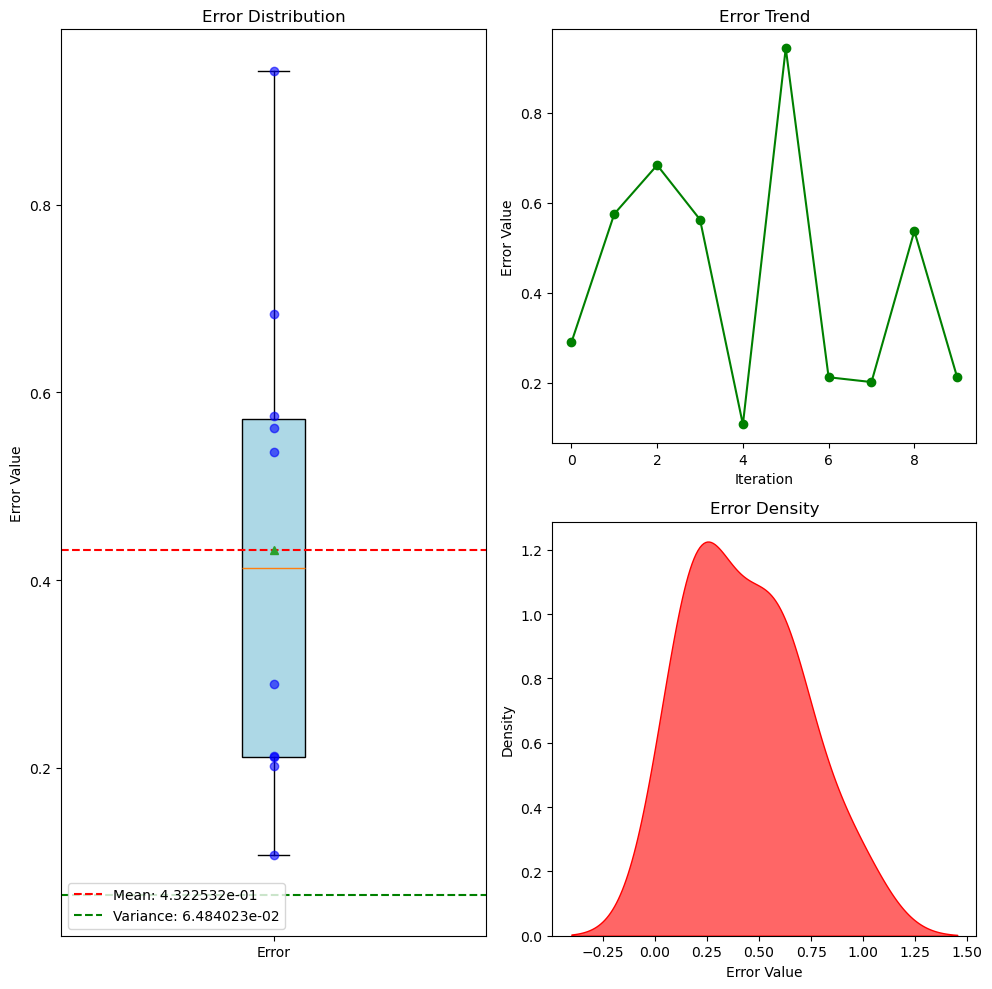

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_u

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

mean MAE: 1.631970e-01
Variance MAE: 2.069842e-02


/tmp/ipykernel_1066140/3997509801.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


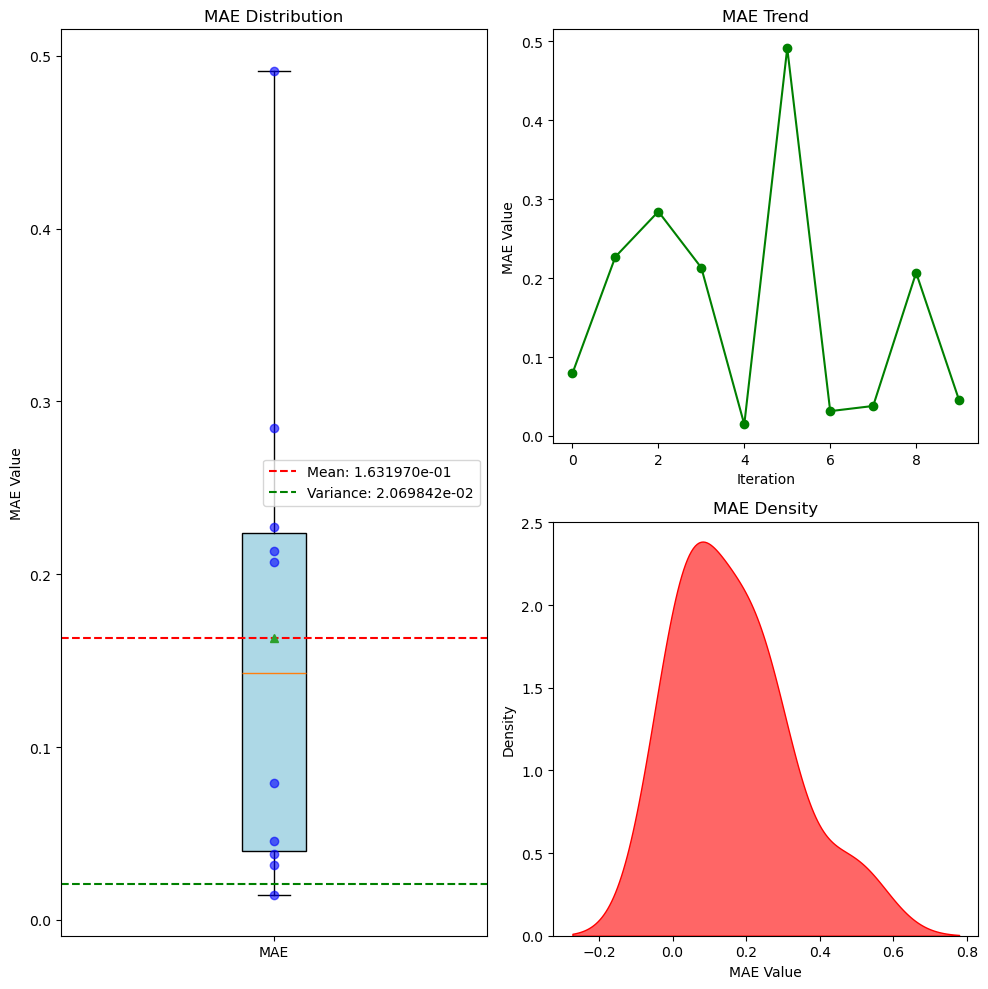

In [10]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

mean MSE: 1.146127e-01
Variance MSE: 1.411243e-02


/tmp/ipykernel_1066140/2305667704.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


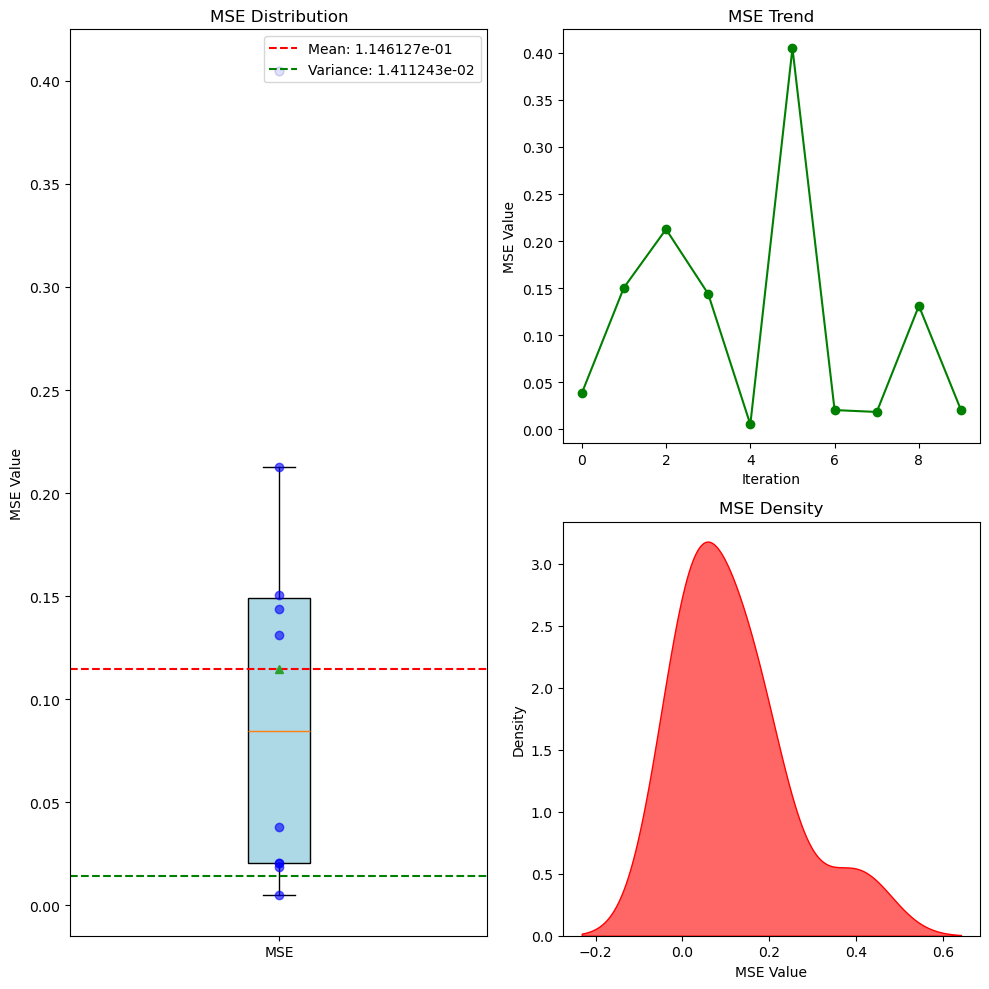

In [11]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [12]:
len_t = 101
len_x = 101

# --- 反向过程 (您需要的部分) ---

# 假设您现在只有 X_star, u_star，以及 len_t 和 len_x
# len_t = 101
# len_x = 256

# 1. 从 X_star 中分离出展平的 X 和 T
flat_X = X_star[:, 0]
flat_T = X_star[:, 1]

# 2. 使用 reshape 将它们恢复为原始的二维形状
# np.reshape 的默认顺序是 'C' (行主序)，这与 flatten 的默认行为一致
# 我们知道原始形状是 (len_t, len_x)
X = flat_X.reshape(len_t, len_x)
T = flat_T.reshape(len_t, len_x)

U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')


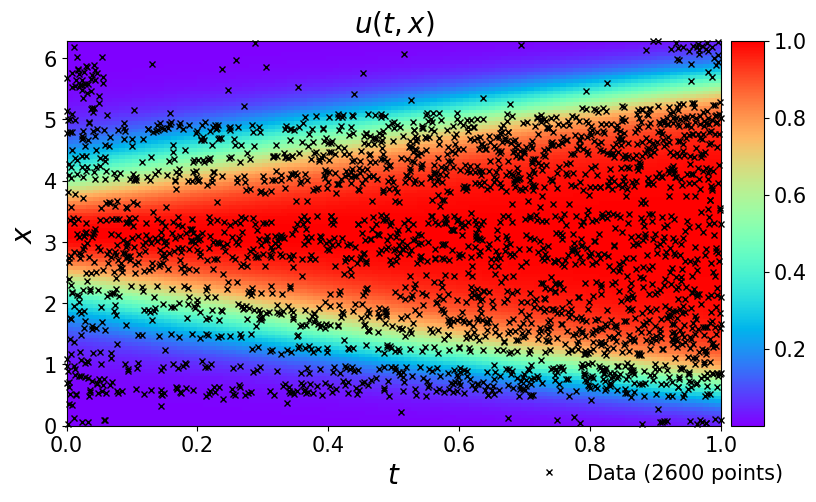

In [13]:
###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
im = ax.imshow(U_star.T, interpolation='nearest', cmap='rainbow', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是im，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(im, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（im）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


#在图上绘制散点图
ax.plot(
    X_f_train[:,1], 
    X_f_train[:,0], 
    'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  




#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

In [14]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()


13301


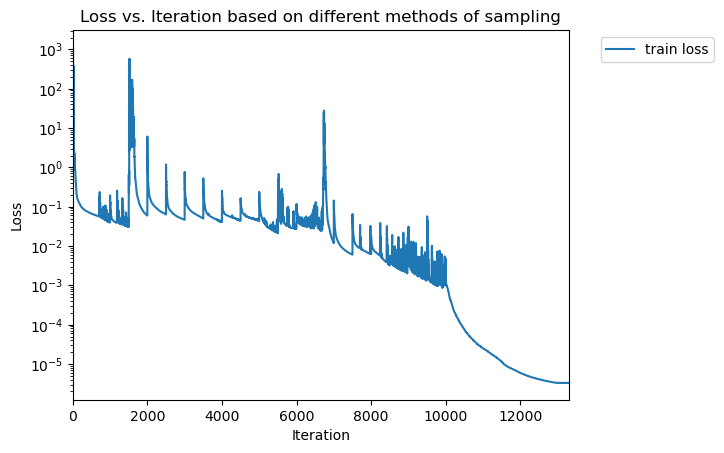

In [15]:
print(len(trainloss))
# print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,len(trainloss)]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


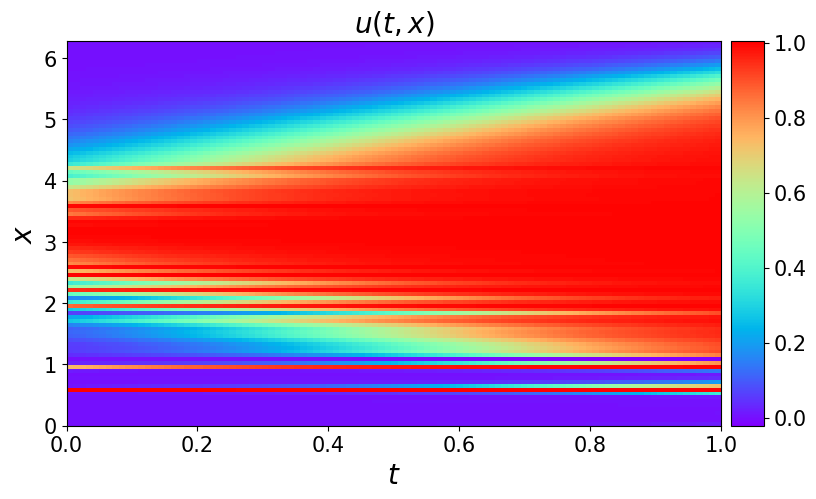

In [16]:
#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
im = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(im, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（im）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


# #在图上绘制散点图
# ax.plot(
#     X_f_train[:,1], 
#     X_f_train[:,0], 
#     'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
#     markersize = 4,  # marker size doubled
#     clip_on = False,
#     alpha=1.0
# ) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
#   #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  




#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

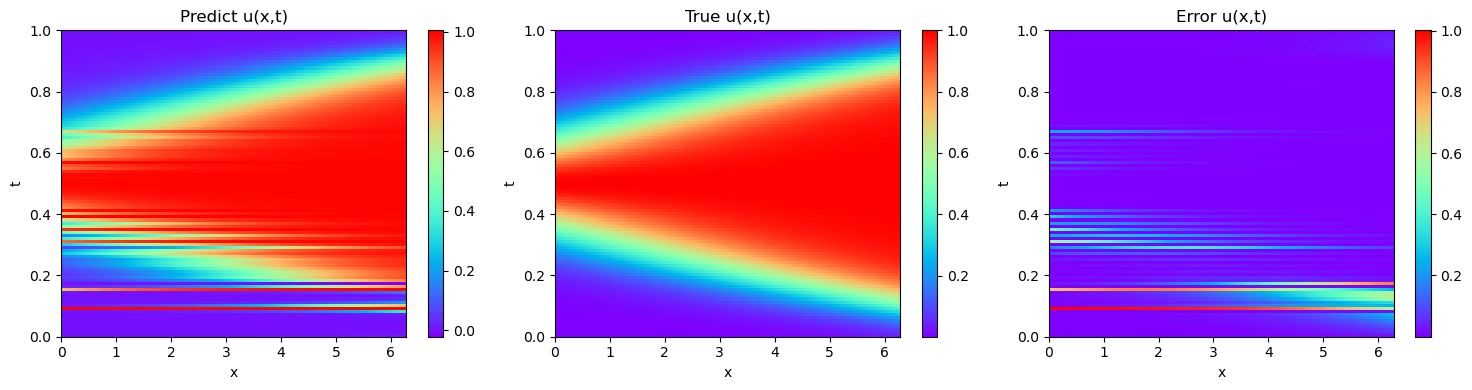

In [17]:

# 创建一个包含三幅子图的图像
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 绘制第一幅图像
axes[0].imshow(U_pred.T, extent=[0, np.pi*2, 1, 0], aspect='auto', cmap='rainbow')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Predict u(x,t)')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(U_star.T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('True u(x,t)')
fig.colorbar(axes[1].images[0], ax=axes[1])

# 绘制第三幅图像
axes[2].imshow(np.abs(U_pred - U_star).T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[2].invert_yaxis()
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
axes[2].set_title('Error u(x,t)')
fig.colorbar(axes[2].images[0], ax=axes[2])

# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()

In [18]:
#计算训练好模型的chaos（最后一个seed）
u_chaos = calculate_chaos(model, X_star, num_iter=50)
u_chaos_log = np.log(u_chaos + 1e-10) #对u_var取对数，然后加上一个很小的数，避免取对数时出现错误

#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_chaos = griddata(X_star, u_chaos.flatten(), (X, T), method='cubic')
U_chaos_log = griddata(X_star, u_chaos_log.flatten(), (X, T), method='cubic')

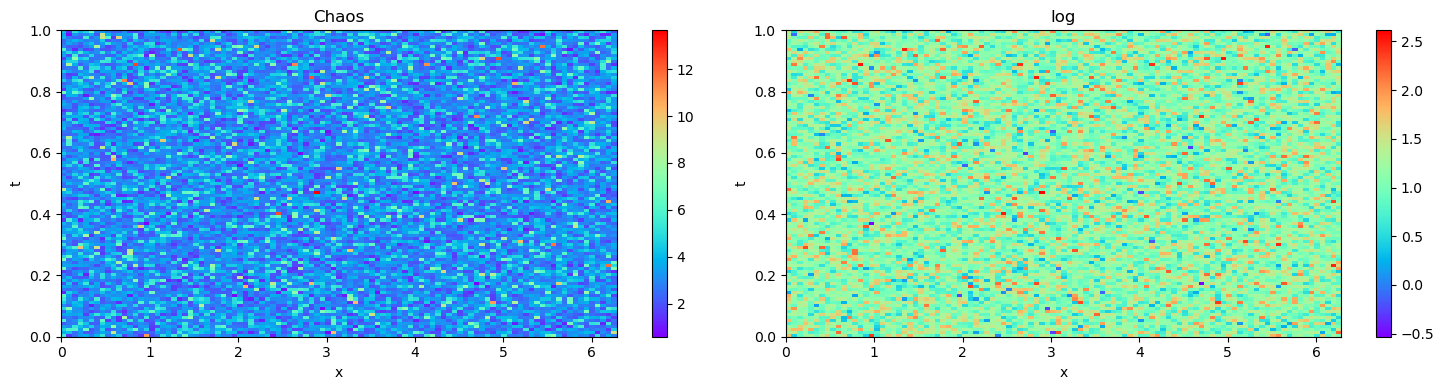

In [19]:

# 创建一个包含三幅子图的图像
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# 绘制第一幅图像
axes[0].imshow(U_chaos.T, extent=[0, np.pi*2, 1, 0], aspect='auto', cmap='rainbow')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Chaos')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(U_chaos_log.T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('log')
fig.colorbar(axes[1].images[0], ax=axes[1])

# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()